# MadMiner example

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the ML methods introduced in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020), both by Johann Brehmer, Gilles Louppe, Juan Pavez, and Kyle Cranmer.

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner and [DelphesMiner](https://github.com/johannbrehmer/delphesminer) have to be in your PYTHONPATH.

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.tools.plots import plot_2d_morphing_basis

from delphesprocessor.delphesprocessor import DelphesProcessor
from lheprocessor.lheprocessor import LHEProcessor

from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

#from forge.forge import Forge

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [3]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [ ]:
miner = GoldMine()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-20.,20.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-20.,20.)
)

## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [ ]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':10., 'CPWL2':0.},
    'w'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w2'
)

### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [ ]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

In [ ]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-20.,20),
    yrange=(-20.,20.)
)

## 3. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [ ]:
miner.save('data/madminer_example.h5')

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first. Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [ ]:
miner.run(
    mg_directory=mg_dir,
    proc_card_file='cards/proc_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 4. Extras Parton Level Observables / Weights 

Here we extract the parton level information (observables and weights) from the .lhe file. This is done with the LHEProcessor package. 

In [4]:
lhep = LHEProcessor()

16:54  
16:54  ------------------------------------------------------------
16:54  |                                                          |
16:54  |  DelphesProcessor                                        |
16:54  |                                                          |
16:54  |  Version from July 31, 2018                              |
16:54  |                                                          |
16:54  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:54  |                                                          |
16:54  ------------------------------------------------------------
16:54  
16:54  Hi! How are you today?


After creating the object, one can add a number of LHE event samples.

In [5]:
lhep.add_lhe_sample('MG_process/Events/run_01/unweighted_events.lhe',sampling_benchmark="sm")

16:54  Adding LHE sample at MG_process/Events/run_01/unweighted_events.lhe


We also want to specify the Benchmark names, because sometimes the order is mixed up in the LHE files. But fortunately, we already stored them in the HDF5 file. 

In [6]:
lhep.read_benchmark_names('data/madminer_example.h5')

Not let's define some observables. The `p[i]` correspond to the i'th parton momentum as specified when generating the process.  All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [7]:
lhep.add_observable('pt_j1', 'p[0].pt')
lhep.add_observable('pt_j2', 'p[1].pt')
lhep.add_observable('m_jj', '(p[0] + p[1]).m')

16:54  Adding (not required) observable pt_j1 = p[0].pt
16:54  Adding (not required) observable pt_j2 = p[1].pt
16:54  Adding (not required) observable m_jj = (p[0] + p[1]).m


The function `analyse_lhe_samples` extracts all these observables and weights from the LHE file(s) 

In [8]:
lhep.analyse_lhe_samples()

16:54  Analysing LHE sample MG_process/Events/run_01/unweighted_events.lhe


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [9]:
lhep.save('data/madminer_example_with_lhedata.h5', 'data/madminer_example.h5')

16:54  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_lhedata.h5


Let's make a quick cross check by plotting a distributions

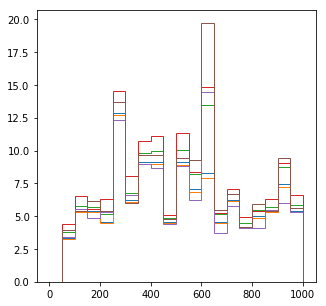

In [10]:
fig = plt.figure(figsize=(5,5))

for weights in lhep.weights:
    plt.hist(lhep.observations['m_jj'], range=(0.,1000.), bins=20, histtype='step', weights=weights)

plt.show()

## 5. Run detector simulation and extract observables

The detector simulation and calculation of observables is not part of MadMiner. The reason is that different users might have very different requirements here: while a phenomenologist might be content with the fast detector simulation from Delphes, an experimental analysis might require the full simulation through Geant4.

We provide the DelphesMiner package, which wraps around Delphes and allows for the fast extraction of observables into the HDF5 file.

Any user is free to replace the DelphesMiner step with a tool of their choice. 

In [3]:
dm = DelphesProcessor(debug=True)

19:14  
19:14  ------------------------------------------------------------
19:14  |                                                          |
19:14  |  DelphesProcessor                                        |
19:14  |                                                          |
19:14  |  Version from July 31, 2018                              |
19:14  |                                                          |
19:14  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
19:14  |                                                          |
19:14  ------------------------------------------------------------
19:14  
19:14  Hi! How are you today?


After creating the DelphesProcessor object, one can add a number of HepMC event samples and have it run Delphes:

In [4]:
dm.add_hepmc_sample('MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz', sampled_from_benchmark='sm')

dm.run_delphes(delphes_directory=mg_dir + '/Delphes',
               delphes_card='cards/delphes_card.dat',
               initial_command='source activate python2')

19:14  Adding HepMC sample at MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz
19:14  Found weight labels in HEPMC file: ['sm', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5', 'w2', 'w']
19:14  Running Delphes at /Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes


The next step is the definition of observables through a name and a python expression. For the latter, you can use the objects `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

There is an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with `np.nan`.

In [5]:
dm.add_observable('pt_j1', 'j[0].pt', required=False)
dm.add_observable('pt_j2', 'j[1].pt', required=False)
dm.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())', required=False)
dm.add_observable('delta_eta_jj', 'abs(j[0].eta - j[1].eta)', required=False)
dm.add_observable('m_jj', '(j[0] + j[1]).m', required=False)

19:23  Adding (not required) observable pt_j1 = j[0].pt
19:23  Adding (not required) observable pt_j2 = j[1].pt
19:23  Adding (not required) observable delta_phi_jj = abs(j[0].phi() - j[1].phi())
19:23  Adding (not required) observable delta_eta_jj = abs(j[0].eta - j[1].eta)
19:23  Adding (not required) observable m_jj = (j[0] + j[1]).m


The function `analyse_delphes_samples` extracts all these observables from the Delphes ROOT file(s) generated before:

In [6]:
dm.analyse_delphes_samples()

19:23  Analysing Delphes sample MG_process/Events/run_01/tag_1_pythia8_events_delphes_4.root


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [7]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

19:24  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_data.h5
19:24  Weight names found in Delphes files: ['sm', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5', 'w2', 'w']
19:24  Benchmarks found in MadMiner file: ['sm', 'w', 'w2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']


It's easy to check some (normalized) distributions at this stage

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


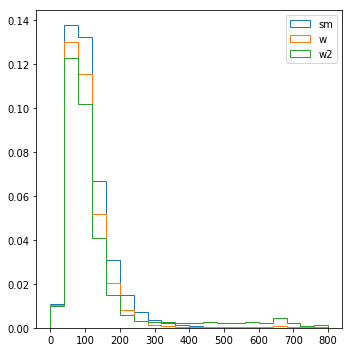

In [8]:
fig = plt.figure(figsize=(5,5))

for label in ['sm', 'w', 'w2']:
    plt.hist(dm.observations['pt_j1'], range=(0.,800.), bins=20, histtype='step', weights=dm.weights[label], label=label)
    
plt.legend()
plt.tight_layout()
plt.show()

## 6. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In [9]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

19:24  
19:24  ------------------------------------------------------------
19:24  |                                                          |
19:24  |  MadMiner                                                |
19:24  |                                                          |
19:24  |  Version from July 31, 2018                              |
19:24  |                                                          |
19:24  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
19:24  |                                                          |
19:24  ------------------------------------------------------------
19:24  
19:24  Copying setup from data/madminer_example_with_data.h5 to data/madminer_example_shuffled.h5
19:24  Loading samples from file 1 / 1 at data/madminer_example_with_data.h5


## 7. Make (unweighted) training and test samples

The last important MadMiner class is the `Smithy`. From all the data we have in the HDF5 file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the Machine Learning algorithms.

In [10]:
refinery = Refinery('data/madminer_example_shuffled.h5', debug=True)

19:24  
19:24  ------------------------------------------------------------
19:24  |                                                          |
19:24  |  MadMiner                                                |
19:24  |                                                          |
19:24  |  Version from July 31, 2018                              |
19:24  |                                                          |
19:24  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
19:24  |                                                          |
19:24  ------------------------------------------------------------
19:24  
19:24  Loading data from data/madminer_example_shuffled.h5
19:24  Found 2 parameters:
19:24     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-20.0, 20.0))
19:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-20.0, 20.0))
19:24  Found 6 benchmarks:
19:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
19:24     w: CWL2 = 10.00, CPWL2 = 0.00e+00


The `Refinery` class defines four different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL; and
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `smithy` module.

In [ ]:
x, theta, t_xz = refinery.extract_samples_train_local(
    theta=constant_morphing_theta(np.array([0.,0.])),
    n_samples=1000,
    folder='./data/samples',
    filename='train_sally'
)

19:24  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))
19:24  Augmented data requested:
19:24    Joint score, at sampling None
19:24  Sampling and auxiliary thetas before balancing:
19:24    sampling thetas:  1 types, 1 values
19:24    auxiliary thetas: 1 types, 1 values
19:24  Sampling and auxiliary thetas after balancing:
19:24    sampling thetas:  1 types, 1 values
19:24    auxiliary thetas: 1 types, 1 values
19:24  Sampling 1000 samples from morphing theta [0. 0.] (compare to None theta None)
19:24    xsec: (0.28771746158599854 +/- 0.0007682771896363808) pb
19:24    Cumulative probability (should be close to 1): 0.9995256831122679
19:24  After full pass through event files, 2 / 1000 samples not found, u = [0.99992905 0.99963018]
19:24    Cumulative probability (should be close to 1): 0.9995256831122679
19:24  Combined x shape: (1000, 5)


In [ ]:
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=random_morphing_thetas(None, [('flat', -20., 20.), ('flat', -20., 20.)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train_rascal'
)

19:24  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (None, [('flat', -20.0, 20.0), ('flat', -20.0, 20.0)])), denominator hypothesis: ('benchmark', 'sm')
19:24  Total n_samples: 50000, n_benchmarks: 50000, n_samples_per_theta: 1
19:24  Augmented data requested:
19:24    Joint ratio, num sampling None, den auxiliary None
19:24    Joint score, at sampling None
19:24  Sampling and auxiliary thetas before balancing:
19:24    sampling thetas:  50000 types, 50000 values
19:24    auxiliary thetas: 1 types, 1 values
19:24  Sampling and auxiliary thetas after balancing:
19:24    sampling thetas:  50000 types, 50000 values
19:24    auxiliary thetas: 50000 types, 50000 values
19:24  Sampling 1 samples from morphing theta [-10.45967584   4.1002498 ] (compare to benchmark theta sm)
19:24    xsec: (0.37886814048957473 +/- 0.00577423914420843) pb
19:24    Cumulative probability (should be close to 1): 0.9990995671001105
19:24  Sampling 1 samples from morphing th

19:24    Cumulative probability (should be close to 1): 1.0000045759232268
19:24  Sampling 1 samples from morphing theta [19.41233231  8.99198649] (compare to benchmark theta sm)
19:24    xsec: (0.2588328330986106 +/- 0.0035840357205934713) pb
19:24    Cumulative probability (should be close to 1): 0.9998345547629912
19:24  Sampling 1 samples from morphing theta [  7.92573864 -17.67263011] (compare to benchmark theta sm)
19:24    xsec: (0.31059725928835863 +/- 0.003997012111906916) pb
19:24    Cumulative probability (should be close to 1): 1.0008040496894781
19:24  Sampling 1 samples from morphing theta [1.40647072 4.11133233] (compare to benchmark theta sm)
19:24    xsec: (0.28258970814942197 +/- 0.0008898343983297165) pb
19:24    Cumulative probability (should be close to 1): 0.999737353499375
19:24  Sampling 1 samples from morphing theta [  7.80739325 -19.31046483] (compare to benchmark theta sm)
19:24    xsec: (0.32275249625684066 +/- 0.004424895441157441) pb
19:24    Cumulative pr

19:24    xsec: (0.25028219212828223 +/- 0.003799036831465109) pb
19:24    Cumulative probability (should be close to 1): 1.0005322923818272
19:24  Sampling 1 samples from morphing theta [-8.55892121  2.74908136] (compare to benchmark theta sm)
19:24    xsec: (0.35787889517052485 +/- 0.004445500302130174) pb
19:24    Cumulative probability (should be close to 1): 0.9991250617719021
19:24  Sampling 1 samples from morphing theta [-4.58686309 -6.07557024] (compare to benchmark theta sm)
19:24    xsec: (0.3283848961227707 +/- 0.0026223347359608526) pb
19:24    Cumulative probability (should be close to 1): 0.9991412322866773
19:24  Sampling 1 samples from morphing theta [  6.06875519 -15.95057468] (compare to benchmark theta sm)
19:24    xsec: (0.30602749335277024 +/- 0.002975932845624249) pb
19:24    Cumulative probability (should be close to 1): 1.0004994572102133
19:24  Sampling 1 samples from morphing theta [ -1.33229752 -17.8290436 ] (compare to benchmark theta sm)
19:24    xsec: (0.35

19:24  Sampling 1 samples from morphing theta [17.22459351  1.32393367] (compare to benchmark theta sm)
19:24    xsec: (0.23974073748765878 +/- 0.0023215542987392998) pb
19:24    Cumulative probability (should be close to 1): 1.0000045934480981
19:24  Sampling 1 samples from morphing theta [-4.2797589  -3.78286208] (compare to benchmark theta sm)
19:24    xsec: (0.321373125374386 +/- 0.0023736070603044166) pb
19:24    Cumulative probability (should be close to 1): 0.9991743515856362
19:24  Sampling 1 samples from morphing theta [7.2995724  4.98635024] (compare to benchmark theta sm)
19:24    xsec: (0.25760546297579384 +/- 0.0016817181662030238) pb
19:24    Cumulative probability (should be close to 1): 0.9999738374488749
19:24  Sampling 1 samples from morphing theta [-15.26085078 -10.39993038] (compare to benchmark theta sm)
19:24    xsec: (0.4536808926682626 +/- 0.010680835550217052) pb
19:24    Cumulative probability (should be close to 1): 0.998364649843865
19:24  Sampling 1 samples

19:24    Cumulative probability (should be close to 1): 1.000049372222048
19:24  Sampling 1 samples from morphing theta [-5.34927834 18.53529544] (compare to benchmark theta sm)
19:24    xsec: (0.39376777058463697 +/- 0.0032732521839781287) pb
19:24    Cumulative probability (should be close to 1): 1.000576807721974
19:24  Sampling 1 samples from morphing theta [  6.99698584 -15.7661916 ] (compare to benchmark theta sm)
19:24    xsec: (0.30138204023139537 +/- 0.0032057626672194963) pb
19:24    Cumulative probability (should be close to 1): 1.0005748583477665
19:24  Sampling 1 samples from morphing theta [-15.43581345   9.9832974 ] (compare to benchmark theta sm)
19:24    xsec: (0.45177555674430003 +/- 0.010135228972287727) pb
19:24    Cumulative probability (should be close to 1): 0.9992989671630601
19:24  Sampling 1 samples from morphing theta [-6.33120847  8.03495196] (compare to benchmark theta sm)
19:24    xsec: (0.3480368054162573 +/- 0.0026351252529021947) pb
19:24    Cumulative 

19:24    xsec: (0.2723736134522801 +/- 0.0046648829826121735) pb
19:24    Cumulative probability (should be close to 1): 1.0008762631774157
19:24  Sampling 1 samples from morphing theta [ 19.40852081 -15.87203546] (compare to benchmark theta sm)
19:24    xsec: (0.2887052906483817 +/- 0.008670964192162692) pb
19:24    Cumulative probability (should be close to 1): 1.0013796724508444
19:24  Sampling 1 samples from morphing theta [-15.54626919  12.21525287] (compare to benchmark theta sm)
19:24    xsec: (0.46259279519454266 +/- 0.010243832350128466) pb
19:24    Cumulative probability (should be close to 1): 0.9994977464368715
19:24  Sampling 1 samples from morphing theta [  7.5021296  -10.64206384] (compare to benchmark theta sm)
19:24    xsec: (0.27339682789513375 +/- 0.002224275562582912) pb
19:24    Cumulative probability (should be close to 1): 1.000275570933106
19:24  Sampling 1 samples from morphing theta [ 8.07863164 -7.47459754] (compare to benchmark theta sm)
19:24    xsec: (0.26

19:24  Sampling 1 samples from morphing theta [-6.19163018 -8.22077125] (compare to benchmark theta sm)
19:24    xsec: (0.3482076878323679 +/- 0.003549056772149926) pb
19:24    Cumulative probability (should be close to 1): 0.9990275683839619
19:24  Sampling 1 samples from morphing theta [15.00658543 -4.7246992 ] (compare to benchmark theta sm)
19:24    xsec: (0.24255945740990684 +/- 0.0027670173769667474) pb
19:24    Cumulative probability (should be close to 1): 1.0002964400309997
19:24  Sampling 1 samples from morphing theta [ -8.28477676 -17.17892644] (compare to benchmark theta sm)
19:24    xsec: (0.4128480513882179 +/- 0.005161952007001198) pb
19:24    Cumulative probability (should be close to 1): 0.9991056572814108
19:24  Sampling 1 samples from morphing theta [-19.7287265  -11.45233015] (compare to benchmark theta sm)
19:24    xsec: (0.5186088681538045 +/- 0.015551186004286075) pb
19:24    Cumulative probability (should be close to 1): 0.9980857091880864
19:24  Sampling 1 samp

19:24    Cumulative probability (should be close to 1): 0.9994476923858358
19:24  Sampling 1 samples from morphing theta [-7.56787602 -2.93723338] (compare to benchmark theta sm)
19:24    xsec: (0.3489551266063189 +/- 0.0041505038052473886) pb
19:24    Cumulative probability (should be close to 1): 0.9989585804723431
19:24  Sampling 1 samples from morphing theta [6.93189354 1.74383061] (compare to benchmark theta sm)
19:24    xsec: (0.25441129904482196 +/- 0.0012275897877133358) pb
19:24    Cumulative probability (should be close to 1): 0.9998986579547222
19:24  Sampling 1 samples from morphing theta [12.02906826 -7.68620354] (compare to benchmark theta sm)
19:24    xsec: (0.25205646089245287 +/- 0.0026430063638696773) pb
19:24    Cumulative probability (should be close to 1): 1.0003824504328778
19:24  Sampling 1 samples from morphing theta [ -4.22707807 -11.18832612] (compare to benchmark theta sm)
19:24    xsec: (0.34291998264454127 +/- 0.0026066367809162243) pb
19:24    Cumulative p

19:24    xsec: (0.25294563390941255 +/- 0.0010811543007380093) pb
19:24    Cumulative probability (should be close to 1): 0.9999030314313646
19:24  Sampling 1 samples from morphing theta [11.70293551 15.84806488] (compare to benchmark theta sm)
19:24    xsec: (0.29223502771732524 +/- 0.004841685472019326) pb
19:24    Cumulative probability (should be close to 1): 1.0004538256272373
19:24  Sampling 1 samples from morphing theta [-11.54717498 -11.31654819] (compare to benchmark theta sm)
19:24    xsec: (0.41373707231963586 +/- 0.007371466119432515) pb
19:24    Cumulative probability (should be close to 1): 0.9986417720816996
19:24  Sampling 1 samples from morphing theta [-11.67017506 -19.5962099 ] (compare to benchmark theta sm)
19:24    xsec: (0.46599194805732413 +/- 0.007819000685684798) pb
19:24    Cumulative probability (should be close to 1): 0.9988985253922152
19:24  Sampling 1 samples from morphing theta [11.85520864  6.86245747] (compare to benchmark theta sm)
19:24    xsec: (0.2

19:24  Sampling 1 samples from morphing theta [15.19241889 12.49706622] (compare to benchmark theta sm)
19:24    xsec: (0.27069463292787244 +/- 0.003828432392119863) pb
19:24    Cumulative probability (should be close to 1): 1.0001412967570549
19:24  Sampling 1 samples from morphing theta [-2.66593966  9.76431099] (compare to benchmark theta sm)
19:24    xsec: (0.324434049211058 +/- 0.0010813508062535791) pb
19:24    Cumulative probability (should be close to 1): 0.9999077158607992
19:24  Sampling 1 samples from morphing theta [11.34220398 -8.0310526 ] (compare to benchmark theta sm)
19:24    xsec: (0.25420644457744646 +/- 0.0025513642628001254) pb
19:24    Cumulative probability (should be close to 1): 1.0003697123731599
19:24  Sampling 1 samples from morphing theta [16.23133589 -3.04932275] (compare to benchmark theta sm)
19:24    xsec: (0.24020207850598488 +/- 0.0027895131990887303) pb
19:24    Cumulative probability (should be close to 1): 1.0002115990377651
19:24  Sampling 1 sampl

19:24    Cumulative probability (should be close to 1): 1.0006339850838388
19:24  Sampling 1 samples from morphing theta [-18.24335127 -15.36747572] (compare to benchmark theta sm)
19:24    xsec: (0.5187846755149356 +/- 0.013982807290693667) pb
19:24    Cumulative probability (should be close to 1): 0.9982269543472805
19:24  Sampling 1 samples from morphing theta [14.69534421 -2.98012724] (compare to benchmark theta sm)
19:24    xsec: (0.24021797393507915 +/- 0.002220466311093698) pb
19:24    Cumulative probability (should be close to 1): 1.0001927797379488
19:24  Sampling 1 samples from morphing theta [-16.81870848  -6.29221304] (compare to benchmark theta sm)
19:24    xsec: (0.4598064759134777 +/- 0.012128869868685973) pb
19:24    Cumulative probability (should be close to 1): 0.998296512236035
19:24  Sampling 1 samples from morphing theta [ 19.9060651  -14.85754845] (compare to benchmark theta sm)
19:24    xsec: (0.28351984507844546 +/- 0.008599835478724694) pb
19:24    Cumulative p

19:24    xsec: (0.2853155593618356 +/- 0.008551978933510623) pb
19:24    Cumulative probability (should be close to 1): 1.0013219127916102
19:24  Sampling 1 samples from morphing theta [-15.27803286 -10.64786869] (compare to benchmark theta sm)
19:24    xsec: (0.4549487735827873 +/- 0.010706085711111866) pb
19:24    Cumulative probability (should be close to 1): 0.998364678537101
19:24  Sampling 1 samples from morphing theta [18.41223361 15.92185908] (compare to benchmark theta sm)
19:24    xsec: (0.29217478822263 +/- 0.005533180845179964) pb
19:24    Cumulative probability (should be close to 1): 1.0001023786879109
19:24  Sampling 1 samples from morphing theta [-4.28335151  3.84258496] (compare to benchmark theta sm)
19:24    xsec: (0.3212243625140155 +/- 0.0018289174820343293) pb
19:24    Cumulative probability (should be close to 1): 0.9994306351031894
19:24  Sampling 1 samples from morphing theta [-16.79279918 -18.1461513 ] (compare to benchmark theta sm)
19:24    xsec: (0.51775356

19:24  Sampling 1 samples from morphing theta [2.00788123 1.02831727] (compare to benchmark theta sm)
19:24    xsec: (0.2760866032634594 +/- 0.000783400535817323) pb
19:24    Cumulative probability (should be close to 1): 0.9996641682889943
19:24  Sampling 1 samples from morphing theta [-12.47231269 -11.5651034 ] (compare to benchmark theta sm)
19:24    xsec: (0.4253009714368805 +/- 0.008154500541942535) pb
19:24    Cumulative probability (should be close to 1): 0.998574783897058
19:24  Sampling 1 samples from morphing theta [ 9.49296971 -3.87589688] (compare to benchmark theta sm)
19:24    xsec: (0.24877226247990125 +/- 0.0013985695995317176) pb
19:24    Cumulative probability (should be close to 1): 1.0000714899595606
19:24  Sampling 1 samples from morphing theta [ 13.25489762 -19.45135004] (compare to benchmark theta sm)
19:24    xsec: (0.31191041400675107 +/- 0.0066685631421701625) pb
19:24    Cumulative probability (should be close to 1): 1.0014011220838501
19:24  Sampling 1 sampl

19:24    xsec: (0.4608665823867085 +/- 0.010085477295029012) pb
19:24    Cumulative probability (should be close to 1): 0.998459702850724
19:24  Sampling 1 samples from morphing theta [-8.94998808  0.83005443] (compare to benchmark theta sm)
19:24    xsec: (0.36051766193208146 +/- 0.004849261299261376) pb
19:24    Cumulative probability (should be close to 1): 0.9990027661905203
19:24  Sampling 1 samples from morphing theta [ 4.6702518  17.81987575] (compare to benchmark theta sm)
19:24    xsec: (0.3254661839800296 +/- 0.004583055129642323) pb
19:24    Cumulative probability (should be close to 1): 1.000715063920289
19:24  Sampling 1 samples from morphing theta [-12.05893418 -15.47058621] (compare to benchmark theta sm)
19:24    xsec: (0.4416485853390715 +/- 0.007940914406854167) pb
19:24    Cumulative probability (should be close to 1): 0.9987002565181944
19:24  Sampling 1 samples from morphing theta [0.20959106 1.96394938] (compare to benchmark theta sm)
19:24    xsec: (0.28715799810

19:24  Sampling 1 samples from morphing theta [13.85127149 10.22291365] (compare to benchmark theta sm)
19:24    xsec: (0.2607708302704283 +/- 0.0029956072645815814) pb
19:24    Cumulative probability (should be close to 1): 1.0001082734010227
19:24  Sampling 1 samples from morphing theta [-17.59809666   1.11329003] (compare to benchmark theta sm)
19:24    xsec: (0.4616795934278927 +/- 0.012717952424866404) pb
19:24    Cumulative probability (should be close to 1): 0.9985341864851491
19:24  Sampling 1 samples from morphing theta [-16.40569835 -14.36932957] (compare to benchmark theta sm)
19:24    xsec: (0.48811469010237846 +/- 0.01197232079158413) pb
19:24    Cumulative probability (should be close to 1): 0.998334628788927
19:24  Sampling 1 samples from morphing theta [-13.16958037  11.86992897] (compare to benchmark theta sm)
19:24    xsec: (0.43237808142429257 +/- 0.007849358841117298) pb
19:24    Cumulative probability (should be close to 1): 0.9995851989277363
19:24  Sampling 1 sam

19:24  Sampling 1 samples from morphing theta [-4.54149739 15.24615599] (compare to benchmark theta sm)
19:24    xsec: (0.36552259896008643 +/- 0.0022778441722868113) pb
19:24    Cumulative probability (should be close to 1): 1.0003006596336192
19:24  Sampling 1 samples from morphing theta [ -3.58402831 -16.01460448] (compare to benchmark theta sm)
19:24    xsec: (0.3636469733001074 +/- 0.0025521234232998313) pb
19:24    Cumulative probability (should be close to 1): 0.9995155596560594
19:24  Sampling 1 samples from morphing theta [ 13.97074057 -18.40351231] (compare to benchmark theta sm)
19:24    xsec: (0.30358141751859075 +/- 0.006627450551886397) pb
19:24    Cumulative probability (should be close to 1): 1.0013608623929124
19:24  Sampling 1 samples from morphing theta [-10.28038813   0.73293577] (compare to benchmark theta sm)
19:24    xsec: (0.37407245087498475 +/- 0.0058396304585780915) pb
19:24    Cumulative probability (should be close to 1): 0.998918483249521
19:24  Sampling 1

19:24    Cumulative probability (should be close to 1): 0.9982791819044091
19:24  Sampling 1 samples from morphing theta [-8.19889568  5.54595821] (compare to benchmark theta sm)
19:24    xsec: (0.3587533610569259 +/- 0.004001574497706851) pb
19:24    Cumulative probability (should be close to 1): 0.9993213975324431
19:24  Sampling 1 samples from morphing theta [ 5.0167568  -8.78372952] (compare to benchmark theta sm)
19:24    xsec: (0.2759646230183636 +/- 0.0014294979679662534) pb
19:24    Cumulative probability (should be close to 1): 0.9999805906211656
19:24  Sampling 1 samples from morphing theta [18.89448724  8.11620273] (compare to benchmark theta sm)
19:24    xsec: (0.2549811529869117 +/- 0.0032245296868507593) pb
19:24    Cumulative probability (should be close to 1): 0.9998549611794266
19:24  Sampling 1 samples from morphing theta [19.26570045  8.55565039] (compare to benchmark theta sm)
19:24    xsec: (0.2570344674590576 +/- 0.003442811724098929) pb
19:24    Cumulative probab

19:24    xsec: (0.2588107968807749 +/- 0.0022799306637276947) pb
19:24    Cumulative probability (should be close to 1): 1.000088243708507
19:24  Sampling 1 samples from morphing theta [-7.35018964 18.46910751] (compare to benchmark theta sm)
19:24    xsec: (0.41078938629605555 +/- 0.003930099289780542) pb
19:24    Cumulative probability (should be close to 1): 1.0004928418753591
19:24  Sampling 1 samples from morphing theta [ 13.94557173 -10.06619958] (compare to benchmark theta sm)
19:24    xsec: (0.2579784171215929 +/- 0.003902977219099217) pb
19:24    Cumulative probability (should be close to 1): 1.000644024802015
19:24  Sampling 1 samples from morphing theta [ 12.11652951 -18.46166635] (compare to benchmark theta sm)
19:24    xsec: (0.3061426555853266 +/- 0.005817949074063668) pb
19:24    Cumulative probability (should be close to 1): 1.0012312739009717
19:24  Sampling 1 samples from morphing theta [ 5.65959487 11.15392032] (compare to benchmark theta sm)
19:24    xsec: (0.283329

19:24  Sampling 1 samples from morphing theta [-17.22628945 -13.4660854 ] (compare to benchmark theta sm)
19:24    xsec: (0.4939362131160357 +/- 0.012802077286341213) pb
19:24    Cumulative probability (should be close to 1): 0.9982617309793327
19:24  Sampling 1 samples from morphing theta [-17.98034804   0.87125778] (compare to benchmark theta sm)
19:24    xsec: (0.4667871586024624 +/- 0.013154340890000558) pb
19:24    Cumulative probability (should be close to 1): 0.9985014127245027
19:24  Sampling 1 samples from morphing theta [ 8.30422677 17.19098868] (compare to benchmark theta sm)
19:24    xsec: (0.3082456965377369 +/- 0.0049902574897965025) pb
19:24    Cumulative probability (should be close to 1): 1.0006331761684786
19:24  Sampling 1 samples from morphing theta [ 1.30303902 -4.61846048] (compare to benchmark theta sm)
19:24    xsec: (0.28398262134071023 +/- 0.0008046766119227473) pb
19:24    Cumulative probability (should be close to 1): 0.9995815081603403
19:24  Sampling 1 sam

19:24    Cumulative probability (should be close to 1): 0.9985481673121881
19:24  Sampling 1 samples from morphing theta [ -4.63497414 -17.85780329] (compare to benchmark theta sm)
19:24    xsec: (0.38445740310572435 +/- 0.0031441185021834433) pb
19:24    Cumulative probability (should be close to 1): 0.9995039805466905
19:24  Sampling 1 samples from morphing theta [-15.36691954  13.05687661] (compare to benchmark theta sm)
19:24    xsec: (0.4644183743083543 +/- 0.010062285114578469) pb
19:24    Cumulative probability (should be close to 1): 0.9995865123175823
19:24  Sampling 1 samples from morphing theta [12.92991816 -0.20901807] (compare to benchmark theta sm)
19:24    xsec: (0.24003920953981414 +/- 0.0012863975449088306) pb
19:24    Cumulative probability (should be close to 1): 1.0000613058630907
19:24  Sampling 1 samples from morphing theta [10.92889885  5.05286576] (compare to benchmark theta sm)
19:24    xsec: (0.24840164947798696 +/- 0.001644510311215861) pb
19:24    Cumulative

19:24    xsec: (0.33138306326534267 +/- 0.0015273831177404697) pb
19:24    Cumulative probability (should be close to 1): 1.0001474365092027
19:24  Sampling 1 samples from morphing theta [ 8.74222707 10.16651825] (compare to benchmark theta sm)
19:24    xsec: (0.26896121215799657 +/- 0.0028762128066216544) pb
19:24    Cumulative probability (should be close to 1): 1.0001949874236753
19:24  Sampling 1 samples from morphing theta [ 8.37479379 -8.54376912] (compare to benchmark theta sm)
19:24    xsec: (0.2628747511543976 +/- 0.0020106317368002316) pb
19:24    Cumulative probability (should be close to 1): 1.0002189595366688
19:24  Sampling 1 samples from morphing theta [ 9.09203026 12.53126289] (compare to benchmark theta sm)
19:24    xsec: (0.27871869505274494 +/- 0.003562787823054567) pb
19:24    Cumulative probability (should be close to 1): 1.0003200506857743
19:24  Sampling 1 samples from morphing theta [-10.35721384   3.88346667] (compare to benchmark theta sm)
19:24    xsec: (0.37

19:24  Sampling 1 samples from morphing theta [0.74634919 4.65017078] (compare to benchmark theta sm)
19:24    xsec: (0.28737242166097254 +/- 0.000826730488395165) pb
19:24    Cumulative probability (should be close to 1): 0.9997316039302466
19:24  Sampling 1 samples from morphing theta [-16.72875135  18.32280739] (compare to benchmark theta sm)
19:24    xsec: (0.5134243003751225 +/- 0.01180574139402471) pb
19:24    Cumulative probability (should be close to 1): 1.0000384100572481
19:24  Sampling 1 samples from morphing theta [15.66887713 -7.66899191] (compare to benchmark theta sm)
19:24    xsec: (0.24928028132143432 +/- 0.0038570080360361947) pb
19:24    Cumulative probability (should be close to 1): 1.0005178046173047
19:24  Sampling 1 samples from morphing theta [18.07512004 15.27240258] (compare to benchmark theta sm)
19:24    xsec: (0.28770909543197615 +/- 0.005215548033595034) pb
19:24    Cumulative probability (should be close to 1): 1.0000960964108074
19:24  Sampling 1 samples

19:24    Cumulative probability (should be close to 1): 0.9989422896402714
19:24  Sampling 1 samples from morphing theta [-3.6043654  -6.07912649] (compare to benchmark theta sm)
19:24    xsec: (0.32051576414896404 +/- 0.00216592396337838) pb
19:24    Cumulative probability (should be close to 1): 0.999217630224178
19:24  Sampling 1 samples from morphing theta [ 7.16161214 -2.37466872] (compare to benchmark theta sm)
19:24    xsec: (0.25391487427552445 +/- 0.0010963892576351239) pb
19:24    Cumulative probability (should be close to 1): 0.9999206473298548
19:24  Sampling 1 samples from morphing theta [ 19.09732616 -10.50754484] (compare to benchmark theta sm)
19:24    xsec: (0.26132752728119646 +/- 0.006499956080683143) pb
19:24    Cumulative probability (should be close to 1): 1.0008368559899883
19:24  Sampling 1 samples from morphing theta [-18.30407114   6.90911222] (compare to benchmark theta sm)
19:24    xsec: (0.479554134348291 +/- 0.013370524995517925) pb
19:24    Cumulative pro

19:24    xsec: (0.25633482914334127 +/- 0.0019375492441414998) pb
19:24    Cumulative probability (should be close to 1): 1.0000324162165526
19:24  Sampling 1 samples from morphing theta [ -4.61106054 -16.77844932] (compare to benchmark theta sm)
19:24    xsec: (0.3768954213815579 +/- 0.003046381820670778) pb
19:24    Cumulative probability (should be close to 1): 0.9994498419245772
19:24  Sampling 1 samples from morphing theta [-19.60696126  -9.71925626] (compare to benchmark theta sm)
19:24    xsec: (0.5094079191325736 +/- 0.015353851211799444) pb
19:24    Cumulative probability (should be close to 1): 0.9980952379920922
19:24  Sampling 1 samples from morphing theta [19.27526693 -7.11378695] (compare to benchmark theta sm)
19:24    xsec: (0.2503540567293778 +/- 0.005471218164552746) pb
19:24    Cumulative probability (should be close to 1): 1.0005224695777417
19:24  Sampling 1 samples from morphing theta [-4.34967747 16.17742202] (compare to benchmark theta sm)
19:24    xsec: (0.3696

19:24  Sampling 1 samples from morphing theta [-1.94511548 -8.75677728] (compare to benchmark theta sm)
19:24    xsec: (0.31592795608870095 +/- 0.001605026973451335) pb
19:24    Cumulative probability (should be close to 1): 0.9993916935827956
19:24  Sampling 1 samples from morphing theta [18.78476567 12.47441729] (compare to benchmark theta sm)
19:24    xsec: (0.2730198782489705 +/- 0.0043465333820182275) pb
19:24    Cumulative probability (should be close to 1): 0.9999444830907067
19:24  Sampling 1 samples from morphing theta [-19.45383449  -2.42673696] (compare to benchmark theta sm)
19:24    xsec: (0.4887677874931687 +/- 0.014959653448217688) pb
19:24    Cumulative probability (should be close to 1): 0.9982696239209513
19:24  Sampling 1 samples from morphing theta [ 3.31759042 -2.29573591] (compare to benchmark theta sm)
19:24    xsec: (0.2699966000471346 +/- 0.0008194814491142689) pb
19:24    Cumulative probability (should be close to 1): 0.9997036999938751
19:24  Sampling 1 sampl

19:24    Cumulative probability (should be close to 1): 1.0012115582643644
19:24  Sampling 1 samples from morphing theta [-16.95386507  14.65482165] (compare to benchmark theta sm)
19:24    xsec: (0.49314238289036666 +/- 0.011843058855545523) pb
19:24    Cumulative probability (should be close to 1): 0.9996617887138555
19:24  Sampling 1 samples from morphing theta [16.9328176   1.84938889] (compare to benchmark theta sm)
19:24    xsec: (0.23995017242317612 +/- 0.0021421175188601894) pb
19:24    Cumulative probability (should be close to 1): 0.9999934395296524
19:24  Sampling 1 samples from morphing theta [-17.32830137  -1.5310303 ] (compare to benchmark theta sm)
19:24    xsec: (0.45864012586923886 +/- 0.012510716701919911) pb
19:24    Cumulative probability (should be close to 1): 0.9984162848630589
19:24  Sampling 1 samples from morphing theta [  6.13413299 -12.92248108] (compare to benchmark theta sm)
19:24    xsec: (0.2887789254375309 +/- 0.002341577614850613) pb
19:24    Cumulativ

19:24    xsec: (0.4264933808251736 +/- 0.00797206554508159) pb
19:24    Cumulative probability (should be close to 1): 0.9986077449028042
19:24  Sampling 1 samples from morphing theta [-1.30108255 12.84924504] (compare to benchmark theta sm)
19:24    xsec: (0.32845161585646937 +/- 0.0017305839420765667) pb
19:24    Cumulative probability (should be close to 1): 1.0002076848257637
19:24  Sampling 1 samples from morphing theta [-16.06229533   5.51398395] (compare to benchmark theta sm)
19:24    xsec: (0.4466764536236124 +/- 0.010903923372029731) pb
19:24    Cumulative probability (should be close to 1): 0.9989004894919532
19:24  Sampling 1 samples from morphing theta [-9.34520124  1.62866073] (compare to benchmark theta sm)
19:24    xsec: (0.3648015774037243 +/- 0.005081804331379523) pb
19:24    Cumulative probability (should be close to 1): 0.9990185475651467
19:24  Sampling 1 samples from morphing theta [ 2.83550923 18.58680335] (compare to benchmark theta sm)
19:24    xsec: (0.3394831

19:24    xsec: (0.39847903189036815 +/- 0.007683008687027565) pb
19:24    Cumulative probability (should be close to 1): 0.9986368352734666
19:24  Sampling 1 samples from morphing theta [-8.5452775  -0.05403246] (compare to benchmark theta sm)
19:24    xsec: (0.3564554212746007 +/- 0.004623783697146952) pb
19:24    Cumulative probability (should be close to 1): 0.9989884814374805
19:24  Sampling 1 samples from morphing theta [-13.35184974  17.46290962] (compare to benchmark theta sm)
19:24    xsec: (0.466042986899272 +/- 0.008226603189699994) pb
19:24    Cumulative probability (should be close to 1): 1.0001194763252914
19:24  Sampling 1 samples from morphing theta [ 19.39110784 -11.54463419] (compare to benchmark theta sm)
19:24    xsec: (0.2660726306898559 +/- 0.00704191750894902) pb
19:24    Cumulative probability (should be close to 1): 1.00094295609705
19:24  Sampling 1 samples from morphing theta [  4.13003838 -11.92940577] (compare to benchmark theta sm)
19:24    xsec: (0.2926437

19:24  Sampling 1 samples from morphing theta [15.3787173   2.17781845] (compare to benchmark theta sm)
19:24    xsec: (0.2398433417998897 +/- 0.0015984208553455274) pb
19:24    Cumulative probability (should be close to 1): 1.0000079232125996
19:24  Sampling 1 samples from morphing theta [ -0.5279105  -10.77032765] (compare to benchmark theta sm)
19:24    xsec: (0.3138939206048247 +/- 0.001312782570880828) pb
19:24    Cumulative probability (should be close to 1): 0.9995794025294755
19:24  Sampling 1 samples from morphing theta [17.94865773 16.70004745] (compare to benchmark theta sm)
19:24    xsec: (0.29670086834942483 +/- 0.005767915866615284) pb
19:24    Cumulative probability (should be close to 1): 1.0001711546199068
19:24  Sampling 1 samples from morphing theta [-4.37699115 -0.87120683] (compare to benchmark theta sm)
19:24    xsec: (0.3194019791574882 +/- 0.0022464187805683947) pb
19:24    Cumulative probability (should be close to 1): 0.9992255607223217
19:24  Sampling 1 sampl

19:24    Cumulative probability (should be close to 1): 0.9985914522521733
19:24  Sampling 1 samples from morphing theta [10.88388332 16.15226926] (compare to benchmark theta sm)
19:24    xsec: (0.29548196608550503 +/- 0.00489092665274579) pb
19:24    Cumulative probability (should be close to 1): 1.0004996320007329
19:24  Sampling 1 samples from morphing theta [-18.96073374  15.81166177] (compare to benchmark theta sm)
19:24    xsec: (0.5269368330802996 +/- 0.014272402361462155) pb
19:24    Cumulative probability (should be close to 1): 0.9996758488099743
19:24  Sampling 1 samples from morphing theta [ -4.16897806 -15.65715425] (compare to benchmark theta sm)
19:24    xsec: (0.3660998709723258 +/- 0.0027711602006669283) pb
19:24    Cumulative probability (should be close to 1): 0.9994388731130455
19:24  Sampling 1 samples from morphing theta [-4.65101456 -6.42558108] (compare to benchmark theta sm)
19:24    xsec: (0.32978315251183 +/- 0.002667010047727059) pb
19:24    Cumulative proba

19:24    xsec: (0.4671113522450721 +/- 0.010354815205255441) pb
19:24    Cumulative probability (should be close to 1): 0.9995578254362278
19:24  Sampling 1 samples from morphing theta [4.08466474 3.68817354] (compare to benchmark theta sm)
19:24    xsec: (0.26809992374590413 +/- 0.0012516624908336029) pb
19:24    Cumulative probability (should be close to 1): 0.9998353698272338
19:24  Sampling 1 samples from morphing theta [12.22300028 17.29634558] (compare to benchmark theta sm)
19:24    xsec: (0.3010749081033528 +/- 0.0054275905222676375) pb
19:24    Cumulative probability (should be close to 1): 1.0005222031729906
19:24  Sampling 1 samples from morphing theta [ 10.1633961  -15.55005253] (compare to benchmark theta sm)
19:24    xsec: (0.29073593879554727 +/- 0.00416272215007894) pb
19:24    Cumulative probability (should be close to 1): 1.0008371613811002
19:24  Sampling 1 samples from morphing theta [ -4.64651815 -15.52071719] (compare to benchmark theta sm)
19:24    xsec: (0.36918

19:24  Sampling 1 samples from morphing theta [-11.60107564 -10.71933088] (compare to benchmark theta sm)
19:24    xsec: (0.4117030250976501 +/- 0.007395851681608173) pb
19:24    Cumulative probability (should be close to 1): 0.9986294899058419
19:24  Sampling 1 samples from morphing theta [-8.57399368 -0.4902475 ] (compare to benchmark theta sm)
19:24    xsec: (0.35681243100692006 +/- 0.004670933434234263) pb
19:24    Cumulative probability (should be close to 1): 0.998969165569767
19:24  Sampling 1 samples from morphing theta [-2.64768475  5.31643645] (compare to benchmark theta sm)
19:24    xsec: (0.31126242724974396 +/- 0.001039472647408849) pb
19:24    Cumulative probability (should be close to 1): 0.9996022679366456
19:24  Sampling 1 samples from morphing theta [11.96100939  5.94300654] (compare to benchmark theta sm)
19:24    xsec: (0.24871852699040464 +/- 0.0018043345632540227) pb
19:24    Cumulative probability (should be close to 1): 1.0000329604747025
19:24  Sampling 1 sampl

19:24    Cumulative probability (should be close to 1): 0.9985925343394114
19:24  Sampling 1 samples from morphing theta [10.48896056 -7.85130683] (compare to benchmark theta sm)
19:24    xsec: (0.25531822886091454 +/- 0.0023085400494915797) pb
19:24    Cumulative probability (should be close to 1): 1.0003119656029615
19:24  Sampling 1 samples from morphing theta [  3.81117179 -15.40446498] (compare to benchmark theta sm)
19:24    xsec: (0.31268282903319083 +/- 0.0022508420288620563) pb
19:24    Cumulative probability (should be close to 1): 1.0002397289395704
19:24  Sampling 1 samples from morphing theta [14.47470561 -5.357784  ] (compare to benchmark theta sm)
19:24    xsec: (0.243935124102813 +/- 0.0027549375662535057) pb
19:24    Cumulative probability (should be close to 1): 1.00032407167966
19:24  Sampling 1 samples from morphing theta [-18.50166301 -16.69888844] (compare to benchmark theta sm)
19:24    xsec: (0.5309240413443681 +/- 0.014326072080193902) pb
19:24    Cumulative pr

19:24    xsec: (0.26420884533064154 +/- 0.0031537187866690726) pb
19:24    Cumulative probability (should be close to 1): 1.000164797917364
19:24  Sampling 1 samples from morphing theta [  0.06320647 -14.48483939] (compare to benchmark theta sm)
19:24    xsec: (0.3284410155602587 +/- 0.0015827278249936905) pb
19:24    Cumulative probability (should be close to 1): 0.9998068015079156
19:24  Sampling 1 samples from morphing theta [  1.25800689 -19.99745721] (compare to benchmark theta sm)
19:24    xsec: (0.35828204233568905 +/- 0.002717075556685732) pb
19:24    Cumulative probability (should be close to 1): 1.0002731573525283
19:24  Sampling 1 samples from morphing theta [-7.04533583  6.85739563] (compare to benchmark theta sm)
19:24    xsec: (0.3510682376701491 +/- 0.003146720304208337) pb
19:24    Cumulative probability (should be close to 1): 0.9994766620526749
19:24  Sampling 1 samples from morphing theta [3.92654063 1.20237025] (compare to benchmark theta sm)
19:24    xsec: (0.26638

19:24    xsec: (0.24220704586816907 +/- 0.001489761084510913) pb
19:24    Cumulative probability (should be close to 1): 0.9999957872809595
19:24  Sampling 1 samples from morphing theta [ 6.09152694 -6.78484176] (compare to benchmark theta sm)
19:24    xsec: (0.2655261358142205 +/- 0.0013558263645733232) pb
19:24    Cumulative probability (should be close to 1): 0.9999784237154179
19:24  Sampling 1 samples from morphing theta [-1.7265924  12.62196409] (compare to benchmark theta sm)
19:24    xsec: (0.33022573579490455 +/- 0.0016073311889647191) pb
19:24    Cumulative probability (should be close to 1): 1.0001741986234483
19:24  Sampling 1 samples from morphing theta [-16.93632751   5.26970554] (compare to benchmark theta sm)
19:24    xsec: (0.45752230965790475 +/- 0.011855415319792546) pb
19:24    Cumulative probability (should be close to 1): 0.9988383654335478
19:24  Sampling 1 samples from morphing theta [18.34354948  1.52736902] (compare to benchmark theta sm)
19:24    xsec: (0.240

19:24    xsec: (0.38038146961506847 +/- 0.003826371193018097) pb
19:24    Cumulative probability (should be close to 1): 0.9992013245637916
19:24  Sampling 1 samples from morphing theta [ -1.97044429 -18.14798058] (compare to benchmark theta sm)
19:24    xsec: (0.365762118903731 +/- 0.002310994575893341) pb
19:24    Cumulative probability (should be close to 1): 0.9998019299258081
19:24  Sampling 1 samples from morphing theta [-14.62189928  -9.54403376] (compare to benchmark theta sm)
19:24    xsec: (0.4422837465618596 +/- 0.01003320976957485) pb
19:24    Cumulative probability (should be close to 1): 0.9984054284032777
19:24  Sampling 1 samples from morphing theta [-17.00239552  16.54392726] (compare to benchmark theta sm)
19:24    xsec: (0.5050719046210439 +/- 0.011987374797799629) pb
19:24    Cumulative probability (should be close to 1): 0.999846249164601
19:24  Sampling 1 samples from morphing theta [12.53433375 12.99636695] (compare to benchmark theta sm)
19:24    xsec: (0.274800

19:24  Sampling 1 samples from morphing theta [ -2.29597432 -13.87934072] (compare to benchmark theta sm)
19:24    xsec: (0.3412806329549528 +/- 0.001946530312469942) pb
19:24    Cumulative probability (should be close to 1): 0.9995412714027537
19:24  Sampling 1 samples from morphing theta [  0.15787145 -17.64795563] (compare to benchmark theta sm)
19:24    xsec: (0.3477489286601455 +/- 0.0020810353423467015) pb
19:24    Cumulative probability (should be close to 1): 1.0000002048361116
19:24  Sampling 1 samples from morphing theta [17.74887088 -6.90061133] (compare to benchmark theta sm)
19:24    xsec: (0.24804586225555847 +/- 0.004574997847094824) pb
19:24    Cumulative probability (should be close to 1): 1.0004950246181812
19:24  Sampling 1 samples from morphing theta [-0.03536312 10.81759187] (compare to benchmark theta sm)
19:24    xsec: (0.3108335357592131 +/- 0.0015459817298322605) pb
19:24    Cumulative probability (should be close to 1): 1.000088813878465
19:24  Sampling 1 samp

19:24    Cumulative probability (should be close to 1): 1.0000169110771808
19:24  Sampling 1 samples from morphing theta [ -4.51192419 -19.52019664] (compare to benchmark theta sm)
19:24    xsec: (0.39566759811647506 +/- 0.0032637666579580188) pb
19:24    Cumulative probability (should be close to 1): 0.999610163603873
19:24  Sampling 1 samples from morphing theta [-6.50845081 17.9002764 ] (compare to benchmark theta sm)
19:24    xsec: (0.3992076611755715 +/- 0.003447619667890751) pb
19:24    Cumulative probability (should be close to 1): 1.0004723304095315
19:24  Sampling 1 samples from morphing theta [ 7.33151117 15.32907573] (compare to benchmark theta sm)
19:24    xsec: (0.29921031772782714 +/- 0.004240247474654913) pb
19:24    Cumulative probability (should be close to 1): 1.0005175314065995
19:24  Sampling 1 samples from morphing theta [-14.40707225  -3.65903376] (compare to benchmark theta sm)
19:24    xsec: (0.4237674301649344 +/- 0.009610370306277045) pb
19:24    Cumulative pr

19:24    xsec: (0.29722856786858903 +/- 0.0007104201721956719) pb
19:24    Cumulative probability (should be close to 1): 0.9996870402605933
19:24  Sampling 1 samples from morphing theta [-15.67029121  -6.41491557] (compare to benchmark theta sm)
19:24    xsec: (0.4452556604891911 +/- 0.010949969656914827) pb
19:24    Cumulative probability (should be close to 1): 0.9983625906015372
19:24  Sampling 1 samples from morphing theta [ 18.61761878 -14.35190887] (compare to benchmark theta sm)
19:24    xsec: (0.2789034970552047 +/- 0.007600114855280333) pb
19:24    Cumulative probability (should be close to 1): 1.001206137492374
19:24  Sampling 1 samples from morphing theta [-14.78575879 -12.47119595] (compare to benchmark theta sm)
19:24    xsec: (0.4572666262041093 +/- 0.01028960306780156) pb
19:24    Cumulative probability (should be close to 1): 0.9984173977606181
19:24  Sampling 1 samples from morphing theta [15.39842364 -3.61153455] (compare to benchmark theta sm)
19:24    xsec: (0.2408

19:24  Sampling 1 samples from morphing theta [6.77521213 5.28455432] (compare to benchmark theta sm)
19:24    xsec: (0.2600114278554763 +/- 0.0017125976095695864) pb
19:24    Cumulative probability (should be close to 1): 0.9999714207240135
19:24  Sampling 1 samples from morphing theta [ -7.37196104 -10.51549477] (compare to benchmark theta sm)
19:24    xsec: (0.3675331893656677 +/- 0.004326922915382957) pb
19:24    Cumulative probability (should be close to 1): 0.9989650026568286
19:24  Sampling 1 samples from morphing theta [-19.08794637 -12.63442507] (compare to benchmark theta sm)
19:24    xsec: (0.515215297718761 +/- 0.014841574581420295) pb
19:24    Cumulative probability (should be close to 1): 0.9981310382724267
19:24  Sampling 1 samples from morphing theta [-17.01259639  17.33504593] (compare to benchmark theta sm)
19:24    xsec: (0.5103504942638184 +/- 0.012050350807767486) pb
19:24    Cumulative probability (should be close to 1): 0.9999249047473845
19:24  Sampling 1 sample

19:24    Cumulative probability (should be close to 1): 1.0005341115138078
19:24  Sampling 1 samples from morphing theta [ 5.33007695 -0.16490898] (compare to benchmark theta sm)
19:24    xsec: (0.25984861437932044 +/- 0.0010233220353705363) pb
19:24    Cumulative probability (should be close to 1): 0.9998173209961898
19:24  Sampling 1 samples from morphing theta [10.09206692  2.6069908 ] (compare to benchmark theta sm)
19:24    xsec: (0.246228244450559 +/- 0.0012710103852673715) pb
19:24    Cumulative probability (should be close to 1): 0.9999875913312753
19:24  Sampling 1 samples from morphing theta [ 8.94386864 -4.38677404] (compare to benchmark theta sm)
19:24    xsec: (0.250992396599147 +/- 0.0014106433590329545) pb
19:24    Cumulative probability (should be close to 1): 1.0000630122922187
19:24  Sampling 1 samples from morphing theta [0.3641593  3.13656879] (compare to benchmark theta sm)
19:24    xsec: (0.2873750540513096 +/- 0.000710639268088786) pb
19:24    Cumulative probabil

19:24    xsec: (0.2391682518204387 +/- 0.001503272510079038) pb
19:24    Cumulative probability (should be close to 1): 1.0000356327006632
19:24  Sampling 1 samples from morphing theta [-15.0840699   -4.54754501] (compare to benchmark theta sm)
19:24    xsec: (0.4336412772184364 +/- 0.010299299051366322) pb
19:24    Cumulative probability (should be close to 1): 0.9984370166898684
19:24  Sampling 1 samples from morphing theta [0.9384269 8.2873227] (compare to benchmark theta sm)
19:24    xsec: (0.2954673013059006 +/- 0.0013091843019591696) pb
19:24    Cumulative probability (should be close to 1): 0.9999450837816665
19:24  Sampling 1 samples from morphing theta [ 1.88878621 -3.91819968] (compare to benchmark theta sm)
19:24    xsec: (0.2794829402369992 +/- 0.0007719397870207917) pb
19:24    Cumulative probability (should be close to 1): 0.9996172771166838
19:24  Sampling 1 samples from morphing theta [ 2.39880199 -1.83341576] (compare to benchmark theta sm)
19:24    xsec: (0.2743779930

19:24    xsec: (0.3605941837075422 +/- 0.0023432950994819136) pb
19:24    Cumulative probability (should be close to 1): 0.9999792254236644
19:24  Sampling 1 samples from morphing theta [-9.34498899 13.18065839] (compare to benchmark theta sm)
19:24    xsec: (0.39745705137302334 +/- 0.004593276415448643) pb
19:24    Cumulative probability (should be close to 1): 0.9998974140747333
19:24  Sampling 1 samples from morphing theta [  4.54253064 -18.41572668] (compare to benchmark theta sm)
19:24    xsec: (0.32907157047355584 +/- 0.003125083887385315) pb
19:24    Cumulative probability (should be close to 1): 1.0005194496976437
19:24  Sampling 1 samples from morphing theta [9.76222314 9.09850662] (compare to benchmark theta sm)
19:24    xsec: (0.26232653830661434 +/- 0.0026273977106016136) pb
19:24    Cumulative probability (should be close to 1): 1.0001413443952092
19:24  Sampling 1 samples from morphing theta [10.22175442 13.54663044] (compare to benchmark theta sm)
19:24    xsec: (0.28138

19:24    xsec: (0.3905942607391314 +/- 0.0033717436037263883) pb
19:24    Cumulative probability (should be close to 1): 1.0006817411374227
19:24  Sampling 1 samples from morphing theta [-7.42144054 -4.85384174] (compare to benchmark theta sm)
19:24    xsec: (0.3506203615313786 +/- 0.004154358734891451) pb
19:24    Cumulative probability (should be close to 1): 0.9989356572829737
19:24  Sampling 1 samples from morphing theta [1.27994619 8.07375126] (compare to benchmark theta sm)
19:24    xsec: (0.2928016962433899 +/- 0.0013539279973264914) pb
19:24    Cumulative probability (should be close to 1): 0.9999437678248424
19:24  Sampling 1 samples from morphing theta [-14.36955063  19.31939277] (compare to benchmark theta sm)
19:24    xsec: (0.4912195047320651 +/- 0.009398563208454691) pb
19:24    Cumulative probability (should be close to 1): 1.0002557423863987
19:24  Sampling 1 samples from morphing theta [-18.05671162   1.82578961] (compare to benchmark theta sm)
19:24    xsec: (0.468197

19:24  Sampling 1 samples from morphing theta [-16.79845505   9.35488101] (compare to benchmark theta sm)
19:24    xsec: (0.4668827998957398 +/- 0.011616739201992453) pb
19:24    Cumulative probability (should be close to 1): 0.9991753752642867
19:24  Sampling 1 samples from morphing theta [-19.91193755 -15.55328901] (compare to benchmark theta sm)
19:24    xsec: (0.5435795243196772 +/- 0.015910366258884204) pb
19:24    Cumulative probability (should be close to 1): 0.9981196992375885
19:24  Sampling 1 samples from morphing theta [ 16.35975189 -16.38663284] (compare to benchmark theta sm)
19:24    xsec: (0.28937609212913573 +/- 0.007086327825135919) pb
19:24    Cumulative probability (should be close to 1): 1.0013165751756001
19:24  Sampling 1 samples from morphing theta [-15.78122606 -18.39481397] (compare to benchmark theta sm)
19:24    xsec: (0.5063556777338534 +/- 0.011507425752682286) pb
19:24    Cumulative probability (should be close to 1): 0.9984960024536372
19:24  Sampling 1 s

19:24    Cumulative probability (should be close to 1): 0.9999702188453097
19:24  Sampling 1 samples from morphing theta [-19.20330658  -6.9443122 ] (compare to benchmark theta sm)
19:24    xsec: (0.4941823156114411 +/- 0.014797765984254812) pb
19:24    Cumulative probability (should be close to 1): 0.9981501152938685
19:24  Sampling 1 samples from morphing theta [-8.54296192 16.92958591] (compare to benchmark theta sm)
19:24    xsec: (0.4114230823326606 +/- 0.004317504946617484) pb
19:24    Cumulative probability (should be close to 1): 1.000292996770237
19:24  Sampling 1 samples from morphing theta [14.63500326  0.57391668] (compare to benchmark theta sm)
19:24    xsec: (0.23895498246323055 +/- 0.0015306329022131031) pb
19:24    Cumulative probability (should be close to 1): 1.000051017218285
19:24  Sampling 1 samples from morphing theta [-7.41311704 12.76931516] (compare to benchmark theta sm)
19:24    xsec: (0.3768270329871444 +/- 0.003249813861741871) pb
19:24    Cumulative probab

19:24    xsec: (0.2849344905498499 +/- 0.0018477808912673135) pb
19:24    Cumulative probability (should be close to 1): 1.0001287292150238
19:24  Sampling 1 samples from morphing theta [0.29923108 5.35967517] (compare to benchmark theta sm)
19:24    xsec: (0.29147396674351833 +/- 0.0008126151179222399) pb
19:24    Cumulative probability (should be close to 1): 0.9997469270651824
19:24  Sampling 1 samples from morphing theta [-8.74151057  9.17858968] (compare to benchmark theta sm)
19:24    xsec: (0.3742449959831755 +/- 0.004185962610057775) pb
19:24    Cumulative probability (should be close to 1): 0.9995714079037261
19:24  Sampling 1 samples from morphing theta [12.11282154 -6.51457492] (compare to benchmark theta sm)
19:24    xsec: (0.2487801078358705 +/- 0.002375828332258429) pb
19:24    Cumulative probability (should be close to 1): 1.0003138690196327
19:24  Sampling 1 samples from morphing theta [-12.18314316   6.27819821] (compare to benchmark theta sm)
19:24    xsec: (0.4018259

19:24  Sampling 1 samples from morphing theta [10.45679422  3.6564513 ] (compare to benchmark theta sm)
19:24    xsec: (0.24682356509438103 +/- 0.0014063804009061247) pb
19:24    Cumulative probability (should be close to 1): 0.9999993676785495
19:24  Sampling 1 samples from morphing theta [5.72826013 9.70380701] (compare to benchmark theta sm)
19:24    xsec: (0.2770762887098862 +/- 0.0025024423068352435) pb
19:24    Cumulative probability (should be close to 1): 1.0001540521570367
19:24  Sampling 1 samples from morphing theta [-0.32745574 -4.58586001] (compare to benchmark theta sm)
19:24    xsec: (0.2939465524010619 +/- 0.0010122457827117868) pb
19:24    Cumulative probability (should be close to 1): 0.999461528707354
19:24  Sampling 1 samples from morphing theta [14.72133866 16.1713586 ] (compare to benchmark theta sm)
19:24    xsec: (0.291799676607849 +/- 0.005177292496442241) pb
19:24    Cumulative probability (should be close to 1): 1.0003400260851922
19:24  Sampling 1 samples fr

19:24  Sampling 1 samples from morphing theta [ 15.22829518 -16.16051196] (compare to benchmark theta sm)
19:24    xsec: (0.2879900718432724 +/- 0.006430925616802387) pb
19:24    Cumulative probability (should be close to 1): 1.0012375947492793
19:24  Sampling 1 samples from morphing theta [-19.85254282 -15.86337843] (compare to benchmark theta sm)
19:24    xsec: (0.544674397678984 +/- 0.01585202034954945) pb
19:24    Cumulative probability (should be close to 1): 0.9981297224614396
19:24  Sampling 1 samples from morphing theta [12.14104012 14.8080038 ] (compare to benchmark theta sm)
19:24    xsec: (0.28530391887219125 +/- 0.0044922892948108355) pb
19:24    Cumulative probability (should be close to 1): 1.000377865417735
19:24  Sampling 1 samples from morphing theta [-4.42773304  1.38207685] (compare to benchmark theta sm)
19:24    xsec: (0.3199572244629243 +/- 0.0021026359731279812) pb
19:24    Cumulative probability (should be close to 1): 0.9993023535058778
19:24  Sampling 1 sample

19:24    Cumulative probability (should be close to 1): 1.0000209518087901
19:24  Sampling 1 samples from morphing theta [ 0.55651611 13.76574658] (compare to benchmark theta sm)
19:24    xsec: (0.32141173775340026 +/- 0.0023919953473929187) pb
19:24    Cumulative probability (should be close to 1): 1.0003380300811244
19:24  Sampling 1 samples from morphing theta [10.51657101 -4.32776625] (compare to benchmark theta sm)
19:24    xsec: (0.2471294845418225 +/- 0.0015975041421476446) pb
19:24    Cumulative probability (should be close to 1): 1.0001342948603062
19:24  Sampling 1 samples from morphing theta [-3.00188347 -6.0293595 ] (compare to benchmark theta sm)
19:24    xsec: (0.3157594749668582 +/- 0.0019098374205436166) pb
19:24    Cumulative probability (should be close to 1): 0.9992644728939282
19:24  Sampling 1 samples from morphing theta [  3.25491624 -19.01673908] (compare to benchmark theta sm)
19:24    xsec: (0.339733217728898 +/- 0.0029177991893582916) pb
19:24    Cumulative pr

19:24    xsec: (0.47421955901019586 +/- 0.011922775205251831) pb
19:24    Cumulative probability (should be close to 1): 0.9982920833487239
19:24  Sampling 1 samples from morphing theta [ 5.65127218 -9.52406787] (compare to benchmark theta sm)
19:24    xsec: (0.2759162678215584 +/- 0.0016467080006901998) pb
19:24    Cumulative probability (should be close to 1): 1.0000664503933505
19:24  Sampling 1 samples from morphing theta [-11.62501585  19.28668683] (compare to benchmark theta sm)
19:24    xsec: (0.4595883783328004 +/- 0.006890274094475919) pb
19:24    Cumulative probability (should be close to 1): 1.0003841894500323
19:24  Sampling 1 samples from morphing theta [-12.29936525  -2.15229418] (compare to benchmark theta sm)
19:24    xsec: (0.3971292075458168 +/- 0.007638305703357422) pb
19:24    Cumulative probability (should be close to 1): 0.9986769639017217
19:24  Sampling 1 samples from morphing theta [-18.23781533 -11.19943102] (compare to benchmark theta sm)
19:24    xsec: (0.49

19:24  Sampling 1 samples from morphing theta [  3.66310674 -14.20451798] (compare to benchmark theta sm)
19:24    xsec: (0.3064817427198305 +/- 0.001987604032068324) pb
19:24    Cumulative probability (should be close to 1): 1.0001498302445193
19:24  Sampling 1 samples from morphing theta [ 5.22738491 17.36556854] (compare to benchmark theta sm)
19:24    xsec: (0.31999731663042724 +/- 0.004545525680296153) pb
19:24    Cumulative probability (should be close to 1): 1.0006790242675652
19:24  Sampling 1 samples from morphing theta [13.41016021 -4.8961181 ] (compare to benchmark theta sm)
19:24    xsec: (0.24379222950976234 +/- 0.0023136911924040494) pb
19:24    Cumulative probability (should be close to 1): 1.0002674608707323
19:24  Sampling 1 samples from morphing theta [11.11242414 -9.39261853] (compare to benchmark theta sm)
19:24    xsec: (0.2591578764571421 +/- 0.002824486429458646) pb
19:24    Cumulative probability (should be close to 1): 1.000445925892338
19:24  Sampling 1 sample

19:24    Cumulative probability (should be close to 1): 1.0005193811289175
19:24  Sampling 1 samples from morphing theta [-1.61050779 17.73099268] (compare to benchmark theta sm)
19:24    xsec: (0.35972532008589797 +/- 0.0030763579106829458) pb
19:24    Cumulative probability (should be close to 1): 1.0006216773391357
19:24  Sampling 1 samples from morphing theta [  1.47091308 -10.19835169] (compare to benchmark theta sm)
19:24    xsec: (0.29915573535729945 +/- 0.0011253971749806957) pb
19:24    Cumulative probability (should be close to 1): 0.9997384568021934
19:24  Sampling 1 samples from morphing theta [ 15.87987654 -18.97359291] (compare to benchmark theta sm)
19:24    xsec: (0.30693465320266944 +/- 0.007802427998651132) pb
19:24    Cumulative probability (should be close to 1): 1.0015298079613502
19:24  Sampling 1 samples from morphing theta [ -3.83738296 -15.08288739] (compare to benchmark theta sm)
19:24    xsec: (0.3599534988268062 +/- 0.002592425590546535) pb
19:24    Cumulati

19:24    xsec: (0.3408945166544481 +/- 0.0035731910129227756) pb
19:24    Cumulative probability (should be close to 1): 0.9990106306378961
19:24  Sampling 1 samples from morphing theta [  0.89132428 -16.06282801] (compare to benchmark theta sm)
19:24    xsec: (0.33271903482038995 +/- 0.0018449887816263813) pb
19:24    Cumulative probability (should be close to 1): 0.9999811980999629
19:24  Sampling 1 samples from morphing theta [  0.80084592 -13.94794929] (compare to benchmark theta sm)
19:24    xsec: (0.32084645256752087 +/- 0.0015156142089586453) pb
19:24    Cumulative probability (should be close to 1): 0.9998520465850452
19:24  Sampling 1 samples from morphing theta [16.02163291 13.18848285] (compare to benchmark theta sm)
19:24    xsec: (0.27435431973835617 +/- 0.004147492886279688) pb
19:24    Cumulative probability (should be close to 1): 1.0001290513266294
19:24  Sampling 1 samples from morphing theta [-11.81297915 -13.44627822] (compare to benchmark theta sm)
19:24    xsec: (

19:24  Sampling 1 samples from morphing theta [ 7.39335183 -1.61214704] (compare to benchmark theta sm)
19:24    xsec: (0.25257860360521966 +/- 0.0010867086621568346) pb
19:24    Cumulative probability (should be close to 1): 0.9999206542721926
19:24  Sampling 1 samples from morphing theta [11.86995593 -4.25139055] (compare to benchmark theta sm)
19:24    xsec: (0.24457043429180506 +/- 0.001807682399421658) pb
19:24    Cumulative probability (should be close to 1): 1.0001840680486986
19:24  Sampling 1 samples from morphing theta [15.62227736  8.01742215] (compare to benchmark theta sm)
19:24    xsec: (0.2521868473066649 +/- 0.00244531701657654) pb
19:24    Cumulative probability (should be close to 1): 0.9999933540301583
19:24  Sampling 1 samples from morphing theta [2.95617132 0.91926038] (compare to benchmark theta sm)
19:24    xsec: (0.27102176535230904 +/- 0.0008768202826489646) pb
19:24    Cumulative probability (should be close to 1): 0.9997116975997979
19:24  Sampling 1 samples 

19:24    Cumulative probability (should be close to 1): 0.999784715357412
19:24  Sampling 1 samples from morphing theta [-11.85944275  12.40454176] (compare to benchmark theta sm)
19:24    xsec: (0.42006954828709175 +/- 0.006645736378942943) pb
19:24    Cumulative probability (should be close to 1): 0.9997009440551519
19:24  Sampling 1 samples from morphing theta [-12.83649849 -15.73651353] (compare to benchmark theta sm)
19:24    xsec: (0.4522262156223743 +/- 0.00861908704767433) pb
19:24    Cumulative probability (should be close to 1): 0.9986441516711735
19:24  Sampling 1 samples from morphing theta [ 0.75745483 -6.33048694] (compare to benchmark theta sm)
19:24    xsec: (0.2908818758244499 +/- 0.0009103500929519033) pb
19:24    Cumulative probability (should be close to 1): 0.9995640585417633
19:24  Sampling 1 samples from morphing theta [-10.96078051 -14.68118066] (compare to benchmark theta sm)
19:24    xsec: (0.4247311055009036 +/- 0.007013685752813382) pb
19:24    Cumulative pr

19:24    xsec: (0.2452735764453156 +/- 0.0027246388745574) pb
19:24    Cumulative probability (should be close to 1): 1.0003415862843803
19:24  Sampling 1 samples from morphing theta [ 19.7551303  -16.49537466] (compare to benchmark theta sm)
19:24    xsec: (0.29308948827493625 +/- 0.009142881427258978) pb
19:24    Cumulative probability (should be close to 1): 1.0014514977806133
19:24  Sampling 1 samples from morphing theta [-4.61937953 12.72390574] (compare to benchmark theta sm)
19:24    xsec: (0.3524264839001666 +/- 0.0018650396107351393) pb
19:24    Cumulative probability (should be close to 1): 1.0000708207351252
19:24  Sampling 1 samples from morphing theta [-12.2582937   -8.95948529] (compare to benchmark theta sm)
19:24    xsec: (0.4121330663558326 +/- 0.007883746628421976) pb
19:24    Cumulative probability (should be close to 1): 0.9985685307489723
19:24  Sampling 1 samples from morphing theta [-5.85856311 15.78554726] (compare to benchmark theta sm)
19:24    xsec: (0.379711

19:24  Sampling 1 samples from morphing theta [ 18.33662003 -15.32941848] (compare to benchmark theta sm)
19:24    xsec: (0.2841488423530819 +/- 0.007799592550354221) pb
19:24    Cumulative probability (should be close to 1): 1.0012943981056721
19:24  Sampling 1 samples from morphing theta [-13.80295668  -2.98431649] (compare to benchmark theta sm)
19:24    xsec: (0.4155305401487892 +/- 0.009015524161125277) pb
19:24    Cumulative probability (should be close to 1): 0.9985584543761608
19:24  Sampling 1 samples from morphing theta [-15.26270511  16.83387762] (compare to benchmark theta sm)
19:24    xsec: (0.4847876818777312 +/- 0.01009619422735285) pb
19:24    Cumulative probability (should be close to 1): 0.9999621157062495
19:24  Sampling 1 samples from morphing theta [-13.5029461    0.22698022] (compare to benchmark theta sm)
19:24    xsec: (0.4098958301953612 +/- 0.008591892467235138) pb
19:24    Cumulative probability (should be close to 1): 0.9987067674804696
19:24  Sampling 1 sam

19:24    Cumulative probability (should be close to 1): 0.9984858511206751
19:24  Sampling 1 samples from morphing theta [13.66188572  0.04789054] (compare to benchmark theta sm)
19:24    xsec: (0.23938654953393032 +/- 0.0013783012415810824) pb
19:24    Cumulative probability (should be close to 1): 1.000061956049509
19:24  Sampling 1 samples from morphing theta [3.45981454 2.82966146] (compare to benchmark theta sm)
19:24    xsec: (0.2699518692190039 +/- 0.0010815676742952298) pb
19:24    Cumulative probability (should be close to 1): 0.9997827606601037
19:24  Sampling 1 samples from morphing theta [ 0.57903492 -7.71792055] (compare to benchmark theta sm)
19:24    xsec: (0.29578268551369047 +/- 0.0009909449844295241) pb
19:24    Cumulative probability (should be close to 1): 0.9995797969573637
19:24  Sampling 1 samples from morphing theta [ 9.98062183 -3.19488588] (compare to benchmark theta sm)
19:24    xsec: (0.2467146579268414 +/- 0.0013532535953004955) pb
19:24    Cumulative proba

19:24    xsec: (0.25134675161562564 +/- 0.002534165020415637) pb
19:24    Cumulative probability (should be close to 1): 0.9999452529058714
19:24  Sampling 1 samples from morphing theta [-7.49788161 -2.52441162] (compare to benchmark theta sm)
19:24    xsec: (0.3478317560450944 +/- 0.00408337085612298) pb
19:24    Cumulative probability (should be close to 1): 0.9989732971552203
19:24  Sampling 1 samples from morphing theta [ 17.85708182 -11.18059425] (compare to benchmark theta sm)
19:24    xsec: (0.2627230182403878 +/- 0.006031548452873429) pb
19:24    Cumulative probability (should be close to 1): 1.0008778789804074
19:24  Sampling 1 samples from morphing theta [ 2.99964098 13.78796634] (compare to benchmark theta sm)
19:24    xsec: (0.30813598193651365 +/- 0.0030021294445064218) pb
19:24    Cumulative probability (should be close to 1): 1.0003904523696519
19:24  Sampling 1 samples from morphing theta [ 1.06026575 12.09557705] (compare to benchmark theta sm)
19:24    xsec: (0.309981

19:24  Sampling 1 samples from morphing theta [-14.05814442  -2.67763081] (compare to benchmark theta sm)
19:24    xsec: (0.4182152503891395 +/- 0.009239778311778496) pb
19:24    Cumulative probability (should be close to 1): 0.9985535972609009
19:24  Sampling 1 samples from morphing theta [-9.21904958  6.64934736] (compare to benchmark theta sm)
19:24    xsec: (0.3713075455969622 +/- 0.004665298438383886) pb
19:24    Cumulative probability (should be close to 1): 0.9993459563705116
19:24  Sampling 1 samples from morphing theta [ 19.37177938 -17.0066554 ] (compare to benchmark theta sm)
19:24    xsec: (0.2957940991609804 +/- 0.009095413699862574) pb
19:24    Cumulative probability (should be close to 1): 1.0014925171513633
19:24  Sampling 1 samples from morphing theta [ 15.47636434 -12.18524571] (compare to benchmark theta sm)
19:24    xsec: (0.2663293619043931 +/- 0.005192671620767574) pb
19:24    Cumulative probability (should be close to 1): 1.000890417216236
19:24  Sampling 1 sampl

19:24    Cumulative probability (should be close to 1): 1.0002637819930926
19:24  Sampling 1 samples from morphing theta [ -8.68070451 -10.55214174] (compare to benchmark theta sm)
19:24    xsec: (0.3803122273637879 +/- 0.005189633812560898) pb
19:24    Cumulative probability (should be close to 1): 0.9988573192902028
19:24  Sampling 1 samples from morphing theta [-9.62441507 13.67667557] (compare to benchmark theta sm)
19:24    xsec: (0.40283913412482586 +/- 0.004818291777181369) pb
19:24    Cumulative probability (should be close to 1): 0.9999305919585808
19:24  Sampling 1 samples from morphing theta [16.85627051 -8.89092478] (compare to benchmark theta sm)
19:24    xsec: (0.2533628339924157 +/- 0.004763482168424719) pb
19:24    Cumulative probability (should be close to 1): 1.0006472542478453
19:24  Sampling 1 samples from morphing theta [3.73422512 6.85296342] (compare to benchmark theta sm)
19:24    xsec: (0.2763625490690462 +/- 0.0016522671298351199) pb
19:24    Cumulative probab

19:24    xsec: (0.2921222745178585 +/- 0.004054733362100914) pb
19:24    Cumulative probability (should be close to 1): 1.0004530326466392
19:24  Sampling 1 samples from morphing theta [-16.58779293 -19.44696082] (compare to benchmark theta sm)
19:24    xsec: (0.5247892410329368 +/- 0.012386795392364298) pb
19:24    Cumulative probability (should be close to 1): 0.9984709968537927
19:24  Sampling 1 samples from morphing theta [-14.15247512  12.49517799] (compare to benchmark theta sm)
19:24    xsec: (0.44685409286153405 +/- 0.0088080179656756) pb
19:24    Cumulative probability (should be close to 1): 0.9995942025465983
19:24  Sampling 1 samples from morphing theta [10.54198486 17.63405861] (compare to benchmark theta sm)
19:24    xsec: (0.30603274252333135 +/- 0.005406401050812405) pb
19:24    Cumulative probability (should be close to 1): 1.000605666699157
19:24  Sampling 1 samples from morphing theta [-14.79910226  -1.24577159] (compare to benchmark theta sm)
19:24    xsec: (0.42597

19:24  Sampling 1 samples from morphing theta [13.05052255  9.38091274] (compare to benchmark theta sm)
19:24    xsec: (0.2580754242262987 +/- 0.002719590203868173) pb
19:24    Cumulative probability (should be close to 1): 1.0001027290083027
19:24  Sampling 1 samples from morphing theta [12.84994794  9.13680469] (compare to benchmark theta sm)
19:24    xsec: (0.25736389515446834 +/- 0.0026452360008377717) pb
19:24    Cumulative probability (should be close to 1): 1.0000995799606698
19:24  Sampling 1 samples from morphing theta [4.25291989 8.22269739] (compare to benchmark theta sm)
19:24    xsec: (0.2780432861295483 +/- 0.0019811148817379114) pb
19:24    Cumulative probability (should be close to 1): 1.0000425281968532
19:24  Sampling 1 samples from morphing theta [-16.01750751  -6.21111742] (compare to benchmark theta sm)
19:24    xsec: (0.4491663511684115 +/- 0.01129413292975923) pb
19:24    Cumulative probability (should be close to 1): 0.9983452354856005
19:24  Sampling 1 samples 

19:24    Cumulative probability (should be close to 1): 0.9999592865651408
19:24  Sampling 1 samples from morphing theta [-19.84826675 -11.56297074] (compare to benchmark theta sm)
19:24    xsec: (0.5208492278542483 +/- 0.01569634410224816) pb
19:24    Cumulative probability (should be close to 1): 0.9980789419777052
19:24  Sampling 1 samples from morphing theta [  8.61168265 -17.52314848] (compare to benchmark theta sm)
19:24    xsec: (0.3074569746871558 +/- 0.004188412178241573) pb
19:24    Cumulative probability (should be close to 1): 1.0008566014317548
19:24  Sampling 1 samples from morphing theta [ 2.03864921 -1.80433181] (compare to benchmark theta sm)
19:24    xsec: (0.2763109483923072 +/- 0.0007397865750727498) pb
19:24    Cumulative probability (should be close to 1): 0.999625177628604
19:24  Sampling 1 samples from morphing theta [ 1.98972217 16.8170745 ] (compare to benchmark theta sm)
19:24    xsec: (0.33157691539945594 +/- 0.0036364983744673943) pb
19:24    Cumulative pro

19:24    xsec: (0.27973853206401755 +/- 0.0007272363901093854) pb
19:24    Cumulative probability (should be close to 1): 0.9996251480981836
19:24  Sampling 1 samples from morphing theta [  0.38434004 -12.45262905] (compare to benchmark theta sm)
19:24    xsec: (0.31568732665585303 +/- 0.0013409161948084575) pb
19:24    Cumulative probability (should be close to 1): 0.9997361830917781
19:24  Sampling 1 samples from morphing theta [17.25471398 -9.28668597] (compare to benchmark theta sm)
19:24    xsec: (0.2549369635486191 +/- 0.0050853432428167745) pb
19:24    Cumulative probability (should be close to 1): 1.0006907026507097
19:24  Sampling 1 samples from morphing theta [16.64485614 -2.94277804] (compare to benchmark theta sm)
19:24    xsec: (0.2402296513636651 +/- 0.0029338323612370662) pb
19:24    Cumulative probability (should be close to 1): 1.0002070357729766
19:24  Sampling 1 samples from morphing theta [13.25239461 11.02707906] (compare to benchmark theta sm)
19:24    xsec: (0.26

19:24  Sampling 1 samples from morphing theta [-10.50980695 -19.91153299] (compare to benchmark theta sm)
19:24    xsec: (0.455741163511951 +/- 0.006919305689193772) pb
19:24    Cumulative probability (should be close to 1): 0.9990223879913713
19:24  Sampling 1 samples from morphing theta [13.0191999   7.57236635] (compare to benchmark theta sm)
19:24    xsec: (0.25192405640384935 +/- 0.0022001344552952593) pb
19:24    Cumulative probability (should be close to 1): 1.000052900229662
19:24  Sampling 1 samples from morphing theta [ -0.70411697 -17.56357492] (compare to benchmark theta sm)
19:24    xsec: (0.3528169780866096 +/- 0.0020678436259264393) pb
19:24    Cumulative probability (should be close to 1): 0.9999026897494783
19:24  Sampling 1 samples from morphing theta [14.18800351 16.68667177] (compare to benchmark theta sm)
19:24    xsec: (0.2953420506416996 +/- 0.005340216467324587) pb
19:24    Cumulative probability (should be close to 1): 1.000395927554035
19:24  Sampling 1 sample

19:24    Cumulative probability (should be close to 1): 0.9998527320503006
19:24  Sampling 1 samples from morphing theta [-12.54052974  13.22367197] (compare to benchmark theta sm)
19:24    xsec: (0.4317056528752631 +/- 0.007267757331511369) pb
19:24    Cumulative probability (should be close to 1): 0.9997442031801272
19:24  Sampling 1 samples from morphing theta [-8.31882887  6.09506565] (compare to benchmark theta sm)
19:24    xsec: (0.36112282652486466 +/- 0.0040487355109848355) pb
19:24    Cumulative probability (should be close to 1): 0.9993535879560035
19:24  Sampling 1 samples from morphing theta [ -5.86229799 -11.08712618] (compare to benchmark theta sm)
19:24    xsec: (0.356278499713612 +/- 0.003447628198677582) pb
19:24    Cumulative probability (should be close to 1): 0.9991075999696555
19:24  Sampling 1 samples from morphing theta [ -3.10337278 -19.37342546] (compare to benchmark theta sm)
19:24    xsec: (0.38327183615204174 +/- 0.0027565881570609458) pb
19:24    Cumulative

19:24    xsec: (0.3110479970557656 +/- 0.0015910855416737116) pb
19:24    Cumulative probability (should be close to 1): 0.9993721059164092
19:24  Sampling 1 samples from morphing theta [-13.09319539   8.18227147] (compare to benchmark theta sm)
19:24    xsec: (0.4173896297620176 +/- 0.007851133586918453) pb
19:24    Cumulative probability (should be close to 1): 0.9992635212926064
19:24  Sampling 1 samples from morphing theta [-6.46777355  8.6671545 ] (compare to benchmark theta sm)
19:24    xsec: (0.3512802535602747 +/- 0.0026874370852679958) pb
19:24    Cumulative probability (should be close to 1): 0.9996444849948962
19:24  Sampling 1 samples from morphing theta [18.60319274 -7.96568632] (compare to benchmark theta sm)
19:24    xsec: (0.2518635165797869 +/- 0.005364186431715018) pb
19:24    Cumulative probability (should be close to 1): 1.0005943656900118
19:24  Sampling 1 samples from morphing theta [-7.05723676 14.91653155] (compare to benchmark theta sm)
19:24    xsec: (0.385094

19:24    xsec: (0.3836453318092671 +/- 0.004862091298775462) pb
19:24    Cumulative probability (should be close to 1): 0.9995341357795887
19:24  Sampling 1 samples from morphing theta [-10.67674523   1.93597746] (compare to benchmark theta sm)
19:24    xsec: (0.3787844502110883 +/- 0.006077640260779103) pb
19:24    Cumulative probability (should be close to 1): 0.9989572750672977
19:24  Sampling 1 samples from morphing theta [-14.42445228  -5.20329983] (compare to benchmark theta sm)
19:24    xsec: (0.42683350336053216 +/- 0.00968850990490322) pb
19:24    Cumulative probability (should be close to 1): 0.9984614095339733
19:24  Sampling 1 samples from morphing theta [-8.18267255  8.96459161] (compare to benchmark theta sm)
19:24    xsec: (0.368092562314955 +/- 0.003795437137847661) pb
19:24    Cumulative probability (should be close to 1): 0.9995821169980802
19:24  Sampling 1 samples from morphing theta [ 15.05600121 -10.25328221] (compare to benchmark theta sm)
19:24    xsec: (0.25814

19:24  Sampling 1 samples from morphing theta [ 14.99118134 -19.39322193] (compare to benchmark theta sm)
19:24    xsec: (0.3102111940831263 +/- 0.007495264325755952) pb
19:24    Cumulative probability (should be close to 1): 1.0015143326208593
19:24  Sampling 1 samples from morphing theta [7.44375192 5.5908378 ] (compare to benchmark theta sm)
19:24    xsec: (0.25841777687799805 +/- 0.0017936430113601833) pb
19:24    Cumulative probability (should be close to 1): 0.9999951592485705
19:24  Sampling 1 samples from morphing theta [19.75744977  7.47862456] (compare to benchmark theta sm)
19:24    xsec: (0.25431447534579565 +/- 0.0034701994980681178) pb
19:24    Cumulative probability (should be close to 1): 0.9998086254753074
19:24  Sampling 1 samples from morphing theta [-10.88743526   0.76793539] (compare to benchmark theta sm)
19:24    xsec: (0.38051370276352897 +/- 0.006314356470489802) pb
19:24    Cumulative probability (should be close to 1): 0.9988843040625687
19:24  Sampling 1 sam

19:24    Cumulative probability (should be close to 1): 1.0003140964688435
19:24  Sampling 1 samples from morphing theta [-10.54560184 -19.13257003] (compare to benchmark theta sm)
19:24    xsec: (0.45010373846862517 +/- 0.006896592917046687) pb
19:24    Cumulative probability (should be close to 1): 0.9989814001739401
19:24  Sampling 1 samples from morphing theta [  8.47916467 -19.00289293] (compare to benchmark theta sm)
19:24    xsec: (0.31834548252297584 +/- 0.004573053118258252) pb
19:24    Cumulative probability (should be close to 1): 1.0009589869520705
19:24  Sampling 1 samples from morphing theta [17.26720769 19.21374349] (compare to benchmark theta sm)
19:24    xsec: (0.3140529292163679 +/- 0.006743883993434385) pb
19:24    Cumulative probability (should be close to 1): 1.000351193701842
19:24  Sampling 1 samples from morphing theta [10.7588623  -6.36053705] (compare to benchmark theta sm)
19:24    xsec: (0.25073178131379004 +/- 0.0020400787436679123) pb
19:24    Cumulative p

19:24    xsec: (0.48888948178188874 +/- 0.011752869457926116) pb
19:24    Cumulative probability (should be close to 1): 0.9996036640597473
19:24  Sampling 1 samples from morphing theta [ 12.92317611 -12.07356684] (compare to benchmark theta sm)
19:24    xsec: (0.26744625933066046 +/- 0.004124021516172205) pb
19:24    Cumulative probability (should be close to 1): 1.00075224844523
19:24  Sampling 1 samples from morphing theta [-16.3358616   16.03932042] (compare to benchmark theta sm)
19:24    xsec: (0.49328585155016813 +/- 0.011209884864926448) pb
19:24    Cumulative probability (should be close to 1): 0.9998293156285776
19:24  Sampling 1 samples from morphing theta [-12.2401885   11.09331462] (compare to benchmark theta sm)
19:24    xsec: (0.4183882044873671 +/- 0.0069938681192867344) pb
19:24    Cumulative probability (should be close to 1): 0.999560846852267
19:24  Sampling 1 samples from morphing theta [-17.50281709 -11.37248606] (compare to benchmark theta sm)
19:24    xsec: (0.4

19:24  Sampling 1 samples from morphing theta [ -4.78914146 -17.45353625] (compare to benchmark theta sm)
19:24    xsec: (0.3829341823910878 +/- 0.0031801703043451658) pb
19:24    Cumulative probability (should be close to 1): 0.9994665511993461
19:24  Sampling 1 samples from morphing theta [-18.29359111   0.35852625] (compare to benchmark theta sm)
19:24    xsec: (0.471016134794521 +/- 0.013526175527781098) pb
19:24    Cumulative probability (should be close to 1): 0.9984579337629405
19:24  Sampling 1 samples from morphing theta [-14.41204464   6.15820752] (compare to benchmark theta sm)
19:24    xsec: (0.42753063717691925 +/- 0.009191993315256278) pb
19:24    Cumulative probability (should be close to 1): 0.9990337552210213
19:24  Sampling 1 samples from morphing theta [3.32331552 4.57509613] (compare to benchmark theta sm)
19:24    xsec: (0.2731941250372507 +/- 0.0012557526557520568) pb
19:24    Cumulative probability (should be close to 1): 0.9998379780761609
19:24  Sampling 1 samp

19:24    Cumulative probability (should be close to 1): 0.9987750877731144
19:24  Sampling 1 samples from morphing theta [  3.40054946 -17.87197311] (compare to benchmark theta sm)
19:24    xsec: (0.3307455888898433 +/- 0.0026807655624267812) pb
19:24    Cumulative probability (should be close to 1): 1.0003613168038163
19:24  Sampling 1 samples from morphing theta [-4.05906963 18.92898117] (compare to benchmark theta sm)
19:24    xsec: (0.38622247567724405 +/- 0.00325163974901645) pb
19:24    Cumulative probability (should be close to 1): 1.0006581471300462
19:24  Sampling 1 samples from morphing theta [-10.88607159  -9.0306621 ] (compare to benchmark theta sm)
19:24    xsec: (0.39719425739292114 +/- 0.0067652783502529425) pb
19:24    Cumulative probability (should be close to 1): 0.9986687050440985
19:24  Sampling 1 samples from morphing theta [-6.25680305 -7.75609285] (compare to benchmark theta sm)
19:24    xsec: (0.3473101888006334 +/- 0.003571070659888031) pb
19:24    Cumulative p

19:24    xsec: (0.29929269440715256 +/- 0.00598172707629109) pb
19:24    Cumulative probability (should be close to 1): 1.0001472721040876
19:24  Sampling 1 samples from morphing theta [-8.42112542  5.31699233] (compare to benchmark theta sm)
19:24    xsec: (0.3604235903493448 +/- 0.004171835913841027) pb
19:24    Cumulative probability (should be close to 1): 0.999293503850403
19:24  Sampling 1 samples from morphing theta [13.05501742 16.13090983] (compare to benchmark theta sm)
19:24    xsec: (0.29245792364388573 +/- 0.005040170303647587) pb
19:24    Cumulative probability (should be close to 1): 1.0004174249848528
19:24  Sampling 1 samples from morphing theta [4.05990053 5.14034597] (compare to benchmark theta sm)
19:24    xsec: (0.27076736841971205 +/- 0.0014379436244616964) pb
19:24    Cumulative probability (should be close to 1): 0.9998878220356002
19:24  Sampling 1 samples from morphing theta [19.87910764 10.90391773] (compare to benchmark theta sm)
19:24    xsec: (0.2673771029

19:24    xsec: (0.2616932539629575 +/- 0.0031246758813810735) pb
19:24    Cumulative probability (should be close to 1): 1.0005228136408566
19:24  Sampling 1 samples from morphing theta [ -0.34043868 -16.77866725] (compare to benchmark theta sm)
19:24    xsec: (0.3451128314442939 +/- 0.0019244807956478895) pb
19:24    Cumulative probability (should be close to 1): 0.9998944850839959
19:24  Sampling 1 samples from morphing theta [12.45256585  5.4650651 ] (compare to benchmark theta sm)
19:24    xsec: (0.24696164144736857 +/- 0.001684331975087907) pb
19:24    Cumulative probability (should be close to 1): 1.000022416429039
19:24  Sampling 1 samples from morphing theta [ 17.5325644  -18.82401648] (compare to benchmark theta sm)
19:24    xsec: (0.3063826383170181 +/- 0.00867846811375697) pb
19:24    Cumulative probability (should be close to 1): 1.0016001586250745
19:24  Sampling 1 samples from morphing theta [-11.52727646 -18.69837947] (compare to benchmark theta sm)
19:24    xsec: (0.457

19:24  Sampling 1 samples from morphing theta [ 6.98308945 -0.47203245] (compare to benchmark theta sm)
19:24    xsec: (0.2535684455566739 +/- 0.0010829464399392667) pb
19:24    Cumulative probability (should be close to 1): 0.9998929787075175
19:24  Sampling 1 samples from morphing theta [-4.45491617 -8.41960958] (compare to benchmark theta sm)
19:24    xsec: (0.3340443712883063 +/- 0.0026365328069997284) pb
19:24    Cumulative probability (should be close to 1): 0.9991725258711969
19:24  Sampling 1 samples from morphing theta [10.43574742  2.0800021 ] (compare to benchmark theta sm)
19:24    xsec: (0.24497329826073572 +/- 0.0011988211363948083) pb
19:24    Cumulative probability (should be close to 1): 0.9999926387194247
19:24  Sampling 1 samples from morphing theta [6.00940503 0.1043588 ] (compare to benchmark theta sm)
19:24    xsec: (0.25713273154965355 +/- 0.001073441608504208) pb
19:24    Cumulative probability (should be close to 1): 0.9998500367336682
19:24  Sampling 1 samples

19:24    Cumulative probability (should be close to 1): 0.999176120375727
19:24  Sampling 1 samples from morphing theta [  2.07947522 -16.92321778] (compare to benchmark theta sm)
19:24    xsec: (0.33133966660547626 +/- 0.002176442036848986) pb
19:24    Cumulative probability (should be close to 1): 1.0001590200445643
19:24  Sampling 1 samples from morphing theta [-5.12599333 11.67556029] (compare to benchmark theta sm)
19:24    xsec: (0.351608875481742 +/- 0.0019654117574862628) pb
19:24    Cumulative probability (should be close to 1): 0.9999576611849705
19:24  Sampling 1 samples from morphing theta [-12.33932594 -11.8868041 ] (compare to benchmark theta sm)
19:24    xsec: (0.42528945222221143 +/- 0.008051507895595885) pb
19:24    Cumulative probability (should be close to 1): 0.998589880273592
19:24  Sampling 1 samples from morphing theta [4.93491571 9.78636168] (compare to benchmark theta sm)
19:24    xsec: (0.2806251172425184 +/- 0.002409454181266246) pb
19:24    Cumulative probab

19:25    xsec: (0.46950344363586616 +/- 0.012317260576096289) pb
19:25    Cumulative probability (should be close to 1): 0.9990047258045369
19:25  Sampling 1 samples from morphing theta [-2.60752592  9.47568212] (compare to benchmark theta sm)
19:25    xsec: (0.322926043810076 +/- 0.001046163133059265) pb
19:25    Cumulative probability (should be close to 1): 0.9998880615270109
19:25  Sampling 1 samples from morphing theta [ 17.68538608 -18.49276462] (compare to benchmark theta sm)
19:25    xsec: (0.30411112141480234 +/- 0.008637636178085538) pb
19:25    Cumulative probability (should be close to 1): 1.0015757404038206
19:25  Sampling 1 samples from morphing theta [ 8.53251279 -7.13039727] (compare to benchmark theta sm)
19:25    xsec: (0.25815997665222473 +/- 0.0017845082346277577) pb
19:25    Cumulative probability (should be close to 1): 1.0001560708130826
19:25  Sampling 1 samples from morphing theta [ 18.66167992 -17.47999114] (compare to benchmark theta sm)
19:25    xsec: (0.298

19:25  Sampling 1 samples from morphing theta [ -0.94557851 -17.38671329] (compare to benchmark theta sm)
19:25    xsec: (0.3532413328617102 +/- 0.002055309275219096) pb
19:25    Cumulative probability (should be close to 1): 0.9998663284952061
19:25  Sampling 1 samples from morphing theta [ 4.69324828 -9.34324378] (compare to benchmark theta sm)
19:25    xsec: (0.27935807438533006 +/- 0.0014448747719433234) pb
19:25    Cumulative probability (should be close to 1): 0.9999797127544525
19:25  Sampling 1 samples from morphing theta [-9.7656026   4.45108595] (compare to benchmark theta sm)
19:25    xsec: (0.3722230454790282 +/- 0.005212686530243957) pb
19:25    Cumulative probability (should be close to 1): 0.9991611056897837
19:25  Sampling 1 samples from morphing theta [-2.68923195  7.88612772] (compare to benchmark theta sm)
19:25    xsec: (0.3181543107295355 +/- 0.0009780759959782245) pb
19:25    Cumulative probability (should be close to 1): 0.9997676287833787
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.998896545017258
19:25  Sampling 1 samples from morphing theta [ 8.15560548 -8.65173927] (compare to benchmark theta sm)
19:25    xsec: (0.26389415966239543 +/- 0.0019874160962894062) pb
19:25    Cumulative probability (should be close to 1): 1.0002097315106033
19:25  Sampling 1 samples from morphing theta [ 8.35141138 -6.47814749] (compare to benchmark theta sm)
19:25    xsec: (0.25699372923062824 +/- 0.0016462578838122295) pb
19:25    Cumulative probability (should be close to 1): 1.0001143320169625
19:25  Sampling 1 samples from morphing theta [-18.69596953  19.67867279] (compare to benchmark theta sm)
19:25    xsec: (0.5495956812853221 +/- 0.014244425383608319) pb
19:25    Cumulative probability (should be close to 1): 1.0000766825931218
19:25  Sampling 1 samples from morphing theta [ 3.99975002 -1.8415701 ] (compare to benchmark theta sm)
19:25    xsec: (0.26633784745139916 +/- 0.0008770369138108917) pb
19:25    Cumulative p

19:25    xsec: (0.42466852581867914 +/- 0.009288576543481787) pb
19:25    Cumulative probability (should be close to 1): 0.9984663240749374
19:25  Sampling 1 samples from morphing theta [-10.51393992 -14.22333675] (compare to benchmark theta sm)
19:25    xsec: (0.41728484694966844 +/- 0.006647461662793622) pb
19:25    Cumulative probability (should be close to 1): 0.9987918824417918
19:25  Sampling 1 samples from morphing theta [-10.16898776   8.31307648] (compare to benchmark theta sm)
19:25    xsec: (0.3857326000593191 +/- 0.005312350750574767) pb
19:25    Cumulative probability (should be close to 1): 0.9994263627880714
19:25  Sampling 1 samples from morphing theta [10.34103587 12.42811712] (compare to benchmark theta sm)
19:25    xsec: (0.2753694456690712 +/- 0.0036030806869987242) pb
19:25    Cumulative probability (should be close to 1): 1.000295119353569
19:25  Sampling 1 samples from morphing theta [-16.45539006  16.70761043] (compare to benchmark theta sm)
19:25    xsec: (0.49

19:25  Sampling 1 samples from morphing theta [ -5.47666812 -19.79495841] (compare to benchmark theta sm)
19:25    xsec: (0.4059817407668673 +/- 0.003724354138034225) pb
19:25    Cumulative probability (should be close to 1): 0.9995235576690777
19:25  Sampling 1 samples from morphing theta [-15.65994404  12.61428218] (compare to benchmark theta sm)
19:25    xsec: (0.4659111229571118 +/- 0.010368525545673524) pb
19:25    Cumulative probability (should be close to 1): 0.9995297042604148
19:25  Sampling 1 samples from morphing theta [ -7.62750421 -17.05844915] (compare to benchmark theta sm)
19:25    xsec: (0.4056774778519783 +/- 0.00472773966403081) pb
19:25    Cumulative probability (should be close to 1): 0.9991634441815941
19:25  Sampling 1 samples from morphing theta [ 1.60755392 -0.03045192] (compare to benchmark theta sm)
19:25    xsec: (0.27809830488824794 +/- 0.0007281633425266481) pb
19:25    Cumulative probability (should be close to 1): 0.999620045634042
19:25  Sampling 1 samp

19:25    Cumulative probability (should be close to 1): 1.0014295009413778
19:25  Sampling 1 samples from morphing theta [-15.68933471 -11.73466239] (compare to benchmark theta sm)
19:25    xsec: (0.4650587743835651 +/- 0.01115090646202007) pb
19:25    Cumulative probability (should be close to 1): 0.9983449353898205
19:25  Sampling 1 samples from morphing theta [  0.89929079 -15.53369608] (compare to benchmark theta sm)
19:25    xsec: (0.3293984346804505 +/- 0.0017568989252499407) pb
19:25    Cumulative probability (should be close to 1): 0.9999507620804483
19:25  Sampling 1 samples from morphing theta [-8.7490226  13.02727403] (compare to benchmark theta sm)
19:25    xsec: (0.39079207768830937 +/- 0.004153755318315722) pb
19:25    Cumulative probability (should be close to 1): 0.9999117051887991
19:25  Sampling 1 samples from morphing theta [-15.30463453  13.38684197] (compare to benchmark theta sm)
19:25    xsec: (0.46531372379231517 +/- 0.010001866894293056) pb
19:25    Cumulative 

19:25    xsec: (0.25420602346944365 +/- 0.003431258335972408) pb
19:25    Cumulative probability (should be close to 1): 1.0005386307026711
19:25  Sampling 1 samples from morphing theta [  1.59286718 -19.01670896] (compare to benchmark theta sm)
19:25    xsec: (0.34882684822574506 +/- 0.0025422256426179614) pb
19:25    Cumulative probability (should be close to 1): 1.000244053487312
19:25  Sampling 1 samples from morphing theta [-7.01500755 -9.02185763] (compare to benchmark theta sm)
19:25    xsec: (0.35841111379445734 +/- 0.004060717877797797) pb
19:25    Cumulative probability (should be close to 1): 0.9989701635750465
19:25  Sampling 1 samples from morphing theta [-10.20724976  14.13271792] (compare to benchmark theta sm)
19:25    xsec: (0.4112483167467011 +/- 0.005286895659333339) pb
19:25    Cumulative probability (should be close to 1): 0.9999458459186565
19:25  Sampling 1 samples from morphing theta [-17.10032704   4.27800671] (compare to benchmark theta sm)
19:25    xsec: (0.4

19:25  Sampling 1 samples from morphing theta [ 5.20280629 -0.08321205] (compare to benchmark theta sm)
19:25    xsec: (0.26037894376198767 +/- 0.0010192916172326544) pb
19:25    Cumulative probability (should be close to 1): 0.9998115784465804
19:25  Sampling 1 samples from morphing theta [-19.25025104  17.67299147] (compare to benchmark theta sm)
19:25    xsec: (0.5429028794059703 +/- 0.014750944990219072) pb
19:25    Cumulative probability (should be close to 1): 0.9998469882704119
19:25  Sampling 1 samples from morphing theta [-12.44411456  -4.46773318] (compare to benchmark theta sm)
19:25    xsec: (0.4019992388734116 +/- 0.007868294701252611) pb
19:25    Cumulative probability (should be close to 1): 0.9986013303231689
19:25  Sampling 1 samples from morphing theta [-2.88893545 17.15061092] (compare to benchmark theta sm)
19:25    xsec: (0.36483472554368546 +/- 0.0027133543831324354) pb
19:25    Cumulative probability (should be close to 1): 1.0005324207016015
19:25  Sampling 1 sa

19:25    Cumulative probability (should be close to 1): 1.0001277524762497
19:25  Sampling 1 samples from morphing theta [ 9.2610886  15.79771951] (compare to benchmark theta sm)
19:25    xsec: (0.29664583258734234 +/- 0.004620718042848631) pb
19:25    Cumulative probability (should be close to 1): 1.0005195063741483
19:25  Sampling 1 samples from morphing theta [  6.93204824 -15.61983255] (compare to benchmark theta sm)
19:25    xsec: (0.30072375499577136 +/- 0.003151005239804067) pb
19:25    Cumulative probability (should be close to 1): 1.0005582515366316
19:25  Sampling 1 samples from morphing theta [-4.06234091  8.6816325 ] (compare to benchmark theta sm)
19:25    xsec: (0.3311714839750656 +/- 0.0014363212847855738) pb
19:25    Cumulative probability (should be close to 1): 0.9997622502493012
19:25  Sampling 1 samples from morphing theta [-14.13815224   2.41369597] (compare to benchmark theta sm)
19:25    xsec: (0.41835482343207386 +/- 0.009084966600302133) pb
19:25    Cumulative 

19:25    xsec: (0.3309307714540367 +/- 0.001604368943942945) pb
19:25    Cumulative probability (should be close to 1): 0.9996667768039076
19:25  Sampling 1 samples from morphing theta [ 0.77712836 -9.13521739] (compare to benchmark theta sm)
19:25    xsec: (0.2992489255128045 +/- 0.0010533464303125347) pb
19:25    Cumulative probability (should be close to 1): 0.9996381477113457
19:25  Sampling 1 samples from morphing theta [-19.2106338 -14.150517 ] (compare to benchmark theta sm)
19:25    xsec: (0.5251343436201911 +/- 0.015035797923754764) pb
19:25    Cumulative probability (should be close to 1): 0.9981410001785486
19:25  Sampling 1 samples from morphing theta [13.43638617  4.08073798] (compare to benchmark theta sm)
19:25    xsec: (0.24323528229246358 +/- 0.0014246477712651774) pb
19:25    Cumulative probability (should be close to 1): 1.0000063195752529
19:25  Sampling 1 samples from morphing theta [-7.10345272 -4.49116572] (compare to benchmark theta sm)
19:25    xsec: (0.3469807

19:25    xsec: (0.250978794401144 +/- 0.0022641467081101303) pb
19:25    Cumulative probability (should be close to 1): 1.0000123227339168
19:25  Sampling 1 samples from morphing theta [  1.20986556 -11.25052796] (compare to benchmark theta sm)
19:25    xsec: (0.3050942937427283 +/- 0.0012164983573951643) pb
19:25    Cumulative probability (should be close to 1): 0.9997591966350179
19:25  Sampling 1 samples from morphing theta [-1.44398847 -1.46368621] (compare to benchmark theta sm)
19:25    xsec: (0.29769089181031744 +/- 0.0011458229634694348) pb
19:25    Cumulative probability (should be close to 1): 0.9994044464422582
19:25  Sampling 1 samples from morphing theta [-14.19548235   1.7285168 ] (compare to benchmark theta sm)
19:25    xsec: (0.41856500845934286 +/- 0.009171275878517505) pb
19:25    Cumulative probability (should be close to 1): 0.9987480745854698
19:25  Sampling 1 samples from morphing theta [18.16381075  3.17943821] (compare to benchmark theta sm)
19:25    xsec: (0.24

19:25  Sampling 1 samples from morphing theta [-5.20515237  8.57792342] (compare to benchmark theta sm)
19:25    xsec: (0.3401091142368667 +/- 0.001977547398420356) pb
19:25    Cumulative probability (should be close to 1): 0.9996997044108031
19:25  Sampling 1 samples from morphing theta [-12.24658707   0.03110508] (compare to benchmark theta sm)
19:25    xsec: (0.39541613602301307 +/- 0.007483205934972) pb
19:25    Cumulative probability (should be close to 1): 0.9987694536715825
19:25  Sampling 1 samples from morphing theta [16.14482649 18.5505067 ] (compare to benchmark theta sm)
19:25    xsec: (0.3083758818486625 +/- 0.006305812608302464) pb
19:25    Cumulative probability (should be close to 1): 1.000389062030941
19:25  Sampling 1 samples from morphing theta [ -9.85702563 -11.36768212] (compare to benchmark theta sm)
19:25    xsec: (0.3958181644333484 +/- 0.006056039183848474) pb
19:25    Cumulative probability (should be close to 1): 0.9987762850051043
19:25  Sampling 1 samples f

19:25    Cumulative probability (should be close to 1): 1.0000160449582869
19:25  Sampling 1 samples from morphing theta [14.25941695 -6.96281511] (compare to benchmark theta sm)
19:25    xsec: (0.24774951737452758 +/- 0.003121581936367659) pb
19:25    Cumulative probability (should be close to 1): 1.0004242233332383
19:25  Sampling 1 samples from morphing theta [  7.01750414 -10.54005239] (compare to benchmark theta sm)
19:25    xsec: (0.27464849256590007 +/- 0.002096527164782542) pb
19:25    Cumulative probability (should be close to 1): 1.0002311546048812
19:25  Sampling 1 samples from morphing theta [17.70846268 12.4339927 ] (compare to benchmark theta sm)
19:25    xsec: (0.27153724417608377 +/- 0.004106805537347658) pb
19:25    Cumulative probability (should be close to 1): 1.0000082033056805
19:25  Sampling 1 samples from morphing theta [ 17.22427761 -12.93752717] (compare to benchmark theta sm)
19:25    xsec: (0.270338659844096 +/- 0.006303843673718456) pb
19:25    Cumulative pr

19:25    xsec: (0.2725022295192083 +/- 0.0010172737587655278) pb
19:25    Cumulative probability (should be close to 1): 0.9998074910633994
19:25  Sampling 1 samples from morphing theta [18.35819159 10.4723259 ] (compare to benchmark theta sm)
19:25    xsec: (0.2631818171881097 +/- 0.003624247002258055) pb
19:25    Cumulative probability (should be close to 1): 0.999916874029112
19:25  Sampling 1 samples from morphing theta [-17.47824499  18.99618419] (compare to benchmark theta sm)
19:25    xsec: (0.5280807576642108 +/- 0.01272409654686348) pb
19:25    Cumulative probability (should be close to 1): 1.0000688144119576
19:25  Sampling 1 samples from morphing theta [-10.96886421   5.11668528] (compare to benchmark theta sm)
19:25    xsec: (0.3860262500566319 +/- 0.006125942389962559) pb
19:25    Cumulative probability (should be close to 1): 0.9991403391761303
19:25  Sampling 1 samples from morphing theta [ -0.1263059  -19.13694179] (compare to benchmark theta sm)
19:25    xsec: (0.36031

19:25  Sampling 1 samples from morphing theta [-12.09414181 -12.90023261] (compare to benchmark theta sm)
19:25    xsec: (0.4275208383325068 +/- 0.007877835548836134) pb
19:25    Cumulative probability (should be close to 1): 0.9986281122927774
19:25  Sampling 1 samples from morphing theta [ 7.99072635 11.58035881] (compare to benchmark theta sm)
19:25    xsec: (0.27719876420017203 +/- 0.0032069737736545034) pb
19:25    Cumulative probability (should be close to 1): 1.0002736880239598
19:25  Sampling 1 samples from morphing theta [14.83835719 14.91580196] (compare to benchmark theta sm)
19:25    xsec: (0.28399311330038185 +/- 0.0046963694514318075) pb
19:25    Cumulative probability (should be close to 1): 1.000268515004533
19:25  Sampling 1 samples from morphing theta [14.50627444 19.793131  ] (compare to benchmark theta sm)
19:25    xsec: (0.3177605104234628 +/- 0.006668304768364313) pb
19:25    Cumulative probability (should be close to 1): 1.0005624370006982
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 1.0000251562015987
19:25  Sampling 1 samples from morphing theta [-8.04304501 10.39587732] (compare to benchmark theta sm)
19:25    xsec: (0.37209783016923437 +/- 0.0036527855024233846) pb
19:25    Cumulative probability (should be close to 1): 0.9997097621248616
19:25  Sampling 1 samples from morphing theta [  3.6896122  -16.17100739] (compare to benchmark theta sm)
19:25    xsec: (0.3180001041340892 +/- 0.0023780774558239) pb
19:25    Cumulative probability (should be close to 1): 1.0002773084010614
19:25  Sampling 1 samples from morphing theta [-14.54601389  -7.23679812] (compare to benchmark theta sm)
19:25    xsec: (0.4335052589492543 +/- 0.0098801207773087) pb
19:25    Cumulative probability (should be close to 1): 0.9984213891786633
19:25  Sampling 1 samples from morphing theta [ -8.54344901 -17.80305988] (compare to benchmark theta sm)
19:25    xsec: (0.41971592135385327 +/- 0.005369594810343336) pb
19:25    Cumulative pro

19:25    xsec: (0.4089974093271693 +/- 0.006029485978272814) pb
19:25    Cumulative probability (should be close to 1): 0.9988646388093817
19:25  Sampling 1 samples from morphing theta [13.69435503  6.50541746] (compare to benchmark theta sm)
19:25    xsec: (0.2483110476152935 +/- 0.0019287623018326146) pb
19:25    Cumulative probability (should be close to 1): 1.0000206168680452
19:25  Sampling 1 samples from morphing theta [-13.78443291  -2.75603893] (compare to benchmark theta sm)
19:25    xsec: (0.4150283414860053 +/- 0.008988481633768182) pb
19:25    Cumulative probability (should be close to 1): 0.9985670884580654
19:25  Sampling 1 samples from morphing theta [ 11.99587478 -16.51377655] (compare to benchmark theta sm)
19:25    xsec: (0.2931605114888328 +/- 0.005130599340758115) pb
19:25    Cumulative probability (should be close to 1): 1.001058583251959
19:25  Sampling 1 samples from morphing theta [-12.55177349   4.89895199] (compare to benchmark theta sm)
19:25    xsec: (0.4030

19:25  Sampling 1 samples from morphing theta [-5.82122959  7.09883594] (compare to benchmark theta sm)
19:25    xsec: (0.3408617835743978 +/- 0.0023902754301792445) pb
19:25    Cumulative probability (should be close to 1): 0.9995579133292464
19:25  Sampling 1 samples from morphing theta [-3.34778955 -3.27530255] (compare to benchmark theta sm)
19:25    xsec: (0.31330762610447704 +/- 0.0019311733060556771) pb
19:25    Cumulative probability (should be close to 1): 0.9992468338791518
19:25  Sampling 1 samples from morphing theta [11.08009794 -3.46902116] (compare to benchmark theta sm)
19:25    xsec: (0.24478351608869167 +/- 0.0015252907927771019) pb
19:25    Cumulative probability (should be close to 1): 1.0001221066115464
19:25  Sampling 1 samples from morphing theta [-0.5203913  -8.78617173] (compare to benchmark theta sm)
19:25    xsec: (0.306231507680508 +/- 0.0012130086056419077) pb
19:25    Cumulative probability (should be close to 1): 0.9995151544415606
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.9995276407129263
19:25  Sampling 1 samples from morphing theta [15.40033986  3.16139848] (compare to benchmark theta sm)
19:25    xsec: (0.24098429888060632 +/- 0.0015998182818413715) pb
19:25    Cumulative probability (should be close to 1): 0.9999907659437737
19:25  Sampling 1 samples from morphing theta [-1.79735485 -6.20725136] (compare to benchmark theta sm)
19:25    xsec: (0.3073600846684637 +/- 0.0014726326814895661) pb
19:25    Cumulative probability (should be close to 1): 0.9993606170578645
19:25  Sampling 1 samples from morphing theta [-9.20928856  5.06828723] (compare to benchmark theta sm)
19:25    xsec: (0.3676960755776443 +/- 0.004755812731242044) pb
19:25    Cumulative probability (should be close to 1): 0.9992332658009444
19:25  Sampling 1 samples from morphing theta [8.24806556 3.0886378 ] (compare to benchmark theta sm)
19:25    xsec: (0.25153202308712486 +/- 0.0013906377007036103) pb
19:25    Cumulative proba

19:25    xsec: (0.27113557000179084 +/- 0.0011137907956396812) pb
19:25    Cumulative probability (should be close to 1): 0.9997925331866212
19:25  Sampling 1 samples from morphing theta [19.32118256 18.3545109 ] (compare to benchmark theta sm)
19:25    xsec: (0.3101936802087789 +/- 0.006727974738648025) pb
19:25    Cumulative probability (should be close to 1): 1.0001536237056814
19:25  Sampling 1 samples from morphing theta [-3.10934927 18.70251884] (compare to benchmark theta sm)
19:25    xsec: (0.3773226787387629 +/- 0.0032011719582144857) pb
19:25    Cumulative probability (should be close to 1): 1.00066701192972
19:25  Sampling 1 samples from morphing theta [ 10.0038622 -14.7852926] (compare to benchmark theta sm)
19:25    xsec: (0.28662142627387666 +/- 0.0038951855111886316) pb
19:25    Cumulative probability (should be close to 1): 1.0007644248572065
19:25  Sampling 1 samples from morphing theta [ -1.31850242 -16.89150367] (compare to benchmark theta sm)
19:25    xsec: (0.35248

19:25  Sampling 1 samples from morphing theta [ -6.84687763 -13.60240281] (compare to benchmark theta sm)
19:25    xsec: (0.3774139501584368 +/- 0.004097020171477318) pb
19:25    Cumulative probability (should be close to 1): 0.999096096139367
19:25  Sampling 1 samples from morphing theta [ 3.57868042 19.95675482] (compare to benchmark theta sm)
19:25    xsec: (0.3462431643281785 +/- 0.0050844477265131974) pb
19:25    Cumulative probability (should be close to 1): 1.000884708092225
19:25  Sampling 1 samples from morphing theta [-11.28414896   5.34485145] (compare to benchmark theta sm)
19:25    xsec: (0.3898740871056414 +/- 0.00637494531991204) pb
19:25    Cumulative probability (should be close to 1): 0.9991393721816281
19:25  Sampling 1 samples from morphing theta [10.80893467 -6.50334498] (compare to benchmark theta sm)
19:25    xsec: (0.25098087041570544 +/- 0.002080818439912884) pb
19:25    Cumulative probability (should be close to 1): 1.0002524513037452
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9999232455332827
19:25  Sampling 1 samples from morphing theta [-9.75509809 16.07903227] (compare to benchmark theta sm)
19:25    xsec: (0.41798079289453405 +/- 0.005058852381676731) pb
19:25    Cumulative probability (should be close to 1): 1.0001551537359679
19:25  Sampling 1 samples from morphing theta [-19.00073083 -18.01130648] (compare to benchmark theta sm)
19:25    xsec: (0.5470499525572318 +/- 0.014951398015585104) pb
19:25    Cumulative probability (should be close to 1): 0.9982415642273841
19:25  Sampling 1 samples from morphing theta [ 11.65375199 -13.18481003] (compare to benchmark theta sm)
19:25    xsec: (0.27464479603204645 +/- 0.004000816967609301) pb
19:25    Cumulative probability (should be close to 1): 1.0007613655861773
19:25  Sampling 1 samples from morphing theta [7.94549878 3.19844057] (compare to benchmark theta sm)
19:25    xsec: (0.2525815953364002 +/- 0.0014083204179259439) pb
19:25    Cumulative pro

19:25    xsec: (0.42876769987689267 +/- 0.006672040098754596) pb
19:25    Cumulative probability (should be close to 1): 0.9988669537745547
19:25  Sampling 1 samples from morphing theta [ 6.10816313 -8.9600317 ] (compare to benchmark theta sm)
19:25    xsec: (0.2720731424606936 +/- 0.001648990023070383) pb
19:25    Cumulative probability (should be close to 1): 1.000074707818151
19:25  Sampling 1 samples from morphing theta [ 0.50211096 -1.05753249] (compare to benchmark theta sm)
19:25    xsec: (0.2848178320232466 +/- 0.0007537372452743852) pb
19:25    Cumulative probability (should be close to 1): 0.9995365104501948
19:25  Sampling 1 samples from morphing theta [12.80763812 -9.87970874] (compare to benchmark theta sm)
19:25    xsec: (0.2583588180333435 +/- 0.0034545166955523817) pb
19:25    Cumulative probability (should be close to 1): 1.0005744232235148
19:25  Sampling 1 samples from morphing theta [10.798288   -6.33649654] (compare to benchmark theta sm)
19:25    xsec: (0.25059566

19:25  Sampling 1 samples from morphing theta [ 8.37603084 -7.57412905] (compare to benchmark theta sm)
19:25    xsec: (0.2598697167922421 +/- 0.0018348112620696685) pb
19:25    Cumulative probability (should be close to 1): 1.0001680733080978
19:25  Sampling 1 samples from morphing theta [ 7.68718177 13.4094952 ] (compare to benchmark theta sm)
19:25    xsec: (0.28717797131225326 +/- 0.0036975908780452382) pb
19:25    Cumulative probability (should be close to 1): 1.0003866388185723
19:25  Sampling 1 samples from morphing theta [-16.26304302  13.56638969] (compare to benchmark theta sm)
19:25    xsec: (0.4783264320136531 +/- 0.011038897956256564) pb
19:25    Cumulative probability (should be close to 1): 0.9995905289840137
19:25  Sampling 1 samples from morphing theta [  4.48977798 -11.4136699 ] (compare to benchmark theta sm)
19:25    xsec: (0.2886287109597124 +/- 0.0016997031485399545) pb
19:25    Cumulative probability (should be close to 1): 1.0000661419359367
19:25  Sampling 1 sa

19:25    Cumulative probability (should be close to 1): 1.0000078936235424
19:25  Sampling 1 samples from morphing theta [  7.67312288 -10.88879927] (compare to benchmark theta sm)
19:25    xsec: (0.27385709957677595 +/- 0.002312123918186556) pb
19:25    Cumulative probability (should be close to 1): 1.0003040384816102
19:25  Sampling 1 samples from morphing theta [-17.08817324  -0.52375656] (compare to benchmark theta sm)
19:25    xsec: (0.45490631896433265 +/- 0.012214237324054337) pb
19:25    Cumulative probability (should be close to 1): 0.9984749555969341
19:25  Sampling 1 samples from morphing theta [-10.9229824   16.12581466] (compare to benchmark theta sm)
19:25    xsec: (0.4303971241041663 +/- 0.005974130929799785) pb
19:25    Cumulative probability (should be close to 1): 1.0001046014700439
19:25  Sampling 1 samples from morphing theta [-9.58359653  4.48930897] (compare to benchmark theta sm)
19:25    xsec: (0.3704303750354202 +/- 0.005072304932782169) pb
19:25    Cumulative 

19:25    xsec: (0.31374834738103635 +/- 0.001880823120316824) pb
19:25    Cumulative probability (should be close to 1): 0.9992912821943924
19:25  Sampling 1 samples from morphing theta [-17.55588313  -3.32928874] (compare to benchmark theta sm)
19:25    xsec: (0.46364658063843556 +/- 0.012821367663235928) pb
19:25    Cumulative probability (should be close to 1): 0.9983341436603483
19:25  Sampling 1 samples from morphing theta [ -9.55984864 -18.14771127] (compare to benchmark theta sm)
19:25    xsec: (0.43245328665341215 +/- 0.006102182718094461) pb
19:25    Cumulative probability (should be close to 1): 0.9990284948383423
19:25  Sampling 1 samples from morphing theta [-8.25249404 15.205288  ] (compare to benchmark theta sm)
19:25    xsec: (0.39789763586493543 +/- 0.003938466961921226) pb
19:25    Cumulative probability (should be close to 1): 1.000140061355336
19:25  Sampling 1 samples from morphing theta [-7.36681481  3.35801353] (compare to benchmark theta sm)
19:25    xsec: (0.347

19:25  Sampling 1 samples from morphing theta [-14.96235792  13.02583109] (compare to benchmark theta sm)
19:25    xsec: (0.459261646388329 +/- 0.009637907504297879) pb
19:25    Cumulative probability (should be close to 1): 0.999603852565527
19:25  Sampling 1 samples from morphing theta [-4.62459475  9.74538346] (compare to benchmark theta sm)
19:25    xsec: (0.3394721871852805 +/- 0.0016770066623103092) pb
19:25    Cumulative probability (should be close to 1): 0.9998192836827656
19:25  Sampling 1 samples from morphing theta [-19.65854679  -6.66695919] (compare to benchmark theta sm)
19:25    xsec: (0.4998865140140427 +/- 0.015324493440138923) pb
19:25    Cumulative probability (should be close to 1): 0.9981308710181809
19:25  Sampling 1 samples from morphing theta [19.22346985 17.28919834] (compare to benchmark theta sm)
19:25    xsec: (0.30244105500930557 +/- 0.0062545507872253546) pb
19:25    Cumulative probability (should be close to 1): 1.0001081105601177
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 1.000480010284266
19:25  Sampling 1 samples from morphing theta [18.98573818 18.41104682] (compare to benchmark theta sm)
19:25    xsec: (0.3100714374294345 +/- 0.006682715006436289) pb
19:25    Cumulative probability (should be close to 1): 1.0001822080421252
19:25  Sampling 1 samples from morphing theta [ 4.79678237 -1.48525696] (compare to benchmark theta sm)
19:25    xsec: (0.2625000139031994 +/- 0.0009448315005241671) pb
19:25    Cumulative probability (should be close to 1): 0.9997882525974583
19:25  Sampling 1 samples from morphing theta [-18.33985579 -13.6872707 ] (compare to benchmark theta sm)
19:25    xsec: (0.5103201467750844 +/- 0.01402824730462256) pb
19:25    Cumulative probability (should be close to 1): 0.9981907575838601
19:25  Sampling 1 samples from morphing theta [ 8.35533311 17.46436437] (compare to benchmark theta sm)
19:25    xsec: (0.30997512245932923 +/- 0.005093148574055611) pb
19:25    Cumulative probab

19:25    xsec: (0.2590437189327334 +/- 0.0012320139861059167) pb
19:25    Cumulative probability (should be close to 1): 0.9999540530743101
19:25  Sampling 1 samples from morphing theta [ -9.18514041 -16.17360974] (compare to benchmark theta sm)
19:25    xsec: (0.41519820311069244 +/- 0.0057356671335329614) pb
19:25    Cumulative probability (should be close to 1): 0.9989782308898905
19:25  Sampling 1 samples from morphing theta [-0.46691377 -2.61378436] (compare to benchmark theta sm)
19:25    xsec: (0.29206130579962963 +/- 0.0009604863412071487) pb
19:25    Cumulative probability (should be close to 1): 0.9994550536427823
19:25  Sampling 1 samples from morphing theta [ 7.86860264 -4.67182185] (compare to benchmark theta sm)
19:25    xsec: (0.2546347242434083 +/- 0.001331624383916556) pb
19:25    Cumulative probability (should be close to 1): 1.0000154489707702
19:25  Sampling 1 samples from morphing theta [2.2089269  8.00646958] (compare to benchmark theta sm)
19:25    xsec: (0.28744

19:25  Sampling 1 samples from morphing theta [-9.385423   -9.27677486] (compare to benchmark theta sm)
19:25    xsec: (0.38235096570511123 +/- 0.005644601441493029) pb
19:25    Cumulative probability (should be close to 1): 0.9987844450129761
19:25  Sampling 1 samples from morphing theta [-6.75719909 -7.63564963] (compare to benchmark theta sm)
19:25    xsec: (0.3514488218129963 +/- 0.0038597386419092655) pb
19:25    Cumulative probability (should be close to 1): 0.9989778081793794
19:25  Sampling 1 samples from morphing theta [-17.60956251 -18.94261156] (compare to benchmark theta sm)
19:25    xsec: (0.5346158700499921 +/- 0.013445252396228013) pb
19:25    Cumulative probability (should be close to 1): 0.9983734518334331
19:25  Sampling 1 samples from morphing theta [-1.11695988 -0.67997323] (compare to benchmark theta sm)
19:25    xsec: (0.29511628913918014 +/- 0.001011514548679766) pb
19:25    Cumulative probability (should be close to 1): 0.9994412170788491
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.9999564435551147
19:25  Sampling 1 samples from morphing theta [ 4.02079766 -7.03798571] (compare to benchmark theta sm)
19:25    xsec: (0.275129139488191 +/- 0.0010927453947903892) pb
19:25    Cumulative probability (should be close to 1): 0.9998354875545759
19:25  Sampling 1 samples from morphing theta [17.27164149 -8.54405224] (compare to benchmark theta sm)
19:25    xsec: (0.2524501318542795 +/- 0.004854230598211885) pb
19:25    Cumulative probability (should be close to 1): 1.000626263567709
19:25  Sampling 1 samples from morphing theta [10.73701968 -2.23133912] (compare to benchmark theta sm)
19:25    xsec: (0.2441555139985877 +/- 0.0012949157452862591) pb
19:25    Cumulative probability (should be close to 1): 1.0000674377537282
19:25  Sampling 1 samples from morphing theta [ 0.6545479  10.59845391] (compare to benchmark theta sm)
19:25    xsec: (0.3057041850826026 +/- 0.0016697101790736385) pb
19:25    Cumulative probabi

19:25    xsec: (0.30308210289830945 +/- 0.003857155361313565) pb
19:25    Cumulative probability (should be close to 1): 1.000498214076216
19:25  Sampling 1 samples from morphing theta [5.96895168 5.78646703] (compare to benchmark theta sm)
19:25    xsec: (0.264091686289888 +/- 0.001747005425689118) pb
19:25    Cumulative probability (should be close to 1): 0.9999700147357481
19:25  Sampling 1 samples from morphing theta [-7.58565512 10.53714553] (compare to benchmark theta sm)
19:25    xsec: (0.3683685253689694 +/- 0.0033409284196761297) pb
19:25    Cumulative probability (should be close to 1): 0.9997444004128359
19:25  Sampling 1 samples from morphing theta [ 3.41090772 -6.83911147] (compare to benchmark theta sm)
19:25    xsec: (0.27755479096000496 +/- 0.0010035872171476148) pb
19:25    Cumulative probability (should be close to 1): 0.999782685466165
19:25  Sampling 1 samples from morphing theta [-16.37934712 -14.20928044] (compare to benchmark theta sm)
19:25    xsec: (0.486853969

19:25  Sampling 1 samples from morphing theta [ 15.10699663 -12.07654966] (compare to benchmark theta sm)
19:25    xsec: (0.2658982546792519 +/- 0.004993339179379221) pb
19:25    Cumulative probability (should be close to 1): 1.0008647007058495
19:25  Sampling 1 samples from morphing theta [-6.4611799  14.88041208] (compare to benchmark theta sm)
19:25    xsec: (0.3795578102801205 +/- 0.0028858795535222476) pb
19:25    Cumulative probability (should be close to 1): 1.0001885331292868
19:25  Sampling 1 samples from morphing theta [-11.44622849  13.10088072] (compare to benchmark theta sm)
19:25    xsec: (0.4189638200274993 +/- 0.006289380467950133) pb
19:25    Cumulative probability (should be close to 1): 0.9997870338176704
19:25  Sampling 1 samples from morphing theta [ 11.08974455 -12.91996158] (compare to benchmark theta sm)
19:25    xsec: (0.2743254987632615 +/- 0.003738554725731284) pb
19:25    Cumulative probability (should be close to 1): 1.0007016449118322
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 1.0005513872261342
19:25  Sampling 1 samples from morphing theta [ 7.22214912 15.38365625] (compare to benchmark theta sm)
19:25    xsec: (0.2998958783690798 +/- 0.004242508679050315) pb
19:25    Cumulative probability (should be close to 1): 1.0005223235285334
19:25  Sampling 1 samples from morphing theta [17.63281892 12.06934433] (compare to benchmark theta sm)
19:25    xsec: (0.2696666259189116 +/- 0.003969234325783379) pb
19:25    Cumulative probability (should be close to 1): 1.000000613818275
19:25  Sampling 1 samples from morphing theta [ 17.33833849 -13.08028513] (compare to benchmark theta sm)
19:25    xsec: (0.27111643395690654 +/- 0.006414641755991652) pb
19:25    Cumulative probability (should be close to 1): 1.0010434225920857
19:25  Sampling 1 samples from morphing theta [-19.60432796  14.42929565] (compare to benchmark theta sm)
19:25    xsec: (0.527977702214153 +/- 0.015012003967110263) pb
19:25    Cumulative proba

19:25    xsec: (0.5365645035903334 +/- 0.01365902300418194) pb
19:25    Cumulative probability (should be close to 1): 0.9999933276485331
19:25  Sampling 1 samples from morphing theta [-8.90752507 15.74184982] (compare to benchmark theta sm)
19:25    xsec: (0.40744982523183226 +/- 0.004423300352478811) pb
19:25    Cumulative probability (should be close to 1): 1.0001616630255366
19:25  Sampling 1 samples from morphing theta [-11.20332902 -15.2158308 ] (compare to benchmark theta sm)
19:25    xsec: (0.4305572065962003 +/- 0.0072272904357809425) pb
19:25    Cumulative probability (should be close to 1): 0.9987643598878394
19:25  Sampling 1 samples from morphing theta [10.94409041 -6.05787553] (compare to benchmark theta sm)
19:25    xsec: (0.24965803135301112 +/- 0.0020121955943233475) pb
19:25    Cumulative probability (should be close to 1): 1.0002352534138326
19:25  Sampling 1 samples from morphing theta [ -6.04912816 -19.56674179] (compare to benchmark theta sm)
19:25    xsec: (0.409

19:25  Sampling 1 samples from morphing theta [ 15.20012731 -19.97174207] (compare to benchmark theta sm)
19:25    xsec: (0.3145364711209253 +/- 0.007824999546646123) pb
19:25    Cumulative probability (should be close to 1): 1.0015785223769198
19:25  Sampling 1 samples from morphing theta [19.59679659  6.36276786] (compare to benchmark theta sm)
19:25    xsec: (0.25084670031793616 +/- 0.0032807601040203685) pb
19:25    Cumulative probability (should be close to 1): 0.9998212110541747
19:25  Sampling 1 samples from morphing theta [-0.41155413 13.77646967] (compare to benchmark theta sm)
19:25    xsec: (0.3274476183080206 +/- 0.0021555943175774394) pb
19:25    Cumulative probability (should be close to 1): 1.000312489444501
19:25  Sampling 1 samples from morphing theta [3.05765256 4.81145275] (compare to benchmark theta sm)
19:25    xsec: (0.2749567197520089 +/- 0.0012435447529115845) pb
19:25    Cumulative probability (should be close to 1): 0.9998373650437626
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9999932641270035
19:25  Sampling 1 samples from morphing theta [10.85612405 -2.35201091] (compare to benchmark theta sm)
19:25    xsec: (0.2440223469653576 +/- 0.001322337077564543) pb
19:25    Cumulative probability (should be close to 1): 1.0000750858808858
19:25  Sampling 1 samples from morphing theta [16.5409548  14.75020511] (compare to benchmark theta sm)
19:25    xsec: (0.283300500897588 +/- 0.0047904380685896185) pb
19:25    Cumulative probability (should be close to 1): 1.0001683339803242
19:25  Sampling 1 samples from morphing theta [11.37311661 14.51959464] (compare to benchmark theta sm)
19:25    xsec: (0.28471796199654703 +/- 0.004346311866241646) pb
19:25    Cumulative probability (should be close to 1): 1.0003864915457226
19:25  Sampling 1 samples from morphing theta [-9.1242359   4.72260965] (compare to benchmark theta sm)
19:25    xsec: (0.3662083117453576 +/- 0.004715734129970765) pb
19:25    Cumulative probabi

19:25    xsec: (0.368282880729965 +/- 0.005475254337946314) pb
19:25    Cumulative probability (should be close to 1): 0.9989093682407006
19:25  Sampling 1 samples from morphing theta [-17.29046299  18.56869923] (compare to benchmark theta sm)
19:25    xsec: (0.5225106190191886 +/- 0.012467318055445483) pb
19:25    Cumulative probability (should be close to 1): 1.0000350975115988
19:25  Sampling 1 samples from morphing theta [11.65009165  9.0488483 ] (compare to benchmark theta sm)
19:25    xsec: (0.25856606991721187 +/- 0.0026207399592230855) pb
19:25    Cumulative probability (should be close to 1): 1.0001196179776453
19:25  Sampling 1 samples from morphing theta [-8.22605599 -0.48170695] (compare to benchmark theta sm)
19:25    xsec: (0.3534276102555262 +/- 0.004434398688002502) pb
19:25    Cumulative probability (should be close to 1): 0.9989913222882199
19:25  Sampling 1 samples from morphing theta [-5.60005324 -1.9500276 ] (compare to benchmark theta sm)
19:25    xsec: (0.3302478

19:25  Sampling 1 samples from morphing theta [ 14.80903636 -13.10116771] (compare to benchmark theta sm)
19:25    xsec: (0.2709367582283382 +/- 0.005196289484829799) pb
19:25    Cumulative probability (should be close to 1): 1.0009406947868227
19:25  Sampling 1 samples from morphing theta [10.71412993 -7.48308147] (compare to benchmark theta sm)
19:25    xsec: (0.25377588218408004 +/- 0.002276259118006987) pb
19:25    Cumulative probability (should be close to 1): 1.0003027548150418
19:25  Sampling 1 samples from morphing theta [12.78943757 -6.47681986] (compare to benchmark theta sm)
19:25    xsec: (0.24780309073821583 +/- 0.002541800175460643) pb
19:25    Cumulative probability (should be close to 1): 1.0003394835641315
19:25  Sampling 1 samples from morphing theta [11.3084159  17.16422463] (compare to benchmark theta sm)
19:25    xsec: (0.30145574362281 +/- 0.005300485628193787) pb
19:25    Cumulative probability (should be close to 1): 1.000549142326165
19:25  Sampling 1 samples f

19:25  Sampling 1 samples from morphing theta [-4.52476165 -9.55769405] (compare to benchmark theta sm)
19:25    xsec: (0.3386661605676837 +/- 0.002703453209200816) pb
19:25    Cumulative probability (should be close to 1): 0.9991876356621588
19:25  Sampling 1 samples from morphing theta [-9.78487535 -2.64714818] (compare to benchmark theta sm)
19:25    xsec: (0.37045910683894634 +/- 0.0056570652263807485) pb
19:25    Cumulative probability (should be close to 1): 0.9988190342715828
19:25  Sampling 1 samples from morphing theta [18.78112832 -3.23768177] (compare to benchmark theta sm)
19:25    xsec: (0.2423716401750152 +/- 0.004046691200913336) pb
19:25    Cumulative probability (should be close to 1): 1.0002185821419345
19:25  Sampling 1 samples from morphing theta [-5.00318385  3.9958649 ] (compare to benchmark theta sm)
19:25    xsec: (0.3273305718629597 +/- 0.002175477827906818) pb
19:25    Cumulative probability (should be close to 1): 0.9993992037889083
19:25  Sampling 1 samples 

19:25    Cumulative probability (should be close to 1): 1.0001066531856493
19:25  Sampling 1 samples from morphing theta [-12.59757333  17.54188444] (compare to benchmark theta sm)
19:25    xsec: (0.45794691480925764 +/- 0.0075336145179325) pb
19:25    Cumulative probability (should be close to 1): 1.0001640874842201
19:25  Sampling 1 samples from morphing theta [ -1.51451646 -15.67397847] (compare to benchmark theta sm)
19:25    xsec: (0.34607608640066434 +/- 0.0019034230873359588) pb
19:25    Cumulative probability (should be close to 1): 0.9997096550937105
19:25  Sampling 1 samples from morphing theta [ 3.19581336 -5.66123421] (compare to benchmark theta sm)
19:25    xsec: (0.27577700868917565 +/- 0.0009062647021568219) pb
19:25    Cumulative probability (should be close to 1): 0.9997362708698947
19:25  Sampling 1 samples from morphing theta [-17.55625684  -4.43506506] (compare to benchmark theta sm)
19:25    xsec: (0.46548404846077873 +/- 0.012859000981825176) pb
19:25    Cumulativ

19:25    xsec: (0.23933903729454106 +/- 0.0025418778395976086) pb
19:25    Cumulative probability (should be close to 1): 1.0000449419705757
19:25  Sampling 1 samples from morphing theta [ 10.67771276 -17.95946566] (compare to benchmark theta sm)
19:25    xsec: (0.3052274667564116 +/- 0.005071925803329898) pb
19:25    Cumulative probability (should be close to 1): 1.0010732990761977
19:25  Sampling 1 samples from morphing theta [-13.58793088   5.92236093] (compare to benchmark theta sm)
19:25    xsec: (0.41715481666302023 +/- 0.008404060871303942) pb
19:25    Cumulative probability (should be close to 1): 0.9990588834899888
19:25  Sampling 1 samples from morphing theta [-18.46342648  13.00429644] (compare to benchmark theta sm)
19:25    xsec: (0.504640213113449 +/- 0.013562208718090994) pb
19:25    Cumulative probability (should be close to 1): 0.9994273622689833
19:25  Sampling 1 samples from morphing theta [-6.26198702  3.12213842] (compare to benchmark theta sm)
19:25    xsec: (0.33

19:25  Sampling 1 samples from morphing theta [ 12.33666508 -13.95226636] (compare to benchmark theta sm)
19:25    xsec: (0.2775996201329362 +/- 0.0044694304806013165) pb
19:25    Cumulative probability (should be close to 1): 1.00086941333128
19:25  Sampling 1 samples from morphing theta [-15.22372328  19.65667876] (compare to benchmark theta sm)
19:25    xsec: (0.5041464690967415 +/- 0.010306620130903884) pb
19:25    Cumulative probability (should be close to 1): 1.0002476663412379
19:25  Sampling 1 samples from morphing theta [19.05595632 -9.96219885] (compare to benchmark theta sm)
19:25    xsec: (0.25916325706603105 +/- 0.006287421180387377) pb
19:25    Cumulative probability (should be close to 1): 1.0007837741352705
19:25  Sampling 1 samples from morphing theta [-13.60345481 -15.86421949] (compare to benchmark theta sm)
19:25    xsec: (0.46207581992998936 +/- 0.009308862153198106) pb
19:25    Cumulative probability (should be close to 1): 0.9985856077219264
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 0.9991155354424464
19:25  Sampling 1 samples from morphing theta [ 17.15934387 -12.47909179] (compare to benchmark theta sm)
19:25    xsec: (0.26807860763256053 +/- 0.006109858010936964) pb
19:25    Cumulative probability (should be close to 1): 1.0009806181155425
19:25  Sampling 1 samples from morphing theta [19.77866402  9.20845467] (compare to benchmark theta sm)
19:25    xsec: (0.2602631494915592 +/- 0.0037677808152851663) pb
19:25    Cumulative probability (should be close to 1): 0.9998159535116642
19:25  Sampling 1 samples from morphing theta [-4.36619317 15.32155399] (compare to benchmark theta sm)
19:25    xsec: (0.3645688008027288 +/- 0.002262104010797003) pb
19:25    Cumulative probability (should be close to 1): 1.0003142599824533
19:25  Sampling 1 samples from morphing theta [13.66331033  5.01770189] (compare to benchmark theta sm)
19:25    xsec: (0.24482350287935647 +/- 0.0015976671179604696) pb
19:25  1 negative weig

19:25  Sampling 1 samples from morphing theta [  6.72333508 -16.08699926] (compare to benchmark theta sm)
19:25    xsec: (0.304365721949703 +/- 0.003201704348197642) pb
19:25    Cumulative probability (should be close to 1): 1.0005720727295428
19:25  Sampling 1 samples from morphing theta [-2.98456221 -9.20476184] (compare to benchmark theta sm)
19:25    xsec: (0.32518304024570577 +/- 0.0020034115137639755) pb
19:25    Cumulative probability (should be close to 1): 0.9993126051448034
19:25  Sampling 1 samples from morphing theta [-3.30825729 -1.34939197] (compare to benchmark theta sm)
19:25    xsec: (0.31120617688837987 +/- 0.0018010885456814318) pb
19:25    Cumulative probability (should be close to 1): 0.9992834175298038
19:25  Sampling 1 samples from morphing theta [-11.06178035  14.00619846] (compare to benchmark theta sm)
19:25    xsec: (0.4195490659721096 +/- 0.005980735387726672) pb
19:25    Cumulative probability (should be close to 1): 0.999892189288728
19:25  Sampling 1 samp

19:25    Cumulative probability (should be close to 1): 0.9997557112222556
19:25  Sampling 1 samples from morphing theta [-8.65417151 16.82878924] (compare to benchmark theta sm)
19:25    xsec: (0.41183883162372004 +/- 0.004374996491322703) pb
19:25    Cumulative probability (should be close to 1): 1.0002782730129687
19:25  Sampling 1 samples from morphing theta [  6.05128044 -11.60710379] (compare to benchmark theta sm)
19:25    xsec: (0.28284299327310414 +/- 0.0020732348134018595) pb
19:25    Cumulative probability (should be close to 1): 1.0002137537908762
19:25  Sampling 1 samples from morphing theta [  7.06358356 -10.72536675] (compare to benchmark theta sm)
19:25    xsec: (0.27524797818180524 +/- 0.002141142039046458) pb
19:25    Cumulative probability (should be close to 1): 1.0002457241491987
19:25  Sampling 1 samples from morphing theta [-2.41362233 14.15893193] (compare to benchmark theta sm)
19:25    xsec: (0.3431019525060944 +/- 0.0019035839006783632) pb
19:25    Cumulative

19:25    xsec: (0.36885710831572527 +/- 0.00365974165002152) pb
19:25    Cumulative probability (should be close to 1): 0.999643561482526
19:25  Sampling 1 samples from morphing theta [ 8.51154665 16.28865212] (compare to benchmark theta sm)
19:25    xsec: (0.3016983425482717 +/- 0.004705262865318286) pb
19:25    Cumulative probability (should be close to 1): 1.0005670766674495
19:25  Sampling 1 samples from morphing theta [ -0.90483229 -19.32280274] (compare to benchmark theta sm)
19:25    xsec: (0.366902273174267 +/- 0.0023987683476660348) pb
19:25    Cumulative probability (should be close to 1): 0.9999898624096417
19:25  Sampling 1 samples from morphing theta [-16.3823202 -10.8372791] (compare to benchmark theta sm)
19:25    xsec: (0.4699207951537522 +/- 0.01182531373264604) pb
19:25    Cumulative probability (should be close to 1): 0.9982920441047975
19:25  Sampling 1 samples from morphing theta [-19.66975028   9.83661561] (compare to benchmark theta sm)
19:25    xsec: (0.50777634

19:25  Sampling 1 samples from morphing theta [-10.57013898  -1.13042848] (compare to benchmark theta sm)
19:25    xsec: (0.3774245661833961 +/- 0.006171298501875621) pb
19:25    Cumulative probability (should be close to 1): 0.9988203196593921
19:25  Sampling 1 samples from morphing theta [ -5.23567191 -10.53241592] (compare to benchmark theta sm)
19:25    xsec: (0.34848825187471655 +/- 0.0030922399192316497) pb
19:25    Cumulative probability (should be close to 1): 0.9991484518462073
19:25  Sampling 1 samples from morphing theta [  9.5744513  -16.78349891] (compare to benchmark theta sm)
19:25    xsec: (0.29988779702801605 +/- 0.004311180912466512) pb
19:25    Cumulative probability (should be close to 1): 1.0008849047144994
19:25  Sampling 1 samples from morphing theta [10.90013495 11.49328012] (compare to benchmark theta sm)
19:25    xsec: (0.26984834521755985 +/- 0.0033352613937354175) pb
19:25    Cumulative probability (should be close to 1): 1.0002365100792299
19:25  Sampling 1

19:25    Cumulative probability (should be close to 1): 1.0001675203616582
19:25  Sampling 1 samples from morphing theta [ -1.9016188  -15.67383192] (compare to benchmark theta sm)
19:25    xsec: (0.3488323397438588 +/- 0.001986820382705156) pb
19:25    Cumulative probability (should be close to 1): 0.9996698718508867
19:25  Sampling 1 samples from morphing theta [4.58000256 7.59536913] (compare to benchmark theta sm)
19:25    xsec: (0.2746220304176487 +/- 0.001913220935666746) pb
19:25    Cumulative probability (should be close to 1): 1.0000170291406463
19:25  Sampling 1 samples from morphing theta [-15.6369798    2.41566039] (compare to benchmark theta sm)
19:25    xsec: (0.43684029432687854 +/- 0.01057241585211515) pb
19:25    Cumulative probability (should be close to 1): 0.9987117376885122
19:25  Sampling 1 samples from morphing theta [-13.35227811  13.64656715] (compare to benchmark theta sm)
19:25    xsec: (0.4431915337393224 +/- 0.008038190695435318) pb
19:25    Cumulative prob

19:25    xsec: (0.28165170259458605 +/- 0.0007347141849709665) pb
19:25    Cumulative probability (should be close to 1): 0.9995658203897246
19:25  Sampling 1 samples from morphing theta [17.66659984 -4.80141334] (compare to benchmark theta sm)
19:25    xsec: (0.243445053897136 +/- 0.003907138759144108) pb
19:25    Cumulative probability (should be close to 1): 1.0003319699890167
19:25  Sampling 1 samples from morphing theta [-11.53602332   1.31652502] (compare to benchmark theta sm)
19:25    xsec: (0.3877273804145983 +/- 0.006812306578867969) pb
19:25    Cumulative probability (should be close to 1): 0.9988744658905819
19:25  Sampling 1 samples from morphing theta [-16.396166   -17.45833404] (compare to benchmark theta sm)
19:25    xsec: (0.5076408395048043 +/- 0.012088912266367055) pb
19:25    Cumulative probability (should be close to 1): 0.9984162080898895
19:25  Sampling 1 samples from morphing theta [-10.82674974 -19.45152942] (compare to benchmark theta sm)
19:25    xsec: (0.455

19:25    xsec: (0.2925845351749621 +/- 0.004255557591419116) pb
19:25    Cumulative probability (should be close to 1): 1.0008626624066719
19:25  Sampling 1 samples from morphing theta [7.25732951 9.03386451] (compare to benchmark theta sm)
19:25    xsec: (0.2690755395214841 +/- 0.0025036475798707793) pb
19:25    Cumulative probability (should be close to 1): 1.0001347199167474
19:25  Sampling 1 samples from morphing theta [-15.70859446   7.88919158] (compare to benchmark theta sm)
19:25    xsec: (0.44812484365852445 +/- 0.010462167408727765) pb
19:25    Cumulative probability (should be close to 1): 0.9991053108818471
19:25  Sampling 1 samples from morphing theta [  1.55744731 -12.74086215] (compare to benchmark theta sm)
19:25    xsec: (0.31005541915555357 +/- 0.0014064397476643664) pb
19:25    Cumulative probability (should be close to 1): 0.9998631066476886
19:25  Sampling 1 samples from morphing theta [1.60663434 0.49816863] (compare to benchmark theta sm)
19:25    xsec: (0.278157

19:25  Sampling 1 samples from morphing theta [12.84358195  3.20503022] (compare to benchmark theta sm)
19:25    xsec: (0.24246306000062146 +/- 0.0012854709196671945) pb
19:25    Cumulative probability (should be close to 1): 1.0000101713903469
19:25  Sampling 1 samples from morphing theta [-11.21327984   1.56189046] (compare to benchmark theta sm)
19:25    xsec: (0.38432134088506553 +/- 0.0065321039454297606) pb
19:25    Cumulative probability (should be close to 1): 0.9989060787148214
19:25  Sampling 1 samples from morphing theta [ 16.27676741 -10.18708106] (compare to benchmark theta sm)
19:25    xsec: (0.25784856738306844 +/- 0.004907483012836656) pb
19:25    Cumulative probability (should be close to 1): 1.0007437690192507
19:25  Sampling 1 samples from morphing theta [ 0.18063553 15.59538557] (compare to benchmark theta sm)
19:25    xsec: (0.3342081313123446 +/- 0.0028077635106474063) pb
19:25    Cumulative probability (should be close to 1): 1.0004806871701168
19:25  Sampling 1 

19:25    Cumulative probability (should be close to 1): 0.9982563706383933
19:25  Sampling 1 samples from morphing theta [-1.23391372 -4.33549687] (compare to benchmark theta sm)
19:25    xsec: (0.299544574486101 +/- 0.0012275304003660427) pb
19:25    Cumulative probability (should be close to 1): 0.9993939284319344
19:25  Sampling 1 samples from morphing theta [ -7.19564633 -11.62523006] (compare to benchmark theta sm)
19:25    xsec: (0.37076149942184855 +/- 0.004249363403214246) pb
19:25    Cumulative probability (should be close to 1): 0.9990051194569101
19:25  Sampling 1 samples from morphing theta [-2.00343221  0.25840819] (compare to benchmark theta sm)
19:25    xsec: (0.30118154735191954 +/- 0.0012049668191090295) pb
19:25    Cumulative probability (should be close to 1): 0.9994100490912128
19:25  Sampling 1 samples from morphing theta [ -0.81401096 -17.99939858] (compare to benchmark theta sm)
19:25    xsec: (0.35659847978996484 +/- 0.0021481839476862274) pb
19:25    Cumulative

19:25    xsec: (0.25534121602143856 +/- 0.001864515923828182) pb
19:25    Cumulative probability (should be close to 1): 1.0000221287288396
19:25  Sampling 1 samples from morphing theta [ 12.66668668 -12.39074663] (compare to benchmark theta sm)
19:25    xsec: (0.26924658389372963 +/- 0.004125208108781388) pb
19:25    Cumulative probability (should be close to 1): 1.0007627620334558
19:25  Sampling 1 samples from morphing theta [-12.46236659  -5.23592654] (compare to benchmark theta sm)
19:25    xsec: (0.40374218598277734 +/- 0.007916456204778296) pb
19:25    Cumulative probability (should be close to 1): 0.9985844967674927
19:25  Sampling 1 samples from morphing theta [-17.69258825  15.71141972] (compare to benchmark theta sm)
19:25    xsec: (0.5090527316824136 +/- 0.012740891414364734) pb
19:25    Cumulative probability (should be close to 1): 0.9997290000868153
19:25  Sampling 1 samples from morphing theta [-14.5609543    6.70731795] (compare to benchmark theta sm)
19:25    xsec: (0

19:25    xsec: (0.2532058974174364 +/- 0.0038754840073268746) pb
19:25    Cumulative probability (should be close to 1): 1.0005850849525444
19:25  Sampling 1 samples from morphing theta [ 17.4391475  -16.51792924] (compare to benchmark theta sm)
19:25    xsec: (0.2906609169048893 +/- 0.007727583788439788) pb
19:25    Cumulative probability (should be close to 1): 1.0013770511936533
19:25  Sampling 1 samples from morphing theta [6.75922955 8.68776402] (compare to benchmark theta sm)
19:25    xsec: (0.2695492183381512 +/- 0.0023849945474877436) pb
19:25    Cumulative probability (should be close to 1): 1.0001125552685832
19:25  Sampling 1 samples from morphing theta [19.44871585 18.93335885] (compare to benchmark theta sm)
19:25    xsec: (0.31472223484222545 +/- 0.007008375069454935) pb
19:25    Cumulative probability (should be close to 1): 1.0001735868700417
19:25  Sampling 1 samples from morphing theta [ -6.95398213 -18.18274309] (compare to benchmark theta sm)
19:25    xsec: (0.40717

19:25  Sampling 1 samples from morphing theta [16.94002043 13.90116394] (compare to benchmark theta sm)
19:25    xsec: (0.2786655670836826 +/- 0.004516643185542607) pb
19:25    Cumulative probability (should be close to 1): 1.0001080324727025
19:25  Sampling 1 samples from morphing theta [-4.54224649 -4.59386553] (compare to benchmark theta sm)
19:25    xsec: (0.3248673949294148 +/- 0.0025383859872307435) pb
19:25    Cumulative probability (should be close to 1): 0.9991480607805043
19:25  Sampling 1 samples from morphing theta [ -6.73166798 -14.38807757] (compare to benchmark theta sm)
19:25    xsec: (0.380707260479866 +/- 0.004055720464180621) pb
19:25    Cumulative probability (should be close to 1): 0.9991355638803552
19:25  Sampling 1 samples from morphing theta [-9.59879545 -4.94932727] (compare to benchmark theta sm)
19:25    xsec: (0.37214891319925236 +/- 0.005632599524881044) pb
19:25    Cumulative probability (should be close to 1): 0.9987810525166434
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9994107816793562
19:25  Sampling 1 samples from morphing theta [-5.03090225 10.97125869] (compare to benchmark theta sm)
19:25    xsec: (0.3477259453200512 +/- 0.001888217806922116) pb
19:25    Cumulative probability (should be close to 1): 0.9999017987485337
19:25  Sampling 1 samples from morphing theta [-12.19185715   6.06086759] (compare to benchmark theta sm)
19:25    xsec: (0.40141906534407945 +/- 0.007119479925952615) pb
19:25    Cumulative probability (should be close to 1): 0.9991430536216175
19:25  Sampling 1 samples from morphing theta [-1.76224771 19.55362736] (compare to benchmark theta sm)
19:25    xsec: (0.37404778256874427 +/- 0.003678685232829947) pb
19:25    Cumulative probability (should be close to 1): 1.0007805139816177
19:25  Sampling 1 samples from morphing theta [ 16.98526807 -18.03543865] (compare to benchmark theta sm)
19:25    xsec: (0.30048913702227215 +/- 0.00805100284875452) pb
19:25    Cumulative pr

19:25    xsec: (0.34562941837197697 +/- 0.002960498237141439) pb
19:25    Cumulative probability (should be close to 1): 0.9994398217098316
19:25  Sampling 1 samples from morphing theta [ 17.37498179 -10.4623367 ] (compare to benchmark theta sm)
19:25    xsec: (0.259408926965376 +/- 0.005534054307583734) pb
19:25    Cumulative probability (should be close to 1): 1.000799288448977
19:25  Sampling 1 samples from morphing theta [ 0.97801017 15.57800729] (compare to benchmark theta sm)
19:25    xsec: (0.32935305813598253 +/- 0.0030044094181413735) pb
19:25    Cumulative probability (should be close to 1): 1.0004967839154069
19:25  Sampling 1 samples from morphing theta [11.5074185  -8.21230248] (compare to benchmark theta sm)
19:25    xsec: (0.2544808900559381 +/- 0.0026372903622842287) pb
19:25    Cumulative probability (should be close to 1): 1.0003900087618511
19:25  Sampling 1 samples from morphing theta [  7.77553106 -18.59989755] (compare to benchmark theta sm)
19:25    xsec: (0.3176

19:25  Sampling 1 samples from morphing theta [-4.95157455 12.50187653] (compare to benchmark theta sm)
19:25    xsec: (0.3540472151706745 +/- 0.0019589214164831897) pb
19:25    Cumulative probability (should be close to 1): 1.0000372177997308
19:25  Sampling 1 samples from morphing theta [-1.18070168 -2.94625788] (compare to benchmark theta sm)
19:25    xsec: (0.2971838424505004 +/- 0.001150254790355301) pb
19:25    Cumulative probability (should be close to 1): 0.9994030498780231
19:25  Sampling 1 samples from morphing theta [19.65849509  4.52505604] (compare to benchmark theta sm)
19:25    xsec: (0.24676108586270273 +/- 0.0032524566715646792) pb
19:25    Cumulative probability (should be close to 1): 0.9998440068236889
19:25  Sampling 1 samples from morphing theta [-5.32009994 18.79568282] (compare to benchmark theta sm)
19:25    xsec: (0.3954173904899163 +/- 0.0033432875105567105) pb
19:25    Cumulative probability (should be close to 1): 1.0006023859797148
19:25  Sampling 1 sample

19:25    Cumulative probability (should be close to 1): 0.9993220947002022
19:25  Sampling 1 samples from morphing theta [-16.31081424   3.55919767] (compare to benchmark theta sm)
19:25    xsec: (0.4466403753302932 +/- 0.011233825056754096) pb
19:25    Cumulative probability (should be close to 1): 0.998749940968813
19:25  Sampling 1 samples from morphing theta [-6.73714297 -1.51554328] (compare to benchmark theta sm)
19:25    xsec: (0.3399674102567435 +/- 0.0035568791988025996) pb
19:25    Cumulative probability (should be close to 1): 0.9990516862435188
19:25  Sampling 1 samples from morphing theta [-17.27546017   3.82563665] (compare to benchmark theta sm)
19:25    xsec: (0.4596236585523796 +/- 0.01227280973342284) pb
19:25    Cumulative probability (should be close to 1): 0.9987190826325234
19:25  Sampling 1 samples from morphing theta [10.43997756  1.98078293] (compare to benchmark theta sm)
19:25    xsec: (0.24487799235788912 +/- 0.0011891797219484583) pb
19:25    Cumulative pro

19:25    xsec: (0.32152084912179224 +/- 0.001830823230186614) pb
19:25    Cumulative probability (should be close to 1): 0.9993474909478668
19:25  Sampling 1 samples from morphing theta [-10.9330587   12.44470666] (compare to benchmark theta sm)
19:25    xsec: (0.4102202693240505 +/- 0.005846448641436573) pb
19:25    Cumulative probability (should be close to 1): 0.9997509106914482
19:25  Sampling 1 samples from morphing theta [-19.65730746   1.4583764 ] (compare to benchmark theta sm)
19:25    xsec: (0.4903409729910205 +/- 0.015098911045930415) pb
19:25    Cumulative probability (should be close to 1): 0.9984526204213731
19:25  Sampling 1 samples from morphing theta [ 7.6516115 -4.3069838] (compare to benchmark theta sm)
19:25    xsec: (0.2547072266399508 +/- 0.001269739478206775) pb
19:25    Cumulative probability (should be close to 1): 0.9999917794175441
19:25  Sampling 1 samples from morphing theta [-13.22212307  -2.82413612] (compare to benchmark theta sm)
19:25    xsec: (0.40846

19:25  Sampling 1 samples from morphing theta [15.9971988 15.7728466] (compare to benchmark theta sm)
19:25    xsec: (0.28931709868792316 +/- 0.005133395689001634) pb
19:25    Cumulative probability (should be close to 1): 1.000248971076371
19:25  Sampling 1 samples from morphing theta [-13.16442954 -13.67208994] (compare to benchmark theta sm)
19:25    xsec: (0.4439608950399018 +/- 0.00883129973741206) pb
19:25    Cumulative probability (should be close to 1): 0.9985612982785068
19:25  Sampling 1 samples from morphing theta [ 6.04125618 -8.7944207 ] (compare to benchmark theta sm)
19:25    xsec: (0.27176631094228826 +/- 0.0016123913382637758) pb
19:25    Cumulative probability (should be close to 1): 1.0000615162131967
19:25  Sampling 1 samples from morphing theta [-7.65668615 13.93115951] (compare to benchmark theta sm)
19:25    xsec: (0.3850904133090116 +/- 0.003461618631564462) pb
19:25    Cumulative probability (should be close to 1): 1.0000468969089256
19:25  Sampling 1 samples f

19:25    Cumulative probability (should be close to 1): 0.9996657407205181
19:25  Sampling 1 samples from morphing theta [11.73973643 -1.89578222] (compare to benchmark theta sm)
19:25    xsec: (0.24214207376337407 +/- 0.0013541847510997603) pb
19:25    Cumulative probability (should be close to 1): 1.0000870262351902
19:25  Sampling 1 samples from morphing theta [ 9.95398926 12.39574625] (compare to benchmark theta sm)
19:25    xsec: (0.27602145371504927 +/- 0.003573962762057847) pb
19:25    Cumulative probability (should be close to 1): 1.000300164799361
19:25  Sampling 1 samples from morphing theta [-17.73990111  -3.99771971] (compare to benchmark theta sm)
19:25    xsec: (0.4671814752799985 +/- 0.013046177855559726) pb
19:25    Cumulative probability (should be close to 1): 0.9983022128611159
19:25  Sampling 1 samples from morphing theta [  0.10004358 -11.40725674] (compare to benchmark theta sm)
19:25    xsec: (0.31259323135171446 +/- 0.0012675373186747422) pb
19:25    Cumulative 

19:25    xsec: (0.48667403291246675 +/- 0.01053133963577187) pb
19:25    Cumulative probability (should be close to 1): 0.9985324819738237
19:25  Sampling 1 samples from morphing theta [ -8.58295054 -14.49296989] (compare to benchmark theta sm)
19:25    xsec: (0.39894439350422684 +/- 0.005248474698583872) pb
19:25    Cumulative probability (should be close to 1): 0.9989696824697447
19:25  Sampling 1 samples from morphing theta [-8.12219415 15.58226096] (compare to benchmark theta sm)
19:25    xsec: (0.3989067355933864 +/- 0.0038922838964394334) pb
19:25    Cumulative probability (should be close to 1): 1.000181957857201
19:25  Sampling 1 samples from morphing theta [10.46253471 15.2484215 ] (compare to benchmark theta sm)
19:25    xsec: (0.2906346949036184 +/- 0.004537988201013107) pb
19:25    Cumulative probability (should be close to 1): 1.0004557737598652
19:25  Sampling 1 samples from morphing theta [ 0.67867158 -5.2735294 ] (compare to benchmark theta sm)
19:25    xsec: (0.2889605

19:25  Sampling 1 samples from morphing theta [ -0.49385345 -13.89987535] (compare to benchmark theta sm)
19:25    xsec: (0.3288104779947091 +/- 0.0015557493998067616) pb
19:25    Cumulative probability (should be close to 1): 0.9997206946444406
19:25  Sampling 1 samples from morphing theta [-17.5564465   19.04821336] (compare to benchmark theta sm)
19:25    xsec: (0.5294993093177721 +/- 0.012820122116940377) pb
19:25    Cumulative probability (should be close to 1): 1.0000701495574917
19:25  Sampling 1 samples from morphing theta [ 13.8900179  -15.12424363] (compare to benchmark theta sm)
19:25    xsec: (0.28245107052570967 +/- 0.005462324040958813) pb
19:25    Cumulative probability (should be close to 1): 1.0010678641069521
19:25  Sampling 1 samples from morphing theta [-18.37025408 -19.03680094] (compare to benchmark theta sm)
19:25    xsec: (0.5457925997858983 +/- 0.014287910946875128) pb
19:25    Cumulative probability (should be close to 1): 0.9983197455933772
19:25  Sampling 1 

19:25    Cumulative probability (should be close to 1): 1.0002370206375693
19:25  Sampling 1 samples from morphing theta [-19.39891189 -17.92182053] (compare to benchmark theta sm)
19:25    xsec: (0.5520759500158812 +/- 0.015407195653209445) pb
19:25    Cumulative probability (should be close to 1): 0.9982110164850957
19:25  Sampling 1 samples from morphing theta [ 12.78339097 -17.71359802] (compare to benchmark theta sm)
19:25    xsec: (0.299980511551729 +/- 0.0058505267994262014) pb
19:25    Cumulative probability (should be close to 1): 1.0012180994628752
19:25  Sampling 1 samples from morphing theta [-1.4892439  -1.18366749] (compare to benchmark theta sm)
19:25    xsec: (0.2978548533516099 +/- 0.0011423851611795026) pb
19:25    Cumulative probability (should be close to 1): 0.9994067657957575
19:25  Sampling 1 samples from morphing theta [13.88201296 13.03968792] (compare to benchmark theta sm)
19:25    xsec: (0.27387866992920423 +/- 0.003946092937443862) pb
19:25    Cumulative pr

19:25    xsec: (0.26072138545939905 +/- 0.005614455825386596) pb
19:25    Cumulative probability (should be close to 1): 1.0008284555987275
19:25  Sampling 1 samples from morphing theta [12.44865577 15.65168761] (compare to benchmark theta sm)
19:25    xsec: (0.2900440871080207 +/- 0.004819121357515724) pb
19:25    Cumulative probability (should be close to 1): 1.000414671652004
19:25  Sampling 1 samples from morphing theta [1.92943364 4.88165132] (compare to benchmark theta sm)
19:25    xsec: (0.2810267216480273 +/- 0.0010556418997274583) pb
19:25    Cumulative probability (should be close to 1): 0.9997946522453615
19:25  Sampling 1 samples from morphing theta [ 4.41369181 -5.87575775] (compare to benchmark theta sm)
19:25    xsec: (0.2703980339778567 +/- 0.0010486391298880095) pb
19:25    Cumulative probability (should be close to 1): 0.9998297068791131
19:25  Sampling 1 samples from morphing theta [-16.55017609  18.04902742] (compare to benchmark theta sm)
19:25    xsec: (0.50920162

19:25    xsec: (0.3060747762425555 +/- 0.004295853220712695) pb
19:25    Cumulative probability (should be close to 1): 1.0005674456377323
19:25  Sampling 1 samples from morphing theta [ 4.03397545 10.56180964] (compare to benchmark theta sm)
19:25    xsec: (0.28771585010115386 +/- 0.0024281785157899555) pb
19:25    Cumulative probability (should be close to 1): 1.000179058827588
19:25  Sampling 1 samples from morphing theta [ 9.13019595 -2.79829429] (compare to benchmark theta sm)
19:25    xsec: (0.24836529125933052 +/- 0.001236724202422868) pb
19:25    Cumulative probability (should be close to 1): 1.0000219306883569
19:25  Sampling 1 samples from morphing theta [ -2.26283551 -13.51302311] (compare to benchmark theta sm)
19:25    xsec: (0.33906479867412004 +/- 0.0019127358530999386) pb
19:25    Cumulative probability (should be close to 1): 0.9995279066265503
19:25  Sampling 1 samples from morphing theta [ 12.65746557 -19.26353922] (compare to benchmark theta sm)
19:25    xsec: (0.31

19:25  Sampling 1 samples from morphing theta [-14.47083345  -1.00097249] (compare to benchmark theta sm)
19:25    xsec: (0.42181912611852423 +/- 0.009558262090587646) pb
19:25    Cumulative probability (should be close to 1): 0.9985952472130925
19:25  Sampling 1 samples from morphing theta [-17.2000725  -17.32944915] (compare to benchmark theta sm)
19:25    xsec: (0.5174045609112126 +/- 0.01292693206479542) pb
19:25    Cumulative probability (should be close to 1): 0.9983516879742285
19:25  Sampling 1 samples from morphing theta [-16.46999272 -12.45807288] (compare to benchmark theta sm)
19:25    xsec: (0.47866854861892383 +/- 0.011970797187818388) pb
19:25    Cumulative probability (should be close to 1): 0.9982995026210126
19:25  Sampling 1 samples from morphing theta [8.9987413  4.69986146] (compare to benchmark theta sm)
19:25    xsec: (0.2520047399072085 +/- 0.0016378064205091278) pb
19:25    Cumulative probability (should be close to 1): 0.9999970310716352
19:25  Sampling 1 samp

19:25    Cumulative probability (should be close to 1): 0.9983064308375562
19:25  Sampling 1 samples from morphing theta [18.10970655  3.41245311] (compare to benchmark theta sm)
19:25    xsec: (0.2427314511016177 +/- 0.002533594231408844) pb
19:25    Cumulative probability (should be close to 1): 0.9999244117342765
19:25  Sampling 1 samples from morphing theta [  8.86513242 -13.02014253] (compare to benchmark theta sm)
19:25    xsec: (0.28007793686679494 +/- 0.003090144089192187) pb
19:25    Cumulative probability (should be close to 1): 1.000541141468687
19:25  Sampling 1 samples from morphing theta [ 4.04691258 12.66045167] (compare to benchmark theta sm)
19:25    xsec: (0.29726215888303187 +/- 0.002933287818196194) pb
19:25    Cumulative probability (should be close to 1): 1.0003225487151535
19:25  Sampling 1 samples from morphing theta [16.90545902  1.56277368] (compare to benchmark theta sm)
19:25    xsec: (0.23970669825670837 +/- 0.00216107318738664) pb
19:25    Cumulative proba

19:25    Cumulative probability (should be close to 1): 1.0002438713039274
19:25  Sampling 1 samples from morphing theta [ 6.62642696 18.14250092] (compare to benchmark theta sm)
19:25    xsec: (0.3201607707578113 +/- 0.005067812762536888) pb
19:25    Cumulative probability (should be close to 1): 1.0007274848635888
19:25  Sampling 1 samples from morphing theta [19.47790103 -8.60845145] (compare to benchmark theta sm)
19:25    xsec: (0.2550415818076272 +/- 0.006078863139400413) pb
19:25    Cumulative probability (should be close to 1): 1.0006591953614221
19:25  Sampling 1 samples from morphing theta [-13.40318733  -5.24328762] (compare to benchmark theta sm)
19:25    xsec: (0.4146691724138727 +/- 0.008745048312371401) pb
19:25    Cumulative probability (should be close to 1): 0.9985241500022175
19:25  Sampling 1 samples from morphing theta [-16.77403086  10.31134059] (compare to benchmark theta sm)
19:25    xsec: (0.47012362818150066 +/- 0.011581567699515268) pb
19:25    Cumulative pro

19:25    xsec: (0.257209751431488 +/- 0.002435322178449113) pb
19:25    Cumulative probability (should be close to 1): 1.0001037115106923
19:25  Sampling 1 samples from morphing theta [19.88800607  8.84099776] (compare to benchmark theta sm)
19:25    xsec: (0.2591068297905304 +/- 0.0037402986636809903) pb
19:25    Cumulative probability (should be close to 1): 0.9998063539816635
19:25  Sampling 1 samples from morphing theta [13.82289862  3.35321507] (compare to benchmark theta sm)
19:25    xsec: (0.24181165081374403 +/- 0.0013562835740265544) pb
19:25    Cumulative probability (should be close to 1): 1.000005860923059
19:25  Sampling 1 samples from morphing theta [10.45331509  9.43444642] (compare to benchmark theta sm)
19:25    xsec: (0.26209384020478566 +/- 0.0027265475219983453) pb
19:25    Cumulative probability (should be close to 1): 1.0001499842095356
19:25  Sampling 1 samples from morphing theta [ -3.7200959  -13.61830831] (compare to benchmark theta sm)
19:25    xsec: (0.35074

19:25  Sampling 1 samples from morphing theta [-13.32408443  13.43546972] (compare to benchmark theta sm)
19:25    xsec: (0.44176618318531646 +/- 0.008007315785866807) pb
19:25    Cumulative probability (should be close to 1): 0.9997252476935496
19:25  Sampling 1 samples from morphing theta [6.61722739 2.1090372 ] (compare to benchmark theta sm)
19:25    xsec: (0.2558208245564283 +/- 0.0012575367290788455) pb
19:25    Cumulative probability (should be close to 1): 0.9998921701840386
19:25  Sampling 1 samples from morphing theta [-15.01711762  10.00937763] (compare to benchmark theta sm)
19:25    xsec: (0.4466778152678133 +/- 0.009698772827224278) pb
19:25    Cumulative probability (should be close to 1): 0.9993224193502466
19:25  Sampling 1 samples from morphing theta [-13.43533089  -7.53916203] (compare to benchmark theta sm)
19:25    xsec: (0.42103724708621676 +/- 0.008862052426068514) pb
19:25    Cumulative probability (should be close to 1): 0.9984911449402797
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 0.9997387426695941
19:25  Sampling 1 samples from morphing theta [ -1.61693615 -13.70488925] (compare to benchmark theta sm)
19:25    xsec: (0.3354399229271873 +/- 0.0017432934554076724) pb
19:25    Cumulative probability (should be close to 1): 0.9996000394895344
19:25  Sampling 1 samples from morphing theta [-6.466772   -0.27388978] (compare to benchmark theta sm)
19:25    xsec: (0.33703465247105674 +/- 0.0033162222857409025) pb
19:25    Cumulative probability (should be close to 1): 0.9991104118172508
19:25  Sampling 1 samples from morphing theta [ 12.56286707 -18.89548946] (compare to benchmark theta sm)
19:25    xsec: (0.3086319538466933 +/- 0.006159178699769757) pb
19:25    Cumulative probability (should be close to 1): 1.0013021761477865
19:25  Sampling 1 samples from morphing theta [-12.40844404  14.96838733] (compare to benchmark theta sm)
19:25    xsec: (0.43968182984768134 +/- 0.007194303782459168) pb
19:25    Cumulativ

19:25    xsec: (0.3116006724811459 +/- 0.006783900406833476) pb
19:25    Cumulative probability (should be close to 1): 1.0001842898992195
19:25  Sampling 1 samples from morphing theta [16.92491297 19.08796212] (compare to benchmark theta sm)
19:25    xsec: (0.3128284399660364 +/- 0.0066399610088882215) pb
19:25    Cumulative probability (should be close to 1): 1.0003678267269265
19:25  Sampling 1 samples from morphing theta [-11.74494308   0.74520609] (compare to benchmark theta sm)
19:25    xsec: (0.38985215002015206 +/- 0.007018583548449593) pb
19:25    Cumulative probability (should be close to 1): 0.9988331023290071
19:25  Sampling 1 samples from morphing theta [ -5.70431289 -10.98678598] (compare to benchmark theta sm)
19:25    xsec: (0.3544591042619929 +/- 0.0033572963263779738) pb
19:25    Cumulative probability (should be close to 1): 0.9991188674001824
19:25  Sampling 1 samples from morphing theta [-16.73659629  17.64646816] (compare to benchmark theta sm)
19:25    xsec: (0.5

19:25  Sampling 1 samples from morphing theta [-12.03705242 -12.59934495] (compare to benchmark theta sm)
19:25    xsec: (0.425344346894803 +/- 0.007819683073242836) pb
19:25    Cumulative probability (should be close to 1): 0.9986263404638585
19:25  Sampling 1 samples from morphing theta [-5.82924783 -3.21209286] (compare to benchmark theta sm)
19:25    xsec: (0.3335640159483805 +/- 0.003135837851057184) pb
19:25    Cumulative probability (should be close to 1): 0.9990726433600603
19:25  Sampling 1 samples from morphing theta [15.33498933 -8.5278886 ] (compare to benchmark theta sm)
19:25    xsec: (0.2519326088664048 +/- 0.003978987360467073) pb
19:25    Cumulative probability (should be close to 1): 1.000575496505471
19:25  Sampling 1 samples from morphing theta [ 9.46532187 -0.09282064] (compare to benchmark theta sm)
19:25    xsec: (0.24616514700801106 +/- 0.0011087806517349394) pb
19:25    Cumulative probability (should be close to 1): 0.9999825824458881
19:25  Sampling 1 samples 

19:25    Cumulative probability (should be close to 1): 1.0010048011985022
19:25  Sampling 1 samples from morphing theta [12.5568669  13.27054795] (compare to benchmark theta sm)
19:25    xsec: (0.2762113644550048 +/- 0.003970857006409292) pb
19:25    Cumulative probability (should be close to 1): 1.0002811974090016
19:25  Sampling 1 samples from morphing theta [-4.39469494 17.19277712] (compare to benchmark theta sm)
19:25    xsec: (0.3766457782537031 +/- 0.0027425680152615593) pb
19:25    Cumulative probability (should be close to 1): 1.0004856721320516
19:25  Sampling 1 samples from morphing theta [-5.1300526  12.88267943] (compare to benchmark theta sm)
19:25    xsec: (0.35739895842771974 +/- 0.0020674092466250456) pb
19:25    Cumulative probability (should be close to 1): 1.0000632141630785
19:25  Sampling 1 samples from morphing theta [ 6.08192563 17.88889233] (compare to benchmark theta sm)
19:25    xsec: (0.32031613024801336 +/- 0.00488354279430733) pb
19:25  1 negative weights

19:25    xsec: (0.2557830808602156 +/- 0.0014514581792539713) pb
19:25    Cumulative probability (should be close to 1): 0.9999331628083828
19:25  Sampling 1 samples from morphing theta [11.91291346 -8.55944841] (compare to benchmark theta sm)
19:25    xsec: (0.2549332244940195 +/- 0.0028323407084944164) pb
19:25    Cumulative probability (should be close to 1): 1.0004340930375724
19:25  Sampling 1 samples from morphing theta [-16.91937575  -5.13067516] (compare to benchmark theta sm)
19:25    xsec: (0.4583840144946345 +/- 0.012195752430088632) pb
19:25    Cumulative probability (should be close to 1): 0.9983158878721368
19:25  Sampling 1 samples from morphing theta [-3.10887171  9.61814106] (compare to benchmark theta sm)
19:25    xsec: (0.3271636621268393 +/- 0.0011473081111973956) pb
19:25    Cumulative probability (should be close to 1): 0.9998773321937258
19:25  Sampling 1 samples from morphing theta [12.22224286  5.70659966] (compare to benchmark theta sm)
19:25    xsec: (0.24780

19:25  Sampling 1 samples from morphing theta [ 1.84120267 17.25503959] (compare to benchmark theta sm)
19:25    xsec: (0.3353075055780059 +/- 0.0037379369817714544) pb
19:25    Cumulative probability (should be close to 1): 1.000650886629815
19:25  Sampling 1 samples from morphing theta [6.58372622 0.60980436] (compare to benchmark theta sm)
19:25    xsec: (0.25507163737486854 +/- 0.0011253114667567083) pb
19:25    Cumulative probability (should be close to 1): 0.9998767401794837
19:25  Sampling 1 samples from morphing theta [-11.20554292  -5.7482857 ] (compare to benchmark theta sm)
19:25    xsec: (0.39087396505367644 +/- 0.00689484267760757) pb
19:25    Cumulative probability (should be close to 1): 0.9986596865788983
19:25  Sampling 1 samples from morphing theta [7.54221069 7.10889098] (compare to benchmark theta sm)
19:25    xsec: (0.26196012092923165 +/- 0.002095701607804818) pb
19:25    Cumulative probability (should be close to 1): 1.0000512223658808
19:25  Sampling 1 samples f

19:25    Cumulative probability (should be close to 1): 0.9996249715149081
19:25  Sampling 1 samples from morphing theta [-1.47139882 -9.63602848] (compare to benchmark theta sm)
19:25    xsec: (0.31575833255519214 +/- 0.0014865815217613278) pb
19:25    Cumulative probability (should be close to 1): 0.9994564162561217
19:25  Sampling 1 samples from morphing theta [-11.89820466   5.08364604] (compare to benchmark theta sm)
19:25    xsec: (0.3961024630774642 +/- 0.006911751769837147) pb
19:25    Cumulative probability (should be close to 1): 0.9990876457964009
19:25  Sampling 1 samples from morphing theta [-19.71387502 -16.05310654] (compare to benchmark theta sm)
19:25    xsec: (0.5438845716008787 +/- 0.015695678301588578) pb
19:25    Cumulative probability (should be close to 1): 0.9981428000244459
19:25  Sampling 1 samples from morphing theta [-16.14502767  14.658658  ] (compare to benchmark theta sm)
19:25    xsec: (0.482719356322491 +/- 0.01093977355372921) pb
19:25    Cumulative pr

19:25    xsec: (0.28603547920410255 +/- 0.0008173832257524673) pb
19:25    Cumulative probability (should be close to 1): 0.9995323617101242
19:25  Sampling 1 samples from morphing theta [7.14055966 8.93716889] (compare to benchmark theta sm)
19:25    xsec: (0.26911777083528765 +/- 0.0024724197124934406) pb
19:25    Cumulative probability (should be close to 1): 1.0001289087351997
19:25  Sampling 1 samples from morphing theta [-17.94898719   8.31832168] (compare to benchmark theta sm)
19:25    xsec: (0.47872735589189924 +/- 0.01293621744109861) pb
19:25    Cumulative probability (should be close to 1): 0.999029715134599
19:25  Sampling 1 samples from morphing theta [-14.7369417   15.53680506] (compare to benchmark theta sm)
19:25    xsec: (0.4702628163069658 +/- 0.00947707525540074) pb
19:25    Cumulative probability (should be close to 1): 0.9998593991790001
19:25  Sampling 1 samples from morphing theta [  2.02164136 -15.05999325] (compare to benchmark theta sm)
19:25    xsec: (0.3200

19:25    xsec: (0.33747534701569704 +/- 0.0018045119350896292) pb
19:25    Cumulative probability (should be close to 1): 0.9995844711552702
19:25  Sampling 1 samples from morphing theta [-0.36347174  4.69286242] (compare to benchmark theta sm)
19:25    xsec: (0.294327450776679 +/- 0.0007089872314684217) pb
19:25    Cumulative probability (should be close to 1): 0.9996813558223407
19:25  Sampling 1 samples from morphing theta [-4.73786449 13.95188644] (compare to benchmark theta sm)
19:25    xsec: (0.3597563848510994 +/- 0.0020776975130528076) pb
19:25    Cumulative probability (should be close to 1): 1.0001752684874656
19:25  Sampling 1 samples from morphing theta [13.82480079 14.64760102] (compare to benchmark theta sm)
19:25    xsec: (0.2827982025074234 +/- 0.004528095335291283) pb
19:25    Cumulative probability (should be close to 1): 1.0003025192781392
19:25  Sampling 1 samples from morphing theta [15.12454697 -5.76788707] (compare to benchmark theta sm)
19:25    xsec: (0.2445578

19:25  Sampling 1 samples from morphing theta [  7.79200417 -10.61111335] (compare to benchmark theta sm)
19:25    xsec: (0.2723166075424321 +/- 0.0022844351096655943) pb
19:25    Cumulative probability (should be close to 1): 1.000296297088557
19:25  Sampling 1 samples from morphing theta [-16.67606051  -8.82140913] (compare to benchmark theta sm)
19:25    xsec: (0.46574518384230945 +/- 0.012063713515556755) pb
19:25    Cumulative probability (should be close to 1): 0.9982744269888063
19:25  Sampling 1 samples from morphing theta [-0.22761307  4.84314919] (compare to benchmark theta sm)
19:25    xsec: (0.2937388852822659 +/- 0.0007214377409756901) pb
19:25    Cumulative probability (should be close to 1): 0.9996955696949682
19:25  Sampling 1 samples from morphing theta [14.32593088 -1.46470869] (compare to benchmark theta sm)
19:25    xsec: (0.23922518877539053 +/- 0.001778735151888493) pb
19:25    Cumulative probability (should be close to 1): 1.0001192226474953
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 0.9988893754674412
19:25  Sampling 1 samples from morphing theta [-8.89113288  4.22041249] (compare to benchmark theta sm)
19:25    xsec: (0.36304947274137467 +/- 0.004579890091093052) pb
19:25    Cumulative probability (should be close to 1): 0.9991948273740102
19:25  Sampling 1 samples from morphing theta [ -7.05091461 -11.25161615] (compare to benchmark theta sm)
19:25    xsec: (0.36772201452487047 +/- 0.004149012101676702) pb
19:25    Cumulative probability (should be close to 1): 0.9990083846817749
19:25  Sampling 1 samples from morphing theta [-15.76032143 -17.46914102] (compare to benchmark theta sm)
19:25    xsec: (0.4994710481058476 +/- 0.011442074026210421) pb
19:25    Cumulative probability (should be close to 1): 0.9984656663715266
19:25  Sampling 1 samples from morphing theta [0.98308169 4.59563516] (compare to benchmark theta sm)
19:25    xsec: (0.2858711121235318 +/- 0.0008603184427184581) pb
19:25    Cumulative pro

19:25    xsec: (0.351115345481111 +/- 0.00426052097746457) pb
19:25    Cumulative probability (should be close to 1): 0.9990168243152386
19:25  Sampling 1 samples from morphing theta [4.33182392 7.17569111] (compare to benchmark theta sm)
19:25    xsec: (0.27449775392834835 +/- 0.0018010894832723634) pb
19:25    Cumulative probability (should be close to 1): 0.9999891858352017
19:25  Sampling 1 samples from morphing theta [ -2.24364513 -11.97491202] (compare to benchmark theta sm)
19:25    xsec: (0.33121562281646855 +/- 0.0018246798136183119) pb
19:25    Cumulative probability (should be close to 1): 0.9994656931984768
19:25  Sampling 1 samples from morphing theta [-14.39042605  16.72775461] (compare to benchmark theta sm)
19:25    xsec: (0.4734624843402818 +/- 0.009189785144316006) pb
19:25    Cumulative probability (should be close to 1): 0.999994898240312
19:25  Sampling 1 samples from morphing theta [  9.30609336 -18.67618422] (compare to benchmark theta sm)
19:25    xsec: (0.31360

19:25  Sampling 1 samples from morphing theta [14.9119442   2.63999499] (compare to benchmark theta sm)
19:25    xsec: (0.24039999164302633 +/- 0.001479621864339053) pb
19:25    Cumulative probability (should be close to 1): 1.0000044908500725
19:25  Sampling 1 samples from morphing theta [19.38552454 -7.57497134] (compare to benchmark theta sm)
19:25    xsec: (0.2517768298476556 +/- 0.005684018390676347) pb
19:25    Cumulative probability (should be close to 1): 1.000563808937426
19:25  Sampling 1 samples from morphing theta [-13.69597718  -6.77306398] (compare to benchmark theta sm)
19:25    xsec: (0.421902100329071 +/- 0.009070201458638035) pb
19:25    Cumulative probability (should be close to 1): 0.9984813603118747
19:25  Sampling 1 samples from morphing theta [-13.28025405 -11.92404705] (compare to benchmark theta sm)
19:25    xsec: (0.43638019001002876 +/- 0.008874415717900683) pb
19:25    Cumulative probability (should be close to 1): 0.998519460542608
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9999281102215877
19:25  Sampling 1 samples from morphing theta [15.26336762 12.24981348] (compare to benchmark theta sm)
19:25    xsec: (0.26946540778068917 +/- 0.00374630444343536) pb
19:25    Cumulative probability (should be close to 1): 1.0001282024158502
19:25  Sampling 1 samples from morphing theta [10.14191537 -6.15878983] (compare to benchmark theta sm)
19:25    xsec: (0.2515588988375189 +/- 0.001882379342038113) pb
19:25    Cumulative probability (should be close to 1): 1.0002005112984647
19:25  Sampling 1 samples from morphing theta [14.76518353 14.41085585] (compare to benchmark theta sm)
19:25    xsec: (0.2810507507307219 +/- 0.004499208826262731) pb
19:25    Cumulative probability (should be close to 1): 1.0002471286453494
19:25  Sampling 1 samples from morphing theta [6.30173502 4.20383745] (compare to benchmark theta sm)
19:25    xsec: (0.2596656943051483 +/- 0.0015151447534431453) pb
19:25    Cumulative probabili

19:25    xsec: (0.3452001629257294 +/- 0.002111670433996512) pb
19:25    Cumulative probability (should be close to 1): 1.0003495805440816
19:25  Sampling 1 samples from morphing theta [1.82228106 1.16709422] (compare to benchmark theta sm)
19:25    xsec: (0.27717330634364545 +/- 0.0007710054566906929) pb
19:25    Cumulative probability (should be close to 1): 0.9996575619369734
19:25  Sampling 1 samples from morphing theta [ 19.55987195 -19.41115961] (compare to benchmark theta sm)
19:25    xsec: (0.3128664476130702 +/- 0.010205896613600432) pb
19:25    Cumulative probability (should be close to 1): 1.0017351302203126
19:25  Sampling 1 samples from morphing theta [-10.38497991   4.7472657 ] (compare to benchmark theta sm)
19:25    xsec: (0.37915171830865757 +/- 0.0056760149100661085) pb
19:25    Cumulative probability (should be close to 1): 0.9991467570650638
19:25  Sampling 1 samples from morphing theta [18.81186622 13.55236903] (compare to benchmark theta sm)
19:25    xsec: (0.2787

19:25  Sampling 1 samples from morphing theta [ 3.54736163 11.51742464] (compare to benchmark theta sm)
19:25    xsec: (0.2941549175163222 +/- 0.002551757549892593) pb
19:25    Cumulative probability (should be close to 1): 1.000234187447602
19:25  Sampling 1 samples from morphing theta [16.57213805 15.1247171 ] (compare to benchmark theta sm)
19:25    xsec: (0.28555474590125574 +/- 0.004939899076347345) pb
19:25    Cumulative probability (should be close to 1): 1.000183840686896
19:25  Sampling 1 samples from morphing theta [-3.43953766 11.46065209] (compare to benchmark theta sm)
19:25    xsec: (0.3372195852022123 +/- 0.0013993966998503194) pb
19:25    Cumulative probability (should be close to 1): 1.0000117247811713
19:25  Sampling 1 samples from morphing theta [-6.78064989  9.30111384] (compare to benchmark theta sm)
19:25    xsec: (0.356271579586394 +/- 0.002855009504412637) pb
19:25    Cumulative probability (should be close to 1): 0.9996800213090985
19:25  Sampling 1 samples fro

19:25    Cumulative probability (should be close to 1): 0.9999330751676666
19:25  Sampling 1 samples from morphing theta [18.54470902 -0.85629049] (compare to benchmark theta sm)
19:25    xsec: (0.24050104329589958 +/- 0.0033376632736027427) pb
19:25    Cumulative probability (should be close to 1): 1.0000765928387036
19:25  Sampling 1 samples from morphing theta [-9.47801869 -2.68087387] (compare to benchmark theta sm)
19:25    xsec: (0.36735519065689287 +/- 0.005434339653667793) pb
19:25    Cumulative probability (should be close to 1): 0.9988380291224133
19:25  Sampling 1 samples from morphing theta [15.12206448 -2.14764792] (compare to benchmark theta sm)
19:25    xsec: (0.2393552538777884 +/- 0.0021642230234464816) pb
19:25    Cumulative probability (should be close to 1): 1.0001565818349745
19:25  Sampling 1 samples from morphing theta [-13.49319295   2.76971825] (compare to benchmark theta sm)
19:25    xsec: (0.41100552279329333 +/- 0.008459721608673025) pb
19:25    Cumulative p

19:25    xsec: (0.24022696820867007 +/- 0.0015984246316157575) pb
19:25    Cumulative probability (should be close to 1): 1.0000003720362982
19:25  Sampling 1 samples from morphing theta [-0.71186401 17.77904573] (compare to benchmark theta sm)
19:25    xsec: (0.35408717356202196 +/- 0.0032783906899296012) pb
19:25    Cumulative probability (should be close to 1): 1.0006482273362716
19:25  Sampling 1 samples from morphing theta [ 2.8996363  11.15391505] (compare to benchmark theta sm)
19:25    xsec: (0.29571634289168175 +/- 0.002329580223338358) pb
19:25    Cumulative probability (should be close to 1): 1.0001957101089463
19:25  Sampling 1 samples from morphing theta [-10.03179682 -15.47794061] (compare to benchmark theta sm)
19:25    xsec: (0.4195782028114396 +/- 0.00632661449652434) pb
19:25    Cumulative probability (should be close to 1): 0.9988753114927231
19:25  Sampling 1 samples from morphing theta [7.82176901 8.90014548] (compare to benchmark theta sm)
19:25    xsec: (0.266802

19:25  Sampling 1 samples from morphing theta [-16.35918932  18.51671773] (compare to benchmark theta sm)
19:25    xsec: (0.5100378193967854 +/- 0.011410387851736974) pb
19:25    Cumulative probability (should be close to 1): 1.0000764023714932
19:25  Sampling 1 samples from morphing theta [-18.76033671   0.73672775] (compare to benchmark theta sm)
19:25    xsec: (0.4774948081576128 +/- 0.014053324786109975) pb
19:25    Cumulative probability (should be close to 1): 0.9984551777200324
19:25  Sampling 1 samples from morphing theta [8.59255428 8.86269498] (compare to benchmark theta sm)
19:25    xsec: (0.2644254387293123 +/- 0.0025369901296239212) pb
19:25    Cumulative probability (should be close to 1): 1.000133192993686
19:25  Sampling 1 samples from morphing theta [3.76575289 5.00056125] (compare to benchmark theta sm)
19:25    xsec: (0.27186346970720926 +/- 0.0013770689771900157) pb
19:25    Cumulative probability (should be close to 1): 0.9998717499891305
19:25  Sampling 1 samples 

19:25    Cumulative probability (should be close to 1): 1.0005941471007234
19:25  Sampling 1 samples from morphing theta [-4.94933427 17.97233318] (compare to benchmark theta sm)
19:25    xsec: (0.38646217918203196 +/- 0.0030389690889446822) pb
19:25    Cumulative probability (should be close to 1): 1.0005384426787525
19:25  Sampling 1 samples from morphing theta [-10.46503528  15.81907463] (compare to benchmark theta sm)
19:25    xsec: (0.42368276761590584 +/- 0.005583056659066639) pb
19:25    Cumulative probability (should be close to 1): 1.0000964140862463
19:25  Sampling 1 samples from morphing theta [ 8.48240825 -4.86111358] (compare to benchmark theta sm)
19:25    xsec: (0.25311765906600986 +/- 0.0014233837540395407) pb
19:25    Cumulative probability (should be close to 1): 1.0000559549850303
19:25  Sampling 1 samples from morphing theta [  1.66227078 -14.99668164] (compare to benchmark theta sm)
19:25    xsec: (0.32168448083436424 +/- 0.001751143976277593) pb
19:25    Cumulativ

19:25    Cumulative probability (should be close to 1): 1.000348411217302
19:25  Sampling 1 samples from morphing theta [-4.09915284  4.85931628] (compare to benchmark theta sm)
19:25    xsec: (0.32145302670135284 +/- 0.0016583210664821893) pb
19:25    Cumulative probability (should be close to 1): 0.9994991864558355
19:25  Sampling 1 samples from morphing theta [3.3013217  4.74973698] (compare to benchmark theta sm)
19:25    xsec: (0.2736255433889091 +/- 0.0012743685542070384) pb
19:25    Cumulative probability (should be close to 1): 0.9998442106256475
19:25  Sampling 1 samples from morphing theta [9.64035474 0.3174768 ] (compare to benchmark theta sm)
19:25    xsec: (0.24578637729571032 +/- 0.0011132222764899755) pb
19:25    Cumulative probability (should be close to 1): 0.9999835708318555
19:25  Sampling 1 samples from morphing theta [16.58518908  4.28890379] (compare to benchmark theta sm)
19:25    xsec: (0.24301112376447395 +/- 0.0019708968224207537) pb
19:25    Cumulative probab

19:25    xsec: (0.26727975421443995 +/- 0.001299855738935062) pb
19:25    Cumulative probability (should be close to 1): 0.9999501763300956
19:25  Sampling 1 samples from morphing theta [ 14.58880575 -11.7406727 ] (compare to benchmark theta sm)
19:25    xsec: (0.26456350999601064 +/- 0.004666070354554103) pb
19:25    Cumulative probability (should be close to 1): 1.0008119248301282
19:25  Sampling 1 samples from morphing theta [-14.70540224   1.24758948] (compare to benchmark theta sm)
19:25    xsec: (0.4245404369580391 +/- 0.009686695391564361) pb
19:25    Cumulative probability (should be close to 1): 0.9986934045547158
19:25  Sampling 1 samples from morphing theta [-12.69704278 -13.19158895] (compare to benchmark theta sm)
19:25    xsec: (0.4359347240024072 +/- 0.008403555299378203) pb
19:25    Cumulative probability (should be close to 1): 0.9985870519537738
19:25  Sampling 1 samples from morphing theta [-10.28290613  12.24387148] (compare to benchmark theta sm)
19:25    xsec: (0.

19:25  Sampling 1 samples from morphing theta [ 10.17010486 -12.82112299] (compare to benchmark theta sm)
19:25    xsec: (0.27576144571949435 +/- 0.003423398439804475) pb
19:25    Cumulative probability (should be close to 1): 1.00062769837511
19:25  Sampling 1 samples from morphing theta [-17.91916822   7.68481232] (compare to benchmark theta sm)
19:25    xsec: (0.4764265113037852 +/- 0.012910325875437752) pb
19:25    Cumulative probability (should be close to 1): 0.9989784419253553
19:25  Sampling 1 samples from morphing theta [-19.32336214 -19.32376112] (compare to benchmark theta sm)
19:25    xsec: (0.5614329353535159 +/- 0.015388313586684176) pb
19:25    Cumulative probability (should be close to 1): 0.9982598275422203
19:25  Sampling 1 samples from morphing theta [14.44428323 -5.63237488] (compare to benchmark theta sm)
19:25    xsec: (0.24451127143128953 +/- 0.00281863536704168) pb
19:25    Cumulative probability (should be close to 1): 1.0003407253910606
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.9989375775570157
19:25  Sampling 1 samples from morphing theta [-11.02702329  -8.44095984] (compare to benchmark theta sm)
19:25    xsec: (0.396650941403057 +/- 0.006855878204124318) pb
19:25    Cumulative probability (should be close to 1): 0.998656414729441
19:25  Sampling 1 samples from morphing theta [19.37069657  4.35808697] (compare to benchmark theta sm)
19:25    xsec: (0.24597338026479523 +/- 0.003107546074988291) pb
19:25    Cumulative probability (should be close to 1): 0.999859286445192
19:25  Sampling 1 samples from morphing theta [ -1.22868598 -10.59283441] (compare to benchmark theta sm)
19:25    xsec: (0.3178782741789118 +/- 0.0014593542804024297) pb
19:25    Cumulative probability (should be close to 1): 0.9995089813645689
19:25  Sampling 1 samples from morphing theta [-13.08377879 -17.29153418] (compare to benchmark theta sm)
19:25    xsec: (0.4653351886465895 +/- 0.008903709562829945) pb
19:25    Cumulative pro

19:25    xsec: (0.3458844510584799 +/- 0.0039099813844636795) pb
19:25    Cumulative probability (should be close to 1): 0.9989726392153575
19:25  Sampling 1 samples from morphing theta [ 19.17804052 -13.67586341] (compare to benchmark theta sm)
19:25    xsec: (0.27598941672473676 +/- 0.007688476010056587) pb
19:25    Cumulative probability (should be close to 1): 1.00115256026092
19:25  Sampling 1 samples from morphing theta [ 2.55165027 16.05832729] (compare to benchmark theta sm)
19:25    xsec: (0.3237223758603116 +/- 0.003541945293111509) pb
19:25    Cumulative probability (should be close to 1): 1.0005624140436087
19:25  Sampling 1 samples from morphing theta [-8.46039848 -7.30018409] (compare to benchmark theta sm)
19:25    xsec: (0.3665495513477146 +/- 0.004931023938946415) pb
19:25    Cumulative probability (should be close to 1): 0.9988457226350695
19:25  Sampling 1 samples from morphing theta [-18.08352877   8.87200131] (compare to benchmark theta sm)
19:25    xsec: (0.482337

19:25    xsec: (0.28059140591962606 +/- 0.0045403393136807186) pb
19:25    Cumulative probability (should be close to 1): 1.0001987012615645
19:25  Sampling 1 samples from morphing theta [ 7.26042577 -2.8556822 ] (compare to benchmark theta sm)
19:25    xsec: (0.25404593466862957 +/- 0.0011240274150151664) pb
19:25    Cumulative probability (should be close to 1): 0.9999344285932623
19:25  Sampling 1 samples from morphing theta [ -5.79734749 -15.32344153] (compare to benchmark theta sm)
19:25    xsec: (0.377821225981793 +/- 0.003560056109764031) pb
19:25    Cumulative probability (should be close to 1): 0.9992629437018099
19:25  Sampling 1 samples from morphing theta [  4.44037354 -19.13680702] (compare to benchmark theta sm)
19:25    xsec: (0.3348253507580103 +/- 0.0032791354183849346) pb
19:25    Cumulative probability (should be close to 1): 1.0005599868435726
19:25  Sampling 1 samples from morphing theta [14.92254254 18.69694168] (compare to benchmark theta sm)
19:25    xsec: (0.30

19:25  Sampling 1 samples from morphing theta [-16.02723804   9.27897148] (compare to benchmark theta sm)
19:25    xsec: (0.4566679706569562 +/- 0.010774135583340396) pb
19:25    Cumulative probability (should be close to 1): 0.9992072888316867
19:25  Sampling 1 samples from morphing theta [  2.37138479 -10.97123271] (compare to benchmark theta sm)
19:25    xsec: (0.2972982663510457 +/- 0.0012766145466755602) pb
19:25    Cumulative probability (should be close to 1): 0.999853141179051
19:25  Sampling 1 samples from morphing theta [-12.01062327  17.19806107] (compare to benchmark theta sm)
19:25    xsec: (0.44908441409589955 +/- 0.006980809422640036) pb
19:25    Cumulative probability (should be close to 1): 1.000158248641698
19:25  Sampling 1 samples from morphing theta [-17.59085246  13.35008769] (compare to benchmark theta sm)
19:25    xsec: (0.4945761411505896 +/- 0.012537621945229461) pb
19:25    Cumulative probability (should be close to 1): 0.9995035565915429
19:25  Sampling 1 sa

19:25    Cumulative probability (should be close to 1): 1.000068394265092
19:25  Sampling 1 samples from morphing theta [16.3417521  15.53063801] (compare to benchmark theta sm)
19:25    xsec: (0.2879304200681169 +/- 0.005073715471081885) pb
19:25    Cumulative probability (should be close to 1): 1.0002168625839774
19:25  Sampling 1 samples from morphing theta [-4.0780167  17.41623449] (compare to benchmark theta sm)
19:25    xsec: (0.3756521201798667 +/- 0.0027798956616763887) pb
19:25    Cumulative probability (should be close to 1): 1.0005174779580508
19:25  Sampling 1 samples from morphing theta [-0.39799732 -8.86443696] (compare to benchmark theta sm)
19:25    xsec: (0.3056992067001071 +/- 0.0011914869754919288) pb
19:25    Cumulative probability (should be close to 1): 0.9995279247898018
19:25  Sampling 1 samples from morphing theta [-6.90682152 16.84831837] (compare to benchmark theta sm)
19:25    xsec: (0.3956492321066552 +/- 0.003401378665075638) pb
19:25    Cumulative probabi

19:25    xsec: (0.2438062419595612 +/- 0.0020892786718714838) pb
19:25    Cumulative probability (should be close to 1): 0.9999407535059759
19:25  Sampling 1 samples from morphing theta [-15.76382664  19.79497142] (compare to benchmark theta sm)
19:25    xsec: (0.511920541991519 +/- 0.010892512684929396) pb
19:25    Cumulative probability (should be close to 1): 1.0002348835939476
19:25  Sampling 1 samples from morphing theta [-7.44919746 18.47663531] (compare to benchmark theta sm)
19:25    xsec: (0.4117514456245742 +/- 0.003978169574758105) pb
19:25    Cumulative probability (should be close to 1): 1.000489500793282
19:25  Sampling 1 samples from morphing theta [8.08511747 9.44320167] (compare to benchmark theta sm)
19:25    xsec: (0.2679918839520167 +/- 0.0026562053575169414) pb
19:25    Cumulative probability (should be close to 1): 1.0001593634048778
19:25  Sampling 1 samples from morphing theta [16.14934742  9.16636844] (compare to benchmark theta sm)
19:25    xsec: (0.2562969605

19:25  Sampling 1 samples from morphing theta [-1.22814081 16.2884199 ] (compare to benchmark theta sm)
19:25    xsec: (0.34754876020948844 +/- 0.0026912920414397775) pb
19:25    Cumulative probability (should be close to 1): 1.0005044562368122
19:25  Sampling 1 samples from morphing theta [  1.40859816 -12.11185699] (compare to benchmark theta sm)
19:25    xsec: (0.3078629480637208 +/- 0.0013181511050111199) pb
19:25    Cumulative probability (should be close to 1): 0.9998176583199465
19:25  Sampling 1 samples from morphing theta [11.64753052 -1.94345748] (compare to benchmark theta sm)
19:25    xsec: (0.24231942488355737 +/- 0.0013500284619739548) pb
19:25    Cumulative probability (should be close to 1): 1.000086071841963
19:25  Sampling 1 samples from morphing theta [ 9.84452824 -2.19517186] (compare to benchmark theta sm)
19:25    xsec: (0.24604671749346163 +/- 0.0012230489538483764) pb
19:25    Cumulative probability (should be close to 1): 1.0000348238923098
19:25  Sampling 1 sa

19:25    Cumulative probability (should be close to 1): 1.0000720962633225
19:25  Sampling 1 samples from morphing theta [ 9.80981715 -5.07085892] (compare to benchmark theta sm)
19:25    xsec: (0.250011753641585 +/- 0.0016267002832161216) pb
19:25    Cumulative probability (should be close to 1): 1.000133128185266
19:25  Sampling 1 samples from morphing theta [ 0.05275008 -5.43957229] (compare to benchmark theta sm)
19:25    xsec: (0.2931910545505951 +/- 0.0009713568481613497) pb
19:25    Cumulative probability (should be close to 1): 0.999496633538058
19:25  Sampling 1 samples from morphing theta [15.22418076  7.01261767] (compare to benchmark theta sm)
19:25    xsec: (0.2491104718638671 +/- 0.0021460837453747723) pb
19:25    Cumulative probability (should be close to 1): 0.9999915534914932
19:25  Sampling 1 samples from morphing theta [-19.87204309   7.32242743] (compare to benchmark theta sm)
19:25    xsec: (0.5025977820497203 +/- 0.015258800866899043) pb
19:25    Cumulative probab

19:25    Cumulative probability (should be close to 1): 0.9996461284155453
19:25  Sampling 1 samples from morphing theta [ 14.15780373 -10.74016684] (compare to benchmark theta sm)
19:25    xsec: (0.2605083543538014 +/- 0.00418481925796054) pb
19:25    Cumulative probability (should be close to 1): 1.0007081115305378
19:25  Sampling 1 samples from morphing theta [16.56266637 -3.79183897] (compare to benchmark theta sm)
19:25    xsec: (0.2412109355397008 +/- 0.0031207527761794858) pb
19:25    Cumulative probability (should be close to 1): 1.0002582337547283
19:25  Sampling 1 samples from morphing theta [ 4.38689034 16.59364446] (compare to benchmark theta sm)
19:25    xsec: (0.31839121956875527 +/- 0.004124927413382663) pb
19:25    Cumulative probability (should be close to 1): 1.0006194826710215
19:25  Sampling 1 samples from morphing theta [ 0.69145682 -5.74971194] (compare to benchmark theta sm)
19:25    xsec: (0.28990964140555003 +/- 0.0008935001112775698) pb
19:25    Cumulative pro

19:25    xsec: (0.4807144357698813 +/- 0.013822181391844324) pb
19:25    Cumulative probability (should be close to 1): 0.9987504181797089
19:25  Sampling 1 samples from morphing theta [-16.05357303  -1.81713326] (compare to benchmark theta sm)
19:25    xsec: (0.44217209674550484 +/- 0.011168345384151386) pb
19:25    Cumulative probability (should be close to 1): 0.9984727276836922
19:25  Sampling 1 samples from morphing theta [7.28130058 9.21218894] (compare to benchmark theta sm)
19:25    xsec: (0.2696434493955497 +/- 0.0025471560865654055) pb
19:25    Cumulative probability (should be close to 1): 1.0001438551401909
19:25  Sampling 1 samples from morphing theta [-19.36997005  -4.81547076] (compare to benchmark theta sm)
19:25    xsec: (0.49132376922206944 +/- 0.01492974318136772) pb
19:25    Cumulative probability (should be close to 1): 0.9981911606539418
19:25  Sampling 1 samples from morphing theta [12.36632798 17.018814  ] (compare to benchmark theta sm)
19:25    xsec: (0.299013

19:25    xsec: (0.3249332324967652 +/- 0.001974035385153239) pb
19:25    Cumulative probability (should be close to 1): 0.9994352657488892
19:25  Sampling 1 samples from morphing theta [-6.97569139 17.00276486] (compare to benchmark theta sm)
19:25    xsec: (0.3972843502338705 +/- 0.003461613339655914) pb
19:25    Cumulative probability (should be close to 1): 1.0003675642005052
19:25  Sampling 1 samples from morphing theta [15.46055975 18.63630123] (compare to benchmark theta sm)
19:25    xsec: (0.3088437315682394 +/- 0.006266507745391831) pb
19:25    Cumulative probability (should be close to 1): 1.0004366503328295
19:25  Sampling 1 samples from morphing theta [-12.95668462 -18.8169274 ] (compare to benchmark theta sm)
19:25    xsec: (0.47478777603012895 +/- 0.008867691616400875) pb
19:25    Cumulative probability (should be close to 1): 0.9987484423631158
19:25  Sampling 1 samples from morphing theta [10.55543097  1.69333069] (compare to benchmark theta sm)
19:25    xsec: (0.2444136

19:25  Sampling 1 samples from morphing theta [-5.01344647  2.88900452] (compare to benchmark theta sm)
19:25    xsec: (0.3259681632390977 +/- 0.002272503213709776) pb
19:25    Cumulative probability (should be close to 1): 0.9993383855233755
19:25  Sampling 1 samples from morphing theta [-9.90826017 -1.74209989] (compare to benchmark theta sm)
19:25    xsec: (0.3708844613712618 +/- 0.005700143500980007) pb
19:25    Cumulative probability (should be close to 1): 0.9988394844301478
19:25  Sampling 1 samples from morphing theta [ 7.1848288  11.24788231] (compare to benchmark theta sm)
19:25    xsec: (0.27822722350661183 +/- 0.0030439361015370545) pb
19:25    Cumulative probability (should be close to 1): 1.0002549369091347
19:25  Sampling 1 samples from morphing theta [ 13.05158476 -17.27766335] (compare to benchmark theta sm)
19:25    xsec: (0.2967124051206681 +/- 0.00581914874345821) pb
19:25    Cumulative probability (should be close to 1): 1.0011999121619755
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9999601676796881
19:25  Sampling 1 samples from morphing theta [16.43671581  9.1518269 ] (compare to benchmark theta sm)
19:25    xsec: (0.25634970546923797 +/- 0.0028644000174334943) pb
19:25    Cumulative probability (should be close to 1): 0.9999831648337209
19:25  Sampling 1 samples from morphing theta [11.84030306 -1.19405092] (compare to benchmark theta sm)
19:25    xsec: (0.2416243119381367 +/- 0.0012692823598164122) pb
19:25    Cumulative probability (should be close to 1): 1.000068414626103
19:25  Sampling 1 samples from morphing theta [-2.35994015 -4.0757891 ] (compare to benchmark theta sm)
19:25    xsec: (0.30707471492114147 +/- 0.001582891880031917) pb
19:25    Cumulative probability (should be close to 1): 0.9993116770123807
19:25  Sampling 1 samples from morphing theta [-11.08781873  -6.61641795] (compare to benchmark theta sm)
19:25    xsec: (0.3917715119430113 +/- 0.006835987900951979) pb
19:25    Cumulative pro

19:25    xsec: (0.3110524526134447 +/- 0.001338728881930892) pb
19:25    Cumulative probability (should be close to 1): 1.0000321024551861
19:25  Sampling 1 samples from morphing theta [-17.36365199   3.22664297] (compare to benchmark theta sm)
19:25    xsec: (0.46005073624321324 +/- 0.012389210337777372) pb
19:25    Cumulative probability (should be close to 1): 0.9986746919039343
19:25  Sampling 1 samples from morphing theta [15.13116058  3.8754232 ] (compare to benchmark theta sm)
19:25    xsec: (0.24207387380336348 +/- 0.0015855076047684323) pb
19:25    Cumulative probability (should be close to 1): 0.999987131079102
19:25  Sampling 1 samples from morphing theta [ -0.5496118  -17.14220516] (compare to benchmark theta sm)
19:25    xsec: (0.3489149552171786 +/- 0.0019907595666321717) pb
19:25    Cumulative probability (should be close to 1): 0.9998939053408613
19:25  Sampling 1 samples from morphing theta [-10.95865502 -14.4280454 ] (compare to benchmark theta sm)
19:25    xsec: (0.4

19:25  Sampling 1 samples from morphing theta [-16.74789114   6.910303  ] (compare to benchmark theta sm)
19:25    xsec: (0.45875347892601726 +/- 0.011604963213151057) pb
19:25    Cumulative probability (should be close to 1): 0.9989736110162202
19:25  Sampling 1 samples from morphing theta [-0.87168836 14.88567308] (compare to benchmark theta sm)
19:25    xsec: (0.33663948527059484 +/- 0.002353540880425789) pb
19:25    Cumulative probability (should be close to 1): 1.0003928468680399
19:25  Sampling 1 samples from morphing theta [18.80915619 13.22642302] (compare to benchmark theta sm)
19:25    xsec: (0.2769461828711397 +/- 0.004606541170333755) pb
19:25    Cumulative probability (should be close to 1): 0.9999674101866634
19:25  Sampling 1 samples from morphing theta [-14.8351047    5.05538243] (compare to benchmark theta sm)
19:25    xsec: (0.4303957293062821 +/- 0.009654783879012271) pb
19:25    Cumulative probability (should be close to 1): 0.998929874482589
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.9991446182619896
19:25  Sampling 1 samples from morphing theta [  0.80793086 -17.95387921] (compare to benchmark theta sm)
19:25    xsec: (0.3458190665759064 +/- 0.002192675728741312) pb
19:25    Cumulative probability (should be close to 1): 1.0000893604311072
19:25  Sampling 1 samples from morphing theta [18.13826226 -2.77372935] (compare to benchmark theta sm)
19:25    xsec: (0.24114554232934007 +/- 0.0035871117168132416) pb
19:25    Cumulative probability (should be close to 1): 1.0001932516018355
19:25  Sampling 1 samples from morphing theta [ 3.466153   -0.48412754] (compare to benchmark theta sm)
19:25    xsec: (0.26831844204295924 +/- 0.0008627222096716271) pb
19:25    Cumulative probability (should be close to 1): 0.9997187610357366
19:25  Sampling 1 samples from morphing theta [-2.09472694 -5.98665176] (compare to benchmark theta sm)
19:25    xsec: (0.308954434609892 +/- 0.001565691657519799) pb
19:25    Cumulative pro

19:25    xsec: (0.36561187963086045 +/- 0.005291385257927065) pb
19:25    Cumulative probability (should be close to 1): 0.9988394123012355
19:25  Sampling 1 samples from morphing theta [-2.26615757  5.29791644] (compare to benchmark theta sm)
19:25    xsec: (0.30845206234351763 +/- 0.0009251879908238722) pb
19:25    Cumulative probability (should be close to 1): 0.9996204893053175
19:25  Sampling 1 samples from morphing theta [1.38187055 0.79455277] (compare to benchmark theta sm)
19:25    xsec: (0.2795157720700679 +/- 0.0007274171497864898) pb
19:25    Cumulative probability (should be close to 1): 0.9996244875311328
19:25  Sampling 1 samples from morphing theta [-7.86836793 16.45855924] (compare to benchmark theta sm)
19:25    xsec: (0.40195666222227466 +/- 0.0038447880131370804) pb
19:25    Cumulative probability (should be close to 1): 1.0002772515800733
19:25  Sampling 1 samples from morphing theta [ 5.11882554 -9.87314877] (compare to benchmark theta sm)
19:25    xsec: (0.279464

19:25  Sampling 1 samples from morphing theta [-8.20825887  1.99955539] (compare to benchmark theta sm)
19:25    xsec: (0.3538323465580178 +/- 0.0042566449327145935) pb
19:25    Cumulative probability (should be close to 1): 0.9991049050789961
19:25  Sampling 1 samples from morphing theta [-16.57728501   0.26603411] (compare to benchmark theta sm)
19:25    xsec: (0.4480495852692765 +/- 0.011637432740205648) pb
19:25    Cumulative probability (should be close to 1): 0.9985411099908894
19:25  Sampling 1 samples from morphing theta [ 4.81951204 -8.89844992] (compare to benchmark theta sm)
19:25    xsec: (0.2772221652223496 +/- 0.0014101059056481004) pb
19:25    Cumulative probability (should be close to 1): 0.999969873370457
19:25  Sampling 1 samples from morphing theta [-16.88670134 -10.63244539] (compare to benchmark theta sm)
19:25    xsec: (0.47566123499199 +/- 0.012344987597059544) pb
19:25    Cumulative probability (should be close to 1): 0.9982586018699079
19:25  Sampling 1 samples

19:25    Cumulative probability (should be close to 1): 0.9996368236428862
19:25  Sampling 1 samples from morphing theta [-14.59901227  -2.61447982] (compare to benchmark theta sm)
19:25    xsec: (0.4247110489921757 +/- 0.009750659560638022) pb
19:25    Cumulative probability (should be close to 1): 0.9985242582058294
19:25  Sampling 1 samples from morphing theta [-0.63239335  0.66282217] (compare to benchmark theta sm)
19:25    xsec: (0.2918701917692509 +/- 0.0008304391699035678) pb
19:25    Cumulative probability (should be close to 1): 0.9995050259751301
19:25  Sampling 1 samples from morphing theta [1.17650477 7.71395896] (compare to benchmark theta sm)
19:25    xsec: (0.29228146892766715 +/- 0.001272894160852226) pb
19:25    Cumulative probability (should be close to 1): 0.9999176774345989
19:25  Sampling 1 samples from morphing theta [ 13.66100262 -11.43393021] (compare to benchmark theta sm)
19:25    xsec: (0.263822270980678 +/- 0.004205309589277614) pb
19:25    Cumulative proba

19:25    xsec: (0.24486975167303715 +/- 0.0012814728977357578) pb
19:25    Cumulative probability (should be close to 1): 1.0000008344177767
19:25  Sampling 1 samples from morphing theta [11.79173021  8.16915951] (compare to benchmark theta sm)
19:25    xsec: (0.2553118765714395 +/- 0.00237425810447658) pb
19:25    Cumulative probability (should be close to 1): 1.000088398535791
19:25  Sampling 1 samples from morphing theta [1.91541604 5.85431674] (compare to benchmark theta sm)
19:25    xsec: (0.2831610505607901 +/- 0.0011687892040148683) pb
19:25    Cumulative probability (should be close to 1): 0.9998411425722664
19:25  Sampling 1 samples from morphing theta [-15.93645829 -10.0466276 ] (compare to benchmark theta sm)
19:25    xsec: (0.4608149408718542 +/- 0.011342915100190329) pb
19:25    Cumulative probability (should be close to 1): 0.9983188509152926
19:25  Sampling 1 samples from morphing theta [  7.59106092 -19.78899254] (compare to benchmark theta sm)
19:25    xsec: (0.3271116

19:25  Sampling 1 samples from morphing theta [14.22801304  1.25367289] (compare to benchmark theta sm)
19:25    xsec: (0.23945358588225427 +/- 0.0013762575634818182) pb
19:25    Cumulative probability (should be close to 1): 1.0000340653588056
19:25  Sampling 1 samples from morphing theta [-12.18876926  16.78939722] (compare to benchmark theta sm)
19:25    xsec: (0.4483781929088131 +/- 0.007104016264986041) pb
19:25    Cumulative probability (should be close to 1): 1.0001091238050044
19:25  Sampling 1 samples from morphing theta [-5.38563279  1.91969495] (compare to benchmark theta sm)
19:25    xsec: (0.32822273667073704 +/- 0.002547420424843395) pb
19:25    Cumulative probability (should be close to 1): 0.9992687897958037
19:25  Sampling 1 samples from morphing theta [11.00400028 17.61258668] (compare to benchmark theta sm)
19:25    xsec: (0.30504935043409465 +/- 0.0054429438127031335) pb
19:25    Cumulative probability (should be close to 1): 1.0005886726164515
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 1.0008065400931294
19:25  Sampling 1 samples from morphing theta [19.6241722  -0.95850601] (compare to benchmark theta sm)
19:25    xsec: (0.2420631866499235 +/- 0.00395510674962413) pb
19:25    Cumulative probability (should be close to 1): 1.0000612100417152
19:25  Sampling 1 samples from morphing theta [-5.94600693 15.33523712] (compare to benchmark theta sm)
19:25    xsec: (0.3777390038984191 +/- 0.0027236242537638936) pb
19:25    Cumulative probability (should be close to 1): 1.0002527075519947
19:25  Sampling 1 samples from morphing theta [  6.29558438 -11.86977751] (compare to benchmark theta sm)
19:25    xsec: (0.28308765405338615 +/- 0.002178328284801345) pb
19:25    Cumulative probability (should be close to 1): 1.0002505104177128
19:25  Sampling 1 samples from morphing theta [-1.61861284  9.51153683] (compare to benchmark theta sm)
19:25    xsec: (0.31604267723232493 +/- 0.001024691000850851) pb
19:25    Cumulative prob

19:25    Cumulative probability (should be close to 1): 0.9999815725690988
19:25  Sampling 1 samples from morphing theta [18.73524383  8.47743149] (compare to benchmark theta sm)
19:25    xsec: (0.25598524512428333 +/- 0.0032400920660257382) pb
19:25    Cumulative probability (should be close to 1): 0.9998658244928398
19:25  Sampling 1 samples from morphing theta [-1.9628395   0.87162726] (compare to benchmark theta sm)
19:25    xsec: (0.30101795617152427 +/- 0.0011478508670198888) pb
19:25    Cumulative probability (should be close to 1): 0.9994319857406397
19:25  Sampling 1 samples from morphing theta [15.14786086 -5.76440544] (compare to benchmark theta sm)
19:25    xsec: (0.24454542812747418 +/- 0.0031018458544791122) pb
19:25    Cumulative probability (should be close to 1): 1.000366628712523
19:25  Sampling 1 samples from morphing theta [ 18.50588636 -12.21008737] (compare to benchmark theta sm)
19:25    xsec: (0.26793380171016545 +/- 0.0067539529208603295) pb
19:25    Cumulative

19:25    Cumulative probability (should be close to 1): 0.9995367130705537
19:25  Sampling 1 samples from morphing theta [-13.57822919  -6.53279608] (compare to benchmark theta sm)
19:25    xsec: (0.4198498428008432 +/- 0.008953870150027075) pb
19:25    Cumulative probability (should be close to 1): 0.9984919680486247
19:25  Sampling 1 samples from morphing theta [  6.35778269 -11.16572718] (compare to benchmark theta sm)
19:25    xsec: (0.27970517028984704 +/- 0.002063320757102933) pb
19:25    Cumulative probability (should be close to 1): 1.0002137546366434
19:25  Sampling 1 samples from morphing theta [ 19.86201575 -11.58556736] (compare to benchmark theta sm)
19:25    xsec: (0.26698931969406736 +/- 0.0073494139230417775) pb
19:25    Cumulative probability (should be close to 1): 1.0009533205834544
19:25  Sampling 1 samples from morphing theta [-4.69245657 19.03655439] (compare to benchmark theta sm)
19:25    xsec: (0.3920478995826356 +/- 0.0033259930734933223) pb
19:25    Cumulativ

19:25    xsec: (0.2781170233836194 +/- 0.005763637324635163) pb
19:25    Cumulative probability (should be close to 1): 1.0010755910081732
19:25  Sampling 1 samples from morphing theta [-3.31924413  7.54687311] (compare to benchmark theta sm)
19:25    xsec: (0.321843481971568 +/- 0.0011698181180895756) pb
19:25    Cumulative probability (should be close to 1): 0.9997142370548822
19:25  Sampling 1 samples from morphing theta [  4.33142259 -13.77198632] (compare to benchmark theta sm)
19:25    xsec: (0.30091945910463164 +/- 0.0020625988372292388) pb
19:25    Cumulative probability (should be close to 1): 1.0001879811900478
19:25  Sampling 1 samples from morphing theta [ 0.60085548 13.87129907] (compare to benchmark theta sm)
19:25    xsec: (0.32171865681669837 +/- 0.0024311826116813423) pb
19:25    Cumulative probability (should be close to 1): 1.0003477339740237
19:25  Sampling 1 samples from morphing theta [ 9.37853273 12.20449137] (compare to benchmark theta sm)
19:25    xsec: (0.2764

19:25  Sampling 1 samples from morphing theta [-14.52190321  -4.01475985] (compare to benchmark theta sm)
19:25    xsec: (0.42574410089486137 +/- 0.0097342665299884) pb
19:25    Cumulative probability (should be close to 1): 0.9984846449141629
19:25  Sampling 1 samples from morphing theta [17.62143523 10.47435934] (compare to benchmark theta sm)
19:25    xsec: (0.26240224394219275 +/- 0.0034580142260809093) pb
19:25    Cumulative probability (should be close to 1): 0.9999565444294737
19:25  Sampling 1 samples from morphing theta [11.92147036 18.41617804] (compare to benchmark theta sm)
19:25    xsec: (0.30939315653174715 +/- 0.0058417949131184055) pb
19:25    Cumulative probability (should be close to 1): 1.0006052354109056
19:25  Sampling 1 samples from morphing theta [  5.0629114  -17.38113137] (compare to benchmark theta sm)
19:25    xsec: (0.3195125953871317 +/- 0.0030223491281276705) pb
19:25    Cumulative probability (should be close to 1): 1.000500141243982
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 0.9987278684981855
19:25  Sampling 1 samples from morphing theta [  4.7457313  -10.15257951] (compare to benchmark theta sm)
19:25    xsec: (0.2821867502636509 +/- 0.0015642246763213632) pb
19:25    Cumulative probability (should be close to 1): 1.0000228869816115
19:25  Sampling 1 samples from morphing theta [-18.30223421  13.54389878] (compare to benchmark theta sm)
19:25    xsec: (0.5051660264328998 +/- 0.013382149541661784) pb
19:25    Cumulative probability (should be close to 1): 0.9994869557673939
19:25  Sampling 1 samples from morphing theta [-14.83123526 -16.96449739] (compare to benchmark theta sm)
19:25    xsec: (0.48425655900940495 +/- 0.010505296257287864) pb
19:25    Cumulative probability (should be close to 1): 0.9985222780622991
19:25  Sampling 1 samples from morphing theta [-5.75416466  3.12935799] (compare to benchmark theta sm)
19:25    xsec: (0.33251595653705135 +/- 0.0026520597207651477) pb
19:25    Cumulativ

19:25    xsec: (0.3206217103204228 +/- 0.006478949599621572) pb
19:25    Cumulative probability (should be close to 1): 1.0006945423835236
19:25  Sampling 1 samples from morphing theta [-12.82167511  14.90962675] (compare to benchmark theta sm)
19:25    xsec: (0.4440192373054141 +/- 0.007572507347812575) pb
19:25    Cumulative probability (should be close to 1): 0.9998929879426726
19:25  Sampling 1 samples from morphing theta [ 7.08960192 14.56209119] (compare to benchmark theta sm)
19:25    xsec: (0.29547038705059425 +/- 0.003969433217376635) pb
19:25    Cumulative probability (should be close to 1): 1.0004667714674944
19:25  Sampling 1 samples from morphing theta [-3.73429352 -4.75288928] (compare to benchmark theta sm)
19:25    xsec: (0.3186803843516566 +/- 0.0021696444220422498) pb
19:25    Cumulative probability (should be close to 1): 0.9992072326441972
19:25  Sampling 1 samples from morphing theta [ -5.14696013 -14.12907402] (compare to benchmark theta sm)
19:25    xsec: (0.3652

19:25  Sampling 1 samples from morphing theta [ 17.32661888 -18.33970498] (compare to benchmark theta sm)
19:25    xsec: (0.3027927712752101 +/- 0.00836572475399296) pb
19:25    Cumulative probability (should be close to 1): 1.0015452867991204
19:25  Sampling 1 samples from morphing theta [  1.78550515 -12.2903606 ] (compare to benchmark theta sm)
19:25    xsec: (0.3065452872446171 +/- 0.0013707996731329968) pb
19:25    Cumulative probability (should be close to 1): 0.9998621690048635
19:25  Sampling 1 samples from morphing theta [  8.74983222 -11.48684913] (compare to benchmark theta sm)
19:25    xsec: (0.27314375919986944 +/- 0.0027026150407554335) pb
19:25    Cumulative probability (should be close to 1): 1.0004260525712647
19:25  Sampling 1 samples from morphing theta [16.13592719 -5.05919919] (compare to benchmark theta sm)
19:25    xsec: (0.24312885904275633 +/- 0.003289901809616578) pb
19:25    Cumulative probability (should be close to 1): 1.0003368878298344
19:25  Sampling 1 s

19:25    Cumulative probability (should be close to 1): 1.000093368913928
19:25  Sampling 1 samples from morphing theta [-11.38258374   1.0610678 ] (compare to benchmark theta sm)
19:25    xsec: (0.38595111811718874 +/- 0.006699610246266789) pb
19:25    Cumulative probability (should be close to 1): 0.9988700761282618
19:25  Sampling 1 samples from morphing theta [-11.73196576  -5.38250213] (compare to benchmark theta sm)
19:25    xsec: (0.39583737855655654 +/- 0.0073075607254644995) pb
19:25    Cumulative probability (should be close to 1): 0.9986298390307137
19:25  Sampling 1 samples from morphing theta [-4.52811123  4.4021219 ] (compare to benchmark theta sm)
19:25    xsec: (0.3240820637896865 +/- 0.0019010630934951245) pb
19:25    Cumulative probability (should be close to 1): 0.9994489329207819
19:25  Sampling 1 samples from morphing theta [-13.48120728  -3.99863528] (compare to benchmark theta sm)
19:25    xsec: (0.4132060750481734 +/- 0.008764247830490825) pb
19:25    Cumulative

19:25    xsec: (0.4968962965342259 +/- 0.013095573998499112) pb
19:25    Cumulative probability (should be close to 1): 0.9982409518168041
19:25  Sampling 1 samples from morphing theta [0.87147655 4.75376893] (compare to benchmark theta sm)
19:25    xsec: (0.2868196788825365 +/- 0.0008549524101644622) pb
19:25    Cumulative probability (should be close to 1): 0.9997422890006842
19:25  Sampling 1 samples from morphing theta [ -1.77022763 -18.11625028] (compare to benchmark theta sm)
19:25    xsec: (0.364093218243796 +/- 0.0022712847717441423) pb
19:25    Cumulative probability (should be close to 1): 0.9998215312126926
19:25  Sampling 1 samples from morphing theta [ 10.95303317 -10.84831417] (compare to benchmark theta sm)
19:25    xsec: (0.26511427254061437 +/- 0.0031467569198171267) pb
19:25    Cumulative probability (should be close to 1): 1.0005376351108417
19:25  Sampling 1 samples from morphing theta [2.79142193 1.03493239] (compare to benchmark theta sm)
19:25    xsec: (0.2719145

19:25  Sampling 1 samples from morphing theta [ 2.64189025 -6.18075248] (compare to benchmark theta sm)
19:25    xsec: (0.27983576680860567 +/- 0.0008914844578201984) pb
19:25    Cumulative probability (should be close to 1): 0.9997066960111893
19:25  Sampling 1 samples from morphing theta [-15.30713048 -15.04731521] (compare to benchmark theta sm)
19:25    xsec: (0.4779814759155468 +/- 0.010889918631803093) pb
19:25    Cumulative probability (should be close to 1): 0.9984301854624178
19:25  Sampling 1 samples from morphing theta [-4.13736824 17.79913678] (compare to benchmark theta sm)
19:25    xsec: (0.3787457616730793 +/- 0.0028977049896217466) pb
19:25    Cumulative probability (should be close to 1): 1.0005508689462572
19:25  Sampling 1 samples from morphing theta [-9.60841675 10.58385717] (compare to benchmark theta sm)
19:25    xsec: (0.38821482956738496 +/- 0.0047945128061176795) pb
19:25    Cumulative probability (should be close to 1): 0.9996481828086401
19:25  Sampling 1 sam

19:25  Sampling 1 samples from morphing theta [-11.85366122   5.24999066] (compare to benchmark theta sm)
19:25    xsec: (0.3959297315442099 +/- 0.00686457251312115) pb
19:25    Cumulative probability (should be close to 1): 0.9991018598893138
19:25  Sampling 1 samples from morphing theta [ 9.54123014 -9.81421145] (compare to benchmark theta sm)
19:25    xsec: (0.2641570475571283 +/- 0.002526346091085393) pb
19:25    Cumulative probability (should be close to 1): 1.0003738678302003
19:25  Sampling 1 samples from morphing theta [ 5.4540521  14.55637444] (compare to benchmark theta sm)
19:25    xsec: (0.30141338315361504 +/- 0.0037145418695991666) pb
19:25    Cumulative probability (should be close to 1): 1.0004696736249172
19:25  Sampling 1 samples from morphing theta [-12.45667634  -1.99260389] (compare to benchmark theta sm)
19:25    xsec: (0.3987692954029168 +/- 0.007766000712984263) pb
19:25    Cumulative probability (should be close to 1): 0.9986731259915725
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 0.9995200752679833
19:25  Sampling 1 samples from morphing theta [8.90628239 4.59640407] (compare to benchmark theta sm)
19:25    xsec: (0.25205377380923366 +/- 0.0016207626152226773) pb
19:25    Cumulative probability (should be close to 1): 0.9999935064937451
19:25  Sampling 1 samples from morphing theta [-0.60361678 19.5696654 ] (compare to benchmark theta sm)
19:25    xsec: (0.3664767138929264 +/- 0.003922405571940123) pb
19:25    Cumulative probability (should be close to 1): 1.0008075398514276
19:25  Sampling 1 samples from morphing theta [-14.75935858 -17.32520022] (compare to benchmark theta sm)
19:25    xsec: (0.48582627118785443 +/- 0.010452383426013134) pb
19:25    Cumulative probability (should be close to 1): 0.9985401109028704
19:25  Sampling 1 samples from morphing theta [ -9.09989977 -11.93072054] (compare to benchmark theta sm)
19:25    xsec: (0.39067301030776214 +/- 0.005524811931482477) pb
19:25    Cumulative pr

19:25    xsec: (0.2574436246557507 +/- 0.0010833985646185296) pb
19:25    Cumulative probability (should be close to 1): 0.9998478679112658
19:25  Sampling 1 samples from morphing theta [-18.23914168   4.44010085] (compare to benchmark theta sm)
19:25    xsec: (0.47352755458984985 +/- 0.0133472576633221) pb
19:25    Cumulative probability (should be close to 1): 0.9987140671877917
19:25  Sampling 1 samples from morphing theta [-12.91172721   4.5323656 ] (compare to benchmark theta sm)
19:25    xsec: (0.40657709947236703 +/- 0.007839225092499954) pb
19:25    Cumulative probability (should be close to 1): 0.9989945483627638
19:25  Sampling 1 samples from morphing theta [-13.95210386   9.96464841] (compare to benchmark theta sm)
19:25    xsec: (0.4336096263753783 +/- 0.008627097751431665) pb
19:25    Cumulative probability (should be close to 1): 0.9993724908043129
19:25  Sampling 1 samples from morphing theta [10.76565409  7.82186379] (compare to benchmark theta sm)
19:25    xsec: (0.255

19:25  Sampling 1 samples from morphing theta [-2.85911965 17.1095061 ] (compare to benchmark theta sm)
19:25    xsec: (0.36434088802077114 +/- 0.00270294975561304) pb
19:25    Cumulative probability (should be close to 1): 1.0005296312117782
19:25  Sampling 1 samples from morphing theta [ 6.24011444 -2.95655552] (compare to benchmark theta sm)
19:25    xsec: (0.25782174408982467 +/- 0.0010602640571490704) pb
19:25    Cumulative probability (should be close to 1): 0.9998816347237788
19:25  Sampling 1 samples from morphing theta [-12.23625669   5.05623748] (compare to benchmark theta sm)
19:25    xsec: (0.39982582299255576 +/- 0.007208317634827544) pb
19:25    Cumulative probability (should be close to 1): 0.9990674887197661
19:25  Sampling 1 samples from morphing theta [10.74095243  9.67783026] (compare to benchmark theta sm)
19:25    xsec: (0.26246695834018263 +/- 0.0027971806974876863) pb
19:25    Cumulative probability (should be close to 1): 1.0001567930712914
19:25  Sampling 1 sam

19:25    Cumulative probability (should be close to 1): 1.0001774958531855
19:25  Sampling 1 samples from morphing theta [18.7034621   4.35726014] (compare to benchmark theta sm)
19:25    xsec: (0.2450056573653419 +/- 0.0027849745925555467) pb
19:25    Cumulative probability (should be close to 1): 0.9998850751180196
19:25  Sampling 1 samples from morphing theta [16.75527305 -1.77874702] (compare to benchmark theta sm)
19:25    xsec: (0.2393484355586996 +/- 0.0026971860444964433) pb
19:25    Cumulative probability (should be close to 1): 1.0001426925975607
19:25  Sampling 1 samples from morphing theta [ -3.4974594  -10.62220717] (compare to benchmark theta sm)
19:25    xsec: (0.33467559450020645 +/- 0.0022596366760641814) pb
19:25    Cumulative probability (should be close to 1): 0.9993047329730087
19:25  Sampling 1 samples from morphing theta [12.3608147  0.6865199] (compare to benchmark theta sm)
19:25    xsec: (0.24087716836829606 +/- 0.0011574154286213415) pb
19:25    Cumulative pr

19:25    xsec: (0.4045743339978719 +/- 0.006475689425264093) pb
19:25    Cumulative probability (should be close to 1): 0.9987471331077883
19:25  Sampling 1 samples from morphing theta [-4.80798816 -7.76024019] (compare to benchmark theta sm)
19:25    xsec: (0.33484305775190304 +/- 0.0027908632939012035) pb
19:25    Cumulative probability (should be close to 1): 0.9991347280293453
19:25  Sampling 1 samples from morphing theta [8.77914088 1.6054275 ] (compare to benchmark theta sm)
19:25    xsec: (0.24856848227054462 +/- 0.0012071952814122812) pb
19:25    Cumulative probability (should be close to 1): 0.9999554268667479
19:25  Sampling 1 samples from morphing theta [ -9.80419091 -16.8585853 ] (compare to benchmark theta sm)
19:25    xsec: (0.42605030476096345 +/- 0.006215736188125045) pb
19:25    Cumulative probability (should be close to 1): 0.9989493487684853
19:25  Sampling 1 samples from morphing theta [19.36981073 15.32096507] (compare to benchmark theta sm)
19:25    xsec: (0.28982

19:25    xsec: (0.37275470475156325 +/- 0.005188058416142062) pb
19:25    Cumulative probability (should be close to 1): 0.998823496726662
19:25  Sampling 1 samples from morphing theta [-7.74783435 18.32334949] (compare to benchmark theta sm)
19:25    xsec: (0.4134189551782917 +/- 0.004093861723047461) pb
19:25    Cumulative probability (should be close to 1): 1.0004623067361587
19:25  Sampling 1 samples from morphing theta [ 10.73880935 -16.40673819] (compare to benchmark theta sm)
19:25    xsec: (0.29477101393579014 +/- 0.004617760922781219) pb
19:25    Cumulative probability (should be close to 1): 1.0009522425641717
19:25  Sampling 1 samples from morphing theta [-12.75490589  -1.40415995] (compare to benchmark theta sm)
19:25    xsec: (0.4017308687693917 +/- 0.007997694541682894) pb
19:25    Cumulative probability (should be close to 1): 0.9986776090805951
19:25  Sampling 1 samples from morphing theta [-10.91604552  -3.23397785] (compare to benchmark theta sm)
19:25    xsec: (0.383

19:25  Sampling 1 samples from morphing theta [-17.46921406   6.92017972] (compare to benchmark theta sm)
19:25    xsec: (0.4682996852048089 +/- 0.012409229719162073) pb
19:25    Cumulative probability (should be close to 1): 0.9989386073125592
19:25  Sampling 1 samples from morphing theta [-17.2434036    0.90126042] (compare to benchmark theta sm)
19:25    xsec: (0.45688208494046684 +/- 0.012333438108465065) pb
19:25    Cumulative probability (should be close to 1): 0.998540460249765
19:25  After full pass through event files, 1 / 1 samples not found, u = [0.99871484]
19:25    Cumulative probability (should be close to 1): 0.998540460249765
19:25  Sampling 1 samples from morphing theta [ 7.48663209 18.40396994] (compare to benchmark theta sm)
19:25    xsec: (0.31920125566826696 +/- 0.005302098680627749) pb
19:25    Cumulative probability (should be close to 1): 1.0007343937650273
19:25  Sampling 1 samples from morphing theta [ -5.51629708 -16.62289636] (compare to benchmark theta sm)


19:25  Sampling 1 samples from morphing theta [-0.596546    5.06660372] (compare to benchmark theta sm)
19:25    xsec: (0.2965470126612244 +/- 0.0007111001772693996) pb
19:25    Cumulative probability (should be close to 1): 0.9996896575861585
19:25  Sampling 1 samples from morphing theta [14.65135743 12.49004429] (compare to benchmark theta sm)
19:25    xsec: (0.27074584529186135 +/- 0.0037912435432098973) pb
19:25    Cumulative probability (should be close to 1): 1.0001649689832768
19:25  Sampling 1 samples from morphing theta [-4.60200429 -5.59228783] (compare to benchmark theta sm)
19:25    xsec: (0.3273867928255929 +/- 0.002610704369892079) pb
19:25    Cumulative probability (should be close to 1): 0.9991398053706454
19:25  Sampling 1 samples from morphing theta [-2.74169026 13.92120305] (compare to benchmark theta sm)
19:25    xsec: (0.34417767212231465 +/- 0.0018239997743216445) pb
19:25    Cumulative probability (should be close to 1): 1.0002490208312083
19:25  Sampling 1 sampl

19:25  Sampling 1 samples from morphing theta [ 4.67368251 17.03598973] (compare to benchmark theta sm)
19:25    xsec: (0.3200736315812417 +/- 0.004326016084677304) pb
19:25    Cumulative probability (should be close to 1): 1.000654244821478
19:25  Sampling 1 samples from morphing theta [-7.15139531 -5.60412864] (compare to benchmark theta sm)
19:25    xsec: (0.3496875901454458 +/- 0.004020174844926622) pb
19:25    Cumulative probability (should be close to 1): 0.9989484966477604
19:25  Sampling 1 samples from morphing theta [10.52314227 17.82883453] (compare to benchmark theta sm)
19:25    xsec: (0.30743669458705186 +/- 0.005477949948690474) pb
19:25    Cumulative probability (should be close to 1): 1.0006191189515283
19:25  Sampling 1 samples from morphing theta [-5.73555956 -8.93542911] (compare to benchmark theta sm)
19:25    xsec: (0.3466321889675816 +/- 0.0033156028290079005) pb
19:25    Cumulative probability (should be close to 1): 0.9990740146699137
19:25  Sampling 1 samples f

19:25    Cumulative probability (should be close to 1): 0.9997606101047694
19:25  Sampling 1 samples from morphing theta [ 4.0786707  -0.88273792] (compare to benchmark theta sm)
19:25    xsec: (0.2654841287709594 +/- 0.0009025535943249957) pb
19:25    Cumulative probability (should be close to 1): 0.9997496674328328
19:25  Sampling 1 samples from morphing theta [-14.63907759   6.45802494] (compare to benchmark theta sm)
19:25    xsec: (0.4309972929911502 +/- 0.009406543731761433) pb
19:25    Cumulative probability (should be close to 1): 0.9990450849341715
19:25  Sampling 1 samples from morphing theta [-8.2634722   1.68860996] (compare to benchmark theta sm)
19:25    xsec: (0.35416011305006234 +/- 0.004315655335671377) pb
19:25    Cumulative probability (should be close to 1): 0.9990856914237735
19:25  Sampling 1 samples from morphing theta [-0.47152397 -0.38937569] (compare to benchmark theta sm)
19:25    xsec: (0.29076978235733725 +/- 0.0008554652495852207) pb
19:25    Cumulative pr

19:25    xsec: (0.4979447656555429 +/- 0.011356936387651277) pb
19:25    Cumulative probability (should be close to 1): 0.9984697913517511
19:25  Sampling 1 samples from morphing theta [ -7.96219172 -18.86445758] (compare to benchmark theta sm)
19:25    xsec: (0.42171276286747805 +/- 0.005051809417538922) pb
19:25    Cumulative probability (should be close to 1): 0.9992182157436249
19:25  Sampling 1 samples from morphing theta [-12.67726808  -0.44373101] (compare to benchmark theta sm)
19:25    xsec: (0.4003967620524962 +/- 0.007882114256961916) pb
19:25    Cumulative probability (should be close to 1): 0.9987226803819185
19:25  Sampling 1 samples from morphing theta [ 1.75605372 16.41099017] (compare to benchmark theta sm)
19:25    xsec: (0.33019629713054527 +/- 0.003451969591848585) pb
19:25    Cumulative probability (should be close to 1): 1.0005798140053472
19:25  Sampling 1 samples from morphing theta [19.04049738  5.83146227] (compare to benchmark theta sm)
19:25    xsec: (0.2486

19:25  Sampling 1 samples from morphing theta [-19.86663218   1.57425486] (compare to benchmark theta sm)
19:25    xsec: (0.4933889362580887 +/- 0.015350320551259377) pb
19:25    Cumulative probability (should be close to 1): 0.9984494580276368
19:25  Sampling 1 samples from morphing theta [-17.77479266  -2.79882644] (compare to benchmark theta sm)
19:25    xsec: (0.465892620691005 +/- 0.013044850452516707) pb
19:25    Cumulative probability (should be close to 1): 0.9983415367266635
19:25  Sampling 1 samples from morphing theta [ 4.27128813 13.84156991] (compare to benchmark theta sm)
19:25    xsec: (0.30241361275737844 +/- 0.003290562819765927) pb
19:25    Cumulative probability (should be close to 1): 1.0004106000723356
19:25  Sampling 1 samples from morphing theta [-4.59871769 12.99343532] (compare to benchmark theta sm)
19:25    xsec: (0.3536070679479938 +/- 0.0018930009522137945) pb
19:25    Cumulative probability (should be close to 1): 1.0000954285543469
19:25  Sampling 1 sampl

19:25    Cumulative probability (should be close to 1): 1.000494386179767
19:25  Sampling 1 samples from morphing theta [11.70485443 -0.46677935] (compare to benchmark theta sm)
19:25    xsec: (0.24165991740485296 +/- 0.0011807116999559186) pb
19:25    Cumulative probability (should be close to 1): 1.0000469279356472
19:25  Sampling 1 samples from morphing theta [  8.46960217 -11.12909926] (compare to benchmark theta sm)
19:25    xsec: (0.2723951164973555 +/- 0.0025532530978450937) pb
19:25    Cumulative probability (should be close to 1): 1.0003810564152973
19:25  Sampling 1 samples from morphing theta [-6.01597487 -9.29918884] (compare to benchmark theta sm)
19:25    xsec: (0.3504059886070786 +/- 0.0034825590464027836) pb
19:25    Cumulative probability (should be close to 1): 0.9990564714082415
19:25  Sampling 1 samples from morphing theta [-4.06158095 -6.70542191] (compare to benchmark theta sm)
19:25    xsec: (0.3257221861803863 +/- 0.0023947685220925504) pb
19:25    Cumulative pr

19:25    xsec: (0.3143514265639182 +/- 0.001397031872127696) pb
19:25    Cumulative probability (should be close to 1): 0.9998208509635862
19:25  Sampling 1 samples from morphing theta [-13.40323825  -7.41837902] (compare to benchmark theta sm)
19:25    xsec: (0.4202916567304697 +/- 0.008828724443669085) pb
19:25    Cumulative probability (should be close to 1): 0.9984942042954121
19:25  Sampling 1 samples from morphing theta [ 7.41649668 -4.33186327] (compare to benchmark theta sm)
19:25    xsec: (0.25552047236749026 +/- 0.0012496885514738936) pb
19:25    Cumulative probability (should be close to 1): 0.9999793400899619
19:25  Sampling 1 samples from morphing theta [-8.55693827 17.50096285] (compare to benchmark theta sm)
19:25    xsec: (0.41537257715185627 +/- 0.004408042820628054) pb
19:25    Cumulative probability (should be close to 1): 1.0003478447091254
19:25  Sampling 1 samples from morphing theta [-4.57998682 -4.82145046] (compare to benchmark theta sm)
19:25    xsec: (0.32560

19:25  Sampling 1 samples from morphing theta [17.22583599 18.05016297] (compare to benchmark theta sm)
19:25    xsec: (0.30537526517765906 +/- 0.006228059898988816) pb
19:25    Cumulative probability (should be close to 1): 1.0002900601781883
19:25  Sampling 1 samples from morphing theta [-16.70464204  19.96825351] (compare to benchmark theta sm)
19:25    xsec: (0.5252391736936469 +/- 0.011942336013411596) pb
19:25    Cumulative probability (should be close to 1): 1.0002055822091005
19:25  Sampling 1 samples from morphing theta [ 15.17103102 -19.71953242] (compare to benchmark theta sm)
19:25    xsec: (0.3126131102165953 +/- 0.007712752312370104) pb
19:25    Cumulative probability (should be close to 1): 1.0015544413583837
19:25  Sampling 1 samples from morphing theta [11.23563142 -2.68197828] (compare to benchmark theta sm)
19:25    xsec: (0.24361967873423604 +/- 0.0014136941780098697) pb
19:25    Cumulative probability (should be close to 1): 1.000098444575226
19:25  Sampling 1 samp

19:25    Cumulative probability (should be close to 1): 0.9997210156523504
19:25  Sampling 1 samples from morphing theta [-3.04689739 -5.08008254] (compare to benchmark theta sm)
19:25    xsec: (0.31401093174561523 +/- 0.001891227001704521) pb
19:25    Cumulative probability (should be close to 1): 0.9992583134879519
19:25  Sampling 1 samples from morphing theta [ -1.72469758 -16.23523225] (compare to benchmark theta sm)
19:25    xsec: (0.35108208486204445 +/- 0.0020092242795437068) pb
19:25    Cumulative probability (should be close to 1): 0.999718423151122
19:25  Sampling 1 samples from morphing theta [-3.76387471 -0.23210459] (compare to benchmark theta sm)
19:25    xsec: (0.31435866478091096 +/- 0.001919501757981871) pb
19:25    Cumulative probability (should be close to 1): 0.9992843238983613
19:25  Sampling 1 samples from morphing theta [  4.25264181 -18.10140818] (compare to benchmark theta sm)
19:25    xsec: (0.32818550710759836 +/- 0.0029645758744393743) pb
19:25    Cumulative

19:26    xsec: (0.3279579240078451 +/- 0.001569815691617629) pb
19:26    Cumulative probability (should be close to 1): 0.9997990402364727
19:26  Sampling 1 samples from morphing theta [-3.68581235 10.07888057] (compare to benchmark theta sm)
19:26    xsec: (0.33332050102832983 +/- 0.0013300503136228108) pb
19:26    Cumulative probability (should be close to 1): 0.9998883355807004
19:26  Sampling 1 samples from morphing theta [-15.87424457   4.80866785] (compare to benchmark theta sm)
19:26    xsec: (0.44294041920185134 +/- 0.010729093804700392) pb
19:26    Cumulative probability (should be close to 1): 0.9988585768937841
19:26  Sampling 1 samples from morphing theta [ -2.49794614 -19.59986792] (compare to benchmark theta sm)
19:26    xsec: (0.3804075624833836 +/- 0.002643990176731262) pb
19:26    Cumulative probability (should be close to 1): 0.9998325444771082
19:26  Sampling 1 samples from morphing theta [-5.3040949   8.81188325] (compare to benchmark theta sm)
19:26    xsec: (0.341

19:26  Sampling 1 samples from morphing theta [ -9.55271157 -16.06722532] (compare to benchmark theta sm)
19:26    xsec: (0.4182804287286591 +/- 0.005995991881809385) pb
19:26    Cumulative probability (should be close to 1): 0.9989404384846338
19:26  Sampling 1 samples from morphing theta [5.85948094 1.57420477] (compare to benchmark theta sm)
19:26    xsec: (0.2582632159190676 +/- 0.001174251207761458) pb
19:26    Cumulative probability (should be close to 1): 0.9998563593001882
19:26  Sampling 1 samples from morphing theta [ 10.05826285 -11.8079744 ] (compare to benchmark theta sm)
19:26    xsec: (0.2712070954955844 +/- 0.0031327904357534423) pb
19:26    Cumulative probability (should be close to 1): 1.0005454245501282
19:26  Sampling 1 samples from morphing theta [ 9.21293926 10.93709145] (compare to benchmark theta sm)
19:26    xsec: (0.2709799769549368 +/- 0.003109029164645676) pb
19:26    Cumulative probability (should be close to 1): 1.0002315307957188
19:26  Sampling 1 samples

19:26    Cumulative probability (should be close to 1): 1.0001825516545748
19:26  Sampling 1 samples from morphing theta [ -2.61884749 -17.55317412] (compare to benchmark theta sm)
19:26    xsec: (0.3663744035070882 +/- 0.002379184664861912) pb
19:26    Cumulative probability (should be close to 1): 0.9996983482368239
19:26  Sampling 1 samples from morphing theta [ 8.65048455 -9.93019211] (compare to benchmark theta sm)
19:26    xsec: (0.26699781371435993 +/- 0.0023428691530178974) pb
19:26    Cumulative probability (should be close to 1): 1.0003188275214632
19:26  Sampling 1 samples from morphing theta [-11.36155914  12.97662005] (compare to benchmark theta sm)
19:26    xsec: (0.4174226284391953 +/- 0.006214799773465163) pb
19:26    Cumulative probability (should be close to 1): 0.9997794969133719
19:26  Sampling 1 samples from morphing theta [12.9835864  -1.75297034] (compare to benchmark theta sm)
19:26    xsec: (0.24042645748490724 +/- 0.0015243755053210635) pb
19:26    Cumulative 

19:26    xsec: (0.40086737302106096 +/- 0.006018402785684638) pb
19:26    Cumulative probability (should be close to 1): 0.9988130636502871
19:26  Sampling 1 samples from morphing theta [ -4.40760261 -17.31398587] (compare to benchmark theta sm)
19:26    xsec: (0.37880867130420787 +/- 0.0029969285767311956) pb
19:26    Cumulative probability (should be close to 1): 0.9994984570228592
19:26  Sampling 1 samples from morphing theta [ 3.58939122 10.11568322] (compare to benchmark theta sm)
19:26    xsec: (0.28797957563033943 +/- 0.0022454092904801047) pb
19:26    Cumulative probability (should be close to 1): 1.0001410556123917
19:26  Sampling 1 samples from morphing theta [-18.21304946  18.47744523] (compare to benchmark theta sm)
19:26    xsec: (0.5341973038198404 +/- 0.013545033192836427) pb
19:26    Cumulative probability (should be close to 1): 0.9999797130818548
19:26  Sampling 1 samples from morphing theta [-11.28706615   1.67793091] (compare to benchmark theta sm)
19:26    xsec: (0

19:26    xsec: (0.4245541628392454 +/- 0.009431492516697027) pb
19:26    Cumulative probability (should be close to 1): 0.9984683837191568
19:26  Sampling 1 samples from morphing theta [ 3.89048606 10.03630166] (compare to benchmark theta sm)
19:26    xsec: (0.28624440471153206 +/- 0.0022860614765776153) pb
19:26    Cumulative probability (should be close to 1): 1.0001424106279595
19:26  Sampling 1 samples from morphing theta [-15.69892063 -17.95137322] (compare to benchmark theta sm)
19:26    xsec: (0.5020880628464726 +/- 0.011403163751881948) pb
19:26    Cumulative probability (should be close to 1): 0.9984868246034648
19:26  Sampling 1 samples from morphing theta [-15.07537865  -0.72425009] (compare to benchmark theta sm)
19:26    xsec: (0.4291361871031723 +/- 0.010135867747186984) pb
19:26    Cumulative probability (should be close to 1): 0.9985738297398854
19:26  Sampling 1 samples from morphing theta [4.69828659 4.00718056] (compare to benchmark theta sm)
19:26    xsec: (0.265830

19:26  Sampling 1 samples from morphing theta [-18.80018759  19.90817254] (compare to benchmark theta sm)
19:26    xsec: (0.5527764532644484 +/- 0.014396395580754525) pb
19:26    Cumulative probability (should be close to 1): 1.000094621023449
19:26  Sampling 1 samples from morphing theta [-19.78800613  16.57288134] (compare to benchmark theta sm)
19:26    xsec: (0.5432721282648023 +/- 0.015353980744440039) pb
19:26    Cumulative probability (should be close to 1): 0.9997103782069079
19:26  Sampling 1 samples from morphing theta [1.76867209 8.23798467] (compare to benchmark theta sm)
19:26    xsec: (0.29057690711076256 +/- 0.0014937485710893933) pb
19:26    Cumulative probability (should be close to 1): 0.9999709549723366
19:26  Sampling 1 samples from morphing theta [-6.81164932 12.25836774] (compare to benchmark theta sm)
19:26    xsec: (0.3688777626234405 +/- 0.0028664299684296635) pb
19:26    Cumulative probability (should be close to 1): 0.9999326076203914
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 0.9995141223031792
19:26  Sampling 1 samples from morphing theta [ -0.12834629 -17.80823604] (compare to benchmark theta sm)
19:26    xsec: (0.3507053896951325 +/- 0.002101800366291464) pb
19:26    Cumulative probability (should be close to 1): 0.9999793868518558
19:26  Sampling 1 samples from morphing theta [ 5.43154609 15.76345449] (compare to benchmark theta sm)
19:26    xsec: (0.30871893537068495 +/- 0.004072579207809016) pb
19:26    Cumulative probability (should be close to 1): 1.0005579544638246
19:26  Sampling 1 samples from morphing theta [ 0.0804176  -0.86285756] (compare to benchmark theta sm)
19:26    xsec: (0.28735864191823146 +/- 0.0007914868131670168) pb
19:26    Cumulative probability (should be close to 1): 0.9995132123898272
19:26  Sampling 1 samples from morphing theta [-12.58248886  15.3545484 ] (compare to benchmark theta sm)
19:26    xsec: (0.4438981006545665 +/- 0.007370592418062315) pb
19:26    Cumulative p

19:26    xsec: (0.2525653400063753 +/- 0.002844491009830182) pb
19:26    Cumulative probability (should be close to 1): 1.000425072031179
19:26  Sampling 1 samples from morphing theta [-7.91037944  2.00023649] (compare to benchmark theta sm)
19:26    xsec: (0.35098370746795876 +/- 0.004056978396252406) pb
19:26    Cumulative probability (should be close to 1): 0.999122550056743
19:26  Sampling 1 samples from morphing theta [10.46450373 19.2067509 ] (compare to benchmark theta sm)
19:26    xsec: (0.31765147798676713 +/- 0.006004033862704788) pb
19:26    Cumulative probability (should be close to 1): 1.0007133400038195
19:26  Sampling 1 samples from morphing theta [15.71881189 -4.25550428] (compare to benchmark theta sm)
19:26    xsec: (0.2417094767783998 +/- 0.002903170141551655) pb
19:26    Cumulative probability (should be close to 1): 1.0002789950158766
19:26  Sampling 1 samples from morphing theta [-12.33317413 -16.06656442] (compare to benchmark theta sm)
19:26    xsec: (0.44850744

19:26  Sampling 1 samples from morphing theta [19.21560125  8.2672322 ] (compare to benchmark theta sm)
19:26    xsec: (0.255964165446773 +/- 0.0033701474662836484) pb
19:26    Cumulative probability (should be close to 1): 0.9998393134682009
19:26  Sampling 1 samples from morphing theta [-18.54471127 -13.21133176] (compare to benchmark theta sm)
19:26    xsec: (0.5105911194929897 +/- 0.014241719175251273) pb
19:26    Cumulative probability (should be close to 1): 0.9981712692458302
19:26  Sampling 1 samples from morphing theta [-10.59634915  -1.60607377] (compare to benchmark theta sm)
19:26    xsec: (0.37799725205338963 +/- 0.006217545594565967) pb
19:26    Cumulative probability (should be close to 1): 0.9988010667159559
19:26  Sampling 1 samples from morphing theta [16.41285885 -4.13017187] (compare to benchmark theta sm)
19:26    xsec: (0.2416416501477341 +/- 0.0031485442954641177) pb
19:26    Cumulative probability (should be close to 1): 1.000278625506371
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 1.000065772868944
19:26  Sampling 1 samples from morphing theta [ 7.96473877 -6.69617502] (compare to benchmark theta sm)
19:26    xsec: (0.25872254060787075 +/- 0.0016212993043097257) pb
19:26    Cumulative probability (should be close to 1): 1.0001000211595208
19:26  Sampling 1 samples from morphing theta [-15.30644152  -1.51969841] (compare to benchmark theta sm)
19:26    xsec: (0.4324640968901692 +/- 0.010398485904094923) pb
19:26    Cumulative probability (should be close to 1): 0.9985262897828795
19:26  Sampling 1 samples from morphing theta [19.63450541  6.94974805] (compare to benchmark theta sm)
19:26    xsec: (0.25252793538154367 +/- 0.0033528358295673638) pb
19:26    Cumulative probability (should be close to 1): 0.9998160708326181
19:26  Sampling 1 samples from morphing theta [13.66531844 -1.95002601] (compare to benchmark theta sm)
19:26    xsec: (0.23992440770010867 +/- 0.0017076018253657614) pb
19:26    Cumulative p

19:26    xsec: (0.4256533455035631 +/- 0.009553463146663627) pb
19:26    Cumulative probability (should be close to 1): 0.9984644295515204
19:26  Sampling 1 samples from morphing theta [-19.60310911  19.85031626] (compare to benchmark theta sm)
19:26    xsec: (0.5635347465126623 +/- 0.015392247595528983) pb
19:26    Cumulative probability (should be close to 1): 1.0000485137634376
19:26  Sampling 1 samples from morphing theta [ -5.47881893 -19.07566849] (compare to benchmark theta sm)
19:26    xsec: (0.40049234544873125 +/- 0.003652003775129358) pb
19:26    Cumulative probability (should be close to 1): 0.9994827915168863
19:26  Sampling 1 samples from morphing theta [ 8.45924531 12.17058503] (compare to benchmark theta sm)
19:26    xsec: (0.2786301032161811 +/- 0.0034104741751087957) pb
19:26    Cumulative probability (should be close to 1): 1.0003053329416283
19:26  Sampling 1 samples from morphing theta [-19.37706471 -15.73452845] (compare to benchmark theta sm)
19:26    xsec: (0.53

19:26  Sampling 1 samples from morphing theta [1.13818626 7.0979481 ] (compare to benchmark theta sm)
19:26    xsec: (0.29071190676115666 +/- 0.0011728540869760113) pb
19:26    Cumulative probability (should be close to 1): 0.9998791662352984
19:26  Sampling 1 samples from morphing theta [ -0.64692689 -12.22536075] (compare to benchmark theta sm)
19:26    xsec: (0.3212472287650532 +/- 0.0014295601062263073) pb
19:26    Cumulative probability (should be close to 1): 0.9996272222538933
19:26  Sampling 1 samples from morphing theta [11.60309673 -8.36473322] (compare to benchmark theta sm)
19:26    xsec: (0.2548015632986041 +/- 0.002699813427433858) pb
19:26    Cumulative probability (should be close to 1): 1.0004049591235495
19:26  Sampling 1 samples from morphing theta [-1.86958462 11.91527301] (compare to benchmark theta sm)
19:26    xsec: (0.32783384974570606 +/- 0.0014327217254182702) pb
19:26    Cumulative probability (should be close to 1): 1.0001107217973049
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 0.9999574735260643
19:26  Sampling 1 samples from morphing theta [ -0.02298558 -14.6483639 ] (compare to benchmark theta sm)
19:26    xsec: (0.3299272185420531 +/- 0.001606666429688343) pb
19:26    Cumulative probability (should be close to 1): 0.9998068588220896
19:26  Sampling 1 samples from morphing theta [14.90202117 -0.7395188 ] (compare to benchmark theta sm)
19:26    xsec: (0.238767613120879 +/- 0.0018044275133687999) pb
19:26    Cumulative probability (should be close to 1): 1.0000949604216358
19:26  Sampling 1 samples from morphing theta [ 3.25172262 -7.72533965] (compare to benchmark theta sm)
19:26    xsec: (0.2808605425664228 +/- 0.0010562110564713003) pb
19:26    Cumulative probability (should be close to 1): 0.9997981123366859
19:26  Sampling 1 samples from morphing theta [ -9.44669731 -19.01622069] (compare to benchmark theta sm)
19:26    xsec: (0.4376740499357678 +/- 0.006072281406280557) pb
19:26    Cumulative pro

19:26    xsec: (0.25435469056420185 +/- 0.0011178080474259942) pb
19:26    Cumulative probability (should be close to 1): 0.9998835660467151
19:26  Sampling 1 samples from morphing theta [  9.02271735 -14.60213788] (compare to benchmark theta sm)
19:26    xsec: (0.288093591171972 +/- 0.003532006875882751) pb
19:26    Cumulative probability (should be close to 1): 1.0006698742479139
19:26  Sampling 1 samples from morphing theta [  5.58035092 -14.80119589] (compare to benchmark theta sm)
19:26    xsec: (0.30113770354444735 +/- 0.0025826439321439544) pb
19:26    Cumulative probability (should be close to 1): 1.0003734911659496
19:26  Sampling 1 samples from morphing theta [ 12.70598061 -11.07108687] (compare to benchmark theta sm)
19:26    xsec: (0.2632578024285446 +/- 0.003756651113542955) pb
19:26    Cumulative probability (should be close to 1): 1.0006601579489223
19:26  Sampling 1 samples from morphing theta [-2.19959656  7.32571843] (compare to benchmark theta sm)
19:26    xsec: (0.3

19:26  Sampling 1 samples from morphing theta [ 7.48203858 -1.73831367] (compare to benchmark theta sm)
19:26    xsec: (0.25236144857368464 +/- 0.0010923844993280733) pb
19:26    Cumulative probability (should be close to 1): 0.9999264141478619
19:26  Sampling 1 samples from morphing theta [13.38764503 11.22851023] (compare to benchmark theta sm)
19:26    xsec: (0.2654235337531716 +/- 0.0033085305397770924) pb
19:26    Cumulative probability (should be close to 1): 1.0001606362142816
19:26  Sampling 1 samples from morphing theta [-6.65384044 13.96848564] (compare to benchmark theta sm)
19:26    xsec: (0.3761597236923315 +/- 0.0028836814537250284) pb
19:26    Cumulative probability (should be close to 1): 1.0000954302815783
19:26  Sampling 1 samples from morphing theta [  9.44979491 -19.66628116] (compare to benchmark theta sm)
19:26    xsec: (0.32058900080043956 +/- 0.005138708417442369) pb
19:26    Cumulative probability (should be close to 1): 1.0011020060341516
19:26  Sampling 1 sam

19:26    Cumulative probability (should be close to 1): 1.0004101837253998
19:26  Sampling 1 samples from morphing theta [16.0503694  -7.89721204] (compare to benchmark theta sm)
19:26    xsec: (0.2499741923495257 +/- 0.0040870094180775465) pb
19:26    Cumulative probability (should be close to 1): 1.000545549063183
19:26  Sampling 1 samples from morphing theta [17.39242547  4.39351167] (compare to benchmark theta sm)
19:26    xsec: (0.24370026503113487 +/- 0.002244100465852933) pb
19:26    Cumulative probability (should be close to 1): 0.9999287603073919
19:26  Sampling 1 samples from morphing theta [-15.47502571  16.08865573] (compare to benchmark theta sm)
19:26    xsec: (0.4827083847193137 +/- 0.01027714933187782) pb
19:26    Cumulative probability (should be close to 1): 0.9998772454578934
19:26  Sampling 1 samples from morphing theta [-3.31128428 15.79792849] (compare to benchmark theta sm)
19:26    xsec: (0.359283321090418 +/- 0.0022974608486019624) pb
19:26    Cumulative probab

19:26    xsec: (0.26750742795109955 +/- 0.007166036848768727) pb
19:26    Cumulative probability (should be close to 1): 1.0009748832071421
19:26  Sampling 1 samples from morphing theta [-15.26276908  -7.65192911] (compare to benchmark theta sm)
19:26    xsec: (0.4436620973463155 +/- 0.010588665642175742) pb
19:26    Cumulative probability (should be close to 1): 0.9983716624768812
19:26  Sampling 1 samples from morphing theta [13.91501108 18.86492205] (compare to benchmark theta sm)
19:26    xsec: (0.31086779719326296 +/- 0.006210591409495588) pb
19:26    Cumulative probability (should be close to 1): 1.0005384816611413
19:26  Sampling 1 samples from morphing theta [ -3.64125316 -13.54091268] (compare to benchmark theta sm)
19:26    xsec: (0.3497043005153456 +/- 0.002428086811075838) pb
19:26    Cumulative probability (should be close to 1): 0.9993953905151528
19:26  Sampling 1 samples from morphing theta [ 13.08512251 -19.91726776] (compare to benchmark theta sm)
19:26    xsec: (0.31

19:26    xsec: (0.24508055333743173 +/- 0.002133392352496384) pb
19:26    Cumulative probability (should be close to 1): 0.9999374094530202
19:26  Sampling 1 samples from morphing theta [10.86041921 19.01587942] (compare to benchmark theta sm)
19:26    xsec: (0.31547994202681684 +/- 0.005972898767451285) pb
19:26    Cumulative probability (should be close to 1): 1.0006862445132567
19:26  Sampling 1 samples from morphing theta [-13.74262545  18.6435893 ] (compare to benchmark theta sm)
19:26    xsec: (0.4788279580209198 +/- 0.008710991345757261) pb
19:26    Cumulative probability (should be close to 1): 1.00021855035777
19:26  Sampling 1 samples from morphing theta [-7.75160338  1.04381016] (compare to benchmark theta sm)
19:26    xsec: (0.34896833546861766 +/- 0.004019749747484112) pb
19:26    Cumulative probability (should be close to 1): 0.9990852612386139
19:26  Sampling 1 samples from morphing theta [19.79476078 11.55108605] (compare to benchmark theta sm)
19:26    xsec: (0.2701660

19:26    xsec: (0.35505963406804364 +/- 0.002294421786256142) pb
19:26    Cumulative probability (should be close to 1): 1.0004062188120422
19:26  Sampling 1 samples from morphing theta [16.44396551 18.54887548] (compare to benchmark theta sm)
19:26    xsec: (0.3084965099183109 +/- 0.0063410694370760225) pb
19:26    Cumulative probability (should be close to 1): 1.0003696371976865
19:26  Sampling 1 samples from morphing theta [ 13.47924534 -13.78491507] (compare to benchmark theta sm)
19:26    xsec: (0.27536046579940343 +/- 0.004858844068022301) pb
19:26    Cumulative probability (should be close to 1): 1.0009273954918934
19:26  Sampling 1 samples from morphing theta [14.30775488  5.07913924] (compare to benchmark theta sm)
19:26    xsec: (0.24456707207106293 +/- 0.0016466165715541155) pb
19:26    Cumulative probability (should be close to 1): 0.9999975503077032
19:26  Sampling 1 samples from morphing theta [-9.05186412 -5.20395088] (compare to benchmark theta sm)
19:26    xsec: (0.367

19:26  Sampling 1 samples from morphing theta [-9.77556477 -2.74693167] (compare to benchmark theta sm)
19:26    xsec: (0.37047632442446515 +/- 0.005655394664630177) pb
19:26    Cumulative probability (should be close to 1): 0.9988168088363747
19:26  Sampling 1 samples from morphing theta [-17.37468958 -17.39071954] (compare to benchmark theta sm)
19:26    xsec: (0.520179278487092 +/- 0.013116752551656254) pb
19:26    Cumulative probability (should be close to 1): 0.9983406101600173
19:26  Sampling 1 samples from morphing theta [-14.96315082   2.46800315] (compare to benchmark theta sm)
19:26    xsec: (0.42846168953797203 +/- 0.009888555078050443) pb
19:26    Cumulative probability (should be close to 1): 0.9987504808069061
19:26  Sampling 1 samples from morphing theta [3.17274785 4.1164943 ] (compare to benchmark theta sm)
19:26    xsec: (0.27314969719615984 +/- 0.0011780172406522936) pb
19:26    Cumulative probability (should be close to 1): 0.9998141133954763
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 0.9992311897028743
19:26  Sampling 1 samples from morphing theta [ 17.7727228  -17.86036775] (compare to benchmark theta sm)
19:26    xsec: (0.2997574345362746 +/- 0.00843981890556034) pb
19:26    Cumulative probability (should be close to 1): 1.0015193664947235
19:26  Sampling 1 samples from morphing theta [-15.52335332  -4.71756347] (compare to benchmark theta sm)
19:26    xsec: (0.4394852217332984 +/- 0.010740694363261544) pb
19:26    Cumulative probability (should be close to 1): 0.9984067762130877
19:26  Sampling 1 samples from morphing theta [ 6.77874941 16.48207285] (compare to benchmark theta sm)
19:26    xsec: (0.3082921276743461 +/- 0.004530495150353865) pb
19:26    Cumulative probability (should be close to 1): 1.0006041941509423
19:26  Sampling 1 samples from morphing theta [-12.12751324   0.12432801] (compare to benchmark theta sm)
19:26    xsec: (0.39406999502388296 +/- 0.0073761533857756335) pb
19:26    Cumulative p

19:26    xsec: (0.2727426265047879 +/- 0.004240978795210322) pb
19:26    Cumulative probability (should be close to 1): 0.9999870075500363
19:26  Sampling 1 samples from morphing theta [ 8.66705992 -2.02260291] (compare to benchmark theta sm)
19:26    xsec: (0.2489423061200176 +/- 0.0011495095819318692) pb
19:26    Cumulative probability (should be close to 1): 0.9999837637618776
19:26  Sampling 1 samples from morphing theta [10.99579776 17.00492794] (compare to benchmark theta sm)
19:26    xsec: (0.30089356379031734 +/- 0.005213417463378181) pb
19:26    Cumulative probability (should be close to 1): 1.000549872323104
19:26  Sampling 1 samples from morphing theta [10.24414157 -5.64219967] (compare to benchmark theta sm)
19:26    xsec: (0.2501770238154292 +/- 0.001799343990774046) pb
19:26    Cumulative probability (should be close to 1): 1.000180459095541
19:26  Sampling 1 samples from morphing theta [ -8.46380606 -13.57591689] (compare to benchmark theta sm)
19:26    xsec: (0.39266421

19:26  Sampling 1 samples from morphing theta [-15.01915749  17.8786942 ] (compare to benchmark theta sm)
19:26    xsec: (0.4887675429955485 +/- 0.009918537104921977) pb
19:26    Cumulative probability (should be close to 1): 1.0000789059092114
19:26  Sampling 1 samples from morphing theta [-6.29554764 -1.7366358 ] (compare to benchmark theta sm)
19:26    xsec: (0.3361602758496852 +/- 0.0033122274664070285) pb
19:26    Cumulative probability (should be close to 1): 0.9990745207020199
19:26  Sampling 1 samples from morphing theta [-16.56495643  15.32840954] (compare to benchmark theta sm)
19:26    xsec: (0.49195631006583196 +/- 0.011431018921852176) pb
19:26    Cumulative probability (should be close to 1): 0.9997474388675042
19:26  Sampling 1 samples from morphing theta [ 16.16068953 -18.83549985] (compare to benchmark theta sm)
19:26    xsec: (0.30594157399216737 +/- 0.007901452045582045) pb
19:26    Cumulative probability (should be close to 1): 1.0015328236963905
19:26  Sampling 1 s

19:26    Cumulative probability (should be close to 1): 0.9998665026944986
19:26  Sampling 1 samples from morphing theta [ -4.41507466 -13.40561831] (compare to benchmark theta sm)
19:26    xsec: (0.3552128123840487 +/- 0.0027711912895921997) pb
19:26    Cumulative probability (should be close to 1): 0.9993158625397162
19:26  Sampling 1 samples from morphing theta [-18.99530226 -18.83708392] (compare to benchmark theta sm)
19:26    xsec: (0.5530547677735083 +/- 0.014985230663123303) pb
19:26    Cumulative probability (should be close to 1): 0.9982674953151733
19:26  Sampling 1 samples from morphing theta [-18.39332963  12.74380981] (compare to benchmark theta sm)
19:26    xsec: (0.5024042136942478 +/- 0.013472459017649359) pb
19:26    Cumulative probability (should be close to 1): 0.9994060597067576
19:26  Sampling 1 samples from morphing theta [-0.57130033 13.11663982] (compare to benchmark theta sm)
19:26    xsec: (0.3249993778239991 +/- 0.001948726350945734) pb
19:26    Cumulative p

19:26    xsec: (0.3188743409653713 +/- 0.0013774198227821143) pb
19:26    Cumulative probability (should be close to 1): 0.9996962638582504
19:26  Sampling 1 samples from morphing theta [-5.04529635 16.27136822] (compare to benchmark theta sm)
19:26    xsec: (0.37590975570155516 +/- 0.0026187107415130014) pb
19:26    Cumulative probability (should be close to 1): 1.0003759414740299
19:26  Sampling 1 samples from morphing theta [-4.98830495 19.45049492] (compare to benchmark theta sm)
19:26    xsec: (0.3975564193952985 +/- 0.0034921995691940926) pb
19:26    Cumulative probability (should be close to 1): 1.0006755852158071
19:26  Sampling 1 samples from morphing theta [-0.04259131  5.59613548] (compare to benchmark theta sm)
19:26    xsec: (0.2941058040388996 +/- 0.0007820814627076587) pb
19:26    Cumulative probability (should be close to 1): 0.9997441510602266
19:26  Sampling 1 samples from morphing theta [ 16.49965872 -16.20047787] (compare to benchmark theta sm)
19:26    xsec: (0.288

19:26  Sampling 1 samples from morphing theta [12.48864005  7.8628264 ] (compare to benchmark theta sm)
19:26    xsec: (0.25340057172703434 +/- 0.002282422284164609) pb
19:26    Cumulative probability (should be close to 1): 1.0000692678836554
19:26  Sampling 1 samples from morphing theta [-6.32901511 -1.32101779] (compare to benchmark theta sm)
19:26    xsec: (0.33618765694799024 +/- 0.003305420604715185) pb
19:26    Cumulative probability (should be close to 1): 0.9990843368365618
19:26  Sampling 1 samples from morphing theta [-1.12464798  7.4868326 ] (compare to benchmark theta sm)
19:26    xsec: (0.30596774579352065 +/- 0.0008219691992828387) pb
19:26    Cumulative probability (should be close to 1): 0.9998103855053853
19:26  Sampling 1 samples from morphing theta [-3.95633575 -0.70281675] (compare to benchmark theta sm)
19:26    xsec: (0.3159763476634631 +/- 0.002039168524887156) pb
19:26    Cumulative probability (should be close to 1): 0.9992577974853325
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 1.00032941674243
19:26  Sampling 1 samples from morphing theta [-18.50520048  18.91677212] (compare to benchmark theta sm)
19:26    xsec: (0.5413305538360902 +/- 0.013937024576069892) pb
19:26    Cumulative probability (should be close to 1): 1.000009367059054
19:26  Sampling 1 samples from morphing theta [  5.57793695 -12.10368935] (compare to benchmark theta sm)
19:26    xsec: (0.28704108476443635 +/- 0.002053366352065145) pb
19:26    Cumulative probability (should be close to 1): 1.000201955813262
19:26  Sampling 1 samples from morphing theta [18.09567479 13.56691498] (compare to benchmark theta sm)
19:26    xsec: (0.2778671182929534 +/- 0.00457724990329231) pb
19:26    Cumulative probability (should be close to 1): 1.0000250601450662
19:26  Sampling 1 samples from morphing theta [ 1.51509982 17.32563716] (compare to benchmark theta sm)
19:26    xsec: (0.3375789540071253 +/- 0.003678297335305634) pb
19:26    Cumulative probabil

19:26    xsec: (0.24759953980312752 +/- 0.001628036350434647) pb
19:26    Cumulative probability (should be close to 1): 1.000020772989552
19:26  Sampling 1 samples from morphing theta [14.38235292  9.4457348 ] (compare to benchmark theta sm)
19:26    xsec: (0.2574257524921194 +/- 0.0027704934757167236) pb
19:26    Cumulative probability (should be close to 1): 1.0000668523483704
19:26  Sampling 1 samples from morphing theta [-4.46878966 -0.29035264] (compare to benchmark theta sm)
19:26    xsec: (0.31999325507796783 +/- 0.002249665360015637) pb
19:26    Cumulative probability (should be close to 1): 0.9992374131885904
19:26  Sampling 1 samples from morphing theta [-17.22066952  15.61176357] (compare to benchmark theta sm)
19:26    xsec: (0.5021908290735847 +/- 0.01218776157880481) pb
19:26    Cumulative probability (should be close to 1): 0.9997426837889916
19:26  Sampling 1 samples from morphing theta [-1.07722298 17.44962626] (compare to benchmark theta sm)
19:26    xsec: (0.3542059

19:26  Sampling 1 samples from morphing theta [-6.16347907 17.81846168] (compare to benchmark theta sm)
19:26    xsec: (0.395622873130989 +/- 0.0033046198211372784) pb
19:26    Cumulative probability (should be close to 1): 1.000478168569025
19:26  Sampling 1 samples from morphing theta [-9.26320136 11.26446109] (compare to benchmark theta sm)
19:26    xsec: (0.38760561805688215 +/- 0.004519932766831877) pb
19:26    Cumulative probability (should be close to 1): 0.9997258515862959
19:26  Sampling 1 samples from morphing theta [  2.06151276 -17.5706017 ] (compare to benchmark theta sm)
19:26    xsec: (0.3358054155271159 +/- 0.0023081894672328995) pb
19:26    Cumulative probability (should be close to 1): 1.000199010500158
19:26  Sampling 1 samples from morphing theta [-13.02649609 -15.20642182] (compare to benchmark theta sm)
19:26    xsec: (0.45117814342378615 +/- 0.008765442209252764) pb
19:26    Cumulative probability (should be close to 1): 0.9986124074016729
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 1.0004119122128736
19:26  Sampling 1 samples from morphing theta [ -6.3319935  -16.08923059] (compare to benchmark theta sm)
19:26    xsec: (0.3873234508745828 +/- 0.00389596239291096) pb
19:26    Cumulative probability (should be close to 1): 0.9992450849949706
19:26  Sampling 1 samples from morphing theta [  2.56373725 -15.73231666] (compare to benchmark theta sm)
19:26    xsec: (0.3210810414608704 +/- 0.002036037971841353) pb
19:26    Cumulative probability (should be close to 1): 1.0001339788782377
19:26  Sampling 1 samples from morphing theta [ 14.75113964 -18.79872231] (compare to benchmark theta sm)
19:26    xsec: (0.30593128804254555 +/- 0.007150922405529316) pb
19:26    Cumulative probability (should be close to 1): 1.0014465643255082
19:26  Sampling 1 samples from morphing theta [  9.31189081 -13.95779538] (compare to benchmark theta sm)
19:26    xsec: (0.28375227592504615 +/- 0.0034552115244922232) pb
19:26    Cumulativ

19:26    xsec: (0.3571024690966854 +/- 0.004079250373817001) pb
19:26    Cumulative probability (should be close to 1): 0.9989595194685689
19:26  Sampling 1 samples from morphing theta [-1.80954144 -5.36980152] (compare to benchmark theta sm)
19:26    xsec: (0.30553399421421545 +/- 0.0014460956617072843) pb
19:26    Cumulative probability (should be close to 1): 0.9993533957498524
19:26  Sampling 1 samples from morphing theta [ 1.11502549 -4.81290608] (compare to benchmark theta sm)
19:26    xsec: (0.285441334175481 +/- 0.0008218443046315124) pb
19:26    Cumulative probability (should be close to 1): 0.9995697006991944
19:26  Sampling 1 samples from morphing theta [-7.47522892 14.75553511] (compare to benchmark theta sm)
19:26    xsec: (0.3879907372010741 +/- 0.003417331710473038) pb
19:26    Cumulative probability (should be close to 1): 1.0001324093516801
19:26  Sampling 1 samples from morphing theta [  8.33186724 -14.42184743] (compare to benchmark theta sm)
19:26    xsec: (0.289083

19:26  Sampling 1 samples from morphing theta [-10.09903984   0.90831018] (compare to benchmark theta sm)
19:26    xsec: (0.37222183787088114 +/- 0.005689929206998203) pb
19:26    Cumulative probability (should be close to 1): 0.9989377510777202
19:26  Sampling 1 samples from morphing theta [-14.44781422  -5.17170789] (compare to benchmark theta sm)
19:26    xsec: (0.42705092993745397 +/- 0.009709461604779219) pb
19:26    Cumulative probability (should be close to 1): 0.9984606534436611
19:26  Sampling 1 samples from morphing theta [-0.48362711  3.04442689] (compare to benchmark theta sm)
19:26    xsec: (0.2926136527339004 +/- 0.0007118456264828528) pb
19:26    Cumulative probability (should be close to 1): 0.9995982747657217
19:26  Sampling 1 samples from morphing theta [ 14.70310888 -19.42620302] (compare to benchmark theta sm)
19:26    xsec: (0.31058319779131005 +/- 0.007360916282131055) pb
19:26    Cumulative probability (should be close to 1): 1.0014988768194772
19:26  Sampling 1 

19:26    Cumulative probability (should be close to 1): 1.0000478055380633
19:26  Sampling 1 samples from morphing theta [-17.7372179   -8.40189896] (compare to benchmark theta sm)
19:26    xsec: (0.4784481798506452 +/- 0.013186724905674609) pb
19:26    Cumulative probability (should be close to 1): 0.9982133519537844
19:26  Sampling 1 samples from morphing theta [-13.06878731   7.5346525 ] (compare to benchmark theta sm)
19:26    xsec: (0.41518005322380686 +/- 0.007851645003911284) pb
19:26    Cumulative probability (should be close to 1): 0.9992117555744537
19:26  Sampling 1 samples from morphing theta [8.63525131 1.65849506] (compare to benchmark theta sm)
19:26    xsec: (0.249003562151633 +/- 0.0012152779966666978) pb
19:26    Cumulative probability (should be close to 1): 0.99995163247053
19:26  Sampling 1 samples from morphing theta [-5.94296538 10.91377032] (compare to benchmark theta sm)
19:26    xsec: (0.3551913977259942 +/- 0.002343245254218448) pb
19:26    Cumulative probabi

19:26    xsec: (0.5033776179813338 +/- 0.012769001763902358) pb
19:26    Cumulative probability (should be close to 1): 0.9983035463911148
19:26  Sampling 1 samples from morphing theta [-2.08676749 16.00014165] (compare to benchmark theta sm)
19:26    xsec: (0.3516192797286198 +/- 0.002452686297775867) pb
19:26    Cumulative probability (should be close to 1): 1.000454058236366
19:26  Sampling 1 samples from morphing theta [  6.82674316 -14.54689459] (compare to benchmark theta sm)
19:26    xsec: (0.2948206110681851 +/- 0.0028700513637654303) pb
19:26    Cumulative probability (should be close to 1): 1.0004727684216486
19:26  Sampling 1 samples from morphing theta [-8.93693284 -0.31453043] (compare to benchmark theta sm)
19:26    xsec: (0.3603531637553871 +/- 0.004912447780335082) pb
19:26    Cumulative probability (should be close to 1): 0.9989535365618241
19:26  Sampling 1 samples from morphing theta [  0.51582544 -12.3598364 ] (compare to benchmark theta sm)
19:26    xsec: (0.314418

19:26  Sampling 1 samples from morphing theta [16.16555574 17.83162251] (compare to benchmark theta sm)
19:26    xsec: (0.30317398622534597 +/- 0.005999784228798798) pb
19:26    Cumulative probability (should be close to 1): 1.0003475287645223
19:26  Sampling 1 samples from morphing theta [ 9.23827979 -0.54258551] (compare to benchmark theta sm)
19:26    xsec: (0.24676163985837854 +/- 0.00110957919087772) pb
19:26    Cumulative probability (should be close to 1): 0.9999807276642438
19:26  Sampling 1 samples from morphing theta [ -4.79741127 -10.80952029] (compare to benchmark theta sm)
19:26    xsec: (0.3459647190357388 +/- 0.002874234516206315) pb
19:26    Cumulative probability (should be close to 1): 0.9991941399627909
19:26  Sampling 1 samples from morphing theta [-7.28031405  6.173214  ] (compare to benchmark theta sm)
19:26    xsec: (0.3515149311986945 +/- 0.0033431957865222017) pb
19:26    Cumulative probability (should be close to 1): 0.9994149110452715
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 1.0012175862191919
19:26  Sampling 1 samples from morphing theta [15.34775199 17.12920165] (compare to benchmark theta sm)
19:26    xsec: (0.2981035086604821 +/- 0.0056200575912646305) pb
19:26    Cumulative probability (should be close to 1): 1.0003579572474641
19:26  Sampling 1 samples from morphing theta [  2.10302742 -16.65571563] (compare to benchmark theta sm)
19:26    xsec: (0.32945230629790045 +/- 0.0021269068269643056) pb
19:26    Cumulative probability (should be close to 1): 1.0001444176892673
19:26  Sampling 1 samples from morphing theta [-3.6005341   3.30629198] (compare to benchmark theta sm)
19:26    xsec: (0.31510883871740664 +/- 0.0015635930292043506) pb
19:26    Cumulative probability (should be close to 1): 0.9994402591929068
19:26  Sampling 1 samples from morphing theta [13.44752454  6.16254002] (compare to benchmark theta sm)
19:26    xsec: (0.2476118547735115 +/- 0.001841338240462857) pb
19:26    Cumulative p

19:26    xsec: (0.337451079133062 +/- 0.0017315573396160411) pb
19:26    Cumulative probability (should be close to 1): 0.9997507887718162
19:26  Sampling 1 samples from morphing theta [-11.82556502 -19.82611306] (compare to benchmark theta sm)
19:26    xsec: (0.46953290522576785 +/- 0.007961369832243522) pb
19:26    Cumulative probability (should be close to 1): 0.9988949791794544
19:26  Sampling 1 samples from morphing theta [12.33298907 -9.20025857] (compare to benchmark theta sm)
19:26    xsec: (0.2564917829412877 +/- 0.0031205834598616636) pb
19:26    Cumulative probability (should be close to 1): 1.0005002401006267
19:26  Sampling 1 samples from morphing theta [-10.09078686  15.5679579 ] (compare to benchmark theta sm)
19:26    xsec: (0.4182819082650622 +/- 0.005272618040450258) pb
19:26    Cumulative probability (should be close to 1): 1.000089712765011
19:26  Sampling 1 samples from morphing theta [-15.01087495   0.73756735] (compare to benchmark theta sm)
19:26    xsec: (0.428

19:26    xsec: (0.29224853586150973 +/- 0.0010855496619935063) pb
19:26    Cumulative probability (should be close to 1): 0.9997621495942017
19:26  Sampling 1 samples from morphing theta [-4.87596443 15.38712202] (compare to benchmark theta sm)
19:26    xsec: (0.3690733568224486 +/- 0.0023829910287868484) pb
19:26    Cumulative probability (should be close to 1): 1.0003006251089643
19:26  Sampling 1 samples from morphing theta [7.95545892 8.91522537] (compare to benchmark theta sm)
19:26    xsec: (0.26644932990261083 +/- 0.002520633060088703) pb
19:26    Cumulative probability (should be close to 1): 1.0001334988304587
19:26  Sampling 1 samples from morphing theta [-11.43335517   8.83589658] (compare to benchmark theta sm)
19:26    xsec: (0.40088088895081697 +/- 0.00633873359830626) pb
19:26    Cumulative probability (should be close to 1): 0.9994041556448394
19:26  Sampling 1 samples from morphing theta [-15.2837252    1.94979486] (compare to benchmark theta sm)
19:26    xsec: (0.4320

19:26  Sampling 1 samples from morphing theta [ 9.04748998 -5.53631717] (compare to benchmark theta sm)
19:26    xsec: (0.2528708297639503 +/- 0.0015964954467412812) pb
19:26    Cumulative probability (should be close to 1): 1.0001134329343422
19:26  Sampling 1 samples from morphing theta [  5.17250451 -17.06783412] (compare to benchmark theta sm)
19:26    xsec: (0.316931814557808 +/- 0.002979100202840546) pb
19:26    Cumulative probability (should be close to 1): 1.0004892220725201
19:26  Sampling 1 samples from morphing theta [-3.3436465  19.08935525] (compare to benchmark theta sm)
19:26    xsec: (0.38192700662090295 +/- 0.003317828068457884) pb
19:26    Cumulative probability (should be close to 1): 1.0006953589755427
19:26  Sampling 1 samples from morphing theta [7.24771092 9.7797627 ] (compare to benchmark theta sm)
19:26    xsec: (0.2718954488590072 +/- 0.002680016067370907) pb
19:26    Cumulative probability (should be close to 1): 1.0001730269835511
19:26  Sampling 1 samples f

19:26    Cumulative probability (should be close to 1): 0.9994617084471095
19:26  Sampling 1 samples from morphing theta [-13.98309333  19.44088294] (compare to benchmark theta sm)
19:26    xsec: (0.4875241411025173 +/- 0.009032599586810602) pb
19:26    Cumulative probability (should be close to 1): 1.0002868264476144
19:26  Sampling 1 samples from morphing theta [-1.42703545 -4.32856798] (compare to benchmark theta sm)
19:26    xsec: (0.3008619343086696 +/- 0.0012837950937462472) pb
19:26    Cumulative probability (should be close to 1): 0.9993796837902312
19:26  Sampling 1 samples from morphing theta [-15.70340332 -18.17753272] (compare to benchmark theta sm)
19:26    xsec: (0.5037735780013777 +/- 0.011418619739789469) pb
19:26    Cumulative probability (should be close to 1): 0.9984944119414569
19:26  Sampling 1 samples from morphing theta [7.08480995 8.29115553] (compare to benchmark theta sm)
19:26    xsec: (0.26709141954224247 +/- 0.0023228183229714408) pb
19:26    Cumulative pro

19:26    xsec: (0.34936997773429845 +/- 0.0037368307120012505) pb
19:26    Cumulative probability (should be close to 1): 0.9992217788881097
19:26  Sampling 1 samples from morphing theta [-11.14755652 -11.84252656] (compare to benchmark theta sm)
19:26    xsec: (0.4117729308292778 +/- 0.007065749214567274) pb
19:26    Cumulative probability (should be close to 1): 0.9986818224683199
19:26  Sampling 1 samples from morphing theta [ -2.88255085 -10.45730871] (compare to benchmark theta sm)
19:26    xsec: (0.32926499975004186 +/- 0.00200080366075217) pb
19:26    Cumulative probability (should be close to 1): 0.9993550070042312
19:26  Sampling 1 samples from morphing theta [-7.80421359 -4.12318722] (compare to benchmark theta sm)
19:26    xsec: (0.3529022141633962 +/- 0.0043628166490251655) pb
19:26    Cumulative probability (should be close to 1): 0.9989188224359754
19:26  Sampling 1 samples from morphing theta [ 9.31182157 16.91718651] (compare to benchmark theta sm)
19:26    xsec: (0.303

19:26  Sampling 1 samples from morphing theta [-17.87864956  14.84518531] (compare to benchmark theta sm)
19:26    xsec: (0.5064829679973565 +/- 0.012921544273403869) pb
19:26    Cumulative probability (should be close to 1): 0.999634364345883
19:26  Sampling 1 samples from morphing theta [18.11612684  0.48597239] (compare to benchmark theta sm)
19:26    xsec: (0.24010561430562918 +/- 0.0028574140194451755) pb
19:26    Cumulative probability (should be close to 1): 1.0000199649313268
19:26  Sampling 1 samples from morphing theta [  8.04018585 -18.6655116 ] (compare to benchmark theta sm)
19:26    xsec: (0.3172385390415131 +/- 0.004317883411423732) pb
19:26    Cumulative probability (should be close to 1): 1.0008909643974695
19:26  Sampling 1 samples from morphing theta [-17.02096824  14.74555464] (compare to benchmark theta sm)
19:26    xsec: (0.4945313084454209 +/- 0.01192269781768048) pb
19:26    Cumulative probability (should be close to 1): 0.9996673273669417
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 1.0000099136902252
19:26  Sampling 1 samples from morphing theta [-9.88997681 13.46680766] (compare to benchmark theta sm)
19:26    xsec: (0.40443899286836654 +/- 0.005016559664027824) pb
19:26    Cumulative probability (should be close to 1): 0.9998979649067907
19:26  Sampling 1 samples from morphing theta [-19.08081834 -13.86910839] (compare to benchmark theta sm)
19:26    xsec: (0.5217066547601781 +/- 0.01487588175684055) pb
19:26    Cumulative probability (should be close to 1): 0.9981453059656852
19:26  Sampling 1 samples from morphing theta [6.7746592  9.03892314] (compare to benchmark theta sm)
19:26    xsec: (0.27073186361826895 +/- 0.002465283628136119) pb
19:26    Cumulative probability (should be close to 1): 1.0001304985006774
19:26  Sampling 1 samples from morphing theta [4.00731758 8.2478962 ] (compare to benchmark theta sm)
19:26    xsec: (0.27924797636755366 +/- 0.0019453943790665423) pb
19:26    Cumulative probabi

19:26    xsec: (0.2600190517932195 +/- 0.0010306657636522311) pb
19:26    Cumulative probability (should be close to 1): 0.9998163868972553
19:26  Sampling 1 samples from morphing theta [-7.74478201 17.01348868] (compare to benchmark theta sm)
19:26    xsec: (0.40440499653584017 +/- 0.003856953428474996) pb
19:26    Cumulative probability (should be close to 1): 1.0003360081511397
19:26  Sampling 1 samples from morphing theta [-4.43413929 -7.46827173] (compare to benchmark theta sm)
19:26    xsec: (0.33087957036453 +/- 0.0025969501969578847) pb
19:26    Cumulative probability (should be close to 1): 0.9991619232124692
19:26  Sampling 1 samples from morphing theta [-0.36802949 11.79147557] (compare to benchmark theta sm)
19:26    xsec: (0.31724009689013866 +/- 0.0016792165136107547) pb
19:26    Cumulative probability (should be close to 1): 1.000152940049439
19:26  Sampling 1 samples from morphing theta [ 6.62952808 11.95547263] (compare to benchmark theta sm)
19:26    xsec: (0.28337706

19:26    xsec: (0.26234299613468137 +/- 0.0015774919707849486) pb
19:26    Cumulative probability (should be close to 1): 0.9999322496165504
19:26  Sampling 1 samples from morphing theta [ 5.28858946 -3.70027525] (compare to benchmark theta sm)
19:26    xsec: (0.262562947518473 +/- 0.0010125073603711413) pb
19:26    Cumulative probability (should be close to 1): 0.999838718869064
19:26  Sampling 1 samples from morphing theta [3.42740324 8.98500999] (compare to benchmark theta sm)
19:26    xsec: (0.2845014926462898 +/- 0.001982220101047464) pb
19:26    Cumulative probability (should be close to 1): 1.0000662159301503
19:26  Sampling 1 samples from morphing theta [-19.84268887   1.67467915] (compare to benchmark theta sm)
19:26    xsec: (0.49309371082696296 +/- 0.015318764811026394) pb
19:26    Cumulative probability (should be close to 1): 0.9984565527845166
19:26  Sampling 1 samples from morphing theta [-13.05497036  18.7316457 ] (compare to benchmark theta sm)
19:26    xsec: (0.471483

19:26  Sampling 1 samples from morphing theta [ -3.11926219 -12.44825633] (compare to benchmark theta sm)
19:26    xsec: (0.3400500651710503 +/- 0.0021660315431697367) pb
19:26    Cumulative probability (should be close to 1): 0.9994013969301272
19:26  Sampling 1 samples from morphing theta [  9.8404724  -15.12419535] (compare to benchmark theta sm)
19:26    xsec: (0.28897372394818066 +/- 0.003934314195215793) pb
19:26    Cumulative probability (should be close to 1): 1.0007774881525244
19:26  Sampling 1 samples from morphing theta [  1.34896676 -15.2234324 ] (compare to benchmark theta sm)
19:26    xsec: (0.3248461947943364 +/- 0.0017496466641925927) pb
19:26    Cumulative probability (should be close to 1): 0.9999787897606256
19:26  Sampling 1 samples from morphing theta [-14.05214643  -6.25389515] (compare to benchmark theta sm)
19:26    xsec: (0.4247913694172293 +/- 0.009379021667986279) pb
19:26    Cumulative probability (should be close to 1): 0.998465506212646
19:26  Sampling 1 

19:26    Cumulative probability (should be close to 1): 0.9995989141591495
19:26  Sampling 1 samples from morphing theta [ -1.85287071 -11.57698283] (compare to benchmark theta sm)
19:26    xsec: (0.3265471897364373 +/- 0.0016813524598896846) pb
19:26    Cumulative probability (should be close to 1): 0.9994871302444335
19:26  Sampling 1 samples from morphing theta [-12.84116377  16.89946032] (compare to benchmark theta sm)
19:26    xsec: (0.4564391846940987 +/- 0.007703534207010905) pb
19:26    Cumulative probability (should be close to 1): 1.0000883103366023
19:26  Sampling 1 samples from morphing theta [-11.10112567 -12.80015028] (compare to benchmark theta sm)
19:26    xsec: (0.4159717363067574 +/- 0.007060151247686996) pb
19:26    Cumulative probability (should be close to 1): 0.9987053229274675
19:26  Sampling 1 samples from morphing theta [-5.21770665 -0.82816675] (compare to benchmark theta sm)
19:26    xsec: (0.3263327029575945 +/- 0.002662991573820237) pb
19:26    Cumulative p

19:26    xsec: (0.47069344658119533 +/- 0.008364060758135098) pb
19:26    Cumulative probability (should be close to 1): 0.9988190412758402
19:26  Sampling 1 samples from morphing theta [-12.87892482  14.68062144] (compare to benchmark theta sm)
19:26    xsec: (0.4433682478205177 +/- 0.007617410510355438) pb
19:26    Cumulative probability (should be close to 1): 0.999867807552808
19:26  Sampling 1 samples from morphing theta [ 10.97004606 -11.40036109] (compare to benchmark theta sm)
19:26    xsec: (0.2674419266141633 +/- 0.0032944234604154452) pb
19:26    Cumulative probability (should be close to 1): 1.000578833810347
19:26  Sampling 1 samples from morphing theta [0.51536136 6.22295215] (compare to benchmark theta sm)
19:26    xsec: (0.29211468975807575 +/- 0.0009317837247981693) pb
19:26    Cumulative probability (should be close to 1): 0.9998035005610841
19:26  Sampling 1 samples from morphing theta [-3.21013654  6.0836334 ] (compare to benchmark theta sm)
19:26    xsec: (0.317149

19:26  Sampling 1 samples from morphing theta [ -4.12008442 -14.4457087 ] (compare to benchmark theta sm)
19:26    xsec: (0.3585194773668735 +/- 0.002680918119740574) pb
19:26    Cumulative probability (should be close to 1): 0.9993877463724656
19:26  Sampling 1 samples from morphing theta [17.15543212  9.35105159] (compare to benchmark theta sm)
19:26    xsec: (0.2575108677881584 +/- 0.0030417612444576083) pb
19:26    Cumulative probability (should be close to 1): 0.9999552693649534
19:26  Sampling 1 samples from morphing theta [11.00027949  3.47061483] (compare to benchmark theta sm)
19:26    xsec: (0.2455007911627857 +/- 0.0013535785425192405) pb
19:26    Cumulative probability (should be close to 1): 1.0000031901144528
19:26  Sampling 1 samples from morphing theta [ 6.954905   11.49624744] (compare to benchmark theta sm)
19:26    xsec: (0.2801177105888405 +/- 0.0030847610132805564) pb
19:26    Cumulative probability (should be close to 1): 1.0002692291128823
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 1.0000072029409557
19:26  Sampling 1 samples from morphing theta [-1.28284115 11.77908917] (compare to benchmark theta sm)
19:26    xsec: (0.3231793641009122 +/- 0.0014873238916773516) pb
19:26    Cumulative probability (should be close to 1): 1.00012083759853
19:26  Sampling 1 samples from morphing theta [-2.98737579 -3.7825427 ] (compare to benchmark theta sm)
19:26    xsec: (0.311275190920306 +/- 0.0018088538282077329) pb
19:26    Cumulative probability (should be close to 1): 0.9992677520099852
19:26  Sampling 1 samples from morphing theta [13.32227324 -6.94105315] (compare to benchmark theta sm)
19:26    xsec: (0.24841131969604707 +/- 0.0028150108239933997) pb
19:26    Cumulative probability (should be close to 1): 1.0003896854826217
19:26  Sampling 1 samples from morphing theta [-19.25276736   4.31787315] (compare to benchmark theta sm)
19:26    xsec: (0.4874076221701926 +/- 0.01454552635281024) pb
19:26    Cumulative probab

19:26    xsec: (0.3365959237287509 +/- 0.0015366227278774648) pb
19:26    Cumulative probability (should be close to 1): 0.9998288110607642
19:26  Sampling 1 samples from morphing theta [11.10935782  9.24167638] (compare to benchmark theta sm)
19:26    xsec: (0.26015051748991136 +/- 0.0026760968376082616) pb
19:26    Cumulative probability (should be close to 1): 1.000134576228695
19:26  Sampling 1 samples from morphing theta [19.95726781 17.03335223] (compare to benchmark theta sm)
19:26    xsec: (0.3019824621454951 +/- 0.006321195345278404) pb
19:26    Cumulative probability (should be close to 1): 1.000040149314943
19:26  Sampling 1 samples from morphing theta [ 3.48129439 -1.31242829] (compare to benchmark theta sm)
19:26    xsec: (0.2685155478725311 +/- 0.0008417411766372964) pb
19:26    Cumulative probability (should be close to 1): 0.9997143356982553
19:26  Sampling 1 samples from morphing theta [  8.76465879 -10.39185875] (compare to benchmark theta sm)
19:26    xsec: (0.268479

19:26    xsec: (0.3232042555205146 +/- 0.002001580022036166) pb
19:26    Cumulative probability (should be close to 1): 1.0001118671547595
19:26  Sampling 1 samples from morphing theta [ -9.50666041 -18.20848471] (compare to benchmark theta sm)
19:26    xsec: (0.4323418840881101 +/- 0.0060670656121815025) pb
19:26    Cumulative probability (should be close to 1): 0.9990363360452834
19:26  Sampling 1 samples from morphing theta [ 0.86741804 18.85285638] (compare to benchmark theta sm)
19:26    xsec: (0.3520957259890029 +/- 0.004024383722887667) pb
19:26    Cumulative probability (should be close to 1): 1.000771365962143
19:26  Sampling 1 samples from morphing theta [12.46261255 13.28683053] (compare to benchmark theta sm)
19:26    xsec: (0.27640431242965735 +/- 0.003972661373366322) pb
19:26    Cumulative probability (should be close to 1): 1.000285159247542
19:26  Sampling 1 samples from morphing theta [-13.91438681  -6.32777938] (compare to benchmark theta sm)
19:26    xsec: (0.423324

19:26    xsec: (0.3916686123746059 +/- 0.003168226908730814) pb
19:26    Cumulative probability (should be close to 1): 1.0004315607565495
19:26  Sampling 1 samples from morphing theta [-14.63081484 -14.35620079] (compare to benchmark theta sm)
19:26    xsec: (0.46546942224497123 +/- 0.010208200803383456) pb
19:26    Cumulative probability (should be close to 1): 0.998464561555712
19:26  Sampling 1 samples from morphing theta [ 19.8901083 -19.8996135] (compare to benchmark theta sm)
19:26    xsec: (0.31706478950337136 +/- 0.01063914796005892) pb
19:26    Cumulative probability (should be close to 1): 1.0017929282901592
19:26  Sampling 1 samples from morphing theta [-18.47825226  18.11041814] (compare to benchmark theta sm)
19:26    xsec: (0.5352298061782654 +/- 0.013834235265413984) pb
19:26    Cumulative probability (should be close to 1): 0.9999294890526275
19:26  Sampling 1 samples from morphing theta [ 16.15859218 -12.03445056] (compare to benchmark theta sm)
19:26    xsec: (0.2656

19:26  Sampling 1 samples from morphing theta [12.18649445 12.2114293 ] (compare to benchmark theta sm)
19:26    xsec: (0.27126925266605256 +/- 0.0036003318271341732) pb
19:26    Cumulative probability (should be close to 1): 1.0002405397633911
19:26  Sampling 1 samples from morphing theta [4.35847381 9.8450408 ] (compare to benchmark theta sm)
19:26    xsec: (0.2833598568525717 +/- 0.002328714398163261) pb
19:26    Cumulative probability (should be close to 1): 1.000139855974566
19:26  Sampling 1 samples from morphing theta [0.90113695 8.59719635] (compare to benchmark theta sm)
19:26    xsec: (0.296712529114847 +/- 0.001352131963493059) pb
19:26    Cumulative probability (should be close to 1): 0.9999639162003704
19:26  Sampling 1 samples from morphing theta [12.20047703 14.0653326 ] (compare to benchmark theta sm)
19:26    xsec: (0.28096157939866906 +/- 0.0042318133489885786) pb
19:26    Cumulative probability (should be close to 1): 1.0003347861504983
19:26  Sampling 1 samples from

19:26    Cumulative probability (should be close to 1): 0.9997487690082003
19:26  Sampling 1 samples from morphing theta [13.58394209 13.95653571] (compare to benchmark theta sm)
19:26    xsec: (0.2790098002656082 +/- 0.0042605226484695845) pb
19:26    Cumulative probability (should be close to 1): 1.0002774997810087
19:26  Sampling 1 samples from morphing theta [17.27569997 19.64882945] (compare to benchmark theta sm)
19:26    xsec: (0.31742834407234766 +/- 0.006940166422756133) pb
19:26    Cumulative probability (should be close to 1): 1.0003751896413888
19:26  Sampling 1 samples from morphing theta [ 8.79667807 16.34245768] (compare to benchmark theta sm)
19:26    xsec: (0.3012833179439831 +/- 0.004756966231260354) pb
19:26    Cumulative probability (should be close to 1): 1.000565302186593
19:26  Sampling 1 samples from morphing theta [  5.23956257 -18.78187649] (compare to benchmark theta sm)
19:26    xsec: (0.32861266255268207 +/- 0.0034276462591212695) pb
19:26    Cumulative pro

19:26    xsec: (0.33796393702589667 +/- 0.003296743378855349) pb
19:26    Cumulative probability (should be close to 1): 0.999147673740308
19:26  Sampling 1 samples from morphing theta [-10.84016154   8.89110314] (compare to benchmark theta sm)
19:26    xsec: (0.39468438883352003 +/- 0.005835247298680181) pb
19:26    Cumulative probability (should be close to 1): 0.9994394851317443
19:26  Sampling 1 samples from morphing theta [-18.03616809  14.0215432 ] (compare to benchmark theta sm)
19:26    xsec: (0.5040651798734461 +/- 0.013078958119159023) pb
19:26    Cumulative probability (should be close to 1): 0.9995462368693109
19:26  Sampling 1 samples from morphing theta [-18.85253722 -15.21477604] (compare to benchmark theta sm)
19:26    xsec: (0.5263477720136741 +/- 0.014663747729679072) pb
19:26    Cumulative probability (should be close to 1): 0.9981827084572777
19:26  Sampling 1 samples from morphing theta [-10.03352793  -8.00351374] (compare to benchmark theta sm)
19:26    xsec: (0.3

19:26  Sampling 1 samples from morphing theta [7.91451001 9.55200134] (compare to benchmark theta sm)
19:26    xsec: (0.26891339993772034 +/- 0.0026729000599608394) pb
19:26    Cumulative probability (should be close to 1): 1.0001642710665193
19:26  Sampling 1 samples from morphing theta [-10.75692689 -18.12465485] (compare to benchmark theta sm)
19:26    xsec: (0.4449409846191198 +/- 0.007003208769700203) pb
19:26    Cumulative probability (should be close to 1): 0.9989159012124043
19:26  Sampling 1 samples from morphing theta [ 12.82459759 -16.45665773] (compare to benchmark theta sm)
19:26    xsec: (0.2916366855939288 +/- 0.005449309889570143) pb
19:26    Cumulative probability (should be close to 1): 1.0011135765217782
19:26  Sampling 1 samples from morphing theta [-16.0729714  -18.71706327] (compare to benchmark theta sm)
19:26    xsec: (0.5125056900200059 +/- 0.011818694344908322) pb
19:26    Cumulative probability (should be close to 1): 0.9984845406947264
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 1.000144703388447
19:26  Sampling 1 samples from morphing theta [1.66939263 9.5799749 ] (compare to benchmark theta sm)
19:26    xsec: (0.2958253631331189 +/- 0.0017150683534037435) pb
19:26    Cumulative probability (should be close to 1): 1.000054911105706
19:26  Sampling 1 samples from morphing theta [-14.0614454   -9.07741712] (compare to benchmark theta sm)
19:26    xsec: (0.4336919927645231 +/- 0.009489564026278504) pb
19:26    Cumulative probability (should be close to 1): 0.9984431513830769
19:26  Sampling 1 samples from morphing theta [18.69295379  6.81455058] (compare to benchmark theta sm)
19:26    xsec: (0.2507140162140243 +/- 0.002943348732696556) pb
19:26    Cumulative probability (should be close to 1): 0.9998615143148109
19:26  Sampling 1 samples from morphing theta [-19.54376269  -2.2833224 ] (compare to benchmark theta sm)
19:26    xsec: (0.4898943469411319 +/- 0.015062496347036278) pb
19:26    Cumulative probabi

19:26    xsec: (0.35506645342324816 +/- 0.0027453724511634133) pb
19:26    Cumulative probability (should be close to 1): 0.9993241516691365
19:26  Sampling 1 samples from morphing theta [ 19.2274365  -17.17485154] (compare to benchmark theta sm)
19:26    xsec: (0.2966950309738519 +/- 0.009069137681180832) pb
19:26    Cumulative probability (should be close to 1): 1.0015049922099621
19:26  Sampling 1 samples from morphing theta [-9.98720009  4.04538323] (compare to benchmark theta sm)
19:26    xsec: (0.3738585074028511 +/- 0.005408099218687347) pb
19:26    Cumulative probability (should be close to 1): 0.999122316949155
19:26  Sampling 1 samples from morphing theta [-11.97577102 -12.62040814] (compare to benchmark theta sm)
19:26    xsec: (0.42475925049327484 +/- 0.007769036820219139) pb
19:26    Cumulative probability (should be close to 1): 0.9986315848976118
19:26  Sampling 1 samples from morphing theta [ 1.06412799 10.7283818 ] (compare to benchmark theta sm)
19:26    xsec: (0.3038

19:26  Sampling 1 samples from morphing theta [16.23915838 -7.15443211] (compare to benchmark theta sm)
19:26    xsec: (0.24790891850881489 +/- 0.003943754177967151) pb
19:26    Cumulative probability (should be close to 1): 1.0004914446032207
19:26  Sampling 1 samples from morphing theta [ -4.82037885 -18.49678191] (compare to benchmark theta sm)
19:26    xsec: (0.3905831833305089 +/- 0.0032863059034275673) pb
19:26    Cumulative probability (should be close to 1): 0.9995195494399317
19:26  Sampling 1 samples from morphing theta [-11.83939298  14.133523  ] (compare to benchmark theta sm)
19:26    xsec: (0.42867541693999506 +/- 0.006654760813416574) pb
19:26    Cumulative probability (should be close to 1): 0.9998662045143989
19:26  Sampling 1 samples from morphing theta [-14.26741554  15.74234446] (compare to benchmark theta sm)
19:26    xsec: (0.46582938362883575 +/- 0.009009471500313957) pb
19:26    Cumulative probability (should be close to 1): 0.9999031187191629
19:26  Sampling 1 

19:26    Cumulative probability (should be close to 1): 1.0000831172630864
19:26  Sampling 1 samples from morphing theta [-12.005985   -17.36326355] (compare to benchmark theta sm)
19:26    xsec: (0.453399590092028 +/- 0.007977372284760111) pb
19:26    Cumulative probability (should be close to 1): 0.9987724405559071
19:26  Sampling 1 samples from morphing theta [-9.6811041  18.47577805] (compare to benchmark theta sm)
19:26    xsec: (0.43327012555567856 +/- 0.005293732018900079) pb
19:26    Cumulative probability (should be close to 1): 1.0003931845850162
19:26  Sampling 1 samples from morphing theta [-16.35042939  13.41037967] (compare to benchmark theta sm)
19:26    xsec: (0.4786424765183101 +/- 0.011131982893002665) pb
19:26    Cumulative probability (should be close to 1): 0.9995711422453892
19:26  Sampling 1 samples from morphing theta [-6.87988229  2.22649815] (compare to benchmark theta sm)
19:26    xsec: (0.3415799410268054 +/- 0.0033827543736175024) pb
19:26    Cumulative pro

19:26    xsec: (0.2674445404636861 +/- 0.0013018668883164732) pb
19:26    Cumulative probability (should be close to 1): 0.9998502774504836
19:26  Sampling 1 samples from morphing theta [ 3.42765935 -3.47508313] (compare to benchmark theta sm)
19:26    xsec: (0.2707556753052529 +/- 0.0008408788654187664) pb
19:26    Cumulative probability (should be close to 1): 0.9997175481704517
19:26  Sampling 1 samples from morphing theta [2.45865195 4.54623094] (compare to benchmark theta sm)
19:26    xsec: (0.2775534178089616 +/- 0.0011120133897349234) pb
19:26    Cumulative probability (should be close to 1): 0.9998020108918619
19:26  Sampling 1 samples from morphing theta [-7.73259695 12.43579405] (compare to benchmark theta sm)
19:26    xsec: (0.3781673397702703 +/- 0.00344398308960968) pb
19:26    Cumulative probability (should be close to 1): 0.9999056225499275
19:26  Sampling 1 samples from morphing theta [-17.44917088  18.3422544 ] (compare to benchmark theta sm)
19:26    xsec: (0.52300168

19:26    xsec: (0.283586170881812 +/- 0.0007879269385136055) pb
19:26    Cumulative probability (should be close to 1): 0.9996908487652538
19:26  Sampling 1 samples from morphing theta [16.69151901 -3.54637844] (compare to benchmark theta sm)
19:26    xsec: (0.24094141352248102 +/- 0.003110681034759155) pb
19:26    Cumulative probability (should be close to 1): 1.0002435891057369
19:26  Sampling 1 samples from morphing theta [-7.09610738 -1.08342359] (compare to benchmark theta sm)
19:26    xsec: (0.3429996134692388 +/- 0.0037469516361104036) pb
19:26    Cumulative probability (should be close to 1): 0.9990418619002196
19:26  Sampling 1 samples from morphing theta [ 16.54222571 -13.67793939] (compare to benchmark theta sm)
19:26    xsec: (0.2738051997858652 +/- 0.006209876332170562) pb
19:26    Cumulative probability (should be close to 1): 1.001070775364989
19:26  Sampling 1 samples from morphing theta [17.69403908  3.2558725 ] (compare to benchmark theta sm)
19:26    xsec: (0.2420987

19:26  Sampling 1 samples from morphing theta [-14.35497782  -4.73357645] (compare to benchmark theta sm)
19:26    xsec: (0.4250199230644359 +/- 0.009604257970969747) pb
19:26    Cumulative probability (should be close to 1): 0.9984762068882763
19:26  Sampling 1 samples from morphing theta [ -8.69869897 -16.84564379] (compare to benchmark theta sm)
19:26    xsec: (0.4146963312642248 +/- 0.005425761131190146) pb
19:26    Cumulative probability (should be close to 1): 0.999051578348397
19:26  Sampling 1 samples from morphing theta [-19.82144204 -11.503574  ] (compare to benchmark theta sm)
19:26    xsec: (0.5201842270719186 +/- 0.015662622122372134) pb
19:26    Cumulative probability (should be close to 1): 0.9980803663247908
19:26  Sampling 1 samples from morphing theta [-14.923932    -3.48106439] (compare to benchmark theta sm)
19:26    xsec: (0.4298492626198057 +/- 0.010100844914202649) pb
19:26    Cumulative probability (should be close to 1): 0.998476641791221
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 0.999992816410937
19:26  Sampling 1 samples from morphing theta [17.08865754 18.70277735] (compare to benchmark theta sm)
19:26    xsec: (0.3100485620538557 +/- 0.006492638423522417) pb
19:26    Cumulative probability (should be close to 1): 1.0003350699162068
19:26  Sampling 1 samples from morphing theta [-13.719513    -3.86767427] (compare to benchmark theta sm)
19:26    xsec: (0.41581631068174274 +/- 0.008976326041854384) pb
19:26    Cumulative probability (should be close to 1): 0.9985370008089739
19:26  Sampling 1 samples from morphing theta [-13.3597328   -1.40256528] (compare to benchmark theta sm)
19:26    xsec: (0.4087571346032181 +/- 0.008538314494567704) pb
19:26    Cumulative probability (should be close to 1): 0.99864212490279
19:26  Sampling 1 samples from morphing theta [-15.91607697   5.02315286] (compare to benchmark theta sm)
19:26    xsec: (0.4438591237365805 +/- 0.010765668824690265) pb
19:26    Cumulative prob

19:26    xsec: (0.46974326672758837 +/- 0.013105746819832434) pb
19:26    Cumulative probability (should be close to 1): 0.9982674046670001
19:26  Sampling 1 samples from morphing theta [  3.24602864 -10.71120124] (compare to benchmark theta sm)
19:26    xsec: (0.29160450112758685 +/- 0.001370118534466704) pb
19:26    Cumulative probability (should be close to 1): 0.9999196435259283
19:26  Sampling 1 samples from morphing theta [-2.56369184  2.82237687] (compare to benchmark theta sm)
19:26    xsec: (0.30672576148976666 +/- 0.0011960310648185919) pb
19:26    Cumulative probability (should be close to 1): 0.9994749224362727
19:26  Sampling 1 samples from morphing theta [-16.40877387   5.32524679] (compare to benchmark theta sm)
19:26    xsec: (0.4507539883085069 +/- 0.0112799195320882) pb
19:26    Cumulative probability (should be close to 1): 0.998868968701234
19:26  Sampling 1 samples from morphing theta [-16.77763081   5.73589434] (compare to benchmark theta sm)
19:26    xsec: (0.456

19:26  Sampling 1 samples from morphing theta [-7.87411896  7.46737157] (compare to benchmark theta sm)
19:26    xsec: (0.36043629417238543 +/- 0.0036569188951082045) pb
19:26    Cumulative probability (should be close to 1): 0.9994790078108313
19:26  Sampling 1 samples from morphing theta [ 3.08099063 -5.82328013] (compare to benchmark theta sm)
19:26    xsec: (0.2767213335411371 +/- 0.0009052615836881816) pb
19:26    Cumulative probability (should be close to 1): 0.9997314302650948
19:26  Sampling 1 samples from morphing theta [14.68946246 -3.0594763 ] (compare to benchmark theta sm)
19:26    xsec: (0.2403053050344532 +/- 0.0022376021360370492) pb
19:26    Cumulative probability (should be close to 1): 1.0001967485345182
19:26  Sampling 1 samples from morphing theta [ -0.73747266 -19.33057773] (compare to benchmark theta sm)
19:26    xsec: (0.3658247379191615 +/- 0.002396022464192205) pb
19:26    Cumulative probability (should be close to 1): 1.0000087481226556
19:26  Sampling 1 samp

19:26    xsec: (0.4363920286562244 +/- 0.00903998036662898) pb
19:26    Cumulative probability (should be close to 1): 0.9984975654062138
19:26  Sampling 1 samples from morphing theta [-3.16905621  5.35338608] (compare to benchmark theta sm)
19:26    xsec: (0.3152225251815587 +/- 0.0012232813099526305) pb
19:26    Cumulative probability (should be close to 1): 0.9995777876024611
19:26  Sampling 1 samples from morphing theta [ 9.83220164 17.79846022] (compare to benchmark theta sm)
19:26    xsec: (0.3086347469355022 +/- 0.0053933037187703006) pb
19:26    Cumulative probability (should be close to 1): 1.0006383627871047
19:26  Sampling 1 samples from morphing theta [  2.77469775 -11.79730156] (compare to benchmark theta sm)
19:26    xsec: (0.2988090971621019 +/- 0.0014362140150947506) pb
19:26    Cumulative probability (should be close to 1): 0.9999302226085127
19:26  Sampling 1 samples from morphing theta [-5.29179564  1.46605522] (compare to benchmark theta sm)
19:26    xsec: (0.327147

19:26  Sampling 1 samples from morphing theta [-17.31272214  -6.4244122 ] (compare to benchmark theta sm)
19:26    xsec: (0.46671527284948816 +/- 0.012660796574332655) pb
19:26    Cumulative probability (should be close to 1): 0.9982654723375083
19:26  Sampling 1 samples from morphing theta [14.9817076   4.67710199] (compare to benchmark theta sm)
19:26    xsec: (0.2435322143425556 +/- 0.0016549060071114883) pb
19:26    Cumulative probability (should be close to 1): 0.9999856667631581
19:26  Sampling 1 samples from morphing theta [-12.34600056   5.82930288] (compare to benchmark theta sm)
19:26    xsec: (0.4026349877454237 +/- 0.007267256483543456) pb
19:26    Cumulative probability (should be close to 1): 0.9991176103775525
19:26  Sampling 1 samples from morphing theta [10.1219308   7.60352565] (compare to benchmark theta sm)
19:26    xsec: (0.2565301865607186 +/- 0.002247618473571767) pb
19:26    Cumulative probability (should be close to 1): 1.0000833746516777
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 1.0009289230542955
19:26  Sampling 1 samples from morphing theta [18.76847583 16.02196134] (compare to benchmark theta sm)
19:26    xsec: (0.2932979626916692 +/- 0.005642552982063688) pb
19:26    Cumulative probability (should be close to 1): 1.0000819892286803
19:26  Sampling 1 samples from morphing theta [ 11.97514091 -11.08331154] (compare to benchmark theta sm)
19:26    xsec: (0.26432340984006464 +/- 0.0035192409008740952) pb
19:26    Cumulative probability (should be close to 1): 1.0006186924145688
19:26  Sampling 1 samples from morphing theta [13.23472547 -5.72590887] (compare to benchmark theta sm)
19:26    xsec: (0.24560183031084706 +/- 0.0024736873861698925) pb
19:26    Cumulative probability (should be close to 1): 1.0003101125058014
19:26  Sampling 1 samples from morphing theta [-9.17844997 -5.82414141] (compare to benchmark theta sm)
19:26    xsec: (0.36978874063177053 +/- 0.005369005646304801) pb
19:26    Cumulative p

19:26    xsec: (0.3091841241058771 +/- 0.0010990205530792185) pb
19:26    Cumulative probability (should be close to 1): 0.9995465686167828
19:26  Sampling 1 samples from morphing theta [ 19.78107886 -16.64505357] (compare to benchmark theta sm)
19:26    xsec: (0.2940799529309354 +/- 0.009219789627265149) pb
19:26    Cumulative probability (should be close to 1): 1.001467285638613
19:26  Sampling 1 samples from morphing theta [  3.8511697  -12.13323118] (compare to benchmark theta sm)
19:26    xsec: (0.2949323555949867 +/- 0.0016802264134591937) pb
19:26    Cumulative probability (should be close to 1): 1.000047479772964
19:26  Sampling 1 samples from morphing theta [  9.46669374 -16.14859122] (compare to benchmark theta sm)
19:26    xsec: (0.2961143154565423 +/- 0.004093402079626874) pb
19:26    Cumulative probability (should be close to 1): 1.0008258793342144
19:26  Sampling 1 samples from morphing theta [4.34218421 8.77202873] (compare to benchmark theta sm)
19:26    xsec: (0.279486

19:26  Sampling 1 samples from morphing theta [13.04517532  0.6988424 ] (compare to benchmark theta sm)
19:26    xsec: (0.24009461206548943 +/- 0.001222583843374578) pb
19:26    Cumulative probability (should be close to 1): 1.0000411790717936
19:26  Sampling 1 samples from morphing theta [13.10496652  1.51323236] (compare to benchmark theta sm)
19:26    xsec: (0.24046735032873726 +/- 0.0012016267923533447) pb
19:26    Cumulative probability (should be close to 1): 1.000026748473626
19:26  Sampling 1 samples from morphing theta [-19.38842246  18.61824666] (compare to benchmark theta sm)
19:26    xsec: (0.5514162349313714 +/- 0.015001649190503471) pb
19:26    Cumulative probability (should be close to 1): 0.999935080624871
19:26  Sampling 1 samples from morphing theta [ 19.53144624 -15.52796065] (compare to benchmark theta sm)
19:26    xsec: (0.28682027276193883 +/- 0.008615994121826138) pb
19:26    Cumulative probability (should be close to 1): 1.0013480026757344
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 1.0006622094829183
19:26  Sampling 1 samples from morphing theta [19.53291378 -3.35921126] (compare to benchmark theta sm)
19:26    xsec: (0.24359243860822194 +/- 0.004502203411318047) pb
19:26    Cumulative probability (should be close to 1): 1.0002187602357355
19:26  Sampling 1 samples from morphing theta [ 3.54696653 16.00051503] (compare to benchmark theta sm)
19:26    xsec: (0.31843123704416026 +/- 0.0037581086417359773) pb
19:26    Cumulative probability (should be close to 1): 1.0005684094342842
19:26  Sampling 1 samples from morphing theta [ 13.79093543 -19.37440267] (compare to benchmark theta sm)
19:26    xsec: (0.31081257674373114 +/- 0.006893286068487617) pb
19:26    Cumulative probability (should be close to 1): 1.0014329143409912
19:26  Sampling 1 samples from morphing theta [-11.7666158  -18.94092872] (compare to benchmark theta sm)
19:26    xsec: (0.4620668921661793 +/- 0.007859538847454392) pb
19:26    Cumulative 

19:26    xsec: (0.2599686285869407 +/- 0.0033564868578465053) pb
19:26    Cumulative probability (should be close to 1): 0.9999183846788893
19:26  Sampling 1 samples from morphing theta [12.06763199  8.3550811 ] (compare to benchmark theta sm)
19:26    xsec: (0.25554219837012665 +/- 0.0024225574809976108) pb
19:26    Cumulative probability (should be close to 1): 1.000090076241193
19:26  Sampling 1 samples from morphing theta [-3.40589616 18.06833568] (compare to benchmark theta sm)
19:26    xsec: (0.37499388029543723 +/- 0.0029746828561054103) pb
19:26    Cumulative probability (should be close to 1): 1.0005998090667625
19:26  Sampling 1 samples from morphing theta [ 15.27562592 -17.36769865] (compare to benchmark theta sm)
19:26    xsec: (0.2957681916750908 +/- 0.0068877667883803775) pb
19:26    Cumulative probability (should be close to 1): 1.0013498674988468
19:26  Sampling 1 samples from morphing theta [ 2.37809939 -6.29367465] (compare to benchmark theta sm)
19:26    xsec: (0.281

19:26  Sampling 1 samples from morphing theta [12.83630041  2.96832982] (compare to benchmark theta sm)
19:26    xsec: (0.24216202518689633 +/- 0.0012588873306939308) pb
19:26    Cumulative probability (should be close to 1): 1.0000111462409984
19:26  Sampling 1 samples from morphing theta [-17.50533452  16.78365195] (compare to benchmark theta sm)
19:26    xsec: (0.5132351689677916 +/- 0.01258184030234747) pb
19:26    Cumulative probability (should be close to 1): 0.9998450490819606
19:26  Sampling 1 samples from morphing theta [17.6305096  -1.53549929] (compare to benchmark theta sm)
19:26    xsec: (0.23979415277797927 +/- 0.003034570003877442) pb
19:26    Cumulative probability (should be close to 1): 1.0001246827862558
19:26  Sampling 1 samples from morphing theta [  5.0003546  -14.76114232] (compare to benchmark theta sm)
19:26    xsec: (0.30338738284658817 +/- 0.0024207446564087224) pb
19:26    Cumulative probability (should be close to 1): 1.0003151131248553
19:26  Sampling 1 sa

19:26    Cumulative probability (should be close to 1): 1.00047629038429
19:26  Sampling 1 samples from morphing theta [ 17.84425571 -11.98159335] (compare to benchmark theta sm)
19:26    xsec: (0.26623876318901163 +/- 0.00630208601099243) pb
19:26    Cumulative probability (should be close to 1): 1.0009536335253009
19:26  Sampling 1 samples from morphing theta [2.6588123  1.78135638] (compare to benchmark theta sm)
19:26    xsec: (0.2730287401342164 +/- 0.000895089957791701) pb
19:26    Cumulative probability (should be close to 1): 0.9997162452365291
19:26  Sampling 1 samples from morphing theta [-19.30663385   7.95701522] (compare to benchmark theta sm)
19:26    xsec: (0.4963716859198069 +/- 0.014556680167708865) pb
19:26    Cumulative probability (should be close to 1): 0.998933828535931
19:26  Sampling 1 samples from morphing theta [ 2.87625068 18.6656423 ] (compare to benchmark theta sm)
19:26    xsec: (0.33985590268320914 +/- 0.004460984479125453) pb
19:26    Cumulative probabil

19:26    xsec: (0.4398691667971126 +/- 0.007120533605072713) pb
19:26    Cumulative probability (should be close to 1): 0.9999440137219902
19:26  Sampling 1 samples from morphing theta [-18.11877839 -19.17762786] (compare to benchmark theta sm)
19:26    xsec: (0.5433815118569824 +/- 0.014015451561719577) pb
19:26    Cumulative probability (should be close to 1): 0.9983432912811548
19:26  Sampling 1 samples from morphing theta [-12.24914989 -11.79799331] (compare to benchmark theta sm)
19:26    xsec: (0.42384191297012846 +/- 0.00797186506297707) pb
19:26    Cumulative probability (should be close to 1): 0.9985953376400205
19:26  Sampling 1 samples from morphing theta [-0.46501722 15.39107331] (compare to benchmark theta sm)
19:26    xsec: (0.337003601934641 +/- 0.0025911174222474883) pb
19:26    Cumulative probability (should be close to 1): 1.0004472298910216
19:26  Sampling 1 samples from morphing theta [ -1.29044534 -10.78264046] (compare to benchmark theta sm)
19:26    xsec: (0.3191

19:26  Sampling 1 samples from morphing theta [  3.42925314 -14.04637327] (compare to benchmark theta sm)
19:26    xsec: (0.30677487113746305 +/- 0.0019080281953789294) pb
19:26    Cumulative probability (should be close to 1): 1.0001174236866957
19:26  Sampling 1 samples from morphing theta [ 16.26218752 -19.60116587] (compare to benchmark theta sm)
19:26    xsec: (0.3116252144575694 +/- 0.008255583197809528) pb
19:26    Cumulative probability (should be close to 1): 1.0016079429442335
19:26  Sampling 1 samples from morphing theta [ 0.43775634 19.9307247 ] (compare to benchmark theta sm)
19:26    xsec: (0.36282028104403535 +/- 0.004300491449398205) pb
19:26    Cumulative probability (should be close to 1): 1.000857101306655
19:26  Sampling 1 samples from morphing theta [-17.28966526   1.80869507] (compare to benchmark theta sm)
19:26    xsec: (0.45785755178269727 +/- 0.012353421220284655) pb
19:26    Cumulative probability (should be close to 1): 0.9985899533959852
19:26  Sampling 1 s

19:26    Cumulative probability (should be close to 1): 0.9986594811620202
19:26  Sampling 1 samples from morphing theta [15.04614101 10.91042612] (compare to benchmark theta sm)
19:26    xsec: (0.263253232106774 +/- 0.003274044429335767) pb
19:26    Cumulative probability (should be close to 1): 1.000088507716103
19:26  Sampling 1 samples from morphing theta [  5.73891012 -11.98233499] (compare to benchmark theta sm)
19:26    xsec: (0.2858126197075988 +/- 0.0020688656897928353) pb
19:26    Cumulative probability (should be close to 1): 1.0002089176094302
19:26  Sampling 1 samples from morphing theta [13.43087817 -0.41279463] (compare to benchmark theta sm)
19:26    xsec: (0.23956105008042564 +/- 0.0013942596142274728) pb
19:26    Cumulative probability (should be close to 1): 1.000073000757653
19:26  Sampling 1 samples from morphing theta [  4.02243002 -15.41443921] (compare to benchmark theta sm)
19:26    xsec: (0.3117206619924013 +/- 0.0023046764123319224) pb
19:26    Cumulative pro

19:26    xsec: (0.27949928008271013 +/- 0.0007717650673814026) pb
19:26    Cumulative probability (should be close to 1): 0.999616940295819
19:26  Sampling 1 samples from morphing theta [7.95688178 7.1781669 ] (compare to benchmark theta sm)
19:26    xsec: (0.26086798191987925 +/- 0.002126650759828363) pb
19:26    Cumulative probability (should be close to 1): 1.0000588159736143
19:26  Sampling 1 samples from morphing theta [16.38953153 -4.74215583] (compare to benchmark theta sm)
19:26    xsec: (0.24262266214483436 +/- 0.0033071421996780036) pb
19:26    Cumulative probability (should be close to 1): 1.0003186172605465
19:26  Sampling 1 samples from morphing theta [9.24383673 6.92533726] (compare to benchmark theta sm)
19:26    xsec: (0.2565935331631546 +/- 0.0020915898422397155) pb
19:26    Cumulative probability (should be close to 1): 1.0000597239852969
19:26  Sampling 1 samples from morphing theta [-12.6936918   -2.82261328] (compare to benchmark theta sm)
19:26    xsec: (0.4023429

19:26    xsec: (0.25839530667948135 +/- 0.0022253624529838052) pb
19:26    Cumulative probability (should be close to 1): 1.0000796724122512
19:26  Sampling 1 samples from morphing theta [ 3.98562524 10.15865705] (compare to benchmark theta sm)
19:26    xsec: (0.2862908369466477 +/- 0.002330214851560057) pb
19:26    Cumulative probability (should be close to 1): 1.0001521519031673
19:26  Sampling 1 samples from morphing theta [3.58193212 6.73993864] (compare to benchmark theta sm)
19:26    xsec: (0.2767857155629972 +/- 0.001608378459088754) pb
19:26    Cumulative probability (should be close to 1): 0.9999452710353005
19:26  Sampling 1 samples from morphing theta [-0.53603912 16.61081608] (compare to benchmark theta sm)
19:26    xsec: (0.34509553608791077 +/- 0.0029426682059165363) pb
19:26    Cumulative probability (should be close to 1): 1.0005505181555465
19:26  Sampling 1 samples from morphing theta [ 13.57148352 -12.4097931 ] (compare to benchmark theta sm)
19:26    xsec: (0.268358

19:26  Sampling 1 samples from morphing theta [14.82924309 16.0288213 ] (compare to benchmark theta sm)
19:26    xsec: (0.2908642725234539 +/- 0.005129456128918607) pb
19:26    Cumulative probability (should be close to 1): 1.0003267120224764
19:26  Sampling 1 samples from morphing theta [19.47133659 13.78592357] (compare to benchmark theta sm)
19:26    xsec: (0.2810197552437897 +/- 0.004965653543738154) pb
19:26    Cumulative probability (should be close to 1): 0.9999425742060788
19:26  Sampling 1 samples from morphing theta [ 3.76258632 16.0186472 ] (compare to benchmark theta sm)
19:26    xsec: (0.3175310206459604 +/- 0.0038118430562517178) pb
19:26    Cumulative probability (should be close to 1): 1.0005715235012882
19:26  Sampling 1 samples from morphing theta [ 12.59855995 -11.26172835] (compare to benchmark theta sm)
19:26    xsec: (0.26420922386171725 +/- 0.003774486484530773) pb
19:26    Cumulative probability (should be close to 1): 1.000668964032317
19:26  Sampling 1 samples

19:26    Cumulative probability (should be close to 1): 1.0003247575997436
19:26  Sampling 1 samples from morphing theta [10.99534411 11.14809401] (compare to benchmark theta sm)
19:26    xsec: (0.2681198992798435 +/- 0.003232433146797248) pb
19:26    Cumulative probability (should be close to 1): 1.0002181454388706
19:26  Sampling 1 samples from morphing theta [19.96687009 18.35385784] (compare to benchmark theta sm)
19:26    xsec: (0.3113519072897705 +/- 0.006875744481643008) pb
19:26    Cumulative probability (should be close to 1): 1.0001030178824672
19:26  Sampling 1 samples from morphing theta [14.08567165 10.10435122] (compare to benchmark theta sm)
19:26    xsec: (0.2601541403861497 +/- 0.002965285095792322) pb
19:26    Cumulative probability (should be close to 1): 1.0000967383485801
19:26  Sampling 1 samples from morphing theta [ -2.85317585 -18.20199284] (compare to benchmark theta sm)
19:26    xsec: (0.3727040189045285 +/- 0.002525048024191761) pb
19:26    Cumulative probab

19:26    xsec: (0.3019133398102116 +/- 0.0037256417919069636) pb
19:26    Cumulative probability (should be close to 1): 1.0004739734181436
19:26  Sampling 1 samples from morphing theta [15.33367834 11.84854513] (compare to benchmark theta sm)
19:26    xsec: (0.26752471490410185 +/- 0.003611687371216813) pb
19:26    Cumulative probability (should be close to 1): 1.0001096701074743
19:26  Sampling 1 samples from morphing theta [-8.61786112 15.42577618] (compare to benchmark theta sm)
19:26    xsec: (0.4027189784044959 +/- 0.004198325329370285) pb
19:26    Cumulative probability (should be close to 1): 1.0001445168916003
19:26  Sampling 1 samples from morphing theta [-4.25255619  4.28480359] (compare to benchmark theta sm)
19:26    xsec: (0.3216662102666771 +/- 0.0017773374019133135) pb
19:26    Cumulative probability (should be close to 1): 0.9994572090729792
19:26  Sampling 1 samples from morphing theta [-17.79219391  -3.44372244] (compare to benchmark theta sm)
19:26    xsec: (0.46700

19:26  Sampling 1 samples from morphing theta [6.88020102 7.09340732] (compare to benchmark theta sm)
19:26    xsec: (0.2641204031830735 +/- 0.002056390640270305) pb
19:26    Cumulative probability (should be close to 1): 1.000040960840141
19:26  Sampling 1 samples from morphing theta [-2.25376731 -2.3062834 ] (compare to benchmark theta sm)
19:26    xsec: (0.30405561083079263 +/- 0.001454346107745986) pb
19:26    Cumulative probability (should be close to 1): 0.999336166114311
19:26  Sampling 1 samples from morphing theta [ 1.44733184 -7.9377531 ] (compare to benchmark theta sm)
19:26    xsec: (0.29128189230815593 +/- 0.0009557506368282224) pb
19:26    Cumulative probability (should be close to 1): 0.9996577095137378
19:26  Sampling 1 samples from morphing theta [ 13.03059147 -10.06837372] (compare to benchmark theta sm)
19:26    xsec: (0.2588227698902624 +/- 0.003581369381263605) pb
19:26    Cumulative probability (should be close to 1): 1.0006001060775522
19:26  Sampling 1 samples f

19:26    Cumulative probability (should be close to 1): 1.0010067319063387
19:26  Sampling 1 samples from morphing theta [ 2.84417887 18.98562459] (compare to benchmark theta sm)
19:26    xsec: (0.34238245484303825 +/- 0.0045636824363980925) pb
19:26    Cumulative probability (should be close to 1): 1.0008034254236229
19:26  Sampling 1 samples from morphing theta [  2.63711121 -14.90599386] (compare to benchmark theta sm)
19:26    xsec: (0.3157425926665477 +/- 0.0018978850560410964) pb
19:26    Cumulative probability (should be close to 1): 1.0000906297564423
19:26  Sampling 1 samples from morphing theta [-18.18918536   8.14653199] (compare to benchmark theta sm)
19:26    xsec: (0.48145902779219113 +/- 0.013218245436123191) pb
19:26    Cumulative probability (should be close to 1): 0.9990035653175171
19:26  Sampling 1 samples from morphing theta [-11.3663768    4.96294738] (compare to benchmark theta sm)
19:26    xsec: (0.3900304150057111 +/- 0.006464792819035067) pb
19:26    Cumulativ

19:26    xsec: (0.4519197142409285 +/- 0.007287539784164813) pb
19:26    Cumulative probability (should be close to 1): 1.000122434652944
19:26  Sampling 1 samples from morphing theta [ 7.94762037 17.05291469] (compare to benchmark theta sm)
19:26    xsec: (0.3083390272387016 +/- 0.004894410295271512) pb
19:26    Cumulative probability (should be close to 1): 1.00062985282063
19:26  Sampling 1 samples from morphing theta [ 10.08023725 -10.15237051] (compare to benchmark theta sm)
19:26    xsec: (0.2641585652619406 +/- 0.0027377572930095324) pb
19:26    Cumulative probability (should be close to 1): 1.00043215763534
19:26  Sampling 1 samples from morphing theta [ -3.05211186 -16.99107256] (compare to benchmark theta sm)
19:26    xsec: (0.3658471324509801 +/- 0.0024465420669626883) pb
19:26    Cumulative probability (should be close to 1): 0.9996216206621636
19:26  Sampling 1 samples from morphing theta [-7.05220145 -1.20099686] (compare to benchmark theta sm)
19:26    xsec: (0.342655393

19:26  Sampling 1 samples from morphing theta [ 7.82696977 -6.37860588] (compare to benchmark theta sm)
19:26    xsec: (0.25836246163187443 +/- 0.0015527099975297966) pb
19:26    Cumulative probability (should be close to 1): 1.0000775390364014
19:26  Sampling 1 samples from morphing theta [  4.64166264 -11.2408384 ] (compare to benchmark theta sm)
19:26    xsec: (0.28717731925008455 +/- 0.0017043385387524497) pb
19:26    Cumulative probability (should be close to 1): 1.0000702764368603
19:26  Sampling 1 samples from morphing theta [-4.716374    6.26300699] (compare to benchmark theta sm)
19:26    xsec: (0.3294327337741244 +/- 0.0018514276722456859) pb
19:26    Cumulative probability (should be close to 1): 0.9995562301941258
19:26  Sampling 1 samples from morphing theta [ 13.08520047 -10.25636214] (compare to benchmark theta sm)
19:26    xsec: (0.2594933673824025 +/- 0.003653307532192761) pb
19:26    Cumulative probability (should be close to 1): 1.000617305883365
19:26  Sampling 1 sa

19:26    Cumulative probability (should be close to 1): 0.9992784826225451
19:26  Sampling 1 samples from morphing theta [18.73010293 -6.39733511] (compare to benchmark theta sm)
19:26    xsec: (0.24782479212136582 +/- 0.004937347477321041) pb
19:26    Cumulative probability (should be close to 1): 1.0004598102142785
19:26  Sampling 1 samples from morphing theta [ 5.17996807 -0.79487918] (compare to benchmark theta sm)
19:26    xsec: (0.26057084461559915 +/- 0.0009884710868869344) pb
19:26    Cumulative probability (should be close to 1): 0.9998081605192823
19:26  Sampling 1 samples from morphing theta [ 8.63342668 -6.37430409] (compare to benchmark theta sm)
19:26    xsec: (0.2559173170556959 +/- 0.0016727017060224332) pb
19:26    Cumulative probability (should be close to 1): 1.0001266433699998
19:26  Sampling 1 samples from morphing theta [13.86414944 -9.40100134] (compare to benchmark theta sm)
19:26    xsec: (0.25557152728086957 +/- 0.003678387527126217) pb
19:26    Cumulative pro

19:26    xsec: (0.25835402721998796 +/- 0.0011970039992338414) pb
19:26    Cumulative probability (should be close to 1): 0.999860390055093
19:26  Sampling 1 samples from morphing theta [ 11.45898624 -15.06022585] (compare to benchmark theta sm)
19:26    xsec: (0.2851956305335987 +/- 0.004478654791720239) pb
19:26    Cumulative probability (should be close to 1): 1.0008985632025342
19:26  Sampling 1 samples from morphing theta [-19.86473075  15.19627257] (compare to benchmark theta sm)
19:26    xsec: (0.5360097236135709 +/- 0.015375736344059657) pb
19:26    Cumulative probability (should be close to 1): 0.9995705990312431
19:26  Sampling 1 samples from morphing theta [ 0.04539931 -2.33980325] (compare to benchmark theta sm)
19:26    xsec: (0.2885083140906236 +/- 0.0008546220537169956) pb
19:26    Cumulative probability (should be close to 1): 0.9994919949339607
19:26  Sampling 1 samples from morphing theta [-5.92884427 15.39213762] (compare to benchmark theta sm)
19:26    xsec: (0.3779

19:26  Sampling 1 samples from morphing theta [ 2.71317847 16.52763483] (compare to benchmark theta sm)
19:26    xsec: (0.32589952739499095 +/- 0.0037244398902718722) pb
19:26    Cumulative probability (should be close to 1): 1.000602205036517
19:26  Sampling 1 samples from morphing theta [ -8.82598249 -14.20523674] (compare to benchmark theta sm)
19:26    xsec: (0.3997257300195683 +/- 0.005406264943086071) pb
19:26    Cumulative probability (should be close to 1): 0.9989381250505633
19:26  Sampling 1 samples from morphing theta [-17.41464724  16.68044379] (compare to benchmark theta sm)
19:26    xsec: (0.511369565808595 +/- 0.012469968393271887) pb
19:26    Cumulative probability (should be close to 1): 0.9998392700279086
19:26  Sampling 1 samples from morphing theta [-10.57959604   0.36044041] (compare to benchmark theta sm)
19:26    xsec: (0.3771761774507913 +/- 0.006094243682484296) pb
19:26    Cumulative probability (should be close to 1): 0.9988830539931921
19:26  Sampling 1 samp

19:26    Cumulative probability (should be close to 1): 0.998940393564087
19:26  Sampling 1 samples from morphing theta [19.16586525  6.01164897] (compare to benchmark theta sm)
19:26    xsec: (0.24925429269988045 +/- 0.003057180633868834) pb
19:26    Cumulative probability (should be close to 1): 0.9998440828660744
19:26  Sampling 1 samples from morphing theta [-3.31523252  0.87150396] (compare to benchmark theta sm)
19:26    xsec: (0.3109904129905416 +/- 0.0016437503063062961) pb
19:26    Cumulative probability (should be close to 1): 0.9993498712294283
19:26  Sampling 1 samples from morphing theta [-11.21351648 -19.71313275] (compare to benchmark theta sm)
19:26    xsec: (0.46183259070130767 +/- 0.007456631118127461) pb
19:26    Cumulative probability (should be close to 1): 0.9989463616189878
19:26  Sampling 1 samples from morphing theta [ 15.31131022 -15.64850904] (compare to benchmark theta sm)
19:26    xsec: (0.28483909095655063 +/- 0.0062907005060357235) pb
19:26    Cumulative 

19:26    xsec: (0.31350486545000944 +/- 0.006782500775136495) pb
19:26    Cumulative probability (should be close to 1): 1.000289709939403
19:26  Sampling 1 samples from morphing theta [  8.98389548 -19.42787592] (compare to benchmark theta sm)
19:26    xsec: (0.3200465561364719 +/- 0.004887534068350064) pb
19:26    Cumulative probability (should be close to 1): 1.0010398490348005
19:26  Sampling 1 samples from morphing theta [ 1.75318764 18.41332539] (compare to benchmark theta sm)
19:26    xsec: (0.34389204132175993 +/- 0.004097212008182732) pb
19:26    Cumulative probability (should be close to 1): 1.0007462599297359
19:26  Sampling 1 samples from morphing theta [ 6.68585205 -4.40502413] (compare to benchmark theta sm)
19:26    xsec: (0.2581860276768986 +/- 0.0011859079575978501) pb
19:26    Cumulative probability (should be close to 1): 0.9999389973994134
19:26  Sampling 1 samples from morphing theta [-16.48273802 -14.72396011] (compare to benchmark theta sm)
19:26    xsec: (0.4911

19:26  Sampling 1 samples from morphing theta [14.86992146 -0.03362163] (compare to benchmark theta sm)
19:26    xsec: (0.23874807674636017 +/- 0.0016762013259604576) pb
19:26    Cumulative probability (should be close to 1): 1.0000697900958013
19:26  Sampling 1 samples from morphing theta [ 14.69108057 -12.38922025] (compare to benchmark theta sm)
19:26    xsec: (0.2675105123624304 +/- 0.004915006552875026) pb
19:26    Cumulative probability (should be close to 1): 1.0008726337307494
19:26  Sampling 1 samples from morphing theta [-3.91285811 -8.96472954] (compare to benchmark theta sm)
19:26    xsec: (0.33154270741084224 +/- 0.0023966578267104115) pb
19:26    Cumulative probability (should be close to 1): 0.9992277689692569
19:26  Sampling 1 samples from morphing theta [ 12.77205526 -15.11445705] (compare to benchmark theta sm)
19:26    xsec: (0.2835299064539047 +/- 0.004995684947709492) pb
19:26    Cumulative probability (should be close to 1): 1.0009956754930924
19:26  Sampling 1 sa

19:26    Cumulative probability (should be close to 1): 0.999725270991693
19:26  Sampling 1 samples from morphing theta [-5.44524421 19.45884756] (compare to benchmark theta sm)
19:26    xsec: (0.4014022755341263 +/- 0.0035671292802782932) pb
19:26    Cumulative probability (should be close to 1): 1.0006603500442552
19:26  Sampling 1 samples from morphing theta [ -0.30746861 -13.10857493] (compare to benchmark theta sm)
19:26    xsec: (0.32339461204618764 +/- 0.0014564606991430051) pb
19:26    Cumulative probability (should be close to 1): 0.9997002858980948
19:26  Sampling 1 samples from morphing theta [ 5.44295006 -8.18445782] (compare to benchmark theta sm)
19:26    xsec: (0.27218309877190955 +/- 0.0014256127775631954) pb
19:26    Cumulative probability (should be close to 1): 0.9999877057285473
19:26  Sampling 1 samples from morphing theta [-18.58334862  -3.40100279] (compare to benchmark theta sm)
19:26    xsec: (0.47779405918728957 +/- 0.013974585744670526) pb
19:26    Cumulative

19:26    xsec: (0.24971746169179737 +/- 0.0012111658784027947) pb
19:26    Cumulative probability (should be close to 1): 0.9999434226337298
19:26  Sampling 1 samples from morphing theta [3.17216158 6.97596165] (compare to benchmark theta sm)
19:26    xsec: (0.27942794056217735 +/- 0.0015746453342637989) pb
19:26    Cumulative probability (should be close to 1): 0.9999444502794832
19:26  Sampling 1 samples from morphing theta [ 1.69801048 15.12392694] (compare to benchmark theta sm)
19:26    xsec: (0.32255108737479044 +/- 0.003055836915763945) pb
19:26    Cumulative probability (should be close to 1): 1.0004734946798886
19:26  Sampling 1 samples from morphing theta [12.04890943 -3.16907512] (compare to benchmark theta sm)
19:26    xsec: (0.24282788833974 +/- 0.0016210993119429957) pb
19:26    Cumulative probability (should be close to 1): 1.0001424405131527
19:26  Sampling 1 samples from morphing theta [-11.67973835  14.22377423] (compare to benchmark theta sm)
19:26    xsec: (0.427416

19:26  Sampling 1 samples from morphing theta [ -6.16887627 -19.26208093] (compare to benchmark theta sm)
19:26    xsec: (0.40798666642318693 +/- 0.0040234163392564685) pb
19:26    Cumulative probability (should be close to 1): 0.9994212920076105
19:26  Sampling 1 samples from morphing theta [1.54913294 2.49030702] (compare to benchmark theta sm)
19:26    xsec: (0.279668056999535 +/- 0.0008005009865314627) pb
19:26    Cumulative probability (should be close to 1): 0.9996819668575012
19:26  Sampling 1 samples from morphing theta [-16.74740055 -14.25449111] (compare to benchmark theta sm)
19:26    xsec: (0.4919478103713923 +/- 0.012323588211251065) pb
19:26    Cumulative probability (should be close to 1): 0.9983082147842076
19:26  Sampling 1 samples from morphing theta [9.00047096 4.57755173] (compare to benchmark theta sm)
19:26    xsec: (0.2517698253291721 +/- 0.0016156321761568696) pb
19:26    Cumulative probability (should be close to 1): 0.9999945181037573
19:26  Sampling 1 samples

19:26    Cumulative probability (should be close to 1): 1.0003120249839257
19:26  Sampling 1 samples from morphing theta [11.0512216  -2.59381855] (compare to benchmark theta sm)
19:26    xsec: (0.24386934948422992 +/- 0.0013780589377706445) pb
19:26    Cumulative probability (should be close to 1): 1.0000893803804556
19:26  Sampling 1 samples from morphing theta [-14.46893345  -0.86522565] (compare to benchmark theta sm)
19:26    xsec: (0.4217310375249204 +/- 0.009550478800429672) pb
19:26    Cumulative probability (should be close to 1): 0.9986013211398307
19:26  Sampling 1 samples from morphing theta [-0.51032436 11.13801808] (compare to benchmark theta sm)
19:26    xsec: (0.3152197666185275 +/- 0.001503559155075554) pb
19:26    Cumulative probability (should be close to 1): 1.000097172636206
19:26  Sampling 1 samples from morphing theta [-16.38879663   4.32082281] (compare to benchmark theta sm)
19:26    xsec: (0.44872611553343966 +/- 0.011290829775711558) pb
19:26    Cumulative pr

19:26    xsec: (0.25944008719346856 +/- 0.0012142590749362778) pb
19:26    Cumulative probability (should be close to 1): 0.9999448601329668
19:26  Sampling 1 samples from morphing theta [6.33392898 9.24832925] (compare to benchmark theta sm)
19:26    xsec: (0.27306995225723885 +/- 0.0024700313552070024) pb
19:26    Cumulative probability (should be close to 1): 1.0001365391498511
19:26  Sampling 1 samples from morphing theta [-11.95621907  12.46553209] (compare to benchmark theta sm)
19:26    xsec: (0.4214300119995815 +/- 0.006731943110810374) pb
19:26    Cumulative probability (should be close to 1): 0.9997018058553271
19:26  Sampling 1 samples from morphing theta [-16.06633664  13.68090715] (compare to benchmark theta sm)
19:26    xsec: (0.47641227668929276 +/- 0.010825733761076829) pb
19:26    Cumulative probability (should be close to 1): 0.9996114165104174
19:26  Sampling 1 samples from morphing theta [ 0.97714199 16.99742788] (compare to benchmark theta sm)
19:26    xsec: (0.338

19:26  Sampling 1 samples from morphing theta [ 1.58104525 -1.32209216] (compare to benchmark theta sm)
19:26    xsec: (0.2785779903919775 +/- 0.000725065765610232) pb
19:26    Cumulative probability (should be close to 1): 0.9996004301094001
19:26  Sampling 1 samples from morphing theta [7.43910781 1.24976675] (compare to benchmark theta sm)
19:26    xsec: (0.2523798609214761 +/- 0.0011885599268721234) pb
19:26    Cumulative probability (should be close to 1): 0.9999123490844828
19:26  Sampling 1 samples from morphing theta [ 8.99197986 16.99753731] (compare to benchmark theta sm)
19:26    xsec: (0.30510151706373 +/- 0.005007653786703136) pb
19:26    Cumulative probability (should be close to 1): 1.0006056063070548
19:26  Sampling 1 samples from morphing theta [ -7.44641312 -12.20532119] (compare to benchmark theta sm)
19:26    xsec: (0.3758529561003685 +/- 0.004423927486647635) pb
19:26    Cumulative probability (should be close to 1): 0.9989986781604908
19:26  Sampling 1 samples fro

19:26    Cumulative probability (should be close to 1): 0.999981043793186
19:26  Sampling 1 samples from morphing theta [13.53023414 -6.05474582] (compare to benchmark theta sm)
19:26    xsec: (0.24605452390561341 +/- 0.0026434406262686276) pb
19:26    Cumulative probability (should be close to 1): 1.0003401739752464
19:26  Sampling 1 samples from morphing theta [-18.94542547   8.14718915] (compare to benchmark theta sm)
19:26    xsec: (0.4918831814109057 +/- 0.014116811215649255) pb
19:26    Cumulative probability (should be close to 1): 0.9989669955212359
19:26  Sampling 1 samples from morphing theta [  5.09153391 -13.9462043 ] (compare to benchmark theta sm)
19:26    xsec: (0.2984360006078838 +/- 0.0022807400330028) pb
19:26    Cumulative probability (should be close to 1): 1.0002711366972206
19:26  Sampling 1 samples from morphing theta [13.76090341 -3.71867131] (compare to benchmark theta sm)
19:26    xsec: (0.24163371307342757 +/- 0.0021227052851002922) pb
19:26    Cumulative pro

19:26    xsec: (0.36912658425712963 +/- 0.002642912513913502) pb
19:26    Cumulative probability (should be close to 1): 1.0000394311100491
19:26  Sampling 1 samples from morphing theta [ 7.54156916 11.86480746] (compare to benchmark theta sm)
19:26    xsec: (0.2798996963734837 +/- 0.003244102270553147) pb
19:26    Cumulative probability (should be close to 1): 1.0002915315987826
19:26  Sampling 1 samples from morphing theta [ 3.50119625 10.7328188 ] (compare to benchmark theta sm)
19:26    xsec: (0.2909375657223561 +/- 0.00236264587414433) pb
19:26    Cumulative probability (should be close to 1): 1.0001798016148253
19:26  Sampling 1 samples from morphing theta [12.92189963 10.15764619] (compare to benchmark theta sm)
19:26    xsec: (0.2612474294285251 +/- 0.002956283927773952) pb
19:26    Cumulative probability (should be close to 1): 1.0001330063184042
19:26  Sampling 1 samples from morphing theta [-3.23525303  0.47799072] (compare to benchmark theta sm)
19:26    xsec: (0.3102866139

19:26  Sampling 1 samples from morphing theta [-0.29378758 -9.22206797] (compare to benchmark theta sm)
19:26    xsec: (0.30628854370479647 +/- 0.0011882622949324765) pb
19:26    Cumulative probability (should be close to 1): 0.9995475655398571
19:26  Sampling 1 samples from morphing theta [12.86119952 11.55584275] (compare to benchmark theta sm)
19:26    xsec: (0.26738879845820346 +/- 0.0034026269301267393) pb
19:26    Cumulative probability (should be close to 1): 1.0001908110136566
19:26  Sampling 1 samples from morphing theta [-14.93322877   5.68008864] (compare to benchmark theta sm)
19:26    xsec: (0.43284461884322495 +/- 0.009729883251471927) pb
19:26    Cumulative probability (should be close to 1): 0.9989706807373634
19:26  Sampling 1 samples from morphing theta [-14.32546135 -18.06989063] (compare to benchmark theta sm)
19:26    xsec: (0.4857166704492538 +/- 0.010075221739263639) pb
19:26    Cumulative probability (should be close to 1): 0.9986021846395335
19:26  Sampling 1 s

19:26    Cumulative probability (should be close to 1): 0.9999928475228689
19:26  Sampling 1 samples from morphing theta [15.37830754 13.37936588] (compare to benchmark theta sm)
19:26    xsec: (0.27526577304542926 +/- 0.004160592399795432) pb
19:26    Cumulative probability (should be close to 1): 1.0001695782524505
19:26  Sampling 1 samples from morphing theta [-18.2912131  -10.34361869] (compare to benchmark theta sm)
19:26    xsec: (0.493433745204414 +/- 0.013862092288551444) pb
19:26    Cumulative probability (should be close to 1): 0.9981707210564374
19:26  Sampling 1 samples from morphing theta [-17.53691265  13.8031485 ] (compare to benchmark theta sm)
19:26    xsec: (0.4962047404711189 +/- 0.012486382667268748) pb
19:26    Cumulative probability (should be close to 1): 0.9995498733677656
19:26  Sampling 1 samples from morphing theta [-11.08351293   6.2826517 ] (compare to benchmark theta sm)
19:26    xsec: (0.38976008671419105 +/- 0.006157319335614097) pb
19:26    Cumulative p

19:26    xsec: (0.33462746045852704 +/- 0.0016586129211174413) pb
19:26    Cumulative probability (should be close to 1): 0.9997270642201186
19:26  Sampling 1 samples from morphing theta [3.58383464 6.43334737] (compare to benchmark theta sm)
19:26    xsec: (0.2759778166203999 +/- 0.0015596769693978314) pb
19:26    Cumulative probability (should be close to 1): 0.9999300832919458
19:26  Sampling 1 samples from morphing theta [-9.75376413  0.5705256 ] (compare to benchmark theta sm)
19:26    xsec: (0.36858301428353935 +/- 0.005450080374085234) pb
19:26    Cumulative probability (should be close to 1): 0.9989422508095364
19:26  Sampling 1 samples from morphing theta [ 2.93740621 15.47633186] (compare to benchmark theta sm)
19:26    xsec: (0.3181587441294216 +/- 0.003461111083923737) pb
19:26    Cumulative probability (should be close to 1): 1.0005207993820102
19:26  Sampling 1 samples from morphing theta [-13.22022963  -8.20960789] (compare to benchmark theta sm)
19:26    xsec: (0.420641

19:26    xsec: (0.42533769043518843 +/- 0.009831767048835023) pb
19:26    Cumulative probability (should be close to 1): 0.9985984038180715
19:26  Sampling 1 samples from morphing theta [13.66405472 16.15247994] (compare to benchmark theta sm)
19:26    xsec: (0.29213012370368985 +/- 0.005090758436107973) pb
19:26    Cumulative probability (should be close to 1): 1.0003912759331302
19:26  Sampling 1 samples from morphing theta [-3.39019314 17.87255148] (compare to benchmark theta sm)
19:26    xsec: (0.3735025758487 +/- 0.002912437335244603) pb
19:26    Cumulative probability (should be close to 1): 1.0005823602235318
19:26  Sampling 1 samples from morphing theta [ 13.24959894 -15.43240571] (compare to benchmark theta sm)
19:26    xsec: (0.2848536034254254 +/- 0.0052920782492715404) pb
19:26    Cumulative probability (should be close to 1): 1.0010543725095205
19:26  Sampling 1 samples from morphing theta [10.71111263 19.40946011] (compare to benchmark theta sm)
19:26    xsec: (0.31874040

19:26    xsec: (0.2647811166917674 +/- 0.0035446183309037513) pb
19:26    Cumulative probability (should be close to 1): 1.0000112699605235
19:26  Sampling 1 samples from morphing theta [-0.54084782 -3.792259  ] (compare to benchmark theta sm)
19:26    xsec: (0.2940306664633077 +/- 0.0010272401300949429) pb
19:26    Cumulative probability (should be close to 1): 0.9994445590349406
19:26  Sampling 1 samples from morphing theta [ 3.84456399 19.02725531] (compare to benchmark theta sm)
19:26    xsec: (0.3378839006406492 +/- 0.004814449037235845) pb
19:26    Cumulative probability (should be close to 1): 1.000810325171947
19:26  Sampling 1 samples from morphing theta [4.45626798 8.28326229] (compare to benchmark theta sm)
19:26    xsec: (0.2773300008695987 +/- 0.0020248834827670853) pb
19:26    Cumulative probability (should be close to 1): 1.0000507245182457
19:26  Sampling 1 samples from morphing theta [-5.12462612 -3.77448807] (compare to benchmark theta sm)
19:26    xsec: (0.3283277153

19:26  Sampling 1 samples from morphing theta [-7.96199201  4.30871182] (compare to benchmark theta sm)
19:26    xsec: (0.3541817518321334 +/- 0.003925829657344321) pb
19:26    Cumulative probability (should be close to 1): 0.9992524622531975
19:26  Sampling 1 samples from morphing theta [15.95943665 13.44074582] (compare to benchmark theta sm)
19:26    xsec: (0.2756828653531816 +/- 0.00423395851129051) pb
19:26    Cumulative probability (should be close to 1): 1.0001428036002424
19:26  Sampling 1 samples from morphing theta [-7.98635525 19.88001023] (compare to benchmark theta sm)
19:26    xsec: (0.4272016923598483 +/- 0.004557591029404309) pb
19:26    Cumulative probability (should be close to 1): 1.0006029801922633
19:26  Sampling 1 samples from morphing theta [ 4.83563493 14.99422531] (compare to benchmark theta sm)
19:26    xsec: (0.30650517056619453 +/- 0.0037287618147645706) pb
19:26    Cumulative probability (should be close to 1): 1.000499693936709
19:26  Sampling 1 samples fr

19:26    Cumulative probability (should be close to 1): 1.000238278125202
19:26  Sampling 1 samples from morphing theta [ 8.80700536 19.74966464] (compare to benchmark theta sm)
19:26    xsec: (0.325564151859212 +/- 0.0060026376359765266) pb
19:26    Cumulative probability (should be close to 1): 1.0008023057855344
19:26  Sampling 1 samples from morphing theta [ 5.59902829 13.56110443] (compare to benchmark theta sm)
19:26    xsec: (0.29531830997584124 +/- 0.0034556108746914872) pb
19:26    Cumulative probability (should be close to 1): 1.0003995726064878
19:26  Sampling 1 samples from morphing theta [ 13.09420011 -17.47399993] (compare to benchmark theta sm)
19:26    xsec: (0.29798117607373686 +/- 0.005904241256980529) pb
19:26    Cumulative probability (should be close to 1): 1.00121980760973
19:26  Sampling 1 samples from morphing theta [-5.13921365  2.41862585] (compare to benchmark theta sm)
19:26    xsec: (0.32654854731475547 +/- 0.002376658193958933) pb
19:26    Cumulative proba

19:26    xsec: (0.25587164851440486 +/- 0.0016013583050488336) pb
19:26    Cumulative probability (should be close to 1): 1.0001034483951088
19:26  Sampling 1 samples from morphing theta [ -7.67186378 -17.58743346] (compare to benchmark theta sm)
19:26    xsec: (0.4097227522507645 +/- 0.004785273461121925) pb
19:26    Cumulative probability (should be close to 1): 0.9991839251716654
19:26  Sampling 1 samples from morphing theta [-12.88153155  11.80535258] (compare to benchmark theta sm)
19:26    xsec: (0.4287712797765057 +/- 0.007577904464634231) pb
19:26    Cumulative probability (should be close to 1): 0.9995937495030314
19:26  Sampling 1 samples from morphing theta [  8.40749588 -10.49217886] (compare to benchmark theta sm)
19:26    xsec: (0.26992173333107716 +/- 0.0024032657566952728) pb
19:26    Cumulative probability (should be close to 1): 1.000335786317186
19:26  Sampling 1 samples from morphing theta [-12.16322445 -12.23501181] (compare to benchmark theta sm)
19:26    xsec: (0

19:26  Sampling 1 samples from morphing theta [-11.95446977  -8.63557876] (compare to benchmark theta sm)
19:26    xsec: (0.4075561323382221 +/- 0.007616888521991852) pb
19:26    Cumulative probability (should be close to 1): 0.9985897364283707
19:26  Sampling 1 samples from morphing theta [6.94060417 0.67946232] (compare to benchmark theta sm)
19:26    xsec: (0.2538218141217216 +/- 0.0011387967835155023) pb
19:26    Cumulative probability (should be close to 1): 0.9998912751562055
19:26  Sampling 1 samples from morphing theta [  4.85764672 -19.2615491 ] (compare to benchmark theta sm)
19:26    xsec: (0.33385246180184724 +/- 0.0034370758283216543) pb
19:26    Cumulative probability (should be close to 1): 1.0006131464872374
19:26  Sampling 1 samples from morphing theta [10.03193904 10.82021195] (compare to benchmark theta sm)
19:26    xsec: (0.26857162471178314 +/- 0.0031087094668353116) pb
19:26    Cumulative probability (should be close to 1): 1.0002173223090447
19:26  Sampling 1 sam

19:26    Cumulative probability (should be close to 1): 0.9994021081643679
19:26  Sampling 1 samples from morphing theta [-7.26555823 -8.38131651] (compare to benchmark theta sm)
19:26    xsec: (0.35851476941291965 +/- 0.004194469349297396) pb
19:26    Cumulative probability (should be close to 1): 0.9989431059659204
19:26  Sampling 1 samples from morphing theta [ -6.53218842 -15.25893287] (compare to benchmark theta sm)
19:26    xsec: (0.3839922849177072 +/- 0.003972796684431829) pb
19:26    Cumulative probability (should be close to 1): 0.9991894442006012
19:26  Sampling 1 samples from morphing theta [-5.99556568  4.26409243] (compare to benchmark theta sm)
19:26    xsec: (0.3361975230327384 +/- 0.002698097074804559) pb
19:26    Cumulative probability (should be close to 1): 0.9993596569473977
19:26  Sampling 1 samples from morphing theta [ 15.09018072 -14.13045638] (compare to benchmark theta sm)
19:26    xsec: (0.2762138916899471 +/- 0.00566407641620945) pb
19:26    Cumulative prob

19:26    xsec: (0.3118095154467985 +/- 0.0018019499931989603) pb
19:26    Cumulative probability (should be close to 1): 1.0001583596445847
19:26  Sampling 1 samples from morphing theta [ 12.66942813 -17.35326064] (compare to benchmark theta sm)
19:26    xsec: (0.29768557333238227 +/- 0.005680641488975479) pb
19:26    Cumulative probability (should be close to 1): 1.0011790718205225
19:26  Sampling 1 samples from morphing theta [-4.82753011 -0.20641257] (compare to benchmark theta sm)
19:26    xsec: (0.3229227781730623 +/- 0.0024200580051459836) pb
19:26    Cumulative probability (should be close to 1): 0.999217261344107
19:26  Sampling 1 samples from morphing theta [-17.23796228  15.53041549] (compare to benchmark theta sm)
19:26    xsec: (0.5019334673283962 +/- 0.012203846849558749) pb
19:26    Cumulative probability (should be close to 1): 0.9997337731135909
19:26  Sampling 1 samples from morphing theta [ 5.44885893 16.41838406] (compare to benchmark theta sm)
19:26    xsec: (0.3128

19:26  Sampling 1 samples from morphing theta [ 14.52377469 -11.94320594] (compare to benchmark theta sm)
19:26    xsec: (0.2655131108315083 +/- 0.00470305228809774) pb
19:26    Cumulative probability (should be close to 1): 1.0008261494916906
19:26  Sampling 1 samples from morphing theta [-19.25641156  18.51358088] (compare to benchmark theta sm)
19:26    xsec: (0.548821433159138 +/- 0.014826886033696004) pb
19:26    Cumulative probability (should be close to 1): 0.9999311443260649
19:26  Sampling 1 samples from morphing theta [-19.46911618  12.76139635] (compare to benchmark theta sm)
19:26    xsec: (0.5174365007396868 +/- 0.01478964049340299) pb
19:26    Cumulative probability (should be close to 1): 0.9993550707660657
19:26  Sampling 1 samples from morphing theta [19.73389917  3.32992352] (compare to benchmark theta sm)
19:26    xsec: (0.2448744432663125 +/- 0.0033465253371608252) pb
19:26    Cumulative probability (should be close to 1): 0.9998705282194756
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 1.0006961816520645
19:26  Sampling 1 samples from morphing theta [ 13.32775319 -19.74910947] (compare to benchmark theta sm)
19:26    xsec: (0.3140894250218485 +/- 0.0068103143422152896) pb
19:26    Cumulative probability (should be close to 1): 1.0014318741836135
19:26  Sampling 1 samples from morphing theta [-11.50037416 -16.90834452] (compare to benchmark theta sm)
19:26    xsec: (0.4446362473771895 +/- 0.007538044956367595) pb
19:26    Cumulative probability (should be close to 1): 0.9987990625547214
19:26  Sampling 1 samples from morphing theta [ -3.73182358 -18.69576108] (compare to benchmark theta sm)
19:26    xsec: (0.3831277956616604 +/- 0.00286674191492333) pb
19:26    Cumulative probability (should be close to 1): 0.9996456156086364
19:26  Sampling 1 samples from morphing theta [-17.48151604  10.95218507] (compare to benchmark theta sm)
19:26    xsec: (0.4820309145578907 +/- 0.012381763098097676) pb
19:26    Cumulative 

19:26    xsec: (0.2719235426543588 +/- 0.0020136807187549773) pb
19:26    Cumulative probability (should be close to 1): 1.0000355583484581
19:26  Sampling 1 samples from morphing theta [-0.97517495 -1.99182137] (compare to benchmark theta sm)
19:26    xsec: (0.294860044393573 +/- 0.0010482351064777689) pb
19:26    Cumulative probability (should be close to 1): 0.9994273201441186
19:26  Sampling 1 samples from morphing theta [0.98081841 3.42158073] (compare to benchmark theta sm)
19:26    xsec: (0.28403468722399705 +/- 0.000780273522894702) pb
19:26    Cumulative probability (should be close to 1): 0.999688357641461
19:26  Sampling 1 samples from morphing theta [-3.40940938  2.0935369 ] (compare to benchmark theta sm)
19:26    xsec: (0.312387582762257 +/- 0.0015841616496218701) pb
19:26    Cumulative probability (should be close to 1): 0.9993935769149218
19:26  Sampling 1 samples from morphing theta [-19.3279107   11.81309117] (compare to benchmark theta sm)
19:26    xsec: (0.511025434

19:26    xsec: (0.2777260864167041 +/- 0.007676054349500966) pb
19:26    Cumulative probability (should be close to 1): 1.0011858302289094
19:26  Sampling 1 samples from morphing theta [5.61501557 0.4108709 ] (compare to benchmark theta sm)
19:26    xsec: (0.2587341765131676 +/- 0.001071727690636184) pb
19:26    Cumulative probability (should be close to 1): 0.9998339432322971
19:26  Sampling 1 samples from morphing theta [ -4.08030913 -19.47309685] (compare to benchmark theta sm)
19:26    xsec: (0.3917661641523885 +/- 0.00308942854705534) pb
19:26    Cumulative probability (should be close to 1): 0.9996535824470463
19:26  Sampling 1 samples from morphing theta [  8.83738062 -19.01672867] (compare to benchmark theta sm)
19:26    xsec: (0.31739385816920523 +/- 0.004707260688163222) pb
19:26    Cumulative probability (should be close to 1): 1.0009938694580511
19:26  Sampling 1 samples from morphing theta [7.95151421 5.89433252] (compare to benchmark theta sm)
19:26    xsec: (0.2575220012

19:26  Sampling 1 samples from morphing theta [-13.53161259  18.21512073] (compare to benchmark theta sm)
19:26    xsec: (0.47331087499322955 +/- 0.008465479983026792) pb
19:26    Cumulative probability (should be close to 1): 1.0001859123018921
19:26  Sampling 1 samples from morphing theta [18.88260832  6.79146414] (compare to benchmark theta sm)
19:26    xsec: (0.2509082193834903 +/- 0.003014709158604459) pb
19:26    Cumulative probability (should be close to 1): 0.9998528505889264
19:26  Sampling 1 samples from morphing theta [-5.63304661 18.70604033] (compare to benchmark theta sm)
19:26    xsec: (0.39738813717399346 +/- 0.003384109563188285) pb
19:26    Cumulative probability (should be close to 1): 1.0005824971241277
19:26  Sampling 1 samples from morphing theta [19.62504444 18.01881318] (compare to benchmark theta sm)
19:26    xsec: (0.30827875953966694 +/- 0.006651491257906921) pb
19:26    Cumulative probability (should be close to 1): 1.000113190388033
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 0.9993609341550287
19:26  Sampling 1 samples from morphing theta [13.83018542 -4.17638991] (compare to benchmark theta sm)
19:26    xsec: (0.2422429418164044 +/- 0.0022527468540167388) pb
19:26    Cumulative probability (should be close to 1): 1.0002389885975744
19:26  Sampling 1 samples from morphing theta [12.68813152 -0.42919799] (compare to benchmark theta sm)
19:26    xsec: (0.24031524384604183 +/- 0.0012779752277282627) pb
19:26    Cumulative probability (should be close to 1): 1.0000637282659501
19:26  Sampling 1 samples from morphing theta [-12.90066179  19.71274218] (compare to benchmark theta sm)
19:26    xsec: (0.477008537344204 +/- 0.008051595650918978) pb
19:26    Cumulative probability (should be close to 1): 1.000366321566847
19:26  Sampling 1 samples from morphing theta [-2.95171051 -2.01478246] (compare to benchmark theta sm)
19:26    xsec: (0.3089549189102677 +/- 0.0016982362005148373) pb
19:26    Cumulative prob

19:26    xsec: (0.3027610091606757 +/- 0.004949245713242861) pb
19:26    Cumulative probability (should be close to 1): 1.000582489828832
19:26  Sampling 1 samples from morphing theta [ 10.25083467 -15.34188707] (compare to benchmark theta sm)
19:26    xsec: (0.2892922391676428 +/- 0.004133674465609006) pb
19:26    Cumulative probability (should be close to 1): 1.0008278144880731
19:26  Sampling 1 samples from morphing theta [-17.00084318   2.86403246] (compare to benchmark theta sm)
19:26    xsec: (0.45485626919857935 +/- 0.012001349721343766) pb
19:26    Cumulative probability (should be close to 1): 0.9986695203967607
19:26  Sampling 1 samples from morphing theta [10.39575313  1.19424157] (compare to benchmark theta sm)
19:26    xsec: (0.24441966166109247 +/- 0.0011327143875136513) pb
19:26    Cumulative probability (should be close to 1): 0.9999952165151896
19:26  Sampling 1 samples from morphing theta [ -3.40790511 -12.56469979] (compare to benchmark theta sm)
19:26    xsec: (0.34

19:26  Sampling 1 samples from morphing theta [-10.33110934  -2.94401522] (compare to benchmark theta sm)
19:26    xsec: (0.3764952590899131 +/- 0.006082690612169954) pb
19:26    Cumulative probability (should be close to 1): 0.998775317730365
19:26  Sampling 1 samples from morphing theta [-17.45879883 -10.25599056] (compare to benchmark theta sm)
19:26    xsec: (0.4817126546380194 +/- 0.01294370613233949) pb
19:26    Cumulative probability (should be close to 1): 0.9982218977171097
19:26  Sampling 1 samples from morphing theta [-16.95970771  17.93276107] (compare to benchmark theta sm)
19:26    xsec: (0.513709384408645 +/- 0.012034884583853662) pb
19:26    Cumulative probability (should be close to 1): 0.9999875980570927
19:26  Sampling 1 samples from morphing theta [-6.79937352 13.23051421] (compare to benchmark theta sm)
19:26    xsec: (0.3735682408891898 +/- 0.0029066399844417663) pb
19:26    Cumulative probability (should be close to 1): 1.000021121572361
19:26  Sampling 1 samples

19:26    Cumulative probability (should be close to 1): 1.0002411972459326
19:26  Sampling 1 samples from morphing theta [-15.84926693   4.71535896] (compare to benchmark theta sm)
19:26    xsec: (0.442460417384722 +/- 0.010706169269394713) pb
19:26    Cumulative probability (should be close to 1): 0.9988531937586482
19:26  Sampling 1 samples from morphing theta [-13.12084927  -3.76518625] (compare to benchmark theta sm)
19:26    xsec: (0.40859747589219453 +/- 0.008430129101964223) pb
19:26    Cumulative probability (should be close to 1): 0.9985764381194757
19:26  Sampling 1 samples from morphing theta [ -7.34484307 -18.37947286] (compare to benchmark theta sm)
19:26    xsec: (0.41224507196387816 +/- 0.004630883241706811) pb
19:26    Cumulative probability (should be close to 1): 0.9992551331860561
19:26  Sampling 1 samples from morphing theta [-6.36718592 -9.8446322 ] (compare to benchmark theta sm)
19:26    xsec: (0.3556023557458279 +/- 0.0036995719992837283) pb
19:26    Cumulative 

19:26    xsec: (0.42419361747719864 +/- 0.008635438958584884) pb
19:26    Cumulative probability (should be close to 1): 0.9985105650073498
19:26  Sampling 1 samples from morphing theta [-12.97087568 -10.51118916] (compare to benchmark theta sm)
19:26    xsec: (0.4264004165508543 +/- 0.00855239975642429) pb
19:26    Cumulative probability (should be close to 1): 0.9985255858033095
19:26  Sampling 1 samples from morphing theta [-17.64690773  16.07138719] (compare to benchmark theta sm)
19:26    xsec: (0.5106340062503796 +/- 0.01270584166503063) pb
19:26    Cumulative probability (should be close to 1): 0.9997669873787853
19:26  Sampling 1 samples from morphing theta [-10.31218215 -14.32496907] (compare to benchmark theta sm)
19:26    xsec: (0.41571394217929897 +/- 0.006496057853392747) pb
19:26    Cumulative probability (should be close to 1): 0.9988122231656404
19:26  Sampling 1 samples from morphing theta [-5.5595203 -8.3541696] (compare to benchmark theta sm)
19:26    xsec: (0.343111

19:26  Sampling 1 samples from morphing theta [-4.01295588 16.34306559] (compare to benchmark theta sm)
19:26    xsec: (0.3680826248927015 +/- 0.002472598525473116) pb
19:26    Cumulative probability (should be close to 1): 1.0004208770435428
19:26  Sampling 1 samples from morphing theta [ 12.35051811 -13.09753341] (compare to benchmark theta sm)
19:26    xsec: (0.27313021914586333 +/- 0.004219850219287169) pb
19:26    Cumulative probability (should be close to 1): 1.0008003751215524
19:26  Sampling 1 samples from morphing theta [13.60081023  4.58557073] (compare to benchmark theta sm)
19:26    xsec: (0.2440130466324628 +/- 0.0015150101303192534) pb
19:26    Cumulative probability (should be close to 1): 1.000005530247114
19:26  Sampling 1 samples from morphing theta [-8.02102378  3.63053597] (compare to benchmark theta sm)
19:26    xsec: (0.3537322139813389 +/- 0.0040142602191279644) pb
19:26    Cumulative probability (should be close to 1): 0.9992072869122086
19:26  Sampling 1 sample

19:26  Sampling 1 samples from morphing theta [10.60243179  6.35823846] (compare to benchmark theta sm)
19:26    xsec: (0.25204315192409726 +/- 0.0019412855350448826) pb
19:26    Cumulative probability (should be close to 1): 1.0000463414173246
19:26  Sampling 1 samples from morphing theta [-19.58426667  15.53448911] (compare to benchmark theta sm)
19:26    xsec: (0.5340123296384222 +/- 0.015036518172934523) pb
19:26    Cumulative probability (should be close to 1): 0.9996176475385546
19:26  Sampling 1 samples from morphing theta [-15.90968815 -11.38377323] (compare to benchmark theta sm)
19:26    xsec: (0.4662492439683975 +/- 0.011360739387206475) pb
19:26    Cumulative probability (should be close to 1): 0.9983268520965458
19:26  Sampling 1 samples from morphing theta [-15.64211618   1.71592957] (compare to benchmark theta sm)
19:26    xsec: (0.43642413929838964 +/- 0.010605584880126686) pb
19:26    Cumulative probability (should be close to 1): 0.9986697837423995
19:26  Sampling 1 s

19:26    Cumulative probability (should be close to 1): 0.9992475387437509
19:26  Sampling 1 samples from morphing theta [-15.2554117    1.25541995] (compare to benchmark theta sm)
19:26    xsec: (0.43135179334462426 +/- 0.010232042132018828) pb
19:26    Cumulative probability (should be close to 1): 0.9986642085972252
19:26  Sampling 1 samples from morphing theta [-13.04579272 -11.58771406] (compare to benchmark theta sm)
19:26    xsec: (0.4320440006897385 +/- 0.00865467280841469) pb
19:26    Cumulative probability (should be close to 1): 0.998532106395714
19:26  Sampling 1 samples from morphing theta [ 10.7400309  -19.32756691] (compare to benchmark theta sm)
19:26    xsec: (0.3149791545855225 +/- 0.00553702188108298) pb
19:26    Cumulative probability (should be close to 1): 1.0011899629894512
19:26  Sampling 1 samples from morphing theta [-4.83109065 17.54469299] (compare to benchmark theta sm)
19:26    xsec: (0.3825395040334558 +/- 0.0028998443816389313) pb
19:26    Cumulative pro

19:26    xsec: (0.3527971700236154 +/- 0.0027193916754648067) pb
19:26    Cumulative probability (should be close to 1): 1.0003019149713412
19:26  Sampling 1 samples from morphing theta [  6.25517828 -12.04318393] (compare to benchmark theta sm)
19:26    xsec: (0.28404769840498634 +/- 0.002201367504253977) pb
19:26    Cumulative probability (should be close to 1): 1.000257606807216
19:26  Sampling 1 samples from morphing theta [17.82649154  2.77681982] (compare to benchmark theta sm)
19:26    xsec: (0.24159060485560907 +/- 0.002440951333123996) pb
19:26    Cumulative probability (should be close to 1): 0.9999479339910609
19:26  Sampling 1 samples from morphing theta [-6.04694596 15.49166884] (compare to benchmark theta sm)
19:26    xsec: (0.37954664084114165 +/- 0.0027903411251975424) pb
19:26    Cumulative probability (should be close to 1): 1.0002631411403464
19:26  Sampling 1 samples from morphing theta [-2.79239979  2.40964697] (compare to benchmark theta sm)
19:26    xsec: (0.3079

19:26  Sampling 1 samples from morphing theta [-11.06863788  19.78137558] (compare to benchmark theta sm)
19:26    xsec: (0.457340544726872 +/- 0.006519978429413287) pb
19:26    Cumulative probability (should be close to 1): 1.0004590387266676
19:26  Sampling 1 samples from morphing theta [ -0.53905098 -19.63865295] (compare to benchmark theta sm)
19:26    xsec: (0.3668455245155466 +/- 0.0024593553760453224) pb
19:26    Cumulative probability (should be close to 1): 1.000050363730003
19:26  Sampling 1 samples from morphing theta [  6.24219899 -14.7174233 ] (compare to benchmark theta sm)
19:26    xsec: (0.29799372509800853 +/- 0.002745132304217695) pb
19:26    Cumulative probability (should be close to 1): 1.0004303984743954
19:26  Sampling 1 samples from morphing theta [2.97494309 1.49733455] (compare to benchmark theta sm)
19:26    xsec: (0.271211461413554 +/- 0.0009138716780645) pb
19:26    Cumulative probability (should be close to 1): 0.9997249765116738
19:26  Sampling 1 samples f

19:26    Cumulative probability (should be close to 1): 1.0001792991421847
19:26  Sampling 1 samples from morphing theta [-10.43253396   3.61359879] (compare to benchmark theta sm)
19:26    xsec: (0.3778872952085681 +/- 0.00578237034873379) pb
19:26    Cumulative probability (should be close to 1): 0.9990699451408788
19:26  Sampling 1 samples from morphing theta [-10.9790041  -18.87779035] (compare to benchmark theta sm)
19:26    xsec: (0.45287560025575035 +/- 0.007219427898938519) pb
19:26    Cumulative probability (should be close to 1): 0.9989291525764348
19:26  Sampling 1 samples from morphing theta [-2.07226782 -3.1457947 ] (compare to benchmark theta sm)
19:26    xsec: (0.3036596152007366 +/- 0.001436481388614459) pb
19:26    Cumulative probability (should be close to 1): 0.9993386703497986
19:26  Sampling 1 samples from morphing theta [-4.59396389 19.64168619] (compare to benchmark theta sm)
19:26    xsec: (0.39581693714283456 +/- 0.0035148232171108183) pb
19:26    Cumulative pr

19:26    xsec: (0.29743325769195356 +/- 0.0010592776789405582) pb
19:26    Cumulative probability (should be close to 1): 0.9994371366906623
19:26  Sampling 1 samples from morphing theta [12.86472221  6.07688291] (compare to benchmark theta sm)
19:26    xsec: (0.2479370598313645 +/- 0.001819229128739688) pb
19:26    Cumulative probability (should be close to 1): 1.000026854029446
19:26  Sampling 1 samples from morphing theta [-10.99387269   2.07057919] (compare to benchmark theta sm)
19:26    xsec: (0.38226906757529766 +/- 0.006323982021811148) pb
19:26    Cumulative probability (should be close to 1): 0.9989465102590148
19:26  Sampling 1 samples from morphing theta [-13.02808242  18.60618247] (compare to benchmark theta sm)
19:26    xsec: (0.47027105038927297 +/- 0.008033032525524186) pb
19:26    Cumulative probability (should be close to 1): 1.0002495204621444
19:26  Sampling 1 samples from morphing theta [-7.39261551 16.02249569] (compare to benchmark theta sm)
19:26    xsec: (0.394

19:26  Sampling 1 samples from morphing theta [9.68941996 1.03567154] (compare to benchmark theta sm)
19:26    xsec: (0.24591115450524909 +/- 0.001140957218817875) pb
19:26    Cumulative probability (should be close to 1): 0.9999798714664379
19:26  Sampling 1 samples from morphing theta [-11.93662994  -2.78916296] (compare to benchmark theta sm)
19:26    xsec: (0.3937267974704879 +/- 0.007361401090013413) pb
19:26    Cumulative probability (should be close to 1): 0.9986781829656272
19:26  Sampling 1 samples from morphing theta [16.42913855 -6.07568539] (compare to benchmark theta sm)
19:26    xsec: (0.24529638609622162 +/- 0.0037058229901640732) pb
19:26    Cumulative probability (should be close to 1): 1.0004132642735553
19:26  Sampling 1 samples from morphing theta [-19.05628397  -9.08617323] (compare to benchmark theta sm)
19:26    xsec: (0.4991473640857868 +/- 0.014692143146368988) pb
19:26    Cumulative probability (should be close to 1): 0.9981308038697305
19:26  Sampling 1 sampl

19:26    Cumulative probability (should be close to 1): 1.0007906350636593
19:26  Sampling 1 samples from morphing theta [19.94359181 -8.96714732] (compare to benchmark theta sm)
19:26    xsec: (0.256978128969498 +/- 0.00648369274355662) pb
19:26    Cumulative probability (should be close to 1): 1.0006952645644702
19:26  Sampling 1 samples from morphing theta [-1.53771533  9.27444333] (compare to benchmark theta sm)
19:26    xsec: (0.3146172300726746 +/- 0.000997007509056541) pb
19:26    Cumulative probability (should be close to 1): 0.9999177652015914
19:26  Sampling 1 samples from morphing theta [ 9.6496571  -4.35545089] (compare to benchmark theta sm)
19:26    xsec: (0.2491264214073789 +/- 0.0014875004055418138) pb
19:26    Cumulative probability (should be close to 1): 1.0000963400114111
19:26  Sampling 1 samples from morphing theta [ -5.95246718 -13.64889009] (compare to benchmark theta sm)
19:26    xsec: (0.3696052912236067 +/- 0.0035777561687857003) pb
19:26    Cumulative probab

19:26    xsec: (0.26480621822846684 +/- 0.0036071336246164894) pb
19:26    Cumulative probability (should be close to 1): 0.9999804807657294
19:26  Sampling 1 samples from morphing theta [  0.77591138 -10.82629717] (compare to benchmark theta sm)
19:26    xsec: (0.30586200416872833 +/- 0.0011778136072440432) pb
19:26    Cumulative probability (should be close to 1): 0.9997011166034793
19:26  Sampling 1 samples from morphing theta [-4.58222863 17.09396636] (compare to benchmark theta sm)
19:26    xsec: (0.3774861080071406 +/- 0.0027387699091535544) pb
19:26    Cumulative probability (should be close to 1): 1.0004697528312156
19:26  Sampling 1 samples from morphing theta [19.76610698 14.22943123] (compare to benchmark theta sm)
19:26    xsec: (0.28403697230013025 +/- 0.005201233626282886) pb
19:26    Cumulative probability (should be close to 1): 0.999937832519164
19:26  Sampling 1 samples from morphing theta [-1.59939763 -5.63562868] (compare to benchmark theta sm)
19:26    xsec: (0.304

19:26  Sampling 1 samples from morphing theta [18.3397818   7.41390869] (compare to benchmark theta sm)
19:26    xsec: (0.25202350289732156 +/- 0.0029069661319079793) pb
19:26    Cumulative probability (should be close to 1): 0.999878287658974
19:26  Sampling 1 samples from morphing theta [13.33995539 10.31345701] (compare to benchmark theta sm)
19:26    xsec: (0.2615096957661916 +/- 0.003012052244880372) pb
19:26    Cumulative probability (should be close to 1): 1.0001270658148935
19:26  Sampling 1 samples from morphing theta [14.78128086 16.95592816] (compare to benchmark theta sm)
19:26    xsec: (0.29696512802227726 +/- 0.005497582417166532) pb
19:26    Cumulative probability (should be close to 1): 1.0003799643754998
19:26  Sampling 1 samples from morphing theta [12.49795204  5.78271079] (compare to benchmark theta sm)
19:26    xsec: (0.24763628462841278 +/- 0.001755037334665754) pb
19:26    Cumulative probability (should be close to 1): 1.0000263481584561
19:26  Sampling 1 samples

19:26    Cumulative probability (should be close to 1): 1.0004321247864598
19:26  Sampling 1 samples from morphing theta [-2.05722739 18.35609546] (compare to benchmark theta sm)
19:26    xsec: (0.36722311512192124 +/- 0.0032089070632521513) pb
19:26    Cumulative probability (should be close to 1): 1.0006656398097222
19:26  Sampling 1 samples from morphing theta [-12.29426065   3.92445559] (compare to benchmark theta sm)
19:26    xsec: (0.39859626922622005 +/- 0.007317850569270787) pb
19:26    Cumulative probability (should be close to 1): 0.9989869629055346
19:26  Sampling 1 samples from morphing theta [-18.84201067  18.69388006] (compare to benchmark theta sm)
19:26    xsec: (0.5443497430890957 +/- 0.014328479837103681) pb
19:26    Cumulative probability (should be close to 1): 0.9999700322143059
19:26  Sampling 1 samples from morphing theta [16.79469624 -8.84521211] (compare to benchmark theta sm)
19:26    xsec: (0.253182109930585 +/- 0.00471963073373486) pb
19:26    Cumulative pro

19:26    xsec: (0.3706603661122204 +/- 0.005602893759591676) pb
19:26    Cumulative probability (should be close to 1): 0.9987959394090613
19:26  Sampling 1 samples from morphing theta [ 19.11119537 -13.70189029] (compare to benchmark theta sm)
19:26    xsec: (0.2760347381456982 +/- 0.007657042684923201) pb
19:26    Cumulative probability (should be close to 1): 1.0011536775120842
19:26  Sampling 1 samples from morphing theta [18.375586   -7.21922986] (compare to benchmark theta sm)
19:26    xsec: (0.2494888074052244 +/- 0.005001420392326872) pb
19:26    Cumulative probability (should be close to 1): 1.0005274268413091
19:26  Sampling 1 samples from morphing theta [  9.97801539 -12.32334378] (compare to benchmark theta sm)
19:26    xsec: (0.2737923109316871 +/- 0.003238801055218461) pb
19:26    Cumulative probability (should be close to 1): 1.0005768196631921
19:26  Sampling 1 samples from morphing theta [ 6.94877045 15.86333848] (compare to benchmark theta sm)
19:26    xsec: (0.303762

19:26  Sampling 1 samples from morphing theta [  5.16262576 -10.68240858] (compare to benchmark theta sm)
19:26    xsec: (0.2825044854523805 +/- 0.0017252044573699689) pb
19:26    Cumulative probability (should be close to 1): 1.0000856190858243
19:26  Sampling 1 samples from morphing theta [-13.2400627  -18.54203288] (compare to benchmark theta sm)
19:26    xsec: (0.47608271785149425 +/- 0.009104138598861063) pb
19:26    Cumulative probability (should be close to 1): 0.9987124103762521
19:26  Sampling 1 samples from morphing theta [-1.0929659  -4.28642298] (compare to benchmark theta sm)
19:26    xsec: (0.2985006214217465 +/- 0.0011860380641351615) pb
19:26    Cumulative probability (should be close to 1): 0.999404287824843
19:26  Sampling 1 samples from morphing theta [7.47131969 8.49848838] (compare to benchmark theta sm)
19:26    xsec: (0.2665117032932366 +/- 0.0023951966893745896) pb
19:26    Cumulative probability (should be close to 1): 1.000110650159376
19:26  Sampling 1 sample

19:26    Cumulative probability (should be close to 1): 1.0000188921595823
19:26  Sampling 1 samples from morphing theta [-9.06013772 -0.8294397 ] (compare to benchmark theta sm)
19:26    xsec: (0.36173289642651196 +/- 0.0050307695946499266) pb
19:26    Cumulative probability (should be close to 1): 0.9989256778046611
19:26  Sampling 1 samples from morphing theta [ -2.55698057 -18.09675429] (compare to benchmark theta sm)
19:26    xsec: (0.36971829096299536 +/- 0.0024322793030336796) pb
19:26    Cumulative probability (should be close to 1): 0.9997361657856858
19:26  Sampling 1 samples from morphing theta [-11.52290922 -16.21475958] (compare to benchmark theta sm)
19:26    xsec: (0.4403241745822864 +/- 0.007526337573164553) pb
19:26    Cumulative probability (should be close to 1): 0.9987712696864175
19:26  Sampling 1 samples from morphing theta [14.50726683 -6.43683466] (compare to benchmark theta sm)
19:26    xsec: (0.24629555850694293 +/- 0.003060341175375878) pb
19:26    Cumulative

19:26    xsec: (0.37750192654666226 +/- 0.004463804713946793) pb
19:26    Cumulative probability (should be close to 1): 0.99900085235867
19:26  Sampling 1 samples from morphing theta [-8.06461723  4.77361521] (compare to benchmark theta sm)
19:26    xsec: (0.35595694023256286 +/- 0.003962534756614004) pb
19:26    Cumulative probability (should be close to 1): 0.999276708079009
19:26  Sampling 1 samples from morphing theta [15.64567581 14.21010591] (compare to benchmark theta sm)
19:26    xsec: (0.2798754899763305 +/- 0.004492421725457994) pb
19:26    Cumulative probability (should be close to 1): 1.0001931726553202
19:26  Sampling 1 samples from morphing theta [ -5.02571167 -17.49889327] (compare to benchmark theta sm)
19:26    xsec: (0.38524185444376385 +/- 0.003295293767488479) pb
19:26    Cumulative probability (should be close to 1): 0.9994446561723647
19:26  Sampling 1 samples from morphing theta [ 12.05199251 -10.48433434] (compare to benchmark theta sm)
19:26    xsec: (0.261730

19:26    xsec: (0.30887810277541494 +/- 0.006195605050566821) pb
19:26    Cumulative probability (should be close to 1): 1.0004779909431547
19:26  Sampling 1 samples from morphing theta [1.78630218 0.09464929] (compare to benchmark theta sm)
19:26    xsec: (0.2770964680522258 +/- 0.0007398877940053506) pb
19:26    Cumulative probability (should be close to 1): 0.9996325562132561
19:26  Sampling 1 samples from morphing theta [  0.78504961 -12.87238593] (compare to benchmark theta sm)
19:26    xsec: (0.3152964946684838 +/- 0.0013812108277952422) pb
19:26    Cumulative probability (should be close to 1): 0.9997950954241468
19:26  Sampling 1 samples from morphing theta [-15.71154037  -7.98200747] (compare to benchmark theta sm)
19:26    xsec: (0.4503912357624674 +/- 0.011046226580739163) pb
19:26    Cumulative probability (should be close to 1): 0.9983404550864845
19:26  Sampling 1 samples from morphing theta [3.54768911 8.01108371] (compare to benchmark theta sm)
19:26    xsec: (0.2806546

19:26    xsec: (0.24782014724247642 +/- 0.0011246400859818444) pb
19:26    Cumulative probability (should be close to 1): 0.9999815452309342
19:26  Sampling 1 samples from morphing theta [-11.40063157   4.66585486] (compare to benchmark theta sm)
19:26    xsec: (0.38986971974082 +/- 0.006509953841223836) pb
19:26    Cumulative probability (should be close to 1): 0.9990855718715571
19:26  Sampling 1 samples from morphing theta [-18.29960962   6.37965782] (compare to benchmark theta sm)
19:26    xsec: (0.47819020134485213 +/- 0.013374730983295089) pb
19:26    Cumulative probability (should be close to 1): 0.9988553405692795
19:26  Sampling 1 samples from morphing theta [ 1.30841512 16.61432605] (compare to benchmark theta sm)
19:26    xsec: (0.3340032614992301 +/- 0.0034013149183685838) pb
19:26    Cumulative probability (should be close to 1): 1.0005893344694676
19:26  Sampling 1 samples from morphing theta [ -6.57312424 -16.64357801] (compare to benchmark theta sm)
19:26    xsec: (0.39

19:26  Sampling 1 samples from morphing theta [1.38362319 5.46268641] (compare to benchmark theta sm)
19:26    xsec: (0.28526550331164463 +/- 0.001016992780249027) pb
19:26    Cumulative probability (should be close to 1): 0.9997996067617657
19:26  Sampling 1 samples from morphing theta [ 5.08007504 19.5395137 ] (compare to benchmark theta sm)
19:26    xsec: (0.3363929608079694 +/- 0.0052678869384556294) pb
19:26    Cumulative probability (should be close to 1): 1.000847616862008
19:26  Sampling 1 samples from morphing theta [ -3.37941204 -17.54425784] (compare to benchmark theta sm)
19:26    xsec: (0.3721393653958859 +/- 0.0026138814044129486) pb
19:26    Cumulative probability (should be close to 1): 0.9996177994155675
19:26  Sampling 1 samples from morphing theta [-7.23822382  9.30084405] (compare to benchmark theta sm)
19:26    xsec: (0.3604267330537216 +/- 0.003145425752924414) pb
19:26    Cumulative probability (should be close to 1): 0.9996573033743564
19:26  Sampling 1 samples 

19:26    Cumulative probability (should be close to 1): 1.0002726223705014
19:26  Sampling 1 samples from morphing theta [17.03481482 -6.58235083] (compare to benchmark theta sm)
19:26    xsec: (0.2467501197074008 +/- 0.004130103278027779) pb
19:26    Cumulative probability (should be close to 1): 1.0004607855765602
19:26  Sampling 1 samples from morphing theta [-7.5017934   0.27602572] (compare to benchmark theta sm)
19:26    xsec: (0.34646827222572973 +/- 0.003911413256420004) pb
19:26    Cumulative probability (should be close to 1): 0.9990668932650179
19:26  Sampling 1 samples from morphing theta [13.95478172 19.41840475] (compare to benchmark theta sm)
19:26    xsec: (0.31505543740840364 +/- 0.006449759699437629) pb
19:26    Cumulative probability (should be close to 1): 1.0005703506831019
19:26  Sampling 1 samples from morphing theta [ 11.85747292 -19.19355595] (compare to benchmark theta sm)
19:26    xsec: (0.311887179516616 +/- 0.005956022581326707) pb
19:26    Cumulative proba

19:26    xsec: (0.2782545679160104 +/- 0.004576014214992148) pb
19:26    Cumulative probability (should be close to 1): 1.0000449419656257
19:26  Sampling 1 samples from morphing theta [-17.50471718  11.62808102] (compare to benchmark theta sm)
19:26    xsec: (0.48523747159920905 +/- 0.012411777599844449) pb
19:26    Cumulative probability (should be close to 1): 0.999345230093718
19:26  Sampling 1 samples from morphing theta [ 6.26590925 10.25134714] (compare to benchmark theta sm)
19:26    xsec: (0.27719702986166705 +/- 0.0026952434094659277) pb
19:26    Cumulative probability (should be close to 1): 1.0001916940196756
19:26  Sampling 1 samples from morphing theta [-6.38877259 15.63770622] (compare to benchmark theta sm)
19:26    xsec: (0.3834084492557084 +/- 0.00296044464348538) pb
19:26    Cumulative probability (should be close to 1): 1.0002625880157923
19:26  Sampling 1 samples from morphing theta [ 5.33780988 13.32873327] (compare to benchmark theta sm)
19:26    xsec: (0.2951270

19:27  Sampling 1 samples from morphing theta [-9.4919637  -2.93758738] (compare to benchmark theta sm)
19:27    xsec: (0.36779884127276746 +/- 0.005457866974725517) pb
19:27    Cumulative probability (should be close to 1): 0.998830126131017
19:27  Sampling 1 samples from morphing theta [ -6.84196929 -11.68427245] (compare to benchmark theta sm)
19:27    xsec: (0.36776399292000067 +/- 0.004034315520466596) pb
19:27    Cumulative probability (should be close to 1): 0.9990374359240362
19:27  Sampling 1 samples from morphing theta [10.86715681 -9.13951993] (compare to benchmark theta sm)
19:27    xsec: (0.2587310486314935 +/- 0.0026983580204326335) pb
19:27    Cumulative probability (should be close to 1): 1.000414540480683
19:27  Sampling 1 samples from morphing theta [1.42442785 0.07949712] (compare to benchmark theta sm)
19:27    xsec: (0.2791431861417528 +/- 0.000721108808727188) pb
19:27    Cumulative probability (should be close to 1): 0.9996115205221163
19:27  Sampling 1 samples f

19:27    Cumulative probability (should be close to 1): 1.0006998044677728
19:27  Sampling 1 samples from morphing theta [-6.05016425 -1.45425062] (compare to benchmark theta sm)
19:27    xsec: (0.333803900685386 +/- 0.0031551438703781303) pb
19:27    Cumulative probability (should be close to 1): 0.9990987591235757
19:27  Sampling 1 samples from morphing theta [ 2.29414142 12.47719178] (compare to benchmark theta sm)
19:27    xsec: (0.30499231479852046 +/- 0.002501055247446658) pb
19:27    Cumulative probability (should be close to 1): 1.0002782976576496
19:27  Sampling 1 samples from morphing theta [ 2.10810638 12.90429386] (compare to benchmark theta sm)
19:27    xsec: (0.3081114730097477 +/- 0.002561906048523153) pb
19:27    Cumulative probability (should be close to 1): 1.0003065819707284
19:27  Sampling 1 samples from morphing theta [-16.9333717 -12.1400074] (compare to benchmark theta sm)
19:27    xsec: (0.4832024589013134 +/- 0.012444746308969688) pb
19:27    Cumulative probabi

19:27    xsec: (0.3982947991841717 +/- 0.006106482733209661) pb
19:27    Cumulative probability (should be close to 1): 0.9987805699704875
19:27  Sampling 1 samples from morphing theta [4.01163326 1.73145847] (compare to benchmark theta sm)
19:27    xsec: (0.26630617176602406 +/- 0.001045819218558046) pb
19:27    Cumulative probability (should be close to 1): 0.9997796640772321
19:27  Sampling 1 samples from morphing theta [ 7.91764173 -3.96474989] (compare to benchmark theta sm)
19:27    xsec: (0.25332562488299176 +/- 0.0012594626661838108) pb
19:27    Cumulative probability (should be close to 1): 0.9999960830507943
19:27  Sampling 1 samples from morphing theta [-18.99291269  -1.25034844] (compare to benchmark theta sm)
19:27    xsec: (0.4812350777485246 +/- 0.014382765994106914) pb
19:27    Cumulative probability (should be close to 1): 0.9983434177033823
19:27  Sampling 1 samples from morphing theta [ 2.82249064 -0.11346705] (compare to benchmark theta sm)
19:27    xsec: (0.2715247

19:27  Sampling 1 samples from morphing theta [-5.31488168 10.83090997] (compare to benchmark theta sm)
19:27    xsec: (0.3494967532162135 +/- 0.002017492404568308) pb
19:27    Cumulative probability (should be close to 1): 0.9998770664088779
19:27  Sampling 1 samples from morphing theta [ 8.97289215 15.71326705] (compare to benchmark theta sm)
19:27    xsec: (0.2968365548502942 +/- 0.004562453257739155) pb
19:27    Cumulative probability (should be close to 1): 1.000519813789037
19:27  Sampling 1 samples from morphing theta [-12.05563971   9.84954203] (compare to benchmark theta sm)
19:27    xsec: (0.41134505907732233 +/- 0.006852362399666914) pb
19:27    Cumulative probability (should be close to 1): 0.999459249171498
19:27  Sampling 1 samples from morphing theta [ 3.70259643 11.22662135] (compare to benchmark theta sm)
19:27    xsec: (0.29211437238191923 +/- 0.002515455134914514) pb
19:27    Cumulative probability (should be close to 1): 1.0002170996161281
19:27  Sampling 1 samples 

19:27    Cumulative probability (should be close to 1): 0.9996037482440362
19:27  Sampling 1 samples from morphing theta [ 2.3149265  11.42864301] (compare to benchmark theta sm)
19:27    xsec: (0.2999567503627691 +/- 0.002258389819753945) pb
19:27    Cumulative probability (should be close to 1): 1.0002017363714624
19:27  Sampling 1 samples from morphing theta [7.71575423 0.06410438] (compare to benchmark theta sm)
19:27    xsec: (0.25111526335617 +/- 0.001114741897240782) pb
19:27    Cumulative probability (should be close to 1): 0.9999209961309768
19:27  Sampling 1 samples from morphing theta [-14.25716477  16.91387247] (compare to benchmark theta sm)
19:27    xsec: (0.4730698279624317 +/- 0.009068339375117406) pb
19:27    Cumulative probability (should be close to 1): 1.0000200704839126
19:27  Sampling 1 samples from morphing theta [-5.10068378  0.49065465] (compare to benchmark theta sm)
19:27    xsec: (0.3252070060870381 +/- 0.0025080363198741427) pb
19:27    Cumulative probabili

19:27    xsec: (0.24316859557178913 +/- 0.0018599749385629812) pb
19:27    Cumulative probability (should be close to 1): 0.9999622106708232
19:27  Sampling 1 samples from morphing theta [ 3.72848198 19.85818842] (compare to benchmark theta sm)
19:27    xsec: (0.3447716089927738 +/- 0.005083669316614865) pb
19:27    Cumulative probability (should be close to 1): 1.000876846423285
19:27  Sampling 1 samples from morphing theta [15.04775266  1.08943841] (compare to benchmark theta sm)
19:27    xsec: (0.23906405270376083 +/- 0.0015833309908022432) pb
19:27    Cumulative probability (should be close to 1): 1.000035991910333
19:27  Sampling 1 samples from morphing theta [ 13.73139549 -16.67741494] (compare to benchmark theta sm)
19:27    xsec: (0.29209667774406567 +/- 0.005914072294497587) pb
19:27    Cumulative probability (should be close to 1): 1.0011938840104704
19:27  Sampling 1 samples from morphing theta [-12.0354853    9.02450703] (compare to benchmark theta sm)
19:27    xsec: (0.408

19:27  Sampling 1 samples from morphing theta [ 0.40371532 11.95714454] (compare to benchmark theta sm)
19:27    xsec: (0.31321637691736587 +/- 0.0019051549850054117) pb
19:27    Cumulative probability (should be close to 1): 1.0001899646225167
19:27  Sampling 1 samples from morphing theta [1.72746747 5.47852249] (compare to benchmark theta sm)
19:27    xsec: (0.2833613995190345 +/- 0.0010855936213045223) pb
19:27    Cumulative probability (should be close to 1): 0.9998147034583252
19:27  Sampling 1 samples from morphing theta [-1.20882358  0.03126417] (compare to benchmark theta sm)
19:27    xsec: (0.29564117913567717 +/- 0.0009915528900792028) pb
19:27    Cumulative probability (should be close to 1): 0.9994526862443401
19:27  Sampling 1 samples from morphing theta [-13.99107312   9.18384402] (compare to benchmark theta sm)
19:27    xsec: (0.43123022168360836 +/- 0.008682018187220763) pb
19:27    Cumulative probability (should be close to 1): 0.999302205835583
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 1.0002516688001315
19:27  Sampling 1 samples from morphing theta [-10.80835044   7.87112656] (compare to benchmark theta sm)
19:27    xsec: (0.39108386872415557 +/- 0.005851191892821752) pb
19:27    Cumulative probability (should be close to 1): 0.9993570833727143
19:27  Sampling 1 samples from morphing theta [0.40077411 6.23988101] (compare to benchmark theta sm)
19:27    xsec: (0.2928523056925604 +/- 0.0009119091959119759) pb
19:27    Cumulative probability (should be close to 1): 0.9997995784418647
19:27  Sampling 1 samples from morphing theta [-14.64598343  -9.40847544] (compare to benchmark theta sm)
19:27    xsec: (0.4420617870125892 +/- 0.010051562955759874) pb
19:27    Cumulative probability (should be close to 1): 0.9984037170365485
19:27  Sampling 1 samples from morphing theta [15.23796868  1.66612731] (compare to benchmark theta sm)
19:27    xsec: (0.2394112091316223 +/- 0.0015873154101175156) pb
19:27    Cumulative pro

19:27    xsec: (0.4753606145871477 +/- 0.012387712669388906) pb
19:27    Cumulative probability (should be close to 1): 0.9982550961339471
19:27  Sampling 1 samples from morphing theta [ 9.26493579 -0.24365821] (compare to benchmark theta sm)
19:27    xsec: (0.24666782603006313 +/- 0.0011084810245544335) pb
19:27    Cumulative probability (should be close to 1): 0.9999779504886874
19:27  Sampling 1 samples from morphing theta [ 16.13818247 -17.98219351] (compare to benchmark theta sm)
19:27    xsec: (0.2998889863924872 +/- 0.007563381566755854) pb
19:27    Cumulative probability (should be close to 1): 1.0014534394809729
19:27  Sampling 1 samples from morphing theta [ 0.22775009 11.51074095] (compare to benchmark theta sm)
19:27    xsec: (0.3122363807922126 +/- 0.001759725103731445) pb
19:27    Cumulative probability (should be close to 1): 1.0001501188270028
19:27  Sampling 1 samples from morphing theta [ 18.24697538 -12.20813979] (compare to benchmark theta sm)
19:27    xsec: (0.2676

19:27  Sampling 1 samples from morphing theta [-7.12727129 10.86347949] (compare to benchmark theta sm)
19:27    xsec: (0.36549421030975904 +/- 0.003040749606578528) pb
19:27    Cumulative probability (should be close to 1): 0.999794803314968
19:27  Sampling 1 samples from morphing theta [-9.36478617 -9.05547038] (compare to benchmark theta sm)
19:27    xsec: (0.381329812291331 +/- 0.0056224141183236305) pb
19:27    Cumulative probability (should be close to 1): 0.9987841441599478
19:27  Sampling 1 samples from morphing theta [-18.82470687  -1.10713627] (compare to benchmark theta sm)
19:27    xsec: (0.4787945199058364 +/- 0.014182514149014823) pb
19:27    Cumulative probability (should be close to 1): 0.9983584386981574
19:27  Sampling 1 samples from morphing theta [3.34909648 4.5659017 ] (compare to benchmark theta sm)
19:27    xsec: (0.2730505773300625 +/- 0.0012585196763792378) pb
19:27    Cumulative probability (should be close to 1): 0.9998386098362795
19:27  Sampling 1 samples f

19:27  Sampling 1 samples from morphing theta [ 7.69014011 -5.11170679] (compare to benchmark theta sm)
19:27    xsec: (0.25602194402262074 +/- 0.0013641974389097024) pb
19:27    Cumulative probability (should be close to 1): 1.0000202026396692
19:27  Sampling 1 samples from morphing theta [ 9.45024723 -8.86132491] (compare to benchmark theta sm)
19:27    xsec: (0.26096835278447456 +/- 0.002298362329472684) pb
19:27    Cumulative probability (should be close to 1): 1.000308907803265
19:27  Sampling 1 samples from morphing theta [12.59974935 10.26674407] (compare to benchmark theta sm)
19:27    xsec: (0.2620337739206883 +/- 0.002986268716315456) pb
19:27    Cumulative probability (should be close to 1): 1.000145384700189
19:27  Sampling 1 samples from morphing theta [ 4.42490287 10.9026029 ] (compare to benchmark theta sm)
19:27    xsec: (0.2873950902313363 +/- 0.0025769468522055983) pb
19:27    Cumulative probability (should be close to 1): 1.0002081062210904
19:27  Sampling 1 samples 

19:27    Cumulative probability (should be close to 1): 0.9998360466131373
19:27  Sampling 1 samples from morphing theta [ 18.44390692 -15.04281395] (compare to benchmark theta sm)
19:27    xsec: (0.2825946217966054 +/- 0.007755322263856842) pb
19:27    Cumulative probability (should be close to 1): 1.0012694955887569
19:27  Sampling 1 samples from morphing theta [-11.91548913  -3.22434133] (compare to benchmark theta sm)
19:27    xsec: (0.3940438230667901 +/- 0.007364259957681552) pb
19:27    Cumulative probability (should be close to 1): 0.998666516493953
19:27  Sampling 1 samples from morphing theta [ 2.55151471 10.65443548] (compare to benchmark theta sm)
19:27    xsec: (0.2953561287152567 +/- 0.0021412075942700373) pb
19:27    Cumulative probability (should be close to 1): 1.000152847963603
19:27  Sampling 1 samples from morphing theta [-1.47047577  1.63074617] (compare to benchmark theta sm)
19:27    xsec: (0.2979333585535247 +/- 0.000952760830176127) pb
19:27    Cumulative proba

19:27    xsec: (0.2655380273656296 +/- 0.005061039238181415) pb
19:27    Cumulative probability (should be close to 1): 1.0008676977052753
19:27  Sampling 1 samples from morphing theta [12.90805033 -8.65059865] (compare to benchmark theta sm)
19:27    xsec: (0.2538988059880821 +/- 0.003148107134077784) pb
19:27    Cumulative probability (should be close to 1): 1.0004894432267957
19:27  Sampling 1 samples from morphing theta [17.31504457 -6.89931918] (compare to benchmark theta sm)
19:27    xsec: (0.24771657597790286 +/- 0.004360002886813952) pb
19:27    Cumulative probability (should be close to 1): 1.000489746726582
19:27  Sampling 1 samples from morphing theta [ 4.33860963 16.76353725] (compare to benchmark theta sm)
19:27    xsec: (0.31971952361390427 +/- 0.004168450507518484) pb
19:27    Cumulative probability (should be close to 1): 1.0006325101722642
19:27  Sampling 1 samples from morphing theta [-0.6038019  19.77711244] (compare to benchmark theta sm)
19:27    xsec: (0.368075212

19:27    xsec: (0.268171201741083 +/- 0.0024826009602056526) pb
19:27    Cumulative probability (should be close to 1): 1.0001292703636007
19:27  Sampling 1 samples from morphing theta [ 18.26301223 -13.8043566 ] (compare to benchmark theta sm)
19:27    xsec: (0.27558192881451055 +/- 0.007189286413166061) pb
19:27    Cumulative probability (should be close to 1): 1.0011420486060747
19:27  Sampling 1 samples from morphing theta [14.22267735 -2.39102735] (compare to benchmark theta sm)
19:27    xsec: (0.23988090979509993 +/- 0.0019445204030454002) pb
19:27    Cumulative probability (should be close to 1): 1.0001575868342067
19:27  Sampling 1 samples from morphing theta [ 5.6675779  17.86589667] (compare to benchmark theta sm)
19:27    xsec: (0.3217242846715497 +/- 0.004798535617728249) pb
19:27    Cumulative probability (should be close to 1): 1.000715210856944
19:27  Sampling 1 samples from morphing theta [ 5.68652683 17.19831658] (compare to benchmark theta sm)
19:27    xsec: (0.317038

19:27    xsec: (0.46765882109287826 +/- 0.013258993907007782) pb
19:27    Cumulative probability (should be close to 1): 0.9984452037185639
19:27  Sampling 1 samples from morphing theta [12.09948102 -9.59532465] (compare to benchmark theta sm)
19:27    xsec: (0.25824292200094184 +/- 0.0031558257078099124) pb
19:27    Cumulative probability (should be close to 1): 1.0005160408481364
19:27  Sampling 1 samples from morphing theta [-17.20516129  18.35791383] (compare to benchmark theta sm)
19:27    xsec: (0.5198911112002206 +/- 0.012350700405778672) pb
19:27    Cumulative probability (should be close to 1): 1.0000181227850327
19:27  Sampling 1 samples from morphing theta [-11.13924272  11.62906909] (compare to benchmark theta sm)
19:27    xsec: (0.40865025715192527 +/- 0.006022210785499341) pb
19:27    Cumulative probability (should be close to 1): 0.9996652784398081
19:27  Sampling 1 samples from morphing theta [-4.5964335  -7.65902214] (compare to benchmark theta sm)
19:27    xsec: (0.33

19:27  Sampling 1 samples from morphing theta [-17.66027862 -16.55554782] (compare to benchmark theta sm)
19:27    xsec: (0.5183815738297869 +/- 0.013389081947050782) pb
19:27    Cumulative probability (should be close to 1): 0.9982961712553333
19:27  Sampling 1 samples from morphing theta [-17.83357915  17.36308775] (compare to benchmark theta sm)
19:27    xsec: (0.5214128259212739 +/- 0.013005653040896889) pb
19:27    Cumulative probability (should be close to 1): 0.9998866563270643
19:27  Sampling 1 samples from morphing theta [-13.50097686   3.85367242] (compare to benchmark theta sm)
19:27    xsec: (0.41238908268328245 +/- 0.008415152642625334) pb
19:27    Cumulative probability (should be close to 1): 0.998916942864702
19:27  Sampling 1 samples from morphing theta [-9.72088841  3.57806496] (compare to benchmark theta sm)
19:27    xsec: (0.37045950635148117 +/- 0.005234473604682195) pb
19:27    Cumulative probability (should be close to 1): 0.9991077422529158
19:27  Sampling 1 sam

19:27  Sampling 1 samples from morphing theta [ -8.78439037 -12.50192497] (compare to benchmark theta sm)
19:27    xsec: (0.39028184396912324 +/- 0.0053213364226740376) pb
19:27    Cumulative probability (should be close to 1): 0.9988909521838447
19:27  Sampling 1 samples from morphing theta [ 6.85337965 -3.2523643 ] (compare to benchmark theta sm)
19:27    xsec: (0.25591236773940634 +/- 0.0011185113079858105) pb
19:27    Cumulative probability (should be close to 1): 0.9999209301444032
19:27  Sampling 1 samples from morphing theta [-1.15911138e-02  1.80214867e+01] (compare to benchmark theta sm)
19:27    xsec: (0.3513603424012034 +/- 0.0035235901248826078) pb
19:27    Cumulative probability (should be close to 1): 1.0006844837810147
19:27  Sampling 1 samples from morphing theta [ -9.51152848 -12.25529109] (compare to benchmark theta sm)
19:27    xsec: (0.3964239806092453 +/- 0.005830356097878708) pb
19:27    Cumulative probability (should be close to 1): 0.9988234260818849
19:27  Samp

19:27    Cumulative probability (should be close to 1): 0.9999299805170988
19:27  Sampling 1 samples from morphing theta [-5.32169087 16.21831693] (compare to benchmark theta sm)
19:27    xsec: (0.37786541677347263 +/- 0.0026784755465240496) pb
19:27    Cumulative probability (should be close to 1): 1.000360286066257
19:27  Sampling 1 samples from morphing theta [-13.86381072   8.66191033] (compare to benchmark theta sm)
19:27    xsec: (0.4279490363442461 +/- 0.008571298527539628) pb
19:27    Cumulative probability (should be close to 1): 0.9992640569857663
19:27  Sampling 1 samples from morphing theta [-19.50111938   4.65042201] (compare to benchmark theta sm)
19:27    xsec: (0.4914530155224176 +/- 0.014839195711154975) pb
19:27    Cumulative probability (should be close to 1): 0.9986682619688392
19:27  Sampling 1 samples from morphing theta [10.4789963   4.25447973] (compare to benchmark theta sm)
19:27    xsec: (0.24775151631781667 +/- 0.0015083450187379558) pb
19:27    Cumulative p

19:27    xsec: (0.36075045949414 +/- 0.003244819024729684) pb
19:27    Cumulative probability (should be close to 1): 1.0006606622260183
19:27  Sampling 1 samples from morphing theta [ 15.03018552 -16.37927597] (compare to benchmark theta sm)
19:27    xsec: (0.2894180616861475 +/- 0.006412369716522536) pb
19:27    Cumulative probability (should be close to 1): 1.0012464054183823
19:27  Sampling 1 samples from morphing theta [-14.03522711  -1.06410721] (compare to benchmark theta sm)
19:27    xsec: (0.41658038563299693 +/- 0.009147028472821445) pb
19:27    Cumulative probability (should be close to 1): 0.9986172287860045
19:27  Sampling 1 samples from morphing theta [4.35555928 1.76906047] (compare to benchmark theta sm)
19:27    xsec: (0.264751396386627 +/- 0.0010827528201027782) pb
19:27    Cumulative probability (should be close to 1): 0.9997959854769405
19:27  Sampling 1 samples from morphing theta [-15.90778936  -4.57259287] (compare to benchmark theta sm)
19:27    xsec: (0.4440945

19:27    xsec: (0.4777671329517813 +/- 0.012799358031199146) pb
19:27    Cumulative probability (should be close to 1): 0.9990517049744838
19:27  Sampling 1 samples from morphing theta [16.96088783 16.69875181] (compare to benchmark theta sm)
19:27    xsec: (0.2958029801382641 +/- 0.005621773187871918) pb
19:27    Cumulative probability (should be close to 1): 1.0002368385632914
19:27  Sampling 1 samples from morphing theta [-3.44365493  6.17629844] (compare to benchmark theta sm)
19:27    xsec: (0.31914720791876755 +/- 0.0012774879025993916) pb
19:27    Cumulative probability (should be close to 1): 0.9996153959329083
19:27  Sampling 1 samples from morphing theta [ -2.94228121 -18.89902981] (compare to benchmark theta sm)
19:27    xsec: (0.3784659762631376 +/- 0.0026437491527680026) pb
19:27    Cumulative probability (should be close to 1): 0.9997420190427078
19:27  Sampling 1 samples from morphing theta [11.27663095 10.65141373] (compare to benchmark theta sm)
19:27    xsec: (0.26547

19:27  Sampling 1 samples from morphing theta [-13.04238872   3.80965411] (compare to benchmark theta sm)
19:27    xsec: (0.40697781653095594 +/- 0.007993743586546065) pb
19:27    Cumulative probability (should be close to 1): 0.9989387420816981
19:27  Sampling 1 samples from morphing theta [ 8.6306074  11.73697969] (compare to benchmark theta sm)
19:27    xsec: (0.2761008888771378 +/- 0.003299679967280047) pb
19:27    Cumulative probability (should be close to 1): 1.0002792239134783
19:27  Sampling 1 samples from morphing theta [-14.62098137  14.63665892] (compare to benchmark theta sm)
19:27    xsec: (0.4636368969420082 +/- 0.00932269093272625) pb
19:27    Cumulative probability (should be close to 1): 0.9997766945713618
19:27  Sampling 1 samples from morphing theta [14.98290293 -2.52052243] (compare to benchmark theta sm)
19:27    xsec: (0.2396847855493126 +/- 0.002204214395595605) pb
19:27    Cumulative probability (should be close to 1): 1.0001733374070687
19:27  Sampling 1 sample

19:27    Cumulative probability (should be close to 1): 1.0006709123302011
19:27  Sampling 1 samples from morphing theta [-14.18048489  15.20760858] (compare to benchmark theta sm)
19:27    xsec: (0.4616071007731567 +/- 0.008897983775343746) pb
19:27    Cumulative probability (should be close to 1): 0.9998546941530018
19:27  Sampling 1 samples from morphing theta [16.92740065 -6.97770562] (compare to benchmark theta sm)
19:27    xsec: (0.24769302400722354 +/- 0.004199871207423539) pb
19:27    Cumulative probability (should be close to 1): 1.0004903274573531
19:27  Sampling 1 samples from morphing theta [17.26873078 11.25274931] (compare to benchmark theta sm)
19:27    xsec: (0.2655162718447738 +/- 0.0036363091290983903) pb
19:27    Cumulative probability (should be close to 1): 0.9999956277547986
19:27  Sampling 1 samples from morphing theta [  7.37752464 -14.61582854] (compare to benchmark theta sm)
19:27    xsec: (0.2932613831419455 +/- 0.003042892108030612) pb
19:27    Cumulative pr

19:27    xsec: (0.2453122898976861 +/- 0.004670908025172247) pb
19:27    Cumulative probability (should be close to 1): 1.000349542573755
19:27  Sampling 1 samples from morphing theta [ 8.07791156 -0.44488181] (compare to benchmark theta sm)
19:27    xsec: (0.24999848663616117 +/- 0.001102617544140328) pb
19:27    Cumulative probability (should be close to 1): 0.9999377012145703
19:27  Sampling 1 samples from morphing theta [-17.86820154   6.97698878] (compare to benchmark theta sm)
19:27    xsec: (0.47380335766124193 +/- 0.012863486200683357) pb
19:27    Cumulative probability (should be close to 1): 0.9989235321020067
19:27  Sampling 1 samples from morphing theta [-0.76092589 14.94349872] (compare to benchmark theta sm)
19:27    xsec: (0.33625388118789545 +/- 0.0023944415700061783) pb
19:27    Cumulative probability (should be close to 1): 1.0004009287424516
19:27  Sampling 1 samples from morphing theta [14.98686449 10.0727133 ] (compare to benchmark theta sm)
19:27    xsec: (0.25972

19:27  Sampling 1 samples from morphing theta [-11.31897784  11.83219229] (compare to benchmark theta sm)
19:27    xsec: (0.4115027186160565 +/- 0.0061745930784622375) pb
19:27    Cumulative probability (should be close to 1): 0.9996749106504929
19:27  Sampling 1 samples from morphing theta [  2.74354659 -19.63276651] (compare to benchmark theta sm)
19:27    xsec: (0.3470637476936327 +/- 0.0029420418195794484) pb
19:27    Cumulative probability (should be close to 1): 1.0004118518506293
19:27  Sampling 1 samples from morphing theta [9.79818519 9.18243705] (compare to benchmark theta sm)
19:27    xsec: (0.26255144953610104 +/- 0.002650119434612876) pb
19:27    Cumulative probability (should be close to 1): 1.0001446889015435
19:27  Sampling 1 samples from morphing theta [2.90841911 1.21319896] (compare to benchmark theta sm)
19:27    xsec: (0.27139454309521716 +/- 0.0008884763745392127) pb
19:27    Cumulative probability (should be close to 1): 0.9997152975327013
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 1.0005138837784677
19:27  Sampling 1 samples from morphing theta [  3.60383551 -16.35712027] (compare to benchmark theta sm)
19:27    xsec: (0.3196060774464314 +/- 0.002396069993757817) pb
19:27    Cumulative probability (should be close to 1): 1.0002807888167076
19:27  Sampling 1 samples from morphing theta [-7.15681084 13.4120873 ] (compare to benchmark theta sm)
19:27    xsec: (0.3777367411888296 +/- 0.003125003826022593) pb
19:27    Cumulative probability (should be close to 1): 1.0000215743650123
19:27  Sampling 1 samples from morphing theta [  5.69297984 -14.25731207] (compare to benchmark theta sm)
19:27    xsec: (0.29759871288853373 +/- 0.0024982922304032477) pb
19:27    Cumulative probability (should be close to 1): 1.0003479848466528
19:27  Sampling 1 samples from morphing theta [ 3.73692565 -4.41947787] (compare to benchmark theta sm)
19:27    xsec: (0.2706811403054892 +/- 0.0008960664756458797) pb
19:27    Cumulative p

19:27    xsec: (0.30375442177904066 +/- 0.006015569861350078) pb
19:27    Cumulative probability (should be close to 1): 1.0003653652605649
19:27  Sampling 1 samples from morphing theta [-8.0584471   1.08285311] (compare to benchmark theta sm)
19:27    xsec: (0.3519000057490777 +/- 0.004219353284661332) pb
19:27    Cumulative probability (should be close to 1): 0.9990684862179712
19:27  Sampling 1 samples from morphing theta [10.5206615   7.17068237] (compare to benchmark theta sm)
19:27    xsec: (0.25442098547996184 +/- 0.002136264413924417) pb
19:27    Cumulative probability (should be close to 1): 1.0000686712683307
19:27  Sampling 1 samples from morphing theta [-9.01516359  6.46003443] (compare to benchmark theta sm)
19:27    xsec: (0.3688045319720662 +/- 0.0045255755483433) pb
19:27    Cumulative probability (should be close to 1): 0.9993427716469874
19:27  Sampling 1 samples from morphing theta [-11.90567264   7.77942348] (compare to benchmark theta sm)
19:27    xsec: (0.40272598

19:27  Sampling 1 samples from morphing theta [4.72566155 6.71429217] (compare to benchmark theta sm)
19:27    xsec: (0.27148714785876976 +/- 0.001775620298256472) pb
19:27    Cumulative probability (should be close to 1): 0.9999773941831585
19:27  Sampling 1 samples from morphing theta [-8.07441897  7.7609406 ] (compare to benchmark theta sm)
19:27    xsec: (0.3631936933533447 +/- 0.003778226907311346) pb
19:27    Cumulative probability (should be close to 1): 0.9994912646051106
19:27  Sampling 1 samples from morphing theta [-1.36829438 -7.75459507] (compare to benchmark theta sm)
19:27    xsec: (0.30860812097911916 +/- 0.0013905628748450197) pb
19:27    Cumulative probability (should be close to 1): 0.9994186301694189
19:27  Sampling 1 samples from morphing theta [ -6.96090271 -11.23198813] (compare to benchmark theta sm)
19:27    xsec: (0.3668029166665928 +/- 0.0040933439081741975) pb
19:27    Cumulative probability (should be close to 1): 0.9990156681185358
19:27  Sampling 1 sample

19:27    Cumulative probability (should be close to 1): 0.9992956035155005
19:27  Sampling 1 samples from morphing theta [-9.98225001 19.15681327] (compare to benchmark theta sm)
19:27    xsec: (0.44129562764225155 +/- 0.005613190335140476) pb
19:27    Cumulative probability (should be close to 1): 1.0004466433866914
19:27  Sampling 1 samples from morphing theta [  6.14399932 -16.76655909] (compare to benchmark theta sm)
19:27    xsec: (0.3109226123140745 +/- 0.0031933715607200593) pb
19:27    Cumulative probability (should be close to 1): 1.0005647922404806
19:27  Sampling 1 samples from morphing theta [14.53338389 13.46938427] (compare to benchmark theta sm)
19:27    xsec: (0.2758664527044821 +/- 0.004135337239142235) pb
19:27    Cumulative probability (should be close to 1): 1.000213283937042
19:27  Sampling 1 samples from morphing theta [-13.12023859 -17.35468426] (compare to benchmark theta sm)
19:27    xsec: (0.46619890280278115 +/- 0.008938975594674483) pb
19:27    Cumulative pr

19:27    xsec: (0.4523677108470742 +/- 0.011830493891788542) pb
19:27    Cumulative probability (should be close to 1): 0.9983598956959958
19:27  Sampling 1 samples from morphing theta [-17.63499366   3.15927536] (compare to benchmark theta sm)
19:27    xsec: (0.4636078137716517 +/- 0.012694278413730997) pb
19:27    Cumulative probability (should be close to 1): 0.998656733471402
19:27  Sampling 1 samples from morphing theta [-17.05088458  13.9321268 ] (compare to benchmark theta sm)
19:27    xsec: (0.4904622296160467 +/- 0.011930644895576855) pb
19:27    Cumulative probability (should be close to 1): 0.9995865475923007
19:27  Sampling 1 samples from morphing theta [6.41331785 6.39266304] (compare to benchmark theta sm)
19:27    xsec: (0.26389814590321736 +/- 0.0018890706807528838) pb
19:27    Cumulative probability (should be close to 1): 1.0000037183384278
19:27  Sampling 1 samples from morphing theta [19.72277605  9.29419055] (compare to benchmark theta sm)
19:27    xsec: (0.2604873

19:27  Sampling 1 samples from morphing theta [-1.56664853  2.62732054] (compare to benchmark theta sm)
19:27    xsec: (0.29941519458930793 +/- 0.0009089670654632722) pb
19:27    Cumulative probability (should be close to 1): 0.999521897896098
19:27  Sampling 1 samples from morphing theta [ 3.93979595 14.26778522] (compare to benchmark theta sm)
19:27    xsec: (0.30627645912353235 +/- 0.003340125463151913) pb
19:27    Cumulative probability (should be close to 1): 1.0004389182430178
19:27  Sampling 1 samples from morphing theta [5.38024154 1.13702201] (compare to benchmark theta sm)
19:27    xsec: (0.25993941035497325 +/- 0.001109844155165343) pb
19:27    Cumulative probability (should be close to 1): 0.9998306938243151
19:27  Sampling 1 samples from morphing theta [-14.3382239   -6.15040037] (compare to benchmark theta sm)
19:27    xsec: (0.4279948774196724 +/- 0.009643152841481015) pb
19:27    Cumulative probability (should be close to 1): 0.9984490702384446
19:27  Sampling 1 samples

19:27    Cumulative probability (should be close to 1): 1.0000338213115059
19:27  Sampling 1 samples from morphing theta [-4.35058007  3.91871182] (compare to benchmark theta sm)
19:27    xsec: (0.32187737331813476 +/- 0.001854756465319672) pb
19:27    Cumulative probability (should be close to 1): 0.999431123336127
19:27  Sampling 1 samples from morphing theta [ 5.37038868 14.88723328] (compare to benchmark theta sm)
19:27    xsec: (0.30366913896104475 +/- 0.0037968210167208844) pb
19:27    Cumulative probability (should be close to 1): 1.000493480554425
19:27  Sampling 1 samples from morphing theta [ 4.04097165 17.62444176] (compare to benchmark theta sm)
19:27    xsec: (0.32687666050043906 +/- 0.004382219914546968) pb
19:27    Cumulative probability (should be close to 1): 1.0006991193925379
19:27  Sampling 1 samples from morphing theta [ 6.02609102 -0.83414075] (compare to benchmark theta sm)
19:27    xsec: (0.2571613309927749 +/- 0.0010361172432599678) pb
19:27    Cumulative proba

19:27    xsec: (0.2822066088429637 +/- 0.0033317250692648254) pb
19:27    Cumulative probability (should be close to 1): 1.0006104997935032
19:27  Sampling 1 samples from morphing theta [  6.37714119 -11.34465668] (compare to benchmark theta sm)
19:27    xsec: (0.28041199896288077 +/- 0.0021001431730417967) pb
19:27    Cumulative probability (should be close to 1): 1.0002259223107637
19:27  Sampling 1 samples from morphing theta [ 19.8537019  -18.63686437] (compare to benchmark theta sm)
19:27    xsec: (0.30766369656578896 +/- 0.01008128373140066) pb
19:27    Cumulative probability (should be close to 1): 1.001668445886723
19:27  Sampling 1 samples from morphing theta [ 9.98038342 -4.63854491] (compare to benchmark theta sm)
19:27    xsec: (0.2488235412465944 +/- 0.0015764360423903428) pb
19:27    Cumulative probability (should be close to 1): 1.0001231265092003
19:27  Sampling 1 samples from morphing theta [-11.75428562   2.97975838] (compare to benchmark theta sm)
19:27    xsec: (0.3

19:27  Sampling 1 samples from morphing theta [ 4.28540624 -9.14076085] (compare to benchmark theta sm)
19:27    xsec: (0.28049072540761705 +/- 0.0013493355343213557) pb
19:27    Cumulative probability (should be close to 1): 0.9999369945471759
19:27  Sampling 1 samples from morphing theta [19.01573983 10.81048518] (compare to benchmark theta sm)
19:27    xsec: (0.26552925264798094 +/- 0.0038984740888064677) pb
19:27    Cumulative probability (should be close to 1): 0.9998864795986991
19:27  Sampling 1 samples from morphing theta [  7.65547664 -10.24479119] (compare to benchmark theta sm)
19:27    xsec: (0.27128539209918306 +/- 0.0021820908124256704) pb
19:27    Cumulative probability (should be close to 1): 1.0002637550195863
19:27  Sampling 1 samples from morphing theta [-0.41480511 16.00600431] (compare to benchmark theta sm)
19:27    xsec: (0.34046197860645866 +/- 0.0027853799527501164) pb
19:27    Cumulative probability (should be close to 1): 1.0005012619194065
19:27  Sampling 1 

19:27    Cumulative probability (should be close to 1): 1.000200695918286
19:27  Sampling 1 samples from morphing theta [ 19.49507683 -12.68037184] (compare to benchmark theta sm)
19:27    xsec: (0.27145020077444393 +/- 0.00751721310547673) pb
19:27    Cumulative probability (should be close to 1): 1.0010584868927679
19:27  Sampling 1 samples from morphing theta [ 4.87450611 17.28125094] (compare to benchmark theta sm)
19:27    xsec: (0.32087875181945724 +/- 0.004447051206580045) pb
19:27    Cumulative probability (should be close to 1): 1.0006731696187008
19:27  Sampling 1 samples from morphing theta [-6.22364503 -5.22298925] (compare to benchmark theta sm)
19:27    xsec: (0.34044920585135774 +/- 0.0034548495611061163) pb
19:27    Cumulative probability (should be close to 1): 0.9990194966803845
19:27  Sampling 1 samples from morphing theta [-15.49758811 -18.22214015] (compare to benchmark theta sm)
19:27    xsec: (0.5014669344068676 +/- 0.01121565068870461) pb
19:27    Cumulative pro

19:27    xsec: (0.30580625185416604 +/- 0.006200222028480303) pb
19:27    Cumulative probability (should be close to 1): 1.0013005039419784
19:27  Sampling 1 samples from morphing theta [8.4430998  8.76595838] (compare to benchmark theta sm)
19:27    xsec: (0.26450176693860283 +/- 0.0025075980940729406) pb
19:27    Cumulative probability (should be close to 1): 1.0001285156236737
19:27  Sampling 1 samples from morphing theta [12.63140771 -9.98474054] (compare to benchmark theta sm)
19:27    xsec: (0.2589733118550442 +/- 0.0034266028205722256) pb
19:27    Cumulative probability (should be close to 1): 1.0005730916494475
19:27  Sampling 1 samples from morphing theta [-7.53514604 -6.82787251] (compare to benchmark theta sm)
19:27    xsec: (0.35632192318803246 +/- 0.00430844017185091) pb
19:27    Cumulative probability (should be close to 1): 0.9989155973076431
19:27  Sampling 1 samples from morphing theta [ 15.31597911 -10.35797632] (compare to benchmark theta sm)
19:27    xsec: (0.258495

19:27  Sampling 1 samples from morphing theta [-4.87373825 -5.31822176] (compare to benchmark theta sm)
19:27    xsec: (0.32903886310354546 +/- 0.002734374162915997) pb
19:27    Cumulative probability (should be close to 1): 0.9991197714049496
19:27  Sampling 1 samples from morphing theta [-3.9648161  -2.23009869] (compare to benchmark theta sm)
19:27    xsec: (0.31697065727698026 +/- 0.0021421341781333904) pb
19:27    Cumulative probability (should be close to 1): 0.9992201979988716
19:27  Sampling 1 samples from morphing theta [18.89169184 -1.45862817] (compare to benchmark theta sm)
19:27    xsec: (0.24113239180025176 +/- 0.0036582829489014684) pb
19:27    Cumulative probability (should be close to 1): 1.000104406395924
19:27  Sampling 1 samples from morphing theta [-17.94217162  -5.6043671 ] (compare to benchmark theta sm)
19:27    xsec: (0.47317373265828366 +/- 0.013322546327417766) pb
19:27    Cumulative probability (should be close to 1): 0.9982471838067865
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9987612243848016
19:27  Sampling 1 samples from morphing theta [-15.20814127  17.23831885] (compare to benchmark theta sm)
19:27    xsec: (0.48676429754575506 +/- 0.010066403670238843) pb
19:27    Cumulative probability (should be close to 1): 1.0000052934034496
19:27  Sampling 1 samples from morphing theta [ 1.44313571 -3.37270369] (compare to benchmark theta sm)
19:27    xsec: (0.2812327369459131 +/- 0.0007613064257131682) pb
19:27    Cumulative probability (should be close to 1): 0.9995838187878603
19:27  Sampling 1 samples from morphing theta [1.58547757 9.93876948] (compare to benchmark theta sm)
19:27    xsec: (0.2976685210781441 +/- 0.0017654770312716624) pb
19:27    Cumulative probability (should be close to 1): 1.000076873407628
19:27  Sampling 1 samples from morphing theta [-13.86733391  -3.33956225] (compare to benchmark theta sm)
19:27    xsec: (0.41677807479049694 +/- 0.009090358141543927) pb
19:27    Cumulative pro

19:27    xsec: (0.4005974723924295 +/- 0.006684901184018803) pb
19:27    Cumulative probability (should be close to 1): 0.9986919391120814
19:27  Sampling 1 samples from morphing theta [ -0.68762727 -17.45387326] (compare to benchmark theta sm)
19:27    xsec: (0.351952813719757 +/- 0.0020486641448546677) pb
19:27    Cumulative probability (should be close to 1): 0.9998978516026839
19:27  Sampling 1 samples from morphing theta [-7.63630664 19.10421263] (compare to benchmark theta sm)
19:27    xsec: (0.4180598148070555 +/- 0.004206162619148436) pb
19:27    Cumulative probability (should be close to 1): 1.0005423586119795
19:27  Sampling 1 samples from morphing theta [ 0.48879846 18.84805077] (compare to benchmark theta sm)
19:27    xsec: (0.354290559237033 +/- 0.0039281474224596965) pb
19:27    Cumulative probability (should be close to 1): 1.000764942957739
19:27  Sampling 1 samples from morphing theta [ 16.01098276 -19.65896057] (compare to benchmark theta sm)
19:27    xsec: (0.3120405

19:27  Sampling 1 samples from morphing theta [ -1.09733379 -12.75771163] (compare to benchmark theta sm)
19:27    xsec: (0.3269013231166047 +/- 0.0015540628153291325) pb
19:27    Cumulative probability (should be close to 1): 0.999607418454278
19:27  Sampling 1 samples from morphing theta [15.43667955 12.10777627] (compare to benchmark theta sm)
19:27    xsec: (0.2687734731570074 +/- 0.003709657283437595) pb
19:27    Cumulative probability (should be close to 1): 1.0001147897325116
19:27  Sampling 1 samples from morphing theta [  8.3628899  -14.19087987] (compare to benchmark theta sm)
19:27    xsec: (0.2877091425061373 +/- 0.0032285891255721087) pb
19:27    Cumulative probability (should be close to 1): 1.0005836454182553
19:27  Sampling 1 samples from morphing theta [-14.05361892  13.14309582] (compare to benchmark theta sm)
19:27    xsec: (0.4488566947427183 +/- 0.008715724517761142) pb
19:27    Cumulative probability (should be close to 1): 0.9996606894975835
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9998726152604203
19:27  Sampling 1 samples from morphing theta [-15.99257077 -17.84140949] (compare to benchmark theta sm)
19:27    xsec: (0.5050846509995385 +/- 0.01169383390329171) pb
19:27    Cumulative probability (should be close to 1): 0.998459985001596
19:27  Sampling 1 samples from morphing theta [ 17.09077194 -11.93216185] (compare to benchmark theta sm)
19:27    xsec: (0.26549636203398574 +/- 0.005885848660648805) pb
19:27    Cumulative probability (should be close to 1): 1.0009271785314218
19:27  Sampling 1 samples from morphing theta [17.76322697  9.51568027] (compare to benchmark theta sm)
19:27    xsec: (0.2586553742080288 +/- 0.003215053144135625) pb
19:27    Cumulative probability (should be close to 1): 0.9999290908183833
19:27  Sampling 1 samples from morphing theta [-19.98681733   6.37217587] (compare to benchmark theta sm)
19:27    xsec: (0.5018420278403786 +/- 0.015410804697268292) pb
19:27    Cumulative pro

19:27    xsec: (0.2579693865185778 +/- 0.005534799886144045) pb
19:27    Cumulative probability (should be close to 1): 1.0007671589034293
19:27  Sampling 1 samples from morphing theta [ 9.30228657 15.28973827] (compare to benchmark theta sm)
19:27    xsec: (0.2934179810797696 +/- 0.0044532085452596735) pb
19:27    Cumulative probability (should be close to 1): 1.0004856494706058
19:27  Sampling 1 samples from morphing theta [ -8.24238411 -10.01633364] (compare to benchmark theta sm)
19:27    xsec: (0.373812701545127 +/- 0.004875959914844885) pb
19:27    Cumulative probability (should be close to 1): 0.9988843442421109
19:27  Sampling 1 samples from morphing theta [ -9.03341964 -14.19847371] (compare to benchmark theta sm)
19:27    xsec: (0.40177062718592593 +/- 0.005551561521201949) pb
19:27    Cumulative probability (should be close to 1): 0.9989195256571626
19:27  Sampling 1 samples from morphing theta [-0.28887209  1.85023016] (compare to benchmark theta sm)
19:27    xsec: (0.29021

19:27  Sampling 1 samples from morphing theta [8.1682132  3.27385527] (compare to benchmark theta sm)
19:27    xsec: (0.25200998268704844 +/- 0.0014175652477721268) pb
19:27    Cumulative probability (should be close to 1): 0.9999550976582061
19:27  Sampling 1 samples from morphing theta [-2.48591606  9.01086373] (compare to benchmark theta sm)
19:27    xsec: (0.3203686649146537 +/- 0.0009910321841851916) pb
19:27    Cumulative probability (should be close to 1): 0.9998583017801094
19:27  Sampling 1 samples from morphing theta [-13.17679083  16.66160348] (compare to benchmark theta sm)
19:27    xsec: (0.4587461652612372 +/- 0.007999988616072705) pb
19:27    Cumulative probability (should be close to 1): 1.0000482352844868
19:27  Sampling 1 samples from morphing theta [-11.01976006 -13.64728709] (compare to benchmark theta sm)
19:27    xsec: (0.41954679899084557 +/- 0.0070239121805516355) pb
19:27    Cumulative probability (should be close to 1): 0.9987330212479738
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 1.0000529691523568
19:27  Sampling 1 samples from morphing theta [-16.62631507   7.68761324] (compare to benchmark theta sm)
19:27    xsec: (0.4592916382085192 +/- 0.011454018319039784) pb
19:27    Cumulative probability (should be close to 1): 0.9990425862390002
19:27  Sampling 1 samples from morphing theta [8.02939131 7.18322743] (compare to benchmark theta sm)
19:27    xsec: (0.2606641423818968 +/- 0.0021301246183552123) pb
19:27    Cumulative probability (should be close to 1): 1.0000597662941515
19:27  Sampling 1 samples from morphing theta [13.14216423  3.71460523] (compare to benchmark theta sm)
19:27    xsec: (0.24290112357543694 +/- 0.001359902979452073) pb
19:27    Cumulative probability (should be close to 1): 1.0000082703383226
19:27  Sampling 1 samples from morphing theta [ 5.22466379 -6.14122195] (compare to benchmark theta sm)
19:27    xsec: (0.26744525626647997 +/- 0.0011707660519229856) pb
19:27    Cumulative prob

19:27    xsec: (0.33486634061742765 +/- 0.0016836461518832638) pb
19:27    Cumulative probability (should be close to 1): 0.9996689401778476
19:27  Sampling 1 samples from morphing theta [-14.25306965   5.20169722] (compare to benchmark theta sm)
19:27    xsec: (0.4235885023397322 +/- 0.009073607612036948) pb
19:27    Cumulative probability (should be close to 1): 0.9989708158456058
19:27  Sampling 1 samples from morphing theta [ -5.30533603 -10.84881548] (compare to benchmark theta sm)
19:27    xsec: (0.3504209994433698 +/- 0.0031379662882216946) pb
19:27    Cumulative probability (should be close to 1): 0.9991503460404425
19:27  Sampling 1 samples from morphing theta [ 4.56224945 10.76306738] (compare to benchmark theta sm)
19:27    xsec: (0.2861936509522169 +/- 0.0025687084126692497) pb
19:27    Cumulative probability (should be close to 1): 1.0002012870522896
19:27  Sampling 1 samples from morphing theta [-5.68577631 -0.07683989] (compare to benchmark theta sm)
19:27    xsec: (0.33

19:27    xsec: (0.335648891019033 +/- 0.0049979613316420675) pb
19:27    Cumulative probability (should be close to 1): 1.0008176784765859
19:27  Sampling 1 samples from morphing theta [ 2.88933828 11.91607496] (compare to benchmark theta sm)
19:27    xsec: (0.29922736004114175 +/- 0.0025040524379591938) pb
19:27    Cumulative probability (should be close to 1): 1.0002495544199366
19:27  Sampling 1 samples from morphing theta [ 0.596516 -3.515262] (compare to benchmark theta sm)
19:27    xsec: (0.28643820398282127 +/- 0.0008232542011270978) pb
19:27    Cumulative probability (should be close to 1): 0.9995253473732824
19:27  Sampling 1 samples from morphing theta [ 12.957317   -14.80121385] (compare to benchmark theta sm)
19:27    xsec: (0.2815014497346881 +/- 0.00497058275019223) pb
19:27    Cumulative probability (should be close to 1): 1.0009813510290066
19:27  Sampling 1 samples from morphing theta [8.85264164 1.63814086] (compare to benchmark theta sm)
19:27    xsec: (0.24839145319

19:27  Sampling 1 samples from morphing theta [ -0.98254816 -18.62755933] (compare to benchmark theta sm)
19:27    xsec: (0.36225912493900914 +/- 0.002269842851680089) pb
19:27    Cumulative probability (should be close to 1): 0.9999377505398896
19:27  Sampling 1 samples from morphing theta [-10.73329589   9.45552505] (compare to benchmark theta sm)
19:27    xsec: (0.3955303071818218 +/- 0.005726717049596369) pb
19:27    Cumulative probability (should be close to 1): 0.9994929146511411
19:27  Sampling 1 samples from morphing theta [3.71330476 4.09556576] (compare to benchmark theta sm)
19:27    xsec: (0.2704768686693766 +/- 0.0012529514339638874) pb
19:27    Cumulative probability (should be close to 1): 0.9998348799924561
19:27  Sampling 1 samples from morphing theta [-14.75765361   4.38008108] (compare to benchmark theta sm)
19:27    xsec: (0.4282746408949486 +/- 0.009604290835302683) pb
19:27    Cumulative probability (should be close to 1): 0.9988861053614313
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 1.000436372412721
19:27  Sampling 1 samples from morphing theta [-16.54842086  14.63894437] (compare to benchmark theta sm)
19:27    xsec: (0.4877846162240669 +/- 0.011385733339771819) pb
19:27    Cumulative probability (should be close to 1): 0.9996804841850673
19:27  Sampling 1 samples from morphing theta [-19.01012565  -7.64034034] (compare to benchmark theta sm)
19:27    xsec: (0.49354640161242963 +/- 0.014594777995099182) pb
19:27    Cumulative probability (should be close to 1): 0.9981493844698567
19:27  Sampling 1 samples from morphing theta [-2.38707534 -7.489176  ] (compare to benchmark theta sm)
19:27    xsec: (0.3150750195661407 +/- 0.0017209209503483399) pb
19:27    Cumulative probability (should be close to 1): 0.9993294847969227
19:27  Sampling 1 samples from morphing theta [-4.77719293  3.06686295] (compare to benchmark theta sm)
19:27    xsec: (0.32421396843156636 +/- 0.002136790528638438) pb
19:27    Cumulative pr

19:27    xsec: (0.2897217730895397 +/- 0.0029831705749538725) pb
19:27    Cumulative probability (should be close to 1): 1.0005100587064497
19:27  Sampling 1 samples from morphing theta [-19.27542019  -7.49961137] (compare to benchmark theta sm)
19:27    xsec: (0.49685813692682396 +/- 0.0148984246181035) pb
19:27    Cumulative probability (should be close to 1): 0.9981368290192038
19:27  Sampling 1 samples from morphing theta [ 10.56375308 -18.98103558] (compare to benchmark theta sm)
19:27    xsec: (0.31278252621671054 +/- 0.005353297189295777) pb
19:27    Cumulative probability (should be close to 1): 1.0011466153778978
19:27  Sampling 1 samples from morphing theta [-17.94744779  -7.56387788] (compare to benchmark theta sm)
19:27    xsec: (0.47857276897334794 +/- 0.013391296696402015) pb
19:27    Cumulative probability (should be close to 1): 0.9982106376368585
19:27  Sampling 1 samples from morphing theta [-18.42991062  14.35814674] (compare to benchmark theta sm)
19:27    xsec: (0.

19:27  Sampling 1 samples from morphing theta [ 11.92182107 -16.79949315] (compare to benchmark theta sm)
19:27    xsec: (0.2951167193184476 +/- 0.0051921774559854665) pb
19:27    Cumulative probability (should be close to 1): 1.0010769318256663
19:27  Sampling 1 samples from morphing theta [ 0.71614943 16.37193154] (compare to benchmark theta sm)
19:27    xsec: (0.33585505739265353 +/- 0.003176016446887245) pb
19:27    Cumulative probability (should be close to 1): 1.0005579643399654
19:27  Sampling 1 samples from morphing theta [16.96813371 11.37209205] (compare to benchmark theta sm)
19:27    xsec: (0.2658432375915787 +/- 0.003627714368474859) pb
19:27    Cumulative probability (should be close to 1): 1.0000148337261454
19:27  Sampling 1 samples from morphing theta [ 1.21142899 -1.20722113] (compare to benchmark theta sm)
19:27    xsec: (0.2806484088812039 +/- 0.0007233864719907307) pb
19:27    Cumulative probability (should be close to 1): 0.9995787785314627
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 0.9983790286789062
19:27  Sampling 1 samples from morphing theta [-8.55098803  8.84023494] (compare to benchmark theta sm)
19:27    xsec: (0.3712164867586828 +/- 0.004061942597059865) pb
19:27    Cumulative probability (should be close to 1): 0.999553126182513
19:27  Sampling 1 samples from morphing theta [ 6.33289009 12.66464506] (compare to benchmark theta sm)
19:27    xsec: (0.2878940978060015 +/- 0.003319829774376715) pb
19:27    Cumulative probability (should be close to 1): 1.0003412763999
19:27  Sampling 1 samples from morphing theta [ 13.05661526 -16.21683188] (compare to benchmark theta sm)
19:27    xsec: (0.28985038087562004 +/- 0.005467735230603833) pb
19:27    Cumulative probability (should be close to 1): 1.001109012278003
19:27  Sampling 1 samples from morphing theta [14.52129663 -3.94136464] (compare to benchmark theta sm)
19:27    xsec: (0.24148724246971515 +/- 0.002401533891089061) pb
19:27    Cumulative probabili

19:27    xsec: (0.2443552373449553 +/- 0.0011913241015804729) pb
19:27    Cumulative probability (should be close to 1): 0.9999978616314822
19:27  Sampling 1 samples from morphing theta [-9.55280504 -9.0353292 ] (compare to benchmark theta sm)
19:27    xsec: (0.38317791363577614 +/- 0.0057574429763503614) pb
19:27    Cumulative probability (should be close to 1): 0.9987694987194881
19:27  Sampling 1 samples from morphing theta [13.75064789 10.01903284] (compare to benchmark theta sm)
19:27    xsec: (0.2600051292780994 +/- 0.0029283113898026583) pb
19:27    Cumulative probability (should be close to 1): 1.0001045057697797
19:27  Sampling 1 samples from morphing theta [18.41134626 -6.0522003 ] (compare to benchmark theta sm)
19:27    xsec: (0.2466558375841798 +/- 0.004658493405038486) pb
19:27    Cumulative probability (should be close to 1): 1.0004304883655586
19:27  Sampling 1 samples from morphing theta [ 2.01546387 -3.3637297 ] (compare to benchmark theta sm)
19:27    xsec: (0.277996

19:27  Sampling 1 samples from morphing theta [-14.62962065   3.38338183] (compare to benchmark theta sm)
19:27    xsec: (0.42530575271218773 +/- 0.00951921670441085) pb
19:27    Cumulative probability (should be close to 1): 0.9988258584329337
19:27  Sampling 1 samples from morphing theta [ 1.28403242 18.56894008] (compare to benchmark theta sm)
19:27    xsec: (0.34762564004225655 +/- 0.004031755034343832) pb
19:27    Cumulative probability (should be close to 1): 1.0007532891665731
19:27  Sampling 1 samples from morphing theta [-7.33228329 -9.24297279] (compare to benchmark theta sm)
19:27    xsec: (0.3621623723834523 +/- 0.004263611990139301) pb
19:27    Cumulative probability (should be close to 1): 0.9989472689610011
19:27  Sampling 1 samples from morphing theta [ 7.87503285 -9.24751209] (compare to benchmark theta sm)
19:27    xsec: (0.2668247959974812 +/- 0.0020409009046313577) pb
19:27    Cumulative probability (should be close to 1): 1.000222675818205
19:27  Sampling 1 samples

19:27    Cumulative probability (should be close to 1): 1.000109969243504
19:27  Sampling 1 samples from morphing theta [  7.29240088 -11.26755924] (compare to benchmark theta sm)
19:27    xsec: (0.276758562745343 +/- 0.0022978171085749222) pb
19:27    Cumulative probability (should be close to 1): 1.000296962598517
19:27  Sampling 1 samples from morphing theta [10.46400052  8.81006112] (compare to benchmark theta sm)
19:27    xsec: (0.2597928318067941 +/- 0.002556898762095824) pb
19:27    Cumulative probability (should be close to 1): 1.0001249597750237
19:27  Sampling 1 samples from morphing theta [5.59017146 5.29741882] (compare to benchmark theta sm)
19:27    xsec: (0.26449521872777737 +/- 0.0016340327053537484) pb
19:27    Cumulative probability (should be close to 1): 0.9999417569006399
19:27  Sampling 1 samples from morphing theta [ 6.99940923 -1.20525595] (compare to benchmark theta sm)
19:27    xsec: (0.25371509299761885 +/- 0.0010705187057859667) pb
19:27    Cumulative probab

19:27    xsec: (0.25637172190927277 +/- 0.0015206212771079794) pb
19:27    Cumulative probability (should be close to 1): 1.000074198357453
19:27  Sampling 1 samples from morphing theta [-16.98360114  19.96034546] (compare to benchmark theta sm)
19:27    xsec: (0.5288026247896315 +/- 0.012255847893680871) pb
19:27    Cumulative probability (should be close to 1): 1.000190865274588
19:27  Sampling 1 samples from morphing theta [10.99797374 13.84664735] (compare to benchmark theta sm)
19:27    xsec: (0.2815468975908473 +/- 0.004095239785485382) pb
19:27    Cumulative probability (should be close to 1): 1.000358686751033
19:27  Sampling 1 samples from morphing theta [-17.58020206 -19.19895256] (compare to benchmark theta sm)
19:27    xsec: (0.5361668015143792 +/- 0.013426785125306612) pb
19:27    Cumulative probability (should be close to 1): 0.998384724013126
19:27  Sampling 1 samples from morphing theta [  7.45343898 -10.18849138] (compare to benchmark theta sm)
19:27    xsec: (0.271734

19:27  Sampling 1 samples from morphing theta [-11.3662142   16.13915255] (compare to benchmark theta sm)
19:27    xsec: (0.4352266804160658 +/- 0.006343497038554423) pb
19:27    Cumulative probability (should be close to 1): 1.0000846640157188
19:27  Sampling 1 samples from morphing theta [-10.21275083   5.91081322] (compare to benchmark theta sm)
19:27    xsec: (0.37968707737938334 +/- 0.005471270351890672) pb
19:27    Cumulative probability (should be close to 1): 0.9992380657467814
19:27  Sampling 1 samples from morphing theta [-10.69938949   0.15345794] (compare to benchmark theta sm)
19:27    xsec: (0.3784454364157855 +/- 0.006200401312955245) pb
19:27    Cumulative probability (should be close to 1): 0.9988663782292719
19:27  Sampling 1 samples from morphing theta [-3.23609503 19.00719632] (compare to benchmark theta sm)
19:27    xsec: (0.38050964284863464 +/- 0.00329617527482686) pb
19:27    Cumulative probability (should be close to 1): 1.000691069372409
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 0.998214868242665
19:27  Sampling 1 samples from morphing theta [-10.3250104  -12.96577894] (compare to benchmark theta sm)
19:27    xsec: (0.4084743143187237 +/- 0.006459573818527258) pb
19:27    Cumulative probability (should be close to 1): 0.998772982555501
19:27  Sampling 1 samples from morphing theta [ 2.89250767 -4.0906171 ] (compare to benchmark theta sm)
19:27    xsec: (0.27436034239945745 +/- 0.0008170402638516167) pb
19:27    Cumulative probability (should be close to 1): 0.9996882843124884
19:27  Sampling 1 samples from morphing theta [12.58144268 -9.96711755] (compare to benchmark theta sm)
19:27    xsec: (0.2589695900836695 +/- 0.0034056972205063415) pb
19:27    Cumulative probability (should be close to 1): 1.0005691311039993
19:27  Sampling 1 samples from morphing theta [ -4.21099456 -13.96250131] (compare to benchmark theta sm)
19:27    xsec: (0.3565514460018237 +/- 0.0026992508877998526) pb
19:27    Cumulative pr

19:27    xsec: (0.2686587937402053 +/- 0.0009098198488908308) pb
19:27    Cumulative probability (should be close to 1): 0.9997647328821426
19:27  Sampling 1 samples from morphing theta [-11.13028882 -10.18384733] (compare to benchmark theta sm)
19:27    xsec: (0.4042835977999034 +/- 0.006997590547507823) pb
19:27    Cumulative probability (should be close to 1): 0.9986592148648865
19:27  Sampling 1 samples from morphing theta [-10.35598995   6.45762526] (compare to benchmark theta sm)
19:27    xsec: (0.3824623591083866 +/- 0.005554401435329483) pb
19:27    Cumulative probability (should be close to 1): 0.9992708149883736
19:27  Sampling 1 samples from morphing theta [-0.89253988  6.20567722] (compare to benchmark theta sm)
19:27    xsec: (0.3009971921638176 +/- 0.00074475189366542) pb
19:27    Cumulative probability (should be close to 1): 0.9997402696557582
19:27  Sampling 1 samples from morphing theta [13.43422098 11.03787838] (compare to benchmark theta sm)
19:27    xsec: (0.264536

19:27  Sampling 1 samples from morphing theta [1.0126545  7.89867488] (compare to benchmark theta sm)
19:27    xsec: (0.29379877273083005 +/- 0.0012640907563218231) pb
19:27    Cumulative probability (should be close to 1): 0.9999230992484949
19:27  Sampling 1 samples from morphing theta [-7.94005959 -8.14115342] (compare to benchmark theta sm)
19:27    xsec: (0.36410236697616954 +/- 0.0046157734988953245) pb
19:27    Cumulative probability (should be close to 1): 0.9988882616147947
19:27  Sampling 1 samples from morphing theta [-7.82905954  9.42220691] (compare to benchmark theta sm)
19:27    xsec: (0.3663564708553947 +/- 0.003533642092986179) pb
19:27    Cumulative probability (should be close to 1): 0.9996378252430851
19:27  Sampling 1 samples from morphing theta [13.96155474 -7.93247709] (compare to benchmark theta sm)
19:27    xsec: (0.2506672405539916 +/- 0.003291946349603067) pb
19:27    Cumulative probability (should be close to 1): 1.0004824942473693
19:27  Sampling 1 samples 

19:27    Cumulative probability (should be close to 1): 0.9987876069580732
19:27  Sampling 1 samples from morphing theta [ -1.77902372 -19.3256096 ] (compare to benchmark theta sm)
19:27    xsec: (0.3730445187147007 +/- 0.002473117959236854) pb
19:27    Cumulative probability (should be close to 1): 0.9998941967954479
19:27  Sampling 1 samples from morphing theta [ 7.92299418 -5.71623092] (compare to benchmark theta sm)
19:27    xsec: (0.2565281123242036 +/- 0.0014714394764335282) pb
19:27    Cumulative probability (should be close to 1): 1.0000564054806842
19:27  Sampling 1 samples from morphing theta [ 9.85233508 14.7681072 ] (compare to benchmark theta sm)
19:27    xsec: (0.28903999417901854 +/- 0.004326921378965862) pb
19:27    Cumulative probability (should be close to 1): 1.0004410361044367
19:27  Sampling 1 samples from morphing theta [ -4.35653089 -11.67745257] (compare to benchmark theta sm)
19:27    xsec: (0.3461813362515307 +/- 0.0026831075432774388) pb
19:27    Cumulative p

19:27    xsec: (0.24439506256225063 +/- 0.00336735328931207) pb
19:27    Cumulative probability (should be close to 1): 1.0003778591302739
19:27  Sampling 1 samples from morphing theta [-17.73836344  16.39889323] (compare to benchmark theta sm)
19:27    xsec: (0.5138942010747842 +/- 0.012831457523533646) pb
19:27    Cumulative probability (should be close to 1): 0.9997950102469242
19:27  Sampling 1 samples from morphing theta [ 9.46295646 11.15134747] (compare to benchmark theta sm)
19:27    xsec: (0.2713125674957335 +/- 0.003181438632346025) pb
19:27    Cumulative probability (should be close to 1): 1.0002403362363967
19:27  Sampling 1 samples from morphing theta [ -4.97281343 -13.482805  ] (compare to benchmark theta sm)
19:27    xsec: (0.36026102820039235 +/- 0.0030484687649132646) pb
19:27    Cumulative probability (should be close to 1): 0.999266037250272
19:27  Sampling 1 samples from morphing theta [18.81852205 14.59721724] (compare to benchmark theta sm)
19:27    xsec: (0.28462

19:27  Sampling 1 samples from morphing theta [12.2648705  -0.71440866] (compare to benchmark theta sm)
19:27    xsec: (0.2408823834374613 +/- 0.001258463056627465) pb
19:27    Cumulative probability (should be close to 1): 1.0000641537452417
19:27  Sampling 1 samples from morphing theta [ 6.58632838 10.20471419] (compare to benchmark theta sm)
19:27    xsec: (0.27584674267105974 +/- 0.0027198730166189257) pb
19:27    Cumulative probability (should be close to 1): 1.0001917922785686
19:27  Sampling 1 samples from morphing theta [ 10.10577463 -14.16609832] (compare to benchmark theta sm)
19:27    xsec: (0.28291778544704543 +/- 0.0037596750194359655) pb
19:27    Cumulative probability (should be close to 1): 1.0007246733385196
19:27  Sampling 1 samples from morphing theta [  7.89860081 -17.88308481] (compare to benchmark theta sm)
19:27    xsec: (0.3121384761764934 +/- 0.0040464125325033965) pb
19:27    Cumulative probability (should be close to 1): 1.0008175070233327
19:27  Sampling 1 s

19:27    Cumulative probability (should be close to 1): 1.0005722083612567
19:27  Sampling 1 samples from morphing theta [3.83506017 4.43745104] (compare to benchmark theta sm)
19:27    xsec: (0.2704795173838971 +/- 0.001312175582767217) pb
19:27    Cumulative probability (should be close to 1): 0.9998521481065193
19:27  Sampling 1 samples from morphing theta [8.71987341 0.85070633] (compare to benchmark theta sm)
19:27    xsec: (0.24831971390612306 +/- 0.0011504926994824836) pb
19:27    Cumulative probability (should be close to 1): 0.9999534988754775
19:27  Sampling 1 samples from morphing theta [-7.11550092 19.30393106] (compare to benchmark theta sm)
19:27    xsec: (0.41478206003160967 +/- 0.004023702971039619) pb
19:27    Cumulative probability (should be close to 1): 1.0005825863233766
19:27  Sampling 1 samples from morphing theta [  1.06673876 -12.88361169] (compare to benchmark theta sm)
19:27    xsec: (0.3136538021568491 +/- 0.0013910643423395315) pb
19:27    Cumulative probab

19:27    xsec: (0.3866356613035253 +/- 0.0031582594201537743) pb
19:27    Cumulative probability (should be close to 1): 1.0002301216805924
19:27  Sampling 1 samples from morphing theta [  1.53740475 -12.22060043] (compare to benchmark theta sm)
19:27    xsec: (0.3076325190987892 +/- 0.0013401063547874188) pb
19:27    Cumulative probability (should be close to 1): 0.9998351622737875
19:27  Sampling 1 samples from morphing theta [-19.56211704   7.13995254] (compare to benchmark theta sm)
19:27    xsec: (0.49769075911821486 +/- 0.014877045862796362) pb
19:27    Cumulative probability (should be close to 1): 0.9988548942650247
19:27  Sampling 1 samples from morphing theta [-17.86829155 -10.99696416] (compare to benchmark theta sm)
19:27    xsec: (0.4904507820080381 +/- 0.01341429453746921) pb
19:27    Cumulative probability (should be close to 1): 0.9981975283528224
19:27  Sampling 1 samples from morphing theta [-6.42371062 12.23577813] (compare to benchmark theta sm)
19:27    xsec: (0.36

19:27  Sampling 1 samples from morphing theta [2.87235532 2.03172078] (compare to benchmark theta sm)
19:27    xsec: (0.2721157673408535 +/- 0.000938912573957297) pb
19:27    Cumulative probability (should be close to 1): 0.9997332567587511
19:27  Sampling 1 samples from morphing theta [-13.66177592  -1.88750353] (compare to benchmark theta sm)
19:27    xsec: (0.41268626462019575 +/- 0.008836757622626843) pb
19:27    Cumulative probability (should be close to 1): 0.9986054554874102
19:27  Sampling 1 samples from morphing theta [ 11.20397135 -19.5938096 ] (compare to benchmark theta sm)
19:27    xsec: (0.3160563273555097 +/- 0.005816270965931979) pb
19:27    Cumulative probability (should be close to 1): 1.0012512275514553
19:27  Sampling 1 samples from morphing theta [18.27833431 13.37391937] (compare to benchmark theta sm)
19:27    xsec: (0.2770365591002406 +/- 0.004543536719060616) pb
19:27    Cumulative probability (should be close to 1): 1.0000064955607697
19:27  Sampling 1 samples

19:27    Cumulative probability (should be close to 1): 0.9998995165632409
19:27  Sampling 1 samples from morphing theta [4.9228065  2.64177065] (compare to benchmark theta sm)
19:27    xsec: (0.26303240731738964 +/- 0.0012187196613118088) pb
19:27    Cumulative probability (should be close to 1): 0.9998389296726666
19:27  Sampling 1 samples from morphing theta [ -3.22982105 -11.88105917] (compare to benchmark theta sm)
19:27    xsec: (0.33818241042795044 +/- 0.0021885943042619523) pb
19:27    Cumulative probability (should be close to 1): 0.9993700333605052
19:27  Sampling 1 samples from morphing theta [-11.57276713   9.64965269] (compare to benchmark theta sm)
19:27    xsec: (0.4052744570443753 +/- 0.006432719438234661) pb
19:27    Cumulative probability (should be close to 1): 0.999466575244432
19:27  Sampling 1 samples from morphing theta [18.68341562 11.6774523 ] (compare to benchmark theta sm)
19:27    xsec: (0.2689973278643525 +/- 0.004065887608659801) pb
19:27    Cumulative pro

19:27    xsec: (0.38307513851822494 +/- 0.006382967805941608) pb
19:27    Cumulative probability (should be close to 1): 0.9987088965175317
19:27  Sampling 1 samples from morphing theta [-16.06901914   2.14094815] (compare to benchmark theta sm)
19:27    xsec: (0.4421266945864773 +/- 0.01103095908091551) pb
19:27    Cumulative probability (should be close to 1): 0.998672513047942
19:27  Sampling 1 samples from morphing theta [  3.72987391 -10.80520228] (compare to benchmark theta sm)
19:27    xsec: (0.28959043991964956 +/- 0.001465012600789536) pb
19:27    Cumulative probability (should be close to 1): 0.9999671823569602
19:27  Sampling 1 samples from morphing theta [ 3.58060156 12.65036335] (compare to benchmark theta sm)
19:27    xsec: (0.2993875269301987 +/- 0.002834874720725692) pb
19:27    Cumulative probability (should be close to 1): 1.0003150186212397
19:27  Sampling 1 samples from morphing theta [19.15653305 16.60305843] (compare to benchmark theta sm)
19:27    xsec: (0.297679

19:27  Sampling 1 samples from morphing theta [-6.37412323  2.86990355] (compare to benchmark theta sm)
19:27    xsec: (0.337646781118507 +/- 0.0030290152508996825) pb
19:27    Cumulative probability (should be close to 1): 0.999258561912789
19:27  Sampling 1 samples from morphing theta [ 18.07527961 -13.26855907] (compare to benchmark theta sm)
19:27    xsec: (0.27263376558054886 +/- 0.006887233662691281) pb
19:27    Cumulative probability (should be close to 1): 1.0010842521677141
19:27  Sampling 1 samples from morphing theta [-18.46239035 -13.39478759] (compare to benchmark theta sm)
19:27    xsec: (0.5104276414087925 +/- 0.014155385832425668) pb
19:27    Cumulative probability (should be close to 1): 0.9981788378098073
19:27  Sampling 1 samples from morphing theta [-8.7995914  -0.79796846] (compare to benchmark theta sm)
19:27    xsec: (0.35913096515724624 +/- 0.0048458179167475786) pb
19:27    Cumulative probability (should be close to 1): 0.9989432275636054
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 1.0000323425864723
19:27  Sampling 1 samples from morphing theta [ 2.8269043  -7.97025888] (compare to benchmark theta sm)
19:27    xsec: (0.2837904363153883 +/- 0.0010304077319614915) pb
19:27    Cumulative probability (should be close to 1): 0.9997720703981203
19:27  Sampling 1 samples from morphing theta [-18.75980155  -0.27613088] (compare to benchmark theta sm)
19:27    xsec: (0.47754340858250494 +/- 0.014082363452256441) pb
19:27    Cumulative probability (should be close to 1): 0.9984018682594681
19:27  Sampling 1 samples from morphing theta [ 13.57859979 -11.67582458] (compare to benchmark theta sm)
19:27    xsec: (0.264964418480998 +/- 0.004247176886853244) pb
19:27    Cumulative probability (should be close to 1): 1.0007560917083622
19:27  Sampling 1 samples from morphing theta [-7.56540055 -1.68960358] (compare to benchmark theta sm)
19:27    xsec: (0.34772623854889906 +/- 0.004077607958380288) pb
19:27    Cumulative pr

19:27    xsec: (0.2467479053913027 +/- 0.0025067672177825767) pb
19:27    Cumulative probability (should be close to 1): 0.9998999610070114
19:27  Sampling 1 samples from morphing theta [3.7059835  0.79169751] (compare to benchmark theta sm)
19:27    xsec: (0.2672632765309429 +/- 0.0009470036159061952) pb
19:27    Cumulative probability (should be close to 1): 0.9997474797128649
19:27  Sampling 1 samples from morphing theta [10.35766957  9.2514831 ] (compare to benchmark theta sm)
19:27    xsec: (0.26160293003670937 +/- 0.0026755286329625426) pb
19:27    Cumulative probability (should be close to 1): 1.000143383748493
19:27  Sampling 1 samples from morphing theta [-14.04183605 -14.64030969] (compare to benchmark theta sm)
19:27    xsec: (0.4599070429232905 +/- 0.009664203974827028) pb
19:27    Cumulative probability (should be close to 1): 0.9985164915389642
19:27  Sampling 1 samples from morphing theta [-6.531998   19.10313001] (compare to benchmark theta sm)
19:27    xsec: (0.4080705

19:27  Sampling 1 samples from morphing theta [-4.25882364  9.39825528] (compare to benchmark theta sm)
19:27    xsec: (0.33524272923149634 +/- 0.0015167389535817866) pb
19:27    Cumulative probability (should be close to 1): 0.999808540255645
19:27  Sampling 1 samples from morphing theta [-12.58182163   3.50687991] (compare to benchmark theta sm)
19:27    xsec: (0.40128667129048023 +/- 0.007593871943293736) pb
19:27    Cumulative probability (should be close to 1): 0.9989440855018605
19:27  Sampling 1 samples from morphing theta [-18.48194595  16.60046038] (compare to benchmark theta sm)
19:27    xsec: (0.5252310470465319 +/- 0.013731518485797872) pb
19:27    Cumulative probability (should be close to 1): 0.9997780086578268
19:27  Sampling 1 samples from morphing theta [ -2.41347313 -17.01548583] (compare to benchmark theta sm)
19:27    xsec: (0.3611895473607738 +/- 0.0022606971788335537) pb
19:27    Cumulative probability (should be close to 1): 0.9996897130836147
19:27  Sampling 1 s

19:27    Cumulative probability (should be close to 1): 1.0012573365386697
19:27  Sampling 1 samples from morphing theta [16.45549716 18.95793578] (compare to benchmark theta sm)
19:27    xsec: (0.31155792280073813 +/- 0.006521301712878177) pb
19:27    Cumulative probability (should be close to 1): 1.0003920202425554
19:27  Sampling 1 samples from morphing theta [  9.54488511 -19.20722235] (compare to benchmark theta sm)
19:27    xsec: (0.31687826114799017 +/- 0.005029961249581045) pb
19:27    Cumulative probability (should be close to 1): 1.0010743059764322
19:27  Sampling 1 samples from morphing theta [ -0.58113236 -10.78619681] (compare to benchmark theta sm)
19:27    xsec: (0.31431320191659123 +/- 0.0013236108769536545) pb
19:27    Cumulative probability (should be close to 1): 0.9995751184982206
19:27  Sampling 1 samples from morphing theta [ 2.74226825 -4.4882774 ] (compare to benchmark theta sm)
19:27    xsec: (0.27580205169951955 +/- 0.000820355674937053) pb
19:27    Cumulative

19:27    xsec: (0.2590765243041896 +/- 0.005398342193365126) pb
19:27    Cumulative probability (should be close to 1): 1.0007889084627943
19:27  Sampling 1 samples from morphing theta [-2.68973604  5.78090955] (compare to benchmark theta sm)
19:27    xsec: (0.3125705669527329 +/- 0.0010264506946474268) pb
19:27    Cumulative probability (should be close to 1): 0.9996282113108486
19:27  Sampling 1 samples from morphing theta [ -7.24359955 -17.79038155] (compare to benchmark theta sm)
19:27    xsec: (0.40708501484562115 +/- 0.004530653359330648) pb
19:27    Cumulative probability (should be close to 1): 0.999235863119271
19:27  Sampling 1 samples from morphing theta [-17.88144315  18.4887183 ] (compare to benchmark theta sm)
19:27    xsec: (0.5298034507521829 +/- 0.013150863509472331) pb
19:27    Cumulative probability (should be close to 1): 0.9999974524001943
19:27  Sampling 1 samples from morphing theta [-4.67832964  8.35941517] (compare to benchmark theta sm)
19:27    xsec: (0.33504

19:27  Sampling 1 samples from morphing theta [ 10.33019904 -14.62205414] (compare to benchmark theta sm)
19:27    xsec: (0.28494399611002397 +/- 0.0039584762893128045) pb
19:27    Cumulative probability (should be close to 1): 1.000777592442027
19:27  Sampling 1 samples from morphing theta [  6.55194152 -16.30928446] (compare to benchmark theta sm)
19:27    xsec: (0.3064064945773627 +/- 0.0032043614239972294) pb
19:27    Cumulative probability (should be close to 1): 1.000571642252252
19:27  Sampling 1 samples from morphing theta [-2.66910812  8.67330752] (compare to benchmark theta sm)
19:27    xsec: (0.32054200023929885 +/- 0.0009992569423501198) pb
19:27    Cumulative probability (should be close to 1): 0.999825284709844
19:27  Sampling 1 samples from morphing theta [-17.03671537 -13.41361553] (compare to benchmark theta sm)
19:27    xsec: (0.49111955615640274 +/- 0.012598293515082558) pb
19:27    Cumulative probability (should be close to 1): 0.9982738234037476
19:27  Sampling 1 s

19:27    Cumulative probability (should be close to 1): 0.9998374214817689
19:27  Sampling 1 samples from morphing theta [ 19.69668056 -11.8124472 ] (compare to benchmark theta sm)
19:27    xsec: (0.2677264086737777 +/- 0.0073272206025757425) pb
19:27    Cumulative probability (should be close to 1): 1.0009740905671163
19:27  Sampling 1 samples from morphing theta [17.72530167 -0.85014975] (compare to benchmark theta sm)
19:27    xsec: (0.23964581055877732 +/- 0.002927488950459267) pb
19:27    Cumulative probability (should be close to 1): 1.0000880890931845
19:27  Sampling 1 samples from morphing theta [ -2.37519247 -11.7170564 ] (compare to benchmark theta sm)
19:27    xsec: (0.3309791085975249 +/- 0.0018582178523910706) pb
19:27    Cumulative probability (should be close to 1): 0.9994436459223267
19:27  Sampling 1 samples from morphing theta [1.12117629 2.2792695 ] (compare to benchmark theta sm)
19:27    xsec: (0.2819299136084926 +/- 0.0007452889261503386) pb
19:27    Cumulative pr

19:27    xsec: (0.401448204578533 +/- 0.007937613543831358) pb
19:27    Cumulative probability (should be close to 1): 0.9986324194218125
19:27  Sampling 1 samples from morphing theta [ 18.62056182 -11.58625613] (compare to benchmark theta sm)
19:27    xsec: (0.2652429222128002 +/- 0.006599093971516871) pb
19:27    Cumulative probability (should be close to 1): 1.000933598457936
19:27  Sampling 1 samples from morphing theta [ 3.25577598 15.89026775] (compare to benchmark theta sm)
19:27    xsec: (0.31913998921589715 +/- 0.0036583280670459536) pb
19:27    Cumulative probability (should be close to 1): 1.0005570556461458
19:27  Sampling 1 samples from morphing theta [-15.03196667  13.41474638] (compare to benchmark theta sm)
19:27    xsec: (0.4620861329816742 +/- 0.009716409065218602) pb
19:27    Cumulative probability (should be close to 1): 0.9996376055239571
19:27  Sampling 1 samples from morphing theta [14.11502147 -2.19513615] (compare to benchmark theta sm)
19:27    xsec: (0.239787

19:27  Sampling 1 samples from morphing theta [  7.78886296 -12.41024343] (compare to benchmark theta sm)
19:27    xsec: (0.2803364373290774 +/- 0.002657649221970296) pb
19:27    Cumulative probability (should be close to 1): 1.0004111273435603
19:27  Sampling 1 samples from morphing theta [3.30534923 3.52536625] (compare to benchmark theta sm)
19:27    xsec: (0.2715930993158989 +/- 0.0011317023999422113) pb
19:27    Cumulative probability (should be close to 1): 0.9997982915958538
19:27  Sampling 1 samples from morphing theta [-19.82736915 -10.28555359] (compare to benchmark theta sm)
19:27    xsec: (0.514884350330445 +/- 0.01563187838367263) pb
19:27    Cumulative probability (should be close to 1): 0.9980802904355861
19:27  Sampling 1 samples from morphing theta [-7.6689222  -8.34249891] (compare to benchmark theta sm)
19:27    xsec: (0.3621783800657803 +/- 0.004447484693234939) pb
19:27    Cumulative probability (should be close to 1): 0.9989108802789914
19:27  Sampling 1 samples f

19:27    Cumulative probability (should be close to 1): 1.0007228928586769
19:27  Sampling 1 samples from morphing theta [17.33719594 -9.57606495] (compare to benchmark theta sm)
19:27    xsec: (0.2560210356202301 +/- 0.005221205829216843) pb
19:27    Cumulative probability (should be close to 1): 1.0007182276205215
19:27  Sampling 1 samples from morphing theta [-4.2110555  -8.01357207] (compare to benchmark theta sm)
19:27    xsec: (0.330740315435688 +/- 0.0025073680991340424) pb
19:27    Cumulative probability (should be close to 1): 0.9991867547755238
19:27  Sampling 1 samples from morphing theta [  2.37551235 -16.78970341] (compare to benchmark theta sm)
19:27    xsec: (0.32882152973410184 +/- 0.0022071757923122787) pb
19:27    Cumulative probability (should be close to 1): 1.0001815434210573
19:27  Sampling 1 samples from morphing theta [-15.66738263   7.38585879] (compare to benchmark theta sm)
19:27    xsec: (0.44616040667257223 +/- 0.010431630726632325) pb
19:27    Cumulative p

19:27    xsec: (0.274774828634956 +/- 0.0030720910737101256) pb
19:27    Cumulative probability (should be close to 1): 1.0002446557367828
19:27  Sampling 1 samples from morphing theta [-17.64597777  10.23147859] (compare to benchmark theta sm)
19:27    xsec: (0.4813353709898542 +/- 0.012571302460253076) pb
19:27    Cumulative probability (should be close to 1): 0.9992109227120187
19:27  Sampling 1 samples from morphing theta [-12.16222074 -12.48711761] (compare to benchmark theta sm)
19:27    xsec: (0.42619857651230264 +/- 0.007921314932759542) pb
19:27    Cumulative probability (should be close to 1): 0.9986143190417713
19:27  Sampling 1 samples from morphing theta [ 10.81924514 -10.95018101] (compare to benchmark theta sm)
19:27    xsec: (0.2658053123354419 +/- 0.003134277862472848) pb
19:27    Cumulative probability (should be close to 1): 1.0005362358053704
19:27  Sampling 1 samples from morphing theta [1.99965272 9.74099521] (compare to benchmark theta sm)
19:27    xsec: (0.29462

19:27  Sampling 1 samples from morphing theta [11.14858313 17.2613414 ] (compare to benchmark theta sm)
19:27    xsec: (0.30237797731475907 +/- 0.005323126760118567) pb
19:27    Cumulative probability (should be close to 1): 1.0005609950122514
19:27  Sampling 1 samples from morphing theta [-10.08772152 -15.52495441] (compare to benchmark theta sm)
19:27    xsec: (0.4204551841533745 +/- 0.006370548988319885) pb
19:27    Cumulative probability (should be close to 1): 0.9988720519733382
19:27  Sampling 1 samples from morphing theta [ 3.43524622 12.35519186] (compare to benchmark theta sm)
19:27    xsec: (0.2986310001873119 +/- 0.0027302378522359905) pb
19:27    Cumulative probability (should be close to 1): 1.0002913631642387
19:27  Sampling 1 samples from morphing theta [ 6.11755466 -4.85081237] (compare to benchmark theta sm)
19:27    xsec: (0.2611031627648852 +/- 0.0011647541560396897) pb
19:27    Cumulative probability (should be close to 1): 0.9999163545838258
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 1.000027573615784
19:27  Sampling 1 samples from morphing theta [ 4.88408699 19.01678487] (compare to benchmark theta sm)
19:27    xsec: (0.3332382523564256 +/- 0.00503977424545153) pb
19:27    Cumulative probability (should be close to 1): 1.0008078894676542
19:27  Sampling 1 samples from morphing theta [-18.81191761  -3.74483085] (compare to benchmark theta sm)
19:27    xsec: (0.48150775083379493 +/- 0.014247700555380546) pb
19:27    Cumulative probability (should be close to 1): 0.9982535415863951
19:27  Sampling 1 samples from morphing theta [19.00345616 -6.53541363] (compare to benchmark theta sm)
19:27    xsec: (0.2485093349441922 +/- 0.005132851782710406) pb
19:27    Cumulative probability (should be close to 1): 1.000471984026384
19:27  Sampling 1 samples from morphing theta [-17.41614496 -11.33513637] (compare to benchmark theta sm)
19:27    xsec: (0.4858480993264953 +/- 0.012933129288033272) pb
19:27    Cumulative probab

19:27    xsec: (0.46214480292722404 +/- 0.007355074258386437) pb
19:27    Cumulative probability (should be close to 1): 1.0002930405869739
19:27  Sampling 1 samples from morphing theta [-0.04740537 10.43586526] (compare to benchmark theta sm)
19:27    xsec: (0.30932066590956814 +/- 0.00146505780327541) pb
19:27    Cumulative probability (should be close to 1): 1.0000598235180578
19:27  Sampling 1 samples from morphing theta [ 16.23392878 -13.02016554] (compare to benchmark theta sm)
19:27    xsec: (0.2703729289567311 +/- 0.005828761270888116) pb
19:27    Cumulative probability (should be close to 1): 1.0009973644375334
19:27  Sampling 1 samples from morphing theta [-14.8606307    1.12559281] (compare to benchmark theta sm)
19:27    xsec: (0.4264069602588981 +/- 0.009844564993903985) pb
19:27    Cumulative probability (should be close to 1): 0.9986783058256385
19:27  Sampling 1 samples from morphing theta [-5.19150191 -7.87933828] (compare to benchmark theta sm)
19:27    xsec: (0.33843

19:27  Sampling 1 samples from morphing theta [-11.65506636   7.97948886] (compare to benchmark theta sm)
19:27    xsec: (0.40056095788122137 +/- 0.006563258376762894) pb
19:27    Cumulative probability (should be close to 1): 0.9993215984548043
19:27  Sampling 1 samples from morphing theta [11.32127817 -1.37893857] (compare to benchmark theta sm)
19:27    xsec: (0.24254266597999705 +/- 0.0012415220090279246) pb
19:27    Cumulative probability (should be close to 1): 1.0000605973136616
19:27  Sampling 1 samples from morphing theta [-19.00371753  -0.07084045] (compare to benchmark theta sm)
19:27    xsec: (0.48090754138758485 +/- 0.014361129003517091) pb
19:27    Cumulative probability (should be close to 1): 0.9984002259210967
19:27  Sampling 1 samples from morphing theta [ -5.14710515 -15.62650345] (compare to benchmark theta sm)
19:27    xsec: (0.3740482300543377 +/- 0.0032332202403694576) pb
19:27    Cumulative probability (should be close to 1): 0.9993401759360019
19:27  Sampling 1

19:27    Cumulative probability (should be close to 1): 0.9999715260782345
19:27  Sampling 1 samples from morphing theta [-15.88902579 -18.78407897] (compare to benchmark theta sm)
19:27    xsec: (0.5106264761569597 +/- 0.011635764127190449) pb
19:27    Cumulative probability (should be close to 1): 0.9985016589578977
19:27  Sampling 1 samples from morphing theta [17.54554467 14.95197183] (compare to benchmark theta sm)
19:27    xsec: (0.2852225723530287 +/- 0.005003676516709578) pb
19:27    Cumulative probability (should be close to 1): 1.0001163166133389
19:27  Sampling 1 samples from morphing theta [0.73960182 8.42146817] (compare to benchmark theta sm)
19:27    xsec: (0.29708104434454075 +/- 0.0012845735807182769) pb
19:27    Cumulative probability (should be close to 1): 0.9999465736811168
19:27  Sampling 1 samples from morphing theta [15.87623088  3.03160348] (compare to benchmark theta sm)
19:27    xsec: (0.24083988396512265 +/- 0.0017214882786400132) pb
19:27    Cumulative prob

19:27    xsec: (0.4432632599949561 +/- 0.010194877413612689) pb
19:27    Cumulative probability (should be close to 1): 0.9990763068739688
19:27  Sampling 1 samples from morphing theta [-8.16822141 15.72842073] (compare to benchmark theta sm)
19:27    xsec: (0.40023071313914216 +/- 0.003936558108636385) pb
19:27    Cumulative probability (should be close to 1): 1.000193887746823
19:27  Sampling 1 samples from morphing theta [-18.12984743   1.14161464] (compare to benchmark theta sm)
19:27    xsec: (0.4688932638265419 +/- 0.013315351836594037) pb
19:27    Cumulative probability (should be close to 1): 0.9985090397681399
19:27  Sampling 1 samples from morphing theta [16.24014533  6.14340998] (compare to benchmark theta sm)
19:27    xsec: (0.24689421588599286 +/- 0.0021139958199313776) pb
19:27    Cumulative probability (should be close to 1): 0.9999550675207913
19:27  Sampling 1 samples from morphing theta [-1.36152522  8.9397416 ] (compare to benchmark theta sm)
19:27    xsec: (0.312224

19:27    xsec: (0.5057067435265951 +/- 0.015326929447045536) pb
19:27    Cumulative probability (should be close to 1): 0.9989172513698993
19:27  Sampling 1 samples from morphing theta [12.53346533 11.69908293] (compare to benchmark theta sm)
19:27    xsec: (0.26840510797427397 +/- 0.0034414915029678706) pb
19:27    Cumulative probability (should be close to 1): 1.0002068388523104
19:27  Sampling 1 samples from morphing theta [  4.67621521 -13.4879432 ] (compare to benchmark theta sm)
19:27    xsec: (0.29783061869496663 +/- 0.00209205435745478) pb
19:27    Cumulative probability (should be close to 1): 1.0002032631798952
19:27  Sampling 1 samples from morphing theta [ 4.19650954 18.11397838] (compare to benchmark theta sm)
19:27    xsec: (0.3296174437981308 +/- 0.0045797634961144175) pb
19:27    Cumulative probability (should be close to 1): 1.000738078670031
19:27  Sampling 1 samples from morphing theta [-19.5951712   -5.29906265] (compare to benchmark theta sm)
19:27    xsec: (0.4955

19:27  Sampling 1 samples from morphing theta [15.63160276 17.42532774] (compare to benchmark theta sm)
19:27    xsec: (0.3001725275318892 +/- 0.0057709550334909985) pb
19:27    Cumulative probability (should be close to 1): 1.0003577177777707
19:27  Sampling 1 samples from morphing theta [1.83693198 5.17703732] (compare to benchmark theta sm)
19:27    xsec: (0.2821216814164329 +/- 0.001071552151546652) pb
19:27    Cumulative probability (should be close to 1): 0.9998045835638503
19:27  Sampling 1 samples from morphing theta [-16.42839346   2.55847308] (compare to benchmark theta sm)
19:27    xsec: (0.4470887837736351 +/- 0.011394689112443755) pb
19:27    Cumulative probability (should be close to 1): 0.998679473382518
19:27  After full pass through event files, 1 / 1 samples not found, u = [0.99878714]
19:27    Cumulative probability (should be close to 1): 0.998679473382518
19:27  Sampling 1 samples from morphing theta [14.30821362 -4.51638891] (compare to benchmark theta sm)
19:27  

19:27  Sampling 1 samples from morphing theta [-10.34504076   5.42729012] (compare to benchmark theta sm)
19:27    xsec: (0.38003309978209954 +/- 0.005604070377437597) pb
19:27    Cumulative probability (should be close to 1): 0.9991961619686945
19:27  Sampling 1 samples from morphing theta [-4.75930053 -9.47033202] (compare to benchmark theta sm)
19:27    xsec: (0.3402759669434261 +/- 0.0028173366450870083) pb
19:27    Cumulative probability (should be close to 1): 0.9991657202469048
19:27  Sampling 1 samples from morphing theta [ 10.95072425 -11.38004128] (compare to benchmark theta sm)
19:27    xsec: (0.2673905809063153 +/- 0.0032833791109374184) pb
19:27    Cumulative probability (should be close to 1): 1.0005760632601508
19:27  Sampling 1 samples from morphing theta [ -2.63168991 -17.59984892] (compare to benchmark theta sm)
19:27    xsec: (0.3667932560183502 +/- 0.0023883507298926927) pb
19:27    Cumulative probability (should be close to 1): 0.9996996425491184
19:27  Sampling 1 

19:27    Cumulative probability (should be close to 1): 0.9990307754882304
19:27  Sampling 1 samples from morphing theta [19.7041171   8.16218233] (compare to benchmark theta sm)
19:27    xsec: (0.25641633832457356 +/- 0.003546446624686697) pb
19:27    Cumulative probability (should be close to 1): 0.9998126432199731
19:27  Sampling 1 samples from morphing theta [-8.43923369 -3.22646103] (compare to benchmark theta sm)
19:27    xsec: (0.3576710207041938 +/- 0.004736228580569629) pb
19:27    Cumulative probability (should be close to 1): 0.9988930028202878
19:27  Sampling 1 samples from morphing theta [ 4.55585529 -5.42674421] (compare to benchmark theta sm)
19:27    xsec: (0.26877389769947935 +/- 0.0010335126788884328) pb
19:27    Cumulative probability (should be close to 1): 0.9998278966067461
19:27  Sampling 1 samples from morphing theta [15.69302697 -8.12441034] (compare to benchmark theta sm)
19:27    xsec: (0.25063542441345243 +/- 0.0040042954935702035) pb
19:27    Cumulative pro

19:27    xsec: (0.43791216569437935 +/- 0.008118731235427959) pb
19:27    Cumulative probability (should be close to 1): 0.9996166351947892
19:27  Sampling 1 samples from morphing theta [10.24271086 -4.35588995] (compare to benchmark theta sm)
19:27    xsec: (0.24775882010860023 +/- 0.001564041436333146) pb
19:27    Cumulative probability (should be close to 1): 1.0001235054398978
19:27  Sampling 1 samples from morphing theta [ 9.47527486 14.97637265] (compare to benchmark theta sm)
19:27    xsec: (0.2911260467031221 +/- 0.004364525301628647) pb
19:27    Cumulative probability (should be close to 1): 1.0004621109238554
19:27  Sampling 1 samples from morphing theta [ 13.21732064 -10.23365059] (compare to benchmark theta sm)
19:27    xsec: (0.25926549518245956 +/- 0.0036921115027664904) pb
19:27    Cumulative probability (should be close to 1): 1.0006222569978342
19:27  Sampling 1 samples from morphing theta [-8.14257494 10.62033084] (compare to benchmark theta sm)
19:27    xsec: (0.3739

19:27    xsec: (0.3148267756723619 +/- 0.0043341382354954204) pb
19:27    Cumulative probability (should be close to 1): 1.000624843873571
19:27  Sampling 1 samples from morphing theta [ -1.36824657 -19.62444509] (compare to benchmark theta sm)
19:27    xsec: (0.37241333874744376 +/- 0.0024847376379248764) pb
19:27    Cumulative probability (should be close to 1): 0.999957996697507
19:27  Sampling 1 samples from morphing theta [11.42458328 -1.27255007] (compare to benchmark theta sm)
19:27    xsec: (0.2423202539452328 +/- 0.001238320439961858) pb
19:27    Cumulative probability (should be close to 1): 1.0000604315779498
19:27  Sampling 1 samples from morphing theta [ 4.21067198 -9.36689511] (compare to benchmark theta sm)
19:27    xsec: (0.28165167960544685 +/- 0.0013642204592906738) pb
19:27    Cumulative probability (should be close to 1): 0.9999408024648603
19:27  Sampling 1 samples from morphing theta [  2.00312583 -13.87205787] (compare to benchmark theta sm)
19:27    xsec: (0.313

19:27  Sampling 1 samples from morphing theta [-8.93608773 -1.89268216] (compare to benchmark theta sm)
19:27    xsec: (0.3611383568185603 +/- 0.005005237073957354) pb
19:27    Cumulative probability (should be close to 1): 0.9988966581042394
19:27  Sampling 1 samples from morphing theta [13.72133913  2.83022378] (compare to benchmark theta sm)
19:27    xsec: (0.2411953249454171 +/- 0.0013026308568515408) pb
19:27    Cumulative probability (should be close to 1): 1.0000105079923414
19:27  Sampling 1 samples from morphing theta [ -2.01387264 -11.03298634] (compare to benchmark theta sm)
19:27    xsec: (0.32528487071244433 +/- 0.0017083748280199563) pb
19:27    Cumulative probability (should be close to 1): 0.9994525073150935
19:27  Sampling 1 samples from morphing theta [-18.56357953  -2.40208706] (compare to benchmark theta sm)
19:27    xsec: (0.47624051301278014 +/- 0.013920856970175113) pb
19:27    Cumulative probability (should be close to 1): 0.9983157390414197
19:27  Sampling 1 sa

19:27    Cumulative probability (should be close to 1): 1.0006026472934209
19:27  Sampling 1 samples from morphing theta [-11.11641063  -2.12832295] (compare to benchmark theta sm)
19:27    xsec: (0.38400358245602195 +/- 0.00665596729526623) pb
19:27    Cumulative probability (should be close to 1): 0.9987505734585187
19:27  Sampling 1 samples from morphing theta [-19.56099008  -8.93861399] (compare to benchmark theta sm)
19:27    xsec: (0.50577788777541 +/- 0.015276163879416233) pb
19:27    Cumulative probability (should be close to 1): 0.9981034043021926
19:27  Sampling 1 samples from morphing theta [1.19872513 2.02138806] (compare to benchmark theta sm)
19:27    xsec: (0.2812594503670878 +/- 0.0007436606438200782) pb
19:27    Cumulative probability (should be close to 1): 0.9996487066440871
19:27  Sampling 1 samples from morphing theta [ 5.89113261 17.82490202] (compare to benchmark theta sm)
19:27    xsec: (0.3205801174052898 +/- 0.004826610044684063) pb
19:27    Cumulative probabi

19:27    xsec: (0.2438088921747762 +/- 0.0019726292250203375) pb
19:27    Cumulative probability (should be close to 1): 1.0002124680010596
19:27  Sampling 1 samples from morphing theta [17.77371687  9.12825138] (compare to benchmark theta sm)
19:27    xsec: (0.25719909554851234 +/- 0.0031155047643303493) pb
19:27    Cumulative probability (should be close to 1): 0.9999219583846294
19:27  Sampling 1 samples from morphing theta [15.0393758  19.48672083] (compare to benchmark theta sm)
19:27    xsec: (0.31528098864330256 +/- 0.006590744168290634) pb
19:27    Cumulative probability (should be close to 1): 1.000512364893566
19:27  Sampling 1 samples from morphing theta [ 2.50453135 14.74098744] (compare to benchmark theta sm)
19:27    xsec: (0.3159964304504501 +/- 0.003146680851908854) pb
19:27    Cumulative probability (should be close to 1): 1.000456625845994
19:27  Sampling 1 samples from morphing theta [-10.42459525  -1.3017124 ] (compare to benchmark theta sm)
19:27    xsec: (0.375980

19:27  Sampling 1 samples from morphing theta [-6.78059798 17.90787348] (compare to benchmark theta sm)
19:27    xsec: (0.40167426645640075 +/- 0.003557432494048671) pb
19:27    Cumulative probability (should be close to 1): 1.0004621404410248
19:27  Sampling 1 samples from morphing theta [ -5.58192091 -18.90881863] (compare to benchmark theta sm)
19:27    xsec: (0.4001404289340593 +/- 0.0036873933641220404) pb
19:27    Cumulative probability (should be close to 1): 0.9994628273628243
19:27  Sampling 1 samples from morphing theta [-13.29368916  -2.76343912] (compare to benchmark theta sm)
19:27    xsec: (0.40923430694575214 +/- 0.008540870654323894) pb
19:27    Cumulative probability (should be close to 1): 0.998596120909492
19:27  Sampling 1 samples from morphing theta [-12.55199512 -14.28624853] (compare to benchmark theta sm)
19:27    xsec: (0.44026080543254353 +/- 0.008316606621161736) pb
19:27    Cumulative probability (should be close to 1): 0.9986249388446555
19:27  Sampling 1 s

19:27    xsec: (0.25094683268677087 +/- 0.005691782731755732) pb
19:27    Cumulative probability (should be close to 1): 1.0005236577363963
19:27  Sampling 1 samples from morphing theta [-10.6540712    8.96223707] (compare to benchmark theta sm)
19:27    xsec: (0.3929541262621493 +/- 0.005678697484819504) pb
19:27    Cumulative probability (should be close to 1): 0.9994550843844721
19:27  Sampling 1 samples from morphing theta [18.57506    -8.66925552] (compare to benchmark theta sm)
19:27    xsec: (0.25402477449438204 +/- 0.0055783818837195145) pb
19:27    Cumulative probability (should be close to 1): 1.0006573241743204
19:27  Sampling 1 samples from morphing theta [ 6.39266958 11.4307136 ] (compare to benchmark theta sm)
19:27    xsec: (0.28179607907319437 +/- 0.003002053808034956) pb
19:27    Cumulative probability (should be close to 1): 1.0002630559428873
19:27  Sampling 1 samples from morphing theta [-13.71276739   4.8195977 ] (compare to benchmark theta sm)
19:27    xsec: (0.41

19:27  Sampling 1 samples from morphing theta [ 13.9997389  -16.41256282] (compare to benchmark theta sm)
19:27    xsec: (0.29019018103274974 +/- 0.005943782354837372) pb
19:27    Cumulative probability (should be close to 1): 1.0011878106956063
19:27  Sampling 1 samples from morphing theta [-4.26082368 -4.81027515] (compare to benchmark theta sm)
19:27    xsec: (0.3229853461394407 +/- 0.0024133501453500778) pb
19:27    Cumulative probability (should be close to 1): 0.9991677069908789
19:27  Sampling 1 samples from morphing theta [-0.01840024 -8.88368023] (compare to benchmark theta sm)
19:27    xsec: (0.3033132081874912 +/- 0.0011254419942309554) pb
19:27    Cumulative probability (should be close to 1): 0.9995612962103887
19:27  Sampling 1 samples from morphing theta [  9.83394341 -12.12444755] (compare to benchmark theta sm)
19:27    xsec: (0.27319788997491584 +/- 0.003147408086178408) pb
19:27    Cumulative probability (should be close to 1): 1.000551806244319
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 1.0008830146918872
19:27  Sampling 1 samples from morphing theta [ 4.59031012 13.83632729] (compare to benchmark theta sm)
19:27    xsec: (0.30097933334150107 +/- 0.003351782651309526) pb
19:27    Cumulative probability (should be close to 1): 1.0004130664735602
19:27  Sampling 1 samples from morphing theta [ 9.67668807 -4.91070154] (compare to benchmark theta sm)
19:27    xsec: (0.2500289501974528 +/- 0.0015807136089791426) pb
19:27    Cumulative probability (should be close to 1): 1.0001198072385478
19:27  Sampling 1 samples from morphing theta [-19.8301904  -17.50692065] (compare to benchmark theta sm)
19:27    xsec: (0.5553458264578709 +/- 0.015894486376584957) pb
19:27    Cumulative probability (should be close to 1): 0.9981699231122444
19:27  Sampling 1 samples from morphing theta [11.04481082 -5.95817262] (compare to benchmark theta sm)
19:27    xsec: (0.24924069952507394 +/- 0.002010811751374617) pb
19:27    Cumulative pro

19:27    xsec: (0.24295937190868538 +/- 0.001174999921410601) pb
19:27    Cumulative probability (should be close to 1): 1.000041197497271
19:27  Sampling 1 samples from morphing theta [-4.57854986  5.11145234] (compare to benchmark theta sm)
19:27    xsec: (0.3257871512132938 +/- 0.0018686312786639482) pb
19:27    Cumulative probability (should be close to 1): 0.9994889167617397
19:27  Sampling 1 samples from morphing theta [ -4.00396207 -11.06013038] (compare to benchmark theta sm)
19:27    xsec: (0.34055765602727806 +/- 0.002498723592575733) pb
19:27    Cumulative probability (should be close to 1): 0.999272183150649
19:27  Sampling 1 samples from morphing theta [-11.82770629  11.72202203] (compare to benchmark theta sm)
19:27    xsec: (0.4165576722757744 +/- 0.006618856284986217) pb
19:27    Cumulative probability (should be close to 1): 0.9996391968527714
19:27  Sampling 1 samples from morphing theta [-8.68011529 -8.66740803] (compare to benchmark theta sm)
19:27    xsec: (0.37308

19:27  Sampling 1 samples from morphing theta [16.155292    2.63638871] (compare to benchmark theta sm)
19:27    xsec: (0.24041243908770005 +/- 0.0018110513619693511) pb
19:27    Cumulative probability (should be close to 1): 0.9999877416585197
19:27  Sampling 1 samples from morphing theta [11.83790466 -7.3269005 ] (compare to benchmark theta sm)
19:27    xsec: (0.25132332205670754 +/- 0.00250477866768132) pb
19:27    Cumulative probability (should be close to 1): 1.0003506282914592
19:27  Sampling 1 samples from morphing theta [ 19.40568995 -16.41744881] (compare to benchmark theta sm)
19:27    xsec: (0.2920710950599678 +/- 0.008883382542008387) pb
19:27    Cumulative probability (should be close to 1): 1.0014344786339633
19:27  Sampling 1 samples from morphing theta [-10.97392623  -5.22637221] (compare to benchmark theta sm)
19:27    xsec: (0.38719327808111326 +/- 0.006688524984590319) pb
19:27    Cumulative probability (should be close to 1): 0.998683002863606
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 0.9994658556110576
19:27  Sampling 1 samples from morphing theta [-14.69427345  19.97180405] (compare to benchmark theta sm)
19:27    xsec: (0.5000814518091159 +/- 0.009801535320819971) pb
19:27    Cumulative probability (should be close to 1): 1.0003054128064277
19:27  Sampling 1 samples from morphing theta [12.97628077 -1.82500538] (compare to benchmark theta sm)
19:27    xsec: (0.24047768627159216 +/- 0.0015359602394098473) pb
19:27    Cumulative probability (should be close to 1): 1.000113065085992
19:27  Sampling 1 samples from morphing theta [-13.58941958  -4.72497833] (compare to benchmark theta sm)
19:27    xsec: (0.41580462453816824 +/- 0.008892854501981018) pb
19:27    Cumulative probability (should be close to 1): 0.9985234575835069
19:27  Sampling 1 samples from morphing theta [-16.58947791  16.59011611] (compare to benchmark theta sm)
19:27    xsec: (0.49999833295786805 +/- 0.011523365342839468) pb
19:27    Cumulative

19:27    xsec: (0.31740429569826395 +/- 0.0013510289436599716) pb
19:27    Cumulative probability (should be close to 1): 0.9996516655829919
19:27  Sampling 1 samples from morphing theta [-2.41154234 -5.60399187] (compare to benchmark theta sm)
19:27    xsec: (0.3103809458611208 +/- 0.001665417457821227) pb
19:27    Cumulative probability (should be close to 1): 0.9993081703858959
19:27  Sampling 1 samples from morphing theta [ 1.95863037 16.90602056] (compare to benchmark theta sm)
19:27    xsec: (0.3323328379896389 +/- 0.003656637413385155) pb
19:27    Cumulative probability (should be close to 1): 1.0006236329373432
19:27  Sampling 1 samples from morphing theta [0.60599965 1.45565394] (compare to benchmark theta sm)
19:27    xsec: (0.28438664826584636 +/- 0.0007042232679948971) pb
19:27    Cumulative probability (should be close to 1): 0.9995993415804262
19:27  Sampling 1 samples from morphing theta [-9.47332901 -6.15483666] (compare to benchmark theta sm)
19:27    xsec: (0.37357892

19:27    Cumulative probability (should be close to 1): 1.0002126835672043
19:27  Sampling 1 samples from morphing theta [17.73053289 17.03537416] (compare to benchmark theta sm)
19:27    xsec: (0.29873080196860013 +/- 0.005872116482413648) pb
19:27    Cumulative probability (should be close to 1): 1.00020275636445
19:27  Sampling 1 samples from morphing theta [11.25368925 -5.76827082] (compare to benchmark theta sm)
19:27    xsec: (0.24843788505320857 +/- 0.002011616831995099) pb
19:27    Cumulative probability (should be close to 1): 1.0002343785315133
19:27  Sampling 1 samples from morphing theta [-9.07629394  9.93040753] (compare to benchmark theta sm)
19:27    xsec: (0.38030425647264954 +/- 0.004406975569543289) pb
19:27    Cumulative probability (should be close to 1): 0.9996180957418164
19:27  Sampling 1 samples from morphing theta [-4.81781363  2.73762352] (compare to benchmark theta sm)
19:27    xsec: (0.32418695400930486 +/- 0.0021847353986853744) pb
19:27    Cumulative proba

19:27    xsec: (0.24505221780237024 +/- 0.0022847282299872543) pb
19:27    Cumulative probability (should be close to 1): 1.0002749437436518
19:27  Sampling 1 samples from morphing theta [-17.36440336  -2.46874093] (compare to benchmark theta sm)
19:27    xsec: (0.45998357176169535 +/- 0.012582602776812793) pb
19:27    Cumulative probability (should be close to 1): 0.9983759035220447
19:27  Sampling 1 samples from morphing theta [-12.59121422  -7.52800212] (compare to benchmark theta sm)
19:27    xsec: (0.4111712090047924 +/- 0.008117056540266227) pb
19:27    Cumulative probability (should be close to 1): 0.9985481258206637
19:27  Sampling 1 samples from morphing theta [-1.10434228  4.33857525] (compare to benchmark theta sm)
19:27    xsec: (0.2985733474372627 +/- 0.000735098490730369) pb
19:27    Cumulative probability (should be close to 1): 0.9996266404509297
19:27  Sampling 1 samples from morphing theta [-14.68046003  -5.47249283] (compare to benchmark theta sm)
19:27    xsec: (0.4

19:27  Sampling 1 samples from morphing theta [-13.2596391   18.22020481] (compare to benchmark theta sm)
19:27    xsec: (0.4701900599527931 +/- 0.008208427033796675) pb
19:27    Cumulative probability (should be close to 1): 1.0001996751893638
19:27  Sampling 1 samples from morphing theta [ 18.95575062 -11.1464794 ] (compare to benchmark theta sm)
19:27    xsec: (0.2637581162312125 +/- 0.006639677563438504) pb
19:27    Cumulative probability (should be close to 1): 1.000896883617164
19:27  Sampling 1 samples from morphing theta [19.46166537 17.9993462 ] (compare to benchmark theta sm)
19:27    xsec: (0.30785138795069195 +/- 0.006606178235779594) pb
19:27    Cumulative probability (should be close to 1): 1.0001248684350939
19:27  Sampling 1 samples from morphing theta [-15.40414929  -4.7212994 ] (compare to benchmark theta sm)
19:27    xsec: (0.43798816737575386 +/- 0.010621955650737173) pb
19:27    Cumulative probability (should be close to 1): 0.9984136946931879
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9996565626759761
19:27  Sampling 1 samples from morphing theta [-11.48613573 -10.82881139] (compare to benchmark theta sm)
19:27    xsec: (0.4109019202657509 +/- 0.00730563564290348) pb
19:27    Cumulative probability (should be close to 1): 0.9986396177384183
19:27  Sampling 1 samples from morphing theta [14.59848444 -5.67545312] (compare to benchmark theta sm)
19:27    xsec: (0.24453096491413284 +/- 0.0028823069129837384) pb
19:27    Cumulative probability (should be close to 1): 1.0003475072877785
19:27  Sampling 1 samples from morphing theta [11.81823225 -3.60124028] (compare to benchmark theta sm)
19:27    xsec: (0.24370709043512173 +/- 0.0016656041574899358) pb
19:27    Cumulative probability (should be close to 1): 1.000153246646009
19:27  Sampling 1 samples from morphing theta [ 2.58320033 -1.58828556] (compare to benchmark theta sm)
19:27    xsec: (0.2732382627828815 +/- 0.0007689447116925281) pb
19:27    Cumulative pro

19:27    xsec: (0.424049254604615 +/- 0.008113530093354264) pb
19:27    Cumulative probability (should be close to 1): 0.998575474388515
19:27  Sampling 1 samples from morphing theta [-13.97556208   9.93915047] (compare to benchmark theta sm)
19:27    xsec: (0.4337921485961264 +/- 0.008650618221120692) pb
19:27    Cumulative probability (should be close to 1): 0.999369039802127
19:27  Sampling 1 samples from morphing theta [12.99413635 15.71959052] (compare to benchmark theta sm)
19:27    xsec: (0.2899069429749712 +/- 0.004879679083382509) pb
19:27    Cumulative probability (should be close to 1): 1.0003965064325069
19:27  Sampling 1 samples from morphing theta [ 7.35473645 12.05162623] (compare to benchmark theta sm)
19:27    xsec: (0.28138220689197513 +/- 0.0032762619448437565) pb
19:27    Cumulative probability (should be close to 1): 1.0003030929771743
19:27  Sampling 1 samples from morphing theta [4.39371697 7.38301554] (compare to benchmark theta sm)
19:27    xsec: (0.27481786098

19:27  Sampling 1 samples from morphing theta [-14.30397828  -0.6560769 ] (compare to benchmark theta sm)
19:27    xsec: (0.41964053988588207 +/- 0.009383267266628758) pb
19:27    Cumulative probability (should be close to 1): 0.9986199682323935
19:27  Sampling 1 samples from morphing theta [ 1.95050939 19.51766426] (compare to benchmark theta sm)
19:27    xsec: (0.35104154996038717 +/- 0.004530061290799217) pb
19:27    Cumulative probability (should be close to 1): 1.0008405866787549
19:27  Sampling 1 samples from morphing theta [-5.77012152  4.45778786] (compare to benchmark theta sm)
19:27    xsec: (0.3345661282971153 +/- 0.0025541773128620925) pb
19:27    Cumulative probability (should be close to 1): 0.9993839019811943
19:27  Sampling 1 samples from morphing theta [ -9.83917207 -11.30481914] (compare to benchmark theta sm)
19:27    xsec: (0.3953485886609353 +/- 0.006040818464682017) pb
19:27    Cumulative probability (should be close to 1): 0.9987765631057482
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9985196972567535
19:27  Sampling 1 samples from morphing theta [-3.10171612 17.45889669] (compare to benchmark theta sm)
19:27    xsec: (0.36848989931066783 +/- 0.002795075758500664) pb
19:27    Cumulative probability (should be close to 1): 1.0005537332352832
19:27  Sampling 1 samples from morphing theta [-14.13686783 -14.68495167] (compare to benchmark theta sm)
19:27    xsec: (0.4613219302984209 +/- 0.009754324232536695) pb
19:27    Cumulative probability (should be close to 1): 0.99851026839149
19:27  Sampling 1 samples from morphing theta [-10.16813815  13.99831581] (compare to benchmark theta sm)
19:27    xsec: (0.4101142652189008 +/- 0.005251069778290591) pb
19:27    Cumulative probability (should be close to 1): 0.999934910991827
19:27  Sampling 1 samples from morphing theta [ -9.71805084 -18.38526213] (compare to benchmark theta sm)
19:27    xsec: (0.4358101876979814 +/- 0.0062309482686971765) pb
19:27    Cumulative pro

19:27    xsec: (0.2847882419236539 +/- 0.003837639601089145) pb
19:27    Cumulative probability (should be close to 1): 1.0007472186735609
19:27  Sampling 1 samples from morphing theta [  2.64088356 -17.13358242] (compare to benchmark theta sm)
19:27    xsec: (0.3296619065823381 +/- 0.002335194170641062) pb
19:27    Cumulative probability (should be close to 1): 1.00023175997767
19:27  Sampling 1 samples from morphing theta [-3.03928128 -2.70047021] (compare to benchmark theta sm)
19:27    xsec: (0.31026603055486485 +/- 0.0017730370632057103) pb
19:27    Cumulative probability (should be close to 1): 0.9992760852169241
19:27  Sampling 1 samples from morphing theta [  7.39437895 -19.60708396] (compare to benchmark theta sm)
19:27    xsec: (0.3263905989148889 +/- 0.004367117524875551) pb
19:27    Cumulative probability (should be close to 1): 1.0008998107986171
19:27  Sampling 1 samples from morphing theta [-11.20135104   9.89321229] (compare to benchmark theta sm)
19:27    xsec: (0.4021

19:27  Sampling 1 samples from morphing theta [17.26669807  0.85642777] (compare to benchmark theta sm)
19:27    xsec: (0.23950990943817516 +/- 0.0024047201159223693) pb
19:27    Cumulative probability (should be close to 1): 1.0000203600606268
19:27  Sampling 1 samples from morphing theta [14.3557965   9.36056785] (compare to benchmark theta sm)
19:27    xsec: (0.2571137095995035 +/- 0.0027432664674625633) pb
19:27    Cumulative probability (should be close to 1): 1.0000652824105862
19:27  Sampling 1 samples from morphing theta [ 1.37252092 -2.76723737] (compare to benchmark theta sm)
19:27    xsec: (0.2809165874112886 +/- 0.000748356171582569) pb
19:27    Cumulative probability (should be close to 1): 0.9995787512917955
19:27  Sampling 1 samples from morphing theta [-0.91312069 -2.07782034] (compare to benchmark theta sm)
19:27    xsec: (0.2945131266925517 +/- 0.0010371574622917846) pb
19:27    Cumulative probability (should be close to 1): 0.9994303639715426
19:27  Sampling 1 sample

19:27    Cumulative probability (should be close to 1): 1.0007309009173164
19:27  Sampling 1 samples from morphing theta [-19.68620693 -12.58287644] (compare to benchmark theta sm)
19:27    xsec: (0.523491704328138 +/- 0.015537509712235104) pb
19:27    Cumulative probability (should be close to 1): 0.9980938545127798
19:27  Sampling 1 samples from morphing theta [11.30462096 14.03829931] (compare to benchmark theta sm)
19:27    xsec: (0.2820948187176972 +/- 0.004176742164890587) pb
19:27    Cumulative probability (should be close to 1): 1.0003611074844092
19:27  Sampling 1 samples from morphing theta [ 6.6571979  -4.56979725] (compare to benchmark theta sm)
19:27    xsec: (0.2585718794545847 +/- 0.0011970836704838636) pb
19:27    Cumulative probability (should be close to 1): 0.999941816607572
19:27  Sampling 1 samples from morphing theta [-4.58195715  3.85039683] (compare to benchmark theta sm)
19:27    xsec: (0.3236482960719908 +/- 0.0019735140422425107) pb
19:27    Cumulative probab

19:27    xsec: (0.2824542691310916 +/- 0.0054694519276089525) pb
19:27    Cumulative probability (should be close to 1): 1.0010689673585729
19:27  Sampling 1 samples from morphing theta [ 13.04735302 -16.01057548] (compare to benchmark theta sm)
19:27    xsec: (0.2885790352789074 +/- 0.005396218097256317) pb
19:27    Cumulative probability (should be close to 1): 1.0010906661916417
19:27  Sampling 1 samples from morphing theta [ -9.79927036 -18.8524091 ] (compare to benchmark theta sm)
19:27    xsec: (0.44009892113593774 +/- 0.006318121900879932) pb
19:27    Cumulative probability (should be close to 1): 0.9990387544636621
19:27  Sampling 1 samples from morphing theta [-0.35493589  3.0373316 ] (compare to benchmark theta sm)
19:27    xsec: (0.29177431908468354 +/- 0.0007044511760161093) pb
19:27    Cumulative probability (should be close to 1): 0.9996047499308403
19:27  Sampling 1 samples from morphing theta [  5.45107124 -14.35455422] (compare to benchmark theta sm)
19:27    xsec: (0.

19:27  Sampling 1 samples from morphing theta [5.18034227 4.75787462] (compare to benchmark theta sm)
19:27    xsec: (0.2650863032113739 +/- 0.0015133053432027843) pb
19:27    Cumulative probability (should be close to 1): 0.9999102293809241
19:27  Sampling 1 samples from morphing theta [2.97563023 3.33979313] (compare to benchmark theta sm)
19:27    xsec: (0.2729911980180127 +/- 0.0010659077802600083) pb
19:27    Cumulative probability (should be close to 1): 0.9997777992175176
19:27  Sampling 1 samples from morphing theta [-17.51636238  -4.04046301] (compare to benchmark theta sm)
19:27    xsec: (0.4642383365926429 +/- 0.012802120750153518) pb
19:27    Cumulative probability (should be close to 1): 0.9983130203769544
19:27  Sampling 1 samples from morphing theta [-17.27830046 -12.14437673] (compare to benchmark theta sm)
19:27    xsec: (0.48782636228314286 +/- 0.012812022483724584) pb
19:27    Cumulative probability (should be close to 1): 0.9982422750488342
19:27  Sampling 1 samples

19:27    Cumulative probability (should be close to 1): 1.0000491773372397
19:27  Sampling 1 samples from morphing theta [-18.16687681  12.92946789] (compare to benchmark theta sm)
19:27    xsec: (0.5002250977130913 +/- 0.013205884857130904) pb
19:27    Cumulative probability (should be close to 1): 0.9994348527194692
19:27  Sampling 1 samples from morphing theta [-18.37069495  -9.75575678] (compare to benchmark theta sm)
19:27    xsec: (0.4921345994578566 +/- 0.01393243940368799) pb
19:27    Cumulative probability (should be close to 1): 0.9981671603756217
19:27  Sampling 1 samples from morphing theta [-14.58489244  17.92578294] (compare to benchmark theta sm)
19:27    xsec: (0.4838033300673623 +/- 0.009476758475531899) pb
19:27    Cumulative probability (should be close to 1): 1.0001051396909197
19:27  Sampling 1 samples from morphing theta [ -8.92982995 -12.47612214] (compare to benchmark theta sm)
19:27    xsec: (0.39160806034361645 +/- 0.005422000624801825) pb
19:27    Cumulative 

19:27    xsec: (0.4436090943473536 +/- 0.011239034533067753) pb
19:27    Cumulative probability (should be close to 1): 0.9986002745331839
19:27  Sampling 1 samples from morphing theta [-10.80910398  14.5662197 ] (compare to benchmark theta sm)
19:27    xsec: (0.4199471777905155 +/- 0.005790428850438179) pb
19:27    Cumulative probability (should be close to 1): 0.9999583364643545
19:27  Sampling 1 samples from morphing theta [-16.28137006  12.48357701] (compare to benchmark theta sm)
19:27    xsec: (0.47317339972447214 +/- 0.011041313112070943) pb
19:27    Cumulative probability (should be close to 1): 0.9994862212213561
19:27  Sampling 1 samples from morphing theta [ -6.92731092 -19.41959542] (compare to benchmark theta sm)
19:27    xsec: (0.4161010368894129 +/- 0.00446038949859031) pb
19:27    Cumulative probability (should be close to 1): 0.9993517404059928
19:27  Sampling 1 samples from morphing theta [-13.88095558   4.20143902] (compare to benchmark theta sm)
19:27    xsec: (0.41

19:27  Sampling 1 samples from morphing theta [-19.99668658  11.062755  ] (compare to benchmark theta sm)
19:27    xsec: (0.5172749235616286 +/- 0.015422190821579326) pb
19:27    Cumulative probability (should be close to 1): 0.9991718096251037
19:27  Sampling 1 samples from morphing theta [6.83739924 6.22386161] (compare to benchmark theta sm)
19:27    xsec: (0.26195749345646263 +/- 0.0018847706166849386) pb
19:27    Cumulative probability (should be close to 1): 1.0000056644440074
19:27  Sampling 1 samples from morphing theta [ 6.83609111 12.18441894] (compare to benchmark theta sm)
19:27    xsec: (0.28375080863437646 +/- 0.003254309650559062) pb
19:27    Cumulative probability (should be close to 1): 1.0003113552241822
19:27  Sampling 1 samples from morphing theta [14.12487425  3.62060762] (compare to benchmark theta sm)
19:27    xsec: (0.24201968269436425 +/- 0.0014137616496156466) pb
19:27    Cumulative probability (should be close to 1): 1.0000018003141822
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 0.9992977060252044
19:27  Sampling 1 samples from morphing theta [ 2.67253577 -9.12380079] (compare to benchmark theta sm)
19:27    xsec: (0.28844301193657645 +/- 0.0011164137215391226) pb
19:27    Cumulative probability (should be close to 1): 0.9998009447775906
19:27  Sampling 1 samples from morphing theta [2.10839259 4.39986829] (compare to benchmark theta sm)
19:27    xsec: (0.27916829752834255 +/- 0.0010359425060481582) pb
19:27    Cumulative probability (should be close to 1): 0.9997809448018187
19:27  Sampling 1 samples from morphing theta [ 0.17007319 17.76458953] (compare to benchmark theta sm)
19:27    xsec: (0.34844449556991125 +/- 0.0034826367107663944) pb
19:27    Cumulative probability (should be close to 1): 1.0006659190225953
19:27  Sampling 1 samples from morphing theta [ 3.83231385 17.58265484] (compare to benchmark theta sm)
19:27    xsec: (0.32754258026846755 +/- 0.0043218548203070905) pb
19:27    Cumulative pr

19:27    xsec: (0.24925146077198276 +/- 0.005207646154786174) pb
19:27    Cumulative probability (should be close to 1): 1.000499693502074
19:27  Sampling 1 samples from morphing theta [4.29995149 6.4013926 ] (compare to benchmark theta sm)
19:27    xsec: (0.27255855577468513 +/- 0.0016646724139274117) pb
19:27    Cumulative probability (should be close to 1): 0.9999507127059438
19:27  Sampling 1 samples from morphing theta [-15.19059784 -10.17944524] (compare to benchmark theta sm)
19:27    xsec: (0.45188318183874404 +/- 0.010604486410427695) pb
19:27    Cumulative probability (should be close to 1): 0.9983685505765716
19:27  Sampling 1 samples from morphing theta [-4.99726387  3.57376268] (compare to benchmark theta sm)
19:27    xsec: (0.32667263803509405 +/- 0.002207354342277177) pb
19:27    Cumulative probability (should be close to 1): 0.9993758233241312
19:27  Sampling 1 samples from morphing theta [1.89435434 9.40998132] (compare to benchmark theta sm)
19:27    xsec: (0.29395064

19:27  Sampling 1 samples from morphing theta [-0.19285322 18.64341743] (compare to benchmark theta sm)
19:27    xsec: (0.3569506788228636 +/- 0.0036912522634649464) pb
19:27    Cumulative probability (should be close to 1): 1.0007348357249515
19:27  Sampling 1 samples from morphing theta [-6.75263644  6.84222308] (compare to benchmark theta sm)
19:27    xsec: (0.34837742454416903 +/- 0.0029631270514465123) pb
19:27    Cumulative probability (should be close to 1): 0.9994909064110549
19:27  Sampling 1 samples from morphing theta [10.70901833 -8.4579122 ] (compare to benchmark theta sm)
19:27    xsec: (0.2567524854186831 +/- 0.0024976177817849893) pb
19:27    Cumulative probability (should be close to 1): 1.0003615103585142
19:27  Sampling 1 samples from morphing theta [ -5.83449845 -16.12639232] (compare to benchmark theta sm)
19:27    xsec: (0.3831314731930343 +/- 0.0036207125652032933) pb
19:27    Cumulative probability (should be close to 1): 0.9992955579030767
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 1.0007788777897908
19:27  Sampling 1 samples from morphing theta [15.93767393  8.00781396] (compare to benchmark theta sm)
19:27    xsec: (0.25220423405262693 +/- 0.0024815174147681954) pb
19:27    Cumulative probability (should be close to 1): 0.9999821795583386
19:27  Sampling 1 samples from morphing theta [ -4.1040407  -10.91232696] (compare to benchmark theta sm)
19:27    xsec: (0.340721135480443 +/- 0.002540685841953881) pb
19:27    Cumulative probability (should be close to 1): 0.9992588147651147
19:27  Sampling 1 samples from morphing theta [-2.63382057 17.00156152] (compare to benchmark theta sm)
19:27    xsec: (0.36197886775402777 +/- 0.002690128459418541) pb
19:27    Cumulative probability (should be close to 1): 1.0005268891632437
19:27  Sampling 1 samples from morphing theta [-6.76710739  9.8627226 ] (compare to benchmark theta sm)
19:27    xsec: (0.35822759897308176 +/- 0.002830548223812628) pb
19:27    Cumulative pro

19:27    xsec: (0.3892320300742538 +/- 0.003854210489270088) pb
19:27    Cumulative probability (should be close to 1): 0.9999855186853457
19:27  Sampling 1 samples from morphing theta [-6.53224323 10.48173903] (compare to benchmark theta sm)
19:27    xsec: (0.3585640040893207 +/- 0.0026783840733321943) pb
19:27    Cumulative probability (should be close to 1): 0.9997905512692344
19:27  Sampling 1 samples from morphing theta [12.44635965 11.06513855] (compare to benchmark theta sm)
19:27    xsec: (0.2656200873335008 +/- 0.0032349776794488396) pb
19:27    Cumulative probability (should be close to 1): 1.0001816062323148
19:27  Sampling 1 samples from morphing theta [-7.95275819 -6.86954472] (compare to benchmark theta sm)
19:27    xsec: (0.36040539990570153 +/- 0.004578080052878863) pb
19:27    Cumulative probability (should be close to 1): 0.99888405996854
19:27  Sampling 1 samples from morphing theta [ 0.22858603 -2.13193667] (compare to benchmark theta sm)
19:27    xsec: (0.287177173

19:27  Sampling 1 samples from morphing theta [-4.97194341  7.81145804] (compare to benchmark theta sm)
19:27    xsec: (0.3357417629606162 +/- 0.001888940793212704) pb
19:27    Cumulative probability (should be close to 1): 0.9996530724197866
19:27  Sampling 1 samples from morphing theta [ 16.70234126 -18.5072674 ] (compare to benchmark theta sm)
19:27    xsec: (0.30369766056577757 +/- 0.008074283068845136) pb
19:27    Cumulative probability (should be close to 1): 1.001530985017923
19:27  Sampling 1 samples from morphing theta [-10.77619544  -9.86457143] (compare to benchmark theta sm)
19:27    xsec: (0.3991673069251243 +/- 0.0067073934819359285) pb
19:27    Cumulative probability (should be close to 1): 0.9986829659294314
19:27  Sampling 1 samples from morphing theta [-5.08100007  2.21046781] (compare to benchmark theta sm)
19:27    xsec: (0.3258814216741691 +/- 0.0023631923519825517) pb
19:27    Cumulative probability (should be close to 1): 0.9993006681915666
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 0.9985120381897581
19:27  Sampling 1 samples from morphing theta [ 1.40998745 16.94859179] (compare to benchmark theta sm)
19:27    xsec: (0.33563152507887095 +/- 0.0035316331823830047) pb
19:27    Cumulative probability (should be close to 1): 1.0006189404676218
19:27  Sampling 1 samples from morphing theta [-0.03323472 -6.31102337] (compare to benchmark theta sm)
19:27    xsec: (0.2957447627386727 +/- 0.001019243309225376) pb
19:27    Cumulative probability (should be close to 1): 0.9995014480834129
19:27  Sampling 1 samples from morphing theta [16.48258472 -4.35404725] (compare to benchmark theta sm)
19:27    xsec: (0.24200921134197373 +/- 0.0032391772089165453) pb
19:27    Cumulative probability (should be close to 1): 1.0002937617132703
19:27  Sampling 1 samples from morphing theta [ -6.35001536 -16.31958639] (compare to benchmark theta sm)
19:27    xsec: (0.38895971304756705 +/- 0.003918171946124172) pb
19:27    Cumulative p

19:27    xsec: (0.24916481672431384 +/- 0.0011342468246461526) pb
19:27    Cumulative probability (should be close to 1): 0.9999435305497169
19:27  Sampling 1 samples from morphing theta [-5.20152629 11.31496215] (compare to benchmark theta sm)
19:27    xsec: (0.35062834157431694 +/- 0.0019805027965910495) pb
19:27    Cumulative probability (should be close to 1): 0.9999233236943939
19:27  Sampling 1 samples from morphing theta [ 7.4116829  -7.76811111] (compare to benchmark theta sm)
19:27    xsec: (0.2634938670255146 +/- 0.0016990824706393443) pb
19:27    Cumulative probability (should be close to 1): 1.0001128467528735
19:27  Sampling 1 samples from morphing theta [ 6.21335753 16.6532103 ] (compare to benchmark theta sm)
19:27    xsec: (0.3114166073319349 +/- 0.004493494631074957) pb
19:27    Cumulative probability (should be close to 1): 1.0006210490906575
19:27  Sampling 1 samples from morphing theta [-16.21269949  -9.41660737] (compare to benchmark theta sm)
19:27    xsec: (0.461

19:27  Sampling 1 samples from morphing theta [ 3.40582286 17.56399871] (compare to benchmark theta sm)
19:27    xsec: (0.3294212180505781 +/- 0.004218098396078114) pb
19:27    Cumulative probability (should be close to 1): 1.0006915478395038
19:27  Sampling 1 samples from morphing theta [  4.81672532 -19.3102372 ] (compare to benchmark theta sm)
19:27    xsec: (0.3344025261150715 +/- 0.0034375308440974923) pb
19:27    Cumulative probability (should be close to 1): 1.0006123348714975
19:27  Sampling 1 samples from morphing theta [-15.26231898  -8.77399929] (compare to benchmark theta sm)
19:27    xsec: (0.4473998490898355 +/- 0.010627094968440956) pb
19:27    Cumulative probability (should be close to 1): 0.9983641960933625
19:27  Sampling 1 samples from morphing theta [ 3.57427144 -5.17859457] (compare to benchmark theta sm)
19:27    xsec: (0.2728798124942781 +/- 0.0009155017303823413) pb
19:27    Cumulative probability (should be close to 1): 0.9997532901438402
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 1.0009501970047388
19:27  Sampling 1 samples from morphing theta [-17.43559507  -1.29543823] (compare to benchmark theta sm)
19:27    xsec: (0.45991278521603124 +/- 0.012619943572966044) pb
19:27    Cumulative probability (should be close to 1): 0.9984210117511725
19:27  Sampling 1 samples from morphing theta [-3.19145982 -0.79062969] (compare to benchmark theta sm)
19:27    xsec: (0.31006487153268775 +/- 0.0017154706891276772) pb
19:27    Cumulative probability (should be close to 1): 0.9993050430611643
19:27  Sampling 1 samples from morphing theta [-18.52757324 -19.04864452] (compare to benchmark theta sm)
19:27    xsec: (0.5480758497941918 +/- 0.01446495736704949) pb
19:27    Cumulative probability (should be close to 1): 0.9983085396964145
19:27  Sampling 1 samples from morphing theta [ -7.33591888 -13.48077813] (compare to benchmark theta sm)
19:27    xsec: (0.3813054001946832 +/- 0.004394336318633192) pb
19:27    Cumulative 

19:27    xsec: (0.48071408828558226 +/- 0.008642700297995022) pb
19:27    Cumulative probability (should be close to 1): 1.0002704194506933
19:27  Sampling 1 samples from morphing theta [-17.34094359  13.36120007] (compare to benchmark theta sm)
19:27    xsec: (0.49131027106726016 +/- 0.012248605334574227) pb
19:27    Cumulative probability (should be close to 1): 0.9995170355337379
19:27  Sampling 1 samples from morphing theta [-15.00600745  -1.39625669] (compare to benchmark theta sm)
19:27    xsec: (0.42863237550484834 +/- 0.01009564006321834) pb
19:27    Cumulative probability (should be close to 1): 0.9985482369913976
19:27  Sampling 1 samples from morphing theta [ 12.86674309 -14.35457816] (compare to benchmark theta sm)
19:27    xsec: (0.279100906032285 +/- 0.004794629695434928) pb
19:27    Cumulative probability (should be close to 1): 1.0009376822806653
19:27  Sampling 1 samples from morphing theta [12.27111786 14.55154137] (compare to benchmark theta sm)
19:27    xsec: (0.283

19:27  Sampling 1 samples from morphing theta [18.72597814  6.94557995] (compare to benchmark theta sm)
19:27    xsec: (0.25112964716363306 +/- 0.002973511108934355) pb
19:27    Cumulative probability (should be close to 1): 0.9998598575701775
19:27  Sampling 1 samples from morphing theta [-17.85833022  12.08425832] (compare to benchmark theta sm)
19:27    xsec: (0.49202976055918646 +/- 0.012827523939632227) pb
19:27    Cumulative probability (should be close to 1): 0.9993702733414205
19:27  Sampling 1 samples from morphing theta [-0.31959717 -9.61829606] (compare to benchmark theta sm)
19:27    xsec: (0.30792047675394385 +/- 0.0012124478041370117) pb
19:27    Cumulative probability (should be close to 1): 0.9995578141598584
19:27  Sampling 1 samples from morphing theta [ 14.18665824 -12.52264592] (compare to benchmark theta sm)
19:27    xsec: (0.2684226272797703 +/- 0.004747326358260858) pb
19:27    Cumulative probability (should be close to 1): 1.000858920130964
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9988822303922367
19:27  Sampling 1 samples from morphing theta [-19.26469412   1.25277715] (compare to benchmark theta sm)
19:27    xsec: (0.4846892716191695 +/- 0.014633071210289362) pb
19:27    Cumulative probability (should be close to 1): 0.9984595799115075
19:27  Sampling 1 samples from morphing theta [-9.82972425  2.63889261] (compare to benchmark theta sm)
19:27    xsec: (0.37050398275568563 +/- 0.005377067223476761) pb
19:27    Cumulative probability (should be close to 1): 0.9990454910325485
19:27  Sampling 1 samples from morphing theta [-11.14163586  19.16450422] (compare to benchmark theta sm)
19:27    xsec: (0.4534673069230105 +/- 0.006482046551756501) pb
19:27    Cumulative probability (should be close to 1): 1.0003945547197548
19:27  Sampling 1 samples from morphing theta [ 2.59473308 12.16485158] (compare to benchmark theta sm)
19:27    xsec: (0.30190942352967115 +/- 0.002496215380080284) pb
19:27    Cumulative pr

19:27    xsec: (0.38883532631962625 +/- 0.004935057598869464) pb
19:27    Cumulative probability (should be close to 1): 0.9989693477047938
19:27  Sampling 1 samples from morphing theta [ 4.65446724 12.56738344] (compare to benchmark theta sm)
19:27    xsec: (0.29409692725207226 +/- 0.0030255935738423903) pb
19:27    Cumulative probability (should be close to 1): 1.0003234335721494
19:27  Sampling 1 samples from morphing theta [19.57877417  9.97497961] (compare to benchmark theta sm)
19:27    xsec: (0.2629072393412904 +/- 0.0038626933782539646) pb
19:27    Cumulative probability (should be close to 1): 0.9998375357649202
19:27  Sampling 1 samples from morphing theta [11.08454234 17.85917175] (compare to benchmark theta sm)
19:27    xsec: (0.30664644045049955 +/- 0.005544788442227872) pb
19:27    Cumulative probability (should be close to 1): 1.0006018113891424
19:27  Sampling 1 samples from morphing theta [-8.88697711 11.66382941] (compare to benchmark theta sm)
19:27    xsec: (0.38564

19:27  Sampling 1 samples from morphing theta [ 4.44845097 -0.46799361] (compare to benchmark theta sm)
19:27    xsec: (0.2636915262112448 +/- 0.0009472588728391903) pb
19:27    Cumulative probability (should be close to 1): 0.9997715086403258
19:27  Sampling 1 samples from morphing theta [-13.1971826    7.25519969] (compare to benchmark theta sm)
19:27    xsec: (0.4158862888933729 +/- 0.007982142791084897) pb
19:27    Cumulative probability (should be close to 1): 0.999182625211421
19:27  Sampling 1 samples from morphing theta [  4.05538321 -10.37129388] (compare to benchmark theta sm)
19:27    xsec: (0.28623649865987055 +/- 0.0014655451486766235) pb
19:27    Cumulative probability (should be close to 1): 0.9999744492290592
19:27  Sampling 1 samples from morphing theta [1.64743482 8.37288412] (compare to benchmark theta sm)
19:27    xsec: (0.2916905235383372 +/- 0.0014890929621332552) pb
19:27    Cumulative probability (should be close to 1): 0.9999753179928439
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 0.9999409393485973
19:27  Sampling 1 samples from morphing theta [ 4.99010126 -2.1707255 ] (compare to benchmark theta sm)
19:27    xsec: (0.26212818825380424 +/- 0.0009543336771033246) pb
19:27    Cumulative probability (should be close to 1): 0.9998021410230438
19:27  Sampling 1 samples from morphing theta [-18.50282558  -1.05538324] (compare to benchmark theta sm)
19:27    xsec: (0.4742938052386947 +/- 0.013809403591680224) pb
19:27    Cumulative probability (should be close to 1): 0.9983770465263389
19:27  Sampling 1 samples from morphing theta [ 8.32036676 -2.93570598] (compare to benchmark theta sm)
19:27    xsec: (0.25077123512739324 +/- 0.001195884279156935) pb
19:27    Cumulative probability (should be close to 1): 0.9999886781600802
19:27  Sampling 1 samples from morphing theta [9.32629508 7.32285942] (compare to benchmark theta sm)
19:27    xsec: (0.25752504963886963 +/- 0.002182793121229154) pb
19:27    Cumulative prob

19:27    xsec: (0.45014490702234006 +/- 0.009739041902608752) pb
19:27    Cumulative probability (should be close to 1): 0.9993857572017755
19:27  Sampling 1 samples from morphing theta [-17.21315632   1.19349118] (compare to benchmark theta sm)
19:27    xsec: (0.45656080875789884 +/- 0.012290260050116401) pb
19:27    Cumulative probability (should be close to 1): 0.9985582857477338
19:27  Sampling 1 samples from morphing theta [  6.17955231 -18.10447204] (compare to benchmark theta sm)
19:27    xsec: (0.31986067577768573 +/- 0.0035436799572048615) pb
19:27    Cumulative probability (should be close to 1): 1.0006654745404773
19:27  Sampling 1 samples from morphing theta [19.55219691  7.39919425] (compare to benchmark theta sm)
19:27    xsec: (0.25371777494749503 +/- 0.003370160837491228) pb
19:27    Cumulative probability (should be close to 1): 0.9998193187187534
19:27  Sampling 1 samples from morphing theta [-0.49831122 -8.45076389] (compare to benchmark theta sm)
19:27    xsec: (0.3

19:27  Sampling 1 samples from morphing theta [17.52449419  8.45465073] (compare to benchmark theta sm)
19:27    xsec: (0.2545610698097176 +/- 0.0028883195904101364) pb
19:27    Cumulative probability (should be close to 1): 0.9999240125322757
19:27  Sampling 1 samples from morphing theta [-13.92216063  14.20513533] (compare to benchmark theta sm)
19:27    xsec: (0.45286790027543306 +/- 0.008606665508878314) pb
19:27    Cumulative probability (should be close to 1): 0.9997695843952286
19:27  Sampling 1 samples from morphing theta [-7.92350883 13.36061054] (compare to benchmark theta sm)
19:27    xsec: (0.38457495358077165 +/- 0.0036006127907869836) pb
19:27    Cumulative probability (should be close to 1): 0.9999815369600599
19:27  Sampling 1 samples from morphing theta [16.45682346 12.65477213] (compare to benchmark theta sm)
19:27    xsec: (0.2717523767377016 +/- 0.004001464332437062) pb
19:27    Cumulative probability (should be close to 1): 1.000085279274107
19:27  Sampling 1 sampl

19:27    Cumulative probability (should be close to 1): 1.0009728300921983
19:27  Sampling 1 samples from morphing theta [ 9.8275423  -3.92374368] (compare to benchmark theta sm)
19:27    xsec: (0.24803234682681452 +/- 0.0014422406326874862) pb
19:27    Cumulative probability (should be close to 1): 1.0000883588317364
19:27  Sampling 1 samples from morphing theta [-5.96258319  6.80351871] (compare to benchmark theta sm)
19:27    xsec: (0.3412939404168065 +/- 0.0024905443665828035) pb
19:27    Cumulative probability (should be close to 1): 0.9995293118641715
19:27  Sampling 1 samples from morphing theta [-11.0491862  -1.6213008] (compare to benchmark theta sm)
19:27    xsec: (0.3828596901276058 +/- 0.006575857660931836) pb
19:27    Cumulative probability (should be close to 1): 0.9987724620626652
19:27  Sampling 1 samples from morphing theta [-10.84007754  13.46725062] (compare to benchmark theta sm)
19:27    xsec: (0.4143344252684678 +/- 0.00578153717019969) pb
19:27    Cumulative prob

19:27    xsec: (0.36129159746975953 +/- 0.004962779281177219) pb
19:27    Cumulative probability (should be close to 1): 0.9988619575964828
19:27  Sampling 1 samples from morphing theta [-3.6858082  10.71333332] (compare to benchmark theta sm)
19:27    xsec: (0.33588497834036857 +/- 0.0013754524946123028) pb
19:27    Cumulative probability (should be close to 1): 0.9999396341003115
19:27  Sampling 1 samples from morphing theta [  7.84164223 -12.0494729 ] (compare to benchmark theta sm)
19:27    xsec: (0.2784581448957005 +/- 0.0025933836389556604) pb
19:27    Cumulative probability (should be close to 1): 1.000391555991703
19:27  Sampling 1 samples from morphing theta [16.81160411 19.0369258 ] (compare to benchmark theta sm)
19:27    xsec: (0.31236378770172835 +/- 0.0066021244225612985) pb
19:27    Cumulative probability (should be close to 1): 1.0003726625629517
19:27  Sampling 1 samples from morphing theta [  1.67182448 -16.99925698] (compare to benchmark theta sm)
19:27    xsec: (0.3

19:27  Sampling 1 samples from morphing theta [-7.15957513 -0.74858561] (compare to benchmark theta sm)
19:27    xsec: (0.34344494214917115 +/- 0.003764599431729336) pb
19:27    Cumulative probability (should be close to 1): 0.9990491856991734
19:27  Sampling 1 samples from morphing theta [ 12.54464758 -17.94153571] (compare to benchmark theta sm)
19:27    xsec: (0.30186295500803206 +/- 0.005824910168115667) pb
19:27    Cumulative probability (should be close to 1): 1.0012199419131858
19:27  Sampling 1 samples from morphing theta [ 0.970319   -8.84028045] (compare to benchmark theta sm)
19:27    xsec: (0.29704803227848026 +/- 0.001024447215210789) pb
19:27    Cumulative probability (should be close to 1): 0.9996451659344596
19:27  Sampling 1 samples from morphing theta [18.45702401 10.94911383] (compare to benchmark theta sm)
19:27    xsec: (0.2653708961686211 +/- 0.003787773441523297) pb
19:27    Cumulative probability (should be close to 1): 0.999922225558618
19:27  Sampling 1 sample

19:27    Cumulative probability (should be close to 1): 0.9996992328745744
19:27  Sampling 1 samples from morphing theta [ 16.21524737 -15.42231305] (compare to benchmark theta sm)
19:27    xsec: (0.2834600762753208 +/- 0.006660754233073088) pb
19:27    Cumulative probability (should be close to 1): 1.001219676224384
19:27  Sampling 1 samples from morphing theta [-14.83734545 -11.60022404] (compare to benchmark theta sm)
19:27    xsec: (0.453699913892286 +/- 0.01030945616499408) pb
19:27    Cumulative probability (should be close to 1): 0.9984027006577213
19:27  Sampling 1 samples from morphing theta [-11.27156099  14.39481273] (compare to benchmark theta sm)
19:27    xsec: (0.4239282859006044 +/- 0.006171040738714923) pb
19:27    Cumulative probability (should be close to 1): 0.9999192860815882
19:27  Sampling 1 samples from morphing theta [-2.3299002  -4.21230702] (compare to benchmark theta sm)
19:27    xsec: (0.3070800144081529 +/- 0.0015781986629337256) pb
19:27    Cumulative prob

19:27    xsec: (0.3458190673162528 +/- 0.0021914914044018916) pb
19:27    Cumulative probability (should be close to 1): 1.0000886915436844
19:27  Sampling 1 samples from morphing theta [-5.95241807 -6.19246703] (compare to benchmark theta sm)
19:27    xsec: (0.3402709652599627 +/- 0.003342319552022974) pb
19:27    Cumulative probability (should be close to 1): 0.9990363080419118
19:27  Sampling 1 samples from morphing theta [7.22361537 3.77053416] (compare to benchmark theta sm)
19:27    xsec: (0.25570841497093966 +/- 0.0014849320901404663) pb
19:27    Cumulative probability (should be close to 1): 0.9999408953929229
19:27  Sampling 1 samples from morphing theta [-4.27172958 15.54766021] (compare to benchmark theta sm)
19:27    xsec: (0.3651774691610912 +/- 0.002299775346199687) pb
19:27    Cumulative probability (should be close to 1): 1.0003384976277752
19:27  Sampling 1 samples from morphing theta [ 2.42297099 14.75369583] (compare to benchmark theta sm)
19:27    xsec: (0.316493965

19:27  Sampling 1 samples from morphing theta [-18.3474132    2.27160804] (compare to benchmark theta sm)
19:27    xsec: (0.47246880888901166 +/- 0.013530728426279864) pb
19:27    Cumulative probability (should be close to 1): 0.9985650904252246
19:27  Sampling 1 samples from morphing theta [-12.8835694  -11.53725553] (compare to benchmark theta sm)
19:27    xsec: (0.42991902890657974 +/- 0.008510224301912218) pb
19:27    Cumulative probability (should be close to 1): 0.9985434983386451
19:27  Sampling 1 samples from morphing theta [19.75714013 -4.16332094] (compare to benchmark theta sm)
19:27    xsec: (0.24502456693428964 +/- 0.004858697381605357) pb
19:27    Cumulative probability (should be close to 1): 1.0002757593978353
19:27  Sampling 1 samples from morphing theta [ -1.86043968 -15.51431402] (compare to benchmark theta sm)
19:27    xsec: (0.3475590591025633 +/- 0.0019609138797362343) pb
19:27    Cumulative probability (should be close to 1): 0.9996656811477895
19:27  Sampling 1 

19:27    Cumulative probability (should be close to 1): 0.9987657339495846
19:27  Sampling 1 samples from morphing theta [ -7.27631258 -10.29942559] (compare to benchmark theta sm)
19:27    xsec: (0.3657443200249546 +/- 0.004260642130581895) pb
19:27    Cumulative probability (should be close to 1): 0.998968855086344
19:27  Sampling 1 samples from morphing theta [16.56662846 11.63910129] (compare to benchmark theta sm)
19:27    xsec: (0.26684671596634973 +/- 0.003661749155959036) pb
19:27    Cumulative probability (should be close to 1): 1.0000437361553165
19:27  Sampling 1 samples from morphing theta [-10.90873156  12.15662375] (compare to benchmark theta sm)
19:27    xsec: (0.4085977810457951 +/- 0.005825460789230505) pb
19:27    Cumulative probability (should be close to 1): 0.99972537445702
19:27  Sampling 1 samples from morphing theta [17.10289168 -9.07928015] (compare to benchmark theta sm)
19:27    xsec: (0.25412791822986347 +/- 0.004943153936281728) pb
19:27    Cumulative proba

19:27    xsec: (0.28971222030748234 +/- 0.0029733634411707975) pb
19:27    Cumulative probability (should be close to 1): 1.000507040569341
19:27  Sampling 1 samples from morphing theta [ 7.74531911 18.79607835] (compare to benchmark theta sm)
19:27    xsec: (0.3212840732457461 +/- 0.005484786394187777) pb
19:27    Cumulative probability (should be close to 1): 1.0007582093835437
19:27  Sampling 1 samples from morphing theta [11.98670329 12.70591462] (compare to benchmark theta sm)
19:27    xsec: (0.2739888864925749 +/- 0.0037577123299620324) pb
19:27    Cumulative probability (should be close to 1): 1.0002704976041565
19:27  Sampling 1 samples from morphing theta [-10.9708992    7.23941539] (compare to benchmark theta sm)
19:27    xsec: (0.3910027075974083 +/- 0.006015461595569377) pb
19:27    Cumulative probability (should be close to 1): 0.9992982345333765
19:27  Sampling 1 samples from morphing theta [10.02490205 -9.51054973] (compare to benchmark theta sm)
19:27    xsec: (0.261862

19:27  Sampling 1 samples from morphing theta [-0.42834676  9.64065945] (compare to benchmark theta sm)
19:27    xsec: (0.308608145718869 +/- 0.0012281205941916079) pb
19:27    Cumulative probability (should be close to 1): 0.9999878025689533
19:27  Sampling 1 samples from morphing theta [-11.84744924  -6.95461821] (compare to benchmark theta sm)
19:27    xsec: (0.4010680380016888 +/- 0.007466098576171824) pb
19:27    Cumulative probability (should be close to 1): 0.9986030389780021
19:27  Sampling 1 samples from morphing theta [-14.87367177  -8.21513789] (compare to benchmark theta sm)
19:27    xsec: (0.44062087311836867 +/- 0.010229020917544565) pb
19:27    Cumulative probability (should be close to 1): 0.9983921325654395
19:27  Sampling 1 samples from morphing theta [16.52122557 -4.01860938] (compare to benchmark theta sm)
19:27    xsec: (0.2415142934887552 +/- 0.0031641397284830996) pb
19:27    Cumulative probability (should be close to 1): 1.0002723400957252
19:27  Sampling 1 samp

19:27    Cumulative probability (should be close to 1): 1.0004088802882714
19:27  Sampling 1 samples from morphing theta [ 13.64401497 -13.18012736] (compare to benchmark theta sm)
19:27    xsec: (0.27207753507584276 +/- 0.004734845183668878) pb
19:27    Cumulative probability (should be close to 1): 1.0008854995494816
19:27  Sampling 1 samples from morphing theta [-8.83610273 -7.80455595] (compare to benchmark theta sm)
19:27    xsec: (0.37178690876145115 +/- 0.005206366863677556) pb
19:27    Cumulative probability (should be close to 1): 0.9988180495762606
19:27  Sampling 1 samples from morphing theta [ 6.92265434 12.13469416] (compare to benchmark theta sm)
19:27    xsec: (0.28321492987485614 +/- 0.0032510905084504266) pb
19:27    Cumulative probability (should be close to 1): 1.0003083241754789
19:27  Sampling 1 samples from morphing theta [ 16.40471339 -14.77496367] (compare to benchmark theta sm)
19:27    xsec: (0.2797468955236702 +/- 0.006526619693689672) pb
19:27    Cumulative 

19:27    xsec: (0.2540861463099925 +/- 0.0019233497391505834) pb
19:27    Cumulative probability (should be close to 1): 1.0000378685679698
19:27  Sampling 1 samples from morphing theta [1.86228245 8.10111912] (compare to benchmark theta sm)
19:27    xsec: (0.2896214497070996 +/- 0.001491686288483711) pb
19:27    Cumulative probability (should be close to 1): 0.9999656514180046
19:27  Sampling 1 samples from morphing theta [18.63401849 19.92603193] (compare to benchmark theta sm)
19:27    xsec: (0.3211449170790473 +/- 0.0072902547627456465) pb
19:27    Cumulative probability (should be close to 1): 1.0002903922780684
19:27  Sampling 1 samples from morphing theta [-10.89116425  19.72308412] (compare to benchmark theta sm)
19:27    xsec: (0.4550107826569969 +/- 0.006373778713010319) pb
19:27    Cumulative probability (should be close to 1): 1.0004613910808737
19:27  Sampling 1 samples from morphing theta [ -0.96932537 -13.2876732 ] (compare to benchmark theta sm)
19:27    xsec: (0.328736

19:27  Sampling 1 samples from morphing theta [6.06004708 5.98442517] (compare to benchmark theta sm)
19:27    xsec: (0.26420833893737783 +/- 0.0017886492663346661) pb
19:27    Cumulative probability (should be close to 1): 0.999979830825351
19:27  Sampling 1 samples from morphing theta [-14.73267427 -12.17952187] (compare to benchmark theta sm)
19:27    xsec: (0.45516693718064 +/- 0.010228626477558457) pb
19:27    Cumulative probability (should be close to 1): 0.9984170967055797
19:27  Sampling 1 samples from morphing theta [-3.27573916 -0.59349735] (compare to benchmark theta sm)
19:27    xsec: (0.3106489176391115 +/- 0.00173640617878282) pb
19:27    Cumulative probability (should be close to 1): 0.9993049537930101
19:27  Sampling 1 samples from morphing theta [17.56358444  6.54706411] (compare to benchmark theta sm)
19:27    xsec: (0.24873860801301442 +/- 0.002517186444995845) pb
19:27    Cumulative probability (should be close to 1): 0.9999094404628672
19:27  Sampling 1 samples fro

19:27    Cumulative probability (should be close to 1): 0.9988070307380739
19:27  Sampling 1 samples from morphing theta [-7.58148396  6.51667552] (compare to benchmark theta sm)
19:27    xsec: (0.35514215356950174 +/- 0.003518126675953814) pb
19:27    Cumulative probability (should be close to 1): 0.9994234693160453
19:27  Sampling 1 samples from morphing theta [-13.5034858    8.36977131] (compare to benchmark theta sm)
19:27    xsec: (0.42275487900869857 +/- 0.008232669214083962) pb
19:27    Cumulative probability (should be close to 1): 0.9992579666733888
19:27  Sampling 1 samples from morphing theta [17.9853491  -4.82427023] (compare to benchmark theta sm)
19:27    xsec: (0.2437676943909397 +/- 0.004072549001761573) pb
19:27    Cumulative probability (should be close to 1): 1.0003344263062068
19:27  Sampling 1 samples from morphing theta [  3.78059978 -18.97205836] (compare to benchmark theta sm)
19:27    xsec: (0.33675900788382873 +/- 0.003048162611141707) pb
19:27    Cumulative p

19:27    xsec: (0.3023538437628127 +/- 0.005780880310940187) pb
19:27    Cumulative probability (should be close to 1): 1.0004430671690387
19:27  Sampling 1 samples from morphing theta [ -2.5550591  -15.31747204] (compare to benchmark theta sm)
19:27    xsec: (0.35145349485604577 +/- 0.0021339962784760044) pb
19:27    Cumulative probability (should be close to 1): 0.9995848111152765
19:27  Sampling 1 samples from morphing theta [ 17.9383394  -11.10431723] (compare to benchmark theta sm)
19:27    xsec: (0.2624708067223743 +/- 0.006049343839229908) pb
19:27    Cumulative probability (should be close to 1): 1.0008725942112067
19:27  Sampling 1 samples from morphing theta [-15.81250278  -0.89473926] (compare to benchmark theta sm)
19:27    xsec: (0.438485669629682 +/- 0.010884632765489788) pb
19:27    Cumulative probability (should be close to 1): 0.9985256503436903
19:27  Sampling 1 samples from morphing theta [-6.58464502 -7.50147954] (compare to benchmark theta sm)
19:27    xsec: (0.349

19:27  Sampling 1 samples from morphing theta [-2.65512637  8.03262432] (compare to benchmark theta sm)
19:27    xsec: (0.318357650567898 +/- 0.0009728945732565808) pb
19:27    Cumulative probability (should be close to 1): 0.9997795693719678
19:27  Sampling 1 samples from morphing theta [  8.43426479 -11.9064519 ] (compare to benchmark theta sm)
19:27    xsec: (0.27595898738082986 +/- 0.002714698913310884) pb
19:27    Cumulative probability (should be close to 1): 1.0004296306680478
19:27  Sampling 1 samples from morphing theta [19.64401264 13.15411677] (compare to benchmark theta sm)
19:27    xsec: (0.27789154205515953 +/- 0.0047982121466849685) pb
19:27    Cumulative probability (should be close to 1): 0.999909582264654
19:27  Sampling 1 samples from morphing theta [-17.90541561   1.63916494] (compare to benchmark theta sm)
19:27    xsec: (0.46604012494123903 +/- 0.013045563316967688) pb
19:27    Cumulative probability (should be close to 1): 0.9985489389533457
19:27  Sampling 1 sam

19:27    Cumulative probability (should be close to 1): 0.9982988227458763
19:27  Sampling 1 samples from morphing theta [-10.84377493  11.61935945] (compare to benchmark theta sm)
19:27    xsec: (0.4054509906371819 +/- 0.005773210614283368) pb
19:27    Cumulative probability (should be close to 1): 0.9996792076672993
19:27  Sampling 1 samples from morphing theta [17.07456447  1.05140945] (compare to benchmark theta sm)
19:27    xsec: (0.23948017010838296 +/- 0.002294530305052276) pb
19:27    Cumulative probability (should be close to 1): 1.00001644459712
19:27  Sampling 1 samples from morphing theta [ 4.99096558 -9.4937289 ] (compare to benchmark theta sm)
19:27    xsec: (0.27859307732589167 +/- 0.00151860736200998) pb
19:27  1 negative weights (1e-05)
19:27    Cumulative probability (should be close to 1): 1.0000112426204124
19:27  Sampling 1 samples from morphing theta [8.04214404 2.85344765] (compare to benchmark theta sm)
19:27    xsec: (0.25185828825954204 +/- 0.00136091953883756

19:27    xsec: (0.2629279835413742 +/- 0.0010650000958013328) pb
19:27    Cumulative probability (should be close to 1): 0.9998007765833475
19:27  Sampling 1 samples from morphing theta [-17.27624907  16.53763816] (compare to benchmark theta sm)
19:27    xsec: (0.5086298836735736 +/- 0.012301175256546665) pb
19:27    Cumulative probability (should be close to 1): 0.9998319313137356
19:27  Sampling 1 samples from morphing theta [-10.04190182  14.18871014] (compare to benchmark theta sm)
19:27    xsec: (0.4098497492301668 +/- 0.005158935847634078) pb
19:27    Cumulative probability (should be close to 1): 0.9999591607621576
19:27  Sampling 1 samples from morphing theta [-2.17817014 16.85543422] (compare to benchmark theta sm)
19:27    xsec: (0.35775184932951415 +/- 0.00270061991458169) pb
19:27    Cumulative probability (should be close to 1): 1.000527557328604
19:27  Sampling 1 samples from morphing theta [-7.71701975 -5.94879627] (compare to benchmark theta sm)
19:27    xsec: (0.355788

19:27  Sampling 1 samples from morphing theta [  2.62339365 -18.54028433] (compare to benchmark theta sm)
19:27    xsec: (0.3395600806243233 +/- 0.0026465153138950743) pb
19:27    Cumulative probability (should be close to 1): 1.0003238160452084
19:27  Sampling 1 samples from morphing theta [-2.68253096  5.929314  ] (compare to benchmark theta sm)
19:27    xsec: (0.31285457667407024 +/- 0.0010165020392916052) pb
19:27    Cumulative probability (should be close to 1): 0.9996377561367922
19:27  Sampling 1 samples from morphing theta [ 6.66640404 -1.62485199] (compare to benchmark theta sm)
19:27    xsec: (0.2551082780985304 +/- 0.0010567554662266022) pb
19:27    Cumulative probability (should be close to 1): 0.9998862354403113
19:27  Sampling 1 samples from morphing theta [-18.9632347    0.81699413] (compare to benchmark theta sm)
19:27    xsec: (0.4803393986325155 +/- 0.014288424061556015) pb
19:27    Cumulative probability (should be close to 1): 0.998449643316869
19:27  Sampling 1 sam

19:28  Sampling 1 samples from morphing theta [16.83798892 -7.55815352] (compare to benchmark theta sm)
19:28    xsec: (0.24922875731218175 +/- 0.004336305726843643) pb
19:28    Cumulative probability (should be close to 1): 1.0005354176711672
19:28  Sampling 1 samples from morphing theta [18.43247    -5.17812099] (compare to benchmark theta sm)
19:28    xsec: (0.24487780788309 +/- 0.004407745400098827) pb
19:28    Cumulative probability (should be close to 1): 1.000361465164274
19:28  Sampling 1 samples from morphing theta [3.84016426 6.00767512] (compare to benchmark theta sm)
19:28    xsec: (0.27371032679858065 +/- 0.0015342826752020502) pb
19:28    Cumulative probability (should be close to 1): 0.9999181573356486
19:28  Sampling 1 samples from morphing theta [-2.33366097  7.96715208] (compare to benchmark theta sm)
19:28    xsec: (0.31581975948131996 +/- 0.0009083168788223028) pb
19:28    Cumulative probability (should be close to 1): 0.9997895131088237
19:28  Sampling 1 samples fr

19:28    Cumulative probability (should be close to 1): 0.9996991056491653
19:28  Sampling 1 samples from morphing theta [-11.83162431 -12.17240586] (compare to benchmark theta sm)
19:28    xsec: (0.4209225211409621 +/- 0.007633952033197566) pb
19:28    Cumulative probability (should be close to 1): 0.9986341420638143
19:28  Sampling 1 samples from morphing theta [-2.12761612  4.22307282] (compare to benchmark theta sm)
19:28    xsec: (0.30547550978307303 +/- 0.0009503650906972724) pb
19:28    Cumulative probability (should be close to 1): 0.9995678850993828
19:28  Sampling 1 samples from morphing theta [10.70584355 10.61216609] (compare to benchmark theta sm)
19:28    xsec: (0.2663205580761469 +/- 0.0030658719298244574) pb
19:28    Cumulative probability (should be close to 1): 1.0001981581200352
19:28  Sampling 1 samples from morphing theta [ -5.9202496  -15.39374652] (compare to benchmark theta sm)
19:28    xsec: (0.3793295987274613 +/- 0.0036308003145137163) pb
19:28    Cumulative 

19:28    xsec: (0.359328694197102 +/- 0.004061985790507416) pb
19:28    Cumulative probability (should be close to 1): 0.9993111307771836
19:28  Sampling 1 samples from morphing theta [ 19.75031251 -14.56628242] (compare to benchmark theta sm)
19:28    xsec: (0.2816317967877824 +/- 0.008386265662684817) pb
19:28    Cumulative probability (should be close to 1): 1.0012550760702412
19:28  Sampling 1 samples from morphing theta [-4.3331215 -8.0475357] (compare to benchmark theta sm)
19:28    xsec: (0.3318376392463521 +/- 0.002566525349667026) pb
19:28    Cumulative probability (should be close to 1): 0.9991771608482881
19:28  Sampling 1 samples from morphing theta [ -6.08568331 -17.47044355] (compare to benchmark theta sm)
19:28    xsec: (0.3942649367084706 +/- 0.00383860691472883) pb
19:28    Cumulative probability (should be close to 1): 0.9993355643973172
19:28  Sampling 1 samples from morphing theta [  4.36006233 -14.31404372] (compare to benchmark theta sm)
19:28    xsec: (0.30375138

19:28    xsec: (0.46124119338954095 +/- 0.011819881935504394) pb
19:28    Cumulative probability (should be close to 1): 0.998962160672888
19:28  Sampling 1 samples from morphing theta [-9.30113953  1.87210976] (compare to benchmark theta sm)
19:28    xsec: (0.3645064982155001 +/- 0.005033820566417396) pb
19:28    Cumulative probability (should be close to 1): 0.9990338633933546
19:28  Sampling 1 samples from morphing theta [19.95922867 17.83975384] (compare to benchmark theta sm)
19:28    xsec: (0.30761541472266374 +/- 0.006655417666368953) pb
19:28    Cumulative probability (should be close to 1): 1.0000782640859363
19:28  Sampling 1 samples from morphing theta [-14.52871856 -10.83174562] (compare to benchmark theta sm)
19:28    xsec: (0.44642295755939393 +/- 0.009988247893892056) pb
19:28    Cumulative probability (should be close to 1): 0.9984173333116599
19:28  Sampling 1 samples from morphing theta [-6.45147097 19.2939107 ] (compare to benchmark theta sm)
19:28    xsec: (0.408787

19:28  Sampling 1 samples from morphing theta [14.71070188  0.55282726] (compare to benchmark theta sm)
19:28    xsec: (0.23892138575473318 +/- 0.0015524889646640705) pb
19:28    Cumulative probability (should be close to 1): 1.0000516012007137
19:28  Sampling 1 samples from morphing theta [-11.01432659   0.63774672] (compare to benchmark theta sm)
19:28    xsec: (0.3818528603824375 +/- 0.006423663122598277) pb
19:28    Cumulative probability (should be close to 1): 0.9988704890002307
19:28  Sampling 1 samples from morphing theta [-6.63344964 -4.84433952] (compare to benchmark theta sm)
19:28    xsec: (0.34335359784353314 +/- 0.003675199644442655) pb
19:28    Cumulative probability (should be close to 1): 0.9989926472611792
19:28  Sampling 1 samples from morphing theta [ 1.38773061 -9.50205451] (compare to benchmark theta sm)
19:28    xsec: (0.2969578203957701 +/- 0.0010650598259166124) pb
19:28    Cumulative probability (should be close to 1): 0.9997042396491096
19:28  Sampling 1 samp

19:28    Cumulative probability (should be close to 1): 0.9993163613143148
19:28  Sampling 1 samples from morphing theta [-10.00019981  13.37068851] (compare to benchmark theta sm)
19:28    xsec: (0.40507023321602287 +/- 0.005100333583269661) pb
19:28    Cumulative probability (should be close to 1): 0.9998835558843502
19:28  Sampling 1 samples from morphing theta [9.11760563 2.0866688 ] (compare to benchmark theta sm)
19:28    xsec: (0.24804634448187446 +/- 0.0012460606503593668) pb
19:28    Cumulative probability (should be close to 1): 0.9999657312740163
19:28  Sampling 1 samples from morphing theta [ 13.45259581 -15.29780124] (compare to benchmark theta sm)
19:28    xsec: (0.2838518538864139 +/- 0.00533312402434357) pb
19:28    Cumulative probability (should be close to 1): 1.0010558138148535
19:28  Sampling 1 samples from morphing theta [-15.675042   -13.46123338] (compare to benchmark theta sm)
19:28    xsec: (0.47360774718872745 +/- 0.011196476929271577) pb
19:28    Cumulative p

19:28    xsec: (0.4570393776923669 +/- 0.01213129527877371) pb
19:28    Cumulative probability (should be close to 1): 0.9986901271474714
19:28  Sampling 1 samples from morphing theta [-5.82806908 -1.22384875] (compare to benchmark theta sm)
19:28    xsec: (0.33173319430857756 +/- 0.003016662655346937) pb
19:28    Cumulative probability (should be close to 1): 0.9991201388774456
19:28  Sampling 1 samples from morphing theta [ 16.44009978 -11.49210339] (compare to benchmark theta sm)
19:28    xsec: (0.26327005887012356 +/- 0.005413044682630454) pb
19:28    Cumulative probability (should be close to 1): 1.0008653505278273
19:28  Sampling 1 samples from morphing theta [-4.45972363 11.15238064] (compare to benchmark theta sm)
19:28    xsec: (0.3438482584228751 +/- 0.0016604137246085933) pb
19:28    Cumulative probability (should be close to 1): 0.999942445384248
19:28  Sampling 1 samples from morphing theta [ 15.03984929 -15.29506372] (compare to benchmark theta sm)
19:28    xsec: (0.28281

19:28  Sampling 1 samples from morphing theta [  2.05418932 -18.53507146] (compare to benchmark theta sm)
19:28    xsec: (0.34265426478724176 +/- 0.0025205458552888488) pb
19:28    Cumulative probability (should be close to 1): 1.0002620048403572
19:28  Sampling 1 samples from morphing theta [10.31879794 19.58446883] (compare to benchmark theta sm)
19:28    xsec: (0.3208338807200738 +/- 0.006136618446062256) pb
19:28    Cumulative probability (should be close to 1): 1.0007441236186225
19:28  Sampling 1 samples from morphing theta [19.50056288 -0.67150749] (compare to benchmark theta sm)
19:28    xsec: (0.24181330953474767 +/- 0.003820681540847071) pb
19:28    Cumulative probability (should be close to 1): 1.0000477204117522
19:28  Sampling 1 samples from morphing theta [  9.56553063 -13.20673013] (compare to benchmark theta sm)
19:28    xsec: (0.27915320682254546 +/- 0.003340325764296633) pb
19:28    Cumulative probability (should be close to 1): 1.0006101933032514
19:28  Sampling 1 sa

19:28    Cumulative probability (should be close to 1): 0.9984785563937191
19:28  Sampling 1 samples from morphing theta [-18.44875018  10.6665432 ] (compare to benchmark theta sm)
19:28    xsec: (0.49393520464002266 +/- 0.013514360033238818) pb
19:28    Cumulative probability (should be close to 1): 0.9992107093298703
19:28  Sampling 1 samples from morphing theta [ 9.91600466 -6.30740391] (compare to benchmark theta sm)
19:28    xsec: (0.2524276169457077 +/- 0.0018714348693818625) pb
19:28    Cumulative probability (should be close to 1): 1.0001960168313915
19:28  Sampling 1 samples from morphing theta [8.2170486  6.24827808] (compare to benchmark theta sm)
19:28    xsec: (0.25759272135735906 +/- 0.0019389179678123453) pb
19:28    Cumulative probability (should be close to 1): 1.0000285192904945
19:28  Sampling 1 samples from morphing theta [ 7.48963379 -3.35929269] (compare to benchmark theta sm)
19:28    xsec: (0.2538660041048109 +/- 0.001171885090665715) pb
19:28    Cumulative prob

19:28    xsec: (0.26820423587544884 +/- 0.002031231173859206) pb
19:28    Cumulative probability (should be close to 1): 1.000035349578288
19:28  Sampling 1 samples from morphing theta [-17.06317269   7.69115751] (compare to benchmark theta sm)
19:28    xsec: (0.46501860218103136 +/- 0.011937393512644697) pb
19:28    Cumulative probability (should be close to 1): 0.9990211385685925
19:28  Sampling 1 samples from morphing theta [12.84243991 -2.57614642] (compare to benchmark theta sm)
19:28    xsec: (0.24119856743517676 +/- 0.001652784086796713) pb
19:28    Cumulative probability (should be close to 1): 1.0001393665636997
19:28  Sampling 1 samples from morphing theta [-0.09451935  4.19115991] (compare to benchmark theta sm)
19:28    xsec: (0.29174357221656666 +/- 0.0007088010502830712) pb
19:28    Cumulative probability (should be close to 1): 0.999669709235551
19:28  Sampling 1 samples from morphing theta [16.98169238  8.35177001] (compare to benchmark theta sm)
19:28    xsec: (0.25379

19:28    xsec: (0.3883088546171458 +/- 0.006806750300101334) pb
19:28    Cumulative probability (should be close to 1): 0.9989007396220402
19:28  Sampling 1 samples from morphing theta [-9.35585427 -6.78915547] (compare to benchmark theta sm)
19:28    xsec: (0.3740383763815045 +/- 0.005534358228232073) pb
19:28    Cumulative probability (should be close to 1): 0.9987804324266808
19:28  Sampling 1 samples from morphing theta [-9.11038054 -9.69942661] (compare to benchmark theta sm)
19:28    xsec: (0.38116523447042305 +/- 0.005462403687543329) pb
19:28    Cumulative probability (should be close to 1): 0.9988104396339181
19:28  Sampling 1 samples from morphing theta [ 7.20097125 -0.31820839] (compare to benchmark theta sm)
19:28    xsec: (0.2528041633462753 +/- 0.001093058692973942) pb
19:28    Cumulative probability (should be close to 1): 0.9999016878039586
19:28  Sampling 1 samples from morphing theta [-8.64899201 -2.97242503] (compare to benchmark theta sm)
19:28    xsec: (0.359401126

19:28  Sampling 1 samples from morphing theta [ 14.1837503  -17.62548951] (compare to benchmark theta sm)
19:28    xsec: (0.2980161788430137 +/- 0.006450580553530942) pb
19:28    Cumulative probability (should be close to 1): 1.0013065351951624
19:28  Sampling 1 samples from morphing theta [-14.75866298   6.9896034 ] (compare to benchmark theta sm)
19:28    xsec: (0.433798220546322 +/- 0.00950840757044301) pb
19:28    Cumulative probability (should be close to 1): 0.9990806732559674
19:28  Sampling 1 samples from morphing theta [4.71567446 8.06633916] (compare to benchmark theta sm)
19:28    xsec: (0.2754903396766996 +/- 0.002021790198448989) pb
19:28    Cumulative probability (should be close to 1): 1.000044971296436
19:28  Sampling 1 samples from morphing theta [12.34078859 15.052832  ] (compare to benchmark theta sm)
19:28    xsec: (0.2865127242570738 +/- 0.004592288155737012) pb
19:28    Cumulative probability (should be close to 1): 1.000384502350191
19:28  Sampling 1 samples from

19:28    Cumulative probability (should be close to 1): 0.9998992918512697
19:28  Sampling 1 samples from morphing theta [16.20959136 -6.43026665] (compare to benchmark theta sm)
19:28    xsec: (0.24606354756544202 +/- 0.0037154311494394248) pb
19:28    Cumulative probability (should be close to 1): 1.000435774089029
19:28  Sampling 1 samples from morphing theta [ -6.02989616 -10.85040538] (compare to benchmark theta sm)
19:28    xsec: (0.3567259634961609 +/- 0.0035350120967933174) pb
19:28    Cumulative probability (should be close to 1): 0.9990870310937656
19:28  Sampling 1 samples from morphing theta [ 9.6516032  15.76419188] (compare to benchmark theta sm)
19:28    xsec: (0.2955176386141129 +/- 0.004647199590780801) pb
19:28    Cumulative probability (should be close to 1): 1.0005086151850477
19:28  Sampling 1 samples from morphing theta [19.30204894 -7.48680271] (compare to benchmark theta sm)
19:28    xsec: (0.25140585379017927 +/- 0.005606552745356476) pb
19:28    Cumulative pro

19:28    xsec: (0.32721737981677007 +/- 0.006054838952520504) pb
19:28    Cumulative probability (should be close to 1): 1.0008176537892288
19:28  Sampling 1 samples from morphing theta [-15.9126793  18.8777319] (compare to benchmark theta sm)
19:28    xsec: (0.5069595977686228 +/- 0.010955642210922217) pb
19:28    Cumulative probability (should be close to 1): 1.0001350336551094
19:28  Sampling 1 samples from morphing theta [0.81621669 8.78833316] (compare to benchmark theta sm)
19:28    xsec: (0.29786481855187225 +/- 0.001364696372284056) pb
19:28    Cumulative probability (should be close to 1): 0.9999735621306418
19:28  Sampling 1 samples from morphing theta [-5.07790874  2.95055419] (compare to benchmark theta sm)
19:28    xsec: (0.3265733329871706 +/- 0.002300956233689559) pb
19:28    Cumulative probability (should be close to 1): 0.9993378532321515
19:28  Sampling 1 samples from morphing theta [ 8.30686025 16.6670976 ] (compare to benchmark theta sm)
19:28    xsec: (0.3047319801

19:28    xsec: (0.3334395018079651 +/- 0.0023952947891139596) pb
19:28    Cumulative probability (should be close to 1): 1.0002440532984052
19:28  Sampling 1 samples from morphing theta [ -6.4956862  -11.25496817] (compare to benchmark theta sm)
19:28    xsec: (0.36265991630212246 +/- 0.003815308389148605) pb
19:28    Cumulative probability (should be close to 1): 0.9990565404745466
19:28  Sampling 1 samples from morphing theta [10.78916368  0.31412581] (compare to benchmark theta sm)
19:28    xsec: (0.24330130408586945 +/- 0.001108981784077846) pb
19:28    Cumulative probability (should be close to 1): 1.0000127623150958
19:28  Sampling 1 samples from morphing theta [19.78787688 19.31920363] (compare to benchmark theta sm)
19:28    xsec: (0.31827942975345336 +/- 0.0072554028186774516) pb
19:28    Cumulative probability (should be close to 1): 1.0001668813183968
19:28  Sampling 1 samples from morphing theta [  0.95294223 -17.83855412] (compare to benchmark theta sm)
19:28    xsec: (0.3

19:28  Sampling 1 samples from morphing theta [1.39426519 2.97560302] (compare to benchmark theta sm)
19:28    xsec: (0.28107341882289594 +/- 0.0008080535456586685) pb
19:28    Cumulative probability (should be close to 1): 0.9996913439073114
19:28  Sampling 1 samples from morphing theta [-12.42861404  13.41660497] (compare to benchmark theta sm)
19:28    xsec: (0.4314318122646345 +/- 0.007168039545425019) pb
19:28    Cumulative probability (should be close to 1): 0.9997681889279568
19:28  Sampling 1 samples from morphing theta [  2.88743485 -12.06048763] (compare to benchmark theta sm)
19:28    xsec: (0.29944176651697363 +/- 0.0014905053849599615) pb
19:28    Cumulative probability (should be close to 1): 0.9999542187083752
19:28  Sampling 1 samples from morphing theta [-5.33003663 13.91611383] (compare to benchmark theta sm)
19:28    xsec: (0.36444562541674974 +/- 0.0022700641754825773) pb
19:28    Cumulative probability (should be close to 1): 1.0001476125130775
19:28  Sampling 1 sa

19:28    Cumulative probability (should be close to 1): 1.0004271022031856
19:28  Sampling 1 samples from morphing theta [18.22674229 14.54151114] (compare to benchmark theta sm)
19:28    xsec: (0.2835186235963705 +/- 0.004962071101085321) pb
19:28    Cumulative probability (should be close to 1): 1.0000549666499432
19:28  Sampling 1 samples from morphing theta [ 15.28986353 -12.40208049] (compare to benchmark theta sm)
19:28    xsec: (0.2673788043893689 +/- 0.00518001337931153) pb
19:28    Cumulative probability (should be close to 1): 1.0009015239028924
19:28  Sampling 1 samples from morphing theta [-17.65345383 -14.2693789 ] (compare to benchmark theta sm)
19:28    xsec: (0.5041722951151866 +/- 0.01329184159722976) pb
19:28    Cumulative probability (should be close to 1): 0.9982458611922553
19:28  Sampling 1 samples from morphing theta [0.78265684 9.40703212] (compare to benchmark theta sm)
19:28    xsec: (0.3002706828934897 +/- 0.0014674273724257691) pb
19:28    Cumulative probabi

19:28    xsec: (0.27500796372469627 +/- 0.0032127120479176793) pb
19:28    Cumulative probability (should be close to 1): 1.000263660676226
19:28  Sampling 1 samples from morphing theta [ -2.20918584 -18.25633916] (compare to benchmark theta sm)
19:28    xsec: (0.36827878062089514 +/- 0.0023741530765056217) pb
19:28    Cumulative probability (should be close to 1): 0.9997827384744855
19:28  Sampling 1 samples from morphing theta [ -0.68537883 -17.9670405 ] (compare to benchmark theta sm)
19:28    xsec: (0.35550183264831914 +/- 0.002136440512427616) pb
19:28    Cumulative probability (should be close to 1): 0.999929206171855
19:28  Sampling 1 samples from morphing theta [12.04935374 11.86603525] (compare to benchmark theta sm)
19:28    xsec: (0.26978760667602486 +/- 0.003483634186286118) pb
19:28    Cumulative probability (should be close to 1): 1.0002279722635516
19:28  Sampling 1 samples from morphing theta [-0.73889084 -6.47032618] (compare to benchmark theta sm)
19:28    xsec: (0.30

19:28  Sampling 1 samples from morphing theta [  6.21995783 -10.64091959] (compare to benchmark theta sm)
19:28    xsec: (0.2780170113212725 +/- 0.0019407237279896994) pb
19:28    Cumulative probability (should be close to 1): 1.0001721680021602
19:28  Sampling 1 samples from morphing theta [18.52498799  6.41032314] (compare to benchmark theta sm)
19:28    xsec: (0.24939348756890153 +/- 0.0028288705833608113) pb
19:28    Cumulative probability (should be close to 1): 0.9998699976343135
19:28  Sampling 1 samples from morphing theta [ 1.84806852 12.84666703] (compare to benchmark theta sm)
19:28    xsec: (0.30922658015873383 +/- 0.002483605040617722) pb
19:28    Cumulative probability (should be close to 1): 1.000296472250682
19:28  Sampling 1 samples from morphing theta [0.5599667 9.4225587] (compare to benchmark theta sm)
19:28    xsec: (0.30165644980512474 +/- 0.0014162326851105361) pb
19:28    Cumulative probability (should be close to 1): 1.0000078211019634
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 0.9990649350914652
19:28  Sampling 1 samples from morphing theta [15.12212469  8.50981334] (compare to benchmark theta sm)
19:28    xsec: (0.25384205693805306 +/- 0.0025345911089875483) pb
19:28    Cumulative probability (should be close to 1): 1.0000194185589273
19:28  Sampling 1 samples from morphing theta [ 0.94566665 10.49104679] (compare to benchmark theta sm)
19:28    xsec: (0.30354115882904475 +/- 0.001720101813185637) pb
19:28    Cumulative probability (should be close to 1): 1.0000963661554194
19:28  Sampling 1 samples from morphing theta [-17.33052171   2.10693448] (compare to benchmark theta sm)
19:28    xsec: (0.4585903308406436 +/- 0.012388562655643543) pb
19:28    Cumulative probability (should be close to 1): 0.9986057519804404
19:28  Sampling 1 samples from morphing theta [10.60141107  0.59332361] (compare to benchmark theta sm)
19:28    xsec: (0.24374231342270306 +/- 0.0011095365317603245) pb
19:28    Cumulative p

19:28    xsec: (0.28287719766662744 +/- 0.0008591570505587852) pb
19:28    Cumulative probability (should be close to 1): 0.9997248229316714
19:28  Sampling 1 samples from morphing theta [11.7291284  18.35661214] (compare to benchmark theta sm)
19:28    xsec: (0.3092226062564237 +/- 0.005800003566252373) pb
19:28    Cumulative probability (should be close to 1): 1.0006093204022046
19:28  Sampling 1 samples from morphing theta [4.82570211 8.66573216] (compare to benchmark theta sm)
19:28    xsec: (0.27700093719163055 +/- 0.002156384208913359) pb
19:28    Cumulative probability (should be close to 1): 1.0000800141350759
19:28  Sampling 1 samples from morphing theta [  7.76717224 -15.37203216] (compare to benchmark theta sm)
19:28    xsec: (0.29635510638230367 +/- 0.0033413527445142733) pb
19:28    Cumulative probability (should be close to 1): 1.000617241874055
19:28  Sampling 1 samples from morphing theta [-17.29058624 -10.66914063] (compare to benchmark theta sm)
19:28    xsec: (0.4812

19:28  Sampling 1 samples from morphing theta [ 5.47456373 -6.48178231] (compare to benchmark theta sm)
19:28    xsec: (0.26722773899266006 +/- 0.0012364174205435725) pb
19:28    Cumulative probability (should be close to 1): 0.999923927899294
19:28  Sampling 1 samples from morphing theta [-12.54000926 -18.05337607] (compare to benchmark theta sm)
19:28    xsec: (0.46435436057735135 +/- 0.008464970582210267) pb
19:28    Cumulative probability (should be close to 1): 0.9987532941146227
19:28  Sampling 1 samples from morphing theta [3.87096358 7.50225478] (compare to benchmark theta sm)
19:28    xsec: (0.27756122171802355 +/- 0.0017860516749690577) pb
19:28    Cumulative probability (should be close to 1): 0.9999933945555126
19:28  Sampling 1 samples from morphing theta [-16.58123842  16.11988712] (compare to benchmark theta sm)
19:28    xsec: (0.49693987462887595 +/- 0.011487452351952514) pb
19:28    Cumulative probability (should be close to 1): 0.9998250572186437
19:28  Sampling 1 sam

19:28    xsec: (0.27297473153566587 +/- 0.0010192437996205327) pb
19:28    Cumulative probability (should be close to 1): 0.9997619343453501
19:28  Sampling 1 samples from morphing theta [-5.7406924   0.99492136] (compare to benchmark theta sm)
19:28    xsec: (0.33077410593752804 +/- 0.0028122077490672285) pb
19:28    Cumulative probability (should be close to 1): 0.9992059411286829
19:28  Sampling 1 samples from morphing theta [-0.46957129 -1.82184049] (compare to benchmark theta sm)
19:28    xsec: (0.29138592936721547 +/- 0.0009247202905090814) pb
19:28    Cumulative probability (should be close to 1): 0.9994632120123086
19:28  Sampling 1 samples from morphing theta [-13.80555774   4.41113862] (compare to benchmark theta sm)
19:28    xsec: (0.41683172499459886 +/- 0.008676591313675326) pb
19:28    Cumulative probability (should be close to 1): 0.9989384384622221
19:28  Sampling 1 samples from morphing theta [-8.86710892  9.49177054] (compare to benchmark theta sm)
19:28    xsec: (0.3

19:28  Sampling 1 samples from morphing theta [  4.42906171 -18.61568981] (compare to benchmark theta sm)
19:28    xsec: (0.33104104283906377 +/- 0.0031423934329962116) pb
19:28    Cumulative probability (should be close to 1): 1.0005216957119778
19:28  Sampling 1 samples from morphing theta [-10.40555181  -4.48354493] (compare to benchmark theta sm)
19:28    xsec: (0.3796454488874659 +/- 0.006213536776127736) pb
19:28    Cumulative probability (should be close to 1): 0.9987342218484924
19:28  Sampling 1 samples from morphing theta [-1.3032093   7.59026947] (compare to benchmark theta sm)
19:28    xsec: (0.307476370139248 +/- 0.0008217577243655301) pb
19:28    Cumulative probability (should be close to 1): 0.9998094548446744
19:28  Sampling 1 samples from morphing theta [14.57541907  4.95639631] (compare to benchmark theta sm)
19:28    xsec: (0.24420238274445058 +/- 0.001649054723488178) pb
19:28    Cumulative probability (should be close to 1): 0.9999928016919505
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 0.9999018452630373
19:28  Sampling 1 samples from morphing theta [11.53805951  2.34326592] (compare to benchmark theta sm)
19:28    xsec: (0.24320033417860012 +/- 0.001192353252198035) pb
19:28    Cumulative probability (should be close to 1): 1.000007013722064
19:28  Sampling 1 samples from morphing theta [ 3.45691534 -1.6496334 ] (compare to benchmark theta sm)
19:28    xsec: (0.26882281515439654 +/- 0.0008344632697120987) pb
19:28    Cumulative probability (should be close to 1): 0.9997120052954784
19:28  Sampling 1 samples from morphing theta [-10.25528728  -9.32682748] (compare to benchmark theta sm)
19:28    xsec: (0.3915538585474625 +/- 0.006288450090072911) pb
19:28    Cumulative probability (should be close to 1): 0.9987179919286817
19:28  Sampling 1 samples from morphing theta [11.13672717 16.7115765 ] (compare to benchmark theta sm)
19:28    xsec: (0.2986938842028475 +/- 0.005116462631415342) pb
19:28    Cumulative prob

19:28    xsec: (0.24052192198727548 +/- 0.0023752595552117323) pb
19:28    Cumulative probability (should be close to 1): 1.0002135916422987
19:28  Sampling 1 samples from morphing theta [  5.07974856 -11.34828498] (compare to benchmark theta sm)
19:28    xsec: (0.2857109996065361 +/- 0.0018133666132789637) pb
19:28    Cumulative probability (should be close to 1): 1.0001146349299124
19:28  Sampling 1 samples from morphing theta [  1.13548256 -14.89691919] (compare to benchmark theta sm)
19:28    xsec: (0.3241862220583183 +/- 0.0016752088779605227) pb
19:28    Cumulative probability (should be close to 1): 0.9999381575198002
19:28  Sampling 1 samples from morphing theta [19.12340859  2.24985737] (compare to benchmark theta sm)
19:28    xsec: (0.24256257754002924 +/- 0.0031182201807818063) pb
19:28    Cumulative probability (should be close to 1): 0.99992614624235
19:28  Sampling 1 samples from morphing theta [ 8.37552173 19.94764916] (compare to benchmark theta sm)
19:28    xsec: (0.32

19:28  Sampling 1 samples from morphing theta [-14.46674318  15.82890263] (compare to benchmark theta sm)
19:28    xsec: (0.4687506465208051 +/- 0.009215061923564423) pb
19:28    Cumulative probability (should be close to 1): 0.9999017637672873
19:28  Sampling 1 samples from morphing theta [8.68918132 3.24764485] (compare to benchmark theta sm)
19:28    xsec: (0.2504823935487291 +/- 0.0014057287034124394) pb
19:28    Cumulative probability (should be close to 1): 0.9999664321035207
19:28  Sampling 1 samples from morphing theta [-17.99766848  -3.44182721] (compare to benchmark theta sm)
19:28    xsec: (0.4697970437666298 +/- 0.013313984783329296) pb
19:28    Cumulative probability (should be close to 1): 0.9983066509351652
19:28  Sampling 1 samples from morphing theta [-12.93881792  15.67679076] (compare to benchmark theta sm)
19:28    xsec: (0.4498757166008892 +/- 0.0077168729623252556) pb
19:28    Cumulative probability (should be close to 1): 0.9999624795878648
19:28  Sampling 1 samp

19:28    Cumulative probability (should be close to 1): 1.0000288898949485
19:28  Sampling 1 samples from morphing theta [-8.31508388 14.86649474] (compare to benchmark theta sm)
19:28    xsec: (0.39652244423764454 +/- 0.003950509542121792) pb
19:28    Cumulative probability (should be close to 1): 1.0001049383343665
19:28  Sampling 1 samples from morphing theta [ -7.88265621 -13.28878141] (compare to benchmark theta sm)
19:28    xsec: (0.38548087812558285 +/- 0.0047384176055509765) pb
19:28    Cumulative probability (should be close to 1): 0.99899223288465
19:28  Sampling 1 samples from morphing theta [-4.32942141 -4.83812833] (compare to benchmark theta sm)
19:28    xsec: (0.32359387818205715 +/- 0.0024470784755128107) pb
19:28    Cumulative probability (should be close to 1): 0.9991624619154429
19:28  Sampling 1 samples from morphing theta [ -5.92727773 -17.67655336] (compare to benchmark theta sm)
19:28    xsec: (0.3942869289833203 +/- 0.0037668838322305214) pb
19:28    Cumulative 

19:28    xsec: (0.5382619786083043 +/- 0.015677414381191204) pb
19:28    Cumulative probability (should be close to 1): 0.998123456376891
19:28  Sampling 1 samples from morphing theta [-12.08475594  18.29615953] (compare to benchmark theta sm)
19:28    xsec: (0.4574351600767601 +/- 0.007154550306638585) pb
19:28    Cumulative probability (should be close to 1): 1.0002638856299253
19:28  Sampling 1 samples from morphing theta [ 18.38877935 -14.39587509] (compare to benchmark theta sm)
19:28    xsec: (0.2788958826642306 +/- 0.0074807243668913856) pb
19:28    Cumulative probability (should be close to 1): 1.0012039475412216
19:28  Sampling 1 samples from morphing theta [13.84853412 -1.05842011] (compare to benchmark theta sm)
19:28    xsec: (0.239355193789523 +/- 0.0015828419914726295) pb
19:28    Cumulative probability (should be close to 1): 1.000098717352639
19:28  Sampling 1 samples from morphing theta [-5.77652453 19.84607794] (compare to benchmark theta sm)
19:28    xsec: (0.4071607

19:28  Sampling 1 samples from morphing theta [3.72096605 4.39711019] (compare to benchmark theta sm)
19:28    xsec: (0.27094979763159777 +/- 0.0012913417289503726) pb
19:28    Cumulative probability (should be close to 1): 0.9998463200438695
19:28  Sampling 1 samples from morphing theta [1.73641862 8.39282925] (compare to benchmark theta sm)
19:28    xsec: (0.2912615486956411 +/- 0.001512989837790731) pb
19:28    Cumulative probability (should be close to 1): 0.9999795569032819
19:28  Sampling 1 samples from morphing theta [ 14.66358026 -18.60193673] (compare to benchmark theta sm)
19:28    xsec: (0.3045538174832253 +/- 0.007034679572850817) pb
19:28    Cumulative probability (should be close to 1): 1.00142358511102
19:28  Sampling 1 samples from morphing theta [13.6914781 14.2902609] (compare to benchmark theta sm)
19:28    xsec: (0.2808183064406515 +/- 0.004388163863638289) pb
19:28    Cumulative probability (should be close to 1): 1.0002899080284946
19:28  Sampling 1 samples from m

19:28  Sampling 1 samples from morphing theta [9.34950258 7.6676838 ] (compare to benchmark theta sm)
19:28    xsec: (0.2585041313108368 +/- 0.002264088393508294) pb
19:28    Cumulative probability (should be close to 1): 1.000085828889412
19:28  Sampling 1 samples from morphing theta [ -6.30512628 -19.69474503] (compare to benchmark theta sm)
19:28    xsec: (0.41253445702145847 +/- 0.004136631692621725) pb
19:28    Cumulative probability (should be close to 1): 0.9994310454315695
19:28  Sampling 1 samples from morphing theta [-16.66273272  -2.72875871] (compare to benchmark theta sm)
19:28    xsec: (0.45099735081873704 +/- 0.011838567829102687) pb
19:28    Cumulative probability (should be close to 1): 0.9984039894832752
19:28  Sampling 1 samples from morphing theta [ 16.93883833 -10.34272669] (compare to benchmark theta sm)
19:28    xsec: (0.2586872379143339 +/- 0.005274857806563882) pb
19:28    Cumulative probability (should be close to 1): 1.0007770068999022
19:28  Sampling 1 sampl

19:28    Cumulative probability (should be close to 1): 0.9990000638408167
19:28  Sampling 1 samples from morphing theta [ 15.53968314 -11.54200971] (compare to benchmark theta sm)
19:28    xsec: (0.2634078448009669 +/- 0.005011188214079353) pb
19:28    Cumulative probability (should be close to 1): 1.000836195162614
19:28  Sampling 1 samples from morphing theta [ 15.59702283 -10.74640716] (compare to benchmark theta sm)
19:28    xsec: (0.2600228579424757 +/- 0.0047802683175498005) pb
19:28    Cumulative probability (should be close to 1): 1.0007690321435496
19:28  Sampling 1 samples from morphing theta [12.7568647  12.07367291] (compare to benchmark theta sm)
19:28    xsec: (0.26994155248469803 +/- 0.0035712537911204547) pb
19:28    Cumulative probability (should be close to 1): 1.0002170491462476
19:28  Sampling 1 samples from morphing theta [15.7037801  -1.53707309] (compare to benchmark theta sm)
19:28    xsec: (0.23894441564601862 +/- 0.0022294561216483436) pb
19:28    Cumulative 

19:28    xsec: (0.27026346593056183 +/- 0.0026579516334962272) pb
19:28    Cumulative probability (should be close to 1): 1.0001650007749503
19:28  Sampling 1 samples from morphing theta [12.72980861 12.75859935] (compare to benchmark theta sm)
19:28    xsec: (0.2733662521898916 +/- 0.0038015714774939837) pb
19:28    Cumulative probability (should be close to 1): 1.000250112087647
19:28  Sampling 1 samples from morphing theta [-0.96287868  8.62710376] (compare to benchmark theta sm)
19:28    xsec: (0.30847566871351406 +/- 0.00096968271473368) pb
19:28    Cumulative probability (should be close to 1): 0.9998947105591642
19:28  Sampling 1 samples from morphing theta [10.1345784  14.57394565] (compare to benchmark theta sm)
19:28    xsec: (0.28730496242141457 +/- 0.004283716589363325) pb
19:28    Cumulative probability (should be close to 1): 1.0004227305667905
19:28  Sampling 1 samples from morphing theta [17.77084856 19.9103406 ] (compare to benchmark theta sm)
19:28    xsec: (0.3199601

19:28  Sampling 1 samples from morphing theta [-14.61128583  -6.05792379] (compare to benchmark theta sm)
19:28    xsec: (0.4311027888413419 +/- 0.009899041109509761) pb
19:28    Cumulative probability (should be close to 1): 0.9984335497764745
19:28  Sampling 1 samples from morphing theta [-13.63990479  -6.94706551] (compare to benchmark theta sm)
19:28    xsec: (0.4217205437381789 +/- 0.009025550309229755) pb
19:28    Cumulative probability (should be close to 1): 0.9984830389723123
19:28  Sampling 1 samples from morphing theta [-15.97205604  10.18957758] (compare to benchmark theta sm)
19:28    xsec: (0.45932467344361994 +/- 0.010703592345284335) pb
19:28    Cumulative probability (should be close to 1): 0.9992904005783747
19:28  Sampling 1 samples from morphing theta [-19.23404947  -6.3668382 ] (compare to benchmark theta sm)
19:28    xsec: (0.49302591730194445 +/- 0.014816358927958236) pb
19:28    Cumulative probability (should be close to 1): 0.9981597508622813
19:28  Sampling 1 

19:28  Sampling 1 samples from morphing theta [ 5.97927123 11.73603421] (compare to benchmark theta sm)
19:28    xsec: (0.28472947057832465 +/- 0.003025741189861527) pb
19:28    Cumulative probability (should be close to 1): 1.0002796894347292
19:28  Sampling 1 samples from morphing theta [-3.45239092 16.91480443] (compare to benchmark theta sm)
19:28    xsec: (0.3674745129032684 +/- 0.002615842094269264) pb
19:28    Cumulative probability (should be close to 1): 1.0004926548495552
19:28  Sampling 1 samples from morphing theta [14.36628411 13.86147693] (compare to benchmark theta sm)
19:28    xsec: (0.27806496216234355 +/- 0.004268832732830899) pb
19:28    Cumulative probability (should be close to 1): 1.0002392111237057
19:28  Sampling 1 samples from morphing theta [-4.30037356  5.91703143] (compare to benchmark theta sm)
19:28    xsec: (0.3252535182437045 +/- 0.0016722132334676693) pb
19:28    Cumulative probability (should be close to 1): 0.9995547909932774
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 1.000578951732757
19:28  Sampling 1 samples from morphing theta [-13.6833763  -15.61463368] (compare to benchmark theta sm)
19:28    xsec: (0.4614667115418542 +/- 0.009371668578195816) pb
19:28    Cumulative probability (should be close to 1): 0.998571603414929
19:28  Sampling 1 samples from morphing theta [-6.28575167  0.26183592] (compare to benchmark theta sm)
19:28    xsec: (0.33539551391021255 +/- 0.0031736622029226876) pb
19:28    Cumulative probability (should be close to 1): 0.999142162217989
19:28  Sampling 1 samples from morphing theta [-2.04840692 18.75946101] (compare to benchmark theta sm)
19:28    xsec: (0.37008647723004773 +/- 0.0033488344469240895) pb
19:28    Cumulative probability (should be close to 1): 1.0007021127054447
19:28  Sampling 1 samples from morphing theta [-18.36375108  -6.47166062] (compare to benchmark theta sm)
19:28    xsec: (0.48113216397892966 +/- 0.013821484708933922) pb
19:28    Cumulative pr

19:28    xsec: (0.3687121384000709 +/- 0.005297553123584956) pb
19:28    Cumulative probability (should be close to 1): 0.9990307205163285
19:28  Sampling 1 samples from morphing theta [ 8.00633879 12.65388359] (compare to benchmark theta sm)
19:28    xsec: (0.28231117518798365 +/- 0.0035101084007229445) pb
19:28    Cumulative probability (should be close to 1): 1.000337314825348
19:28  Sampling 1 samples from morphing theta [-9.40947829 -0.4159328 ] (compare to benchmark theta sm)
19:28    xsec: (0.3651168797642619 +/- 0.005256648882248826) pb
19:28    Cumulative probability (should be close to 1): 0.9989201712021538
19:28  Sampling 1 samples from morphing theta [ -2.94153992 -16.82746297] (compare to benchmark theta sm)
19:28    xsec: (0.36391284787116424 +/- 0.002394247520556864) pb
19:28    Cumulative probability (should be close to 1): 0.9996242346475326
19:28  Sampling 1 samples from morphing theta [ 9.10776848 -7.378526  ] (compare to benchmark theta sm)
19:28    xsec: (0.257246

19:28    xsec: (0.4185413161532902 +/- 0.005867238936697489) pb
19:28    Cumulative probability (should be close to 1): 0.9989729470823872
19:28  Sampling 1 samples from morphing theta [-13.18119808  13.22546126] (compare to benchmark theta sm)
19:28    xsec: (0.4390358468328991 +/- 0.007867573219492142) pb
19:28    Cumulative probability (should be close to 1): 0.9997123206594007
19:28  Sampling 1 samples from morphing theta [ -3.98031667 -15.47904808] (compare to benchmark theta sm)
19:28    xsec: (0.36348295904707184 +/- 0.0026777926088259576) pb
19:28    Cumulative probability (should be close to 1): 0.9994491882025376
19:28  Sampling 1 samples from morphing theta [  6.60225958 -14.92524329] (compare to benchmark theta sm)
19:28    xsec: (0.29781625566275405 +/- 0.0028925902993781932) pb
19:28    Cumulative probability (should be close to 1): 1.000478351818008
19:28  Sampling 1 samples from morphing theta [12.46624775 15.73195423] (compare to benchmark theta sm)
19:28    xsec: (0.2

19:28  Sampling 1 samples from morphing theta [4.38780957 2.28284912] (compare to benchmark theta sm)
19:28    xsec: (0.2650293410708119 +/- 0.0011329816115742107) pb
19:28    Cumulative probability (should be close to 1): 0.9998085196184
19:28  Sampling 1 samples from morphing theta [-18.53655832  14.65864031] (compare to benchmark theta sm)
19:28    xsec: (0.5143691043113771 +/- 0.013701098548110852) pb
19:28    Cumulative probability (should be close to 1): 0.9995834614018262
19:28  Sampling 1 samples from morphing theta [-12.69253578  13.56789941] (compare to benchmark theta sm)
19:28    xsec: (0.4351998179276453 +/- 0.007413799052030286) pb
19:28    Cumulative probability (should be close to 1): 0.9997695039954784
19:28  Sampling 1 samples from morphing theta [ -3.90721239 -17.2374319 ] (compare to benchmark theta sm)
19:28    xsec: (0.3742204946070791 +/- 0.0027810631832530476) pb
19:28    Cumulative probability (should be close to 1): 0.9995460868712744
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 0.9994080699881418
19:28  Sampling 1 samples from morphing theta [-17.20137472  17.25205847] (compare to benchmark theta sm)
19:28    xsec: (0.5122759375603285 +/- 0.012260819911859289) pb
19:28    Cumulative probability (should be close to 1): 0.9999071401194926
19:28  Sampling 1 samples from morphing theta [ 18.09156745 -17.74284084] (compare to benchmark theta sm)
19:28    xsec: (0.2992184818051639 +/- 0.008584773239996072) pb
19:28    Cumulative probability (should be close to 1): 1.0015210130701868
19:28  Sampling 1 samples from morphing theta [-11.07425076 -17.87503947] (compare to benchmark theta sm)
19:28    xsec: (0.44661085881079793 +/- 0.00724060030905664) pb
19:28    Cumulative probability (should be close to 1): 0.9988762090076604
19:28  Sampling 1 samples from morphing theta [-7.35630777 -9.39760259] (compare to benchmark theta sm)
19:28    xsec: (0.36296086158599367 +/- 0.004283439715540589) pb
19:28    Cumulative p

19:28    xsec: (0.248422833873655 +/- 0.0011234103251756568) pb
19:28    Cumulative probability (should be close to 1): 0.9999525253951487
19:28  Sampling 1 samples from morphing theta [-5.75318729  0.74346682] (compare to benchmark theta sm)
19:28    xsec: (0.33080799513802034 +/- 0.0028379373902218783) pb
19:28    Cumulative probability (should be close to 1): 0.9991946670759061
19:28  Sampling 1 samples from morphing theta [3.39275871 8.34388315] (compare to benchmark theta sm)
19:28    xsec: (0.28247854855751475 +/- 0.0018534343804845713) pb
19:28    Cumulative probability (should be close to 1): 1.0000270950680676
19:28  Sampling 1 samples from morphing theta [-7.22365676 17.53125765] (compare to benchmark theta sm)
19:28    xsec: (0.40307551828174926 +/- 0.0036782788968940583) pb
19:28    Cumulative probability (should be close to 1): 1.0004078694909744
19:28  Sampling 1 samples from morphing theta [-15.79466526  -2.24230136] (compare to benchmark theta sm)
19:28    xsec: (0.4392

19:28  Sampling 1 samples from morphing theta [-5.80375222  4.37325417] (compare to benchmark theta sm)
19:28    xsec: (0.33471387713986256 +/- 0.002579918429171696) pb
19:28    Cumulative probability (should be close to 1): 0.9993769115966007
19:28  Sampling 1 samples from morphing theta [13.92545689  3.18901004] (compare to benchmark theta sm)
19:28    xsec: (0.2415170261348163 +/- 0.001350961989428069) pb
19:28    Cumulative probability (should be close to 1): 1.0000063335543259
19:28  Sampling 1 samples from morphing theta [-17.81363422  17.37642345] (compare to benchmark theta sm)
19:28    xsec: (0.5212342727193987 +/- 0.012983044983419694) pb
19:28    Cumulative probability (should be close to 1): 0.9998889911461635
19:28  Sampling 1 samples from morphing theta [ 19.05178974 -19.28125377] (compare to benchmark theta sm)
19:28    xsec: (0.31120161890546794 +/- 0.009813334044048109) pb
19:28    Cumulative probability (should be close to 1): 1.0017052213446844
19:28  Sampling 1 samp

19:28    Cumulative probability (should be close to 1): 1.001079450511344
19:28  Sampling 1 samples from morphing theta [7.1702803  9.84233084] (compare to benchmark theta sm)
19:28    xsec: (0.2723954931914389 +/- 0.002688619477066507) pb
19:28    Cumulative probability (should be close to 1): 1.0001758997979178
19:28  Sampling 1 samples from morphing theta [13.92540662 -3.90399437] (compare to benchmark theta sm)
19:28    xsec: (0.24177250084897478 +/- 0.0022131701882582774) pb
19:28    Cumulative probability (should be close to 1): 1.0002266190301705
19:28  Sampling 1 samples from morphing theta [ 7.31697651 14.24134086] (compare to benchmark theta sm)
19:28    xsec: (0.29289881356848096 +/- 0.003901922469267839) pb
19:28    Cumulative probability (should be close to 1): 1.0004436063786368
19:28  Sampling 1 samples from morphing theta [12.19219429 -7.45454576] (compare to benchmark theta sm)
19:28    xsec: (0.2511532392394183 +/- 0.002628185429052089) pb
19:28    Cumulative probabil

19:28    xsec: (0.24928379366966602 +/- 0.0042289726707339945) pb
19:28    Cumulative probability (should be close to 1): 1.0005347916126182
19:28  Sampling 1 samples from morphing theta [-5.49994086  4.45032547] (compare to benchmark theta sm)
19:28    xsec: (0.33224008466448646 +/- 0.002404272342186173) pb
19:28    Cumulative probability (should be close to 1): 0.9993983822816853
19:28  Sampling 1 samples from morphing theta [ 3.14943156 -2.67679522] (compare to benchmark theta sm)
19:28    xsec: (0.27120281367082266 +/- 0.0008081618450968587) pb
19:28    Cumulative probability (should be close to 1): 0.9996942973923538
19:28  Sampling 1 samples from morphing theta [  9.34022628 -13.83492405] (compare to benchmark theta sm)
19:28    xsec: (0.2830172966495017 +/- 0.0034323711770798517) pb
19:28    Cumulative probability (should be close to 1): 1.0006387827230785
19:28  Sampling 1 samples from morphing theta [-10.9782127    7.24817817] (compare to benchmark theta sm)
19:28    xsec: (0.

19:28  Sampling 1 samples from morphing theta [-16.709698    -4.50811202] (compare to benchmark theta sm)
19:28    xsec: (0.45436597417421387 +/- 0.011951967206064165) pb
19:28    Cumulative probability (should be close to 1): 0.9983440445368088
19:28  Sampling 1 samples from morphing theta [11.43675862 -4.28191181] (compare to benchmark theta sm)
19:28    xsec: (0.24531791793044938 +/- 0.0017347266709990307) pb
19:28    Cumulative probability (should be close to 1): 1.0001695377308666
19:28  Sampling 1 samples from morphing theta [ 5.95812589 -8.39539548] (compare to benchmark theta sm)
19:28    xsec: (0.2707677931760849 +/- 0.0015410170132419355) pb
19:28    Cumulative probability (should be close to 1): 1.0000364456633237
19:28  Sampling 1 samples from morphing theta [-4.69848154 -1.32734955] (compare to benchmark theta sm)
19:28    xsec: (0.3222384434618402 +/- 0.0024329396862197675) pb
19:28    Cumulative probability (should be close to 1): 0.9991917458149763
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 0.999300882121759
19:28  Sampling 1 samples from morphing theta [-19.12251516  -4.64138459] (compare to benchmark theta sm)
19:28    xsec: (0.48747251665386193 +/- 0.014634861434896482) pb
19:28    Cumulative probability (should be close to 1): 0.9982091282888146
19:28  Sampling 1 samples from morphing theta [1.59637644 5.88497655] (compare to benchmark theta sm)
19:28    xsec: (0.2850033529803718 +/- 0.001108823534410172) pb
19:28    Cumulative probability (should be close to 1): 0.9998299792979501
19:28  Sampling 1 samples from morphing theta [ -8.89476204 -11.55721419] (compare to benchmark theta sm)
19:28    xsec: (0.38686647112849964 +/- 0.005368960862910331) pb
19:28    Cumulative probability (should be close to 1): 0.9988591022502817
19:28  Sampling 1 samples from morphing theta [-2.73275818  6.96502676] (compare to benchmark theta sm)
19:28    xsec: (0.3158161947253231 +/- 0.000993690024731169) pb
19:28    Cumulative proba

19:28    xsec: (0.25772191660214644 +/- 0.005729017274642473) pb
19:28    Cumulative probability (should be close to 1): 1.000760478728817
19:28  Sampling 1 samples from morphing theta [ -2.22942767 -14.40182221] (compare to benchmark theta sm)
19:28    xsec: (0.34369690605548503 +/- 0.0019628798397336696) pb
19:28    Cumulative probability (should be close to 1): 0.9995724332176827
19:28  Sampling 1 samples from morphing theta [  7.80102479 -12.40261191] (compare to benchmark theta sm)
19:28    xsec: (0.280260360483405 +/- 0.0026591556806378784) pb
19:28    Cumulative probability (should be close to 1): 1.0004116247916115
19:28  Sampling 1 samples from morphing theta [-18.29557389  -5.98996174] (compare to benchmark theta sm)
19:28    xsec: (0.478947389794748 +/- 0.013729574008179216) pb
19:28    Cumulative probability (should be close to 1): 0.9982189330411886
19:28  Sampling 1 samples from morphing theta [ -6.56279341 -14.33498971] (compare to benchmark theta sm)
19:28    xsec: (0.3

19:28  Sampling 1 samples from morphing theta [18.2582808  -9.08633636] (compare to benchmark theta sm)
19:28    xsec: (0.255070633175257 +/- 0.005542107168284207) pb
19:28    Cumulative probability (should be close to 1): 1.0006911451193194
19:28  Sampling 1 samples from morphing theta [ -4.03076048 -18.3510881 ] (compare to benchmark theta sm)
19:28    xsec: (0.38301504335296355 +/- 0.0029392676241045347) pb
19:28    Cumulative probability (should be close to 1): 0.9995943384797703
19:28  Sampling 1 samples from morphing theta [ 7.84642511 -7.5118279 ] (compare to benchmark theta sm)
19:28    xsec: (0.2613184821301375 +/- 0.0017321725515843445) pb
19:28    Cumulative probability (should be close to 1): 1.000130123952588
19:28  Sampling 1 samples from morphing theta [-19.34734331  14.30521202] (compare to benchmark theta sm)
19:28    xsec: (0.5236739030934596 +/- 0.01468479526329752) pb
19:28    Cumulative probability (should be close to 1): 0.9995090558214198
19:28  Sampling 1 sample

19:28    Cumulative probability (should be close to 1): 0.9983617328548012
19:28  Sampling 1 samples from morphing theta [-6.67727748  4.71781158] (compare to benchmark theta sm)
19:28    xsec: (0.34300356555011846 +/- 0.003068058297522454) pb
19:28    Cumulative probability (should be close to 1): 0.999349897881137
19:28  Sampling 1 samples from morphing theta [-12.71446418  10.58816755] (compare to benchmark theta sm)
19:28    xsec: (0.4216467945072067 +/- 0.0074353478267264045) pb
19:28    Cumulative probability (should be close to 1): 0.9994911309725594
19:28  Sampling 1 samples from morphing theta [-17.50265754  10.87834448] (compare to benchmark theta sm)
19:28    xsec: (0.48200690400189866 +/- 0.012405935554683849) pb
19:28    Cumulative probability (should be close to 1): 0.9992764094174644
19:28  Sampling 1 samples from morphing theta [ -9.30927237 -17.33664494] (compare to benchmark theta sm)
19:28    xsec: (0.42418158331770667 +/- 0.005878577164685934) pb
19:28    Cumulative

19:28    xsec: (0.27334829386150233 +/- 0.0007707550051745231) pb
19:28    Cumulative probability (should be close to 1): 0.9996612701423788
19:28  Sampling 1 samples from morphing theta [-10.66716378  -7.83982722] (compare to benchmark theta sm)
19:28    xsec: (0.39080594258229895 +/- 0.006552097715569684) pb
19:28    Cumulative probability (should be close to 1): 0.9986823915110689
19:28  Sampling 1 samples from morphing theta [-6.6283285   6.99879866] (compare to benchmark theta sm)
19:28    xsec: (0.3476782887378277 +/- 0.0028760609634725038) pb
19:28    Cumulative probability (should be close to 1): 0.9995088458944318
19:28  Sampling 1 samples from morphing theta [ -6.82757049 -18.27354918] (compare to benchmark theta sm)
19:28    xsec: (0.40665505482025516 +/- 0.004313804009755299) pb
19:28    Cumulative probability (should be close to 1): 0.9993016002696373
19:28  Sampling 1 samples from morphing theta [-12.24892622  -9.16231446] (compare to benchmark theta sm)
19:28    xsec: (0

19:28  Sampling 1 samples from morphing theta [-8.70025873 10.23619356] (compare to benchmark theta sm)
19:28    xsec: (0.37779071098455375 +/- 0.004121782958491332) pb
19:28    Cumulative probability (should be close to 1): 0.9996633281237235
19:28  Sampling 1 samples from morphing theta [  5.69898652 -19.23179869] (compare to benchmark theta sm)
19:28    xsec: (0.3299989017900558 +/- 0.0036921983439749586) pb
19:28    Cumulative probability (should be close to 1): 1.0006990899133672
19:28  Sampling 1 samples from morphing theta [-17.58799526  -0.95123577] (compare to benchmark theta sm)
19:28    xsec: (0.4617603245219587 +/- 0.01277596046830701) pb
19:28    Cumulative probability (should be close to 1): 0.9984287301015484
19:28  Sampling 1 samples from morphing theta [ 3.61911987 -5.062653  ] (compare to benchmark theta sm)
19:28    xsec: (0.27243087312017084 +/- 0.000913917133407232) pb
19:28    Cumulative probability (should be close to 1): 0.9997541147145896
19:28  Sampling 1 samp

19:28    Cumulative probability (should be close to 1): 1.000122924202262
19:28  Sampling 1 samples from morphing theta [-18.3055175  -15.14905816] (compare to benchmark theta sm)
19:28    xsec: (0.518308634488531 +/- 0.014043707001861456) pb
19:28    Cumulative probability (should be close to 1): 0.9982182064041596
19:28  Sampling 1 samples from morphing theta [2.11676049 7.10013874] (compare to benchmark theta sm)
19:28    xsec: (0.2852426906250002 +/- 0.001385793579468202) pb
19:28    Cumulative probability (should be close to 1): 0.9999155145275433
19:28  Sampling 1 samples from morphing theta [-3.03504288 11.30599783] (compare to benchmark theta sm)
19:28    xsec: (0.33348566796187806 +/- 0.0013165260289643116) pb
19:28    Cumulative probability (should be close to 1): 1.0000155035087441
19:28  Sampling 1 samples from morphing theta [-13.35081661  13.60037448] (compare to benchmark theta sm)
19:28    xsec: (0.4429328408065174 +/- 0.008035900859328378) pb
19:28    Cumulative probab

19:28    xsec: (0.4298760662120445 +/- 0.007734407352665533) pb
19:28    Cumulative probability (should be close to 1): 0.9986655155115884
19:28  Sampling 1 samples from morphing theta [5.29374985 1.20949686] (compare to benchmark theta sm)
19:28    xsec: (0.26033317329448064 +/- 0.0011101549145866028) pb
19:28    Cumulative probability (should be close to 1): 0.9998278832489549
19:28  Sampling 1 samples from morphing theta [14.5442526  18.61500537] (compare to benchmark theta sm)
19:28    xsec: (0.308759375453309 +/- 0.006164881763520874) pb
19:28    Cumulative probability (should be close to 1): 1.0004889670147237
19:28  Sampling 1 samples from morphing theta [-12.31767558 -18.82319917] (compare to benchmark theta sm)
19:28    xsec: (0.46743413030819025 +/- 0.008315050567673074) pb
19:28    Cumulative probability (should be close to 1): 0.9988051392247445
19:28  Sampling 1 samples from morphing theta [-0.10022552 10.51617006] (compare to benchmark theta sm)
19:28    xsec: (0.30998063

19:28  Sampling 1 samples from morphing theta [-7.94211561  2.28373422] (compare to benchmark theta sm)
19:28    xsec: (0.35150557575380637 +/- 0.004057908978585342) pb
19:28    Cumulative probability (should be close to 1): 0.9991355311562846
19:28  Sampling 1 samples from morphing theta [ 18.32979817 -14.79755555] (compare to benchmark theta sm)
19:28    xsec: (0.2810766789349527 +/- 0.0075956391525994205) pb
19:28    Cumulative probability (should be close to 1): 1.001241783389155
19:28  Sampling 1 samples from morphing theta [10.57662499 17.46656409] (compare to benchmark theta sm)
19:28    xsec: (0.3048025726534456 +/- 0.005346983656146672) pb
19:28    Cumulative probability (should be close to 1): 1.0005935568204303
19:28  Sampling 1 samples from morphing theta [-8.9365616 13.9336095] (compare to benchmark theta sm)
19:28    xsec: (0.39735187907327474 +/- 0.004320118202900088) pb
19:28    Cumulative probability (should be close to 1): 0.9999876364247734
19:28  Sampling 1 samples 

19:28    Cumulative probability (should be close to 1): 1.0000234192126147
19:28  Sampling 1 samples from morphing theta [-2.38642264 -5.1209768 ] (compare to benchmark theta sm)
19:28    xsec: (0.30917234485616807 +/- 0.0016373751434824672) pb
19:28    Cumulative probability (should be close to 1): 0.9993084774790394
19:28  Sampling 1 samples from morphing theta [-7.63647727  6.8143457 ] (compare to benchmark theta sm)
19:28    xsec: (0.3564154119539014 +/- 0.003535741195961583) pb
19:28    Cumulative probability (should be close to 1): 0.9994423465253971
19:28  Sampling 1 samples from morphing theta [ -9.2252982 -10.6520865] (compare to benchmark theta sm)
19:28    xsec: (0.3861931506998554 +/- 0.005574164620274475) pb
19:28    Cumulative probability (should be close to 1): 0.9988147797212229
19:28  Sampling 1 samples from morphing theta [14.11192979  3.75097528] (compare to benchmark theta sm)
19:28    xsec: (0.24222882614328256 +/- 0.0014270522301189608) pb
19:28    Cumulative prob

19:28    xsec: (0.3145637789664566 +/- 0.006370896598717296) pb
19:28    Cumulative probability (should be close to 1): 1.0013570574311301
19:28  Sampling 1 samples from morphing theta [-0.53873235  8.8794452 ] (compare to benchmark theta sm)
19:28    xsec: (0.3065617712671737 +/- 0.001077741798204158) pb
19:28    Cumulative probability (should be close to 1): 0.9999293079300892
19:28  Sampling 1 samples from morphing theta [11.65346872 16.83472212] (compare to benchmark theta sm)
19:28    xsec: (0.29870838620944185 +/- 0.00520484951481267) pb
19:28    Cumulative probability (should be close to 1): 1.0005158854608722
19:28  Sampling 1 samples from morphing theta [13.54244359 -3.91586458] (compare to benchmark theta sm)
19:28    xsec: (0.24208316130260668 +/- 0.0021109266701434246) pb
19:28    Cumulative probability (should be close to 1): 1.0002181719261445
19:28  Sampling 1 samples from morphing theta [-16.06945967  -5.10787203] (compare to benchmark theta sm)
19:28    xsec: (0.447250

19:28  Sampling 1 samples from morphing theta [-6.19215243 -7.4438473 ] (compare to benchmark theta sm)
19:28    xsec: (0.34579004660825535 +/- 0.003523469053834158) pb
19:28    Cumulative probability (should be close to 1): 0.999021159979667
19:28  Sampling 1 samples from morphing theta [-11.54890743   5.53967375] (compare to benchmark theta sm)
19:28    xsec: (0.39315804326763415 +/- 0.006588090180440337) pb
19:28    Cumulative probability (should be close to 1): 0.9991390817787822
19:28  Sampling 1 samples from morphing theta [-18.19783515  17.16062581] (compare to benchmark theta sm)
19:28    xsec: (0.5249852057606953 +/- 0.013425152015332682) pb
19:28    Cumulative probability (should be close to 1): 0.9998481617166611
19:28  Sampling 1 samples from morphing theta [-4.11766306 11.7478054 ] (compare to benchmark theta sm)
19:28    xsec: (0.3437744366570905 +/- 0.0015973371250514153) pb
19:28    Cumulative probability (should be close to 1): 1.000007538473311
19:28  Sampling 1 sampl

19:28    Cumulative probability (should be close to 1): 0.999994021172478
19:28  Sampling 1 samples from morphing theta [18.24338781 16.66687961] (compare to benchmark theta sm)
19:28    xsec: (0.2968215762202072 +/- 0.005804578168029113) pb
19:28    Cumulative probability (should be close to 1): 1.000149109069483
19:28  Sampling 1 samples from morphing theta [  2.21682292 -17.66598305] (compare to benchmark theta sm)
19:28    xsec: (0.33559631286978225 +/- 0.0023597741267348104) pb
19:28    Cumulative probability (should be close to 1): 1.0002218093520228
19:28  Sampling 1 samples from morphing theta [ 8.42090113 17.35019166] (compare to benchmark theta sm)
19:28    xsec: (0.30900768454342425 +/- 0.005061456911094508) pb
19:28    Cumulative probability (should be close to 1): 1.000642019300782
19:28  Sampling 1 samples from morphing theta [-13.87309421  11.32013683] (compare to benchmark theta sm)
19:28    xsec: (0.43817540293868457 +/- 0.008531960958602041) pb
19:28    Cumulative pro

19:28    xsec: (0.41571833620572857 +/- 0.007056543229806001) pb
19:28    Cumulative probability (should be close to 1): 0.9987045385336665
19:28  Sampling 1 samples from morphing theta [14.60973219  0.7234551 ] (compare to benchmark theta sm)
19:28    xsec: (0.2390187251126597 +/- 0.001507465161169647) pb
19:28    Cumulative probability (should be close to 1): 1.000046889715455
19:28  Sampling 1 samples from morphing theta [-7.53511945 -8.23216433] (compare to benchmark theta sm)
19:28    xsec: (0.360548059079591 +/- 0.004358604149046154) pb
19:28    Cumulative probability (should be close to 1): 0.9989205777191293
19:28  Sampling 1 samples from morphing theta [-2.87312017 15.79659574] (compare to benchmark theta sm)
19:28    xsec: (0.35601347120541693 +/- 0.002311329319530452) pb
19:28    Cumulative probability (should be close to 1): 1.0004106787295801
19:28  Sampling 1 samples from morphing theta [-19.32371585 -14.77042777] (compare to benchmark theta sm)
19:28    xsec: (0.53034865

19:28    xsec: (0.3744243144633794 +/- 0.004198551677866148) pb
19:28    Cumulative probability (should be close to 1): 0.9995707335557076
19:28  Sampling 1 samples from morphing theta [ 13.4977761  -11.70791846] (compare to benchmark theta sm)
19:28    xsec: (0.265181374947574 +/- 0.004226462951824543) pb
19:28    Cumulative probability (should be close to 1): 1.0007544318263326
19:28  Sampling 1 samples from morphing theta [ 12.86304598 -18.62958901] (compare to benchmark theta sm)
19:28    xsec: (0.30631418573443775 +/- 0.006199660642282421) pb
19:28    Cumulative probability (should be close to 1): 1.001302129163586
19:28  Sampling 1 samples from morphing theta [ -7.35223045 -12.71031291] (compare to benchmark theta sm)
19:28    xsec: (0.3774610956219837 +/- 0.004379944946210337) pb
19:28    Cumulative probability (should be close to 1): 0.9990215351123154
19:28  Sampling 1 samples from morphing theta [-14.78052808  -1.14592562] (compare to benchmark theta sm)
19:28    xsec: (0.425

19:28  Sampling 1 samples from morphing theta [12.28148384  2.8429534 ] (compare to benchmark theta sm)
19:28    xsec: (0.24266872881477808 +/- 0.001236974994404971) pb
19:28    Cumulative probability (should be close to 1): 1.0000104588018999
19:28  Sampling 1 samples from morphing theta [6.44074111 8.09750474] (compare to benchmark theta sm)
19:28    xsec: (0.2687164973683793 +/- 0.0022293608938339735) pb
19:28    Cumulative probability (should be close to 1): 1.0000793726578792
19:28  Sampling 1 samples from morphing theta [-10.85541168  11.98291175] (compare to benchmark theta sm)
19:28    xsec: (0.4072243168877069 +/- 0.005781059397377164) pb
19:28    Cumulative probability (should be close to 1): 0.9997119897803266
19:28  Sampling 1 samples from morphing theta [-10.07037202   6.10588778] (compare to benchmark theta sm)
19:28    xsec: (0.3786529164077004 +/- 0.005348019972529921) pb
19:28    Cumulative probability (should be close to 1): 0.9992600045450819
19:28  Sampling 1 sample

19:28  1 negative weights (2.5e-05)
19:28    Cumulative probability (should be close to 1): 0.9998250419582575
19:28  Sampling 1 samples from morphing theta [-2.1370299 15.651187 ] (compare to benchmark theta sm)
19:28    xsec: (0.34981651574693867 +/- 0.0023430486286783563) pb
19:28    Cumulative probability (should be close to 1): 1.0004215631757671
19:28  Sampling 1 samples from morphing theta [15.7382683  17.12227304] (compare to benchmark theta sm)
19:28    xsec: (0.2981061211946168 +/- 0.005655850879018287) pb
19:28    Cumulative probability (should be close to 1): 1.0003347753245024
19:28  Sampling 1 samples from morphing theta [16.7859654   2.28518715] (compare to benchmark theta sm)
19:28    xsec: (0.2402778755347018 +/- 0.0020488978552272723) pb
19:28    Cumulative probability (should be close to 1): 0.9999843791416709
19:28  Sampling 1 samples from morphing theta [-3.00276284 -5.09432375] (compare to benchmark theta sm)
19:28    xsec: (0.31370531039657157 +/- 0.0018739373576

19:28    xsec: (0.4018307293105055 +/- 0.003648977428527071) pb
19:28    Cumulative probability (should be close to 1): 1.000712793701803
19:28  Sampling 1 samples from morphing theta [3.68820866 5.81095779] (compare to benchmark theta sm)
19:28    xsec: (0.27396960479940513 +/- 0.001481113781945764) pb
19:28    Cumulative probability (should be close to 1): 0.9999041119660486
19:28  Sampling 1 samples from morphing theta [ -8.15952883 -17.9549053 ] (compare to benchmark theta sm)
19:28    xsec: (0.4170135809892862 +/- 0.0051219374817557855) pb
19:28    Cumulative probability (should be close to 1): 0.9991538994323319
19:28  Sampling 1 samples from morphing theta [ -2.35546472 -11.66687072] (compare to benchmark theta sm)
19:28    xsec: (0.3306030546140105 +/- 0.001849258818260233) pb
19:28    Cumulative probability (should be close to 1): 0.9994436315811299
19:28  Sampling 1 samples from morphing theta [-1.14880061 -4.54954634] (compare to benchmark theta sm)
19:28    xsec: (0.2993384

19:28  Sampling 1 samples from morphing theta [17.2628999  15.24059424] (compare to benchmark theta sm)
19:28    xsec: (0.2867219131709479 +/- 0.005074705926551978) pb
19:28    Cumulative probability (should be close to 1): 1.00014709787198
19:28  Sampling 1 samples from morphing theta [ 0.60101629 12.03787142] (compare to benchmark theta sm)
19:28    xsec: (0.31240927084552467 +/- 0.0019736964503951427) pb
19:28    Cumulative probability (should be close to 1): 1.0002020064663184
19:28  Sampling 1 samples from morphing theta [-16.31665582  -0.57539689] (compare to benchmark theta sm)
19:28    xsec: (0.4448240252770047 +/- 0.011394159552015986) pb
19:28    Cumulative probability (should be close to 1): 0.9985132705021099
19:28  Sampling 1 samples from morphing theta [17.65167202  8.11444182] (compare to benchmark theta sm)
19:28    xsec: (0.2535252642123606 +/- 0.0028412137964274296) pb
19:28    Cumulative probability (should be close to 1): 0.9999143629083841
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 1.000000642672987
19:28  Sampling 1 samples from morphing theta [12.45504118 -2.86990961] (compare to benchmark theta sm)
19:28    xsec: (0.2419484014689261 +/- 0.0016358163670851461) pb
19:28    Cumulative probability (should be close to 1): 1.000141702489574
19:28  Sampling 1 samples from morphing theta [  8.51575816 -11.79165387] (compare to benchmark theta sm)
19:28    xsec: (0.27519195858261897 +/- 0.00271027385808299) pb
19:28    Cumulative probability (should be close to 1): 1.0004283378682617
19:28  Sampling 1 samples from morphing theta [-3.82698039 -7.99062383] (compare to benchmark theta sm)
19:28    xsec: (0.32759438017902703 +/- 0.002328923764525122) pb
19:28    Cumulative probability (should be close to 1): 0.9992181543300818
19:28  Sampling 1 samples from morphing theta [-4.3257288   8.96077199] (compare to benchmark theta sm)
19:28    xsec: (0.33421890315137043 +/- 0.0015454620082566606) pb
19:28    Cumulative prob

19:28    xsec: (0.28221483075498327 +/- 0.004095181995848635) pb
19:28    Cumulative probability (should be close to 1): 1.0003673356808949
19:28  Sampling 1 samples from morphing theta [-19.96763925   5.32210561] (compare to benchmark theta sm)
19:28    xsec: (0.4993237945809692 +/- 0.015400644669661302) pb
19:28    Cumulative probability (should be close to 1): 0.9986951949115696
19:28  Sampling 1 samples from morphing theta [14.09750666  2.32572519] (compare to benchmark theta sm)
19:28    xsec: (0.24039035576753565 +/- 0.0013278518309271783) pb
19:28    Cumulative probability (should be close to 1): 1.0000149312037785
19:28  Sampling 1 samples from morphing theta [ -8.56481249 -16.76112953] (compare to benchmark theta sm)
19:28    xsec: (0.41280334500049054 +/- 0.005329987211490946) pb
19:28    Cumulative probability (should be close to 1): 0.9990605317096036
19:28  Sampling 1 samples from morphing theta [-18.16541277  -4.46740524] (compare to benchmark theta sm)
19:28    xsec: (0.

19:28  Sampling 1 samples from morphing theta [ 9.30239261 -8.17558018] (compare to benchmark theta sm)
19:28    xsec: (0.25910757485686886 +/- 0.0021250154725786408) pb
19:28    Cumulative probability (should be close to 1): 1.0002595740992972
19:28  Sampling 1 samples from morphing theta [  9.12619261 -17.7690988 ] (compare to benchmark theta sm)
19:28    xsec: (0.3076768364693485 +/- 0.004439402967466756) pb
19:28    Cumulative probability (should be close to 1): 1.000922665971632
19:28  Sampling 1 samples from morphing theta [-17.84818558 -16.80125828] (compare to benchmark theta sm)
19:28    xsec: (0.5225840813423988 +/- 0.0136047623095866) pb
19:28    Cumulative probability (should be close to 1): 0.9982892999870898
19:28  Sampling 1 samples from morphing theta [13.28293522  3.10746784] (compare to benchmark theta sm)
19:28    xsec: (0.241900126038286 +/- 0.0012922291179978858) pb
19:28    Cumulative probability (should be close to 1): 1.0000098884426145
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 1.000203995466206
19:28  Sampling 1 samples from morphing theta [ 9.94290487 -1.45303316] (compare to benchmark theta sm)
19:28    xsec: (0.2453435954937371 +/- 0.0011636119233775265) pb
19:28    Cumulative probability (should be close to 1): 1.0000205323797522
19:28  Sampling 1 samples from morphing theta [-7.10268909 -5.59909781] (compare to benchmark theta sm)
19:28    xsec: (0.3492260023700956 +/- 0.00399013083267137) pb
19:28    Cumulative probability (should be close to 1): 0.9989521173734317
19:28  Sampling 1 samples from morphing theta [-19.35039963  10.75350629] (compare to benchmark theta sm)
19:28    xsec: (0.506817339423745 +/- 0.014610153918723185) pb
19:28    Cumulative probability (should be close to 1): 0.9991748069994186
19:28  Sampling 1 samples from morphing theta [ -4.98352661 -11.35180188] (compare to benchmark theta sm)
19:28    xsec: (0.3498995172519448 +/- 0.0029845006138748582) pb
19:28    Cumulative proba

19:28    xsec: (0.29759297802117524 +/- 0.006161062138143818) pb
19:28    Cumulative probability (should be close to 1): 1.00126047534919
19:28  Sampling 1 samples from morphing theta [15.80582585 -2.99157534] (compare to benchmark theta sm)
19:28    xsec: (0.2400696558493139 +/- 0.0026085631407406057) pb
19:28    Cumulative probability (should be close to 1): 1.000205568003141
19:28  Sampling 1 samples from morphing theta [-11.36824593  -9.29703245] (compare to benchmark theta sm)
19:28    xsec: (0.4034269018186213 +/- 0.007158694222251832) pb
19:28    Cumulative probability (should be close to 1): 0.9986343866824036
19:28  Sampling 1 samples from morphing theta [17.57319897  9.29717527] (compare to benchmark theta sm)
19:28    xsec: (0.2576442947299332 +/- 0.0031133585735901247) pb
19:28    Cumulative probability (should be close to 1): 0.9999345071679985
19:28  Sampling 1 samples from morphing theta [-0.52181687 19.29232666] (compare to benchmark theta sm)
19:28    xsec: (0.36384481

19:28  Sampling 1 samples from morphing theta [7.65135453 0.75020285] (compare to benchmark theta sm)
19:28    xsec: (0.25146873562545524 +/- 0.001151697218206183) pb
19:28    Cumulative probability (should be close to 1): 0.999918061012478
19:28  Sampling 1 samples from morphing theta [-5.13676577  2.87381901] (compare to benchmark theta sm)
19:28    xsec: (0.3269810029150567 +/- 0.002338095995506725) pb
19:28    Cumulative probability (should be close to 1): 0.9993304790606932
19:28  Sampling 1 samples from morphing theta [-15.61853442 -15.17735394] (compare to benchmark theta sm)
19:28    xsec: (0.48272162586424877 +/- 0.01120362376291584) pb
19:28    Cumulative probability (should be close to 1): 0.9984101144536408
19:28  Sampling 1 samples from morphing theta [-14.40632607   0.94430216] (compare to benchmark theta sm)
19:28    xsec: (0.42079361238568125 +/- 0.009409529173726136) pb
19:28    Cumulative probability (should be close to 1): 0.9986932502679776
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 0.9987274303719713
19:28  Sampling 1 samples from morphing theta [ 0.22063282 -7.85729965] (compare to benchmark theta sm)
19:28    xsec: (0.29843239151741907 +/- 0.0010414445453844868) pb
19:28    Cumulative probability (should be close to 1): 0.9995535125311266
19:28  Sampling 1 samples from morphing theta [  9.24647325 -11.82556256] (compare to benchmark theta sm)
19:28    xsec: (0.2733032819418821 +/- 0.0029116003277159215) pb
19:28    Cumulative probability (should be close to 1): 1.00048685229314
19:28  Sampling 1 samples from morphing theta [ 4.26413193 13.18311995] (compare to benchmark theta sm)
19:28    xsec: (0.2989403409269099 +/- 0.0031120345317940516) pb
19:28    Cumulative probability (should be close to 1): 1.0003626610545544
19:28  Sampling 1 samples from morphing theta [ 17.90957073 -14.713276  ] (compare to benchmark theta sm)
19:28    xsec: (0.2802102362920996 +/- 0.0073203215999630535) pb
19:28    Cumulative p

19:28    xsec: (0.4780166451976453 +/- 0.010912342487298818) pb
19:28    Cumulative probability (should be close to 1): 0.9996191443292248
19:28  Sampling 1 samples from morphing theta [-6.51081585 -0.89773586] (compare to benchmark theta sm)
19:28    xsec: (0.33760423140732687 +/- 0.003383737143197446) pb
19:28    Cumulative probability (should be close to 1): 0.9990858733743561
19:28  Sampling 1 samples from morphing theta [-10.65920484 -15.67235533] (compare to benchmark theta sm)
19:28    xsec: (0.42744738908175334 +/- 0.006814462780597347) pb
19:28    Cumulative probability (should be close to 1): 0.9988270119562195
19:28  Sampling 1 samples from morphing theta [ 15.89987527 -10.86212854] (compare to benchmark theta sm)
19:28    xsec: (0.2604983455376606 +/- 0.004952999603396507) pb
19:28    Cumulative probability (should be close to 1): 1.0007902125608612
19:28  Sampling 1 samples from morphing theta [10.19198962 16.93911136] (compare to benchmark theta sm)
19:28    xsec: (0.3019

19:28  Sampling 1 samples from morphing theta [0.87359158 4.54052241] (compare to benchmark theta sm)
19:28    xsec: (0.2864180223545076 +/- 0.0008382845019525178) pb
19:28    Cumulative probability (should be close to 1): 0.9997322518469198
19:28  Sampling 1 samples from morphing theta [-0.85849001 -3.49278782] (compare to benchmark theta sm)
19:28    xsec: (0.2957043283820994 +/- 0.00109038566374976) pb
19:28    Cumulative probability (should be close to 1): 0.9994225485870231
19:28  Sampling 1 samples from morphing theta [  6.22445345 -15.73987679] (compare to benchmark theta sm)
19:28    xsec: (0.3041161256422683 +/- 0.002971909357519428) pb
19:28    Cumulative probability (should be close to 1): 1.0004996495001135
19:28  Sampling 1 samples from morphing theta [-1.92505161  3.96251644] (compare to benchmark theta sm)
19:28    xsec: (0.30362403231106294 +/- 0.0009117847288294652) pb
19:28    Cumulative probability (should be close to 1): 0.9995650542921409
19:28  Sampling 1 samples 

19:28    Cumulative probability (should be close to 1): 0.9990911358389901
19:28  Sampling 1 samples from morphing theta [-3.27586974 -3.24282286] (compare to benchmark theta sm)
19:28    xsec: (0.31271302709128396 +/- 0.0018993525546498102) pb
19:28    Cumulative probability (should be close to 1): 0.999252325388876
19:28  Sampling 1 samples from morphing theta [ -7.25832595 -18.63737377] (compare to benchmark theta sm)
19:28    xsec: (0.41331547548696146 +/- 0.004596113047582399) pb
19:28    Cumulative probability (should be close to 1): 0.9992769418404284
19:28  Sampling 1 samples from morphing theta [-16.6979288   -5.63169376] (compare to benchmark theta sm)
19:28    xsec: (0.45658889331358554 +/- 0.011978850465084555) pb
19:28    Cumulative probability (should be close to 1): 0.9983168848449573
19:28  Sampling 1 samples from morphing theta [-5.65879594  3.59683486] (compare to benchmark theta sm)
19:28    xsec: (0.3322902523661726 +/- 0.002561111165468589) pb
19:28    Cumulative p

19:28    xsec: (0.33626016815440696 +/- 0.0018173940575168031) pb
19:28    Cumulative probability (should be close to 1): 0.999927317108929
19:28  Sampling 1 samples from morphing theta [-18.86127709   0.64110084] (compare to benchmark theta sm)
19:28    xsec: (0.4788897924165715 +/- 0.014173895039739993) pb
19:28    Cumulative probability (should be close to 1): 0.998444968992474
19:28  Sampling 1 samples from morphing theta [10.75037421 -3.18223273] (compare to benchmark theta sm)
19:28    xsec: (0.24506164889546392 +/- 0.001434411580012772) pb
19:28    Cumulative probability (should be close to 1): 1.0000992458670597
19:28  Sampling 1 samples from morphing theta [-4.11928607 18.74626229] (compare to benchmark theta sm)
19:28    xsec: (0.3853514560552893 +/- 0.003193722175122865) pb
19:28    Cumulative probability (should be close to 1): 1.000639249455954
19:28  Sampling 1 samples from morphing theta [  4.40872894 -12.30377941] (compare to benchmark theta sm)
19:28    xsec: (0.293107

19:28    xsec: (0.42030595420349 +/- 0.008425058513598852) pb
19:28    Cumulative probability (should be close to 1): 0.9985254813342691
19:28  Sampling 1 samples from morphing theta [-2.55160642  9.35866199] (compare to benchmark theta sm)
19:28    xsec: (0.3220895757896057 +/- 0.0010284361133132678) pb
19:28    Cumulative probability (should be close to 1): 0.9998815714211954
19:28  Sampling 1 samples from morphing theta [-11.59004698 -19.4391237 ] (compare to benchmark theta sm)
19:28    xsec: (0.4638809255910303 +/- 0.007743767619701432) pb
19:28    Cumulative probability (should be close to 1): 0.998898603117388
19:28  Sampling 1 samples from morphing theta [-10.46572949   9.69771713] (compare to benchmark theta sm)
19:28    xsec: (0.39359923228606397 +/- 0.0054991818714609985) pb
19:28    Cumulative probability (should be close to 1): 0.9995274494808242
19:28  Sampling 1 samples from morphing theta [ 8.27838762 18.33814861] (compare to benchmark theta sm)
19:28    xsec: (0.316371

19:28  Sampling 1 samples from morphing theta [2.98929109 3.10327635] (compare to benchmark theta sm)
19:28    xsec: (0.2726185453942573 +/- 0.0010449306273489388) pb
19:28    Cumulative probability (should be close to 1): 0.9997705002333637
19:28  Sampling 1 samples from morphing theta [ 9.4751413  14.87143156] (compare to benchmark theta sm)
19:28    xsec: (0.29050550005817694 +/- 0.004329675991222551) pb
19:28    Cumulative probability (should be close to 1): 1.000455483164456
19:28  Sampling 1 samples from morphing theta [ -5.71670144 -11.65864646] (compare to benchmark theta sm)
19:28    xsec: (0.35757794265435217 +/- 0.0033834414516686123) pb
19:28    Cumulative probability (should be close to 1): 0.9991361205169818
19:28  Sampling 1 samples from morphing theta [16.78109393 -4.2551914 ] (compare to benchmark theta sm)
19:28    xsec: (0.24197602012327157 +/- 0.003341283561438854) pb
19:28    Cumulative probability (should be close to 1): 1.0002895878068803
19:28  Sampling 1 sample

19:28    Cumulative probability (should be close to 1): 0.998161791445575
19:28  Sampling 1 samples from morphing theta [-16.87284024  -5.37584104] (compare to benchmark theta sm)
19:28    xsec: (0.45830619835673336 +/- 0.012154788533901633) pb
19:28    Cumulative probability (should be close to 1): 0.9983126401357865
19:28  Sampling 1 samples from morphing theta [-5.29838331 16.46782149] (compare to benchmark theta sm)
19:28    xsec: (0.3792577193653361 +/- 0.0027277473629973327) pb
19:28    Cumulative probability (should be close to 1): 1.0003845004261311
19:28  Sampling 1 samples from morphing theta [15.34529913 -7.9895649 ] (compare to benchmark theta sm)
19:28    xsec: (0.25025128926506574 +/- 0.0038213674380952888) pb
19:28    Cumulative probability (should be close to 1): 1.000533571664011
19:28  Sampling 1 samples from morphing theta [-3.06978984 -3.09009108] (compare to benchmark theta sm)
19:28    xsec: (0.3109489083750253 +/- 0.0018066426300247284) pb
19:28    Cumulative pro

19:28    xsec: (0.2502874007318541 +/- 0.001118170307264108) pb
19:28    Cumulative probability (should be close to 1): 0.9999571215122001
19:28  Sampling 1 samples from morphing theta [-7.23752093  3.50636625] (compare to benchmark theta sm)
19:28    xsec: (0.3462182873628911 +/- 0.0035097122185118157) pb
19:28    Cumulative probability (should be close to 1): 0.999244574764835
19:28  Sampling 1 samples from morphing theta [-13.2115055  -12.23129167] (compare to benchmark theta sm)
19:28    xsec: (0.43705599494807734 +/- 0.008823452127627814) pb
19:28    Cumulative probability (should be close to 1): 0.9985293939762359
19:28  Sampling 1 samples from morphing theta [  3.40178069 -14.06799217] (compare to benchmark theta sm)
19:28    xsec: (0.3070316263843431 +/- 0.001905938364339798) pb
19:28    Cumulative probability (should be close to 1): 1.0001160351162877
19:28  Sampling 1 samples from morphing theta [16.78834312  6.264591  ] (compare to benchmark theta sm)
19:28    xsec: (0.24744

19:28  Sampling 1 samples from morphing theta [ -8.15241827 -12.29031666] (compare to benchmark theta sm)
19:28    xsec: (0.3830211009110522 +/- 0.0048850057116809585) pb
19:28    Cumulative probability (should be close to 1): 0.9989396478587618
19:28  Sampling 1 samples from morphing theta [-14.81791973  17.06484419] (compare to benchmark theta sm)
19:28    xsec: (0.48083078234290133 +/- 0.009648328668709471) pb
19:28    Cumulative probability (should be close to 1): 1.0000073366663478
19:28  Sampling 1 samples from morphing theta [-9.15094107 16.03744016] (compare to benchmark theta sm)
19:28    xsec: (0.4116668635912335 +/- 0.004619704981644031) pb
19:28    Cumulative probability (should be close to 1): 1.0001790659529544
19:28  Sampling 1 samples from morphing theta [ 12.96876696 -17.88976829] (compare to benchmark theta sm)
19:28    xsec: (0.3009657739664624 +/- 0.0059911514155402325) pb
19:28    Cumulative probability (should be close to 1): 1.0012465897958025
19:28  Sampling 1 s

19:28    Cumulative probability (should be close to 1): 0.999805910105785
19:28  Sampling 1 samples from morphing theta [-6.29777009 -6.79896133] (compare to benchmark theta sm)
19:28    xsec: (0.34489856553593945 +/- 0.003560812735520108) pb
19:28    Cumulative probability (should be close to 1): 0.9990102663515497
19:28  Sampling 1 samples from morphing theta [17.95629938 14.34506685] (compare to benchmark theta sm)
19:28    xsec: (0.2820717828482311 +/- 0.004839034060886208) pb
19:28    Cumulative probability (should be close to 1): 1.000064384406832
19:28  Sampling 1 samples from morphing theta [-11.06262573 -18.34966604] (compare to benchmark theta sm)
19:28    xsec: (0.4498924966699539 +/- 0.007256195944197918) pb
19:28    Cumulative probability (should be close to 1): 0.9988977813177551
19:28  Sampling 1 samples from morphing theta [  7.95403013 -11.50084143] (compare to benchmark theta sm)
19:28    xsec: (0.2756001815011036 +/- 0.0025050445254936582) pb
19:28    Cumulative prob

19:28    xsec: (0.3395281422684285 +/- 0.0021332008514335244) pb
19:28    Cumulative probability (should be close to 1): 0.9994106380673817
19:28  Sampling 1 samples from morphing theta [-2.55999986 -3.00016236] (compare to benchmark theta sm)
19:28    xsec: (0.3070286972255547 +/- 0.001603500676883784) pb
19:28    Cumulative probability (should be close to 1): 0.9993057653420914
19:28  Sampling 1 samples from morphing theta [10.29592767 -4.45504696] (compare to benchmark theta sm)
19:28    xsec: (0.24780656971573384 +/- 0.0015885957380092608) pb
19:28    Cumulative probability (should be close to 1): 1.0001299391029885
19:28  Sampling 1 samples from morphing theta [-9.39021907  7.03707535] (compare to benchmark theta sm)
19:28    xsec: (0.37403584761278424 +/- 0.004771642192678182) pb
19:28    Cumulative probability (should be close to 1): 0.9993662029963755
19:28  Sampling 1 samples from morphing theta [ 5.48544806 -4.56325348] (compare to benchmark theta sm)
19:28    xsec: (0.263108

19:28  Sampling 1 samples from morphing theta [-1.27582086 18.89743859] (compare to benchmark theta sm)
19:28    xsec: (0.3658172679935556 +/- 0.0035385961404894003) pb
19:28    Cumulative probability (should be close to 1): 1.0007337115129964
19:28  Sampling 1 samples from morphing theta [-11.09838909   9.41743386] (compare to benchmark theta sm)
19:28    xsec: (0.3992872098382635 +/- 0.006033334764413284) pb
19:28    Cumulative probability (should be close to 1): 0.9994708933475149
19:28  Sampling 1 samples from morphing theta [-0.92364785  8.34383575] (compare to benchmark theta sm)
19:28    xsec: (0.3072767489373839 +/- 0.0009370348530109217) pb
19:28    Cumulative probability (should be close to 1): 0.9998766437656719
19:28  Sampling 1 samples from morphing theta [-19.14181105   3.67960054] (compare to benchmark theta sm)
19:28    xsec: (0.48494180858196967 +/- 0.01442644923071404) pb
19:28    Cumulative probability (should be close to 1): 0.998617716926376
19:28  Sampling 1 sampl

19:28  Sampling 1 samples from morphing theta [19.19697728 11.33926265] (compare to benchmark theta sm)
19:28    xsec: (0.2681760754783471 +/- 0.004102696001182251) pb
19:28    Cumulative probability (should be close to 1): 0.9998876353272268
19:28  Sampling 1 samples from morphing theta [ 15.68077519 -13.61637674] (compare to benchmark theta sm)
19:28    xsec: (0.2733771436550616 +/- 0.005765536246121189) pb
19:28    Cumulative probability (should be close to 1): 1.0010282994940758
19:28  Sampling 1 samples from morphing theta [-14.1739571    4.95833625] (compare to benchmark theta sm)
19:28    xsec: (0.4221787974050186 +/- 0.009006745589350846) pb
19:28    Cumulative probability (should be close to 1): 0.9989574372792968
19:28  Sampling 1 samples from morphing theta [18.75442247 12.43394466] (compare to benchmark theta sm)
19:28    xsec: (0.27277419363050315 +/- 0.004325860842358802) pb
19:28    Cumulative probability (should be close to 1): 0.9999451395569674
19:28  Sampling 1 sampl

19:28    Cumulative probability (should be close to 1): 0.9991630978653526
19:28  Sampling 1 samples from morphing theta [ 3.57007221 13.7151042 ] (compare to benchmark theta sm)
19:28    xsec: (0.3049627280976666 +/- 0.0031099649766681073) pb
19:28    Cumulative probability (should be close to 1): 1.0003931887538653
19:28  Sampling 1 samples from morphing theta [-10.87262884 -19.41670192] (compare to benchmark theta sm)
19:28    xsec: (0.4558056453870831 +/- 0.007168112074617082) pb
19:28    Cumulative probability (should be close to 1): 0.9989641483513576
19:28  Sampling 1 samples from morphing theta [-7.55225347 17.04845427] (compare to benchmark theta sm)
19:28    xsec: (0.4028488630286149 +/- 0.0037582680645535126) pb
19:28    Cumulative probability (should be close to 1): 1.0003476245995753
19:28  Sampling 1 samples from morphing theta [ -3.22496956 -16.46411394] (compare to benchmark theta sm)
19:28    xsec: (0.3637131454183621 +/- 0.002455271130745239) pb
19:28    Cumulative pr

19:28    xsec: (0.287626756167459 +/- 0.003851900829521517) pb
19:28    Cumulative probability (should be close to 1): 1.0007547022930452
19:28  Sampling 1 samples from morphing theta [-12.97783038  -6.29776473] (compare to benchmark theta sm)
19:28    xsec: (0.4121822114800098 +/- 0.008407549718806733) pb
19:28    Cumulative probability (should be close to 1): 0.998534157342994
19:28  Sampling 1 samples from morphing theta [-17.93268879  16.249154  ] (compare to benchmark theta sm)
19:28    xsec: (0.5155656677870432 +/- 0.013052395887732871) pb
19:28    Cumulative probability (should be close to 1): 0.9997704030270698
19:28  Sampling 1 samples from morphing theta [-7.06926135 15.46962277] (compare to benchmark theta sm)
19:28    xsec: (0.3884642789960837 +/- 0.003269479275024208) pb
19:28    Cumulative probability (should be close to 1): 1.0002177059986561
19:28  Sampling 1 samples from morphing theta [-16.09826355  -0.585724  ] (compare to benchmark theta sm)
19:28    xsec: (0.442012

19:28  Sampling 1 samples from morphing theta [-9.81482419  5.759242  ] (compare to benchmark theta sm)
19:28    xsec: (0.37524258090500195 +/- 0.005169706112325712) pb
19:28    Cumulative probability (should be close to 1): 0.9992486220278696
19:28  Sampling 1 samples from morphing theta [ -3.84469764 -19.57107155] (compare to benchmark theta sm)
19:28    xsec: (0.3906180081012039 +/- 0.0030173885877004887) pb
19:28    Cumulative probability (should be close to 1): 0.9996846816287872
19:28  Sampling 1 samples from morphing theta [-12.24231154   5.91430572] (compare to benchmark theta sm)
19:28    xsec: (0.4016554722018343 +/- 0.00717115092779555) pb
19:28    Cumulative probability (should be close to 1): 0.9991294366557819
19:28  Sampling 1 samples from morphing theta [-0.3154959   7.02857738] (compare to benchmark theta sm)
19:28    xsec: (0.2993712982129395 +/- 0.0008710148553384601) pb
19:28    Cumulative probability (should be close to 1): 0.9998159100722228
19:28  Sampling 1 samp

19:28    Cumulative probability (should be close to 1): 0.9996376997153706
19:28  Sampling 1 samples from morphing theta [ 15.01637633 -13.26227215] (compare to benchmark theta sm)
19:28    xsec: (0.2716761704123839 +/- 0.005340843220578264) pb
19:28    Cumulative probability (should be close to 1): 1.000965143373349
19:28  Sampling 1 samples from morphing theta [ 6.32181872 15.39565926] (compare to benchmark theta sm)
19:28    xsec: (0.3030699727315611 +/- 0.004111884468697667) pb
19:28    Cumulative probability (should be close to 1): 1.000529106790053
19:28  Sampling 1 samples from morphing theta [17.61656982 19.20151906] (compare to benchmark theta sm)
19:28    xsec: (0.3142787277946053 +/- 0.006790610248184659) pb
19:28    Cumulative probability (should be close to 1): 1.000325747596431
19:28  Sampling 1 samples from morphing theta [-10.08247238  13.34704451] (compare to benchmark theta sm)
19:28    xsec: (0.4057943111945146 +/- 0.005164588441880611) pb
19:28    Cumulative probabi

19:28    xsec: (0.3138027499109824 +/- 0.0010408844641002783) pb
19:28    Cumulative probability (should be close to 1): 0.9999381942623311
19:28  Sampling 1 samples from morphing theta [  8.96863118 -11.91532976] (compare to benchmark theta sm)
19:28    xsec: (0.2744662086798841 +/- 0.0028577473834158085) pb
19:28    Cumulative probability (should be close to 1): 1.0004718831405652
19:28  Sampling 1 samples from morphing theta [  8.25070232 -18.00876492] (compare to benchmark theta sm)
19:28    xsec: (0.31189824739683625 +/- 0.004202122350239886) pb
19:28    Cumulative probability (should be close to 1): 1.0008604658304752
19:28  Sampling 1 samples from morphing theta [ -1.26258706 -13.51699669] (compare to benchmark theta sm)
19:28    xsec: (0.3319558914616737 +/- 0.0016468643013995052) pb
19:28    Cumulative probability (should be close to 1): 0.9996260801301416
19:28  Sampling 1 samples from morphing theta [-4.33819919 12.68030149] (compare to benchmark theta sm)
19:28    xsec: (0.

19:28  Sampling 1 samples from morphing theta [-6.75438869 14.78797651] (compare to benchmark theta sm)
19:28    xsec: (0.38162856245182697 +/- 0.0030212877846744505) pb
19:28    Cumulative probability (should be close to 1): 1.0001672321859334
19:28  Sampling 1 samples from morphing theta [ -8.46380238 -14.72199909] (compare to benchmark theta sm)
19:28    xsec: (0.39909323404663755 +/- 0.005175471128080671) pb
19:28    Cumulative probability (should be close to 1): 0.9989885882728531
19:28  Sampling 1 samples from morphing theta [-10.64163077   8.00016954] (compare to benchmark theta sm)
19:28    xsec: (0.3897067587435851 +/- 0.005708246339409364) pb
19:28    Cumulative probability (should be close to 1): 0.9993762410500804
19:28  Sampling 1 samples from morphing theta [-19.28592127 -17.26790263] (compare to benchmark theta sm)
19:28    xsec: (0.5458557743489239 +/- 0.015246412004115164) pb
19:28    Cumulative probability (should be close to 1): 0.9982008029774577
19:28  Sampling 1 s

19:28    Cumulative probability (should be close to 1): 0.9990884749906447
19:28  Sampling 1 samples from morphing theta [  9.39715003 -12.0346793 ] (compare to benchmark theta sm)
19:28    xsec: (0.2738716407988491 +/- 0.003002599010526799) pb
19:28    Cumulative probability (should be close to 1): 1.0005128249140824
19:28  Sampling 1 samples from morphing theta [-8.35451819  6.43190921] (compare to benchmark theta sm)
19:28    xsec: (0.3622713107276617 +/- 0.0040522742180507006) pb
19:28    Cumulative probability (should be close to 1): 0.9993760597129036
19:28  Sampling 1 samples from morphing theta [-7.6754675  -9.43533534] (compare to benchmark theta sm)
19:28    xsec: (0.3661124166713844 +/- 0.004486913105759491) pb
19:28    Cumulative probability (should be close to 1): 0.9989219960157056
19:28  Sampling 1 samples from morphing theta [0.77455363 9.58064281] (compare to benchmark theta sm)
19:28    xsec: (0.30096496886166546 +/- 0.0014978835800164368) pb
19:28    Cumulative proba

19:28    xsec: (0.2558297184637752 +/- 0.0025245735571283673) pb
19:28    Cumulative probability (should be close to 1): 1.0000856656947668
19:28  Sampling 1 samples from morphing theta [14.00006748 -7.42006356] (compare to benchmark theta sm)
19:28    xsec: (0.24915311397585105 +/- 0.0031612979341099053) pb
19:28    Cumulative probability (should be close to 1): 1.0004473438263264
19:28  Sampling 1 samples from morphing theta [15.85327381 -5.81291231] (compare to benchmark theta sm)
19:28    xsec: (0.24460435733684577 +/- 0.003388162445596766) pb
19:28    Cumulative probability (should be close to 1): 1.000384446794615
19:28  Sampling 1 samples from morphing theta [11.92948782 -5.92153175] (compare to benchmark theta sm)
19:28    xsec: (0.24765986734870474 +/- 0.002191408865165597) pb
19:28    Cumulative probability (should be close to 1): 1.000271966558933
19:28  Sampling 1 samples from morphing theta [ 1.82340035 13.23682359] (compare to benchmark theta sm)
19:28    xsec: (0.3113592

19:28  Sampling 1 samples from morphing theta [-18.16957282  -6.89218308] (compare to benchmark theta sm)
19:28    xsec: (0.47961815289621407 +/- 0.013616866632676932) pb
19:28    Cumulative probability (should be close to 1): 0.9982083293895947
19:28  Sampling 1 samples from morphing theta [-18.86392442 -11.27410603] (compare to benchmark theta sm)
19:28    xsec: (0.5054858979116813 +/- 0.014539737793244658) pb
19:28    Cumulative probability (should be close to 1): 0.9981370207630371
19:28  Sampling 1 samples from morphing theta [7.00091608 8.23110364] (compare to benchmark theta sm)
19:28    xsec: (0.2671783029281388 +/- 0.0023035514559937645) pb
19:28    Cumulative probability (should be close to 1): 1.0000932704868943
19:28  Sampling 1 samples from morphing theta [9.13064608 9.80556098] (compare to benchmark theta sm)
19:28    xsec: (0.2665126044973968 +/- 0.0027974369502022068) pb
19:28    Cumulative probability (should be close to 1): 1.0001759836627557
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 0.9985068848293239
19:28  Sampling 1 samples from morphing theta [15.2766659   3.02107274] (compare to benchmark theta sm)
19:28    xsec: (0.24080597248706595 +/- 0.0015670743449490141) pb
19:28    Cumulative probability (should be close to 1): 0.9999945051848991
19:28  Sampling 1 samples from morphing theta [ -2.98439283 -10.30163883] (compare to benchmark theta sm)
19:28    xsec: (0.32940009395177744 +/- 0.002036305372264956) pb
19:28    Cumulative probability (should be close to 1): 0.9993413139817411
19:28  Sampling 1 samples from morphing theta [ 3.19036994 -4.84336112] (compare to benchmark theta sm)
19:28    xsec: (0.27413979269007205 +/- 0.0008659883720845987) pb
19:28    Cumulative probability (should be close to 1): 0.9997198432905562
19:28  Sampling 1 samples from morphing theta [  1.88762794 -15.27481459] (compare to benchmark theta sm)
19:28    xsec: (0.32204476539909627 +/- 0.0018314406188557357) pb
19:28    Cumulati

19:28    xsec: (0.2652432094976093 +/- 0.0009209288925322006) pb
19:28    Cumulative probability (should be close to 1): 0.9997791599945319
19:28  Sampling 1 samples from morphing theta [-10.72352674 -12.42643716] (compare to benchmark theta sm)
19:28    xsec: (0.41000230405130833 +/- 0.0067497162149132515) pb
19:28    Cumulative probability (should be close to 1): 0.9987275684344026
19:28  Sampling 1 samples from morphing theta [-9.64735502  9.94978865] (compare to benchmark theta sm)
19:28    xsec: (0.38610751370039376 +/- 0.004840729892394496) pb
19:28    Cumulative probability (should be close to 1): 0.9995908874140158
19:28  Sampling 1 samples from morphing theta [-7.18320495 11.95359161] (compare to benchmark theta sm)
19:28    xsec: (0.37081444750608017 +/- 0.0030831540875810425) pb
19:28    Cumulative probability (should be close to 1): 0.9998880549332685
19:28  Sampling 1 samples from morphing theta [-13.33256961  -5.23169232] (compare to benchmark theta sm)
19:28    xsec: (0.

19:28  Sampling 1 samples from morphing theta [ 10.42924523 -10.83547107] (compare to benchmark theta sm)
19:28    xsec: (0.26613686345215615 +/- 0.0029956566451215237) pb
19:28    Cumulative probability (should be close to 1): 1.000502233310892
19:28  Sampling 1 samples from morphing theta [  1.40930787 -18.32760654] (compare to benchmark theta sm)
19:28    xsec: (0.3448652690724029 +/- 0.0023548978611299533) pb
19:28    Cumulative probability (should be close to 1): 1.000178478153924
19:28  Sampling 1 samples from morphing theta [ -1.29693228 -16.59854334] (compare to benchmark theta sm)
19:28    xsec: (0.3504086296660067 +/- 0.0019800380737779832) pb
19:28    Cumulative probability (should be close to 1): 0.9997833711858587
19:28  Sampling 1 samples from morphing theta [6.80940096 2.35431038] (compare to benchmark theta sm)
19:28    xsec: (0.2553614425345131 +/- 0.0012898334319760086) pb
19:28    Cumulative probability (should be close to 1): 0.9999022916765354
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 1.000899899531853
19:28  Sampling 1 samples from morphing theta [-10.23674412  10.26301194] (compare to benchmark theta sm)
19:28    xsec: (0.39337418803521423 +/- 0.005297767890517618) pb
19:28    Cumulative probability (should be close to 1): 0.9995882770081559
19:28  Sampling 1 samples from morphing theta [ 1.20079254 -0.0274891 ] (compare to benchmark theta sm)
19:28    xsec: (0.28043320756497 +/- 0.00071442874316688) pb
19:28    Cumulative probability (should be close to 1): 0.999596469587878
19:28  Sampling 1 samples from morphing theta [-4.46521787 -4.13765118] (compare to benchmark theta sm)
19:28    xsec: (0.32344105664499123 +/- 0.0024795825689914353) pb
19:28    Cumulative probability (should be close to 1): 0.9991573401937245
19:28  Sampling 1 samples from morphing theta [-10.66493968  16.0799383 ] (compare to benchmark theta sm)
19:28    xsec: (0.4273849755278044 +/- 0.0057617018902472615) pb
19:28    Cumulative proba

19:28    xsec: (0.3464083787846416 +/- 0.0038642406386758914) pb
19:28    Cumulative probability (should be close to 1): 0.9989690590442288
19:28  Sampling 1 samples from morphing theta [-2.44285208  4.08023605] (compare to benchmark theta sm)
19:28    xsec: (0.3075174157716776 +/- 0.0010568292582577412) pb
19:28    Cumulative probability (should be close to 1): 0.9995437025256966
19:28  Sampling 1 samples from morphing theta [-9.48486569  4.27567629] (compare to benchmark theta sm)
19:28    xsec: (0.36907803749325074 +/- 0.005011918727202923) pb
19:28    Cumulative probability (should be close to 1): 0.9991652282800874
19:28  Sampling 1 samples from morphing theta [-2.5546149  13.23436785] (compare to benchmark theta sm)
19:28    xsec: (0.339177902097499 +/- 0.0016699457945213686) pb
19:28    Cumulative probability (should be close to 1): 1.0001963357534391
19:28  Sampling 1 samples from morphing theta [0.44224043 5.26117768] (compare to benchmark theta sm)
19:28    xsec: (0.290393965

19:28  Sampling 1 samples from morphing theta [7.58114953 5.95781917] (compare to benchmark theta sm)
19:28    xsec: (0.25882603472754206 +/- 0.0018667535696461554) pb
19:28    Cumulative probability (should be close to 1): 1.0000095938678843
19:28  Sampling 1 samples from morphing theta [17.09912904 -2.81294627] (compare to benchmark theta sm)
19:28    xsec: (0.24033333986422156 +/- 0.0030997517832802857) pb
19:28    Cumulative probability (should be close to 1): 1.0001997553364506
19:28  Sampling 1 samples from morphing theta [ 4.33135087 -1.23515256] (compare to benchmark theta sm)
19:28    xsec: (0.2644545480684526 +/- 0.0009137728046667107) pb
19:28    Cumulative probability (should be close to 1): 0.9997625630813413
19:28  Sampling 1 samples from morphing theta [ 0.76251249 -2.78128574] (compare to benchmark theta sm)
19:28    xsec: (0.2845294892870122 +/- 0.0007828783128747773) pb
19:28    Cumulative probability (should be close to 1): 0.9995377334333453
19:28  Sampling 1 sample

19:28    Cumulative probability (should be close to 1): 0.999920193937417
19:28  Sampling 1 samples from morphing theta [ 8.90574822 10.6972605 ] (compare to benchmark theta sm)
19:28    xsec: (0.2707313759440261 +/- 0.003027246128386897) pb
19:28    Cumulative probability (should be close to 1): 1.0002212551551577
19:28  Sampling 1 samples from morphing theta [ 11.36619685 -12.53843116] (compare to benchmark theta sm)
19:28    xsec: (0.27194310035149805 +/- 0.0037233917551011144) pb
19:28    Cumulative probability (should be close to 1): 1.0006911997162529
19:28  Sampling 1 samples from morphing theta [-19.82720322  -8.87311584] (compare to benchmark theta sm)
19:28    xsec: (0.5093645870804943 +/- 0.015589316392466883) pb
19:28    Cumulative probability (should be close to 1): 0.9980891576059716
19:28  Sampling 1 samples from morphing theta [-6.83407444 14.57666853] (compare to benchmark theta sm)
19:28    xsec: (0.381138203080469 +/- 0.003039680589734571) pb
19:28    Cumulative prob

19:28    xsec: (0.3491678731100423 +/- 0.0021584784834950865) pb
19:28    Cumulative probability (should be close to 1): 0.9995281632687181
19:28  Sampling 1 samples from morphing theta [ -5.00491535 -16.34871454] (compare to benchmark theta sm)
19:28    xsec: (0.3773936291797514 +/- 0.003204426019676104) pb
19:28    Cumulative probability (should be close to 1): 0.999388623909627
19:28  Sampling 1 samples from morphing theta [16.78940226 17.95829868] (compare to benchmark theta sm)
19:28    xsec: (0.30439757333276274 +/- 0.006129669551860352) pb
19:28    Cumulative probability (should be close to 1): 1.0003143254781346
19:28  Sampling 1 samples from morphing theta [14.98783629 19.96674556] (compare to benchmark theta sm)
19:28    xsec: (0.31904784954920834 +/- 0.0067964493749753975) pb
19:28    Cumulative probability (should be close to 1): 1.0005445090244502
19:28  Sampling 1 samples from morphing theta [18.1971881  -6.46502934] (compare to benchmark theta sm)
19:28    xsec: (0.24738

19:28  Sampling 1 samples from morphing theta [ -1.78596245 -12.72561497] (compare to benchmark theta sm)
19:28    xsec: (0.3315556190787437 +/- 0.0017222874455313198) pb
19:28    Cumulative probability (should be close to 1): 0.9995396820368524
19:28  Sampling 1 samples from morphing theta [-5.03831284  2.79622977] (compare to benchmark theta sm)
19:28    xsec: (0.32607570002823616 +/- 0.002293062276825539) pb
19:28    Cumulative probability (should be close to 1): 0.999332187543672
19:28  Sampling 1 samples from morphing theta [15.00561964 13.87645522] (compare to benchmark theta sm)
19:28    xsec: (0.2779914430112563 +/- 0.0043161848843983) pb
19:28    Cumulative probability (should be close to 1): 1.0002100738628077
19:28  Sampling 1 samples from morphing theta [16.14496946  5.67193348] (compare to benchmark theta sm)
19:28    xsec: (0.24571679907178604 +/- 0.002013887432463942) pb
19:28    Cumulative probability (should be close to 1): 0.9999572404040034
19:28  Sampling 1 samples 

19:28    Cumulative probability (should be close to 1): 1.0007315186602903
19:28  Sampling 1 samples from morphing theta [-13.96690854 -10.02380198] (compare to benchmark theta sm)
19:28    xsec: (0.4361951916886934 +/- 0.0094344390987347) pb
19:28    Cumulative probability (should be close to 1): 0.9984515957166269
19:28  Sampling 1 samples from morphing theta [ 6.42164815 15.65670928] (compare to benchmark theta sm)
19:28    xsec: (0.3043098558365368 +/- 0.004209158712493684) pb
19:28    Cumulative probability (should be close to 1): 1.0005473412772603
19:28  Sampling 1 samples from morphing theta [-19.33876474   2.35273374] (compare to benchmark theta sm)
19:28    xsec: (0.48634788091631465 +/- 0.014693513018728458) pb
19:28    Cumulative probability (should be close to 1): 0.9985219295024599
19:28  Sampling 1 samples from morphing theta [-3.07132651  8.42040242] (compare to benchmark theta sm)
19:28    xsec: (0.32268147201352065 +/- 0.0010865999561318266) pb
19:28    Cumulative pro

19:28    xsec: (0.24588951372899942 +/- 0.0048964525634056675) pb
19:28    Cumulative probability (should be close to 1): 1.0003481186530718
19:28  Sampling 1 samples from morphing theta [15.95821411 19.16396537] (compare to benchmark theta sm)
19:28    xsec: (0.312916496100501 +/- 0.006551692316030029) pb
19:28    Cumulative probability (should be close to 1): 1.0004362291333682
19:28  Sampling 1 samples from morphing theta [-4.91266282 -4.02115637] (compare to benchmark theta sm)
19:28    xsec: (0.3269389861818822 +/- 0.00269454713058519) pb
19:28    Cumulative probability (should be close to 1): 0.9991260632197696
19:28  Sampling 1 samples from morphing theta [-11.07802157 -10.48718026] (compare to benchmark theta sm)
19:28    xsec: (0.40496872913253446 +/- 0.00696598833960814) pb
19:28    Cumulative probability (should be close to 1): 0.9986665958354104
19:28  Sampling 1 samples from morphing theta [ 8.45194421 -7.49942513] (compare to benchmark theta sm)
19:28    xsec: (0.25942959

19:28  Sampling 1 samples from morphing theta [-10.72168002 -18.8557369 ] (compare to benchmark theta sm)
19:28    xsec: (0.44991708038180644 +/- 0.007016342894933481) pb
19:28    Cumulative probability (should be close to 1): 0.9989520226547947
19:28  Sampling 1 samples from morphing theta [ 1.81063723 -3.97821858] (compare to benchmark theta sm)
19:28    xsec: (0.2800118646129192 +/- 0.0007732867639322496) pb
19:28    Cumulative probability (should be close to 1): 0.9996122611296719
19:28  Sampling 1 samples from morphing theta [ 7.52610841 17.14982941] (compare to benchmark theta sm)
19:28    xsec: (0.31027512047628325 +/- 0.004867890801927497) pb
19:28    Cumulative probability (should be close to 1): 1.0006433163468103
19:28  Sampling 1 samples from morphing theta [-17.16345612 -16.66203491] (compare to benchmark theta sm)
19:28    xsec: (0.5123808451731862 +/- 0.012858575578077803) pb
19:28    Cumulative probability (should be close to 1): 0.9983350594641083
19:28  Sampling 1 sam

19:28  Sampling 1 samples from morphing theta [-18.94272788  17.89629418] (compare to benchmark theta sm)
19:28    xsec: (0.5401439846538009 +/- 0.014385859036048975) pb
19:28    Cumulative probability (should be close to 1): 0.9998847469319214
19:28  Sampling 1 samples from morphing theta [14.11230937 -8.8875887 ] (compare to benchmark theta sm)
19:28    xsec: (0.2536114353450412 +/- 0.0036181277076519124) pb
19:28    Cumulative probability (should be close to 1): 1.0005594019505535
19:28  Sampling 1 samples from morphing theta [9.27489206 2.58160662] (compare to benchmark theta sm)
19:28    xsec: (0.2481297888385491 +/- 0.0012987872673051759) pb
19:28    Cumulative probability (should be close to 1): 0.999972036056878
19:28  Sampling 1 samples from morphing theta [16.74792762 10.52651713] (compare to benchmark theta sm)
19:28    xsec: (0.2619742140987931 +/- 0.003322711176751775) pb
19:28    Cumulative probability (should be close to 1): 1.0000015844911063
19:28  Sampling 1 samples f

19:28    Cumulative probability (should be close to 1): 0.9995543961979338
19:28  Sampling 1 samples from morphing theta [ 4.27934448 10.74578482] (compare to benchmark theta sm)
19:28    xsec: (0.2873746610862441 +/- 0.002514811386849723) pb
19:28    Cumulative probability (should be close to 1): 1.000195459433562
19:28  Sampling 1 samples from morphing theta [19.62711818 13.29138357] (compare to benchmark theta sm)
19:28    xsec: (0.278593114802919 +/- 0.004839133188600216) pb
19:28    Cumulative probability (should be close to 1): 0.9999151565294067
19:28  Sampling 1 samples from morphing theta [-17.56610717  11.53777988] (compare to benchmark theta sm)
19:28    xsec: (0.48565876739327973 +/- 0.012482019336860379) pb
19:28    Cumulative probability (should be close to 1): 0.9993338282229671
19:28  Sampling 1 samples from morphing theta [ 19.46381855 -19.45954445] (compare to benchmark theta sm)
19:28    xsec: (0.3130875859084735 +/- 0.010161459244070917) pb
19:28    Cumulative proba

19:28    xsec: (0.2428118413612182 +/- 0.001110798724764997) pb
19:28    Cumulative probability (should be close to 1): 1.0000149683166246
19:28  Sampling 1 samples from morphing theta [  5.0621459  -18.95721856] (compare to benchmark theta sm)
19:28    xsec: (0.33067649639591296 +/- 0.0034192004844468154) pb
19:28    Cumulative probability (should be close to 1): 1.0006126789733203
19:28  Sampling 1 samples from morphing theta [-12.53110865 -15.45139538] (compare to benchmark theta sm)
19:28    xsec: (0.44692119799211033 +/- 0.008342397099362906) pb
19:28    Cumulative probability (should be close to 1): 0.998660356844743
19:28  Sampling 1 samples from morphing theta [-8.93270074  0.08336518] (compare to benchmark theta sm)
19:28    xsec: (0.36026503382292874 +/- 0.0048846831524494904) pb
19:28    Cumulative probability (should be close to 1): 0.9989703643098629
19:28  Sampling 1 samples from morphing theta [ 7.49280973 -8.42079116] (compare to benchmark theta sm)
19:28    xsec: (0.26

19:28    xsec: (0.2736648317377286 +/- 0.0027280484589598045) pb
19:28    Cumulative probability (should be close to 1): 1.0004336427927036
19:28  Sampling 1 samples from morphing theta [6.85742356 5.38124268] (compare to benchmark theta sm)
19:28    xsec: (0.25993022102995333 +/- 0.0017332680024527384) pb
19:28    Cumulative probability (should be close to 1): 0.9999764283769661
19:28  Sampling 1 samples from morphing theta [17.50421182 -1.89989026] (compare to benchmark theta sm)
19:28    xsec: (0.23988959601551776 +/- 0.003060460401894812) pb
19:28    Cumulative probability (should be close to 1): 1.0001456332416399
19:28  Sampling 1 samples from morphing theta [0.19161956 2.40975758] (compare to benchmark theta sm)
19:28    xsec: (0.2876511974720287 +/- 0.0006990016145321751) pb
19:28    Cumulative probability (should be close to 1): 0.9996088852431936
19:28  Sampling 1 samples from morphing theta [ 1.20351608 14.06702963] (compare to benchmark theta sm)
19:28    xsec: (0.319272876

19:28  Sampling 1 samples from morphing theta [-18.89264779  11.36587865] (compare to benchmark theta sm)
19:28    xsec: (0.5029783238741944 +/- 0.014054630919749102) pb
19:28    Cumulative probability (should be close to 1): 0.9992528751437971
19:28  Sampling 1 samples from morphing theta [-3.9119505  -5.47556478] (compare to benchmark theta sm)
19:28    xsec: (0.3215544874225422 +/- 0.002279952283734384) pb
19:28    Cumulative probability (should be close to 1): 0.9991925028296753
19:28  Sampling 1 samples from morphing theta [18.18259843 18.55069952] (compare to benchmark theta sm)
19:28    xsec: (0.30999995838193656 +/- 0.006594577968436644) pb
19:28    Cumulative probability (should be close to 1): 1.0002493669466563
19:28  Sampling 1 samples from morphing theta [-17.80294713 -17.76900448] (compare to benchmark theta sm)
19:28    xsec: (0.528652221824711 +/- 0.013598500039591567) pb
19:28    Cumulative probability (should be close to 1): 0.9983205735835841
19:28  Sampling 1 sample

19:28    Cumulative probability (should be close to 1): 0.9985172151112267
19:28  Sampling 1 samples from morphing theta [ -0.57263207 -19.70179455] (compare to benchmark theta sm)
19:28    xsec: (0.3675569853214194 +/- 0.002472445495644029) pb
19:28    Cumulative probability (should be close to 1): 1.0000507273165113
19:28  Sampling 1 samples from morphing theta [ 11.39815373 -18.2797994 ] (compare to benchmark theta sm)
19:28    xsec: (0.30605617118121 +/- 0.00545971211906681) pb
19:28    Cumulative probability (should be close to 1): 1.0011590584363994
19:28  Sampling 1 samples from morphing theta [14.44141373 18.66524517] (compare to benchmark theta sm)
19:28    xsec: (0.30916116285926204 +/- 0.00617628355349306) pb
19:28    Cumulative probability (should be close to 1): 1.0004977167957265
19:28  Sampling 1 samples from morphing theta [17.33440427 -8.8082111 ] (compare to benchmark theta sm)
19:28    xsec: (0.25335412592964984 +/- 0.004970157947298193) pb
19:28    Cumulative probab

19:28    xsec: (0.3073796938119561 +/- 0.006387418911199596) pb
19:28    Cumulative probability (should be close to 1): 1.0013381996209088
19:28  Sampling 1 samples from morphing theta [ 3.3876239  -1.08906949] (compare to benchmark theta sm)
19:28    xsec: (0.26887719067693105 +/- 0.0008385132905038431) pb
19:28    Cumulative probability (should be close to 1): 0.9997099755509704
19:28  Sampling 1 samples from morphing theta [-13.73814474  16.28935973] (compare to benchmark theta sm)
19:28    xsec: (0.46291951210656573 +/- 0.008515093152326396) pb
19:28    Cumulative probability (should be close to 1): 0.999983593238154
19:28  Sampling 1 samples from morphing theta [-7.76024297  1.34347323] (compare to benchmark theta sm)
19:28    xsec: (0.34917164277967155 +/- 0.004004499311254446) pb
19:28    Cumulative probability (should be close to 1): 0.9990988367864181
19:28  Sampling 1 samples from morphing theta [-12.62996284 -17.19971309] (compare to benchmark theta sm)
19:28    xsec: (0.459

19:28    Cumulative probability (should be close to 1): 0.9984835798912827
19:28  Sampling 1 samples from morphing theta [ 7.12048133 12.34047582] (compare to benchmark theta sm)
19:28    xsec: (0.28354585489295264 +/- 0.0033299528851444453) pb
19:28    Cumulative probability (should be close to 1): 1.0003211605064632
19:28  Sampling 1 samples from morphing theta [ 8.72534507 15.47126465] (compare to benchmark theta sm)
19:28    xsec: (0.29598623666484103 +/- 0.004455306933610142) pb
19:28    Cumulative probability (should be close to 1): 1.0005083923519789
19:28  Sampling 1 samples from morphing theta [  0.13193886 -18.40911689] (compare to benchmark theta sm)
19:28    xsec: (0.35329116067990396 +/- 0.002227813886582007) pb
19:28    Cumulative probability (should be close to 1): 1.0000451786796647
19:28  Sampling 1 samples from morphing theta [-18.61098575   2.98819354] (compare to benchmark theta sm)
19:28    xsec: (0.4767384047688188 +/- 0.013816618161139289) pb
19:28    Cumulative 

19:28    xsec: (0.30010976995228605 +/- 0.006139327098903723) pb
19:28    Cumulative probability (should be close to 1): 1.0000738514047447
19:28  Sampling 1 samples from morphing theta [11.83381669 19.80991399] (compare to benchmark theta sm)
19:28    xsec: (0.32006946247910795 +/- 0.006399605684727729) pb
19:28    Cumulative probability (should be close to 1): 1.0006995913406354
19:28  Sampling 1 samples from morphing theta [ -4.67167583 -18.95440195] (compare to benchmark theta sm)
19:28    xsec: (0.39271177337908786 +/- 0.003266993436600052) pb
19:28    Cumulative probability (should be close to 1): 0.9995607572704919
19:28  Sampling 1 samples from morphing theta [ 8.90002741 -5.86325107] (compare to benchmark theta sm)
19:28    xsec: (0.2539790924736566 +/- 0.0016286380265193659) pb
19:28    Cumulative probability (should be close to 1): 1.0001193416407543
19:28  Sampling 1 samples from morphing theta [-13.61332768  -4.44051137] (compare to benchmark theta sm)
19:28    xsec: (0.41

19:28  Sampling 1 samples from morphing theta [-17.48902532 -11.48022168] (compare to benchmark theta sm)
19:28    xsec: (0.487498446479797 +/- 0.013016671797816154) pb
19:28    Cumulative probability (should be close to 1): 0.9982236540498832
19:28  Sampling 1 samples from morphing theta [  5.72531269 -18.54989112] (compare to benchmark theta sm)
19:28    xsec: (0.3248719130086364 +/- 0.003517695538886457) pb
19:28    Cumulative probability (should be close to 1): 1.0006518737948633
19:28  Sampling 1 samples from morphing theta [-14.91103131 -12.87823618] (compare to benchmark theta sm)
19:28    xsec: (0.46089205644105535 +/- 0.010424455585350125) pb
19:28    Cumulative probability (should be close to 1): 0.998414676771971
19:28  Sampling 1 samples from morphing theta [-14.52361864  15.34017186] (compare to benchmark theta sm)
19:28    xsec: (0.46650877826563364 +/- 0.009250017292868644) pb
19:28    Cumulative probability (should be close to 1): 0.9998506371059637
19:28  Sampling 1 sa

19:28    Cumulative probability (should be close to 1): 1.0001860585255673
19:28  Sampling 1 samples from morphing theta [19.10734879  4.48825968] (compare to benchmark theta sm)
19:28    xsec: (0.24581470282558815 +/- 0.0029757615938427527) pb
19:28    Cumulative probability (should be close to 1): 0.9998672192926543
19:28  Sampling 1 samples from morphing theta [-17.61859622   4.52411259] (compare to benchmark theta sm)
19:28    xsec: (0.4652546874376896 +/- 0.012636315285019293) pb
19:28    Cumulative probability (should be close to 1): 0.9987505234078162
19:28  Sampling 1 samples from morphing theta [ 1.52632063 -8.96591376] (compare to benchmark theta sm)
19:28    xsec: (0.29422086624868443 +/- 0.0010260412450529795) pb
19:28    Cumulative probability (should be close to 1): 0.9996971168567907
19:28  Sampling 1 samples from morphing theta [ 5.26077367 -9.25406811] (compare to benchmark theta sm)
19:28    xsec: (0.27656127653851337 +/- 0.0015351517910511705) pb
19:28    Cumulative 

19:28    xsec: (0.2583961370144263 +/- 0.0013116340703758014) pb
19:28    Cumulative probability (should be close to 1): 0.999885368956716
19:28  Sampling 1 samples from morphing theta [  9.27611764 -18.33986553] (compare to benchmark theta sm)
19:28    xsec: (0.3112679304488869 +/- 0.004663015985763067) pb
19:28    Cumulative probability (should be close to 1): 1.0009811545939786
19:28  Sampling 1 samples from morphing theta [  0.76995239 -18.43776278] (compare to benchmark theta sm)
19:28    xsec: (0.34949912357023877 +/- 0.0022891474002786575) pb
19:28    Cumulative probability (should be close to 1): 1.000116317007118
19:28  Sampling 1 samples from morphing theta [-4.72266497 10.38149175] (compare to benchmark theta sm)
19:28    xsec: (0.34275293980228305 +/- 0.0017316358326589503) pb
19:28    Cumulative probability (should be close to 1): 0.9998665513780807
19:28  Sampling 1 samples from morphing theta [-12.21176108 -11.35539245] (compare to benchmark theta sm)
19:28    xsec: (0.4

19:28  Sampling 1 samples from morphing theta [  4.21814319 -18.67857568] (compare to benchmark theta sm)
19:28    xsec: (0.332489333387856 +/- 0.0030975012309138843) pb
19:28    Cumulative probability (should be close to 1): 1.0005038645957889
19:28  Sampling 1 samples from morphing theta [  0.08944176 -11.87835666] (compare to benchmark theta sm)
19:28    xsec: (0.3148100490358319 +/- 0.0013068946046891157) pb
19:28    Cumulative probability (should be close to 1): 0.9996819960378073
19:28  Sampling 1 samples from morphing theta [ 11.53866897 -10.51710282] (compare to benchmark theta sm)
19:28    xsec: (0.26268524094542944 +/- 0.0032323580626417363) pb
19:28    Cumulative probability (should be close to 1): 1.0005503466775632
19:28  Sampling 1 samples from morphing theta [9.29839621 4.06967925] (compare to benchmark theta sm)
19:28    xsec: (0.25011136379676974 +/- 0.0015194308804330583) pb
19:28    Cumulative probability (should be close to 1): 0.9999896656325294
19:28  Sampling 1 s

19:28    Cumulative probability (should be close to 1): 0.9989042777623283
19:28  Sampling 1 samples from morphing theta [-0.13159204 11.99545919] (compare to benchmark theta sm)
19:28    xsec: (0.3166952532672217 +/- 0.0017818677820161312) pb
19:28    Cumulative probability (should be close to 1): 1.0001765837383187
19:28  Sampling 1 samples from morphing theta [-10.0582873   -7.54465066] (compare to benchmark theta sm)
19:28    xsec: (0.38345457463114185 +/- 0.006077286653505282) pb
19:28    Cumulative probability (should be close to 1): 0.9987270483703634
19:28  Sampling 1 samples from morphing theta [-8.80380443  0.35928132] (compare to benchmark theta sm)
19:28    xsec: (0.358992721506999 +/- 0.004776613939594718) pb
19:28    Cumulative probability (should be close to 1): 0.9989902374315945
19:28  Sampling 1 samples from morphing theta [-14.01391391 -19.65670827] (compare to benchmark theta sm)
19:28    xsec: (0.4938157682061145 +/- 0.0098693077806) pb
19:28    Cumulative probabil

19:28    xsec: (0.3940461313851558 +/- 0.0035841299497116562) pb
19:28    Cumulative probability (should be close to 1): 0.999430702493217
19:28  Sampling 1 samples from morphing theta [-11.3443901    2.27113851] (compare to benchmark theta sm)
19:28    xsec: (0.38621649624982646 +/- 0.0065991676767638155) pb
19:28    Cumulative probability (should be close to 1): 0.9989378741312089
19:28  Sampling 1 samples from morphing theta [19.64749651  4.24905628] (compare to benchmark theta sm)
19:28    xsec: (0.24622730074632573 +/- 0.0032527417183120227) pb
19:28    Cumulative probability (should be close to 1): 0.9998503581613052
19:28  Sampling 1 samples from morphing theta [-2.78979634 13.80374876] (compare to benchmark theta sm)
19:28    xsec: (0.343895029550093 +/- 0.001794296841805239) pb
19:28    Cumulative probability (should be close to 1): 1.0002370471538762
19:28  Sampling 1 samples from morphing theta [ -2.99758851 -11.28766096] (compare to benchmark theta sm)
19:28    xsec: (0.333

19:28  Sampling 1 samples from morphing theta [ -6.46292218 -12.57115767] (compare to benchmark theta sm)
19:28    xsec: (0.36857457587183584 +/- 0.0038350751216194886) pb
19:28    Cumulative probability (should be close to 1): 0.9990967340843386
19:28  Sampling 1 samples from morphing theta [ 6.32144591 -2.32119301] (compare to benchmark theta sm)
19:28    xsec: (0.25688640218435654 +/- 0.0010470325787666948) pb
19:28    Cumulative probability (should be close to 1): 0.9998766339183647
19:28  Sampling 1 samples from morphing theta [3.78135436 8.06531614] (compare to benchmark theta sm)
19:28    xsec: (0.27971422482424685 +/- 0.0018724766675882625) pb
19:28    Cumulative probability (should be close to 1): 1.0000217070432356
19:28  Sampling 1 samples from morphing theta [  0.14242439 -16.19826323] (compare to benchmark theta sm)
19:28    xsec: (0.338235194688616 +/- 0.001828249947316155) pb
19:28    Cumulative probability (should be close to 1): 0.9999110608171466
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 1.0000198479976727
19:28  Sampling 1 samples from morphing theta [-7.58579734 10.42336766] (compare to benchmark theta sm)
19:28    xsec: (0.3679095874089174 +/- 0.003342954975533739) pb
19:28    Cumulative probability (should be close to 1): 0.9997345995628999
19:28  Sampling 1 samples from morphing theta [ 18.48795719 -14.97090646] (compare to benchmark theta sm)
19:28    xsec: (0.28222893583557496 +/- 0.0077545361750467655) pb
19:28    Cumulative probability (should be close to 1): 1.001263727460592
19:28  Sampling 1 samples from morphing theta [  7.14283805 -11.33797998] (compare to benchmark theta sm)
19:28    xsec: (0.27758524662873574 +/- 0.00227636985518193) pb
19:28    Cumulative probability (should be close to 1): 1.0002891126188727
19:28  Sampling 1 samples from morphing theta [9.47574434 1.82435027] (compare to benchmark theta sm)
19:28    xsec: (0.24692394005987614 +/- 0.001207958370427352) pb
19:28    Cumulative prob

19:28    xsec: (0.2924175207372424 +/- 0.005421563099396967) pb
19:28    Cumulative probability (should be close to 1): 1.001111719100122
19:28  Sampling 1 samples from morphing theta [-15.81915911   7.01611377] (compare to benchmark theta sm)
19:28    xsec: (0.44708158852710517 +/- 0.010601612386865085) pb
19:28    Cumulative probability (should be close to 1): 0.9990287288443116
19:28  Sampling 1 samples from morphing theta [-15.83843479  19.90666447] (compare to benchmark theta sm)
19:28    xsec: (0.5137131705669283 +/- 0.010985350245283966) pb
19:28    Cumulative probability (should be close to 1): 1.0002424423984149
19:28  Sampling 1 samples from morphing theta [-12.5459207    4.66799591] (compare to benchmark theta sm)
19:28    xsec: (0.40262334850268505 +/- 0.007502645095059112) pb
19:28    Cumulative probability (should be close to 1): 0.9990236097382719
19:28  Sampling 1 samples from morphing theta [ 14.95113949 -17.50532609] (compare to benchmark theta sm)
19:28    xsec: (0.2

19:28  Sampling 1 samples from morphing theta [  9.13403409 -13.80815986] (compare to benchmark theta sm)
19:28    xsec: (0.28342417302278655 +/- 0.003363163735259967) pb
19:28    Cumulative probability (should be close to 1): 1.0006200791546376
19:28  Sampling 1 samples from morphing theta [-12.35171466  -9.52329125] (compare to benchmark theta sm)
19:28    xsec: (0.41529092614083024 +/- 0.00798265363077173) pb
19:28    Cumulative probability (should be close to 1): 0.9985637605912787
19:28  Sampling 1 samples from morphing theta [ 9.09924671 -1.93160017] (compare to benchmark theta sm)
19:28    xsec: (0.24770205834278305 +/- 0.0011620290604839236) pb
19:28    Cumulative probability (should be close to 1): 0.999999654674989
19:28  Sampling 1 samples from morphing theta [ 8.49826747 16.11504479] (compare to benchmark theta sm)
19:28    xsec: (0.30062192839700025 +/- 0.004644910921720427) pb
19:28    Cumulative probability (should be close to 1): 1.0005555174914218
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 0.9997570200843308
19:28  Sampling 1 samples from morphing theta [-5.84337829  8.23724395] (compare to benchmark theta sm)
19:28    xsec: (0.34441893830175635 +/- 0.0023401132432523866) pb
19:28    Cumulative probability (should be close to 1): 0.9996420008318243
19:28  Sampling 1 samples from morphing theta [6.66370566 9.84940052] (compare to benchmark theta sm)
19:28    xsec: (0.2741596243180593 +/- 0.002642945643188662) pb
19:28    Cumulative probability (should be close to 1): 1.0001725813378548
19:28  Sampling 1 samples from morphing theta [-0.44267638 -8.33563083] (compare to benchmark theta sm)
19:28    xsec: (0.30420724319018705 +/- 0.0011780014171062524) pb
19:28    Cumulative probability (should be close to 1): 0.9995097704964002
19:28  Sampling 1 samples from morphing theta [ 9.32688704 12.10939549] (compare to benchmark theta sm)
19:28    xsec: (0.2760717617295634 +/- 0.003452668312445518) pb
19:28    Cumulative probab

19:28    xsec: (0.34239100502654446 +/- 0.0015836783015474238) pb
19:28    Cumulative probability (should be close to 1): 0.9999612176930739
19:28  Sampling 1 samples from morphing theta [ 9.79123219 -3.40011078] (compare to benchmark theta sm)
19:28    xsec: (0.2474048056831017 +/- 0.0013628691371642143) pb
19:28    Cumulative probability (should be close to 1): 1.000068501747588
19:28  Sampling 1 samples from morphing theta [-5.63364581 -1.20481118] (compare to benchmark theta sm)
19:28    xsec: (0.3300425804966366 +/- 0.002909137547753422) pb
19:28    Cumulative probability (should be close to 1): 0.9991334754881486
19:28  Sampling 1 samples from morphing theta [-4.15271602 -9.7903533 ] (compare to benchmark theta sm)
19:28    xsec: (0.3365261031001583 +/- 0.0025313459432192947) pb
19:28    Cumulative probability (should be close to 1): 0.9992249961931184
19:28  Sampling 1 samples from morphing theta [-1.10243745 -3.4766566 ] (compare to benchmark theta sm)
19:28    xsec: (0.2973249

19:28    xsec: (0.3014300919672811 +/- 0.0007889958369250678) pb
19:28    Cumulative probability (should be close to 1): 0.9996126054211179
19:28  Sampling 1 samples from morphing theta [  1.10750635 -15.81526989] (compare to benchmark theta sm)
19:28    xsec: (0.3298719182177566 +/- 0.0018231389165609744) pb
19:28    Cumulative probability (should be close to 1): 0.9999888835249533
19:28  Sampling 1 samples from morphing theta [-10.17247648 -14.21611422] (compare to benchmark theta sm)
19:28    xsec: (0.41361929793152763 +/- 0.006385942784358873) pb
19:28    Cumulative probability (should be close to 1): 0.9988208530223538
19:28  Sampling 1 samples from morphing theta [ 17.13494563 -10.70753306] (compare to benchmark theta sm)
19:28    xsec: (0.2602472693779715 +/- 0.0054939028283374405) pb
19:28    Cumulative probability (should be close to 1): 1.000815422317451
19:28  Sampling 1 samples from morphing theta [-16.15180607   2.17438102] (compare to benchmark theta sm)
19:28    xsec: (0

19:28  Sampling 1 samples from morphing theta [-13.8373699  -2.9947285] (compare to benchmark theta sm)
19:28    xsec: (0.41595476240476614 +/- 0.009047814213467498) pb
19:28    Cumulative probability (should be close to 1): 0.998556069420473
19:28  Sampling 1 samples from morphing theta [-15.22890641 -13.48150322] (compare to benchmark theta sm)
19:28    xsec: (0.4680590299274758 +/- 0.010755227644683408) pb
19:28    Cumulative probability (should be close to 1): 0.9984021219482342
19:28  Sampling 1 samples from morphing theta [ 2.36725712 13.44570589] (compare to benchmark theta sm)
19:28    xsec: (0.3095399561660961 +/- 0.0027630514203046655) pb
19:28    Cumulative probability (should be close to 1): 1.0003532783043836
19:28  Sampling 1 samples from morphing theta [-15.66226125   9.30968751] (compare to benchmark theta sm)
19:28    xsec: (0.4521524710227739 +/- 0.010384054621794953) pb
19:28    Cumulative probability (should be close to 1): 0.9992283084157783
19:28  Sampling 1 sampl

19:28    Cumulative probability (should be close to 1): 0.9984908156907972
19:28  Sampling 1 samples from morphing theta [-6.95624015 -6.21265963] (compare to benchmark theta sm)
19:28    xsec: (0.3493314689922848 +/- 0.003926410087387693) pb
19:28    Cumulative probability (should be close to 1): 0.9989602092385744
19:28  Sampling 1 samples from morphing theta [ 9.38328232 11.48580257] (compare to benchmark theta sm)
19:28    xsec: (0.27301000226068184 +/- 0.0032735725403838555) pb
19:28    Cumulative probability (should be close to 1): 1.0002587253506026
19:28  Sampling 1 samples from morphing theta [10.33561703 -7.89361972] (compare to benchmark theta sm)
19:28    xsec: (0.2557743687762861 +/- 0.0022839814826123564) pb
19:28    Cumulative probability (should be close to 1): 1.000305720296897
19:28  Sampling 1 samples from morphing theta [15.47618387 10.79722913] (compare to benchmark theta sm)
19:28    xsec: (0.26274418201123184 +/- 0.0032679493659386713) pb
19:28    Cumulative prob

19:28    xsec: (0.29644760436821666 +/- 0.005606467743180537) pb
19:28    Cumulative probability (should be close to 1): 1.000284498476678
19:28  Sampling 1 samples from morphing theta [10.73721391 -4.99481708] (compare to benchmark theta sm)
19:28    xsec: (0.24784627683733962 +/- 0.001756541181749146) pb
19:28    Cumulative probability (should be close to 1): 1.0001732140499424
19:28  Sampling 1 samples from morphing theta [10.50512587 -0.58058375] (compare to benchmark theta sm)
19:28    xsec: (0.24384271869022248 +/- 0.0011295378927337369) pb
19:28    Cumulative probability (should be close to 1): 1.0000202127982147
19:28  Sampling 1 samples from morphing theta [  8.11025454 -12.30924951] (compare to benchmark theta sm)
19:28    xsec: (0.27883179762048516 +/- 0.0027194948032396534) pb
19:28    Cumulative probability (should be close to 1): 1.000430739200231
19:28  Sampling 1 samples from morphing theta [-12.65081995  17.22824736] (compare to benchmark theta sm)
19:28    xsec: (0.45

19:28  Sampling 1 samples from morphing theta [-0.30573444  6.84639306] (compare to benchmark theta sm)
19:28    xsec: (0.298814728608713 +/- 0.0008534077193406591) pb
19:28    Cumulative probability (should be close to 1): 0.9998050935754473
19:28  Sampling 1 samples from morphing theta [-2.82652882 -1.52001428] (compare to benchmark theta sm)
19:28    xsec: (0.3076619987364384 +/- 0.0016186277602580463) pb
19:28    Cumulative probability (should be close to 1): 0.9993116496732359
19:28  Sampling 1 samples from morphing theta [15.73623915  2.76544323] (compare to benchmark theta sm)
19:28    xsec: (0.24048852743179647 +/- 0.0016827357194342453) pb
19:28    Cumulative probability (should be close to 1): 0.999992010902355
19:28  Sampling 1 samples from morphing theta [-1.78701195 17.56719007] (compare to benchmark theta sm)
19:28    xsec: (0.35980690739924637 +/- 0.002990753490752667) pb
19:28    Cumulative probability (should be close to 1): 1.0006023316262103
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 1.0013314883776396
19:28  Sampling 1 samples from morphing theta [ -2.31811198 -10.77066343] (compare to benchmark theta sm)
19:28    xsec: (0.32637204552368465 +/- 0.0018011484473150002) pb
19:28    Cumulative probability (should be close to 1): 0.999415834455768
19:28  Sampling 1 samples from morphing theta [-5.44379793 14.50280115] (compare to benchmark theta sm)
19:28    xsec: (0.36863997992091674 +/- 0.0023977653966348387) pb
19:28    Cumulative probability (should be close to 1): 1.0001964463407345
19:28  Sampling 1 samples from morphing theta [-0.76768803  2.7399233 ] (compare to benchmark theta sm)
19:28    xsec: (0.2941290221183691 +/- 0.0007501380728609414) pb
19:28    Cumulative probability (should be close to 1): 0.999570366689247
19:28  Sampling 1 samples from morphing theta [-4.8647811   9.32779387] (compare to benchmark theta sm)
19:28    xsec: (0.33988868512860976 +/- 0.0017889871017159296) pb
19:28    Cumulative p

19:28    xsec: (0.3221910362554909 +/- 0.0074878414818632345) pb
19:28    Cumulative probability (should be close to 1): 1.0001875513671463
19:28  Sampling 1 samples from morphing theta [-16.00263037   0.8609882 ] (compare to benchmark theta sm)
19:28    xsec: (0.44068366277674936 +/- 0.011011243785565969) pb
19:28    Cumulative probability (should be close to 1): 0.9986028333233197
19:28  Sampling 1 samples from morphing theta [ 1.14874212 16.86953679] (compare to benchmark theta sm)
19:28    xsec: (0.33658633782730657 +/- 0.00344039943814084) pb
19:28    Cumulative probability (should be close to 1): 1.0006079423530028
19:28  Sampling 1 samples from morphing theta [ 12.17825567 -14.40764025] (compare to benchmark theta sm)
19:28    xsec: (0.2803163684237069 +/- 0.004547922155753655) pb
19:28    Cumulative probability (should be close to 1): 1.0008962886534885
19:28  Sampling 1 samples from morphing theta [ 14.75783057 -15.23154782] (compare to benchmark theta sm)
19:28    xsec: (0.28

19:28  Sampling 1 samples from morphing theta [-12.24525904  -2.85434021] (compare to benchmark theta sm)
19:28    xsec: (0.39727320402703414 +/- 0.007625480383286877) pb
19:28    Cumulative probability (should be close to 1): 0.9986570473611431
19:28  Sampling 1 samples from morphing theta [7.17844391 1.36676139] (compare to benchmark theta sm)
19:28    xsec: (0.25331517460035075 +/- 0.0011962412924579422) pb
19:28    Cumulative probability (should be close to 1): 0.9999039561335605
19:28  Sampling 1 samples from morphing theta [16.40026116  5.55032992] (compare to benchmark theta sm)
19:28    xsec: (0.2455204286490066 +/- 0.0020527603766106162) pb
19:28    Cumulative probability (should be close to 1): 0.9999499331137391
19:28  Sampling 1 samples from morphing theta [-6.53363802 -3.61249873] (compare to benchmark theta sm)
19:28    xsec: (0.3403487356397145 +/- 0.00355652452663488) pb
19:28    Cumulative probability (should be close to 1): 0.9990163513504866
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 1.0011014267824934
19:28  Sampling 1 samples from morphing theta [-11.62274165  -7.06696835] (compare to benchmark theta sm)
19:28    xsec: (0.398887046187565 +/- 0.007285172447723622) pb
19:28    Cumulative probability (should be close to 1): 0.9986177127348411
19:28  Sampling 1 samples from morphing theta [  4.72890837 -15.76674126] (compare to benchmark theta sm)
19:28    xsec: (0.31057386110293655 +/- 0.00256057606036807) pb
19:28    Cumulative probability (should be close to 1): 1.0003552210847153
19:28  Sampling 1 samples from morphing theta [-14.6520502  -11.60189862] (compare to benchmark theta sm)
19:28    xsec: (0.4514135293575996 +/- 0.010131785154369329) pb
19:28    Cumulative probability (should be close to 1): 0.9984157802983514
19:28  Sampling 1 samples from morphing theta [7.30069145 8.3815206 ] (compare to benchmark theta sm)
19:28    xsec: (0.26667291342079363 +/- 0.002357780604059731) pb
19:28    Cumulative prob

19:28    xsec: (0.4668738291246867 +/- 0.012956514400642202) pb
19:28    Cumulative probability (should be close to 1): 0.9986509221751214
19:28  Sampling 1 samples from morphing theta [ -2.35129474 -11.74189856] (compare to benchmark theta sm)
19:28    xsec: (0.33091791420968303 +/- 0.0018509904788814166) pb
19:28    Cumulative probability (should be close to 1): 0.9994467971166383
19:28  Sampling 1 samples from morphing theta [13.03316976 12.35216692] (compare to benchmark theta sm)
19:28    xsec: (0.27102877776207496 +/- 0.0036736013377203793) pb
19:28    Cumulative probability (should be close to 1): 1.0002208331717677
19:28  Sampling 1 samples from morphing theta [19.75007652  3.94092942] (compare to benchmark theta sm)
19:28    xsec: (0.24586325748817872 +/- 0.003318757977695307) pb
19:28    Cumulative probability (should be close to 1): 0.9998534264934671
19:28  Sampling 1 samples from morphing theta [  3.85732124 -18.61151518] (compare to benchmark theta sm)
19:28    xsec: (0.3

19:28  Sampling 1 samples from morphing theta [-17.41497071 -12.63770279] (compare to benchmark theta sm)
19:28    xsec: (0.4921247226914495 +/- 0.012975765705136219) pb
19:28    Cumulative probability (should be close to 1): 0.9982382831351868
19:28  Sampling 1 samples from morphing theta [ 8.58805372 16.43701756] (compare to benchmark theta sm)
19:28    xsec: (0.3024509305774228 +/- 0.004764992717865566) pb
19:28    Cumulative probability (should be close to 1): 1.0005757640497517
19:28  Sampling 1 samples from morphing theta [14.78712205 19.14826883] (compare to benchmark theta sm)
19:28    xsec: (0.31271004328624885 +/- 0.006417190422335533) pb
19:28    Cumulative probability (should be close to 1): 1.0005069671358187
19:28  Sampling 1 samples from morphing theta [-18.3416477  -18.56978459] (compare to benchmark theta sm)
19:28    xsec: (0.541888382621487 +/- 0.014232378988809255) pb
19:28    Cumulative probability (should be close to 1): 0.998306349391284
19:28  Sampling 1 samples

19:28    Cumulative probability (should be close to 1): 0.9998701813285849
19:28  Sampling 1 samples from morphing theta [11.48874505 11.1590254 ] (compare to benchmark theta sm)
19:28    xsec: (0.2673480488172009 +/- 0.0032466731125768192) pb
19:28    Cumulative probability (should be close to 1): 1.0002087513093698
19:28  Sampling 1 samples from morphing theta [-14.71065521  -5.75143533] (compare to benchmark theta sm)
19:28    xsec: (0.43158145944844195 +/- 0.009982781256594722) pb
19:28    Cumulative probability (should be close to 1): 0.9984328772335506
19:28  Sampling 1 samples from morphing theta [19.29919487 -4.77134238] (compare to benchmark theta sm)
19:28    xsec: (0.24527582490090066 +/- 0.0047669108425605735) pb
19:28    Cumulative probability (should be close to 1): 1.0003270419870065
19:28  Sampling 1 samples from morphing theta [-17.93557406   4.11193343] (compare to benchmark theta sm)
19:28    xsec: (0.4688904491227902 +/- 0.013007135462353254) pb
19:28    Cumulative 

19:28    xsec: (0.31188070197584616 +/- 0.001556887686095519) pb
19:28    Cumulative probability (should be close to 1): 0.9999415656051615
19:28  Sampling 1 samples from morphing theta [-11.54382492  -2.53429956] (compare to benchmark theta sm)
19:28    xsec: (0.38907988397591137 +/- 0.007023127998468736) pb
19:28    Cumulative probability (should be close to 1): 0.9987106428692818
19:28  Sampling 1 samples from morphing theta [15.66652186  6.35060892] (compare to benchmark theta sm)
19:28    xsec: (0.24730487781789645 +/- 0.0020525773172082058) pb
19:28    Cumulative probability (should be close to 1): 0.9999729895089327
19:28  Sampling 1 samples from morphing theta [ 18.39854406 -13.6138872 ] (compare to benchmark theta sm)
19:28    xsec: (0.2747239796367271 +/- 0.007198315827026263) pb
19:28    Cumulative probability (should be close to 1): 1.001127113054686
19:28  Sampling 1 samples from morphing theta [-13.73041476   0.6810471 ] (compare to benchmark theta sm)
19:28    xsec: (0.4

19:28  Sampling 1 samples from morphing theta [-17.8175267   18.57246378] (compare to benchmark theta sm)
19:28    xsec: (0.5295425781026982 +/- 0.013082663222854294) pb
19:28    Cumulative probability (should be close to 1): 1.0000090932103973
19:28  Sampling 1 samples from morphing theta [-10.02396898 -17.22761612] (compare to benchmark theta sm)
19:28    xsec: (0.43084236283954447 +/- 0.006396827374192823) pb
19:28    Cumulative probability (should be close to 1): 0.9989446050476783
19:28  Sampling 1 samples from morphing theta [-9.21197759 -5.7532104 ] (compare to benchmark theta sm)
19:28    xsec: (0.3699608802527875 +/- 0.005389768977861603) pb
19:28    Cumulative probability (should be close to 1): 0.9987980872788658
19:28  Sampling 1 samples from morphing theta [-17.12997003 -11.94749842] (compare to benchmark theta sm)
19:28    xsec: (0.4848859630248421 +/- 0.012646831974145052) pb
19:28    Cumulative probability (should be close to 1): 0.9982502657112573
19:28  Sampling 1 sam

19:28    Cumulative probability (should be close to 1): 1.0001771436220337
19:28  Sampling 1 samples from morphing theta [-3.36235917 15.12590068] (compare to benchmark theta sm)
19:28    xsec: (0.35561692278549767 +/- 0.0021194362942205847) pb
19:28    Cumulative probability (should be close to 1): 1.0003335431988682
19:28  Sampling 1 samples from morphing theta [ -6.01369229 -16.77578383] (compare to benchmark theta sm)
19:28    xsec: (0.38893126822017254 +/- 0.003755349638210827) pb
19:28    Cumulative probability (should be close to 1): 0.9993085741704125
19:28  Sampling 1 samples from morphing theta [ 1.44030903 11.0090367 ] (compare to benchmark theta sm)
19:28    xsec: (0.30288498809984077 +/- 0.0019531316359131614) pb
19:28    Cumulative probability (should be close to 1): 1.0001485938733277
19:28  Sampling 1 samples from morphing theta [-13.37572881  -8.66311524] (compare to benchmark theta sm)
19:28    xsec: (0.42401779451306515 +/- 0.00884872978964073) pb
19:28    Cumulative

19:28    xsec: (0.30532615635626986 +/- 0.0012567556758888716) pb
19:28    Cumulative probability (should be close to 1): 0.9997916880445292
19:28  Sampling 1 samples from morphing theta [-3.61433144 11.38178209] (compare to benchmark theta sm)
19:28    xsec: (0.3382068349831841 +/- 0.0014255754179963828) pb
19:28    Cumulative probability (should be close to 1): 0.9999978804674332
19:28  Sampling 1 samples from morphing theta [  8.92636015 -18.95667865] (compare to benchmark theta sm)
19:28    xsec: (0.31669748894109473 +/- 0.004721618260123323) pb
19:28    Cumulative probability (should be close to 1): 1.0009974815701645
19:28  Sampling 1 samples from morphing theta [ 0.098219   17.13653316] (compare to benchmark theta sm)
19:28    xsec: (0.3445917966064106 +/- 0.0032608589043116856) pb
19:28    Cumulative probability (should be close to 1): 1.0006103828193695
19:28  Sampling 1 samples from morphing theta [ 14.65374278 -11.75483894] (compare to benchmark theta sm)
19:28    xsec: (0.2

19:28  Sampling 1 samples from morphing theta [ 7.38495656 -6.91002392] (compare to benchmark theta sm)
19:28    xsec: (0.2611632883141666 +/- 0.0015643556732440125) pb
19:28    Cumulative probability (should be close to 1): 1.0000718369049646
19:28  Sampling 1 samples from morphing theta [-4.2620125  12.65828462] (compare to benchmark theta sm)
19:28    xsec: (0.3492384101017231 +/- 0.0017493307658486223) pb
19:28    Cumulative probability (should be close to 1): 1.0000799594343004
19:28  Sampling 1 samples from morphing theta [4.28185452 9.29512777] (compare to benchmark theta sm)
19:28    xsec: (0.28162492977768244 +/- 0.002199389417024301) pb
19:28    Cumulative probability (should be close to 1): 1.0001049335493026
19:28  Sampling 1 samples from morphing theta [14.51183747  9.02362976] (compare to benchmark theta sm)
19:28    xsec: (0.2558043345298085 +/- 0.002648003863333729) pb
19:28    Cumulative probability (should be close to 1): 1.0000512184663566
19:28  Sampling 1 samples f

19:29    Cumulative probability (should be close to 1): 1.0003465308417907
19:29  Sampling 1 samples from morphing theta [9.49211584 7.60271681] (compare to benchmark theta sm)
19:29    xsec: (0.25795890490068635 +/- 0.00224922208175787) pb
19:29    Cumulative probability (should be close to 1): 1.0000836900924845
19:29  Sampling 1 samples from morphing theta [-8.57753841 11.22388184] (compare to benchmark theta sm)
19:29    xsec: (0.38068040999754615 +/- 0.004016266505601996) pb
19:29    Cumulative probability (should be close to 1): 0.9997560192554049
19:29  Sampling 1 samples from morphing theta [ 10.70423291 -13.73979848] (compare to benchmark theta sm)
19:29    xsec: (0.27930734447693595 +/- 0.0038382169451202227) pb
19:29    Cumulative probability (should be close to 1): 1.0007373624663722
19:29  Sampling 1 samples from morphing theta [-10.90956102   9.37875454] (compare to benchmark theta sm)
19:29    xsec: (0.39712711182926846 +/- 0.005875872018348129) pb
19:29    Cumulative pr

19:29    xsec: (0.4972751636670551 +/- 0.015448522852224015) pb
19:29    Cumulative probability (should be close to 1): 0.9985935408553065
19:29  Sampling 1 samples from morphing theta [18.98998127  4.01875714] (compare to benchmark theta sm)
19:29    xsec: (0.2447947705676324 +/- 0.0029254513906365543) pb
19:29    Cumulative probability (should be close to 1): 0.9998811801361196
19:29  Sampling 1 samples from morphing theta [-14.68115787   0.55633101] (compare to benchmark theta sm)
19:29    xsec: (0.4240779888469954 +/- 0.009693380524192838) pb
19:29    Cumulative probability (should be close to 1): 0.998657812577729
19:29  Sampling 1 samples from morphing theta [ 10.26724611 -13.94624302] (compare to benchmark theta sm)
19:29    xsec: (0.2813550207377147 +/- 0.0037523020494704823) pb
19:29    Cumulative probability (should be close to 1): 1.0007202878572783
19:29  Sampling 1 samples from morphing theta [-5.70983654 18.75827732] (compare to benchmark theta sm)
19:29    xsec: (0.39841

19:29  Sampling 1 samples from morphing theta [13.39682747 -4.54027388] (compare to benchmark theta sm)
19:29    xsec: (0.2431822220684393 +/- 0.002222567773629858) pb
19:29    Cumulative probability (should be close to 1): 1.0002473819835986
19:29  Sampling 1 samples from morphing theta [-6.80140629 -1.01633072] (compare to benchmark theta sm)
19:29    xsec: (0.3402755133184201 +/- 0.003563749956480094) pb
19:29    Cumulative probability (should be close to 1): 0.9990631522609834
19:29  Sampling 1 samples from morphing theta [-11.00150742  -0.73211402] (compare to benchmark theta sm)
19:29    xsec: (0.38185833167775163 +/- 0.006490050220339193) pb
19:29    Cumulative probability (should be close to 1): 0.9988098158022565
19:29  Sampling 1 samples from morphing theta [-0.28219594 -6.77696056] (compare to benchmark theta sm)
19:29    xsec: (0.29854010150920013 +/- 0.0010844096419395843) pb
19:29    Cumulative probability (should be close to 1): 0.9994893229976936
19:29  Sampling 1 sampl

19:29  Sampling 1 samples from morphing theta [-17.12617656   7.69383344] (compare to benchmark theta sm)
19:29    xsec: (0.4658571718227269 +/- 0.012007793850204857) pb
19:29    Cumulative probability (should be close to 1): 0.9990182351979193
19:29  Sampling 1 samples from morphing theta [18.71942352 19.60049058] (compare to benchmark theta sm)
19:29    xsec: (0.31870013538686404 +/- 0.007158383147501793) pb
19:29    Cumulative probability (should be close to 1): 1.0002658975531686
19:29  Sampling 1 samples from morphing theta [ 5.40340511 -5.76102105] (compare to benchmark theta sm)
19:29    xsec: (0.2658229250653957 +/- 0.0011594884040355279) pb
19:29    Cumulative probability (should be close to 1): 0.9998956705181712
19:29  Sampling 1 samples from morphing theta [16.90990429 -4.87690175] (compare to benchmark theta sm)
19:29    xsec: (0.24307272616778552 +/- 0.003572583617670962) pb
19:29    Cumulative probability (should be close to 1): 1.000332900119923
19:29  Sampling 1 sample

19:29    Cumulative probability (should be close to 1): 1.0014565563424396
19:29  Sampling 1 samples from morphing theta [ -6.95822411 -10.10376629] (compare to benchmark theta sm)
19:29    xsec: (0.3620008468246111 +/- 0.00405880677307423) pb
19:29    Cumulative probability (should be close to 1): 0.9989918198784002
19:29  Sampling 1 samples from morphing theta [-13.57978665  -4.45660092] (compare to benchmark theta sm)
19:29    xsec: (0.4151793055373572 +/- 0.008873044161857972) pb
19:29    Cumulative probability (should be close to 1): 0.9985303421829228
19:29  Sampling 1 samples from morphing theta [-19.95769682  -6.56260561] (compare to benchmark theta sm)
19:29    xsec: (0.5039071664478404 +/- 0.01567825652337705) pb
19:29    Cumulative probability (should be close to 1): 0.9981171505460656
19:29  Sampling 1 samples from morphing theta [-0.51845521 -1.98199344] (compare to benchmark theta sm)
19:29    xsec: (0.29182518057565193 +/- 0.0009423272003705868) pb
19:29    Cumulative pr

19:29    xsec: (0.437818389256143 +/- 0.010758123815309911) pb
19:29    Cumulative probability (should be close to 1): 0.9986335477165251
19:29  Sampling 1 samples from morphing theta [-6.84815637 16.66963402] (compare to benchmark theta sm)
19:29    xsec: (0.3939595770927996 +/- 0.0033422169401803184) pb
19:29    Cumulative probability (should be close to 1): 1.000341092335647
19:29  Sampling 1 samples from morphing theta [-14.12716097  16.76276019] (compare to benchmark theta sm)
19:29    xsec: (0.4705375577930113 +/- 0.008928355108665974) pb
19:29    Cumulative probability (should be close to 1): 1.0000114351411007
19:29  Sampling 1 samples from morphing theta [-4.51666909  8.3926108 ] (compare to benchmark theta sm)
19:29    xsec: (0.33384291207178785 +/- 0.001642697121336425) pb
19:29    Cumulative probability (should be close to 1): 0.9997187938476446
19:29  Sampling 1 samples from morphing theta [ 2.41805716 -3.81105125] (compare to benchmark theta sm)
19:29    xsec: (0.27642950

19:29  Sampling 1 samples from morphing theta [-13.41043401 -17.58624544] (compare to benchmark theta sm)
19:29    xsec: (0.4712394449727981 +/- 0.009209359954157267) pb
19:29    Cumulative probability (should be close to 1): 0.9986604698489661
19:29  Sampling 1 samples from morphing theta [ -1.12584426 -18.85366215] (compare to benchmark theta sm)
19:29    xsec: (0.3649073410595516 +/- 0.0023206238013178193) pb
19:29    Cumulative probability (should be close to 1): 0.9999361990282445
19:29  Sampling 1 samples from morphing theta [-7.55469329 14.35158661] (compare to benchmark theta sm)
19:29    xsec: (0.38644675911990917 +/- 0.003429556542244145) pb
19:29    Cumulative probability (should be close to 1): 1.0000908628255818
19:29  Sampling 1 samples from morphing theta [-14.19456924  -9.01362967] (compare to benchmark theta sm)
19:29    xsec: (0.43507126658272693 +/- 0.009611407074033303) pb
19:29    Cumulative probability (should be close to 1): 0.9984341946299096
19:29  Sampling 1 s

19:29    Cumulative probability (should be close to 1): 1.0003898461034215
19:29  Sampling 1 samples from morphing theta [ 4.35987864 15.79008157] (compare to benchmark theta sm)
19:29    xsec: (0.313388452607082 +/- 0.003870817205398352) pb
19:29    Cumulative probability (should be close to 1): 1.0005575187605733
19:29  Sampling 1 samples from morphing theta [-14.21561654  -8.394275  ] (compare to benchmark theta sm)
19:29    xsec: (0.4331463931067419 +/- 0.009609492257432458) pb
19:29    Cumulative probability (should be close to 1): 0.9984343562922806
19:29  Sampling 1 samples from morphing theta [1.57798074 4.80842531] (compare to benchmark theta sm)
19:29    xsec: (0.2828414292716927 +/- 0.000983821515760043) pb
19:29    Cumulative probability (should be close to 1): 0.9997762359638025
19:29  Sampling 1 samples from morphing theta [  3.87656506 -11.38693353] (compare to benchmark theta sm)
19:29    xsec: (0.2913918706457497 +/- 0.0015735121321141688) pb
19:29    Cumulative probab

19:29    xsec: (0.3390421974464561 +/- 0.003425507002162383) pb
19:29    Cumulative probability (should be close to 1): 0.9991098015089795
19:29  Sampling 1 samples from morphing theta [14.41196497 13.9159979 ] (compare to benchmark theta sm)
19:29    xsec: (0.2783507803187501 +/- 0.004291665702646237) pb
19:29    Cumulative probability (should be close to 1): 1.0002397615216583
19:29  Sampling 1 samples from morphing theta [  6.10146525 -15.49081013] (compare to benchmark theta sm)
19:29    xsec: (0.3030868457682815 +/- 0.0028791599222864005) pb
19:29    Cumulative probability (should be close to 1): 1.000470435548693
19:29  Sampling 1 samples from morphing theta [-8.676883   -7.54538092] (compare to benchmark theta sm)
19:29    xsec: (0.36941006245912855 +/- 0.005087294390951872) pb
19:29    Cumulative probability (should be close to 1): 0.998829607914699
19:29  Sampling 1 samples from morphing theta [ 5.79602938 18.24312907] (compare to benchmark theta sm)
19:29    xsec: (0.32391389

19:29  Sampling 1 samples from morphing theta [12.26108877 -3.40008582] (compare to benchmark theta sm)
19:29    xsec: (0.2428065723037473 +/- 0.001705667576508649) pb
19:29    Cumulative probability (should be close to 1): 1.000158573129446
19:29  Sampling 1 samples from morphing theta [19.45534269  4.06962686] (compare to benchmark theta sm)
19:29    xsec: (0.2455905094940245 +/- 0.003158079632099664) pb
19:29    Cumulative probability (should be close to 1): 0.9998621734404496
19:29  Sampling 1 samples from morphing theta [17.50600659  8.91764942] (compare to benchmark theta sm)
19:29    xsec: (0.2561813962514443 +/- 0.0029989254268109546) pb
19:29    Cumulative probability (should be close to 1): 0.9999314170299565
19:29  Sampling 1 samples from morphing theta [-13.72468927   2.4762823 ] (compare to benchmark theta sm)
19:29    xsec: (0.41346956492686365 +/- 0.008689991584531766) pb
19:29    Cumulative probability (should be close to 1): 0.9988175646748882
19:29  Sampling 1 samples

19:29    Cumulative probability (should be close to 1): 0.9996671648155644
19:29  Sampling 1 samples from morphing theta [18.12884712 -4.25304773] (compare to benchmark theta sm)
19:29    xsec: (0.24297051566972844 +/- 0.003982658288365099) pb
19:29    Cumulative probability (should be close to 1): 1.0002929944615815
19:29  Sampling 1 samples from morphing theta [10.46893918  8.44119987] (compare to benchmark theta sm)
19:29    xsec: (0.25850796819679234 +/- 0.002459077858506427) pb
19:29    Cumulative probability (should be close to 1): 1.000111094781046
19:29  Sampling 1 samples from morphing theta [-19.14337779 -10.93066031] (compare to benchmark theta sm)
19:29    xsec: (0.5078834045675531 +/- 0.014850153092855908) pb
19:29    Cumulative probability (should be close to 1): 0.9981195730841657
19:29  Sampling 1 samples from morphing theta [  4.08946504 -15.73816012] (compare to benchmark theta sm)
19:29    xsec: (0.31336603495899973 +/- 0.0023879135460619745) pb
19:29    Cumulative p

19:29    xsec: (0.2561166949490308 +/- 0.0012499261667701866) pb
19:29    Cumulative probability (should be close to 1): 0.999976141145662
19:29  Sampling 1 samples from morphing theta [11.5207308 15.2252002] (compare to benchmark theta sm)
19:29    xsec: (0.288659888639926 +/- 0.004604048803215568) pb
19:29    Cumulative probability (should be close to 1): 1.000422951966919
19:29  Sampling 1 samples from morphing theta [ 2.31812838 19.9813299 ] (compare to benchmark theta sm)
19:29    xsec: (0.3526894385016909 +/- 0.004788256272437318) pb
19:29    Cumulative probability (should be close to 1): 1.00088201224474
19:29  Sampling 1 samples from morphing theta [ 5.4001711 19.0557347] (compare to benchmark theta sm)
19:29    xsec: (0.3314255893613176 +/- 0.0051601474341228856) pb
19:29    Cumulative probability (should be close to 1): 1.0008080441966616
19:29  Sampling 1 samples from morphing theta [-17.10047003  13.09429098] (compare to benchmark theta sm)
19:29    xsec: (0.486789547785588

19:29    xsec: (0.299579468091617 +/- 0.0016284242449320213) pb
19:29    Cumulative probability (should be close to 1): 1.0000527164601964
19:29  Sampling 1 samples from morphing theta [-9.49187238 11.42672833] (compare to benchmark theta sm)
19:29    xsec: (0.39060798336298946 +/- 0.004692107431342603) pb
19:29    Cumulative probability (should be close to 1): 0.999729101331726
19:29  Sampling 1 samples from morphing theta [ -3.06648024 -16.52597906] (compare to benchmark theta sm)
19:29    xsec: (0.36289223153655276 +/- 0.002406145375447643) pb
19:29    Cumulative probability (should be close to 1): 0.9995951043210523
19:29  Sampling 1 samples from morphing theta [-14.74931518  -3.18263315] (compare to benchmark theta sm)
19:29    xsec: (0.42726778909278457 +/- 0.009919164049736293) pb
19:29    Cumulative probability (should be close to 1): 0.9984962928742559
19:29  Sampling 1 samples from morphing theta [-16.00236474  16.35163135] (compare to benchmark theta sm)
19:29    xsec: (0.49

19:29  Sampling 1 samples from morphing theta [-7.18289218 18.88367841] (compare to benchmark theta sm)
19:29    xsec: (0.4122734873285136 +/- 0.003949464401865079) pb
19:29    Cumulative probability (should be close to 1): 1.0005395223300853
19:29  Sampling 1 samples from morphing theta [17.01063433 -1.2304519 ] (compare to benchmark theta sm)
19:29    xsec: (0.2392298319119855 +/- 0.002683565052043398) pb
19:29    Cumulative probability (should be close to 1): 1.0001136653269365
19:29  Sampling 1 samples from morphing theta [-5.53295686  2.39678423] (compare to benchmark theta sm)
19:29    xsec: (0.32985861582209075 +/- 0.0025889062649595415) pb
19:29    Cumulative probability (should be close to 1): 0.9992831683368832
19:29  Sampling 1 samples from morphing theta [-10.80665062 -17.78172125] (compare to benchmark theta sm)
19:29    xsec: (0.44303823756875416 +/- 0.007024388436978345) pb
19:29    Cumulative probability (should be close to 1): 0.9988965329900129
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9993760587486592
19:29  Sampling 1 samples from morphing theta [10.36018903 11.74159361] (compare to benchmark theta sm)
19:29    xsec: (0.27202807112237837 +/- 0.003392887066339416) pb
19:29    Cumulative probability (should be close to 1): 1.0002586676068428
19:29  Sampling 1 samples from morphing theta [-5.20277469 17.38207675] (compare to benchmark theta sm)
19:29    xsec: (0.3844859643531603 +/- 0.0029271912263935658) pb
19:29    Cumulative probability (should be close to 1): 1.0004737818405487
19:29  Sampling 1 samples from morphing theta [-0.41420711 -8.19407159] (compare to benchmark theta sm)
19:29    xsec: (0.30356175491485254 +/- 0.0011663528131050963) pb
19:29    Cumulative probability (should be close to 1): 0.9995086015076747
19:29  Sampling 1 samples from morphing theta [-3.46605086  5.58996773] (compare to benchmark theta sm)
19:29    xsec: (0.3179844518676813 +/- 0.0013249233375300074) pb
19:29    Cumulative pro

19:29    xsec: (0.2958582527873088 +/- 0.004428479272436927) pb
19:29    Cumulative probability (should be close to 1): 1.0005060858503672
19:29  Sampling 1 samples from morphing theta [2.48470975 2.73941421] (compare to benchmark theta sm)
19:29    xsec: (0.2748075468889537 +/- 0.0009422090568435596) pb
19:29    Cumulative probability (should be close to 1): 0.9997356261317252
19:29  Sampling 1 samples from morphing theta [-19.40649944  -3.32447834] (compare to benchmark theta sm)
19:29    xsec: (0.48924143160696565 +/- 0.014929384282055626) pb
19:29    Cumulative probability (should be close to 1): 0.9982376363587632
19:29  Sampling 1 samples from morphing theta [11.9914272  10.40934242] (compare to benchmark theta sm)
19:29    xsec: (0.26337970180578085 +/- 0.0030236860336042277) pb
19:29    Cumulative probability (should be close to 1): 1.0001653217453113
19:29  Sampling 1 samples from morphing theta [-5.29129003 19.52426052] (compare to benchmark theta sm)
19:29    xsec: (0.400615

19:29    xsec: (0.4771468947549677 +/- 0.009662480367788303) pb
19:29    Cumulative probability (should be close to 1): 0.9986185986234067
19:29  Sampling 1 samples from morphing theta [-13.26262237   2.77499602] (compare to benchmark theta sm)
19:29    xsec: (0.4083091302992799 +/- 0.008246445359743159) pb
19:29    Cumulative probability (should be close to 1): 0.9988609192824285
19:29  Sampling 1 samples from morphing theta [  4.89343329 -16.49246116] (compare to benchmark theta sm)
19:29    xsec: (0.31439717088465147 +/- 0.0027660589431316002) pb
19:29    Cumulative probability (should be close to 1): 1.0004210273093765
19:29  Sampling 1 samples from morphing theta [14.7834128  -0.54479513] (compare to benchmark theta sm)
19:29    xsec: (0.23877488915110157 +/- 0.0017350715505909347) pb
19:29    Cumulative probability (should be close to 1): 1.0000873018900884
19:29  Sampling 1 samples from morphing theta [-13.75161633  18.81613996] (compare to benchmark theta sm)
19:29    xsec: (0.

19:29  Sampling 1 samples from morphing theta [  8.44252461 -13.21621541] (compare to benchmark theta sm)
19:29    xsec: (0.28229797085494834 +/- 0.003017333499894435) pb
19:29    Cumulative probability (should be close to 1): 1.000520582138568
19:29  Sampling 1 samples from morphing theta [-19.51472532  14.88177963] (compare to benchmark theta sm)
19:29    xsec: (0.5292403519773258 +/- 0.014918005855266927) pb
19:29    Cumulative probability (should be close to 1): 0.9995570056813181
19:29  Sampling 1 samples from morphing theta [ 4.50725365 -2.33807297] (compare to benchmark theta sm)
19:29    xsec: (0.2643949020302753 +/- 0.0009166657208675819) pb
19:29    Cumulative probability (should be close to 1): 0.9997754220763087
19:29  Sampling 1 samples from morphing theta [15.22189955  2.7845209 ] (compare to benchmark theta sm)
19:29    xsec: (0.24051545965899548 +/- 0.001550276859983868) pb
19:29    Cumulative probability (should be close to 1): 0.9999987699856956
19:29  Sampling 1 samp

19:29    Cumulative probability (should be close to 1): 0.9997402900965734
19:29  Sampling 1 samples from morphing theta [-18.31917479  -1.78963103] (compare to benchmark theta sm)
19:29    xsec: (0.4722751168776974 +/- 0.013622790119244412) pb
19:29    Cumulative probability (should be close to 1): 0.998353631329371
19:29  Sampling 1 samples from morphing theta [15.5105127  -8.87686754] (compare to benchmark theta sm)
19:29    xsec: (0.2530612431022418 +/- 0.004157508825691386) pb
19:29    Cumulative probability (should be close to 1): 1.0006090727048114
19:29  Sampling 1 samples from morphing theta [ -1.75998719 -14.14582836] (compare to benchmark theta sm)
19:29    xsec: (0.3388678152719328 +/- 0.0018134842351899476) pb
19:29    Cumulative probability (should be close to 1): 0.9996068459376932
19:29  Sampling 1 samples from morphing theta [-14.9427931   -3.18355363] (compare to benchmark theta sm)
19:29    xsec: (0.42966006278899693 +/- 0.010107281724174992) pb
19:29    Cumulative p

19:29    xsec: (0.3640230396883099 +/- 0.0023348503024203863) pb
19:29    Cumulative probability (should be close to 1): 0.9999787195528929
19:29  Sampling 1 samples from morphing theta [-2.78327955 -2.96068049] (compare to benchmark theta sm)
19:29    xsec: (0.3086376817351302 +/- 0.0016863013408067251) pb
19:29    Cumulative probability (should be close to 1): 0.9992905236387791
19:29  Sampling 1 samples from morphing theta [  5.33330008 -13.71220835] (compare to benchmark theta sm)
19:29    xsec: (0.2961374403316984 +/- 0.002295691619214608) pb
19:29    Cumulative probability (should be close to 1): 1.0002789399666265
19:29  Sampling 1 samples from morphing theta [15.21540556  0.85673473] (compare to benchmark theta sm)
19:29    xsec: (0.23892175256154474 +/- 0.0016554358710205328) pb
19:29    Cumulative probability (should be close to 1): 1.000041649725776
19:29  Sampling 1 samples from morphing theta [ -3.21202732 -15.0085334 ] (compare to benchmark theta sm)
19:29    xsec: (0.354

19:29  Sampling 1 samples from morphing theta [ -1.55704368 -18.76815722] (compare to benchmark theta sm)
19:29    xsec: (0.3672936114327253 +/- 0.0023469415806930253) pb
19:29    Cumulative probability (should be close to 1): 0.9998839935406203
19:29  Sampling 1 samples from morphing theta [ 11.89418433 -17.43167846] (compare to benchmark theta sm)
19:29    xsec: (0.29934382050131614 +/- 0.005384689877683602) pb
19:29    Cumulative probability (should be close to 1): 1.0011277105038021
19:29  Sampling 1 samples from morphing theta [1.88575918 9.17209094] (compare to benchmark theta sm)
19:29    xsec: (0.2931289605977988 +/- 0.001688191443559187) pb
19:29    Cumulative probability (should be close to 1): 1.0000344133266266
19:29  Sampling 1 samples from morphing theta [-3.37118754  9.66182959] (compare to benchmark theta sm)
19:29    xsec: (0.3293081756462473 +/- 0.0012154123387584908) pb
19:29    Cumulative probability (should be close to 1): 0.9998692293035605
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9995833895574202
19:29  Sampling 1 samples from morphing theta [-2.02537646 19.56158376] (compare to benchmark theta sm)
19:29    xsec: (0.3759317972722197 +/- 0.0036362680315482005) pb
19:29    Cumulative probability (should be close to 1): 1.000774724983602
19:29  Sampling 1 samples from morphing theta [-19.89840763 -10.1410259 ] (compare to benchmark theta sm)
19:29    xsec: (0.5153101776568128 +/- 0.015711999189663914) pb
19:29    Cumulative probability (should be close to 1): 0.9980767213452786
19:29  Sampling 1 samples from morphing theta [13.88498091 -6.70409363] (compare to benchmark theta sm)
19:29    xsec: (0.2473282691309464 +/- 0.0029263011725619357) pb
19:29    Cumulative probability (should be close to 1): 1.0003941562381335
19:29  Sampling 1 samples from morphing theta [8.88945772 2.84980483] (compare to benchmark theta sm)
19:29    xsec: (0.24943669573924762 +/- 0.0013453390988726595) pb
19:29    Cumulative proba

19:29    xsec: (0.2744337697205712 +/- 0.003537977875183337) pb
19:29    Cumulative probability (should be close to 1): 1.0002847778971022
19:29  Sampling 1 samples from morphing theta [-0.7375979  -0.03842142] (compare to benchmark theta sm)
19:29    xsec: (0.2924825224293349 +/- 0.0008881799817953089) pb
19:29    Cumulative probability (should be close to 1): 0.9994798840175789
19:29  Sampling 1 samples from morphing theta [-19.97460713   4.66210847] (compare to benchmark theta sm)
19:29    xsec: (0.4982354458499673 +/- 0.015419681454885996) pb
19:29    Cumulative probability (should be close to 1): 0.9986467470776329
19:29  Sampling 1 samples from morphing theta [0.31353448 4.00727088] (compare to benchmark theta sm)
19:29    xsec: (0.2889047211033524 +/- 0.0007335193718510961) pb
19:29    Cumulative probability (should be close to 1): 0.9996810734102133
19:29  Sampling 1 samples from morphing theta [  2.46996027 -11.04978685] (compare to benchmark theta sm)
19:29    xsec: (0.297102

19:29    xsec: (0.2745537672157503 +/- 0.0013778709473057191) pb
19:29    Cumulative probability (should be close to 1): 0.9999626074818029
19:29  Sampling 1 samples from morphing theta [-17.05499166 -15.05481611] (compare to benchmark theta sm)
19:29    xsec: (0.5007320983922354 +/- 0.012678117984708933) pb
19:29    Cumulative probability (should be close to 1): 0.9983029218153195
19:29  Sampling 1 samples from morphing theta [ 1.41690549 19.92030536] (compare to benchmark theta sm)
19:29    xsec: (0.3570780858070572 +/- 0.0045407880808101585) pb
19:29    Cumulative probability (should be close to 1): 1.0008689709633583
19:29  Sampling 1 samples from morphing theta [ 11.92770963 -14.41402336] (compare to benchmark theta sm)
19:29    xsec: (0.28073495419299255 +/- 0.004457146778762474) pb
19:29    Cumulative probability (should be close to 1): 1.0008794779077315
19:29  Sampling 1 samples from morphing theta [  1.81630291 -17.02777994] (compare to benchmark theta sm)
19:29    xsec: (0.3

19:29  Sampling 1 samples from morphing theta [-7.89845793  1.50728294] (compare to benchmark theta sm)
19:29    xsec: (0.35056263336880455 +/- 0.004083819737775541) pb
19:29    Cumulative probability (should be close to 1): 0.9990984656405107
19:29  Sampling 1 samples from morphing theta [ 8.31353731 10.69548635] (compare to benchmark theta sm)
19:29    xsec: (0.27234330487795444 +/- 0.0029919501591320306) pb
19:29    Cumulative probability (should be close to 1): 1.0002235850238865
19:29  Sampling 1 samples from morphing theta [8.68179835 1.49354511] (compare to benchmark theta sm)
19:29    xsec: (0.24876159180988439 +/- 0.0011993240606408022) pb
19:29    Cumulative probability (should be close to 1): 0.9999524565029804
19:29  Sampling 1 samples from morphing theta [12.21596508 -5.36402093] (compare to benchmark theta sm)
19:29    xsec: (0.24606101839086772 +/- 0.0021272596131314543) pb
19:29    Cumulative probability (should be close to 1): 1.0002528410977745
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9988495870350043
19:29  Sampling 1 samples from morphing theta [-15.25461019   9.91510852] (compare to benchmark theta sm)
19:29    xsec: (0.4492600820174524 +/- 0.009946437488641748) pb
19:29    Cumulative probability (should be close to 1): 0.9993020540825808
19:29  Sampling 1 samples from morphing theta [-18.97622221   7.21539093] (compare to benchmark theta sm)
19:29    xsec: (0.489645874256127 +/- 0.014163649711600045) pb
19:29    Cumulative probability (should be close to 1): 0.9988889451230769
19:29  Sampling 1 samples from morphing theta [6.24939079 6.82170667] (compare to benchmark theta sm)
19:29    xsec: (0.26563332149154684 +/- 0.0019571373900870714) pb
19:29    Cumulative probability (should be close to 1): 1.000018068002022
19:29  Sampling 1 samples from morphing theta [-15.34435226   9.23773423] (compare to benchmark theta sm)
19:29    xsec: (0.44791646468393104 +/- 0.010051008588425734) pb
19:29    Cumulative pro

19:29    xsec: (0.28547751172977964 +/- 0.004438908626362055) pb
19:29    Cumulative probability (should be close to 1): 1.000890679570236
19:29  Sampling 1 samples from morphing theta [-2.64270675 19.92335252] (compare to benchmark theta sm)
19:29    xsec: (0.383109193534789 +/- 0.003677996328040964) pb
19:29    Cumulative probability (should be close to 1): 1.0007912851946292
19:29  Sampling 1 samples from morphing theta [-13.93258288  -1.47641138] (compare to benchmark theta sm)
19:29    xsec: (0.41559944620632544 +/- 0.009069389267837374) pb
19:29    Cumulative probability (should be close to 1): 0.9986059135495905
19:29  Sampling 1 samples from morphing theta [-4.88442523 17.70494542] (compare to benchmark theta sm)
19:29    xsec: (0.3840740978670333 +/- 0.002953012036943959) pb
19:29    Cumulative probability (should be close to 1): 1.0005157652618073
19:29  Sampling 1 samples from morphing theta [ 0.27432217 -4.03198854] (compare to benchmark theta sm)
19:29    xsec: (0.28918687

19:29  Sampling 1 samples from morphing theta [-11.58792515 -11.19432157] (compare to benchmark theta sm)
19:29    xsec: (0.41363897447695225 +/- 0.00740076538279884) pb
19:29    Cumulative probability (should be close to 1): 0.9986368218418
19:29  Sampling 1 samples from morphing theta [-6.86898643 -0.92448928] (compare to benchmark theta sm)
19:29    xsec: (0.3408499447188904 +/- 0.003598497267475087) pb
19:29    Cumulative probability (should be close to 1): 0.9990618334993344
19:29  Sampling 1 samples from morphing theta [3.33826581 0.83155729] (compare to benchmark theta sm)
19:29    xsec: (0.2690693476495913 +/- 0.0009121264421392833) pb
19:29    Cumulative probability (should be close to 1): 0.9997296280029898
19:29  Sampling 1 samples from morphing theta [-9.10227305 18.21710146] (compare to benchmark theta sm)
19:29    xsec: (0.42565314249225794 +/- 0.0048648624331379675) pb
19:29    Cumulative probability (should be close to 1): 1.0003936219411447
19:29  Sampling 1 samples fr

19:29    Cumulative probability (should be close to 1): 0.999196017123782
19:29  Sampling 1 samples from morphing theta [-7.64499463  8.75160872] (compare to benchmark theta sm)
19:29    xsec: (0.3622840318747669 +/- 0.0034359239717782113) pb
19:29    Cumulative probability (should be close to 1): 0.9995920362205084
19:29  Sampling 1 samples from morphing theta [-8.96102789 -7.01886953] (compare to benchmark theta sm)
19:29    xsec: (0.3706969145956337 +/- 0.005264122183516992) pb
19:29    Cumulative probability (should be close to 1): 0.9988086457018587
19:29  Sampling 1 samples from morphing theta [-18.20555747  -7.87064052] (compare to benchmark theta sm)
19:29    xsec: (0.48308021346518687 +/- 0.013687994759866325) pb
19:29    Cumulative probability (should be close to 1): 0.9981917886430298
19:29  Sampling 1 samples from morphing theta [-18.5053285   -8.34188249] (compare to benchmark theta sm)
19:29    xsec: (0.48878652384072335 +/- 0.014039695588840528) pb
19:29    Cumulative pr

19:29    xsec: (0.3208687951185686 +/- 0.0025595778860500597) pb
19:29    Cumulative probability (should be close to 1): 1.0003383800552514
19:29  Sampling 1 samples from morphing theta [-17.38775409  16.65439494] (compare to benchmark theta sm)
19:29    xsec: (0.5108468538239922 +/- 0.01243717690447462) pb
19:29    Cumulative probability (should be close to 1): 0.999838012720113
19:29  Sampling 1 samples from morphing theta [  6.8302148  -17.33307221] (compare to benchmark theta sm)
19:29    xsec: (0.3120666791281251 +/- 0.003548295741059516) pb
19:29    Cumulative probability (should be close to 1): 1.0006732455562446
19:29  Sampling 1 samples from morphing theta [18.31256397  1.58415458] (compare to benchmark theta sm)
19:29    xsec: (0.2409149949241722 +/- 0.0027861436698933275) pb
19:29    Cumulative probability (should be close to 1): 0.9999723862226477
19:29  Sampling 1 samples from morphing theta [-0.54092774 -3.58194126] (compare to benchmark theta sm)
19:29    xsec: (0.293726

19:29  Sampling 1 samples from morphing theta [-14.69936849  16.33118693] (compare to benchmark theta sm)
19:29    xsec: (0.47467327751889243 +/- 0.009479644214574279) pb
19:29    Cumulative probability (should be close to 1): 0.9999400448557763
19:29  Sampling 1 samples from morphing theta [-7.08835159  0.00834851] (compare to benchmark theta sm)
19:29    xsec: (0.3426367860503931 +/- 0.003670420828549536) pb
19:29    Cumulative probability (should be close to 1): 0.9990818722155324
19:29  Sampling 1 samples from morphing theta [-16.14280187 -12.71041801] (compare to benchmark theta sm)
19:29    xsec: (0.47568371322671865 +/- 0.011642960281657918) pb
19:29    Cumulative probability (should be close to 1): 0.9983251108983562
19:29  Sampling 1 samples from morphing theta [14.92560606  7.3415394 ] (compare to benchmark theta sm)
19:29    xsec: (0.25011358845985493 +/- 0.0022012339320712873) pb
19:29    Cumulative probability (should be close to 1): 1.0000043890140833
19:29  Sampling 1 sa

19:29    Cumulative probability (should be close to 1): 1.0001244210680844
19:29  Sampling 1 samples from morphing theta [14.94403317 -9.69737945] (compare to benchmark theta sm)
19:29    xsec: (0.25606727372853577 +/- 0.004176645632162896) pb
19:29    Cumulative probability (should be close to 1): 1.0006560821463613
19:29  Sampling 1 samples from morphing theta [ 18.81352461 -10.53376914] (compare to benchmark theta sm)
19:29    xsec: (0.26106255562775593 +/- 0.006343132537056524) pb
19:29    Cumulative probability (should be close to 1): 1.0008352218003558
19:29  Sampling 1 samples from morphing theta [ -2.80153947 -17.10316176] (compare to benchmark theta sm)
19:29    xsec: (0.36468716726565326 +/- 0.0023796892195969144) pb
19:29    Cumulative probability (should be close to 1): 0.9996539306536059
19:29  Sampling 1 samples from morphing theta [-16.54046263  14.20509334] (compare to benchmark theta sm)
19:29    xsec: (0.48528656663318825 +/- 0.011362902086106064) pb
19:29    Cumulati

19:29    xsec: (0.318941909058135 +/- 0.006412927228691561) pb
19:29    Cumulative probability (should be close to 1): 1.0006757048426749
19:29  Sampling 1 samples from morphing theta [8.97828378 5.66581151] (compare to benchmark theta sm)
19:29    xsec: (0.25408364479992435 +/- 0.001823656041362398) pb
19:29    Cumulative probability (should be close to 1): 1.000019969178281
19:29  Sampling 1 samples from morphing theta [-13.68484305  -1.20284471] (compare to benchmark theta sm)
19:29    xsec: (0.412472579510768 +/- 0.00882679924125175) pb
19:29    Cumulative probability (should be close to 1): 0.9986314623714994
19:29  Sampling 1 samples from morphing theta [ 11.4719324 -14.0746776] (compare to benchmark theta sm)
19:29    xsec: (0.27963262002774114 +/- 0.004193675797226581) pb
19:29    Cumulative probability (should be close to 1): 1.0008197602236244
19:29  Sampling 1 samples from morphing theta [-12.77727661   7.42613444] (compare to benchmark theta sm)
19:29    xsec: (0.4115216991

19:29  Sampling 1 samples from morphing theta [16.6560965  19.84215668] (compare to benchmark theta sm)
19:29    xsec: (0.3184990322363445 +/- 0.00694099825640353) pb
19:29    Cumulative probability (should be close to 1): 1.0004294357510453
19:29  Sampling 1 samples from morphing theta [  6.34012068 -16.53335912] (compare to benchmark theta sm)
19:29    xsec: (0.3086464877283607 +/- 0.0031953422435884176) pb
19:29    Cumulative probability (should be close to 1): 1.0005672392533145
19:29  Sampling 1 samples from morphing theta [-17.01208526  -5.69816199] (compare to benchmark theta sm)
19:29    xsec: (0.4608895233332813 +/- 0.01231391624278812) pb
19:29    Cumulative probability (should be close to 1): 0.9982973891536904
19:29  Sampling 1 samples from morphing theta [-14.61556087  15.09070686] (compare to benchmark theta sm)
19:29    xsec: (0.4661631868448365 +/- 0.009333570500854663) pb
19:29    Cumulative probability (should be close to 1): 0.9998214882763216
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9997416758742836
19:29  Sampling 1 samples from morphing theta [ 6.96254834 -9.26831533] (compare to benchmark theta sm)
19:29    xsec: (0.2699743680283796 +/- 0.0018610059713510673) pb
19:29    Cumulative probability (should be close to 1): 1.0001559870055032
19:29  Sampling 1 samples from morphing theta [-3.1086967  16.48771612] (compare to benchmark theta sm)
19:29    xsec: (0.36210966780134013 +/- 0.0024987938209424616) pb
19:29    Cumulative probability (should be close to 1): 1.0004652107275893
19:29  Sampling 1 samples from morphing theta [-13.93137264 -10.52568126] (compare to benchmark theta sm)
19:29    xsec: (0.4378417150588791 +/- 0.009418659866589758) pb
19:29    Cumulative probability (should be close to 1): 0.9984569796256606
19:29  Sampling 1 samples from morphing theta [-7.008164   -4.75898837] (compare to benchmark theta sm)
19:29    xsec: (0.3466035949464766 +/- 0.003895250334873347) pb
19:29    Cumulative pro

19:29    xsec: (0.2901330600565933 +/- 0.006523483488851439) pb
19:29    Cumulative probability (should be close to 1): 1.0012652063717713
19:29  Sampling 1 samples from morphing theta [15.4957092   3.62240591] (compare to benchmark theta sm)
19:29    xsec: (0.2416486810275858 +/- 0.0016423793667910012) pb
19:29    Cumulative probability (should be close to 1): 0.9999834715596734
19:29  Sampling 1 samples from morphing theta [11.45248435 15.137285  ] (compare to benchmark theta sm)
19:29    xsec: (0.28823416739491675 +/- 0.0045683045523864435) pb
19:29    Cumulative probability (should be close to 1): 1.0004199793160178
19:29  Sampling 1 samples from morphing theta [ -1.97294249 -17.41137668] (compare to benchmark theta sm)
19:29    xsec: (0.36063703011049 +/- 0.002207285676036639) pb
19:29    Cumulative probability (should be close to 1): 0.99975858769407
19:29  Sampling 1 samples from morphing theta [-5.25746675  3.1285585 ] (compare to benchmark theta sm)
19:29    xsec: (0.328283163

19:29    xsec: (0.31375066564333004 +/- 0.001363513024896173) pb
19:29    Cumulative probability (should be close to 1): 0.9995167167045704
19:29  Sampling 1 samples from morphing theta [-0.13680388 19.97832442] (compare to benchmark theta sm)
19:29    xsec: (0.36669503562005856 +/- 0.00417907249146849) pb
19:29    Cumulative probability (should be close to 1): 1.0008518639619968
19:29  Sampling 1 samples from morphing theta [ 19.98234507 -19.50391783] (compare to benchmark theta sm)
19:29    xsec: (0.3142204494445774 +/- 0.010534472293659983) pb
19:29    Cumulative probability (should be close to 1): 1.0017573294181787
19:29  Sampling 1 samples from morphing theta [10.59054294 15.61467578] (compare to benchmark theta sm)
19:29    xsec: (0.2926314715693856 +/- 0.004675787614688377) pb
19:29    Cumulative probability (should be close to 1): 1.0004748839258746
19:29  Sampling 1 samples from morphing theta [-0.89080902  3.07552115] (compare to benchmark theta sm)
19:29    xsec: (0.2953239

19:29  Sampling 1 samples from morphing theta [-14.66798193 -16.49154789] (compare to benchmark theta sm)
19:29    xsec: (0.4790749818462833 +/- 0.010328062672743903) pb
19:29    Cumulative probability (should be close to 1): 0.99852005155738
19:29  Sampling 1 samples from morphing theta [  1.30320766 -18.53670124] (compare to benchmark theta sm)
19:29    xsec: (0.34699937595407726 +/- 0.0023838674160866972) pb
19:29    Cumulative probability (should be close to 1): 1.0001806861558094
19:29  Sampling 1 samples from morphing theta [15.91906205 11.17506593] (compare to benchmark theta sm)
19:29    xsec: (0.2644782999963634 +/- 0.0034329869028209043) pb
19:29    Cumulative probability (should be close to 1): 1.0000596855317294
19:29  Sampling 1 samples from morphing theta [ -0.93511708 -17.72414918] (compare to benchmark theta sm)
19:29    xsec: (0.35549370849175255 +/- 0.0021092222542949506) pb
19:29    Cumulative probability (should be close to 1): 0.9998876333222078
19:29  Sampling 1 s

19:29    Cumulative probability (should be close to 1): 1.000313503267193
19:29  Sampling 1 samples from morphing theta [ 6.26473491 18.31403612] (compare to benchmark theta sm)
19:29    xsec: (0.3226795865178404 +/- 0.005063956609844498) pb
19:29    Cumulative probability (should be close to 1): 1.00074423285387
19:29  Sampling 1 samples from morphing theta [18.49908081 -5.55836372] (compare to benchmark theta sm)
19:29    xsec: (0.24570076179382416 +/- 0.004556265927529168) pb
19:29    Cumulative probability (should be close to 1): 1.0003911821961768
19:29  Sampling 1 samples from morphing theta [-2.99194931 -8.90331336] (compare to benchmark theta sm)
19:29    xsec: (0.32416237077603854 +/- 0.001997541399334494) pb
19:29    Cumulative probability (should be close to 1): 0.999305165149864
19:29  Sampling 1 samples from morphing theta [1.04502224 7.23752902] (compare to benchmark theta sm)
19:29    xsec: (0.29164615338465594 +/- 0.0011721313863869989) pb
19:29    Cumulative probabilit

19:29    xsec: (0.3801522300334048 +/- 0.0033600023917147136) pb
19:29    Cumulative probability (should be close to 1): 0.9999793234422104
19:29  Sampling 1 samples from morphing theta [ -7.42246838 -17.3852937 ] (compare to benchmark theta sm)
19:29    xsec: (0.40595529723922297 +/- 0.00461686002042251) pb
19:29    Cumulative probability (should be close to 1): 0.9991987036599814
19:29  Sampling 1 samples from morphing theta [-18.29395071  11.23226056] (compare to benchmark theta sm)
19:29    xsec: (0.4941633051133079 +/- 0.013333212943328284) pb
19:29    Cumulative probability (should be close to 1): 0.9992698402113765
19:29  Sampling 1 samples from morphing theta [10.33104627  9.95057305] (compare to benchmark theta sm)
19:29    xsec: (0.26434015240283537 +/- 0.0028686077064704013) pb
19:29    Cumulative probability (should be close to 1): 1.0001733827548351
19:29  Sampling 1 samples from morphing theta [19.36082077  5.48450649] (compare to benchmark theta sm)
19:29    xsec: (0.248

19:29  Sampling 1 samples from morphing theta [-18.74365551   8.12867075] (compare to benchmark theta sm)
19:29    xsec: (0.48902344213550053 +/- 0.013874659129395867) pb
19:29    Cumulative probability (should be close to 1): 0.9989751736106363
19:29  Sampling 1 samples from morphing theta [18.20748942 19.05019357] (compare to benchmark theta sm)
19:29    xsec: (0.313777169208124 +/- 0.006819335811721403) pb
19:29    Cumulative probability (should be close to 1): 1.0002744360277274
19:29  Sampling 1 samples from morphing theta [-19.44228923  -0.42397833] (compare to benchmark theta sm)
19:29    xsec: (0.48718340602317983 +/- 0.01488982299817607) pb
19:29    Cumulative probability (should be close to 1): 0.9983608077858359
19:29  Sampling 1 samples from morphing theta [ -9.74122442 -14.85678144] (compare to benchmark theta sm)
19:29    xsec: (0.4128064349736514 +/- 0.006086502051020471) pb
19:29    Cumulative probability (should be close to 1): 0.9988791750135062
19:29  Sampling 1 samp

19:29    Cumulative probability (should be close to 1): 1.0007389994144678
19:29  Sampling 1 samples from morphing theta [-16.82981087 -18.61888124] (compare to benchmark theta sm)
19:29    xsec: (0.5217107170585136 +/- 0.01259624517228348) pb
19:29    Cumulative probability (should be close to 1): 0.9984217781647204
19:29  Sampling 1 samples from morphing theta [ 13.19904527 -16.14956922] (compare to benchmark theta sm)
19:29    xsec: (0.28927294724550145 +/- 0.005505689979333356) pb
19:29    Cumulative probability (should be close to 1): 1.0011128381204943
19:29  Sampling 1 samples from morphing theta [ 7.39672986 13.50403251] (compare to benchmark theta sm)
19:29    xsec: (0.2885955387962191 +/- 0.0036923271786109208) pb
19:29    Cumulative probability (should be close to 1): 1.0003944801771836
19:29  Sampling 1 samples from morphing theta [  9.89070207 -14.68052184] (compare to benchmark theta sm)
19:29    xsec: (0.28629447197552815 +/- 0.0038293668685755434) pb
19:29    Cumulative

19:29    xsec: (0.36164632778530226 +/- 0.0025114468011479623) pb
19:29    Cumulative probability (should be close to 1): 0.9995088224108184
19:29  Sampling 1 samples from morphing theta [12.89832335 12.42859183] (compare to benchmark theta sm)
19:29    xsec: (0.2715357782775157 +/- 0.003695063070532097) pb
19:29    Cumulative probability (should be close to 1): 1.0002288690972416
19:29  Sampling 1 samples from morphing theta [ 6.60903606 19.71227943] (compare to benchmark theta sm)
19:29    xsec: (0.33193618581596196 +/- 0.005631088036735338) pb
19:29    Cumulative probability (should be close to 1): 1.0008449956033034
19:29  Sampling 1 samples from morphing theta [-8.24329679 -7.51360798] (compare to benchmark theta sm)
19:29    xsec: (0.3650650361102881 +/- 0.004793350484685176) pb
19:29    Cumulative probability (should be close to 1): 0.9988623991897052
19:29  Sampling 1 samples from morphing theta [7.50411977 3.09290462] (compare to benchmark theta sm)
19:29    xsec: (0.253836489

19:29    xsec: (0.34497440256197076 +/- 0.002385982472650861) pb
19:29    Cumulative probability (should be close to 1): 0.9996354146805025
19:29  Sampling 1 samples from morphing theta [8.49057888 6.5075587 ] (compare to benchmark theta sm)
19:29    xsec: (0.2574710486026359 +/- 0.0019963698781643164) pb
19:29    Cumulative probability (should be close to 1): 1.0000402084426332
19:29  Sampling 1 samples from morphing theta [-8.46721737 12.06919061] (compare to benchmark theta sm)
19:29    xsec: (0.38341227187416965 +/- 0.003937478660291829) pb
19:29    Cumulative probability (should be close to 1): 0.9998373048973608
19:29  Sampling 1 samples from morphing theta [ 7.45819882 -0.94858637] (compare to benchmark theta sm)
19:29    xsec: (0.25206746762647064 +/- 0.0010859687916755718) pb
19:29    Cumulative probability (should be close to 1): 0.9999164876847633
19:29  Sampling 1 samples from morphing theta [-13.99388952   5.42059702] (compare to benchmark theta sm)
19:29    xsec: (0.42090

19:29  Sampling 1 samples from morphing theta [-14.70315816 -12.89333638] (compare to benchmark theta sm)
19:29    xsec: (0.4583889895843967 +/- 0.010224997727887614) pb
19:29    Cumulative probability (should be close to 1): 0.9984300052955688
19:29  Sampling 1 samples from morphing theta [16.09861803 10.29850309] (compare to benchmark theta sm)
19:29    xsec: (0.2607344799146818 +/- 0.0031667669584456173) pb
19:29    Cumulative probability (should be close to 1): 1.0000252640007063
19:29  Sampling 1 samples from morphing theta [19.26224779 12.99559645] (compare to benchmark theta sm)
19:29    xsec: (0.2764137584581358 +/- 0.004640473672746531) pb
19:29    Cumulative probability (should be close to 1): 0.9999301034334187
19:29  Sampling 1 samples from morphing theta [-16.20260014   2.85764977] (compare to benchmark theta sm)
19:29    xsec: (0.44445335411288445 +/- 0.011144473613987368) pb
19:29    Cumulative probability (should be close to 1): 0.9987098938148518
19:29  Sampling 1 samp

19:29    Cumulative probability (should be close to 1): 1.0000104208255531
19:29  Sampling 1 samples from morphing theta [-8.95002393  0.65690431] (compare to benchmark theta sm)
19:29    xsec: (0.36047982088725483 +/- 0.004860453461489958) pb
19:29    Cumulative probability (should be close to 1): 0.9989947324841788
19:29  Sampling 1 samples from morphing theta [-7.09240634 17.67715032] (compare to benchmark theta sm)
19:29    xsec: (0.4028815799322841 +/- 0.0036452710046495688) pb
19:29    Cumulative probability (should be close to 1): 1.0004273095801597
19:29  Sampling 1 samples from morphing theta [18.60546255  7.38481853] (compare to benchmark theta sm)
19:29    xsec: (0.25226518673787957 +/- 0.002994333333977336) pb
19:29    Cumulative probability (should be close to 1): 0.9998658658356243
19:29  Sampling 1 samples from morphing theta [-10.83400071 -13.82080127] (compare to benchmark theta sm)
19:29    xsec: (0.4184800108354211 +/- 0.006882979140079326) pb
19:29    Cumulative pro

19:29    xsec: (0.25914018621717105 +/- 0.001245742147418967) pb
19:29    Cumulative probability (should be close to 1): 0.999865761949344
19:29  Sampling 1 samples from morphing theta [-11.73799938  -5.19070184] (compare to benchmark theta sm)
19:29    xsec: (0.3954895849922177 +/- 0.007304458947567078) pb
19:29    Cumulative probability (should be close to 1): 0.9986326756058346
19:29  Sampling 1 samples from morphing theta [5.89950381 5.68832828] (compare to benchmark theta sm)
19:29    xsec: (0.26413482965640966 +/- 0.0017246524308797842) pb
19:29    Cumulative probability (should be close to 1): 0.9999645549004796
19:29  Sampling 1 samples from morphing theta [-11.27285808 -14.66105902] (compare to benchmark theta sm)
19:29    xsec: (0.4280255365139964 +/- 0.007262497183967848) pb
19:29    Cumulative probability (should be close to 1): 0.9987409090849511
19:29  Sampling 1 samples from morphing theta [8.37293181 6.33864727] (compare to benchmark theta sm)
19:29    xsec: (0.25736960

19:29  Sampling 1 samples from morphing theta [-15.96083722  12.17604833] (compare to benchmark theta sm)
19:29    xsec: (0.46763754958140813 +/- 0.01068869377221012) pb
19:29    Cumulative probability (should be close to 1): 0.9994732793450889
19:29  Sampling 1 samples from morphing theta [-3.55432422 16.86786723] (compare to benchmark theta sm)
19:29    xsec: (0.36794022823608163 +/- 0.0026016597054518064) pb
19:29    Cumulative probability (should be close to 1): 1.0004849347054947
19:29  Sampling 1 samples from morphing theta [ 18.96820279 -10.45636066] (compare to benchmark theta sm)
19:29    xsec: (0.2609525573865574 +/- 0.006406297468332323) pb
19:29    Cumulative probability (should be close to 1): 1.0008300921576443
19:29  Sampling 1 samples from morphing theta [  1.67820734 -14.98735828] (compare to benchmark theta sm)
19:29    xsec: (0.32153824277222925 +/- 0.0017517552193025666) pb
19:29    Cumulative probability (should be close to 1): 0.9999985186069
19:29  Sampling 1 sam

19:29    Cumulative probability (should be close to 1): 1.0008120294001497
19:29  Sampling 1 samples from morphing theta [19.73292304 -1.40106337] (compare to benchmark theta sm)
19:29    xsec: (0.24238342532763316 +/- 0.0041201717529613215) pb
19:29    Cumulative probability (should be close to 1): 1.0000851366300119
19:29  Sampling 1 samples from morphing theta [-8.91294787 17.21147373] (compare to benchmark theta sm)
19:29    xsec: (0.41688527982699175 +/- 0.00459341875825715) pb
19:29    Cumulative probability (should be close to 1): 1.000303900750615
19:29  Sampling 1 samples from morphing theta [-2.07426838 -2.76298273] (compare to benchmark theta sm)
19:29    xsec: (0.3032239801996725 +/- 0.0014172700508341188) pb
19:29    Cumulative probability (should be close to 1): 0.999342518099981
19:29  Sampling 1 samples from morphing theta [13.85302237 -4.79226229] (compare to benchmark theta sm)
19:29    xsec: (0.24324453683085098 +/- 0.0024131443947302575) pb
19:29    Cumulative proba

19:29    xsec: (0.44458730958570875 +/- 0.010971386780814985) pb
19:29    Cumulative probability (should be close to 1): 0.9983682937327659
19:29  Sampling 1 samples from morphing theta [ 6.2998903  -7.29569619] (compare to benchmark theta sm)
19:29    xsec: (0.2661099382723481 +/- 0.0014499663870917701) pb
19:29    Cumulative probability (should be close to 1): 1.0000135457175956
19:29  Sampling 1 samples from morphing theta [ 8.34062569 12.37137356] (compare to benchmark theta sm)
19:29    xsec: (0.2799407544029754 +/- 0.0034585331477342053) pb
19:29    Cumulative probability (should be close to 1): 1.0003180158752354
19:29  Sampling 1 samples from morphing theta [ 10.66669784 -15.10105101] (compare to benchmark theta sm)
19:29    xsec: (0.2869673547255668 +/- 0.0042085587913959265) pb
19:29    Cumulative probability (should be close to 1): 1.0008416724890292
19:29  Sampling 1 samples from morphing theta [-12.01476117  -8.50577346] (compare to benchmark theta sm)
19:29    xsec: (0.40

19:29    xsec: (0.25191790240015055 +/- 0.0053968950422116765) pb
19:29    Cumulative probability (should be close to 1): 1.0005942876928762
19:29  Sampling 1 samples from morphing theta [-8.14913559 10.34314235] (compare to benchmark theta sm)
19:29    xsec: (0.3728965244222295 +/- 0.0037274007475232318) pb
19:29    Cumulative probability (should be close to 1): 0.9996999702116974
19:29  Sampling 1 samples from morphing theta [10.12825779 13.51851649] (compare to benchmark theta sm)
19:29    xsec: (0.2814315543580493 +/- 0.003936757323151114) pb
19:29    Cumulative probability (should be close to 1): 1.000360244570914
19:29  Sampling 1 samples from morphing theta [ 15.96828385 -14.73282227] (compare to benchmark theta sm)
19:29    xsec: (0.27944496338939234 +/- 0.006291189117875006) pb
19:29    Cumulative probability (should be close to 1): 1.0011441004281552
19:29  Sampling 1 samples from morphing theta [ -7.74024476 -12.14338481] (compare to benchmark theta sm)
19:29    xsec: (0.378

19:29    xsec: (0.29244216857614996 +/- 0.004559259479674189) pb
19:29    Cumulative probability (should be close to 1): 1.000476330186623
19:29  Sampling 1 samples from morphing theta [-1.77537734  8.47128054] (compare to benchmark theta sm)
19:29    xsec: (0.31348083516217906 +/- 0.0008939247956728606) pb
19:29    Cumulative probability (should be close to 1): 0.9998497213331385
19:29  Sampling 1 samples from morphing theta [-9.46284713 -1.83700685] (compare to benchmark theta sm)
19:29    xsec: (0.36639118483051547 +/- 0.005377624354165724) pb
19:29    Cumulative probability (should be close to 1): 0.998864625802101
19:29  Sampling 1 samples from morphing theta [14.48467642 17.06318928] (compare to benchmark theta sm)
19:29    xsec: (0.29776346007501586 +/- 0.005515846490563704) pb
19:29    Cumulative probability (should be close to 1): 1.0004018823934215
19:29  Sampling 1 samples from morphing theta [-4.67733344  4.28886863] (compare to benchmark theta sm)
19:29    xsec: (0.3251088

19:29  Sampling 1 samples from morphing theta [-14.23539596  15.27068193] (compare to benchmark theta sm)
19:29    xsec: (0.4626332971938907 +/- 0.00895566795617217) pb
19:29    Cumulative probability (should be close to 1): 0.999858164388423
19:29  Sampling 1 samples from morphing theta [-0.302166   -0.55445841] (compare to benchmark theta sm)
19:29    xsec: (0.2897053612862852 +/- 0.000834187129744103) pb
19:29    Cumulative probability (should be close to 1): 0.999495132018141
19:29  Sampling 1 samples from morphing theta [16.2944147   5.28773222] (compare to benchmark theta sm)
19:29    xsec: (0.24489219575234683 +/- 0.0019910491957578673) pb
19:29    Cumulative probability (should be close to 1): 0.9999535982940051
19:29  Sampling 1 samples from morphing theta [ 6.62551993 -3.75208815] (compare to benchmark theta sm)
19:29    xsec: (0.25739412638497405 +/- 0.0011315109892179372) pb
19:29    Cumulative probability (should be close to 1): 0.9999191309842693
19:29  Sampling 1 samples

19:29    Cumulative probability (should be close to 1): 0.9986407127884618
19:29  Sampling 1 samples from morphing theta [-4.46138918  1.84238139] (compare to benchmark theta sm)
19:29    xsec: (0.3205039014929382 +/- 0.002081730042789773) pb
19:29    Cumulative probability (should be close to 1): 0.9993203225349716
19:29  Sampling 1 samples from morphing theta [-12.28502877  18.64449714] (compare to benchmark theta sm)
19:29    xsec: (0.4621479635527872 +/- 0.0073689983368851845) pb
19:29    Cumulative probability (should be close to 1): 1.0002890466395118
19:29  Sampling 1 samples from morphing theta [-18.1619045  -12.38011208] (compare to benchmark theta sm)
19:29    xsec: (0.5010025447714426 +/- 0.01378466673559862) pb
19:29    Cumulative probability (should be close to 1): 0.9981872020317499
19:29  Sampling 1 samples from morphing theta [10.33224222 -0.08432574] (compare to benchmark theta sm)
19:29    xsec: (0.2441768530359998 +/- 0.001110067622855466) pb
19:29    Cumulative prob

19:29    xsec: (0.25571061763443037 +/- 0.002142341874541262) pb
19:29    Cumulative probability (should be close to 1): 1.0002674821084439
19:29  Sampling 1 samples from morphing theta [12.32184807 12.62542304] (compare to benchmark theta sm)
19:29    xsec: (0.27315281293572896 +/- 0.003742344661470808) pb
19:29    Cumulative probability (should be close to 1): 1.0002565875400102
19:29  Sampling 1 samples from morphing theta [17.05327084 -7.63071186] (compare to benchmark theta sm)
19:29    xsec: (0.24954479433181775 +/- 0.004460221806484372) pb
19:29    Cumulative probability (should be close to 1): 1.0005452559079693
19:29  Sampling 1 samples from morphing theta [ 10.98493807 -13.03810764] (compare to benchmark theta sm)
19:29    xsec: (0.2751188218767721 +/- 0.003736965895979041) pb
19:29    Cumulative probability (should be close to 1): 1.0007033765696418
19:29  Sampling 1 samples from morphing theta [  3.48059194 -12.49126726] (compare to benchmark theta sm)
19:29    xsec: (0.298

19:29  Sampling 1 samples from morphing theta [-13.89182872   0.67533649] (compare to benchmark theta sm)
19:29    xsec: (0.41454094756736826 +/- 0.008932139349400282) pb
19:29    Cumulative probability (should be close to 1): 0.9987075300314916
19:29  Sampling 1 samples from morphing theta [1.09441648 9.13954734] (compare to benchmark theta sm)
19:29    xsec: (0.2974713586418935 +/- 0.0014939602470776458) pb
19:29    Cumulative probability (should be close to 1): 1.0000067007396956
19:29  Sampling 1 samples from morphing theta [-19.58935871  10.60091253] (compare to benchmark theta sm)
19:29    xsec: (0.5095782521068162 +/- 0.014905405889881524) pb
19:29    Cumulative probability (should be close to 1): 0.9991495186834896
19:29  Sampling 1 samples from morphing theta [ 16.30632931 -18.63167302] (compare to benchmark theta sm)
19:29    xsec: (0.30449009918282693 +/- 0.007902595275784722) pb
19:29    Cumulative probability (should be close to 1): 1.001522005878526
19:29  Sampling 1 samp

19:29    Cumulative probability (should be close to 1): 1.0014855817207047
19:29  Sampling 1 samples from morphing theta [-12.12654703   4.12283439] (compare to benchmark theta sm)
19:29    xsec: (0.3970059713211306 +/- 0.007160640076977924) pb
19:29    Cumulative probability (should be close to 1): 0.9990092625061553
19:29  Sampling 1 samples from morphing theta [5.27641075 2.42317512] (compare to benchmark theta sm)
19:29    xsec: (0.2613149000692108 +/- 0.001223109667704548) pb
19:29    Cumulative probability (should be close to 1): 0.9998479827867939
19:29  Sampling 1 samples from morphing theta [ -5.74784033 -16.17363169] (compare to benchmark theta sm)
19:29    xsec: (0.38267141780931396 +/- 0.0035764593153774773) pb
19:29    Cumulative probability (should be close to 1): 0.9993063071413669
19:29  Sampling 1 samples from morphing theta [12.40282252 -0.42179537] (compare to benchmark theta sm)
19:29    xsec: (0.24066350078782497 +/- 0.0012418177610390988) pb
19:29    Cumulative pr

19:29    xsec: (0.24601961508773817 +/- 0.004794483274241112) pb
19:29    Cumulative probability (should be close to 1): 1.0003768533653357
19:29  Sampling 1 samples from morphing theta [-18.31748259 -18.55529064] (compare to benchmark theta sm)
19:29    xsec: (0.5414452964298785 +/- 0.014204681150232013) pb
19:29    Cumulative probability (should be close to 1): 0.9983076505231943
19:29  Sampling 1 samples from morphing theta [-0.58066103  4.00491071] (compare to benchmark theta sm)
19:29    xsec: (0.29456431929771276 +/- 0.0007017818690302823) pb
19:29    Cumulative probability (should be close to 1): 0.9996366194032537
19:29  Sampling 1 samples from morphing theta [ 2.15472804e+00 -1.15134480e-03] (compare to benchmark theta sm)
19:29    xsec: (0.2750635147627133 +/- 0.0007638152712388023) pb
19:29    Cumulative probability (should be close to 1): 0.9996517975518855
19:29  Sampling 1 samples from morphing theta [-10.49054393 -13.43187857] (compare to benchmark theta sm)
19:29    xse

19:29  Sampling 1 samples from morphing theta [3.93171798 4.69398087] (compare to benchmark theta sm)
19:29    xsec: (0.27049113808347314 +/- 0.0013589202446783932) pb
19:29    Cumulative probability (should be close to 1): 0.9998655197626316
19:29  Sampling 1 samples from morphing theta [-17.32142742   9.11526165] (compare to benchmark theta sm)
19:29    xsec: (0.47293084273004643 +/- 0.012206897196262117) pb
19:29    Cumulative probability (should be close to 1): 0.9991286295104291
19:29  Sampling 1 samples from morphing theta [ 4.18322532 -9.37777496] (compare to benchmark theta sm)
19:29    xsec: (0.2818197072134421 +/- 0.0013609151242943162) pb
19:29    Cumulative probability (should be close to 1): 0.9999389984211899
19:29  Sampling 1 samples from morphing theta [ -5.84740259 -18.27439762] (compare to benchmark theta sm)
19:29    xsec: (0.3978192168335505 +/- 0.0037692911101404893) pb
19:29    Cumulative probability (should be close to 1): 0.9994012064673155
19:29  Sampling 1 sam

19:29    Cumulative probability (should be close to 1): 1.0004374094319348
19:29  Sampling 1 samples from morphing theta [ 7.06707019 10.85375206] (compare to benchmark theta sm)
19:29    xsec: (0.2768930958822031 +/- 0.00293044681303404) pb
19:29    Cumulative probability (should be close to 1): 1.0002316713176291
19:29  Sampling 1 samples from morphing theta [ 6.12505131 12.33285728] (compare to benchmark theta sm)
19:29    xsec: (0.28702084970969377 +/- 0.00320179997570709) pb
19:29    Cumulative probability (should be close to 1): 1.0003189177916858
19:29  Sampling 1 samples from morphing theta [15.09828186  1.37709508] (compare to benchmark theta sm)
19:29    xsec: (0.2392261580265619 +/- 0.0015711113211408381) pb
19:29    Cumulative probability (should be close to 1): 1.0000283669599792
19:29  Sampling 1 samples from morphing theta [-0.04930485  1.02213951] (compare to benchmark theta sm)
19:29    xsec: (0.2882309549992693 +/- 0.0007368972335787764) pb
19:29    Cumulative probabi

19:29    xsec: (0.2618778413797854 +/- 0.0009656659960798055) pb
19:29    Cumulative probability (should be close to 1): 0.9997925127401057
19:29  Sampling 1 samples from morphing theta [ -2.39959337 -18.27410835] (compare to benchmark theta sm)
19:29    xsec: (0.3698123022202363 +/- 0.002418645645939645) pb
19:29    Cumulative probability (should be close to 1): 0.9997633741009374
19:29  Sampling 1 samples from morphing theta [ 12.19097849 -18.63912356] (compare to benchmark theta sm)
19:29    xsec: (0.30730299857488097 +/- 0.005909745838375884) pb
19:29    Cumulative probability (should be close to 1): 1.0012519649939888
19:29  Sampling 1 samples from morphing theta [ 5.14166049 -8.45656826] (compare to benchmark theta sm)
19:29    xsec: (0.27433287652256944 +/- 0.0014094703895657494) pb
19:29    Cumulative probability (should be close to 1): 0.9999760908464244
19:29  Sampling 1 samples from morphing theta [8.82296523 0.83405423] (compare to benchmark theta sm)
19:29    xsec: (0.2480

19:29  Sampling 1 samples from morphing theta [10.83908415 12.90541471] (compare to benchmark theta sm)
19:29    xsec: (0.27682104766685345 +/- 0.003777433677652001) pb
19:29    Cumulative probability (should be close to 1): 1.0003105158429193
19:29  Sampling 1 samples from morphing theta [-10.59394072  10.63228811] (compare to benchmark theta sm)
19:29    xsec: (0.39859022837872105 +/- 0.005580033187025727) pb
19:29    Cumulative probability (should be close to 1): 0.9996027928975108
19:29  Sampling 1 samples from morphing theta [-15.6375568  -18.21926021] (compare to benchmark theta sm)
19:29    xsec: (0.5032328264162711 +/- 0.011354828955853108) pb
19:29    Cumulative probability (should be close to 1): 0.9985011331116909
19:29  Sampling 1 samples from morphing theta [-17.93583456 -17.11426144] (compare to benchmark theta sm)
19:29    xsec: (0.5259075578022655 +/- 0.013714629917489878) pb
19:29    Cumulative probability (should be close to 1): 0.998291662849373
19:29  Sampling 1 sam

19:29    Cumulative probability (should be close to 1): 1.0003270886727142
19:29  Sampling 1 samples from morphing theta [ 7.73104881 10.48612914] (compare to benchmark theta sm)
19:29    xsec: (0.2731945609628979 +/- 0.0028953804220989364) pb
19:29    Cumulative probability (should be close to 1): 1.0002126681697416
19:29  Sampling 1 samples from morphing theta [-4.79351009 13.91846255] (compare to benchmark theta sm)
19:29    xsec: (0.3600280156956396 +/- 0.0020886067972877573) pb
19:29    Cumulative probability (should be close to 1): 1.0001699917925726
19:29  Sampling 1 samples from morphing theta [14.60637037  2.57853514] (compare to benchmark theta sm)
19:29    xsec: (0.24042240143566168 +/- 0.0014178892277616692) pb
19:29    Cumulative probability (should be close to 1): 1.0000081767282794
19:29  Sampling 1 samples from morphing theta [-4.26832211 -5.38173493] (compare to benchmark theta sm)
19:29    xsec: (0.32420665120949393 +/- 0.002441372969925937) pb
19:29    Cumulative pro

19:29    xsec: (0.3023447002003556 +/- 0.002420472151777626) pb
19:29    Cumulative probability (should be close to 1): 1.000316211171451
19:29  Sampling 1 samples from morphing theta [ 19.82942923 -18.07185097] (compare to benchmark theta sm)
19:29    xsec: (0.3036466551190065 +/- 0.009830863924703863) pb
19:29    Cumulative probability (should be close to 1): 1.0016117468930557
19:29  Sampling 1 samples from morphing theta [ 18.94447107 -10.44681403] (compare to benchmark theta sm)
19:29    xsec: (0.2608839271302339 +/- 0.00638913005282865) pb
19:29    Cumulative probability (should be close to 1): 1.0008288285020561
19:29  Sampling 1 samples from morphing theta [5.37034115 1.32029736] (compare to benchmark theta sm)
19:29    xsec: (0.26007550573351923 +/- 0.0011242000365191064) pb
19:29    Cumulative probability (should be close to 1): 0.9998326774825341
19:29  Sampling 1 samples from morphing theta [ 8.48539855 19.47247559] (compare to benchmark theta sm)
19:29    xsec: (0.32426983

19:29    xsec: (0.2771661623466043 +/- 0.0008397292816000307) pb
19:29    Cumulative probability (should be close to 1): 0.9996879767044304
19:29  Sampling 1 samples from morphing theta [-7.06134252 15.47552197] (compare to benchmark theta sm)
19:29    xsec: (0.3884279705046799 +/- 0.003266051649481737) pb
19:29    Cumulative probability (should be close to 1): 1.000218607146489
19:29  Sampling 1 samples from morphing theta [3.52765463 6.83238953] (compare to benchmark theta sm)
19:29    xsec: (0.27729515883051736 +/- 0.0016142149674381852) pb
19:29    Cumulative probability (should be close to 1): 0.9999482672732107
19:29  Sampling 1 samples from morphing theta [ 2.33016262 15.90343081] (compare to benchmark theta sm)
19:29    xsec: (0.32390129352402797 +/- 0.003441306874250022) pb
19:29    Cumulative probability (should be close to 1): 1.0005469234399083
19:29  Sampling 1 samples from morphing theta [-17.50837837 -12.27265695] (compare to benchmark theta sm)
19:29    xsec: (0.4915541

19:29  Sampling 1 samples from morphing theta [-13.36308689   1.17167465] (compare to benchmark theta sm)
19:29    xsec: (0.4084114956406728 +/- 0.008417621441153964) pb
19:29    Cumulative probability (should be close to 1): 0.9987631261734577
19:29  Sampling 1 samples from morphing theta [13.73852096  3.02407283] (compare to benchmark theta sm)
19:29    xsec: (0.24142517465824867 +/- 0.001318700827417835) pb
19:29    Cumulative probability (should be close to 1): 1.0000087321383015
19:29  Sampling 1 samples from morphing theta [-0.22491212 13.38321457] (compare to benchmark theta sm)
19:29    xsec: (0.32417505667006286 +/- 0.00209788271819154) pb
19:29    Cumulative probability (should be close to 1): 1.0002854422440277
19:29  Sampling 1 samples from morphing theta [-7.76404522 13.22599137] (compare to benchmark theta sm)
19:29    xsec: (0.38238477749919725 +/- 0.0034911769596731495) pb
19:29    Cumulative probability (should be close to 1): 0.9999765030892318
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9984706679629807
19:29  Sampling 1 samples from morphing theta [10.88891396 13.78693525] (compare to benchmark theta sm)
19:29    xsec: (0.28141121398014834 +/- 0.004069259489055572) pb
19:29    Cumulative probability (should be close to 1): 1.0003581286856025
19:29  Sampling 1 samples from morphing theta [  2.08842207 -10.74470575] (compare to benchmark theta sm)
19:29    xsec: (0.29789094578931086 +/- 0.001220370928577035) pb
19:29    Cumulative probability (should be close to 1): 0.999817202560866
19:29  Sampling 1 samples from morphing theta [18.07268497 -1.28724839] (compare to benchmark theta sm)
19:29    xsec: (0.24009828432603197 +/- 0.0031926788750857916) pb
19:29    Cumulative probability (should be close to 1): 1.0001065711666348
19:29  Sampling 1 samples from morphing theta [-16.08298311   7.40537972] (compare to benchmark theta sm)
19:29    xsec: (0.4514905588656647 +/- 0.010871874687856277) pb
19:29    Cumulative p

19:29    xsec: (0.2867898042749106 +/- 0.007242470932950304) pb
19:29    Cumulative probability (should be close to 1): 1.0013015620316859
19:29  Sampling 1 samples from morphing theta [-9.90717134 -8.71401217] (compare to benchmark theta sm)
19:29    xsec: (0.38569529205058906 +/- 0.006006552980236936) pb
19:29    Cumulative probability (should be close to 1): 0.9987404541379478
19:29  Sampling 1 samples from morphing theta [ 17.91789396 -19.56092258] (compare to benchmark theta sm)
19:29    xsec: (0.3121085129417622 +/- 0.00920871599828463) pb
19:29    Cumulative probability (should be close to 1): 1.0016864336832119
19:29  Sampling 1 samples from morphing theta [ -1.12125616 -12.83697343] (compare to benchmark theta sm)
19:29    xsec: (0.32746358145421295 +/- 0.0015648616705809647) pb
19:29    Cumulative probability (should be close to 1): 0.9996086443542687
19:29  Sampling 1 samples from morphing theta [16.0536392  17.15384324] (compare to benchmark theta sm)
19:29    xsec: (0.2984

19:29  Sampling 1 samples from morphing theta [ 8.57717471 -9.31420161] (compare to benchmark theta sm)
19:29    xsec: (0.26492674478747336 +/- 0.002201401205102672) pb
19:29    Cumulative probability (should be close to 1): 1.0002766766006368
19:29  Sampling 1 samples from morphing theta [-19.87888544   1.5711468 ] (compare to benchmark theta sm)
19:29    xsec: (0.4935634747782437 +/- 0.015365339412806952) pb
19:29    Cumulative probability (should be close to 1): 0.9984486921852428
19:29  Sampling 1 samples from morphing theta [9.57389017 3.60529223] (compare to benchmark theta sm)
19:29    xsec: (0.24870545786476994 +/- 0.00143398898536894) pb
19:29    Cumulative probability (should be close to 1): 0.9999872815121725
19:29  Sampling 1 samples from morphing theta [-1.72680689 14.47952904] (compare to benchmark theta sm)
19:29    xsec: (0.34005898639605137 +/- 0.0020752771982047555) pb
19:29    Cumulative probability (should be close to 1): 1.0003319894627878
19:29  Sampling 1 samples

19:29    Cumulative probability (should be close to 1): 1.0015467939298617
19:29  Sampling 1 samples from morphing theta [19.09008653 17.33961923] (compare to benchmark theta sm)
19:29    xsec: (0.30257748159036324 +/- 0.0062471797920951085) pb
19:29    Cumulative probability (should be close to 1): 1.0001205299630913
19:29  Sampling 1 samples from morphing theta [-14.23468779  -1.64922864] (compare to benchmark theta sm)
19:29    xsec: (0.41936047537787985 +/- 0.009361372531642589) pb
19:29    Cumulative probability (should be close to 1): 0.9985815791212173
19:29  Sampling 1 samples from morphing theta [  9.58359989 -10.88662378] (compare to benchmark theta sm)
19:29    xsec: (0.26832315545219576 +/- 0.002781208562213476) pb
19:29    Cumulative probability (should be close to 1): 1.0004472870054948
19:29  Sampling 1 samples from morphing theta [-11.07039207  -8.22410241] (compare to benchmark theta sm)
19:29    xsec: (0.39639512749466577 +/- 0.006882533084028645) pb
19:29    Cumulati

19:29    xsec: (0.32169128824915294 +/- 0.005543489972045153) pb
19:29    Cumulative probability (should be close to 1): 1.0007633983546262
19:29  Sampling 1 samples from morphing theta [-6.19915716 17.15845756] (compare to benchmark theta sm)
19:29    xsec: (0.3914437935916082 +/- 0.003167322965771887) pb
19:29    Cumulative probability (should be close to 1): 1.0004140939355095
19:29  Sampling 1 samples from morphing theta [-19.70694781  15.84629576] (compare to benchmark theta sm)
19:29    xsec: (0.5376186989590921 +/- 0.015208262663024443) pb
19:29    Cumulative probability (should be close to 1): 0.9996423579392558
19:29  Sampling 1 samples from morphing theta [-5.34784326 17.46823391] (compare to benchmark theta sm)
19:29    xsec: (0.38627698341254046 +/- 0.0029826341081202797) pb
19:29    Cumulative probability (should be close to 1): 1.0004764219217797
19:29  Sampling 1 samples from morphing theta [-8.75288044 -7.1057746 ] (compare to benchmark theta sm)
19:29    xsec: (0.36887

19:29  Sampling 1 samples from morphing theta [-9.84154135 -7.36938547] (compare to benchmark theta sm)
19:29    xsec: (0.3806738362629663 +/- 0.005909670725894658) pb
19:29    Cumulative probability (should be close to 1): 0.998743184910424
19:29  Sampling 1 samples from morphing theta [-4.58319366 -9.54120157] (compare to benchmark theta sm)
19:29    xsec: (0.3390847807134516 +/- 0.0027317101828791142) pb
19:29    Cumulative probability (should be close to 1): 0.9991822682288322
19:29  Sampling 1 samples from morphing theta [  6.37922772 -11.87532076] (compare to benchmark theta sm)
19:29    xsec: (0.2827929132213247 +/- 0.002199130090494674) pb
19:29    Cumulative probability (should be close to 1): 1.0002580298696286
19:29  Sampling 1 samples from morphing theta [-15.54467943   4.96746904] (compare to benchmark theta sm)
19:29    xsec: (0.4390571343187232 +/- 0.010380311725286867) pb
19:29    Cumulative probability (should be close to 1): 0.9988868743284989
19:29  Sampling 1 sample

19:29    Cumulative probability (should be close to 1): 0.999566575293101
19:29  Sampling 1 samples from morphing theta [ 4.40288868 -9.84841408] (compare to benchmark theta sm)
19:29    xsec: (0.28255818688642365 +/- 0.0014590158136215609) pb
19:29    Cumulative probability (should be close to 1): 0.9999791045738103
19:29  Sampling 1 samples from morphing theta [  4.61606807 -14.58857207] (compare to benchmark theta sm)
19:29    xsec: (0.3041193573079251 +/- 0.002287695720633516) pb
19:29    Cumulative probability (should be close to 1): 1.0002666978886023
19:29  Sampling 1 samples from morphing theta [-14.19595632 -17.74693084] (compare to benchmark theta sm)
19:29    xsec: (0.4818308369815635 +/- 0.009938105040320876) pb
19:29    Cumulative probability (should be close to 1): 0.9986009242071934
19:29  Sampling 1 samples from morphing theta [ 5.94629121 -8.87883155] (compare to benchmark theta sm)
19:29    xsec: (0.2724294971493491 +/- 0.0016073641986766338) pb
19:29    Cumulative pr

19:29    xsec: (0.2701973119596135 +/- 0.0016400403448381853) pb
19:29    Cumulative probability (should be close to 1): 0.9999414728650522
19:29  Sampling 1 samples from morphing theta [15.24947582  0.2682148 ] (compare to benchmark theta sm)
19:29    xsec: (0.23872073124741672 +/- 0.001742844893001612) pb
19:29    Cumulative probability (should be close to 1): 1.000059613096624
19:29  Sampling 1 samples from morphing theta [-2.6254018  18.68785202] (compare to benchmark theta sm)
19:29    xsec: (0.37366803567192536 +/- 0.0032431352329951395) pb
19:29    Cumulative probability (should be close to 1): 1.0006798164072386
19:29  Sampling 1 samples from morphing theta [-15.44766824  12.79405695] (compare to benchmark theta sm)
19:29    xsec: (0.46412550403485897 +/- 0.010144338226309876) pb
19:29    Cumulative probability (should be close to 1): 0.9995574142639625
19:29  Sampling 1 samples from morphing theta [-17.43333937  19.76986405] (compare to benchmark theta sm)
19:29    xsec: (0.53

19:29  Sampling 1 samples from morphing theta [ 16.52621175 -16.51830882] (compare to benchmark theta sm)
19:29    xsec: (0.2902478952203849 +/- 0.007223459826440054) pb
19:29    Cumulative probability (should be close to 1): 1.001336818157755
19:29  Sampling 1 samples from morphing theta [  1.85704566 -14.97275573] (compare to benchmark theta sm)
19:29    xsec: (0.3204320961313914 +/- 0.0017748443145433953) pb
19:29    Cumulative probability (should be close to 1): 1.000015808108691
19:29  Sampling 1 samples from morphing theta [ 9.06876826 -3.13366002] (compare to benchmark theta sm)
19:29    xsec: (0.24889459742097905 +/- 0.0012671985220165762) pb
19:29    Cumulative probability (should be close to 1): 1.0000285617315003
19:29  Sampling 1 samples from morphing theta [ -5.55398516 -16.85717496] (compare to benchmark theta sm)
19:29    xsec: (0.3854326616790693 +/- 0.0035144179705589988) pb
19:29    Cumulative probability (should be close to 1): 0.9993584768425241
19:29  Sampling 1 sa

19:29    Cumulative probability (should be close to 1): 1.0001975784314585
19:29  Sampling 1 samples from morphing theta [-12.43636742  -2.94484191] (compare to benchmark theta sm)
19:29    xsec: (0.399551793155591 +/- 0.00779349268280667) pb
19:29    Cumulative probability (should be close to 1): 0.998642459250852
19:29  Sampling 1 samples from morphing theta [-11.20431315  -4.51042019] (compare to benchmark theta sm)
19:29    xsec: (0.38826449426035203 +/- 0.006840567964621945) pb
19:29    Cumulative probability (should be close to 1): 0.9986806771819905
19:29  Sampling 1 samples from morphing theta [-13.07379749   3.4958616 ] (compare to benchmark theta sm)
19:29    xsec: (0.4069245434077041 +/- 0.008037915792080056) pb
19:29    Cumulative probability (should be close to 1): 0.9989165728911883
19:29  Sampling 1 samples from morphing theta [-10.19082159  -8.09587644] (compare to benchmark theta sm)
19:29    xsec: (0.38657578207609267 +/- 0.00619696868783805) pb
19:29    Cumulative pr

19:29    xsec: (0.4994127330204218 +/- 0.011152108052470622) pb
19:29    Cumulative probability (should be close to 1): 0.9985100820063905
19:29  Sampling 1 samples from morphing theta [-2.61835587 14.11700366] (compare to benchmark theta sm)
19:29    xsec: (0.3443493769827265 +/- 0.0018780969061861384) pb
19:29    Cumulative probability (should be close to 1): 1.0002704973674204
19:29  Sampling 1 samples from morphing theta [-5.6336871   5.55603206] (compare to benchmark theta sm)
19:29    xsec: (0.33549854758669984 +/- 0.0023918403688189833) pb
19:29    Cumulative probability (should be close to 1): 0.9994608761143544
19:29  Sampling 1 samples from morphing theta [-11.66576605   9.67471204] (compare to benchmark theta sm)
19:29    xsec: (0.4063854293033161 +/- 0.006512985385229743) pb
19:29    Cumulative probability (should be close to 1): 0.999463980583654
19:29  Sampling 1 samples from morphing theta [ 19.5380832  -17.98295921] (compare to benchmark theta sm)
19:29    xsec: (0.3025

19:29  Sampling 1 samples from morphing theta [ 7.74390098 -2.22511587] (compare to benchmark theta sm)
19:29    xsec: (0.25186483300248835 +/- 0.001119456723198279) pb
19:29    Cumulative probability (should be close to 1): 0.9999463371044766
19:29  Sampling 1 samples from morphing theta [0.5611732  7.42391049] (compare to benchmark theta sm)
19:29    xsec: (0.29505033060571656 +/- 0.0010915607281825306) pb
19:29    Cumulative probability (should be close to 1): 0.9998763502181078
19:29  Sampling 1 samples from morphing theta [ 4.67143028 -8.48074979] (compare to benchmark theta sm)
19:29    xsec: (0.27647352777787704 +/- 0.00133458077537656) pb
19:29    Cumulative probability (should be close to 1): 0.999939968116174
19:29  Sampling 1 samples from morphing theta [ 15.86236948 -15.8553614 ] (compare to benchmark theta sm)
19:29    xsec: (0.2860332234286703 +/- 0.006636460803040318) pb
19:29    Cumulative probability (should be close to 1): 1.0012428374814055
19:29  Sampling 1 samples 

19:29    Cumulative probability (should be close to 1): 0.9991749633106668
19:29  Sampling 1 samples from morphing theta [-16.9361172   14.87005859] (compare to benchmark theta sm)
19:29    xsec: (0.4941267348709796 +/- 0.011830812670308093) pb
19:29    Cumulative probability (should be close to 1): 0.999683775094375
19:29  Sampling 1 samples from morphing theta [10.32754563 10.56852762] (compare to benchmark theta sm)
19:29    xsec: (0.2668781922050357 +/- 0.0030445621271447576) pb
19:29    Cumulative probability (should be close to 1): 1.0002015371454807
19:29  Sampling 1 samples from morphing theta [2.39284365 0.63722404] (compare to benchmark theta sm)
19:29    xsec: (0.2738704697049617 +/- 0.0008052565166012683) pb
19:29    Cumulative probability (should be close to 1): 0.9996764526004305
19:29  Sampling 1 samples from morphing theta [ 7.91247987 18.88400807] (compare to benchmark theta sm)
19:29    xsec: (0.3214383933222405 +/- 0.005542830001794564) pb
19:29    Cumulative probabi

19:29    xsec: (0.4043536251092024 +/- 0.006629076693545353) pb
19:29    Cumulative probability (should be close to 1): 0.9993826648618045
19:29  Sampling 1 samples from morphing theta [ 8.75263553 13.21005142] (compare to benchmark theta sm)
19:29    xsec: (0.2830651819745156 +/- 0.0037408723934277306) pb
19:29    Cumulative probability (should be close to 1): 1.0003642847320902
19:29  Sampling 1 samples from morphing theta [-2.833097    5.03173012] (compare to benchmark theta sm)
19:29    xsec: (0.3120607336809763 +/- 0.0011213699059107226) pb
19:29    Cumulative probability (should be close to 1): 0.9995760240388871
19:29  Sampling 1 samples from morphing theta [-16.13847494   8.03555681] (compare to benchmark theta sm)
19:29    xsec: (0.45402711043240906 +/- 0.010916766473303712) pb
19:29    Cumulative probability (should be close to 1): 0.999095806460028
19:29  Sampling 1 samples from morphing theta [-7.13972537 -7.80867755] (compare to benchmark theta sm)
19:29    xsec: (0.355496

19:29    xsec: (0.2483681367046287 +/- 0.0011374711238599552) pb
19:29    Cumulative probability (should be close to 1): 0.9999831554677905
19:29  Sampling 1 samples from morphing theta [-16.65273304  -6.49508277] (compare to benchmark theta sm)
19:29    xsec: (0.4581585074047866 +/- 0.011961080022224197) pb
19:29    Cumulative probability (should be close to 1): 0.998302574470021
19:29  Sampling 1 samples from morphing theta [-17.39097624  -5.95395288] (compare to benchmark theta sm)
19:29    xsec: (0.4665596475927575 +/- 0.012729773429663202) pb
19:29    Cumulative probability (should be close to 1): 0.9982703131757551
19:29  Sampling 1 samples from morphing theta [-9.75166293 10.84479223] (compare to benchmark theta sm)
19:29    xsec: (0.39074491307602965 +/- 0.004900687476536054) pb
19:29    Cumulative probability (should be close to 1): 0.9996640875008125
19:29  Sampling 1 samples from morphing theta [1.02615064 8.07344428] (compare to benchmark theta sm)
19:29    xsec: (0.2942677

19:29    xsec: (0.2978417769562679 +/- 0.0077392059451526505) pb
19:29    Cumulative probability (should be close to 1): 1.001451768041891
19:29  Sampling 1 samples from morphing theta [-18.28638788  13.14055173] (compare to benchmark theta sm)
19:29    xsec: (0.5028991521746073 +/- 0.013353032153043709) pb
19:29    Cumulative probability (should be close to 1): 0.9994490813316428
19:29  Sampling 1 samples from morphing theta [  5.54543444 -14.19099816] (compare to benchmark theta sm)
19:29    xsec: (0.2978424884192663 +/- 0.00244593933799786) pb
19:29    Cumulative probability (should be close to 1): 1.0003297575324788
19:29  Sampling 1 samples from morphing theta [-10.93447041  13.21660448] (compare to benchmark theta sm)
19:29    xsec: (0.4140488138376456 +/- 0.00585556430268745) pb
19:29    Cumulative probability (should be close to 1): 0.9998232814570555
19:29  Sampling 1 samples from morphing theta [-1.31571878 -6.36178886] (compare to benchmark theta sm)
19:29    xsec: (0.304376

19:29  Sampling 1 samples from morphing theta [15.1823185  19.47088661] (compare to benchmark theta sm)
19:29    xsec: (0.31515414237173817 +/- 0.006599219378529183) pb
19:29    Cumulative probability (should be close to 1): 1.0005027754500189
19:29  Sampling 1 samples from morphing theta [-6.73412916 -9.76574463] (compare to benchmark theta sm)
19:29    xsec: (0.35861337024006673 +/- 0.003913583021022683) pb
19:29    Cumulative probability (should be close to 1): 0.9990044836613029
19:29  Sampling 1 samples from morphing theta [ 3.6628148  -3.77792685] (compare to benchmark theta sm)
19:29    xsec: (0.2700263893985346 +/- 0.0008678141736728043) pb
19:29    Cumulative probability (should be close to 1): 0.9997363116847182
19:29  Sampling 1 samples from morphing theta [-10.72224708 -17.3580253 ] (compare to benchmark theta sm)
19:29    xsec: (0.4391736877797213 +/- 0.006937421117157883) pb
19:29    Cumulative probability (should be close to 1): 0.9988863856827062
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 1.000006637055265
19:29  Sampling 1 samples from morphing theta [13.8077272   5.88772237] (compare to benchmark theta sm)
19:29    xsec: (0.2466707972321002 +/- 0.0017860775752626462) pb
19:29    Cumulative probability (should be close to 1): 1.0000110927575439
19:29  Sampling 1 samples from morphing theta [19.53744248  9.8918313 ] (compare to benchmark theta sm)
19:29    xsec: (0.26250111197283327 +/- 0.003828345782707393) pb
19:29    Cumulative probability (should be close to 1): 0.999838710306197
19:29  Sampling 1 samples from morphing theta [-12.26385006  17.12430071] (compare to benchmark theta sm)
19:29    xsec: (0.4514072864584597 +/- 0.007197751934532256) pb
19:29    Cumulative probability (should be close to 1): 1.0001387087491844
19:29  Sampling 1 samples from morphing theta [5.1693597  9.41597523] (compare to benchmark theta sm)
19:29    xsec: (0.27823711334712403 +/- 0.0023633088798709133) pb
19:29    Cumulative probab

19:29    xsec: (0.4002772320966056 +/- 0.007426565960601098) pb
19:29    Cumulative probability (should be close to 1): 0.9986068771101337
19:29  Sampling 1 samples from morphing theta [ 2.37182332 13.18935109] (compare to benchmark theta sm)
19:29    xsec: (0.3081745597036629 +/- 0.0026979637060361474) pb
19:29    Cumulative probability (should be close to 1): 1.000333732447181
19:29  Sampling 1 samples from morphing theta [ -4.32426282 -13.6890161 ] (compare to benchmark theta sm)
19:29    xsec: (0.3559834931182142 +/- 0.00273988814889282) pb
19:29    Cumulative probability (should be close to 1): 0.9993358850300369
19:29  Sampling 1 samples from morphing theta [-5.37508341  8.18118873] (compare to benchmark theta sm)
19:29    xsec: (0.34024986381546196 +/- 0.0020834757366832695) pb
19:29    Cumulative probability (should be close to 1): 0.999660936778751
19:29  Sampling 1 samples from morphing theta [ 7.54137925 -2.34750352] (compare to benchmark theta sm)
19:29    xsec: (0.25262094

19:29    xsec: (0.3184648509177297 +/- 0.001462785170604101) pb
19:29    Cumulative probability (should be close to 1): 0.999516503046116
19:29  Sampling 1 samples from morphing theta [-18.46546518 -16.25779752] (compare to benchmark theta sm)
19:29    xsec: (0.5275090188786414 +/- 0.014266920515484005) pb
19:29    Cumulative probability (should be close to 1): 0.9982318474488365
19:29  Sampling 1 samples from morphing theta [-16.29552827  10.0358479 ] (compare to benchmark theta sm)
19:29    xsec: (0.4628686458576736 +/- 0.011055707487710833) pb
19:29    Cumulative probability (should be close to 1): 0.9992604849931375
19:29  Sampling 1 samples from morphing theta [ 8.95980001 12.52771764] (compare to benchmark theta sm)
19:29    xsec: (0.27903847251319513 +/- 0.003552386510902762) pb
19:29    Cumulative probability (should be close to 1): 1.0003213858561308
19:29  Sampling 1 samples from morphing theta [15.07882696 -4.18244175] (compare to benchmark theta sm)
19:29    xsec: (0.241657

19:29    xsec: (0.27763135027463803 +/- 0.0007297368126660312) pb
19:29    Cumulative probability (should be close to 1): 0.9996102956835685
19:29  Sampling 1 samples from morphing theta [-10.47827973  18.93339269] (compare to benchmark theta sm)
19:29    xsec: (0.44476349839822626 +/- 0.0059373050038432065) pb
19:29    Cumulative probability (should be close to 1): 1.0004021797306895
19:29  Sampling 1 samples from morphing theta [-19.45250814  -2.4068169 ] (compare to benchmark theta sm)
19:29    xsec: (0.4887270606347081 +/- 0.01495751211487279) pb
19:29    Cumulative probability (should be close to 1): 0.9982704974080018
19:29  Sampling 1 samples from morphing theta [-0.6560386  13.85726373] (compare to benchmark theta sm)
19:29    xsec: (0.32945421189433943 +/- 0.0021203396977024936) pb
19:29    Cumulative probability (should be close to 1): 1.0003120590131704
19:29  Sampling 1 samples from morphing theta [ 5.29769391 -9.75294612] (compare to benchmark theta sm)
19:29    xsec: (0.2

19:29    xsec: (0.2408855576303347 +/- 0.0013152406826488464) pb
19:29    Cumulative probability (should be close to 1): 1.000011209089412
19:29  Sampling 1 samples from morphing theta [ 5.67159906 16.03349883] (compare to benchmark theta sm)
19:29    xsec: (0.3094668076452381 +/- 0.004200179104517883) pb
19:29    Cumulative probability (should be close to 1): 1.0005776417631547
19:29  Sampling 1 samples from morphing theta [  8.44140188 -12.272768  ] (compare to benchmark theta sm)
19:29    xsec: (0.27764982232763336 +/- 0.0027988681274304966) pb
19:29    Cumulative probability (should be close to 1): 1.0004549876951574
19:29  Sampling 1 samples from morphing theta [-2.27500851  8.69930866] (compare to benchmark theta sm)
19:29    xsec: (0.3177740674179433 +/- 0.0009421114655380548) pb
19:29    Cumulative probability (should be close to 1): 0.9998445287620021
19:29  Sampling 1 samples from morphing theta [  1.43849208 -12.07373191] (compare to benchmark theta sm)
19:29    xsec: (0.307

19:29  Sampling 1 samples from morphing theta [-16.50630234   3.56296427] (compare to benchmark theta sm)
19:29    xsec: (0.4491748845871612 +/- 0.011442434768988997) pb
19:29    Cumulative probability (should be close to 1): 0.998740216924366
19:29  Sampling 1 samples from morphing theta [ -6.27822993 -14.93514007] (compare to benchmark theta sm)
19:29    xsec: (0.37976903334573164 +/- 0.003811895174857422) pb
19:29    Cumulative probability (should be close to 1): 0.9992001691513084
19:29  Sampling 1 samples from morphing theta [-17.41527591  14.22337117] (compare to benchmark theta sm)
19:29    xsec: (0.49683747223987335 +/- 0.012357750139052937) pb
19:29    Cumulative probability (should be close to 1): 0.9995966784415535
19:29  Sampling 1 samples from morphing theta [ -3.04943827 -12.44102105] (compare to benchmark theta sm)
19:29    xsec: (0.3394800104744553 +/- 0.0021381695541425496) pb
19:29    Cumulative probability (should be close to 1): 0.9994077098223935
19:29  Sampling 1 

19:29    Cumulative probability (should be close to 1): 0.9986948656928449
19:29  Sampling 1 samples from morphing theta [  4.50847249 -12.10007695] (compare to benchmark theta sm)
19:29    xsec: (0.2916825126918819 +/- 0.001812649878315895) pb
19:29    Cumulative probability (should be close to 1): 1.0001057794946948
19:29  Sampling 1 samples from morphing theta [-11.02922408  -4.8744202 ] (compare to benchmark theta sm)
19:29    xsec: (0.38706449376293606 +/- 0.006717030446628629) pb
19:29    Cumulative probability (should be close to 1): 0.9986852812139232
19:29  Sampling 1 samples from morphing theta [-8.7772407   0.52572743] (compare to benchmark theta sm)
19:29    xsec: (0.3587477465025412 +/- 0.004747331122667939) pb
19:29    Cumulative probability (should be close to 1): 0.9989992657331932
19:29  Sampling 1 samples from morphing theta [-11.78766875   1.93566697] (compare to benchmark theta sm)
19:29    xsec: (0.390840696103531 +/- 0.006988949505317637) pb
19:29    Cumulative pr

19:29    xsec: (0.26482124274455904 +/- 0.0015758796296447904) pb
19:29    Cumulative probability (should be close to 1): 1.000064828945546
19:29  Sampling 1 samples from morphing theta [-12.34800827 -11.05310449] (compare to benchmark theta sm)
19:29    xsec: (0.42156200704320085 +/- 0.00803110822158267) pb
19:29    Cumulative probability (should be close to 1): 0.9985772262466944
19:29  Sampling 1 samples from morphing theta [-0.13300022  0.12129339] (compare to benchmark theta sm)
19:29    xsec: (0.2885627329235093 +/- 0.0007796983653183635) pb
19:29    Cumulative probability (should be close to 1): 0.9995205270465448
19:29  Sampling 1 samples from morphing theta [10.83387925  8.59503344] (compare to benchmark theta sm)
19:29    xsec: (0.25833174515702895 +/- 0.002498690059042453) pb
19:29    Cumulative probability (should be close to 1): 1.0001136505279031
19:29  Sampling 1 samples from morphing theta [ 17.40741276 -15.21058609] (compare to benchmark theta sm)
19:29    xsec: (0.282

19:29  Sampling 1 samples from morphing theta [-0.57837239 -6.95379641] (compare to benchmark theta sm)
19:29    xsec: (0.3009527239404945 +/- 0.001154961444276089) pb
19:29    Cumulative probability (should be close to 1): 0.9994685216427712
19:29  Sampling 1 samples from morphing theta [-8.86638799 -8.97879856] (compare to benchmark theta sm)
19:29    xsec: (0.376030896691881 +/- 0.005267872501487643) pb
19:29    Cumulative probability (should be close to 1): 0.9988222013020129
19:29  Sampling 1 samples from morphing theta [-12.98393952  -3.11789083] (compare to benchmark theta sm)
19:29    xsec: (0.40606623208371284 +/- 0.008279884413346844) pb
19:29    Cumulative probability (should be close to 1): 0.9986035842416918
19:29  Sampling 1 samples from morphing theta [17.02438095 -9.55999479] (compare to benchmark theta sm)
19:29    xsec: (0.2557787808401024 +/- 0.0050603887821497944) pb
19:29    Cumulative probability (should be close to 1): 1.0007094939975434
19:29  Sampling 1 samples

19:29    Cumulative probability (should be close to 1): 0.9999103653574473
19:29  Sampling 1 samples from morphing theta [ 2.19169638 -2.69149873] (compare to benchmark theta sm)
19:29    xsec: (0.2762429253128154 +/- 0.0007528185355617753) pb
19:29    Cumulative probability (should be close to 1): 0.9996328283246666
19:29  Sampling 1 samples from morphing theta [ 4.99362918 12.69448275] (compare to benchmark theta sm)
19:29    xsec: (0.2932867584798842 +/- 0.003119125317146074) pb
19:29    Cumulative probability (should be close to 1): 1.0003356109691586
19:29  Sampling 1 samples from morphing theta [-13.97208323 -15.88841097] (compare to benchmark theta sm)
19:29    xsec: (0.4666618588230153 +/- 0.00964810949799498) pb
19:29    Cumulative probability (should be close to 1): 0.9985567554608751
19:29  Sampling 1 samples from morphing theta [15.74430774 14.52018053] (compare to benchmark theta sm)
19:29    xsec: (0.28167344009169015 +/- 0.004619267679958913) pb
19:29    Cumulative proba

19:29    xsec: (0.24600975833364763 +/- 0.001993340771625579) pb
19:29    Cumulative probability (should be close to 1): 0.9999637495009813
19:29  Sampling 1 samples from morphing theta [ 9.75508704 -2.16570349] (compare to benchmark theta sm)
19:29    xsec: (0.24623387326386406 +/- 0.0012146335293198155) pb
19:29    Cumulative probability (should be close to 1): 1.0000306908219851
19:29  Sampling 1 samples from morphing theta [  0.25047952 -16.48226287] (compare to benchmark theta sm)
19:29    xsec: (0.33936665029048413 +/- 0.001877395925890351) pb
19:29    Cumulative probability (should be close to 1): 0.9999391570777764
19:29  Sampling 1 samples from morphing theta [11.73069032 11.56716263] (compare to benchmark theta sm)
19:29    xsec: (0.2688341727089505 +/- 0.0033798816764879077) pb
19:29    Cumulative probability (should be close to 1): 1.0002220892720086
19:29  Sampling 1 samples from morphing theta [ 15.0467964  -19.36421518] (compare to benchmark theta sm)
19:29    xsec: (0.3

19:29  Sampling 1 samples from morphing theta [  1.87337135 -11.0133472 ] (compare to benchmark theta sm)
19:29    xsec: (0.30023430898155545 +/- 0.0012298264531203176) pb
19:29    Cumulative probability (should be close to 1): 0.9998096620739905
19:29  Sampling 1 samples from morphing theta [ 8.05139974 -8.52861437] (compare to benchmark theta sm)
19:29    xsec: (0.26380888061235563 +/- 0.0019446333074683068) pb
19:29    Cumulative probability (should be close to 1): 1.0001958319880053
19:29  Sampling 1 samples from morphing theta [-5.28524191  1.76730258] (compare to benchmark theta sm)
19:29    xsec: (0.32726987237782484 +/- 0.002506027192974638) pb
19:29    Cumulative probability (should be close to 1): 0.9992677082778837
19:29  Sampling 1 samples from morphing theta [ 9.071389   -7.27090233] (compare to benchmark theta sm)
19:29    xsec: (0.2570419686544052 +/- 0.0019043807344156134) pb
19:29    Cumulative probability (should be close to 1): 1.000196431768469
19:29  Sampling 1 sam

19:29    Cumulative probability (should be close to 1): 0.9989003458321117
19:29  Sampling 1 samples from morphing theta [ 12.17170353 -17.28116376] (compare to benchmark theta sm)
19:29    xsec: (0.29790106447245024 +/- 0.005448999764408636) pb
19:29    Cumulative probability (should be close to 1): 1.0011361825854042
19:29  Sampling 1 samples from morphing theta [-8.1594525  14.46159611] (compare to benchmark theta sm)
19:29    xsec: (0.39273817517385534 +/- 0.003818300311402054) pb
19:29    Cumulative probability (should be close to 1): 1.0000736888352892
19:29  Sampling 1 samples from morphing theta [ -4.55884979 -16.69999517] (compare to benchmark theta sm)
19:29    xsec: (0.3759447961423476 +/- 0.0030167821348069637) pb
19:29    Cumulative probability (should be close to 1): 0.9994511640262209
19:29  Sampling 1 samples from morphing theta [-10.40213993  10.43332967] (compare to benchmark theta sm)
19:29    xsec: (0.39577390017465447 +/- 0.00542746534740028) pb
19:29    Cumulative

19:29    xsec: (0.2988128421135654 +/- 0.0015000187433113427) pb
19:29    Cumulative probability (should be close to 1): 1.0000153890888546
19:29  Sampling 1 samples from morphing theta [ 1.88841425 12.60986667] (compare to benchmark theta sm)
19:29    xsec: (0.30782296533044085 +/- 0.002434964123601043) pb
19:29    Cumulative probability (should be close to 1): 1.0002793000814465
19:29  Sampling 1 samples from morphing theta [3.48244431 4.21461748] (compare to benchmark theta sm)
19:29    xsec: (0.2717859710194802 +/- 0.0012350975178968995) pb
19:29    Cumulative probability (should be close to 1): 0.999830217523674
19:29  Sampling 1 samples from morphing theta [12.34010764 19.77455846] (compare to benchmark theta sm)
19:29    xsec: (0.31915716866085925 +/- 0.006438312995943631) pb
19:29    Cumulative probability (should be close to 1): 1.0006744431118348
19:29  Sampling 1 samples from morphing theta [4.4858783  3.23324722] (compare to benchmark theta sm)
19:29    xsec: (0.26564601245

19:29  Sampling 1 samples from morphing theta [8.50481088 4.74630709] (compare to benchmark theta sm)
19:29    xsec: (0.2534384282678316 +/- 0.001652503225066962) pb
19:29    Cumulative probability (should be close to 1): 0.999990469816396
19:29  Sampling 1 samples from morphing theta [ 13.26102609 -11.73498791] (compare to benchmark theta sm)
19:29    xsec: (0.2655327111131308 +/- 0.004146708982753225) pb
19:29    Cumulative probability (should be close to 1): 1.000743823636838
19:29  Sampling 1 samples from morphing theta [ 19.62737325 -16.56884982] (compare to benchmark theta sm)
19:29    xsec: (0.29335591896796165 +/- 0.0090878928620049) pb
19:29    Cumulative probability (should be close to 1): 1.0014556414313034
19:29  Sampling 1 samples from morphing theta [  6.68609714 -18.96262382] (compare to benchmark theta sm)
19:29    xsec: (0.3241052148858531 +/- 0.003940414249155454) pb
19:29    Cumulative probability (should be close to 1): 1.0007801354938743
19:29  Sampling 1 samples f

19:29    Cumulative probability (should be close to 1): 0.999897671276031
19:29  Sampling 1 samples from morphing theta [-0.99401065  4.33162275] (compare to benchmark theta sm)
19:29    xsec: (0.2978221248280426 +/- 0.0007237940194274775) pb
19:29    Cumulative probability (should be close to 1): 0.9996318604439243
19:29  Sampling 1 samples from morphing theta [16.85622084 19.65888392] (compare to benchmark theta sm)
19:29    xsec: (0.31718612063423307 +/- 0.0068854331277826706) pb
19:29    Cumulative probability (should be close to 1): 1.0004050907984343
19:29  Sampling 1 samples from morphing theta [ 11.97975629 -16.15623544] (compare to benchmark theta sm)
19:29    xsec: (0.2909298178411639 +/- 0.0050112107282402505) pb
19:29    Cumulative probability (should be close to 1): 1.0010274984491785
19:29  Sampling 1 samples from morphing theta [-11.68202365 -10.6193225 ] (compare to benchmark theta sm)
19:29    xsec: (0.41217564982036425 +/- 0.007458968684823266) pb
19:29    Cumulative 

19:29    xsec: (0.31464101522440713 +/- 0.0012794111196285794) pb
19:29    Cumulative probability (should be close to 1): 0.999545812745555
19:29  Sampling 1 samples from morphing theta [-10.60815424 -18.06410774] (compare to benchmark theta sm)
19:29    xsec: (0.44290258576636 +/- 0.00688424924396526) pb
19:29    Cumulative probability (should be close to 1): 0.9989269153538256
19:29  Sampling 1 samples from morphing theta [ 18.7886951  -11.61519893] (compare to benchmark theta sm)
19:29    xsec: (0.2655706810051721 +/- 0.006706938946743602) pb
19:29    Cumulative probability (should be close to 1): 1.0009397138631373
19:29  Sampling 1 samples from morphing theta [-11.14659562  -2.08964748] (compare to benchmark theta sm)
19:29    xsec: (0.38429553936793553 +/- 0.00667821964232597) pb
19:29    Cumulative probability (should be close to 1): 0.998749998126983
19:29  Sampling 1 samples from morphing theta [-5.49127408  1.81262112] (compare to benchmark theta sm)
19:29    xsec: (0.3290473

19:29    xsec: (0.3159158087060443 +/- 0.003300193050465331) pb
19:29    Cumulative probability (should be close to 1): 1.000593857323588
19:29  Sampling 1 samples from morphing theta [-10.32730622  13.72764787] (compare to benchmark theta sm)
19:29    xsec: (0.4103154865270472 +/- 0.005369212718174543) pb
19:29    Cumulative probability (should be close to 1): 0.999901440848012
19:29  Sampling 1 samples from morphing theta [ 18.54008102 -11.9785985 ] (compare to benchmark theta sm)
19:29    xsec: (0.26690735152036105 +/- 0.006691391506223253) pb
19:29    Cumulative probability (should be close to 1): 1.0009701349941773
19:29  Sampling 1 samples from morphing theta [-10.80172254  18.12845745] (compare to benchmark theta sm)
19:29    xsec: (0.4423790405982827 +/- 0.006074401163198164) pb
19:29    Cumulative probability (should be close to 1): 1.0003077118991572
19:29  Sampling 1 samples from morphing theta [-6.36506846  6.75420319] (compare to benchmark theta sm)
19:29    xsec: (0.34469

19:29    xsec: (0.38005836288236583 +/- 0.003735515073768875) pb
19:29    Cumulative probability (should be close to 1): 0.9998398064885305
19:29  Sampling 1 samples from morphing theta [-17.56016222  -8.74548363] (compare to benchmark theta sm)
19:29    xsec: (0.4772525366539008 +/- 0.013004584055284046) pb
19:29    Cumulative probability (should be close to 1): 0.9982210615796804
19:29  Sampling 1 samples from morphing theta [11.86895341 18.36011056] (compare to benchmark theta sm)
19:29    xsec: (0.30905483811362916 +/- 0.0058145537995568765) pb
19:29    Cumulative probability (should be close to 1): 1.0006038212508184
19:29  Sampling 1 samples from morphing theta [-19.68640651  -0.72054817] (compare to benchmark theta sm)
19:29    xsec: (0.490774203783517 +/- 0.015190201472438125) pb
19:29    Cumulative probability (should be close to 1): 0.9983342787332383
19:29  Sampling 1 samples from morphing theta [-5.0880139  -3.76798322] (compare to benchmark theta sm)
19:29    xsec: (0.3280

19:29  Sampling 1 samples from morphing theta [16.62651038  8.19308146] (compare to benchmark theta sm)
19:29    xsec: (0.2530618657577102 +/- 0.0026363910118989715) pb
19:29    Cumulative probability (should be close to 1): 0.9999588199946099
19:29  Sampling 1 samples from morphing theta [-16.26828877  15.83803162] (compare to benchmark theta sm)
19:29    xsec: (0.49118944688045896 +/- 0.011124877191273171) pb
19:29    Cumulative probability (should be close to 1): 0.9998127058842514
19:29  Sampling 1 samples from morphing theta [16.83473868 -2.54021851] (compare to benchmark theta sm)
19:29    xsec: (0.23993552153367553 +/- 0.0029142157392844834) pb
19:29    Cumulative probability (should be close to 1): 1.000184022310628
19:29  Sampling 1 samples from morphing theta [-10.62615072   7.4577703 ] (compare to benchmark theta sm)
19:29    xsec: (0.38794626372156416 +/- 0.005720920860279547) pb
19:29    Cumulative probability (should be close to 1): 0.9993336257074596
19:29  Sampling 1 sa

19:29    Cumulative probability (should be close to 1): 0.9993379744776989
19:29  Sampling 1 samples from morphing theta [ -4.68651476 -16.64315273] (compare to benchmark theta sm)
19:29    xsec: (0.3766326840937631 +/- 0.0030716253390204763) pb
19:29    Cumulative probability (should be close to 1): 0.9994353302752936
19:29  Sampling 1 samples from morphing theta [ 12.70527281 -11.51895615] (compare to benchmark theta sm)
19:29    xsec: (0.2651979328400689 +/- 0.00388490528186358) pb
19:29    Cumulative probability (should be close to 1): 1.000695299965291
19:29  Sampling 1 samples from morphing theta [-15.8476813    9.62404646] (compare to benchmark theta sm)
19:29    xsec: (0.4556216453145349 +/- 0.01057661593355706) pb
19:29    Cumulative probability (should be close to 1): 0.9992464852263478
19:29  Sampling 1 samples from morphing theta [-9.9367739  17.09430354] (compare to benchmark theta sm)
19:29    xsec: (0.4263480897508912 +/- 0.005294104042319324) pb
19:29    Cumulative prob

19:29    xsec: (0.4322012324758255 +/- 0.006851154765787618) pb
19:29    Cumulative probability (should be close to 1): 0.9988533590357208
19:29  Sampling 1 samples from morphing theta [ -2.24446867 -13.01964974] (compare to benchmark theta sm)
19:29    xsec: (0.33635661151794616 +/- 0.0018778437728975625) pb
19:29    Cumulative probability (should be close to 1): 0.9995080996416041
19:29  Sampling 1 samples from morphing theta [-7.9066806   8.14834817] (compare to benchmark theta sm)
19:29    xsec: (0.3627843111840724 +/- 0.003642229291394112) pb
19:29    Cumulative probability (should be close to 1): 0.9995303724639013
19:29  Sampling 1 samples from morphing theta [-13.75610126  -7.60090381] (compare to benchmark theta sm)
19:29    xsec: (0.4250390085122945 +/- 0.009155712095119874) pb
19:29    Cumulative probability (should be close to 1): 0.9984694101565428
19:29  Sampling 1 samples from morphing theta [-17.639733    14.58484986] (compare to benchmark theta sm)
19:29    xsec: (0.50

19:29  Sampling 1 samples from morphing theta [-11.9752405   10.84962903] (compare to benchmark theta sm)
19:29    xsec: (0.4144127261796406 +/- 0.006759662093108947) pb
19:29    Cumulative probability (should be close to 1): 0.9995522344454288
19:29  Sampling 1 samples from morphing theta [-2.70754014 -5.81158603] (compare to benchmark theta sm)
19:29    xsec: (0.3130376507255446 +/- 0.0017851789076289025) pb
19:29    Cumulative probability (should be close to 1): 0.999286250322938
19:29  Sampling 1 samples from morphing theta [ 8.27080505 -0.48098113] (compare to benchmark theta sm)
19:29    xsec: (0.24942486527657837 +/- 0.0011037373142249764) pb
19:29    Cumulative probability (should be close to 1): 0.9999453834598786
19:29  Sampling 1 samples from morphing theta [-16.5614962   9.7369945] (compare to benchmark theta sm)
19:29    xsec: (0.46518049966231356 +/- 0.011350302904813295) pb
19:29    Cumulative probability (should be close to 1): 0.999220707914791
19:29  Sampling 1 sample

19:29    Cumulative probability (should be close to 1): 0.9995470263871189
19:29  Sampling 1 samples from morphing theta [-14.26630448 -12.11934357] (compare to benchmark theta sm)
19:29    xsec: (0.4491439326283562 +/- 0.009784308429835086) pb
19:29    Cumulative probability (should be close to 1): 0.9984498461882976
19:29  Sampling 1 samples from morphing theta [14.97991746 -9.47483342] (compare to benchmark theta sm)
19:29    xsec: (0.2552452823563036 +/- 0.004123132683380999) pb
19:29    Cumulative probability (should be close to 1): 1.0006393150177422
19:29  Sampling 1 samples from morphing theta [ 16.33556502 -18.83059386] (compare to benchmark theta sm)
19:29    xsec: (0.3059303399844981 +/- 0.007995533083274818) pb
19:29    Cumulative probability (should be close to 1): 1.0015417853944586
19:29  Sampling 1 samples from morphing theta [15.11262972  0.9447063 ] (compare to benchmark theta sm)
19:29    xsec: (0.2389781817648778 +/- 0.0016162013164866295) pb
19:29    Cumulative pro

19:29    xsec: (0.3156112374270872 +/- 0.001399022833014829) pb
19:29    Cumulative probability (should be close to 1): 0.9998084717800916
19:29  Sampling 1 samples from morphing theta [-17.57440398  -1.95629896] (compare to benchmark theta sm)
19:29    xsec: (0.46228707819533527 +/- 0.012795118150189402) pb
19:29    Cumulative probability (should be close to 1): 0.9983853100899229
19:29  Sampling 1 samples from morphing theta [-15.35852584  12.94662328] (compare to benchmark theta sm)
19:29    xsec: (0.46376556136040126 +/- 0.010051873040876066) pb
19:29    Cumulative probability (should be close to 1): 0.9995764116888797
19:29  Sampling 1 samples from morphing theta [-9.46525395  4.48096209] (compare to benchmark theta sm)
19:29    xsec: (0.36921631643595826 +/- 0.004983979411059373) pb
19:29    Cumulative probability (should be close to 1): 0.9991797446189669
19:29  Sampling 1 samples from morphing theta [ 2.39625344 10.45780774] (compare to benchmark theta sm)
19:29    xsec: (0.295

19:29  Sampling 1 samples from morphing theta [-6.47750148  4.19782936] (compare to benchmark theta sm)
19:29    xsec: (0.3403359192101936 +/- 0.0029867992182048973) pb
19:29    Cumulative probability (should be close to 1): 0.9993287304812708
19:29  Sampling 1 samples from morphing theta [  7.59623142 -14.61245199] (compare to benchmark theta sm)
19:29    xsec: (0.2925022494438097 +/- 0.003105525312469467) pb
19:29    Cumulative probability (should be close to 1): 1.00054696145956
19:29  Sampling 1 samples from morphing theta [14.14629435  0.43049658] (compare to benchmark theta sm)
19:29    xsec: (0.23913943794821857 +/- 0.0014323518067964293) pb
19:29    Cumulative probability (should be close to 1): 1.0000541677867383
19:29  Sampling 1 samples from morphing theta [ -7.31873721 -17.09456007] (compare to benchmark theta sm)
19:29    xsec: (0.4029963854242712 +/- 0.004536181865797174) pb
19:29    Cumulative probability (should be close to 1): 0.9991951369092453
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 0.9995983339206146
19:29  Sampling 1 samples from morphing theta [ 13.11046875 -12.95307134] (compare to benchmark theta sm)
19:29    xsec: (0.27146168832352935 +/- 0.004457140566767901) pb
19:29    Cumulative probability (should be close to 1): 1.0008354068349339
19:29  Sampling 1 samples from morphing theta [ 10.46305877 -12.79350968] (compare to benchmark theta sm)
19:29    xsec: (0.27497422679812694 +/- 0.0035059231863268717) pb
19:29    Cumulative probability (should be close to 1): 1.0006471832984563
19:29  Sampling 1 samples from morphing theta [15.88869207 -7.30525538] (compare to benchmark theta sm)
19:29    xsec: (0.24826424332507135 +/- 0.0038394958216960784) pb
19:29    Cumulative probability (should be close to 1): 1.0004952437778318
19:29  Sampling 1 samples from morphing theta [ 1.26567872 18.29180507] (compare to benchmark theta sm)
19:29    xsec: (0.34572644094394067 +/- 0.003933143444700239) pb
19:29    Cumulativ

19:29    xsec: (0.3263757589836019 +/- 0.0011382672377050682) pb
19:29    Cumulative probability (should be close to 1): 0.9999485061994563
19:29  Sampling 1 samples from morphing theta [17.6339466 11.0966092] (compare to benchmark theta sm)
19:29    xsec: (0.2651251882899503 +/- 0.0036519993954982157) pb
19:29    Cumulative probability (should be close to 1): 0.9999717807668217
19:29  Sampling 1 samples from morphing theta [ 10.85431605 -14.97679173] (compare to benchmark theta sm)
19:29    xsec: (0.28585903894703146 +/- 0.004238230186142987) pb
19:29    Cumulative probability (should be close to 1): 1.0008462740137725
19:29  Sampling 1 samples from morphing theta [11.33634275 -2.68045147] (compare to benchmark theta sm)
19:29    xsec: (0.24344187669252149 +/- 0.001426146835749722) pb
19:29    Cumulative probability (should be close to 1): 1.0001016378746108
19:29  Sampling 1 samples from morphing theta [-3.71929977 -2.89768643] (compare to benchmark theta sm)
19:29    xsec: (0.315725

19:29  Sampling 1 samples from morphing theta [2.59362841 7.59562174] (compare to benchmark theta sm)
19:29    xsec: (0.28415021273602026 +/- 0.0015642437159684042) pb
19:29    Cumulative probability (should be close to 1): 0.9999598600969657
19:29  Sampling 1 samples from morphing theta [ 4.0463699  19.87093352] (compare to benchmark theta sm)
19:29    xsec: (0.3434149783464323 +/- 0.005161497965260324) pb
19:29    Cumulative probability (should be close to 1): 1.0008776533847588
19:29  Sampling 1 samples from morphing theta [ 5.52378591 12.69906067] (compare to benchmark theta sm)
19:29    xsec: (0.29114716964893494 +/- 0.0032088848379736813) pb
19:29    Cumulative probability (should be close to 1): 1.000340002978124
19:29  Sampling 1 samples from morphing theta [-4.99484945  5.49609453] (compare to benchmark theta sm)
19:29    xsec: (0.3299898400948361 +/- 0.0020506908613925493) pb
19:29    Cumulative probability (should be close to 1): 0.9994910471726284
19:29  Sampling 1 samples 

19:29    Cumulative probability (should be close to 1): 0.9984797991446465
19:29  After full pass through event files, 1 / 1 samples not found, u = [0.9985909]
19:29    Cumulative probability (should be close to 1): 0.9984797991446465
19:29  Sampling 1 samples from morphing theta [-13.28232485 -17.94265334] (compare to benchmark theta sm)
19:29    xsec: (0.47223732863569234 +/- 0.009111515898122542) pb
19:29    Cumulative probability (should be close to 1): 0.9986849106638247
19:29  Sampling 1 samples from morphing theta [17.23841794 -8.7089555 ] (compare to benchmark theta sm)
19:29    xsec: (0.25296525220737043 +/- 0.004890655855457575) pb
19:29    Cumulative probability (should be close to 1): 1.0006398488053105
19:29  Sampling 1 samples from morphing theta [-13.12160071  16.50894899] (compare to benchmark theta sm)
19:29    xsec: (0.4571343263493059 +/- 0.007937632525407412) pb
19:29    Cumulative probability (should be close to 1): 1.0000357865283314
19:29  Sampling 1 samples from

19:29    Cumulative probability (should be close to 1): 0.9997352403175388
19:29  Sampling 1 samples from morphing theta [-17.98658545  15.1210034 ] (compare to benchmark theta sm)
19:29    xsec: (0.5095175466973572 +/- 0.013060629649114426) pb
19:29    Cumulative probability (should be close to 1): 0.9996560833608765
19:29  Sampling 1 samples from morphing theta [11.92440643  2.31557421] (compare to benchmark theta sm)
19:29    xsec: (0.24258080922089914 +/- 0.0011855991866031727) pb
19:29    Cumulative probability (should be close to 1): 1.0000106571350065
19:29  Sampling 1 samples from morphing theta [-16.13396993  18.14354402] (compare to benchmark theta sm)
19:29    xsec: (0.5045310987761924 +/- 0.01113000099748152) pb
19:29    Cumulative probability (should be close to 1): 1.0000500604762825
19:29  Sampling 1 samples from morphing theta [ 12.48903154 -11.54293032] (compare to benchmark theta sm)
19:29    xsec: (0.26558213998267177 +/- 0.0038174304493335293) pb
19:29    Cumulative

19:29    xsec: (0.2864368526091011 +/- 0.005035013719475439) pb
19:29    Cumulative probability (should be close to 1): 1.0001613695528764
19:29  Sampling 1 samples from morphing theta [-15.72267986  11.12756602] (compare to benchmark theta sm)
19:29    xsec: (0.4599686546464844 +/- 0.010430243457688662) pb
19:29    Cumulative probability (should be close to 1): 0.9993878782284558
19:29  Sampling 1 samples from morphing theta [ 1.89534398 -4.05707353] (compare to benchmark theta sm)
19:29    xsec: (0.2796616455442469 +/- 0.00077598106073345) pb
19:29    Cumulative probability (should be close to 1): 0.9996188059977718
19:29  Sampling 1 samples from morphing theta [-13.95227854   1.69526634] (compare to benchmark theta sm)
19:29    xsec: (0.41562611465063826 +/- 0.008941319095427828) pb
19:29    Cumulative probability (should be close to 1): 0.9987594596455169
19:29  Sampling 1 samples from morphing theta [ 4.88420314 -5.80000191] (compare to benchmark theta sm)
19:29    xsec: (0.268125

19:29  Sampling 1 samples from morphing theta [  2.3345048  -17.04810724] (compare to benchmark theta sm)
19:29    xsec: (0.33075497384160907 +/- 0.0022522686071146433) pb
19:29    Cumulative probability (should be close to 1): 1.0001939300830576
19:29  Sampling 1 samples from morphing theta [-1.26546348e+01  7.84381846e-03] (compare to benchmark theta sm)
19:29    xsec: (0.4000543226724951 +/- 0.00783946660138424) pb
19:29    Cumulative probability (should be close to 1): 0.998744704545347
19:29  Sampling 1 samples from morphing theta [12.11801063 -7.84173396] (compare to benchmark theta sm)
19:29    xsec: (0.25238476403265087 +/- 0.0027059666892562378) pb
19:29    Cumulative probability (should be close to 1): 1.000396790132453
19:29  Sampling 1 samples from morphing theta [-13.56547264   6.51129046] (compare to benchmark theta sm)
19:29    xsec: (0.41826229540163307 +/- 0.00835856987530858) pb
19:29    Cumulative probability (should be close to 1): 0.9991049416673737
19:29  Sampling

19:29    Cumulative probability (should be close to 1): 1.0002991856020662
19:29  Sampling 1 samples from morphing theta [-6.11023482  7.77513937] (compare to benchmark theta sm)
19:29    xsec: (0.3453064566901692 +/- 0.0025179020902380976) pb
19:29    Cumulative probability (should be close to 1): 0.9995933212400758
19:29  Sampling 1 samples from morphing theta [-14.10492302 -13.04359927] (compare to benchmark theta sm)
19:29    xsec: (0.451838776621586 +/- 0.009665373983018616) pb
19:29    Cumulative probability (should be close to 1): 0.9984766995061783
19:29  Sampling 1 samples from morphing theta [-17.09495159  13.15359097] (compare to benchmark theta sm)
19:29    xsec: (0.48701398542368846 +/- 0.01196240058327485) pb
19:29    Cumulative probability (should be close to 1): 0.9995093734002495
19:29  Sampling 1 samples from morphing theta [-14.07467912   0.49752728] (compare to benchmark theta sm)
19:29    xsec: (0.4167099009400493 +/- 0.009112905635704726) pb
19:29    Cumulative pr

19:29    xsec: (0.4860133652142745 +/- 0.011130747757683192) pb
19:29    Cumulative probability (should be close to 1): 0.9997144170508447
19:29  Sampling 1 samples from morphing theta [-19.5294186   19.86908923] (compare to benchmark theta sm)
19:29    xsec: (0.5626391002056439 +/- 0.015300933212841223) pb
19:29    Cumulative probability (should be close to 1): 1.0000541019419806
19:29  Sampling 1 samples from morphing theta [-16.16070952  10.42768853] (compare to benchmark theta sm)
19:29    xsec: (0.4626618454440701 +/- 0.010905783431077426) pb
19:29    Cumulative probability (should be close to 1): 0.9993023181841493
19:29  Sampling 1 samples from morphing theta [19.74736698 -9.21239569] (compare to benchmark theta sm)
19:29    xsec: (0.2574864463903483 +/- 0.006445804005843185) pb
19:29    Cumulative probability (should be close to 1): 1.0007179676699753
19:29  Sampling 1 samples from morphing theta [10.93858317  0.76378563] (compare to benchmark theta sm)
19:29    xsec: (0.243148

19:29  Sampling 1 samples from morphing theta [-9.43033132 -7.03741797] (compare to benchmark theta sm)
19:29    xsec: (0.3754868222449118 +/- 0.005597402340932106) pb
19:29    Cumulative probability (should be close to 1): 0.9987740889787162
19:29  Sampling 1 samples from morphing theta [-8.37569142  8.28782021] (compare to benchmark theta sm)
19:29    xsec: (0.36770358575034245 +/- 0.0039621910935601894) pb
19:29    Cumulative probability (should be close to 1): 0.9995173094732842
19:29  Sampling 1 samples from morphing theta [  4.44659192 -18.93389664] (compare to benchmark theta sm)
19:29    xsec: (0.33328977043245867 +/- 0.0032285284093346383) pb
19:29    Cumulative probability (should be close to 1): 1.0005461683448553
19:29  Sampling 1 samples from morphing theta [-6.37315681 -9.86005509] (compare to benchmark theta sm)
19:29    xsec: (0.355716224137526 +/- 0.003703491100536013) pb
19:29    Cumulative probability (should be close to 1): 0.9990364039201683
19:29  Sampling 1 sampl

19:29  Sampling 1 samples from morphing theta [ 6.6560399  18.22199378] (compare to benchmark theta sm)
19:29    xsec: (0.3206278782018036 +/- 0.005100773539040463) pb
19:29    Cumulative probability (should be close to 1): 1.000733034705056
19:29  Sampling 1 samples from morphing theta [ -4.36941861 -19.78495891] (compare to benchmark theta sm)
19:29    xsec: (0.39653814901920026 +/- 0.003239488570292383) pb
19:29    Cumulative probability (should be close to 1): 0.9996409031254603
19:29  Sampling 1 samples from morphing theta [16.81672282  9.37645509] (compare to benchmark theta sm)
19:29    xsec: (0.25738575155111526 +/- 0.0029881692517932257) pb
19:29    Cumulative probability (should be close to 1): 0.9999712150735324
19:29  Sampling 1 samples from morphing theta [-18.77462926  -7.0431582 ] (compare to benchmark theta sm)
19:29    xsec: (0.488436946327516 +/- 0.014305858759601556) pb
19:29    Cumulative probability (should be close to 1): 0.9981719173603049
19:29  Sampling 1 sampl

19:29    Cumulative probability (should be close to 1): 1.000499500461118
19:29  Sampling 1 samples from morphing theta [ 2.14318993 12.2063904 ] (compare to benchmark theta sm)
19:29    xsec: (0.3044814525206798 +/- 0.0023992125626943416) pb
19:29    Cumulative probability (should be close to 1): 1.0002547314261176
19:29  Sampling 1 samples from morphing theta [-8.44496028 -9.42557884] (compare to benchmark theta sm)
19:29    xsec: (0.373503164742671 +/- 0.0049935102152289315) pb
19:29    Cumulative probability (should be close to 1): 0.998860009453151
19:29  Sampling 1 samples from morphing theta [-10.32137671  19.35695099] (compare to benchmark theta sm)
19:29    xsec: (0.4462763123900725 +/- 0.00588878736344616) pb
19:29    Cumulative probability (should be close to 1): 1.0004511036970756
19:29  Sampling 1 samples from morphing theta [-14.90208006  18.3687958 ] (compare to benchmark theta sm)
19:29    xsec: (0.49075676263203893 +/- 0.009840389807993856) pb
19:29    Cumulative proba

19:29    xsec: (0.3081228431365092 +/- 0.0012097462407121055) pb
19:29    Cumulative probability (should be close to 1): 0.9999798836921157
19:29  Sampling 1 samples from morphing theta [ -4.76746235 -12.04758455] (compare to benchmark theta sm)
19:29    xsec: (0.3513058650416828 +/- 0.0028959094076370087) pb
19:29    Cumulative probability (should be close to 1): 0.9992338879731419
19:29  Sampling 1 samples from morphing theta [  9.20721126 -14.72130041] (compare to benchmark theta sm)
19:29    xsec: (0.2882675677414873 +/- 0.0036208510498951124) pb
19:29    Cumulative probability (should be close to 1): 1.0006942843053035
19:29  Sampling 1 samples from morphing theta [ -2.6836645  -14.31196618] (compare to benchmark theta sm)
19:29    xsec: (0.3465583635749557 +/- 0.0021017839463142443) pb
19:29    Cumulative probability (should be close to 1): 0.9995230472382135
19:29  Sampling 1 samples from morphing theta [ 0.09235643 13.97829865] (compare to benchmark theta sm)
19:29    xsec: (0.

19:29  Sampling 1 samples from morphing theta [  4.27025492 -13.43357922] (compare to benchmark theta sm)
19:29    xsec: (0.2994120862864822 +/- 0.0019871922057804) pb
19:29    Cumulative probability (should be close to 1): 1.0001615823118282
19:29  Sampling 1 samples from morphing theta [11.2213414  -0.28996477] (compare to benchmark theta sm)
19:29    xsec: (0.24245206871828845 +/- 0.0011397018787872803) pb
19:29    Cumulative probability (should be close to 1): 1.000032661355119
19:29  Sampling 1 samples from morphing theta [-18.10218037   8.31391187] (compare to benchmark theta sm)
19:29    xsec: (0.4807909729530434 +/- 0.013114583677658262) pb
19:29    Cumulative probability (should be close to 1): 0.999021857525241
19:29  Sampling 1 samples from morphing theta [-1.50918716 -3.02694366] (compare to benchmark theta sm)
19:29    xsec: (0.29953868669509676 +/- 0.001249065802804059) pb
19:29    Cumulative probability (should be close to 1): 0.9993793913310653
19:29  Sampling 1 samples

19:29    Cumulative probability (should be close to 1): 0.9991226349725661
19:29  Sampling 1 samples from morphing theta [-9.33413744  2.92899595] (compare to benchmark theta sm)
19:29    xsec: (0.365755107231715 +/- 0.0049884678680390095) pb
19:29    Cumulative probability (should be close to 1): 0.9990907171090269
19:29  Sampling 1 samples from morphing theta [-19.73891983 -13.75341206] (compare to benchmark theta sm)
19:29    xsec: (0.5304682684509667 +/- 0.015639438235607154) pb
19:29    Cumulative probability (should be close to 1): 0.9981022026727444
19:29  Sampling 1 samples from morphing theta [-18.71375658 -13.81752266] (compare to benchmark theta sm)
19:29    xsec: (0.5162498884462863 +/- 0.014454294381032292) pb
19:29    Cumulative probability (should be close to 1): 0.9981682379744883
19:29  Sampling 1 samples from morphing theta [  9.15765925 -16.27323405] (compare to benchmark theta sm)
19:29    xsec: (0.2977177655220242 +/- 0.004023629889626096) pb
19:29    Cumulative pr

19:29    xsec: (0.3693277488114535 +/- 0.0023865480224352976) pb
19:29    Cumulative probability (should be close to 1): 0.9998393760901082
19:29  Sampling 1 samples from morphing theta [6.24250537 5.66354091] (compare to benchmark theta sm)
19:29    xsec: (0.2627741712204529 +/- 0.0017463524180767514) pb
19:29    Cumulative probability (should be close to 1): 0.9999720740876963
19:29  Sampling 1 samples from morphing theta [ 14.17644122 -18.26373758] (compare to benchmark theta sm)
19:29    xsec: (0.30244020429375396 +/- 0.006674895811831701) pb
19:29    Cumulative probability (should be close to 1): 1.0013622815330385
19:29  Sampling 1 samples from morphing theta [17.80869967 11.98631577] (compare to benchmark theta sm)
19:29    xsec: (0.2694354193429935 +/- 0.003973853479043665) pb
19:29    Cumulative probability (should be close to 1): 0.9999879857236397
19:29  Sampling 1 samples from morphing theta [-14.30143808  -5.29569708] (compare to benchmark theta sm)
19:29    xsec: (0.42553

19:29    xsec: (0.27551282064706806 +/- 0.003993461956336499) pb
19:29    Cumulative probability (should be close to 1): 1.000257731724939
19:29  Sampling 1 samples from morphing theta [13.95515386  3.72336764] (compare to benchmark theta sm)
19:29    xsec: (0.2422775322352662 +/- 0.001408888345114724) pb
19:29    Cumulative probability (should be close to 1): 1.0000028460194341
19:29  Sampling 1 samples from morphing theta [-9.37249915 13.698142  ] (compare to benchmark theta sm)
19:29    xsec: (0.4004185013681034 +/- 0.004629223985955379) pb
19:29    Cumulative probability (should be close to 1): 0.9999446976507192
19:29  Sampling 1 samples from morphing theta [-19.17606053 -10.71651738] (compare to benchmark theta sm)
19:29    xsec: (0.5074066268619257 +/- 0.014881215678356043) pb
19:29    Cumulative probability (should be close to 1): 0.9981175513605014
19:29  Sampling 1 samples from morphing theta [14.71798005 -2.59551493] (compare to benchmark theta sm)
19:29    xsec: (0.23983201

19:29  Sampling 1 samples from morphing theta [ 5.05033648 -7.68018675] (compare to benchmark theta sm)
19:29    xsec: (0.2723004340614083 +/- 0.001302693591462511) pb
19:29    Cumulative probability (should be close to 1): 0.9999369456753423
19:29  Sampling 1 samples from morphing theta [18.57711931 -3.93705573] (compare to benchmark theta sm)
19:29    xsec: (0.24300292121064007 +/- 0.004128415067622403) pb
19:29    Cumulative probability (should be close to 1): 1.0002689193206933
19:29  Sampling 1 samples from morphing theta [17.10622693  2.09386914] (compare to benchmark theta sm)
19:29    xsec: (0.24027619294549754 +/- 0.0021890750724906714) pb
19:29    Cumulative probability (should be close to 1): 0.9999831778493962
19:29  Sampling 1 samples from morphing theta [ -8.54469276 -14.77702605] (compare to benchmark theta sm)
19:29    xsec: (0.40021351726734533 +/- 0.005232669550009539) pb
19:29    Cumulative probability (should be close to 1): 0.998983252760654
19:29  Sampling 1 sampl

19:29  Sampling 1 samples from morphing theta [-12.17683976  18.94457155] (compare to benchmark theta sm)
19:29    xsec: (0.4631244911019585 +/- 0.007311187583975462) pb
19:29    Cumulative probability (should be close to 1): 1.0003241189809513
19:29  Sampling 1 samples from morphing theta [ 18.90327333 -16.5082391 ] (compare to benchmark theta sm)
19:29    xsec: (0.29197195428784944 +/- 0.008599193184786611) pb
19:29    Cumulative probability (should be close to 1): 1.0014288791838877
19:29  Sampling 1 samples from morphing theta [16.70540547 17.43280177] (compare to benchmark theta sm)
19:29    xsec: (0.3006366980937631 +/- 0.005895508034963725) pb
19:29    Cumulative probability (should be close to 1): 1.0002915334351812
19:29  Sampling 1 samples from morphing theta [17.9808698  0.7737305] (compare to benchmark theta sm)
19:29    xsec: (0.24007785549152358 +/- 0.002743902488352886) pb
19:29    Cumulative probability (should be close to 1): 1.0000106857571494
19:29  Sampling 1 sample

19:29  Sampling 1 samples from morphing theta [-15.65608751 -11.50801798] (compare to benchmark theta sm)
19:29    xsec: (0.4635751637816159 +/- 0.011109952788856172) pb
19:29    Cumulative probability (should be close to 1): 0.9983450965043763
19:29  Sampling 1 samples from morphing theta [ 1.06933221 -2.61029196] (compare to benchmark theta sm)
19:29    xsec: (0.28252146047956755 +/- 0.0007565875460079541) pb
19:29    Cumulative probability (should be close to 1): 0.9995589161994924
19:29  Sampling 1 samples from morphing theta [-18.05596334  -1.74806375] (compare to benchmark theta sm)
19:29    xsec: (0.46863361446479496 +/- 0.013323999631210202) pb
19:29    Cumulative probability (should be close to 1): 0.9983689687750262
19:29  Sampling 1 samples from morphing theta [16.04508049  2.45153689] (compare to benchmark theta sm)
19:29    xsec: (0.24017919460672826 +/- 0.0017826195201273974) pb
19:29    Cumulative probability (should be close to 1): 0.999993393312919
19:29  Sampling 1 sa

19:29    Cumulative probability (should be close to 1): 0.9996583605275511
19:29  Sampling 1 samples from morphing theta [7.80395687 0.94440897] (compare to benchmark theta sm)
19:29    xsec: (0.25106080852364315 +/- 0.001165385529619086) pb
19:29    Cumulative probability (should be close to 1): 0.9999237715262274
19:29  Sampling 1 samples from morphing theta [15.83954763 -5.96080637] (compare to benchmark theta sm)
19:29    xsec: (0.24492682857015802 +/- 0.0034250000713952613) pb
19:29    Cumulative probability (should be close to 1): 1.0003946465871345
19:29  Sampling 1 samples from morphing theta [-13.61704095   8.66523536] (compare to benchmark theta sm)
19:29    xsec: (0.425043388955476 +/- 0.008332562665679142) pb
19:29    Cumulative probability (should be close to 1): 0.9992770070335832
19:29  Sampling 1 samples from morphing theta [-4.14539921 -0.98477421] (compare to benchmark theta sm)
19:29    xsec: (0.3175838509407689 +/- 0.0021452707192992464) pb
19:29    Cumulative proba

19:29    Cumulative probability (should be close to 1): 0.9996200353230178
19:29  Sampling 1 samples from morphing theta [ 4.34189753 18.38942576] (compare to benchmark theta sm)
19:29    xsec: (0.33094994487969814 +/- 0.004705215724197474) pb
19:29    Cumulative probability (should be close to 1): 1.0007598701950609
19:29  Sampling 1 samples from morphing theta [ 0.71876475 10.11818712] (compare to benchmark theta sm)
19:29    xsec: (0.30337175834803665 +/- 0.0015881878537943913) pb
19:29    Cumulative probability (should be close to 1): 1.0000623044541561
19:29  Sampling 1 samples from morphing theta [ 0.78264115 19.9694967 ] (compare to benchmark theta sm)
19:29    xsec: (0.36108516270555013 +/- 0.0043999146566692125) pb
19:29    Cumulative probability (should be close to 1): 1.0008653680989974
19:29  Sampling 1 samples from morphing theta [ 2.62755602 18.8610985 ] (compare to benchmark theta sm)
19:29    xsec: (0.3425520996412888 +/- 0.004467708143973883) pb
19:29    Cumulative pro

19:29    xsec: (0.29395821958637586 +/- 0.0010127159449748327) pb
19:29    Cumulative probability (should be close to 1): 0.9994612777583818
19:29  Sampling 1 samples from morphing theta [-9.11598065 -9.99159425] (compare to benchmark theta sm)
19:29    xsec: (0.38236954772433296 +/- 0.005475718181832323) pb
19:29    Cumulative probability (should be close to 1): 0.9988136864047648
19:29  Sampling 1 samples from morphing theta [11.15786566 14.32547188] (compare to benchmark theta sm)
19:29    xsec: (0.2839554920170176 +/- 0.004266715764665495) pb
19:29    Cumulative probability (should be close to 1): 1.0003816250738258
19:29  Sampling 1 samples from morphing theta [ -5.29052493 -18.92931146] (compare to benchmark theta sm)
19:29    xsec: (0.39776969176107785 +/- 0.0035466132485650823) pb
19:29    Cumulative probability (should be close to 1): 0.9994943442006852
19:29  Sampling 1 samples from morphing theta [-4.2437862  19.55692028] (compare to benchmark theta sm)
19:29    xsec: (0.392

19:29  Sampling 1 samples from morphing theta [-6.0542399  -0.81650314] (compare to benchmark theta sm)
19:29    xsec: (0.33352506928669345 +/- 0.00311594446623305) pb
19:29    Cumulative probability (should be close to 1): 0.9991180978648455
19:29  Sampling 1 samples from morphing theta [-19.24558311 -19.81904831] (compare to benchmark theta sm)
19:29    xsec: (0.5641932790946657 +/- 0.015324679456148332) pb
19:29    Cumulative probability (should be close to 1): 0.9982823771045446
19:29  Sampling 1 samples from morphing theta [ 6.13592436 16.75321167] (compare to benchmark theta sm)
19:29    xsec: (0.31236013179860767 +/- 0.004512799057555834) pb
19:29    Cumulative probability (should be close to 1): 1.0006289157237573
19:29  Sampling 1 samples from morphing theta [ 7.97029893 16.51462673] (compare to benchmark theta sm)
19:29    xsec: (0.30470146293996053 +/- 0.004713736605896755) pb
19:29    Cumulative probability (should be close to 1): 1.0005917884795483
19:29  Sampling 1 sample

19:29    Cumulative probability (should be close to 1): 1.0000414044144945
19:29  Sampling 1 samples from morphing theta [-19.91632449 -16.39882647] (compare to benchmark theta sm)
19:29    xsec: (0.5490654208441249 +/- 0.015949234158480676) pb
19:29    Cumulative probability (should be close to 1): 0.9981370294725542
19:29  Sampling 1 samples from morphing theta [ 8.03033455 18.23817807] (compare to benchmark theta sm)
19:29    xsec: (0.31635897686769127 +/- 0.0053245409450656325) pb
19:29    Cumulative probability (should be close to 1): 1.0007125105423733
19:29  Sampling 1 samples from morphing theta [ -1.93343491 -13.44071629] (compare to benchmark theta sm)
19:29    xsec: (0.33628895695364813 +/- 0.001809091663861669) pb
19:29    Cumulative probability (should be close to 1): 0.9995568261712888
19:29  Sampling 1 samples from morphing theta [ 0.8899905  -9.31179376] (compare to benchmark theta sm)
19:29    xsec: (0.2992042984266122 +/- 0.0010589851374626482) pb
19:29    Cumulative 

19:29    xsec: (0.36749505793107223 +/- 0.002581071244248925) pb
19:29    Cumulative probability (should be close to 1): 1.0000298877330072
19:29  Sampling 1 samples from morphing theta [ 13.38237549 -10.04686898] (compare to benchmark theta sm)
19:29    xsec: (0.2583785745673708 +/- 0.0036955785202619144) pb
19:29    Cumulative probability (should be close to 1): 1.000615973374221
19:29  Sampling 1 samples from morphing theta [4.58358412 3.83056817] (compare to benchmark theta sm)
19:29    xsec: (0.26605767187930535 +/- 0.0013257974155143045) pb
19:29    Cumulative probability (should be close to 1): 0.9998588712149389
19:29  Sampling 1 samples from morphing theta [-16.22655115 -12.77175945] (compare to benchmark theta sm)
19:29    xsec: (0.47708418333056807 +/- 0.011730781136288861) pb
19:29    Cumulative probability (should be close to 1): 0.9983201594994409
19:29  Sampling 1 samples from morphing theta [  0.7948918  -14.01303814] (compare to benchmark theta sm)
19:29    xsec: (0.32

19:29  Sampling 1 samples from morphing theta [  0.85066315 -19.33652778] (compare to benchmark theta sm)
19:29    xsec: (0.35565102260015063 +/- 0.002497630752048387) pb
19:29    Cumulative probability (should be close to 1): 1.0001839275168278
19:29  Sampling 1 samples from morphing theta [-19.4774058   13.01036933] (compare to benchmark theta sm)
19:29    xsec: (0.5187726786559357 +/- 0.014806238066747185) pb
19:29    Cumulative probability (should be close to 1): 0.9993782739894497
19:29  Sampling 1 samples from morphing theta [-18.27968965 -11.58998485] (compare to benchmark theta sm)
19:29    xsec: (0.4988059704155523 +/- 0.013889610478684243) pb
19:29    Cumulative probability (should be close to 1): 0.9981742464785928
19:29  Sampling 1 samples from morphing theta [ 13.97642733 -14.00727393] (compare to benchmark theta sm)
19:29    xsec: (0.2761276699821475 +/- 0.005134101750033908) pb
19:29    Cumulative probability (should be close to 1): 1.000975543326462
19:29  Sampling 1 sa

19:29    Cumulative probability (should be close to 1): 0.9998670820351339
19:29  Sampling 1 samples from morphing theta [  6.8514612  -19.90436341] (compare to benchmark theta sm)
19:29    xsec: (0.3306142108532273 +/- 0.004265697657695772) pb
19:29    Cumulative probability (should be close to 1): 1.0008676674928079
19:29  Sampling 1 samples from morphing theta [-16.43107713  -4.90474094] (compare to benchmark theta sm)
19:29    xsec: (0.4515069201387925 +/- 0.011674011805662776) pb
19:29    Cumulative probability (should be close to 1): 0.9983493762061193
19:29  Sampling 1 samples from morphing theta [-10.12615865 -15.30862322] (compare to benchmark theta sm)
19:29    xsec: (0.4195361860442026 +/- 0.006391103779334973) pb
19:29    Cumulative probability (should be close to 1): 0.9988609452688346
19:29  Sampling 1 samples from morphing theta [16.08547167 -4.81686073] (compare to benchmark theta sm)
19:29    xsec: (0.24267976352302745 +/- 0.003201568222176844) pb
19:29    Cumulative p

19:29    xsec: (0.35516506355205435 +/- 0.004302473012302674) pb
19:29    Cumulative probability (should be close to 1): 0.9989148741305053
19:29  Sampling 1 samples from morphing theta [19.31393311 15.75870513] (compare to benchmark theta sm)
19:29    xsec: (0.2924603713518669 +/- 0.0056570878057998425) pb
19:29    Cumulative probability (should be close to 1): 1.0000312666857831
19:29  Sampling 1 samples from morphing theta [-3.88128897 18.76541644] (compare to benchmark theta sm)
19:29    xsec: (0.3836376214587274 +/- 0.0031949760562569635) pb
19:29    Cumulative probability (should be close to 1): 1.0006487749838744
19:29  Sampling 1 samples from morphing theta [14.58358623 11.2252311 ] (compare to benchmark theta sm)
19:29    xsec: (0.26475196350837016 +/- 0.0033524251317691785) pb
19:29    Cumulative probability (should be close to 1): 1.0001179350032878
19:29  Sampling 1 samples from morphing theta [ 15.28812519 -16.50903117] (compare to benchmark theta sm)
19:29    xsec: (0.290

19:29  Sampling 1 samples from morphing theta [ -6.44832144 -16.97447092] (compare to benchmark theta sm)
19:29    xsec: (0.3941519259235958 +/- 0.004010783506605541) pb
19:29    Cumulative probability (should be close to 1): 0.9992750065169762
19:29  Sampling 1 samples from morphing theta [0.65264122 8.22981467] (compare to benchmark theta sm)
19:29    xsec: (0.29697400996678774 +/- 0.0012331928461647495) pb
19:29    Cumulative probability (should be close to 1): 0.99993088394364
19:29  Sampling 1 samples from morphing theta [-18.69834425  16.33316772] (compare to benchmark theta sm)
19:29    xsec: (0.5265159547601543 +/- 0.013978997464049346) pb
19:29    Cumulative probability (should be close to 1): 0.9997406155328348
19:29  Sampling 1 samples from morphing theta [ 11.38762367 -14.08956834] (compare to benchmark theta sm)
19:29    xsec: (0.2798635283151541 +/- 0.004168476118936489) pb
19:29    Cumulative probability (should be close to 1): 1.0008149177592014
19:29  Sampling 1 sample

19:29    Cumulative probability (should be close to 1): 1.000729893607892
19:29  Sampling 1 samples from morphing theta [13.58452292 10.6241537 ] (compare to benchmark theta sm)
19:29    xsec: (0.26262741871507594 +/- 0.0031168989748492923) pb
19:29    Cumulative probability (should be close to 1): 1.0001310016079494
19:29  Sampling 1 samples from morphing theta [-5.38248019 -8.73271329] (compare to benchmark theta sm)
19:29    xsec: (0.3428734946654582 +/- 0.0031184203531582698) pb
19:29    Cumulative probability (should be close to 1): 0.9991002301477379
19:29  Sampling 1 samples from morphing theta [-16.06276388  18.83091198] (compare to benchmark theta sm)
19:29    xsec: (0.5085186444593803 +/- 0.01111407822371105) pb
19:29    Cumulative probability (should be close to 1): 1.000122844223438
19:29  Sampling 1 samples from morphing theta [  5.88760534 -19.45264544] (compare to benchmark theta sm)
19:29    xsec: (0.33088839231027534 +/- 0.0038138065888446123) pb
19:29    Cumulative pr

19:30    xsec: (0.297831785953285 +/- 0.005634287720492346) pb
19:30    Cumulative probability (should be close to 1): 1.000335899729161
19:30  Sampling 1 samples from morphing theta [ 9.86701088 12.52407062] (compare to benchmark theta sm)
19:30    xsec: (0.27684799092932644 +/- 0.003608662423802412) pb
19:30    Cumulative probability (should be close to 1): 1.0003086663705283
19:30  Sampling 1 samples from morphing theta [  7.37410004 -15.30218603] (compare to benchmark theta sm)
19:30    xsec: (0.29725810109802975 +/- 0.003205810173394289) pb
19:30    Cumulative probability (should be close to 1): 1.0005763790327595
19:30  Sampling 1 samples from morphing theta [12.90672069 15.88646728] (compare to benchmark theta sm)
19:30    xsec: (0.2910378025294075 +/- 0.0049370807277485575) pb
19:30    Cumulative probability (should be close to 1): 1.0004096933114652
19:30  Sampling 1 samples from morphing theta [-8.88378276 15.74351712] (compare to benchmark theta sm)
19:30    xsec: (0.4072273

19:30  Sampling 1 samples from morphing theta [-18.86082318  16.98570752] (compare to benchmark theta sm)
19:30    xsec: (0.5329220618431499 +/- 0.014218962360729438) pb
19:30    Cumulative probability (should be close to 1): 0.9997975871860234
19:30  Sampling 1 samples from morphing theta [11.4071757   4.10885707] (compare to benchmark theta sm)
19:30    xsec: (0.2457955677201522 +/- 0.001443755874597212) pb
19:30    Cumulative probability (should be close to 1): 1.0000101337780998
19:30  Sampling 1 samples from morphing theta [12.15942013 -0.11440114] (compare to benchmark theta sm)
19:30    xsec: (0.24098271852477432 +/- 0.0011885674222080894) pb
19:30    Cumulative probability (should be close to 1): 1.0000475124210095
19:30  Sampling 1 samples from morphing theta [ 9.04056048 -3.64313426] (compare to benchmark theta sm)
19:30    xsec: (0.24961187810072813 +/- 0.001323642897847957) pb
19:30    Cumulative probability (should be close to 1): 1.0000426684845187
19:30  Sampling 1 sampl

19:30    Cumulative probability (should be close to 1): 0.9999203075303569
19:30  Sampling 1 samples from morphing theta [19.67753673 -1.68840119] (compare to benchmark theta sm)
19:30    xsec: (0.24242200620048965 +/- 0.004156123748900207) pb
19:30    Cumulative probability (should be close to 1): 1.0001040277194624
19:30  Sampling 1 samples from morphing theta [6.75009265 4.49765372] (compare to benchmark theta sm)
19:30    xsec: (0.2585535190713417 +/- 0.0015815941882154883) pb
19:30    Cumulative probability (should be close to 1): 0.9999469065512766
19:30  Sampling 1 samples from morphing theta [ 13.46396361 -16.34527856] (compare to benchmark theta sm)
19:30    xsec: (0.2902277237467737 +/- 0.005684305664281383) pb
19:30    Cumulative probability (should be close to 1): 1.0011473961625588
19:30  Sampling 1 samples from morphing theta [-4.74617951 13.41585465] (compare to benchmark theta sm)
19:30    xsec: (0.3569712463489028 +/- 0.001997705892951714) pb
19:30    Cumulative probab

19:30    xsec: (0.5247734232231184 +/- 0.015663205853593643) pb
19:30    Cumulative probability (should be close to 1): 0.9980869290101857
19:30  Sampling 1 samples from morphing theta [19.26921986  3.34544931] (compare to benchmark theta sm)
19:30    xsec: (0.2441401786972367 +/- 0.0030970515151596614) pb
19:30    Cumulative probability (should be close to 1): 0.9998873971925144
19:30  Sampling 1 samples from morphing theta [ -2.73292106 -16.51121514] (compare to benchmark theta sm)
19:30    xsec: (0.36025710793722837 +/- 0.00229735890869329) pb
19:30    Cumulative probability (should be close to 1): 0.9996288106561599
19:30  Sampling 1 samples from morphing theta [-4.10793781  2.66481532] (compare to benchmark theta sm)
19:30    xsec: (0.31836253619814975 +/- 0.0018455935572484956) pb
19:30    Cumulative probability (should be close to 1): 0.9993794375012977
19:30  Sampling 1 samples from morphing theta [18.10686647 16.23896543] (compare to benchmark theta sm)
19:30    xsec: (0.29384

19:30  Sampling 1 samples from morphing theta [-2.55403221 -2.34444902] (compare to benchmark theta sm)
19:30    xsec: (0.3062839895022482 +/- 0.0015651109280342293) pb
19:30    Cumulative probability (should be close to 1): 0.999314986030418
19:30  Sampling 1 samples from morphing theta [ 4.06714875 -1.54699775] (compare to benchmark theta sm)
19:30    xsec: (0.26583489304645275 +/- 0.0008863137303174911) pb
19:30    Cumulative probability (should be close to 1): 0.9997475105427518
19:30  Sampling 1 samples from morphing theta [-9.98736014 13.85925426] (compare to benchmark theta sm)
19:30    xsec: (0.40750583007242036 +/- 0.005104215817282882) pb
19:30    Cumulative probability (should be close to 1): 0.9999304086490979
19:30  Sampling 1 samples from morphing theta [-5.13359339 -7.26424845] (compare to benchmark theta sm)
19:30    xsec: (0.336093390815548 +/- 0.0029409247853778918) pb
19:30    Cumulative probability (should be close to 1): 0.9991039233069365
19:30  Sampling 1 samples

19:30    Cumulative probability (should be close to 1): 1.0001460312581067
19:30  Sampling 1 samples from morphing theta [19.93533669 -5.92229294] (compare to benchmark theta sm)
19:30    xsec: (0.24854057171212945 +/- 0.005489608293852523) pb
19:30    Cumulative probability (should be close to 1): 1.0004172774222901
19:30  Sampling 1 samples from morphing theta [18.62832066 -3.49248652] (compare to benchmark theta sm)
19:30    xsec: (0.2424800682945558 +/- 0.004033261742987709) pb
19:30    Cumulative probability (should be close to 1): 1.0002373537951774
19:30  Sampling 1 samples from morphing theta [19.72498712 19.55176431] (compare to benchmark theta sm)
19:30    xsec: (0.31996793153496583 +/- 0.007344973352186053) pb
19:30    Cumulative probability (should be close to 1): 1.0001842394410971
19:30  Sampling 1 samples from morphing theta [17.58191177 14.31016608] (compare to benchmark theta sm)
19:30    xsec: (0.2814932277976948 +/- 0.00476351269842128) pb
19:30    Cumulative probabi

19:30    xsec: (0.5435916597979977 +/- 0.015329349045682762) pb
19:30    Cumulative probability (should be close to 1): 0.9997220525495121
19:30  Sampling 1 samples from morphing theta [-14.78447137   2.73887389] (compare to benchmark theta sm)
19:30    xsec: (0.42650429572418946 +/- 0.009699653273515777) pb
19:30    Cumulative probability (should be close to 1): 0.9987766609042179
19:30  Sampling 1 samples from morphing theta [ 1.54977102 18.45331036] (compare to benchmark theta sm)
19:30    xsec: (0.3452997571915331 +/- 0.004059505784496221) pb
19:30    Cumulative probability (should be close to 1): 1.0007470856351817
19:30  Sampling 1 samples from morphing theta [8.34867967 5.09961306] (compare to benchmark theta sm)
19:30    xsec: (0.2545871295099714 +/- 0.0017171764602113648) pb
19:30    Cumulative probability (should be close to 1): 0.9999966121580615
19:30  Sampling 1 samples from morphing theta [-1.2743584 18.2275039] (compare to benchmark theta sm)
19:30    xsec: (0.3609440677

19:30    xsec: (0.3801564179929925 +/- 0.00282711841211636) pb
19:30    Cumulative probability (should be close to 1): 1.0004903137067602
19:30  Sampling 1 samples from morphing theta [-17.81800651  19.98207235] (compare to benchmark theta sm)
19:30    xsec: (0.5399987721805819 +/- 0.013222979748712909) pb
19:30    Cumulative probability (should be close to 1): 1.0001513236857156
19:30  Sampling 1 samples from morphing theta [-17.49878012 -12.12106132] (compare to benchmark theta sm)
19:30    xsec: (0.4906796336462293 +/- 0.013048687997049498) pb
19:30    Cumulative probability (should be close to 1): 0.9982276738270743
19:30  Sampling 1 samples from morphing theta [-7.90951515 15.64697515] (compare to benchmark theta sm)
19:30    xsec: (0.39729011885762033 +/- 0.003768307141829445) pb
19:30    Cumulative probability (should be close to 1): 1.0001976510132051
19:30  Sampling 1 samples from morphing theta [-15.75841293   9.4510083 ] (compare to benchmark theta sm)
19:30    xsec: (0.4538

19:30  Sampling 1 samples from morphing theta [-2.02532164  2.79269523] (compare to benchmark theta sm)
19:30    xsec: (0.3028070053364993 +/- 0.0010227790064432256) pb
19:30    Cumulative probability (should be close to 1): 0.9995036617342025
19:30  Sampling 1 samples from morphing theta [18.05245987 -1.91163202] (compare to benchmark theta sm)
19:30    xsec: (0.2403844483488425 +/- 0.0033285418201677687) pb
19:30    Cumulative probability (should be close to 1): 1.0001417430703525
19:30  Sampling 1 samples from morphing theta [7.53662664 6.64485788] (compare to benchmark theta sm)
19:30    xsec: (0.26070226580249545 +/- 0.0020002417182781516) pb
19:30    Cumulative probability (should be close to 1): 1.0000332510889574
19:30  Sampling 1 samples from morphing theta [ -6.06527912 -16.82431973] (compare to benchmark theta sm)
19:30    xsec: (0.3897115811631585 +/- 0.0037866247731044686) pb
19:30    Cumulative probability (should be close to 1): 0.9993057863409947
19:30  Sampling 1 sampl

19:30    Cumulative probability (should be close to 1): 1.000490060142712
19:30  Sampling 1 samples from morphing theta [13.24362555 -2.44817514] (compare to benchmark theta sm)
19:30    xsec: (0.2406692227713345 +/- 0.0017117464895579017) pb
19:30    Cumulative probability (should be close to 1): 1.000142873682862
19:30  Sampling 1 samples from morphing theta [-2.4223912  -9.49382194] (compare to benchmark theta sm)
19:30    xsec: (0.32204434011838606 +/- 0.0017956677410413116) pb
19:30    Cumulative probability (should be close to 1): 0.9993687243943936
19:30  Sampling 1 samples from morphing theta [ 4.3627616 15.9465549] (compare to benchmark theta sm)
19:30    xsec: (0.31435323165342144 +/- 0.003919036660771345) pb
19:30    Cumulative probability (should be close to 1): 1.0005695194851314
19:30  Sampling 1 samples from morphing theta [-14.34021704 -10.00334711] (compare to benchmark theta sm)
19:30    xsec: (0.44064065498891947 +/- 0.009781964483133154) pb
19:30    Cumulative proba

19:30    xsec: (0.2405239043632125 +/- 0.0016019804039732262) pb
19:30    Cumulative probability (should be close to 1): 1.0001242260445657
19:30  Sampling 1 samples from morphing theta [-14.76096046 -11.41352678] (compare to benchmark theta sm)
19:30    xsec: (0.45188944398125974 +/- 0.010229669075404398) pb
19:30    Cumulative probability (should be close to 1): 0.9984061514381386
19:30  Sampling 1 samples from morphing theta [-15.41679384   6.93278693] (compare to benchmark theta sm)
19:30    xsec: (0.4417967669170868 +/- 0.010182859340424342) pb
19:30    Cumulative probability (should be close to 1): 0.9990425128582165
19:30  Sampling 1 samples from morphing theta [-14.4707658   -0.64143812] (compare to benchmark theta sm)
19:30    xsec: (0.4216620848489188 +/- 0.009542387325267538) pb
19:30    Cumulative probability (should be close to 1): 0.9986112624841103
19:30  Sampling 1 samples from morphing theta [ 6.87960563 14.53507949] (compare to benchmark theta sm)
19:30    xsec: (0.29

19:30    xsec: (0.2545990998403245 +/- 0.0016945819747389151) pb
19:30    Cumulative probability (should be close to 1): 0.9999919649325434
19:30  Sampling 1 samples from morphing theta [ 6.93972987 -1.89866742] (compare to benchmark theta sm)
19:30    xsec: (0.25430985194813754 +/- 0.001072395423561186) pb
19:30    Cumulative probability (should be close to 1): 0.9999027123887714
19:30  Sampling 1 samples from morphing theta [-13.23061251  15.10832097] (compare to benchmark theta sm)
19:30    xsec: (0.449862150173331 +/- 0.007965882773478799) pb
19:30    Cumulative probability (should be close to 1): 0.999892175597386
19:30  Sampling 1 samples from morphing theta [ 1.31660591 14.97765015] (compare to benchmark theta sm)
19:30    xsec: (0.32381677999837377 +/- 0.002917516680196692) pb
19:30    Cumulative probability (should be close to 1): 1.0004542148406634
19:30  Sampling 1 samples from morphing theta [10.83552485  0.07063062] (compare to benchmark theta sm)
19:30    xsec: (0.2431743

19:30    xsec: (0.5619133586040871 +/- 0.015505858160418006) pb
19:30    Cumulative probability (should be close to 1): 0.9999967243908057
19:30  Sampling 1 samples from morphing theta [16.21345752  8.89577317] (compare to benchmark theta sm)
19:30    xsec: (0.25532767491293934 +/- 0.0027601541629331005) pb
19:30    Cumulative probability (should be close to 1): 0.9999872429002621
19:30  Sampling 1 samples from morphing theta [-6.89170575 -2.16036487] (compare to benchmark theta sm)
19:30    xsec: (0.34187151798633614 +/- 0.0036884777658177594) pb
19:30    Cumulative probability (should be close to 1): 0.9990233189884309
19:30  Sampling 1 samples from morphing theta [-10.60737076   7.53355714] (compare to benchmark theta sm)
19:30    xsec: (0.38796415465362466 +/- 0.005701947034371014) pb
19:30    Cumulative probability (should be close to 1): 0.9993406187448703
19:30  Sampling 1 samples from morphing theta [6.92011795 9.83987684] (compare to benchmark theta sm)
19:30    xsec: (0.27323

19:30    xsec: (0.2694444408859095 +/- 0.004241548117966802) pb
19:30    Cumulative probability (should be close to 1): 0.9998731576902867
19:30  Sampling 1 samples from morphing theta [  7.97217056 -15.77346526] (compare to benchmark theta sm)
19:30    xsec: (0.2981175477393042 +/- 0.0035059027194601173) pb
19:30    Cumulative probability (should be close to 1): 1.0006653895829343
19:30  Sampling 1 samples from morphing theta [-17.61007319   6.16781933] (compare to benchmark theta sm)
19:30    xsec: (0.4683577347961731 +/- 0.012585183513324813) pb
19:30    Cumulative probability (should be close to 1): 0.9988726625586399
19:30  Sampling 1 samples from morphing theta [18.51173004 13.10698664] (compare to benchmark theta sm)
19:30    xsec: (0.2759081600728603 +/- 0.004498273556678278) pb
19:30    Cumulative probability (should be close to 1): 0.999982348651431
19:30  Sampling 1 samples from morphing theta [-16.93299225   9.80237546] (compare to benchmark theta sm)
19:30    xsec: (0.4702

19:30  Sampling 1 samples from morphing theta [ 15.81010742 -13.73605647] (compare to benchmark theta sm)
19:30    xsec: (0.27400094098555594 +/- 0.005868160675850739) pb
19:30    Cumulative probability (should be close to 1): 1.0010450739972998
19:30  Sampling 1 samples from morphing theta [  4.28830368 -13.92468304] (compare to benchmark theta sm)
19:30    xsec: (0.3019443738642126 +/- 0.002080568320263994) pb
19:30    Cumulative probability (should be close to 1): 1.0001932457425935
19:30  Sampling 1 samples from morphing theta [5.53056218 0.15283657] (compare to benchmark theta sm)
19:30    xsec: (0.25903703272233314 +/- 0.0010517281309497446) pb
19:30    Cumulative probability (should be close to 1): 0.9998284247644917
19:30  Sampling 1 samples from morphing theta [-14.95464527   3.16253619] (compare to benchmark theta sm)
19:30    xsec: (0.4290416045251745 +/- 0.00985087070607255) pb
19:30    Cumulative probability (should be close to 1): 0.9987944237170243
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 1.0004134282342387
19:30  Sampling 1 samples from morphing theta [-19.33694823 -17.41676345] (compare to benchmark theta sm)
19:30    xsec: (0.5476179404590421 +/- 0.015312215174018136) pb
19:30    Cumulative probability (should be close to 1): 0.9982012688809929
19:30  Sampling 1 samples from morphing theta [15.46765311  8.82464089] (compare to benchmark theta sm)
19:30    xsec: (0.2549340714739507 +/- 0.0026546682903223237) pb
19:30    Cumulative probability (should be close to 1): 1.000014194414582
19:30  Sampling 1 samples from morphing theta [-7.3843944   9.98903223] (compare to benchmark theta sm)
19:30    xsec: (0.36433206800513157 +/- 0.003219683775703244) pb
19:30    Cumulative probability (should be close to 1): 0.999707465719101
19:30  Sampling 1 samples from morphing theta [  8.84412252 -18.5281235 ] (compare to benchmark theta sm)
19:30    xsec: (0.31381327331147546 +/- 0.0045627363810334795) pb
19:30    Cumulative pr

19:30    xsec: (0.26084584178718134 +/- 0.00384528225641708) pb
19:30    Cumulative probability (should be close to 1): 0.9998077469865381
19:30  Sampling 1 samples from morphing theta [-14.28022896 -10.40411536] (compare to benchmark theta sm)
19:30    xsec: (0.44155579753140667 +/- 0.00973919716042628) pb
19:30    Cumulative probability (should be close to 1): 0.9984317747879573
19:30  Sampling 1 samples from morphing theta [ -5.82467098 -14.39976038] (compare to benchmark theta sm)
19:30    xsec: (0.3726405346292394 +/- 0.0035350130620227516) pb
19:30    Cumulative probability (should be close to 1): 0.9992214708357524
19:30  Sampling 1 samples from morphing theta [ -9.02160325 -11.71109508] (compare to benchmark theta sm)
19:30    xsec: (0.38885133315882087 +/- 0.0054626981874411045) pb
19:30    Cumulative probability (should be close to 1): 0.998851885574488
19:30  Sampling 1 samples from morphing theta [-4.49796509  8.67785546] (compare to benchmark theta sm)
19:30    xsec: (0.33

19:30  Sampling 1 samples from morphing theta [ 15.21060652 -11.72195363] (compare to benchmark theta sm)
19:30    xsec: (0.2642597045707866 +/- 0.004924098495148185) pb
19:30    Cumulative probability (should be close to 1): 1.0008382529583708
19:30  Sampling 1 samples from morphing theta [ 2.50232277 -8.3875796 ] (compare to benchmark theta sm)
19:30    xsec: (0.2868373662601052 +/- 0.001034195855442479) pb
19:30    Cumulative probability (should be close to 1): 0.9997595958477513
19:30  Sampling 1 samples from morphing theta [-16.53059622   7.74465611] (compare to benchmark theta sm)
19:30    xsec: (0.4582144863373302 +/- 0.011348050449709199) pb
19:30    Cumulative probability (should be close to 1): 0.9990520623109556
19:30  Sampling 1 samples from morphing theta [-13.65751592  -8.65388005] (compare to benchmark theta sm)
19:30    xsec: (0.4273276241897321 +/- 0.009103258772202865) pb
19:30    Cumulative probability (should be close to 1): 0.9984710527096171
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 1.0001761592769889
19:30  Sampling 1 samples from morphing theta [-18.09168494  17.89604257] (compare to benchmark theta sm)
19:30    xsec: (0.5284942333220898 +/- 0.013351900387200875) pb
19:30    Cumulative probability (should be close to 1): 0.9999272675733551
19:30  Sampling 1 samples from morphing theta [10.0039363  19.91557372] (compare to benchmark theta sm)
19:30    xsec: (0.32406151300178254 +/- 0.0062297192376407325) pb
19:30    Cumulative probability (should be close to 1): 1.000777679801061
19:30  Sampling 1 samples from morphing theta [ 1.23198199 -9.70913028] (compare to benchmark theta sm)
19:30    xsec: (0.2986468083742888 +/- 0.001080361862731326) pb
19:30    Cumulative probability (should be close to 1): 0.9996982285999586
19:30  Sampling 1 samples from morphing theta [  6.17701775 -10.71216938] (compare to benchmark theta sm)
19:30    xsec: (0.2784782412759901 +/- 0.0019436977166540194) pb
19:30    Cumulative pr

19:30    xsec: (0.4826118811287393 +/- 0.010433604429581904) pb
19:30    Cumulative probability (should be close to 1): 0.9998344876731498
19:30  Sampling 1 samples from morphing theta [ 3.4355821  13.75316922] (compare to benchmark theta sm)
19:30    xsec: (0.3058118004776258 +/- 0.003090821640817822) pb
19:30    Cumulative probability (should be close to 1): 1.0003942260524181
19:30  Sampling 1 samples from morphing theta [-15.31528123   1.66048001] (compare to benchmark theta sm)
19:30    xsec: (0.43228334856513323 +/- 0.010275476229949744) pb
19:30    Cumulative probability (should be close to 1): 0.9986839017392275
19:30  Sampling 1 samples from morphing theta [-17.68654794  -6.03812556] (compare to benchmark theta sm)
19:30    xsec: (0.47075082101747245 +/- 0.013054715482152094) pb
19:30    Cumulative probability (should be close to 1): 0.9982518352397673
19:30  Sampling 1 samples from morphing theta [ 5.18141337 12.53468776] (compare to benchmark theta sm)
19:30    xsec: (0.2917

19:30  Sampling 1 samples from morphing theta [ 8.76984793 -5.57646702] (compare to benchmark theta sm)
19:30    xsec: (0.25371559922587006 +/- 0.0015642841080597313) pb
19:30    Cumulative probability (should be close to 1): 1.0000997938074176
19:30  Sampling 1 samples from morphing theta [14.05960699 -3.29787587] (compare to benchmark theta sm)
19:30    xsec: (0.24089234322718867 +/- 0.002105943495644861) pb
19:30    Cumulative probability (should be close to 1): 1.0001981632590522
19:30  Sampling 1 samples from morphing theta [-4.34784618 15.50626923] (compare to benchmark theta sm)
19:30    xsec: (0.36553153216615075 +/- 0.002301687454440752) pb
19:30    Cumulative probability (should be close to 1): 1.0003318490683708
19:30  Sampling 1 samples from morphing theta [  1.56814713 -13.03474675] (compare to benchmark theta sm)
19:30    xsec: (0.3114745185609879 +/- 0.001445914573889679) pb
19:30    Cumulative probability (should be close to 1): 0.9998792955481679
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 0.9998893489367124
19:30  Sampling 1 samples from morphing theta [-2.83873286  0.05450074] (compare to benchmark theta sm)
19:30    xsec: (0.3072634547297708 +/- 0.0015154632159770749) pb
19:30    Cumulative probability (should be close to 1): 0.9993518046872534
19:30  Sampling 1 samples from morphing theta [ 0.83615482 -4.92695213] (compare to benchmark theta sm)
19:30    xsec: (0.2873179081328867 +/- 0.0008478435748808254) pb
19:30    Cumulative probability (should be close to 1): 0.999550268344132
19:30  Sampling 1 samples from morphing theta [-6.40596356 12.37578331] (compare to benchmark theta sm)
19:30    xsec: (0.3658285703079189 +/- 0.0026398772764819494) pb
19:30    Cumulative probability (should be close to 1): 0.9999617013876213
19:30  Sampling 1 samples from morphing theta [-18.85673874   6.60651705] (compare to benchmark theta sm)
19:30    xsec: (0.4864221177758762 +/- 0.014028918624376786) pb
19:30    Cumulative prob

19:30    xsec: (0.3870275503656599 +/- 0.005162980271219276) pb
19:30    Cumulative probability (should be close to 1): 0.9995032736482727
19:30  Sampling 1 samples from morphing theta [10.93876329 18.72057869] (compare to benchmark theta sm)
19:30    xsec: (0.3131368121276845 +/- 0.005864789952847507) pb
19:30    Cumulative probability (should be close to 1): 1.0006636966827074
19:30  Sampling 1 samples from morphing theta [-7.75548936 -6.92317976] (compare to benchmark theta sm)
19:30    xsec: (0.3586698438984698 +/- 0.004452487312844087) pb
19:30    Cumulative probability (should be close to 1): 0.9988988957198159
19:30  Sampling 1 samples from morphing theta [-11.2226528  -15.85259429] (compare to benchmark theta sm)
19:30    xsec: (0.43470023922391515 +/- 0.007267891121800039) pb
19:30    Cumulative probability (should be close to 1): 0.998784353264879
19:30  Sampling 1 samples from morphing theta [-6.42613965 14.83582898] (compare to benchmark theta sm)
19:30    xsec: (0.37899187

19:30  Sampling 1 samples from morphing theta [ 3.75364017 14.39682156] (compare to benchmark theta sm)
19:30    xsec: (0.3078680915624948 +/- 0.003336479941742307) pb
19:30    Cumulative probability (should be close to 1): 1.0004466702410844
19:30  Sampling 1 samples from morphing theta [  2.64170275 -14.07813211] (compare to benchmark theta sm)
19:30    xsec: (0.3110329844150368 +/- 0.001755952591408691) pb
19:30    Cumulative probability (should be close to 1): 1.0000419615598326
19:30  Sampling 1 samples from morphing theta [  4.90137777 -15.44717373] (compare to benchmark theta sm)
19:30    xsec: (0.30785927387176837 +/- 0.0025381431502362966) pb
19:30    Cumulative probability (should be close to 1): 1.0003508791218698
19:30  Sampling 1 samples from morphing theta [-1.40344552 18.92434544] (compare to benchmark theta sm)
19:30    xsec: (0.3668724881542005 +/- 0.0035224866379573944) pb
19:30    Cumulative probability (should be close to 1): 1.0007330774656915
19:30  Sampling 1 sam

19:30    Cumulative probability (should be close to 1): 1.0000274308530177
19:30  Sampling 1 samples from morphing theta [17.77216027 16.53082838] (compare to benchmark theta sm)
19:30    xsec: (0.2953889264471911 +/- 0.0056697007175927) pb
19:30    Cumulative probability (should be close to 1): 1.0001749214517983
19:30  Sampling 1 samples from morphing theta [12.89139141 -9.39805352] (compare to benchmark theta sm)
19:30    xsec: (0.2564883360608442 +/- 0.003347868076673169) pb
19:30    Cumulative probability (should be close to 1): 1.0005428258098488
19:30  Sampling 1 samples from morphing theta [2.48440959 9.87434739] (compare to benchmark theta sm)
19:30    xsec: (0.2925558446910547 +/- 0.001962403407118007) pb
19:30    Cumulative probability (should be close to 1): 1.0000981614083
19:30  Sampling 1 samples from morphing theta [14.51503638 -6.00647071] (compare to benchmark theta sm)
19:30    xsec: (0.24528970586386573 +/- 0.0029442610372512872) pb
19:30    Cumulative probability (

19:30    xsec: (0.318882907341241 +/- 0.0019655297269456926) pb
19:30    Cumulative probability (should be close to 1): 0.9993403040414086
19:30  Sampling 1 samples from morphing theta [-5.15576901 -8.52159196] (compare to benchmark theta sm)
19:30    xsec: (0.34022086629500903 +/- 0.0029926089050191697) pb
19:30    Cumulative probability (should be close to 1): 0.9991159028863933
19:30  Sampling 1 samples from morphing theta [ 11.81589724 -15.95806505] (compare to benchmark theta sm)
19:30    xsec: (0.28996378307413395 +/- 0.004885627324467342) pb
19:30    Cumulative probability (should be close to 1): 1.000998874030736
19:30  Sampling 1 samples from morphing theta [ 0.48857757 -0.75862814] (compare to benchmark theta sm)
19:30    xsec: (0.2847947118983735 +/- 0.0007462156504187538) pb
19:30    Cumulative probability (should be close to 1): 0.9995404143544377
19:30  Sampling 1 samples from morphing theta [-9.53535309 12.00605821] (compare to benchmark theta sm)
19:30    xsec: (0.39366

19:30  Sampling 1 samples from morphing theta [-0.79600006 14.06350993] (compare to benchmark theta sm)
19:30    xsec: (0.3314899489158007 +/- 0.00214390558619277) pb
19:30    Cumulative probability (should be close to 1): 1.0003252191159393
19:30  Sampling 1 samples from morphing theta [  0.02257747 -18.75692324] (compare to benchmark theta sm)
19:30    xsec: (0.35652579870784856 +/- 0.0022927189834920205) pb
19:30    Cumulative probability (should be close to 1): 1.0000554258613659
19:30  Sampling 1 samples from morphing theta [  6.40319147 -10.33851409] (compare to benchmark theta sm)
19:30    xsec: (0.2760866653384149 +/- 0.001928025885814793) pb
19:30    Cumulative probability (should be close to 1): 1.0001702459650208
19:30  Sampling 1 samples from morphing theta [-4.83961373 -3.62847475] (compare to benchmark theta sm)
19:30    xsec: (0.32572750815766033 +/- 0.0026379716121639057) pb
19:30    Cumulative probability (should be close to 1): 0.9991360582276987
19:30  Sampling 1 sam

19:30    Cumulative probability (should be close to 1): 1.0004636421637685
19:30  Sampling 1 samples from morphing theta [-14.87362877  13.60685115] (compare to benchmark theta sm)
19:30    xsec: (0.46113707291235045 +/- 0.009555604924026712) pb
19:30    Cumulative probability (should be close to 1): 0.999664035668125
19:30  Sampling 1 samples from morphing theta [-16.45148017 -12.15085139] (compare to benchmark theta sm)
19:30    xsec: (0.47690618809557805 +/- 0.011941101552500649) pb
19:30    Cumulative probability (should be close to 1): 0.9982973285138814
19:30  Sampling 1 samples from morphing theta [ -2.68950919 -17.80347491] (compare to benchmark theta sm)
19:30    xsec: (0.36864494516693336 +/- 0.002429209221559475) pb
19:30    Cumulative probability (should be close to 1): 0.9997051390995314
19:30  Sampling 1 samples from morphing theta [ 5.00348944 19.03847433] (compare to benchmark theta sm)
19:30    xsec: (0.3329041571281349 +/- 0.0050725332985152366) pb
19:30    Cumulative

19:30    xsec: (0.31169390046267204 +/- 0.002413887880368507) pb
19:30    Cumulative probability (should be close to 1): 1.0003014940335855
19:30  Sampling 1 samples from morphing theta [-19.20075174   1.98956418] (compare to benchmark theta sm)
19:30    xsec: (0.4841456067357466 +/- 0.014537792953349574) pb
19:30    Cumulative probability (should be close to 1): 0.9985062286181026
19:30  Sampling 1 samples from morphing theta [ -3.12137964 -10.23707798] (compare to benchmark theta sm)
19:30    xsec: (0.3301835126309858 +/- 0.002089792164407824) pb
19:30    Cumulative probability (should be close to 1): 0.9993272596676119
19:30  Sampling 1 samples from morphing theta [  7.03584288 -14.73771665] (compare to benchmark theta sm)
19:30    xsec: (0.2951508238651327 +/- 0.0029730877677808455) pb
19:30    Cumulative probability (should be close to 1): 1.0005052207460934
19:30  Sampling 1 samples from morphing theta [-14.65574531  -8.79105457] (compare to benchmark theta sm)
19:30    xsec: (0.

19:30  Sampling 1 samples from morphing theta [14.69684733 -9.50625809] (compare to benchmark theta sm)
19:30    xsec: (0.25546091753134087 +/- 0.00402055901784807) pb
19:30    Cumulative probability (should be close to 1): 1.000631073174365
19:30  Sampling 1 samples from morphing theta [ 8.95397791 16.68211198] (compare to benchmark theta sm)
19:30    xsec: (0.30309638055204874 +/- 0.004892507990366604) pb
19:30    Cumulative probability (should be close to 1): 1.0005850178331852
19:30  Sampling 1 samples from morphing theta [  2.37318627 -16.3998513 ] (compare to benchmark theta sm)
19:30    xsec: (0.3263060907262674 +/- 0.0021280018393866162) pb
19:30    Cumulative probability (should be close to 1): 1.0001563580097586
19:30  Sampling 1 samples from morphing theta [-16.3966665  -19.34442339] (compare to benchmark theta sm)
19:30    xsec: (0.5214837280877715 +/- 0.012183338830906776) pb
19:30    Cumulative probability (should be close to 1): 0.9984822619118721
19:30  Sampling 1 sampl

19:30    Cumulative probability (should be close to 1): 0.9996003557917763
19:30  Sampling 1 samples from morphing theta [-7.06256438 -8.19315573] (compare to benchmark theta sm)
19:30    xsec: (0.3560094141483209 +/- 0.004063119719185973) pb
19:30    Cumulative probability (should be close to 1): 0.9989576207657634
19:30  Sampling 1 samples from morphing theta [-9.82399853 -6.83481117] (compare to benchmark theta sm)
19:30    xsec: (0.37896356777084617 +/- 0.005876296071782169) pb
19:30    Cumulative probability (should be close to 1): 0.9987463042726227
19:30  Sampling 1 samples from morphing theta [ -1.43273944 -14.7006586 ] (compare to benchmark theta sm)
19:30    xsec: (0.3396978252374414 +/- 0.001786435453012842) pb
19:30    Cumulative probability (should be close to 1): 0.9996670857550272
19:30  Sampling 1 samples from morphing theta [15.676122   19.40430106] (compare to benchmark theta sm)
19:30    xsec: (0.3146884585122154 +/- 0.006624870714639126) pb
19:30    Cumulative proba

19:30    xsec: (0.3430958119708254 +/- 0.002562926759076715) pb
19:30    Cumulative probability (should be close to 1): 0.9992730021441019
19:30  Sampling 1 samples from morphing theta [  2.65898523 -16.63800401] (compare to benchmark theta sm)
19:30    xsec: (0.32629556576970703 +/- 0.0022353095539605727) pb
19:30    Cumulative probability (should be close to 1): 1.0002013889700245
19:30  Sampling 1 samples from morphing theta [-4.38253121 -7.62612256] (compare to benchmark theta sm)
19:30    xsec: (0.3309310108844555 +/- 0.002577111679827263) pb
19:30    Cumulative probability (should be close to 1): 0.9991678198099659
19:30  Sampling 1 samples from morphing theta [18.71790286 13.37584163] (compare to benchmark theta sm)
19:30    xsec: (0.2776175543690207 +/- 0.004637707715300908) pb
19:30    Cumulative probability (should be close to 1): 0.9999785042971617
19:30  Sampling 1 samples from morphing theta [-8.51245146  5.09908453] (compare to benchmark theta sm)
19:30    xsec: (0.360879

19:30  Sampling 1 samples from morphing theta [ 17.38691664 -16.27562165] (compare to benchmark theta sm)
19:30    xsec: (0.2891032483823986 +/- 0.007606369246550799) pb
19:30    Cumulative probability (should be close to 1): 1.0013516851283937
19:30  Sampling 1 samples from morphing theta [ 11.1952095  -14.13213463] (compare to benchmark theta sm)
19:30    xsec: (0.28044850118458775 +/- 0.004113912062426963) pb
19:30    Cumulative probability (should be close to 1): 1.00080439086507
19:30  Sampling 1 samples from morphing theta [ 9.82854003 12.03104002] (compare to benchmark theta sm)
19:30    xsec: (0.2745262035142012 +/- 0.0034568435549449748) pb
19:30    Cumulative probability (should be close to 1): 1.0002822924577837
19:30  Sampling 1 samples from morphing theta [  8.34798392 -11.94945681] (compare to benchmark theta sm)
19:30    xsec: (0.2764157779816391 +/- 0.0027018357021485273) pb
19:30    Cumulative probability (should be close to 1): 1.000425681556687
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 1.0000406309761731
19:30  Sampling 1 samples from morphing theta [12.68871733 -5.2359902 ] (compare to benchmark theta sm)
19:30    xsec: (0.24519366334641934 +/- 0.0022093309434580927) pb
19:30    Cumulative probability (should be close to 1): 1.0002631339220691
19:30  Sampling 1 samples from morphing theta [ 0.91786808 10.75590467] (compare to benchmark theta sm)
19:30    xsec: (0.30480730316685223 +/- 0.001768486827227338) pb
19:30    Cumulative probability (should be close to 1): 1.0001147834793098
19:30  Sampling 1 samples from morphing theta [-0.34014021  6.28229829] (compare to benchmark theta sm)
19:30    xsec: (0.2975867319290449 +/- 0.0007965954418091173) pb
19:30    Cumulative probability (should be close to 1): 0.999769738975095
19:30  Sampling 1 samples from morphing theta [ 19.65548416 -15.52024907] (compare to benchmark theta sm)
19:30    xsec: (0.2869632979162143 +/- 0.008693333512719463) pb
19:30    Cumulative pro

19:30    xsec: (0.30483001708696567 +/- 0.005757378301192906) pb
19:30    Cumulative probability (should be close to 1): 1.0005264931005957
19:30  Sampling 1 samples from morphing theta [-15.40979852 -18.99174561] (compare to benchmark theta sm)
19:30    xsec: (0.5060522881238829 +/- 0.011168097416615331) pb
19:30    Cumulative probability (should be close to 1): 0.9985481986948972
19:30  Sampling 1 samples from morphing theta [0.53173786 1.29051557] (compare to benchmark theta sm)
19:30    xsec: (0.28474814185550645 +/- 0.0007046759641908219) pb
19:30    Cumulative probability (should be close to 1): 0.9995903162697439
19:30  Sampling 1 samples from morphing theta [0.14845177 9.65380768] (compare to benchmark theta sm)
19:30    xsec: (0.30502804886950846 +/- 0.001360400981425648) pb
19:30    Cumulative probability (should be close to 1): 1.0000096890051524
19:30  Sampling 1 samples from morphing theta [12.90728129  4.1573488 ] (compare to benchmark theta sm)
19:30    xsec: (0.24386044

19:30    xsec: (0.35417258081247716 +/- 0.0045349968009313684) pb
19:30    Cumulative probability (should be close to 1): 1.0008554303191635
19:30  Sampling 1 samples from morphing theta [-11.78000629  -4.23325274] (compare to benchmark theta sm)
19:30    xsec: (0.39410109769581886 +/- 0.007297566051776649) pb
19:30    Cumulative probability (should be close to 1): 0.9986491858592031
19:30  Sampling 1 samples from morphing theta [10.14044605  0.29481655] (compare to benchmark theta sm)
19:30    xsec: (0.24463465152631308 +/- 0.0011084531551647705) pb
19:30    Cumulative probability (should be close to 1): 0.9999973384970142
19:30  Sampling 1 samples from morphing theta [-19.72177734  19.03513815] (compare to benchmark theta sm)
19:30    xsec: (0.5591282075247744 +/- 0.015461649473176098) pb
19:30    Cumulative probability (should be close to 1): 0.9999603947675956
19:30  Sampling 1 samples from morphing theta [-5.59544127 12.7284154 ] (compare to benchmark theta sm)
19:30    xsec: (0.3

19:30  Sampling 1 samples from morphing theta [ 4.10169717 12.2528066 ] (compare to benchmark theta sm)
19:30    xsec: (0.2950113279811727 +/- 0.0028412903362163055) pb
19:30    Cumulative probability (should be close to 1): 1.0002945232416929
19:30  Sampling 1 samples from morphing theta [-0.94709939 -9.0192495 ] (compare to benchmark theta sm)
19:30    xsec: (0.30989470177170797 +/- 0.00132079782632927) pb
19:30    Cumulative probability (should be close to 1): 0.9994846979010015
19:30  Sampling 1 samples from morphing theta [-17.75612393  -3.59423338] (compare to benchmark theta sm)
19:30    xsec: (0.46674553331583873 +/- 0.013050686135213728) pb
19:30    Cumulative probability (should be close to 1): 0.9983143905476812
19:30  Sampling 1 samples from morphing theta [ 15.54208494 -11.82727241] (compare to benchmark theta sm)
19:30    xsec: (0.2646801581862292 +/- 0.005105121960973102) pb
19:30    Cumulative probability (should be close to 1): 1.0008614461215473
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 0.999641859172117
19:30  Sampling 1 samples from morphing theta [ 8.26994606 -9.02994572] (compare to benchmark theta sm)
19:30    xsec: (0.2648329970841802 +/- 0.0020812663716297817) pb
19:30    Cumulative probability (should be close to 1): 1.0002387094288152
19:30  Sampling 1 samples from morphing theta [-17.42837633   5.85170307] (compare to benchmark theta sm)
19:30    xsec: (0.46522678215148916 +/- 0.012387324761949694) pb
19:30    Cumulative probability (should be close to 1): 0.9988574396184781
19:30  Sampling 1 samples from morphing theta [ -7.04221122 -19.63590154] (compare to benchmark theta sm)
19:30    xsec: (0.41883553047767963 +/- 0.004545808995355242) pb
19:30    Cumulative probability (should be close to 1): 0.999351674776982
19:30  Sampling 1 samples from morphing theta [-14.5110792    8.90024255] (compare to benchmark theta sm)
19:30    xsec: (0.4365093975153679 +/- 0.00920485990629535) pb
19:30    Cumulative pr

19:30    xsec: (0.35363338886795187 +/- 0.004477093485264453) pb
19:30    Cumulative probability (should be close to 1): 0.9989604338444912
19:30  Sampling 1 samples from morphing theta [ 10.27863654 -14.65863297] (compare to benchmark theta sm)
19:30    xsec: (0.2852665087753569 +/- 0.003951420589846545) pb
19:30    Cumulative probability (should be close to 1): 1.0007764014386107
19:30  Sampling 1 samples from morphing theta [  4.04121862 -19.20708462] (compare to benchmark theta sm)
19:30    xsec: (0.3372412125821844 +/- 0.0031813533496068244) pb
19:30    Cumulative probability (should be close to 1): 1.0005224340473549
19:30  Sampling 1 samples from morphing theta [ 4.14921886 -9.5682268 ] (compare to benchmark theta sm)
19:30    xsec: (0.2826803833024687 +/- 0.0013785816515035037) pb
19:30    Cumulative probability (should be close to 1): 0.9999447191863549
19:30  Sampling 1 samples from morphing theta [-11.03501975  10.20499196] (compare to benchmark theta sm)
19:30    xsec: (0.4

19:30  Sampling 1 samples from morphing theta [-8.37406113 -6.59602059] (compare to benchmark theta sm)
19:30    xsec: (0.36374183330137366 +/- 0.004846031109600027) pb
19:30    Cumulative probability (should be close to 1): 0.9988532460536402
19:30  Sampling 1 samples from morphing theta [ -4.41217496 -14.4168764 ] (compare to benchmark theta sm)
19:30    xsec: (0.3607363144890684 +/- 0.002813698564840815) pb
19:30    Cumulative probability (should be close to 1): 0.9993580154573086
19:30  Sampling 1 samples from morphing theta [ 17.68273297 -12.7108949 ] (compare to benchmark theta sm)
19:30    xsec: (0.26953894382714283 +/- 0.006470102942975157) pb
19:30    Cumulative probability (should be close to 1): 1.0010189120821
19:30  Sampling 1 samples from morphing theta [-4.43394068 12.71657768] (compare to benchmark theta sm)
19:30    xsec: (0.35089756365285796 +/- 0.0018061805800523626) pb
19:30    Cumulative probability (should be close to 1): 1.0000779262552415
19:30  Sampling 1 sampl

19:30    Cumulative probability (should be close to 1): 1.0007781469237647
19:30  Sampling 1 samples from morphing theta [ -6.66238762 -17.6601649 ] (compare to benchmark theta sm)
19:30    xsec: (0.4007878724911795 +/- 0.004176279053619839) pb
19:30    Cumulative probability (should be close to 1): 0.9992872276988947
19:30  Sampling 1 samples from morphing theta [ -7.84276753 -19.05354968] (compare to benchmark theta sm)
19:30    xsec: (0.42197521187154075 +/- 0.004988867953472513) pb
19:30    Cumulative probability (should be close to 1): 0.9992397924791632
19:30  Sampling 1 samples from morphing theta [  7.14854896 -19.52446768] (compare to benchmark theta sm)
19:30    xsec: (0.3266243149730576 +/- 0.00425740177516327) pb
19:30    Cumulative probability (should be close to 1): 1.0008689555507522
19:30  Sampling 1 samples from morphing theta [-19.83071414  19.47985832] (compare to benchmark theta sm)
19:30    xsec: (0.5639604433463528 +/- 0.015643970433606887) pb
19:30    Cumulative 

19:30    xsec: (0.4296705581205412 +/- 0.007095697573729345) pb
19:30    Cumulative probability (should be close to 1): 0.9987846202607167
19:30  Sampling 1 samples from morphing theta [ 1.09283752 -9.53396714] (compare to benchmark theta sm)
19:30    xsec: (0.2988103167149726 +/- 0.001068298187439604) pb
19:30    Cumulative probability (should be close to 1): 0.9996795474540036
19:30  Sampling 1 samples from morphing theta [10.36515606 12.93360174] (compare to benchmark theta sm)
19:30    xsec: (0.27787073132543183 +/- 0.0037632536452655474) pb
19:30    Cumulative probability (should be close to 1): 1.0003222708491095
19:30  Sampling 1 samples from morphing theta [-4.8482998   7.11082849] (compare to benchmark theta sm)
19:30    xsec: (0.33270238427790993 +/- 0.0018634690812188658) pb
19:30    Cumulative probability (should be close to 1): 0.999608301764612
19:30  Sampling 1 samples from morphing theta [-13.68115039  -6.35889352] (compare to benchmark theta sm)
19:30    xsec: (0.42061

19:30  Sampling 1 samples from morphing theta [-14.70341567  -9.64724151] (compare to benchmark theta sm)
19:30    xsec: (0.44368880636668917 +/- 0.010114639515527244) pb
19:30    Cumulative probability (should be close to 1): 0.9984000651820756
19:30  Sampling 1 samples from morphing theta [-10.76341897  11.60830779] (compare to benchmark theta sm)
19:30    xsec: (0.40454948666018353 +/- 0.005706319333165921) pb
19:30    Cumulative probability (should be close to 1): 0.9996822226699158
19:30  Sampling 1 samples from morphing theta [-3.41050811 -7.961702  ] (compare to benchmark theta sm)
19:30    xsec: (0.3242383977930777 +/- 0.002144332073747013) pb
19:30    Cumulative probability (should be close to 1): 0.9992522318712044
19:30  Sampling 1 samples from morphing theta [ 8.68459072 11.33311896] (compare to benchmark theta sm)
19:30    xsec: (0.27410396943203985 +/- 0.0031898457694744054) pb
19:30    Cumulative probability (should be close to 1): 1.0002564306444215
19:30  Sampling 1 sa

19:30    xsec: (0.4890062067187948 +/- 0.010668690150323915) pb
19:30    Cumulative probability (should be close to 1): 0.9985244508562152
19:30  Sampling 1 samples from morphing theta [-9.41534247 12.33733114] (compare to benchmark theta sm)
19:30    xsec: (0.3940091526593552 +/- 0.004633041925334067) pb
19:30    Cumulative probability (should be close to 1): 0.9998157790606131
19:30  Sampling 1 samples from morphing theta [-4.80003829  7.06568286] (compare to benchmark theta sm)
19:30    xsec: (0.33218241570555884 +/- 0.001841675656629001) pb
19:30    Cumulative probability (should be close to 1): 0.9996075250363835
19:30  Sampling 1 samples from morphing theta [ 1.24592413 -4.91637217] (compare to benchmark theta sm)
19:30    xsec: (0.2848697048808123 +/- 0.0008180521706165732) pb
19:30    Cumulative probability (should be close to 1): 0.9995804492420012
19:30  Sampling 1 samples from morphing theta [  0.97060214 -13.72333388] (compare to benchmark theta sm)
19:30    xsec: (0.318602

19:30  Sampling 1 samples from morphing theta [19.65216988 -8.16895362] (compare to benchmark theta sm)
19:30    xsec: (0.2539346923987925 +/- 0.006037546109424369) pb
19:30    Cumulative probability (should be close to 1): 1.00061888822124
19:30  Sampling 1 samples from morphing theta [14.91422828 11.92669337] (compare to benchmark theta sm)
19:30    xsec: (0.26793198246445504 +/- 0.0036100871495338897) pb
19:30    Cumulative probability (should be close to 1): 1.0001309574703994
19:30  Sampling 1 samples from morphing theta [-9.20744941  4.45303443] (compare to benchmark theta sm)
19:30    xsec: (0.36657494592897394 +/- 0.004794543544651899) pb
19:30    Cumulative probability (should be close to 1): 0.9991922385934194
19:30  Sampling 1 samples from morphing theta [-1.94616101 -4.65351876] (compare to benchmark theta sm)
19:30    xsec: (0.3050872009333959 +/- 0.0014631095828374259) pb
19:30    Cumulative probability (should be close to 1): 0.9993411406563177
19:30  Sampling 1 samples 

19:30    Cumulative probability (should be close to 1): 0.9995198959325844
19:30  Sampling 1 samples from morphing theta [-7.29602469 -9.32470242] (compare to benchmark theta sm)
19:30    xsec: (0.3621253970167273 +/- 0.004243505783468158) pb
19:30    Cumulative probability (should be close to 1): 0.9989513236920244
19:30  Sampling 1 samples from morphing theta [-18.63033088   4.08473987] (compare to benchmark theta sm)
19:30    xsec: (0.4783667832054693 +/- 0.013811516694115119) pb
19:30    Cumulative probability (should be close to 1): 0.9986701555324339
19:30  Sampling 1 samples from morphing theta [ 17.02195756 -14.75366871] (compare to benchmark theta sm)
19:30    xsec: (0.27984808310194115 +/- 0.006843167806869053) pb
19:30    Cumulative probability (should be close to 1): 1.0011914449340438
19:30  Sampling 1 samples from morphing theta [-3.34857454 -0.05838348] (compare to benchmark theta sm)
19:30    xsec: (0.3111234710136022 +/- 0.0017282491599533475) pb
19:30    Cumulative pr

19:30    xsec: (0.43577517791400067 +/- 0.00899775473463535) pb
19:30    Cumulative probability (should be close to 1): 0.9993020906847327
19:30  Sampling 1 samples from morphing theta [0.54363164 7.45461669] (compare to benchmark theta sm)
19:30    xsec: (0.29524562950499467 +/- 0.0010920373891456722) pb
19:30    Cumulative probability (should be close to 1): 0.9998775579969839
19:30  Sampling 1 samples from morphing theta [15.61331405 -1.8089019 ] (compare to benchmark theta sm)
19:30    xsec: (0.23908787326529793 +/- 0.002256935504084993) pb
19:30    Cumulative probability (should be close to 1): 1.0001434952385315
19:30  Sampling 1 samples from morphing theta [-19.79399332  -7.62892171] (compare to benchmark theta sm)
19:30    xsec: (0.5046734020759678 +/- 0.015513332892206844) pb
19:30    Cumulative probability (should be close to 1): 0.9981065504193714
19:30  Sampling 1 samples from morphing theta [ 6.23494964 18.68340049] (compare to benchmark theta sm)
19:30    xsec: (0.3254812

19:30    xsec: (0.28902613443787106 +/- 0.004877330686341977) pb
19:30    Cumulative probability (should be close to 1): 1.0009942042856341
19:30  Sampling 1 samples from morphing theta [-7.09469652 -7.4922966 ] (compare to benchmark theta sm)
19:30    xsec: (0.35411364532410416 +/- 0.004058757186576626) pb
19:30    Cumulative probability (should be close to 1): 0.9989506995793165
19:30  Sampling 1 samples from morphing theta [-0.01388693 -8.88022536] (compare to benchmark theta sm)
19:30    xsec: (0.30327236531758517 +/- 0.0011245711346140996) pb
19:30    Cumulative probability (should be close to 1): 0.9995615836758345
19:30  Sampling 1 samples from morphing theta [ 6.45007015 -8.99811957] (compare to benchmark theta sm)
19:30    xsec: (0.27089569663090357 +/- 0.0017185604552325882) pb
19:30    Cumulative probability (should be close to 1): 1.000102945646097
19:30  Sampling 1 samples from morphing theta [-6.78521012 19.29919252] (compare to benchmark theta sm)
19:30    xsec: (0.41177

19:30  Sampling 1 samples from morphing theta [6.53341611 4.74174239] (compare to benchmark theta sm)
19:30    xsec: (0.25978266308649 +/- 0.0016103772932902992) pb
19:30    Cumulative probability (should be close to 1): 0.9999484684147271
19:30  Sampling 1 samples from morphing theta [-6.35685624 -9.29587808] (compare to benchmark theta sm)
19:30    xsec: (0.3534245473723939 +/- 0.0036773874094383876) pb
19:30    Cumulative probability (should be close to 1): 0.9990280816428047
19:30  Sampling 1 samples from morphing theta [  3.20210129 -12.18276695] (compare to benchmark theta sm)
19:30    xsec: (0.29839399856131993 +/- 0.0015627843572445048) pb
19:30    Cumulative probability (should be close to 1): 0.999989999420285
19:30  Sampling 1 samples from morphing theta [-18.99074757  12.36405072] (compare to benchmark theta sm)
19:30    xsec: (0.5088351724644814 +/- 0.014189249975796818) pb
19:30    Cumulative probability (should be close to 1): 0.999340923560144
19:30  Sampling 1 samples 

19:30    Cumulative probability (should be close to 1): 0.9987053076689215
19:30  Sampling 1 samples from morphing theta [-8.14435968 10.04455387] (compare to benchmark theta sm)
19:30    xsec: (0.3716778835089819 +/- 0.00373137118255038) pb
19:30    Cumulative probability (should be close to 1): 0.9996745779987498
19:30  Sampling 1 samples from morphing theta [  8.51583891 -10.12421733] (compare to benchmark theta sm)
19:30    xsec: (0.2681386377800816 +/- 0.0023521543332548182) pb
19:30    Cumulative probability (should be close to 1): 1.0003209723074649
19:30  Sampling 1 samples from morphing theta [-5.87901951  1.93149515] (compare to benchmark theta sm)
19:30    xsec: (0.33246460084142176 +/- 0.0028172542557270584) pb
19:30    Cumulative probability (should be close to 1): 0.9992399284992608
19:30  Sampling 1 samples from morphing theta [-10.5483551  -13.82934894] (compare to benchmark theta sm)
19:30    xsec: (0.41545534216323493 +/- 0.006660342333979114) pb
19:30    Cumulative p

19:30    xsec: (0.2778521658465729 +/- 0.0036129264652920196) pb
19:30    Cumulative probability (should be close to 1): 1.0006792711627772
19:30  Sampling 1 samples from morphing theta [ 0.33735366 18.66419398] (compare to benchmark theta sm)
19:30    xsec: (0.35384803572080403 +/- 0.0038271346980753482) pb
19:30    Cumulative probability (should be close to 1): 1.0007465412013123
19:30  Sampling 1 samples from morphing theta [-15.20662431  -0.80796265] (compare to benchmark theta sm)
19:30    xsec: (0.4308064136115674 +/- 0.010269628805754822) pb
19:30    Cumulative probability (should be close to 1): 0.9985627775491088
19:30  Sampling 1 samples from morphing theta [5.41515984 8.32846245] (compare to benchmark theta sm)
19:30    xsec: (0.27340948591365083 +/- 0.002167756899037429) pb
19:30    Cumulative probability (should be close to 1): 1.0000735040615327
19:30  Sampling 1 samples from morphing theta [ 14.70832773 -18.4578064 ] (compare to benchmark theta sm)
19:30    xsec: (0.3035

19:30  Sampling 1 samples from morphing theta [-7.91309004  8.67499629] (compare to benchmark theta sm)
19:30    xsec: (0.36454727779502594 +/- 0.003621270196935902) pb
19:30    Cumulative probability (should be close to 1): 0.9995722093188577
19:30  Sampling 1 samples from morphing theta [ -6.09743826 -17.08134902] (compare to benchmark theta sm)
19:30    xsec: (0.3917174860721478 +/- 0.0038200047154506537) pb
19:30    Cumulative probability (should be close to 1): 0.9993150846229691
19:30  Sampling 1 samples from morphing theta [12.51415739 -7.91352388] (compare to benchmark theta sm)
19:30    xsec: (0.25205600150727037 +/- 0.0028344563846246255) pb
19:30    Cumulative probability (should be close to 1): 1.0004202216122664
19:30  Sampling 1 samples from morphing theta [11.73422752  2.97683583] (compare to benchmark theta sm)
19:30    xsec: (0.24360779204196037 +/- 0.0012588847478694017) pb
19:30    Cumulative probability (should be close to 1): 1.0000073435592978
19:30  Sampling 1 sa

19:30    Cumulative probability (should be close to 1): 0.999547408445252
19:30  Sampling 1 samples from morphing theta [ 3.54728434 -0.93028585] (compare to benchmark theta sm)
19:30    xsec: (0.2680342082361858 +/- 0.0008560573799897307) pb
19:30    Cumulative probability (should be close to 1): 0.9997199390032641
19:30  Sampling 1 samples from morphing theta [-11.63098984   4.49172866] (compare to benchmark theta sm)
19:30    xsec: (0.39209496165284075 +/- 0.006714206609109263) pb
19:30    Cumulative probability (should be close to 1): 0.999061125362868
19:30  Sampling 1 samples from morphing theta [-14.36241036   3.67925365] (compare to benchmark theta sm)
19:30    xsec: (0.42243105479325294 +/- 0.009244811674526461) pb
19:30    Cumulative probability (should be close to 1): 0.9988594159990514
19:30  Sampling 1 samples from morphing theta [ 1.29236669 11.68288955] (compare to benchmark theta sm)
19:30    xsec: (0.30672413450171504 +/- 0.0020665531300112713) pb
19:30    Cumulative p

19:30    xsec: (0.274183838515457 +/- 0.006760989290279321) pb
19:30    Cumulative probability (should be close to 1): 1.0011064123467315
19:30  Sampling 1 samples from morphing theta [ 6.89936209 17.04164906] (compare to benchmark theta sm)
19:30    xsec: (0.31158346644966795 +/- 0.00473541277507893) pb
19:30    Cumulative probability (should be close to 1): 1.0006435121696065
19:30  Sampling 1 samples from morphing theta [-11.98475135 -15.12432607] (compare to benchmark theta sm)
19:30    xsec: (0.43870240513640724 +/- 0.007865240231115534) pb
19:30    Cumulative probability (should be close to 1): 0.9986955152528696
19:30  Sampling 1 samples from morphing theta [ 8.64915007 15.95887883] (compare to benchmark theta sm)
19:30    xsec: (0.29922233540971915 +/- 0.004609752349659517) pb
19:30    Cumulative probability (should be close to 1): 1.0005422659678311
19:30  Sampling 1 samples from morphing theta [1.65229663 4.40698042] (compare to benchmark theta sm)
19:30    xsec: (0.281695194

19:30  Sampling 1 samples from morphing theta [-2.09614766  6.48537509] (compare to benchmark theta sm)
19:30    xsec: (0.3099546246604874 +/- 0.0008456790049596964) pb
19:30    Cumulative probability (should be close to 1): 0.9997012638311016
19:30  Sampling 1 samples from morphing theta [-15.74470331   5.57012985] (compare to benchmark theta sm)
19:30    xsec: (0.44275145524552606 +/- 0.010567572903903531) pb
19:30    Cumulative probability (should be close to 1): 0.9989208286910339
19:30  Sampling 1 samples from morphing theta [ 4.12154241 -1.48181321] (compare to benchmark theta sm)
19:30    xsec: (0.26554463503284753 +/- 0.0008918493003156165) pb
19:30    Cumulative probability (should be close to 1): 0.9997506228701931
19:30  Sampling 1 samples from morphing theta [-7.85834833  4.99397437] (compare to benchmark theta sm)
19:30    xsec: (0.3544044475209854 +/- 0.0038072881422479606) pb
19:30    Cumulative probability (should be close to 1): 0.999302637820859
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 1.0003970558609208
19:30  Sampling 1 samples from morphing theta [ 17.65296293 -19.15557381] (compare to benchmark theta sm)
19:30    xsec: (0.30888763194340174 +/- 0.008883254942532028) pb
19:30    Cumulative probability (should be close to 1): 1.0016366825831098
19:30  Sampling 1 samples from morphing theta [-9.45972113 -1.15682037] (compare to benchmark theta sm)
19:30    xsec: (0.36590985817951266 +/- 0.005336800765574688) pb
19:30    Cumulative probability (should be close to 1): 0.9988884125375549
19:30  Sampling 1 samples from morphing theta [  4.47431936 -18.7093913 ] (compare to benchmark theta sm)
19:30    xsec: (0.3315128402413103 +/- 0.003179281068651322) pb
19:30    Cumulative probability (should be close to 1): 1.0005331201891203
19:30  Sampling 1 samples from morphing theta [ 14.38524987 -15.87824678] (compare to benchmark theta sm)
19:30    xsec: (0.28660751062867484 +/- 0.005935587248269616) pb
19:30    Cumulative

19:30    xsec: (0.2890216928827157 +/- 0.006467363663326795) pb
19:30    Cumulative probability (should be close to 1): 1.001249998408376
19:30  Sampling 1 samples from morphing theta [-18.69967591  -4.51565881] (compare to benchmark theta sm)
19:30    xsec: (0.4813011262349025 +/- 0.014142322890650202) pb
19:30    Cumulative probability (should be close to 1): 0.9982350808566505
19:30  Sampling 1 samples from morphing theta [17.62364951 -5.53472766] (compare to benchmark theta sm)
19:30    xsec: (0.24479773636363344 +/- 0.004099527777026912) pb
19:30    Cumulative probability (should be close to 1): 1.0003860960357707
19:30  Sampling 1 samples from morphing theta [ 17.31741355 -17.11970643] (compare to benchmark theta sm)
19:30    xsec: (0.2944726231976539 +/- 0.00788744048013775) pb
19:30    Cumulative probability (should be close to 1): 1.0014294077863521
19:30  Sampling 1 samples from morphing theta [ -0.80006311 -16.1795114 ] (compare to benchmark theta sm)
19:30    xsec: (0.34430

19:30    xsec: (0.24089912768498195 +/- 0.0034922864592961773) pb
19:30    Cumulative probability (should be close to 1): 1.000185374217171
19:30  Sampling 1 samples from morphing theta [  8.24938347 -11.5685324 ] (compare to benchmark theta sm)
19:30    xsec: (0.27498332340541437 +/- 0.002593184815217601) pb
19:30    Cumulative probability (should be close to 1): 1.0003926311307543
19:30  Sampling 1 samples from morphing theta [-5.38619913 13.34901556] (compare to benchmark theta sm)
19:30    xsec: (0.36191225380604725 +/- 0.0022212553385931293) pb
19:30    Cumulative probability (should be close to 1): 1.0000939704364624
19:30  Sampling 1 samples from morphing theta [7.10491816 5.37638476] (compare to benchmark theta sm)
19:30    xsec: (0.25906934411928184 +/- 0.0017430822783831095) pb
19:30    Cumulative probability (should be close to 1): 0.9999816005943161
19:30  Sampling 1 samples from morphing theta [-14.2701378    8.73393574] (compare to benchmark theta sm)
19:30    xsec: (0.43

19:30  Sampling 1 samples from morphing theta [13.33168606 15.96680585] (compare to benchmark theta sm)
19:30    xsec: (0.291179361784754 +/- 0.004996097248504441) pb
19:30    Cumulative probability (should be close to 1): 1.00039592592883
19:30  Sampling 1 samples from morphing theta [  9.38692145 -11.17403234] (compare to benchmark theta sm)
19:30    xsec: (0.2700454795899372 +/- 0.00279665644045247) pb
19:30    Cumulative probability (should be close to 1): 1.0004525819535908
19:30  Sampling 1 samples from morphing theta [ 6.9737491  -5.75916424] (compare to benchmark theta sm)
19:30    xsec: (0.25978450639228423 +/- 0.0013549566948612252) pb
19:30    Cumulative probability (should be close to 1): 0.999999409795056
19:30  Sampling 1 samples from morphing theta [-14.99121306   0.41897336] (compare to benchmark theta sm)
19:30    xsec: (0.42788938743382077 +/- 0.010004001625443088) pb
19:30    Cumulative probability (should be close to 1): 0.9986338097178801
19:30  Sampling 1 samples 

19:30    Cumulative probability (should be close to 1): 0.999078636644249
19:30  Sampling 1 samples from morphing theta [14.36071957 18.66243204] (compare to benchmark theta sm)
19:30    xsec: (0.30916642382754495 +/- 0.00616737116300563) pb
19:30    Cumulative probability (should be close to 1): 1.0005020248734704
19:30  Sampling 1 samples from morphing theta [-12.61665983  -1.19275334] (compare to benchmark theta sm)
19:30    xsec: (0.4000170829317141 +/- 0.007866139978681715) pb
19:30    Cumulative probability (should be close to 1): 0.998694275293747
19:30  Sampling 1 samples from morphing theta [12.36793759 -7.98402762] (compare to benchmark theta sm)
19:30    xsec: (0.2524623561279299 +/- 0.002811319861987986) pb
19:30    Cumulative probability (should be close to 1): 1.000418096362483
19:30  Sampling 1 samples from morphing theta [13.69810527 -3.7845942 ] (compare to benchmark theta sm)
19:30    xsec: (0.24177203437047826 +/- 0.0021213397131037794) pb
19:30    Cumulative probabi

19:30    xsec: (0.30160066605704833 +/- 0.001324925931023337) pb
19:30    Cumulative probability (should be close to 1): 0.9999820531237972
19:30  Sampling 1 samples from morphing theta [8.91191849 2.72644546] (compare to benchmark theta sm)
19:30    xsec: (0.24923373601698542 +/- 0.001328441074209704) pb
19:30    Cumulative probability (should be close to 1): 0.9999653676537702
19:30  Sampling 1 samples from morphing theta [14.60740844 15.62729206] (compare to benchmark theta sm)
19:30    xsec: (0.2883785042195749 +/- 0.004954286689393215) pb
19:30    Cumulative probability (should be close to 1): 1.0003167955496695
19:30  Sampling 1 samples from morphing theta [ 18.810095   -19.20376313] (compare to benchmark theta sm)
19:30    xsec: (0.31033249583531236 +/- 0.009624058342425754) pb
19:30    Cumulative probability (should be close to 1): 1.0016889475197566
19:30  Sampling 1 samples from morphing theta [-11.93751658   5.60224209] (compare to benchmark theta sm)
19:30    xsec: (0.39757

19:30  Sampling 1 samples from morphing theta [15.76047078  5.17717909] (compare to benchmark theta sm)
19:30    xsec: (0.24452762205704207 +/- 0.0018598802261822753) pb
19:30    Cumulative probability (should be close to 1): 0.9999679069125049
19:30  Sampling 1 samples from morphing theta [17.59679851  2.09183723] (compare to benchmark theta sm)
19:30    xsec: (0.24064063084660542 +/- 0.0023957431659671286) pb
19:30    Cumulative probability (should be close to 1): 0.999972699094656
19:30  Sampling 1 samples from morphing theta [19.69862866 -8.12343253] (compare to benchmark theta sm)
19:30    xsec: (0.2538710339231346 +/- 0.006050612581822416) pb
19:30    Cumulative probability (should be close to 1): 1.0006147753908614
19:30  Sampling 1 samples from morphing theta [ 8.48959937 18.84396405] (compare to benchmark theta sm)
19:30    xsec: (0.3195021673199107 +/- 0.005612876276588876) pb
19:30    Cumulative probability (should be close to 1): 1.000745855206456
19:30  Sampling 1 samples 

19:30    Cumulative probability (should be close to 1): 1.0000416284951856
19:30  Sampling 1 samples from morphing theta [-1.1870023  -4.88085531] (compare to benchmark theta sm)
19:30    xsec: (0.30021465358339106 +/- 0.0012362193274756935) pb
19:30    Cumulative probability (should be close to 1): 0.9993985624976442
19:30  Sampling 1 samples from morphing theta [-15.05183849  15.58627461] (compare to benchmark theta sm)
19:30    xsec: (0.47441127317313264 +/- 0.009805761151794256) pb
19:30    Cumulative probability (should be close to 1): 0.9998485692910999
19:30  Sampling 1 samples from morphing theta [-19.77261074  -3.62563858] (compare to benchmark theta sm)
19:30    xsec: (0.4949270723406767 +/- 0.015373552176582303) pb
19:30    Cumulative probability (should be close to 1): 0.9982084478652278
19:30  Sampling 1 samples from morphing theta [18.80887135  0.59799926] (compare to benchmark theta sm)
19:30    xsec: (0.24096637425970352 +/- 0.0031904887236948736) pb
19:30    Cumulative

19:30    xsec: (0.28297399723627853 +/- 0.000852028425138706) pb
19:30    Cumulative probability (should be close to 1): 0.9996525857757048
19:30  Sampling 1 samples from morphing theta [-0.51883497  6.96637647] (compare to benchmark theta sm)
19:30    xsec: (0.3005077183409399 +/- 0.0008347775924077917) pb
19:30    Cumulative probability (should be close to 1): 0.9998033125620502
19:30  Sampling 1 samples from morphing theta [-3.61460847 15.51327349] (compare to benchmark theta sm)
19:30    xsec: (0.3598496184837252 +/- 0.0022278611079674165) pb
19:30    Cumulative probability (should be close to 1): 1.0003594568296446
19:30  Sampling 1 samples from morphing theta [-14.38142135   5.79812685] (compare to benchmark theta sm)
19:30    xsec: (0.42635707138866574 +/- 0.00917553413134409) pb
19:30    Cumulative probability (should be close to 1): 0.9990081060742877
19:30  Sampling 1 samples from morphing theta [-7.80986797 -9.54026511] (compare to benchmark theta sm)
19:30    xsec: (0.36778

19:30  Sampling 1 samples from morphing theta [-18.74954954  17.53359861] (compare to benchmark theta sm)
19:30    xsec: (0.5350100222274204 +/- 0.014120555613472547) pb
19:30    Cumulative probability (should be close to 1): 0.9998579893119752
19:30  Sampling 1 samples from morphing theta [  4.96646261 -10.29116985] (compare to benchmark theta sm)
19:30    xsec: (0.2817618234250916 +/- 0.0016268907252119634) pb
19:30    Cumulative probability (should be close to 1): 1.0000485601349733
19:30  Sampling 1 samples from morphing theta [8.84659475 4.01432907] (compare to benchmark theta sm)
19:30    xsec: (0.2511936280908349 +/- 0.0015214876881399569) pb
19:30    Cumulative probability (should be close to 1): 0.9999813566193139
19:30  Sampling 1 samples from morphing theta [-16.55123632  -4.48707905] (compare to benchmark theta sm)
19:30    xsec: (0.4522515872168713 +/- 0.011784634633873251) pb
19:30    Cumulative probability (should be close to 1): 0.9983535815050297
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 0.9998913177892167
19:30  Sampling 1 samples from morphing theta [ 16.38777521 -15.9425418 ] (compare to benchmark theta sm)
19:30    xsec: (0.2866244007227366 +/- 0.006938479570471234) pb
19:30    Cumulative probability (should be close to 1): 1.0012763564509495
19:30  Sampling 1 samples from morphing theta [-10.21412401 -13.51239533] (compare to benchmark theta sm)
19:30    xsec: (0.410180368755453 +/- 0.00639332593617987) pb
19:30    Cumulative probability (should be close to 1): 0.998796717276117
19:30  Sampling 1 samples from morphing theta [  0.94805058 -10.6620703 ] (compare to benchmark theta sm)
19:30    xsec: (0.3041314175736379 +/- 0.0011602745808730335) pb
19:30    Cumulative probability (should be close to 1): 0.9997100924228945
19:30  Sampling 1 samples from morphing theta [  7.25111675 -16.00476997] (compare to benchmark theta sm)
19:30    xsec: (0.30195453853782683 +/- 0.0033414349319951225) pb
19:30    Cumulative 

19:30    xsec: (0.43606762286565004 +/- 0.010418861317162681) pb
19:30    Cumulative probability (should be close to 1): 0.9984168748886878
19:30  Sampling 1 samples from morphing theta [-17.35082043  10.65102246] (compare to benchmark theta sm)
19:30    xsec: (0.4790598367833292 +/- 0.012231663719771765) pb
19:30    Cumulative probability (should be close to 1): 0.9992632681930094
19:30  Sampling 1 samples from morphing theta [-13.01328844  -3.65794766] (compare to benchmark theta sm)
19:30    xsec: (0.4071785698650592 +/- 0.008329836338256527) pb
19:30    Cumulative probability (should be close to 1): 0.9985860168846646
19:30  Sampling 1 samples from morphing theta [ -7.71942836 -19.31941699] (compare to benchmark theta sm)
19:30    xsec: (0.42280415715952835 +/- 0.004930776847277874) pb
19:30    Cumulative probability (should be close to 1): 0.9992659786842435
19:30  Sampling 1 samples from morphing theta [-3.24758239  6.15006207] (compare to benchmark theta sm)
19:30    xsec: (0.31

19:30  Sampling 1 samples from morphing theta [13.54981565 -1.93055706] (compare to benchmark theta sm)
19:30    xsec: (0.24000435247904853 +/- 0.0016767708217828468) pb
19:30    Cumulative probability (should be close to 1): 1.0001274473128503
19:30  Sampling 1 samples from morphing theta [-15.3481821   10.69679115] (compare to benchmark theta sm)
19:30    xsec: (0.4534867886994485 +/- 0.01003580321087726) pb
19:30    Cumulative probability (should be close to 1): 0.9993674283120051
19:30  Sampling 1 samples from morphing theta [ 5.11290327 -2.39859152] (compare to benchmark theta sm)
19:30    xsec: (0.2617985725292878 +/- 0.0009648438356644263) pb
19:30    Cumulative probability (should be close to 1): 0.9998109534769483
19:30  Sampling 1 samples from morphing theta [-12.30035716 -12.1201603 ] (compare to benchmark theta sm)
19:30    xsec: (0.4259649693270027 +/- 0.008026124004147563) pb
19:30    Cumulative probability (should be close to 1): 0.9985968254792469
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 1.0000525875907988
19:30  Sampling 1 samples from morphing theta [19.58384265 10.85228233] (compare to benchmark theta sm)
19:30    xsec: (0.266623950307069 +/- 0.0040866868931295295) pb
19:30    Cumulative probability (should be close to 1): 0.9998529542977734
19:30  Sampling 1 samples from morphing theta [-12.54072414   7.52836317] (compare to benchmark theta sm)
19:30    xsec: (0.4091168611321247 +/- 0.007366783287723694) pb
19:30    Cumulative probability (should be close to 1): 0.999238772352912
19:30  Sampling 1 samples from morphing theta [-4.91410277 10.11085483] (compare to benchmark theta sm)
19:30    xsec: (0.34324448002802066 +/- 0.0018128725673026726) pb
19:30    Cumulative probability (should be close to 1): 0.9998355796897155
19:30  Sampling 1 samples from morphing theta [17.02759212 17.4094657 ] (compare to benchmark theta sm)
19:30    xsec: (0.3006894085871372 +/- 0.005927474815122066) pb
19:30    Cumulative proba

19:30    xsec: (0.42243012659245704 +/- 0.009571871311818476) pb
19:30    Cumulative probability (should be close to 1): 0.9985351189337714
19:30  Sampling 1 samples from morphing theta [ -3.60647591 -17.82417233] (compare to benchmark theta sm)
19:30    xsec: (0.375871803888885 +/- 0.002723809050760642) pb
19:30    Cumulative probability (should be close to 1): 0.9996095103073614
19:30  Sampling 1 samples from morphing theta [ 7.47928954 -5.39233808] (compare to benchmark theta sm)
19:30    xsec: (0.2572736735583783 +/- 0.001373474279305888) pb
19:30    Cumulative probability (should be close to 1): 1.0000175946473928
19:30  Sampling 1 samples from morphing theta [14.43748921 17.95912779] (compare to benchmark theta sm)
19:30    xsec: (0.3040207912228169 +/- 0.0058796115898872015) pb
19:30    Cumulative probability (should be close to 1): 1.0004560941416216
19:30  Sampling 1 samples from morphing theta [-5.08407675 16.13052762] (compare to benchmark theta sm)
19:30    xsec: (0.3753412

19:30  Sampling 1 samples from morphing theta [13.29837669 -1.98930612] (compare to benchmark theta sm)
19:30    xsec: (0.24026426839955053 +/- 0.0016323184290627168) pb
19:30    Cumulative probability (should be close to 1): 1.0001253792307656
19:30  Sampling 1 samples from morphing theta [-11.84353807   0.53509957] (compare to benchmark theta sm)
19:30    xsec: (0.3909123441340001 +/- 0.007112996946382932) pb
19:30    Cumulative probability (should be close to 1): 0.9988169972087484
19:30  Sampling 1 samples from morphing theta [-15.24185458  17.28630988] (compare to benchmark theta sm)
19:30    xsec: (0.4874996889197527 +/- 0.01010527700410462) pb
19:30    Cumulative probability (should be close to 1): 1.0000084226510815
19:30  Sampling 1 samples from morphing theta [ 1.79768976 16.94179581] (compare to benchmark theta sm)
19:30    xsec: (0.3334424998803389 +/- 0.00362749653221449) pb
19:30    Cumulative probability (should be close to 1): 1.0006243105612667
19:30  Sampling 1 sample

19:30    Cumulative probability (should be close to 1): 1.0001051328358863
19:30  Sampling 1 samples from morphing theta [ 16.01629102 -18.12812033] (compare to benchmark theta sm)
19:30    xsec: (0.30089427395755936 +/- 0.007553338733545062) pb
19:30    Cumulative probability (should be close to 1): 1.001460327983841
19:30  Sampling 1 samples from morphing theta [-1.42018705 12.80419297] (compare to benchmark theta sm)
19:30    xsec: (0.3290314313425628 +/- 0.001698502056569323) pb
19:30    Cumulative probability (should be close to 1): 1.0001999302483464
19:30  Sampling 1 samples from morphing theta [-19.14880907   4.10253201] (compare to benchmark theta sm)
19:30    xsec: (0.4856219791892168 +/- 0.014425394006273972) pb
19:30    Cumulative probability (should be close to 1): 0.9986464054558439
19:30  Sampling 1 samples from morphing theta [ 2.8193268  -9.35083286] (compare to benchmark theta sm)
19:30    xsec: (0.28848729076079715 +/- 0.0011555353734038717) pb
19:30    Cumulative pr

19:30    xsec: (0.30693720917172584 +/- 0.0015999382288779311) pb
19:30    Cumulative probability (should be close to 1): 0.9993072553561604
19:30  Sampling 1 samples from morphing theta [19.16564459 -2.18386207] (compare to benchmark theta sm)
19:30    xsec: (0.24192893998548032 +/- 0.003984898616098463) pb
19:30    Cumulative probability (should be close to 1): 1.0001443024601278
19:30  Sampling 1 samples from morphing theta [-8.66543956 10.75300876] (compare to benchmark theta sm)
19:30    xsec: (0.37954035435673367 +/- 0.00408562444257393) pb
19:30    Cumulative probability (should be close to 1): 0.9997100886677934
19:30  Sampling 1 samples from morphing theta [13.15777332 -4.04224425] (compare to benchmark theta sm)
19:30    xsec: (0.24262267962287493 +/- 0.0020423211623214876) pb
19:30    Cumulative probability (should be close to 1): 1.0002145601547017
19:30  Sampling 1 samples from morphing theta [-12.14262132  15.83855887] (compare to benchmark theta sm)
19:30    xsec: (0.441

19:30  Sampling 1 samples from morphing theta [14.62130433  1.23041988] (compare to benchmark theta sm)
19:30    xsec: (0.23926384867039496 +/- 0.001463027910818625) pb
19:30    Cumulative probability (should be close to 1): 1.000033979597808
19:30  Sampling 1 samples from morphing theta [ 16.31096426 -15.56587813] (compare to benchmark theta sm)
19:30    xsec: (0.2843303176187725 +/- 0.006761785340415036) pb
19:30    Cumulative probability (should be close to 1): 1.001237533494304
19:30  Sampling 1 samples from morphing theta [-4.38809965  7.96376122] (compare to benchmark theta sm)
19:30    xsec: (0.33144908555189506 +/- 0.001597259016706268) pb
19:30    Cumulative probability (should be close to 1): 0.9996929433789531
19:30  Sampling 1 samples from morphing theta [-1.92795065 -5.33239881] (compare to benchmark theta sm)
19:30    xsec: (0.3062967319320323 +/- 0.0014841417873902405) pb
19:30    Cumulative probability (should be close to 1): 0.9993441411035785
19:30  Sampling 1 samples

19:30    Cumulative probability (should be close to 1): 1.0002327415695689
19:30  Sampling 1 samples from morphing theta [-9.46519858 18.67633182] (compare to benchmark theta sm)
19:30    xsec: (0.4325440478976662 +/- 0.00517863951778763) pb
19:30    Cumulative probability (should be close to 1): 1.0004225079883433
19:30  Sampling 1 samples from morphing theta [-16.91565158  -4.47105161] (compare to benchmark theta sm)
19:30    xsec: (0.45700754904138385 +/- 0.012168907008578513) pb
19:30    Cumulative probability (should be close to 1): 0.998333505666097
19:30  Sampling 1 samples from morphing theta [2.96948997 3.58470166] (compare to benchmark theta sm)
19:30    xsec: (0.2733595342865613 +/- 0.0010897404060119496) pb
19:30    Cumulative probability (should be close to 1): 0.9997860642633065
19:30  Sampling 1 samples from morphing theta [ 7.96573078 16.06421114] (compare to benchmark theta sm)
19:30    xsec: (0.30181441196604974 +/- 0.004562311840343257) pb
19:30    Cumulative probabi

19:30    xsec: (0.4560344911900707 +/- 0.009591309388671483) pb
19:30    Cumulative probability (should be close to 1): 0.9995524057758686
19:30  Sampling 1 samples from morphing theta [-2.42627117  8.9478527 ] (compare to benchmark theta sm)
19:30    xsec: (0.31971664912190895 +/- 0.000978507538404184) pb
19:30    Cumulative probability (should be close to 1): 0.9998562143759376
19:30  Sampling 1 samples from morphing theta [-12.73635163 -18.97773821] (compare to benchmark theta sm)
19:30    xsec: (0.4734237957987878 +/- 0.008683811401754766) pb
19:30    Cumulative probability (should be close to 1): 0.9987746598605153
19:30  Sampling 1 samples from morphing theta [-10.95904771  -1.84415209] (compare to benchmark theta sm)
19:30    xsec: (0.3820577708075007 +/- 0.006515623673484188) pb
19:30    Cumulative probability (should be close to 1): 0.9987701010900933
19:30  Sampling 1 samples from morphing theta [-18.79761389  17.23860122] (compare to benchmark theta sm)
19:30    xsec: (0.533

19:30  Sampling 1 samples from morphing theta [-0.62778147 -0.32432757] (compare to benchmark theta sm)
19:30    xsec: (0.2917814942890798 +/- 0.0008815799380272026) pb
19:30    Cumulative probability (should be close to 1): 0.9994798600314787
19:30  Sampling 1 samples from morphing theta [-14.13919286  -6.37887826] (compare to benchmark theta sm)
19:30    xsec: (0.4261656697655404 +/- 0.00946488793325153) pb
19:30    Cumulative probability (should be close to 1): 0.9984581258161453
19:30  Sampling 1 samples from morphing theta [11.36076725  1.2723643 ] (compare to benchmark theta sm)
19:30    xsec: (0.24264334950473002 +/- 0.0011237996047421032) pb
19:30    Cumulative probability (should be close to 1): 1.0000121047913912
19:30  Sampling 1 samples from morphing theta [-4.01122717 -9.58812732] (compare to benchmark theta sm)
19:30    xsec: (0.33461417590792253 +/- 0.0024596391877871435) pb
19:30    Cumulative probability (should be close to 1): 0.9992325914299679
19:30  Sampling 1 samp

19:30    Cumulative probability (should be close to 1): 0.9991116644172895
19:30  Sampling 1 samples from morphing theta [-17.74564627   3.64667963] (compare to benchmark theta sm)
19:30    xsec: (0.4656801904383384 +/- 0.012804507352609908) pb
19:30    Cumulative probability (should be close to 1): 0.9986835664483398
19:30  Sampling 1 samples from morphing theta [11.19906739 17.94793885] (compare to benchmark theta sm)
19:30    xsec: (0.30708714285226624 +/- 0.005589891462830968) pb
19:30    Cumulative probability (should be close to 1): 1.0006034073536185
19:30  Sampling 1 samples from morphing theta [18.92669708 10.58520618] (compare to benchmark theta sm)
19:30    xsec: (0.2644221831878834 +/- 0.003809954848186557) pb
19:30    Cumulative probability (should be close to 1): 0.9998869310341832
19:30  Sampling 1 samples from morphing theta [16.18188489  1.08762135] (compare to benchmark theta sm)
19:30    xsec: (0.23910214919157258 +/- 0.001942101713502223) pb
19:30    Cumulative prob

19:30    xsec: (0.5599443039639433 +/- 0.015705169936259766) pb
19:30    Cumulative probability (should be close to 1): 0.9982134749980842
19:30  Sampling 1 samples from morphing theta [ 8.68234148 10.90711864] (compare to benchmark theta sm)
19:30    xsec: (0.2722270588769701 +/- 0.0030721251371709137) pb
19:30    Cumulative probability (should be close to 1): 1.0002334624300624
19:30  Sampling 1 samples from morphing theta [ -0.52514813 -11.02515888] (compare to benchmark theta sm)
19:30    xsec: (0.31496516667263874 +/- 0.0013275060425666902) pb
19:30    Cumulative probability (should be close to 1): 0.9995893495849536
19:30  Sampling 1 samples from morphing theta [10.7383241  -8.28632462] (compare to benchmark theta sm)
19:30    xsec: (0.2561441225649656 +/- 0.0024647935214392527) pb
19:30    Cumulative probability (should be close to 1): 1.0003524991483377
19:30  Sampling 1 samples from morphing theta [-19.54267248  -9.09940319] (compare to benchmark theta sm)
19:30    xsec: (0.50

19:30  Sampling 1 samples from morphing theta [ 2.12377295 -7.06912492] (compare to benchmark theta sm)
19:30    xsec: (0.2849216486420217 +/- 0.0009149688765911785) pb
19:30    Cumulative probability (should be close to 1): 0.9996884978264285
19:30  Sampling 1 samples from morphing theta [9.2989487  6.81823863] (compare to benchmark theta sm)
19:30    xsec: (0.25616037437117223 +/- 0.0020673907388827264) pb
19:30    Cumulative probability (should be close to 1): 1.0000565091393467
19:30  Sampling 1 samples from morphing theta [-5.008474  -1.5067873] (compare to benchmark theta sm)
19:30    xsec: (0.3249149474695198 +/- 0.0026000643195881606) pb
19:30    Cumulative probability (should be close to 1): 0.9991663917217366
19:30  Sampling 1 samples from morphing theta [1.23259469 4.23740729] (compare to benchmark theta sm)
19:30    xsec: (0.28379533459993567 +/- 0.000871898808813691) pb
19:30    Cumulative probability (should be close to 1): 0.999734898325173
19:30  Sampling 1 samples from

19:30  Sampling 1 samples from morphing theta [-7.16712631 -6.86129382] (compare to benchmark theta sm)
19:30    xsec: (0.3529743853311999 +/- 0.004080185325465817) pb
19:30    Cumulative probability (should be close to 1): 0.9989435727567055
19:30  Sampling 1 samples from morphing theta [-19.37127231 -12.99744391] (compare to benchmark theta sm)
19:30    xsec: (0.5211181210105634 +/- 0.015182163865691345) pb
19:30    Cumulative probability (should be close to 1): 0.9981167485577385
19:30  Sampling 1 samples from morphing theta [-19.8332582   11.64516559] (compare to benchmark theta sm)
19:30    xsec: (0.5174377742828535 +/- 0.0152242379799343) pb
19:30    Cumulative probability (should be close to 1): 0.9992330704454291
19:30  Sampling 1 samples from morphing theta [13.87167736  1.91756871] (compare to benchmark theta sm)
19:30    xsec: (0.24014830134825177 +/- 0.0012917938700500564) pb
19:30    Cumulative probability (should be close to 1): 1.000021727562327
19:30  Sampling 1 samples

19:30    Cumulative probability (should be close to 1): 0.998848700330583
19:30  Sampling 1 samples from morphing theta [15.84229332 -7.38176541] (compare to benchmark theta sm)
19:30    xsec: (0.24847191738244712 +/- 0.0038429670460766573) pb
19:30    Cumulative probability (should be close to 1): 1.0005000165060027
19:30  Sampling 1 samples from morphing theta [-8.87129092 14.09026163] (compare to benchmark theta sm)
19:30    xsec: (0.3975600507709156 +/- 0.004281078810757601) pb
19:30    Cumulative probability (should be close to 1): 1.0000055102426397
19:30  Sampling 1 samples from morphing theta [18.75240695  2.91616368] (compare to benchmark theta sm)
19:30    xsec: (0.24281432875037598 +/- 0.0028645593126016356) pb
19:30    Cumulative probability (should be close to 1): 0.9999169730472603
19:30  Sampling 1 samples from morphing theta [-1.74244959 -8.76545699] (compare to benchmark theta sm)
19:30    xsec: (0.314513927107415 +/- 0.0015390101286253007) pb
19:30    Cumulative proba

19:30    xsec: (0.2630976736109378 +/- 0.002761779204665406) pb
19:30    Cumulative probability (should be close to 1): 1.0001581059549687
19:30  Sampling 1 samples from morphing theta [-4.14122248 15.03267796] (compare to benchmark theta sm)
19:30    xsec: (0.3610796129570226 +/- 0.002160912162112741) pb
19:30    Cumulative probability (should be close to 1): 1.000296476479251
19:30  Sampling 1 samples from morphing theta [-18.88356866  -4.12202466] (compare to benchmark theta sm)
19:30    xsec: (0.483146334761418 +/- 0.014341916374610995) pb
19:30    Cumulative probability (should be close to 1): 0.998237491976911
19:30  Sampling 1 samples from morphing theta [-0.16565386  8.31597096] (compare to benchmark theta sm)
19:30    xsec: (0.30228391579677727 +/- 0.0010652868830108282) pb
19:30    Cumulative probability (should be close to 1): 0.9999052686162244
19:30  Sampling 1 samples from morphing theta [-12.97227676  -3.28169519] (compare to benchmark theta sm)
19:30    xsec: (0.4061528

19:30  Sampling 1 samples from morphing theta [ 1.33406699 -1.352407  ] (compare to benchmark theta sm)
19:30    xsec: (0.28000843733987457 +/- 0.0007240685448241424) pb
19:30    Cumulative probability (should be close to 1): 0.9995847861057949
19:30  Sampling 1 samples from morphing theta [-15.52344828  12.61388511] (compare to benchmark theta sm)
19:30    xsec: (0.4641975483170402 +/- 0.010222851125174707) pb
19:30    Cumulative probability (should be close to 1): 0.9995365121714153
19:30  Sampling 1 samples from morphing theta [12.42696956  7.27519512] (compare to benchmark theta sm)
19:30    xsec: (0.2516774907970175 +/- 0.002125325589900223) pb
19:30    Cumulative probability (should be close to 1): 1.0000555019001343
19:30  Sampling 1 samples from morphing theta [11.74979155 10.86355678] (compare to benchmark theta sm)
19:30    xsec: (0.2656535578677851 +/- 0.003160066131578645) pb
19:30    Cumulative probability (should be close to 1): 1.0001898639512345
19:30  Sampling 1 sample

19:30    Cumulative probability (should be close to 1): 1.0000012109632788
19:30  Sampling 1 samples from morphing theta [-14.49125242 -18.06623445] (compare to benchmark theta sm)
19:30    xsec: (0.48772864320244874 +/- 0.010231627095883556) pb
19:30    Cumulative probability (should be close to 1): 0.9985883669861222
19:30  Sampling 1 samples from morphing theta [ 11.7153126  -16.60751579] (compare to benchmark theta sm)
19:30    xsec: (0.29421646612693386 +/- 0.005049703339730288) pb
19:30    Cumulative probability (should be close to 1): 1.0010452682217008
19:30  Sampling 1 samples from morphing theta [-6.06334084 14.82265696] (compare to benchmark theta sm)
19:30    xsec: (0.3757486179677866 +/- 0.002694983231345804) pb
19:30    Cumulative probability (should be close to 1): 1.000200082070867
19:30  Sampling 1 samples from morphing theta [16.99884375 16.84832485] (compare to benchmark theta sm)
19:30    xsec: (0.2968317204018077 +/- 0.005688705792972674) pb
19:30    Cumulative pro

19:30    xsec: (0.3782458836574567 +/- 0.006219095087024356) pb
19:30    Cumulative probability (should be close to 1): 0.9988351250291312
19:30  Sampling 1 samples from morphing theta [-1.25793859 18.35831192] (compare to benchmark theta sm)
19:30    xsec: (0.3617701228959651 +/- 0.003355842395595401) pb
19:30    Cumulative probability (should be close to 1): 1.0006863420686984
19:30  Sampling 1 samples from morphing theta [ 7.21139307 13.47030647] (compare to benchmark theta sm)
19:30    xsec: (0.28901660799263823 +/- 0.0036602741513199486) pb
19:30    Cumulative probability (should be close to 1): 1.0003931748998611
19:30  Sampling 1 samples from morphing theta [  6.07998246 -17.76457069] (compare to benchmark theta sm)
19:30    xsec: (0.3178820382744561 +/- 0.003424163872218736) pb
19:30    Cumulative probability (should be close to 1): 1.0006306131846097
19:30  Sampling 1 samples from morphing theta [ 12.90461316 -14.23229597] (compare to benchmark theta sm)
19:30    xsec: (0.2783

19:30    xsec: (0.28665809389008423 +/- 0.0056322291716395054) pb
19:30    Cumulative probability (should be close to 1): 1.0011196597954464
19:30  Sampling 1 samples from morphing theta [ -0.18225868 -15.32957234] (compare to benchmark theta sm)
19:30    xsec: (0.33495902800818583 +/- 0.0017033645398113536) pb
19:30    Cumulative probability (should be close to 1): 0.9998278449024759
19:30  Sampling 1 samples from morphing theta [-8.88957544 10.82650143] (compare to benchmark theta sm)
19:30    xsec: (0.3820399600421027 +/- 0.0042477603254961116) pb
19:30    Cumulative probability (should be close to 1): 0.9997054486872919
19:30  Sampling 1 samples from morphing theta [-1.9280008  -8.15805385] (compare to benchmark theta sm)
19:30    xsec: (0.31381156399033233 +/- 0.0015802241796976381) pb
19:30    Cumulative probability (should be close to 1): 0.9993798759815571
19:30  Sampling 1 samples from morphing theta [-3.20072104  0.94824954] (compare to benchmark theta sm)
19:30    xsec: (0.3

19:30  Sampling 1 samples from morphing theta [17.74509526  4.37585841] (compare to benchmark theta sm)
19:30    xsec: (0.24396825623881235 +/- 0.002376442718092195) pb
19:30    Cumulative probability (should be close to 1): 0.9999179542821102
19:30  Sampling 1 samples from morphing theta [ 6.13642738 -1.79730863] (compare to benchmark theta sm)
19:30    xsec: (0.2571902110280275 +/- 0.001030094518302546) pb
19:30    Cumulative probability (should be close to 1): 0.9998612245837298
19:30  Sampling 1 samples from morphing theta [-19.68080459  -6.37437384] (compare to benchmark theta sm)
19:30    xsec: (0.49941371595767275 +/- 0.015342421017362527) pb
19:30    Cumulative probability (should be close to 1): 0.9981357456573183
19:30  Sampling 1 samples from morphing theta [1.46965347 3.55910424] (compare to benchmark theta sm)
19:30    xsec: (0.28139530130485396 +/- 0.0008567741222907311) pb
19:30    Cumulative probability (should be close to 1): 0.9997173533634447
19:30  Sampling 1 sample

19:30    Cumulative probability (should be close to 1): 0.9996129141719952
19:30  Sampling 1 samples from morphing theta [-11.57772151  15.85735671] (compare to benchmark theta sm)
19:30    xsec: (0.435779252196143 +/- 0.006504924608024307) pb
19:30    Cumulative probability (should be close to 1): 1.000046778074342
19:30  Sampling 1 samples from morphing theta [10.08475373 -5.83902579] (compare to benchmark theta sm)
19:30    xsec: (0.2509601400079956 +/- 0.0018102408380182007) pb
19:30    Cumulative probability (should be close to 1): 1.0001818888259162
19:30  Sampling 1 samples from morphing theta [19.34889275  3.74161569] (compare to benchmark theta sm)
19:30    xsec: (0.24487127591845148 +/- 0.003116185894406545) pb
19:30    Cumulative probability (should be close to 1): 0.9998741239343214
19:30  Sampling 1 samples from morphing theta [15.21730286  6.08931387] (compare to benchmark theta sm)
19:30    xsec: (0.24663643698266388 +/- 0.0019369000361473857) pb
19:30    Cumulative prob

19:30    xsec: (0.4866699300724044 +/- 0.01237661654644653) pb
19:30    Cumulative probability (should be close to 1): 0.9982823874800038
19:30  Sampling 1 samples from morphing theta [ 17.8964853  -14.36522564] (compare to benchmark theta sm)
19:30    xsec: (0.2782636384163373 +/- 0.007184675567052317) pb
19:30    Cumulative probability (should be close to 1): 1.0011856509848405
19:30  Sampling 1 samples from morphing theta [12.72785371  4.31240689] (compare to benchmark theta sm)
19:30    xsec: (0.2443256544455772 +/- 0.0014499930868237091) pb
19:30    Cumulative probability (should be close to 1): 1.000011008331493
19:30  Sampling 1 samples from morphing theta [-19.02144381 -10.73049136] (compare to benchmark theta sm)
19:30    xsec: (0.5052809214763656 +/- 0.014703127665392952) pb
19:30    Cumulative probability (should be close to 1): 0.9981267371260258
19:30  Sampling 1 samples from morphing theta [  9.96831092 -18.03173978] (compare to benchmark theta sm)
19:30    xsec: (0.30733

19:30  Sampling 1 samples from morphing theta [  4.95416047 -11.33883801] (compare to benchmark theta sm)
19:30    xsec: (0.2862170132890094 +/- 0.0017850771777790872) pb
19:30    Cumulative probability (should be close to 1): 1.0001031037643515
19:30  Sampling 1 samples from morphing theta [17.80435818 -1.92223766] (compare to benchmark theta sm)
19:30    xsec: (0.24015521770124823 +/- 0.0032089751465067587) pb
19:30    Cumulative probability (should be close to 1): 1.0001446198426118
19:30  Sampling 1 samples from morphing theta [11.44207809 -2.23737217] (compare to benchmark theta sm)
19:30    xsec: (0.2428720810784435 +/- 0.0013695132755891576) pb
19:30    Cumulative probability (should be close to 1): 1.000089779074825
19:30  Sampling 1 samples from morphing theta [  4.55189254 -12.26438268] (compare to benchmark theta sm)
19:30    xsec: (0.292263114074517 +/- 0.0018491929040373963) pb
19:30    Cumulative probability (should be close to 1): 1.0001190800789375
19:30  Sampling 1 sam

19:30    Cumulative probability (should be close to 1): 0.9991520775515434
19:30  Sampling 1 samples from morphing theta [ 7.78103428 19.32420293] (compare to benchmark theta sm)
19:30    xsec: (0.32514977476616763 +/- 0.005685980925537736) pb
19:30    Cumulative probability (should be close to 1): 1.000795866629942
19:30  Sampling 1 samples from morphing theta [13.50864419  3.66562519] (compare to benchmark theta sm)
19:30    xsec: (0.2425049127479666 +/- 0.0013692484913597942) pb
19:30    Cumulative probability (should be close to 1): 1.0000064419332628
19:30  Sampling 1 samples from morphing theta [19.66316966  4.08372467] (compare to benchmark theta sm)
19:30    xsec: (0.24595963029898354 +/- 0.003266432380353923) pb
19:30    Cumulative probability (should be close to 1): 0.9998535043910974
19:30  Sampling 1 samples from morphing theta [-17.98537985  -8.40384371] (compare to benchmark theta sm)
19:30    xsec: (0.48183517341585097 +/- 0.013460042217872946) pb
19:30    Cumulative pro

19:30    xsec: (0.28381860308851103 +/- 0.0018648116944550816) pb
19:30    Cumulative probability (should be close to 1): 1.000035202854609
19:30  Sampling 1 samples from morphing theta [-4.39439179 19.30124059] (compare to benchmark theta sm)
19:30    xsec: (0.39163907608771736 +/- 0.0033883624792540477) pb
19:30    Cumulative probability (should be close to 1): 1.0006816983235267
19:30  Sampling 1 samples from morphing theta [ -0.76793093 -14.99901505] (compare to benchmark theta sm)
19:30    xsec: (0.33686961494473877 +/- 0.0017089618795119131) pb
19:30    Cumulative probability (should be close to 1): 0.9997499844804897
19:30  Sampling 1 samples from morphing theta [-15.10539406  -3.82568102] (compare to benchmark theta sm)
19:30    xsec: (0.43263836065519756 +/- 0.010292136894955912) pb
19:30    Cumulative probability (should be close to 1): 0.9984556288835562
19:30  Sampling 1 samples from morphing theta [-6.43686623  2.87721131] (compare to benchmark theta sm)
19:30    xsec: (0.

19:30  Sampling 1 samples from morphing theta [  1.60760596 -12.14291818] (compare to benchmark theta sm)
19:30    xsec: (0.30685787864702835 +/- 0.0013364035702264842) pb
19:30    Cumulative probability (should be close to 1): 0.9998380145853079
19:30  Sampling 1 samples from morphing theta [ -8.14800925 -15.22054961] (compare to benchmark theta sm)
19:30    xsec: (0.3989569059841941 +/- 0.004982151888660506) pb
19:30    Cumulative probability (should be close to 1): 0.9990361284283049
19:30  Sampling 1 samples from morphing theta [-18.0753604   16.02235673] (compare to benchmark theta sm)
19:30    xsec: (0.5160887159291369 +/- 0.013209563238089837) pb
19:30    Cumulative probability (should be close to 1): 0.9997407490500128
19:30  Sampling 1 samples from morphing theta [-0.75499898  7.92420791] (compare to benchmark theta sm)
19:30    xsec: (0.30483220693868984 +/- 0.0009074351580335515) pb
19:30    Cumulative probability (should be close to 1): 0.9998551546312487
19:30  Sampling 1 

19:30    Cumulative probability (should be close to 1): 0.9992596760845518
19:30  Sampling 1 samples from morphing theta [-9.42104546 13.02065789] (compare to benchmark theta sm)
19:30    xsec: (0.3974096227554831 +/- 0.004646822800815494) pb
19:30    Cumulative probability (should be close to 1): 0.999878803354429
19:30  Sampling 1 samples from morphing theta [ 7.29364181e-03 -1.83368264e+01] (compare to benchmark theta sm)
19:30    xsec: (0.35357118373391183 +/- 0.0022071889405350636) pb
19:30    Cumulative probability (should be close to 1): 1.0000270727469633
19:30  Sampling 1 samples from morphing theta [-6.49283788 19.72193716] (compare to benchmark theta sm)
19:30    xsec: (0.41239938181811503 +/- 0.0039098466674770925) pb
19:30    Cumulative probability (should be close to 1): 1.0006467284197462
19:30  Sampling 1 samples from morphing theta [-13.2641298  -19.69933433] (compare to benchmark theta sm)
19:30    xsec: (0.48515577006780386 +/- 0.009190290960447307) pb
19:30    Cumul

19:30    xsec: (0.27844453553814574 +/- 0.0040417282769525135) pb
19:30    Cumulative probability (should be close to 1): 1.0003149973628755
19:30  Sampling 1 samples from morphing theta [9.13527031 3.44593132] (compare to benchmark theta sm)
19:30    xsec: (0.24956524380352685 +/- 0.0014237047347804553) pb
19:30    Cumulative probability (should be close to 1): 0.9999778717928554
19:30  Sampling 1 samples from morphing theta [ 6.3791196  -7.16814836] (compare to benchmark theta sm)
19:30    xsec: (0.26545398480177856 +/- 0.001445712246342652) pb
19:30    Cumulative probability (should be close to 1): 1.00001388448162
19:30  Sampling 1 samples from morphing theta [ 0.57524952 13.6075611 ] (compare to benchmark theta sm)
19:30    xsec: (0.3204513539217369 +/- 0.002355285925704285) pb
19:30    Cumulative probability (should be close to 1): 1.0003256889156313
19:30  Sampling 1 samples from morphing theta [17.87181468 -7.11613731] (compare to benchmark theta sm)
19:30    xsec: (0.248714921

19:30  Sampling 1 samples from morphing theta [-19.58355824   8.87914191] (compare to benchmark theta sm)
19:30    xsec: (0.5031880114299306 +/- 0.014892860259025567) pb
19:30    Cumulative probability (should be close to 1): 0.9989983847637866
19:30  Sampling 1 samples from morphing theta [13.94366316  7.71101206] (compare to benchmark theta sm)
19:30    xsec: (0.2516309024878712 +/- 0.0022493686109681245) pb
19:30    Cumulative probability (should be close to 1): 1.0000364357837066
19:30  Sampling 1 samples from morphing theta [ 5.48312278 -6.96868116] (compare to benchmark theta sm)
19:30    xsec: (0.268455815950518 +/- 0.0012886842150560947) pb
19:30    Cumulative probability (should be close to 1): 0.9999419476146109
19:30  Sampling 1 samples from morphing theta [-17.51324613  14.76779074] (compare to benchmark theta sm)
19:30    xsec: (0.5011566526232965 +/- 0.012490336497010323) pb
19:30    Cumulative probability (should be close to 1): 0.9996449627927352
19:30  Sampling 1 sampl

19:30    Cumulative probability (should be close to 1): 1.0000162464178786
19:30  Sampling 1 samples from morphing theta [3.24103697 3.83184776] (compare to benchmark theta sm)
19:30    xsec: (0.2723602806557879 +/- 0.001155920799262585) pb
19:30    Cumulative probability (should be close to 1): 0.999806374909584
19:30  Sampling 1 samples from morphing theta [15.82125292 -2.54104982] (compare to benchmark theta sm)
19:30    xsec: (0.23963612224798356 +/- 0.002503681105332305) pb
19:30    Cumulative probability (should be close to 1): 1.0001812817204478
19:30  Sampling 1 samples from morphing theta [-12.67256609 -12.88073903] (compare to benchmark theta sm)
19:30    xsec: (0.4340336088380558 +/- 0.008371624535939537) pb
19:30    Cumulative probability (should be close to 1): 0.9985824431422019
19:30  Sampling 1 samples from morphing theta [-5.43304881 14.5560653 ] (compare to benchmark theta sm)
19:30    xsec: (0.36885045657714116 +/- 0.0024020734773947546) pb
19:30    Cumulative probab

19:30    xsec: (0.3888126575851153 +/- 0.006527279167131658) pb
19:30    Cumulative probability (should be close to 1): 0.9990498420733176
19:30  Sampling 1 samples from morphing theta [ 7.50283745 -2.60009227] (compare to benchmark theta sm)
19:30    xsec: (0.2529780820250504 +/- 0.0011249571284391922) pb
19:30    Cumulative probability (should be close to 1): 0.9999416599774004
19:30  Sampling 1 samples from morphing theta [ 12.89884564 -19.56610898] (compare to benchmark theta sm)
19:30    xsec: (0.3131866333432903 +/- 0.006545764032312092) pb
19:30    Cumulative probability (should be close to 1): 1.0013844179585971
19:30  Sampling 1 samples from morphing theta [16.46578006  5.41688883] (compare to benchmark theta sm)
19:30    xsec: (0.24524355209789514 +/- 0.0020500639342275763) pb
19:30    Cumulative probability (should be close to 1): 0.9999483093844548
19:30  Sampling 1 samples from morphing theta [-18.39769039  13.63306129] (compare to benchmark theta sm)
19:30    xsec: (0.506

19:30  Sampling 1 samples from morphing theta [17.91090417  5.10585933] (compare to benchmark theta sm)
19:30    xsec: (0.24558092359765646 +/- 0.0024748052222130263) pb
19:30    Cumulative probability (should be close to 1): 0.9999032761180493
19:30  Sampling 1 samples from morphing theta [-8.64541735 19.09872789] (compare to benchmark theta sm)
19:30    xsec: (0.4275725875262408 +/- 0.00474066227608232) pb
19:30    Cumulative probability (should be close to 1): 1.0004995590682189
19:30  Sampling 1 samples from morphing theta [  4.09247228 -14.3870538 ] (compare to benchmark theta sm)
19:30    xsec: (0.30541850745327315 +/- 0.002120603321226271) pb
19:30    Cumulative probability (should be close to 1): 1.0002030045944508
19:30  Sampling 1 samples from morphing theta [  0.48210033 -19.29955118] (compare to benchmark theta sm)
19:30    xsec: (0.3576515666321553 +/- 0.0024452992246212857) pb
19:30    Cumulative probability (should be close to 1): 1.0001409337584355
19:30  Sampling 1 sam

19:30    Cumulative probability (should be close to 1): 0.999319277468549
19:30  Sampling 1 samples from morphing theta [-3.87927536  9.42650294] (compare to benchmark theta sm)
19:30    xsec: (0.33235168593486064 +/- 0.0013690250830995317) pb
19:30    Cumulative probability (should be close to 1): 0.999828109012399
19:30  Sampling 1 samples from morphing theta [-18.94408429   4.01358369] (compare to benchmark theta sm)
19:30    xsec: (0.48262610415344004 +/- 0.01418337337879563) pb
19:30    Cumulative probability (should be close to 1): 0.9986500740557425
19:30  Sampling 1 samples from morphing theta [-11.28998369   1.36746993] (compare to benchmark theta sm)
19:30    xsec: (0.3850602603541648 +/- 0.006606085700337881) pb
19:30    Cumulative probability (should be close to 1): 0.9988913341194146
19:30  Sampling 1 samples from morphing theta [-17.26780809   9.45131132] (compare to benchmark theta sm)
19:30    xsec: (0.47339696521914454 +/- 0.01214282244475334) pb
19:30    Cumulative pr

19:30    xsec: (0.3423025693914206 +/- 0.0019153597460266427) pb
19:30    Cumulative probability (should be close to 1): 1.0002856024153155
19:30  Sampling 1 samples from morphing theta [ 0.12605941 19.54554488] (compare to benchmark theta sm)
19:30    xsec: (0.36172618505948384 +/- 0.004085202579371182) pb
19:30    Cumulative probability (should be close to 1): 1.0008189188290229
19:30  Sampling 1 samples from morphing theta [-17.22616391  14.08260213] (compare to benchmark theta sm)
19:30    xsec: (0.4935740338821649 +/- 0.012135440108330882) pb
19:30    Cumulative probability (should be close to 1): 0.9995924117627458
19:30  Sampling 1 samples from morphing theta [ 19.21568858 -18.98835509] (compare to benchmark theta sm)
19:30    xsec: (0.30926259177595394 +/- 0.00979950643266574) pb
19:30    Cumulative probability (should be close to 1): 1.001682683292724
19:30  Sampling 1 samples from morphing theta [-5.55541226 14.64271845] (compare to benchmark theta sm)
19:30    xsec: (0.37037

19:30  Sampling 1 samples from morphing theta [-2.06382634  6.01981962] (compare to benchmark theta sm)
19:30    xsec: (0.30859309874907287 +/- 0.000847155533610241) pb
19:30    Cumulative probability (should be close to 1): 0.9996737283570961
19:30  Sampling 1 samples from morphing theta [-2.45289343  9.04352584] (compare to benchmark theta sm)
19:30    xsec: (0.32024429793904446 +/- 0.0009893769778923152) pb
19:30    Cumulative probability (should be close to 1): 0.9998621649736517
19:30  Sampling 1 samples from morphing theta [-9.35634623 11.17292625] (compare to benchmark theta sm)
19:30    xsec: (0.38814166897012686 +/- 0.004591437150336745) pb
19:30    Cumulative probability (should be close to 1): 0.9997130462289677
19:30  Sampling 1 samples from morphing theta [3.33292853 2.15210113] (compare to benchmark theta sm)
19:30    xsec: (0.26989806230676394 +/- 0.0010050556670405) pb
19:30    Cumulative probability (should be close to 1): 0.9997582259145443
19:30  Sampling 1 samples f

19:30    Cumulative probability (should be close to 1): 0.9993969073269908
19:30  Sampling 1 samples from morphing theta [-3.7374187  14.99887405] (compare to benchmark theta sm)
19:30    xsec: (0.3577347933042083 +/- 0.0021070398133736295) pb
19:30    Cumulative probability (should be close to 1): 1.0003084995289702
19:30  Sampling 1 samples from morphing theta [  2.66399805 -16.85216701] (compare to benchmark theta sm)
19:30    xsec: (0.3276696844844096 +/- 0.0022808163382807686) pb
19:30    Cumulative probability (should be close to 1): 1.000215802197872
19:30  Sampling 1 samples from morphing theta [ -3.60602693 -17.40728385] (compare to benchmark theta sm)
19:30    xsec: (0.3729789844878097 +/- 0.002681224059263521) pb
19:30    Cumulative probability (should be close to 1): 0.9995865765466241
19:30  Sampling 1 samples from morphing theta [-11.1190869   4.1365367] (compare to benchmark theta sm)
19:30    xsec: (0.3859504866807975 +/- 0.00630551940989649) pb
19:30    Cumulative prob

19:30    xsec: (0.3715061537573648 +/- 0.005043222769302739) pb
19:30    Cumulative probability (should be close to 1): 0.9992105908279523
19:30  Sampling 1 samples from morphing theta [14.07717075 -3.66907094] (compare to benchmark theta sm)
19:30    xsec: (0.24134882743119496 +/- 0.0021996793285535194) pb
19:30    Cumulative probability (should be close to 1): 1.0002175272391516
19:30  Sampling 1 samples from morphing theta [-2.39322731 -8.29340224] (compare to benchmark theta sm)
19:30    xsec: (0.3176228116212908 +/- 0.0017480728244915215) pb
19:30    Cumulative probability (should be close to 1): 0.9993433606811688
19:30  Sampling 1 samples from morphing theta [14.25848169 -3.30010554] (compare to benchmark theta sm)
19:30    xsec: (0.2407777037961093 +/- 0.002163857945593649) pb
19:30    Cumulative probability (should be close to 1): 1.0002019965309306
19:30  Sampling 1 samples from morphing theta [ 17.71358018 -11.39240766] (compare to benchmark theta sm)
19:30    xsec: (0.26351

19:30  Sampling 1 samples from morphing theta [15.74745027 -7.59633304] (compare to benchmark theta sm)
19:30    xsec: (0.24907203111258466 +/- 0.0038677372445102077) pb
19:30    Cumulative probability (should be close to 1): 1.000514223687393
19:30  Sampling 1 samples from morphing theta [ -4.4697106  -10.62264753] (compare to benchmark theta sm)
19:30    xsec: (0.3424625489310151 +/- 0.0027065784188135883) pb
19:30    Cumulative probability (should be close to 1): 0.9992181307251069
19:30  Sampling 1 samples from morphing theta [-16.01570765 -19.07112047] (compare to benchmark theta sm)
19:30    xsec: (0.5144280517302029 +/- 0.011779000477903442) pb
19:30    Cumulative probability (should be close to 1): 0.9985022878741437
19:30  Sampling 1 samples from morphing theta [-14.01255575 -11.29190416] (compare to benchmark theta sm)
19:30    xsec: (0.44217884425814435 +/- 0.009519651170185038) pb
19:30    Cumulative probability (should be close to 1): 0.998457959722855
19:30  Sampling 1 sa

19:30    Cumulative probability (should be close to 1): 0.9996098277112637
19:30  Sampling 1 samples from morphing theta [ 18.04047214 -16.44397054] (compare to benchmark theta sm)
19:30    xsec: (0.2906518132679467 +/- 0.008048528038330574) pb
19:30    Cumulative probability (should be close to 1): 1.001393311929546
19:30  Sampling 1 samples from morphing theta [-7.11658403  1.72015936] (compare to benchmark theta sm)
19:30    xsec: (0.3433788718593697 +/- 0.003566694581660734) pb
19:30    Cumulative probability (should be close to 1): 0.999155714908568
19:30  Sampling 1 samples from morphing theta [ 3.10569217 19.95375754] (compare to benchmark theta sm)
19:30    xsec: (0.3484906102936033 +/- 0.00497087867042938) pb
19:30    Cumulative probability (should be close to 1): 1.0008835851854756
19:30  Sampling 1 samples from morphing theta [-2.788496   -6.44220277] (compare to benchmark theta sm)
19:30    xsec: (0.31517076727218074 +/- 0.0018393817370920096) pb
19:30    Cumulative probabi

19:30    xsec: (0.2663069763677876 +/- 0.0026663407441186475) pb
19:30    Cumulative probability (should be close to 1): 1.0001570595925913
19:30  Sampling 1 samples from morphing theta [17.80293921 -3.16794607] (compare to benchmark theta sm)
19:30    xsec: (0.24122944397837998 +/- 0.0035229478522458978) pb
19:30    Cumulative probability (should be close to 1): 1.000220188228718
19:30  Sampling 1 samples from morphing theta [-1.35341965 -3.49618188] (compare to benchmark theta sm)
19:30    xsec: (0.29906722336171526 +/- 0.0012252543329370567) pb
19:30    Cumulative probability (should be close to 1): 0.9993872416510425
19:30  Sampling 1 samples from morphing theta [-7.24608016 -4.40328016] (compare to benchmark theta sm)
19:30    xsec: (0.3481426262423893 +/- 0.004024155336622703) pb
19:30    Cumulative probability (should be close to 1): 0.9989538793063515
19:30  Sampling 1 samples from morphing theta [ 19.01155553 -16.15039008] (compare to benchmark theta sm)
19:30    xsec: (0.2898

19:30  Sampling 1 samples from morphing theta [-5.29051612  8.32064545] (compare to benchmark theta sm)
19:30    xsec: (0.3399833473656446 +/- 0.0020322950210554798) pb
19:30    Cumulative probability (should be close to 1): 0.9996757450390306
19:30  Sampling 1 samples from morphing theta [-5.37986492 13.24592651] (compare to benchmark theta sm)
19:30    xsec: (0.36132656790549345 +/- 0.002207172971821969) pb
19:30    Cumulative probability (should be close to 1): 1.000084975028224
19:30  Sampling 1 samples from morphing theta [-5.97808291 -5.73340268] (compare to benchmark theta sm)
19:30    xsec: (0.33940190012090443 +/- 0.003338154174555594) pb
19:30    Cumulative probability (should be close to 1): 0.9990352375037123
19:30  Sampling 1 samples from morphing theta [-14.58451283   1.90059689] (compare to benchmark theta sm)
19:30    xsec: (0.4233888636364117 +/- 0.009539698173663288) pb
19:30    Cumulative probability (should be close to 1): 0.9987369154638877
19:30  Sampling 1 sample

19:30    Cumulative probability (should be close to 1): 0.9993609095882485
19:30  Sampling 1 samples from morphing theta [-13.56170217   9.81865534] (compare to benchmark theta sm)
19:30    xsec: (0.42844647549859355 +/- 0.008250296535066436) pb
19:30    Cumulative probability (should be close to 1): 0.9993794999470251
19:30  Sampling 1 samples from morphing theta [-6.14338474  3.86907326] (compare to benchmark theta sm)
19:30    xsec: (0.33687962739021715 +/- 0.002814996984371929) pb
19:30    Cumulative probability (should be close to 1): 0.999327907602207
19:30  Sampling 1 samples from morphing theta [-19.59430748  -2.63715053] (compare to benchmark theta sm)
19:30    xsec: (0.4910102639486141 +/- 0.01513269805605251) pb
19:30    Cumulative probability (should be close to 1): 0.9982541874104697
19:30  Sampling 1 samples from morphing theta [ 0.95000221 -2.26266388] (compare to benchmark theta sm)
19:30    xsec: (0.28289782331882873 +/- 0.000754366979427711) pb
19:30    Cumulative pro

19:30    xsec: (0.32062602997853107 +/- 0.0019558753023868948) pb
19:30    Cumulative probability (should be close to 1): 1.0002365756350295
19:30  Sampling 1 samples from morphing theta [-0.59708574 -5.70380047] (compare to benchmark theta sm)
19:30    xsec: (0.297968665575542 +/- 0.00111405365110272) pb
19:30    Cumulative probability (should be close to 1): 0.9994494535846403
19:30  Sampling 1 samples from morphing theta [10.95242639  8.9146543 ] (compare to benchmark theta sm)
19:30    xsec: (0.25923766464031084 +/- 0.002585259017390762) pb
19:30    Cumulative probability (should be close to 1): 1.0001241388863638
19:30  Sampling 1 samples from morphing theta [-17.28871734  -3.30444393] (compare to benchmark theta sm)
19:30    xsec: (0.4600297204243173 +/- 0.01252918801837874) pb
19:30    Cumulative probability (should be close to 1): 0.9983494229261438
19:30  Sampling 1 samples from morphing theta [19.66493726 19.26147429] (compare to benchmark theta sm)
19:30    xsec: (0.31760819

19:30  Sampling 1 samples from morphing theta [ 3.63114594 -4.55381045] (compare to benchmark theta sm)
19:30    xsec: (0.27142671805069735 +/- 0.0008918810366702256) pb
19:30    Cumulative probability (should be close to 1): 0.9997455609535375
19:30  Sampling 1 samples from morphing theta [19.16273921 10.68259471] (compare to benchmark theta sm)
19:30    xsec: (0.26519565727864275 +/- 0.0039068762295232234) pb
19:30    Cumulative probability (should be close to 1): 0.9998750335285772
19:30  Sampling 1 samples from morphing theta [13.78509439  0.80564466] (compare to benchmark theta sm)
19:30    xsec: (0.2394999601030927 +/- 0.0013250350502427666) pb
19:30    Cumulative probability (should be close to 1): 1.0000434267149623
19:30  Sampling 1 samples from morphing theta [ 7.51112002 -0.34564287] (compare to benchmark theta sm)
19:30    xsec: (0.2517742319142018 +/- 0.0010979368934754064) pb
19:30    Cumulative probability (should be close to 1): 0.9999145960564084
19:30  Sampling 1 samp

19:30  Sampling 1 samples from morphing theta [-7.60488207 -3.4786082 ] (compare to benchmark theta sm)
19:30    xsec: (0.35001638033041765 +/- 0.00420277172575361) pb
19:30    Cumulative probability (should be close to 1): 0.998944407048623
19:30  Sampling 1 samples from morphing theta [-2.12743385 13.07075954] (compare to benchmark theta sm)
19:30    xsec: (0.335279937424458 +/- 0.0016635640405906385) pb
19:30    Cumulative probability (should be close to 1): 1.0001977414760377
19:30  Sampling 1 samples from morphing theta [  6.78801042 -18.39329844] (compare to benchmark theta sm)
19:30    xsec: (0.31958854344590304 +/- 0.0038170580069845235) pb
19:30    Cumulative probability (should be close to 1): 1.0007477944899617
19:30  Sampling 1 samples from morphing theta [ -3.73025913 -16.38547802] (compare to benchmark theta sm)
19:30    xsec: (0.36716957259794925 +/- 0.0026385984530980797) pb
19:30    Cumulative probability (should be close to 1): 0.9995195673316214
19:30  Sampling 1 sam

19:30    Cumulative probability (should be close to 1): 0.9985561002759478
19:30  Sampling 1 samples from morphing theta [-0.10702993 -7.6149709 ] (compare to benchmark theta sm)
19:30    xsec: (0.2997768427563036 +/- 0.0010836263269896256) pb
19:30    Cumulative probability (should be close to 1): 0.9995205000488689
19:30  Sampling 1 samples from morphing theta [ -7.38264873 -19.49723707] (compare to benchmark theta sm)
19:30    xsec: (0.42095998158259396 +/- 0.004737090570010655) pb
19:30    Cumulative probability (should be close to 1): 0.9993094516201283
19:30  Sampling 1 samples from morphing theta [ 14.79182843 -16.27021815] (compare to benchmark theta sm)
19:30    xsec: (0.28882435366368775 +/- 0.006260123902607752) pb
19:30    Cumulative probability (should be close to 1): 1.0012229537867314
19:30  Sampling 1 samples from morphing theta [-8.31992914 18.75058763] (compare to benchmark theta sm)
19:30    xsec: (0.421887965033356 +/- 0.004485807928052766) pb
19:30    Cumulative pr

19:30    xsec: (0.516823048037391 +/- 0.012123041772824365) pb
19:30    Cumulative probability (should be close to 1): 0.9984636790697594
19:30  Sampling 1 samples from morphing theta [10.80262022 -8.39620713] (compare to benchmark theta sm)
19:30    xsec: (0.25636558951402993 +/- 0.0025057547320237413) pb
19:30    Cumulative probability (should be close to 1): 1.000363012839994
19:30  Sampling 1 samples from morphing theta [18.84186304 -2.29278632] (compare to benchmark theta sm)
19:30    xsec: (0.24156072518432187 +/- 0.0038337382662228443) pb
19:30    Cumulative probability (should be close to 1): 1.0001557772393597
19:30  Sampling 1 samples from morphing theta [ -3.16159449 -18.73888977] (compare to benchmark theta sm)
19:30    xsec: (0.3789682394779842 +/- 0.0026848210600196537) pb
19:30    Cumulative probability (should be close to 1): 0.999709017228666
19:30  Sampling 1 samples from morphing theta [ 4.92018837 -9.49861631] (compare to benchmark theta sm)
19:30    xsec: (0.278920

19:30  Sampling 1 samples from morphing theta [-11.79996294 -17.89467668] (compare to benchmark theta sm)
19:30    xsec: (0.4547962661936097 +/- 0.00783134959820957) pb
19:30    Cumulative probability (should be close to 1): 0.9988119505952485
19:30  Sampling 1 samples from morphing theta [4.03644821 5.43317515] (compare to benchmark theta sm)
19:30    xsec: (0.2714907085905014 +/- 0.00147694349641021) pb
19:30    Cumulative probability (should be close to 1): 0.9998992173761722
19:30  Sampling 1 samples from morphing theta [2.16352862 1.10559558] (compare to benchmark theta sm)
19:30    xsec: (0.27527084644668887 +/- 0.0008020143330119319) pb
19:30    Cumulative probability (should be close to 1): 0.9996742551454375
19:30  Sampling 1 samples from morphing theta [ 1.48528914 14.12313236] (compare to benchmark theta sm)
19:30    xsec: (0.3179892056513095 +/- 0.0027239309842240563) pb
19:30    Cumulative probability (should be close to 1): 1.0003886217083253
19:30  Sampling 1 samples fro

19:30    Cumulative probability (should be close to 1): 0.9987858658735809
19:30  Sampling 1 samples from morphing theta [-10.19503366   5.56068777] (compare to benchmark theta sm)
19:30    xsec: (0.37874409615261334 +/- 0.005477638214507711) pb
19:30    Cumulative probability (should be close to 1): 0.9992137948028335
19:30  Sampling 1 samples from morphing theta [-17.70852723 -12.70486317] (compare to benchmark theta sm)
19:30    xsec: (0.49643980302256896 +/- 0.013296437753148453) pb
19:30    Cumulative probability (should be close to 1): 0.9982197306407765
19:30  Sampling 1 samples from morphing theta [12.39054891 11.68037225] (compare to benchmark theta sm)
19:30    xsec: (0.26848402770095703 +/- 0.0034318959211613394) pb
19:30    Cumulative probability (should be close to 1): 1.0002100747694183
19:30  Sampling 1 samples from morphing theta [17.23259367 11.00221215] (compare to benchmark theta sm)
19:30    xsec: (0.2643637447837475 +/- 0.0035497022781740876) pb
19:30    Cumulative

19:31    xsec: (0.2619338764470777 +/- 0.003530134891983277) pb
19:31    Cumulative probability (should be close to 1): 0.9999141712001463
19:31  Sampling 1 samples from morphing theta [12.78974827 -8.99446151] (compare to benchmark theta sm)
19:31    xsec: (0.25519193430919596 +/- 0.0032048408811781127) pb
19:31    Cumulative probability (should be close to 1): 1.0005084348049347
19:31  Sampling 1 samples from morphing theta [-6.382225   -9.90208473] (compare to benchmark theta sm)
19:31    xsec: (0.35596242459975436 +/- 0.0037099878069979417) pb
19:31    Cumulative probability (should be close to 1): 0.9990364265522429
19:31  Sampling 1 samples from morphing theta [ 5.66444328e-03 -5.84629783e+00] (compare to benchmark theta sm)
19:31    xsec: (0.29438955577033277 +/- 0.0009948003983614954) pb
19:31    Cumulative probability (should be close to 1): 0.9994978435970557
19:31  Sampling 1 samples from morphing theta [ 5.04012029 19.07480606] (compare to benchmark theta sm)
19:31    xsec:

19:31  Sampling 1 samples from morphing theta [-0.87110458  6.96428442] (compare to benchmark theta sm)
19:31    xsec: (0.30280537549894293 +/- 0.0007961225528266277) pb
19:31    Cumulative probability (should be close to 1): 0.9997878001030047
19:31  Sampling 1 samples from morphing theta [-14.41281148   2.64181981] (compare to benchmark theta sm)
19:31    xsec: (0.42187402258207796 +/- 0.009339584694551801) pb
19:31    Cumulative probability (should be close to 1): 0.9987904909525336
19:31  Sampling 1 samples from morphing theta [-11.11022187  -9.96452739] (compare to benchmark theta sm)
19:31    xsec: (0.40318023202476866 +/- 0.006974293353084729) pb
19:31    Cumulative probability (should be close to 1): 0.9986585756202886
19:31  Sampling 1 samples from morphing theta [10.81246365 -0.13247394] (compare to benchmark theta sm)
19:31    xsec: (0.24320472260510936 +/- 0.0011187547879903147) pb
19:31    Cumulative probability (should be close to 1): 1.0000202048644125
19:31  Sampling 1 

19:31    Cumulative probability (should be close to 1): 0.9998641286693406
19:31  Sampling 1 samples from morphing theta [-7.33309125 -6.15746546] (compare to benchmark theta sm)
19:31    xsec: (0.3526827609192479 +/- 0.0041554160767762905) pb
19:31    Cumulative probability (should be close to 1): 0.9989321684702075
19:31  Sampling 1 samples from morphing theta [ 1.80810497 -5.33092703] (compare to benchmark theta sm)
19:31    xsec: (0.2824769806561906 +/- 0.0008204592845066793) pb
19:31    Cumulative probability (should be close to 1): 0.9996276164718485
19:31  Sampling 1 samples from morphing theta [13.92552335 -6.09054874] (compare to benchmark theta sm)
19:31    xsec: (0.24582537643290042 +/- 0.0027737495927112263) pb
19:31    Cumulative probability (should be close to 1): 1.000355212779037
19:31  Sampling 1 samples from morphing theta [10.86101748 17.75548255] (compare to benchmark theta sm)
19:31    xsec: (0.3062994662887885 +/- 0.0054836493943668805) pb
19:31    Cumulative prob

19:31    xsec: (0.3305746805534115 +/- 0.005907211624786929) pb
19:31    Cumulative probability (should be close to 1): 1.0008458390779318
19:31  Sampling 1 samples from morphing theta [-14.48347691 -15.23555678] (compare to benchmark theta sm)
19:31    xsec: (0.46884940197685526 +/- 0.010101329443609348) pb
19:31    Cumulative probability (should be close to 1): 0.9984978426770744
19:31  Sampling 1 samples from morphing theta [-17.60213494   9.5699655 ] (compare to benchmark theta sm)
19:31    xsec: (0.47827340633956694 +/- 0.012523704195580732) pb
19:31    Cumulative probability (should be close to 1): 0.9991544287770459
19:31  Sampling 1 samples from morphing theta [-10.87883819  -3.46479744] (compare to benchmark theta sm)
19:31    xsec: (0.3830187606841152 +/- 0.0065333657052471196) pb
19:31    Cumulative probability (should be close to 1): 0.9987259896339991
19:31  Sampling 1 samples from morphing theta [15.81325036  1.81342831] (compare to benchmark theta sm)
19:31    xsec: (0.2

19:31  Sampling 1 samples from morphing theta [-15.48855092 -19.85913439] (compare to benchmark theta sm)
19:31    xsec: (0.5137594016574687 +/- 0.011294113315093031) pb
19:31    Cumulative probability (should be close to 1): 0.9985762930263079
19:31  Sampling 1 samples from morphing theta [ 7.62928092 15.88352479] (compare to benchmark theta sm)
19:31    xsec: (0.3016907966915421 +/- 0.0044587015120344286) pb
19:31    Cumulative probability (should be close to 1): 1.000552688872547
19:31  Sampling 1 samples from morphing theta [ 3.65867202 -4.20314431] (compare to benchmark theta sm)
19:31    xsec: (0.2707003110526141 +/- 0.0008808987450688881) pb
19:31    Cumulative probability (should be close to 1): 0.9997418397377581
19:31  Sampling 1 samples from morphing theta [-3.86320839 19.43957025] (compare to benchmark theta sm)
19:31    xsec: (0.3885210624964908 +/- 0.0034217489609630943) pb
19:31    Cumulative probability (should be close to 1): 1.0007115916924838
19:31  Sampling 1 sample

19:31    Cumulative probability (should be close to 1): 0.9998637775635038
19:31  Sampling 1 samples from morphing theta [ 2.07122111 16.42808647] (compare to benchmark theta sm)
19:31    xsec: (0.32860207113017864 +/- 0.003536204581727069) pb
19:31    Cumulative probability (should be close to 1): 1.0005859342438086
19:31  Sampling 1 samples from morphing theta [  7.02853129 -11.31191908] (compare to benchmark theta sm)
19:31    xsec: (0.27787347123581513 +/- 0.0022444863677667836) pb
19:31    Cumulative probability (should be close to 1): 1.0002781423012765
19:31  Sampling 1 samples from morphing theta [-7.98683854 12.82774531] (compare to benchmark theta sm)
19:31    xsec: (0.3824729275803097 +/- 0.003622364887570181) pb
19:31    Cumulative probability (should be close to 1): 0.9999294278836461
19:31  Sampling 1 samples from morphing theta [14.91315665 -0.44927897] (compare to benchmark theta sm)
19:31    xsec: (0.23872944680729385 +/- 0.0017562873430807778) pb
19:31    Cumulative p

19:31    xsec: (0.4379397923372297 +/- 0.008266416385866324) pb
19:31    Cumulative probability (should be close to 1): 0.9995734977055774
19:31  Sampling 1 samples from morphing theta [-0.16457682 -2.1879908 ] (compare to benchmark theta sm)
19:31    xsec: (0.28970687269341056 +/- 0.0008833253313632414) pb
19:31    Cumulative probability (should be close to 1): 0.999479305514168
19:31  Sampling 1 samples from morphing theta [ -8.03197589 -15.22705562] (compare to benchmark theta sm)
19:31    xsec: (0.3978695931545493 +/- 0.0049055871192833665) pb
19:31    Cumulative probability (should be close to 1): 0.9990471010605879
19:31  Sampling 1 samples from morphing theta [  4.52735589 -16.32289691] (compare to benchmark theta sm)
19:31    xsec: (0.314969057507803 +/- 0.00262779423308272) pb
19:31    Cumulative probability (should be close to 1): 1.000372533176092
19:31  Sampling 1 samples from morphing theta [-3.71392049  3.46644222] (compare to benchmark theta sm)
19:31    xsec: (0.3161972

19:31  Sampling 1 samples from morphing theta [19.66497053 -6.79090073] (compare to benchmark theta sm)
19:31    xsec: (0.2501210743846059 +/- 0.005598390693561776) pb
19:31    Cumulative probability (should be close to 1): 1.0004939506598758
19:31  Sampling 1 samples from morphing theta [-13.39192136 -14.65786261] (compare to benchmark theta sm)
19:31    xsec: (0.4522188153439721 +/- 0.009070631307962904) pb
19:31    Cumulative probability (should be close to 1): 0.9985678147311094
19:31  Sampling 1 samples from morphing theta [15.43376759  1.47663729] (compare to benchmark theta sm)
19:31    xsec: (0.23925811925357596 +/- 0.0016571183091993685) pb
19:31    Cumulative probability (should be close to 1): 1.0000234774963346
19:31  Sampling 1 samples from morphing theta [19.91366635 -6.99226799] (compare to benchmark theta sm)
19:31    xsec: (0.25104941025982824 +/- 0.0058132099025783755) pb
19:31    Cumulative probability (should be close to 1): 1.0005113060530886
19:31  Sampling 1 samp

19:31    Cumulative probability (should be close to 1): 0.9993005999607292
19:31  Sampling 1 samples from morphing theta [ -1.10051052 -17.18870516] (compare to benchmark theta sm)
19:31    xsec: (0.35296073098347547 +/- 0.0020394587612907397) pb
19:31    Cumulative probability (should be close to 1): 0.9998381647260999
19:31  Sampling 1 samples from morphing theta [ 18.6509028 -16.7502683] (compare to benchmark theta sm)
19:31    xsec: (0.2932160757336234 +/- 0.00853681062272028) pb
19:31    Cumulative probability (should be close to 1): 1.0014446798960366
19:31  Sampling 1 samples from morphing theta [  5.28230266 -16.03708881] (compare to benchmark theta sm)
19:31    xsec: (0.3098132400952331 +/- 0.002771580327223195) pb
19:31    Cumulative probability (should be close to 1): 1.0004284904098066
19:31  Sampling 1 samples from morphing theta [16.38015056 -6.49117024] (compare to benchmark theta sm)
19:31    xsec: (0.24625336056937164 +/- 0.003806967051692058) pb
19:31    Cumulative pr

19:31    xsec: (0.4973057243623037 +/- 0.012785180328802525) pb
19:31    Cumulative probability (should be close to 1): 0.9982760481669521
19:31  Sampling 1 samples from morphing theta [ 14.24329024 -19.75206461] (compare to benchmark theta sm)
19:31    xsec: (0.313318279670863 +/- 0.007252993741122679) pb
19:31    Cumulative probability (should be close to 1): 1.0014968389926207
19:31  Sampling 1 samples from morphing theta [1.12328528 4.92579711] (compare to benchmark theta sm)
19:31    xsec: (0.28566909676128005 +/- 0.000913329860248745) pb
19:31    Cumulative probability (should be close to 1): 0.9997618678246589
19:31  Sampling 1 samples from morphing theta [  3.19380986 -10.70928066] (compare to benchmark theta sm)
19:31    xsec: (0.2918620207608085 +/- 0.0013614991873804165) pb
19:31    Cumulative probability (should be close to 1): 0.9999149003443728
19:31  Sampling 1 samples from morphing theta [-0.26297914 16.57605756] (compare to benchmark theta sm)
19:31    xsec: (0.3431371

19:31  Sampling 1 samples from morphing theta [14.43727667 -5.05126586] (compare to benchmark theta sm)
19:31    xsec: (0.24336143187809023 +/- 0.0026611406016474885) pb
19:31    Cumulative probability (should be close to 1): 1.0003041348184378
19:31  Sampling 1 samples from morphing theta [16.03249547  8.40559636] (compare to benchmark theta sm)
19:31    xsec: (0.25355335436995385 +/- 0.002600115578553623) pb
19:31    Cumulative probability (should be close to 1): 0.9999852149715935
19:31  Sampling 1 samples from morphing theta [-1.66113122 17.75581964] (compare to benchmark theta sm)
19:31    xsec: (0.3602436843986415 +/- 0.003075262897260478) pb
19:31    Cumulative probability (should be close to 1): 1.0006225461096814
19:31  Sampling 1 samples from morphing theta [-13.3534466   18.22231044] (compare to benchmark theta sm)
19:31    xsec: (0.47129022169469503 +/- 0.008296983890243572) pb
19:31    Cumulative probability (should be close to 1): 1.0001953198709927
19:31  Sampling 1 samp

19:31    Cumulative probability (should be close to 1): 1.0000577585218007
19:31  Sampling 1 samples from morphing theta [  3.26085903 -17.96956014] (compare to benchmark theta sm)
19:31    xsec: (0.33214015700426236 +/- 0.002667954605735178) pb
19:31    Cumulative probability (should be close to 1): 1.00035317608735
19:31  Sampling 1 samples from morphing theta [12.77056621 10.64257583] (compare to benchmark theta sm)
19:31    xsec: (0.26342356290761604 +/- 0.003106301119878127) pb
19:31    Cumulative probability (should be close to 1): 1.0001555830881137
19:31  Sampling 1 samples from morphing theta [-1.71395839  0.36053792] (compare to benchmark theta sm)
19:31    xsec: (0.299148089631386 +/- 0.0011083789397863582) pb
19:31    Cumulative probability (should be close to 1): 0.9994309122216154
19:31  Sampling 1 samples from morphing theta [10.32100218 -7.52665768] (compare to benchmark theta sm)
19:31    xsec: (0.25472594261753007 +/- 0.0022007262580348206) pb
19:31    Cumulative prob

19:31    xsec: (0.23900118216836483 +/- 0.0015266538719395893) pb
19:31    Cumulative probability (should be close to 1): 1.0000716737694653
19:31  Sampling 1 samples from morphing theta [-12.7502114   14.05626909] (compare to benchmark theta sm)
19:31    xsec: (0.43844922312756995 +/- 0.007478238826783276) pb
19:31    Cumulative probability (should be close to 1): 0.9998136220733579
19:31  Sampling 1 samples from morphing theta [10.8440888  14.86362305] (compare to benchmark theta sm)
19:31    xsec: (0.2876204402950393 +/- 0.004432268233867101) pb
19:31    Cumulative probability (should be close to 1): 1.0004220098813514
19:31  Sampling 1 samples from morphing theta [-10.28024931  -8.30871484] (compare to benchmark theta sm)
19:31    xsec: (0.38821806994217317 +/- 0.006272206052134679) pb
19:31    Cumulative probability (should be close to 1): 0.9987110403956091
19:31  Sampling 1 samples from morphing theta [ 9.98336007 19.29382573] (compare to benchmark theta sm)
19:31    xsec: (0.31

19:31  Sampling 1 samples from morphing theta [-19.89853717  -5.42321357] (compare to benchmark theta sm)
19:31    xsec: (0.5002019152089917 +/- 0.015575027067326759) pb
19:31    Cumulative probability (should be close to 1): 0.9981470446691134
19:31  Sampling 1 samples from morphing theta [ -9.71867214 -11.61597028] (compare to benchmark theta sm)
19:31    xsec: (0.3955204260514806 +/- 0.00596168269501206) pb
19:31    Cumulative probability (should be close to 1): 0.9987923547225762
19:31  Sampling 1 samples from morphing theta [19.4908073  19.64993219] (compare to benchmark theta sm)
19:31    xsec: (0.32031556831799446 +/- 0.007337124498176778) pb
19:31    Cumulative probability (should be close to 1): 1.0002082345170247
19:31  Sampling 1 samples from morphing theta [-11.24631842  -3.22562444] (compare to benchmark theta sm)
19:31    xsec: (0.38666224052879306 +/- 0.006814771602899435) pb
19:31    Cumulative probability (should be close to 1): 0.9987087928517031
19:31  Sampling 1 sam

19:31    Cumulative probability (should be close to 1): 0.9994684234366348
19:31  Sampling 1 samples from morphing theta [-16.0008356   -6.59469527] (compare to benchmark theta sm)
19:31    xsec: (0.4499619227836652 +/- 0.011290635426961742) pb
19:31    Cumulative probability (should be close to 1): 0.9983397007385565
19:31  Sampling 1 samples from morphing theta [-15.09090005  -9.04087126] (compare to benchmark theta sm)
19:31    xsec: (0.44621370730065446 +/- 0.010468384698669784) pb
19:31    Cumulative probability (should be close to 1): 0.998374560115766
19:31  Sampling 1 samples from morphing theta [-16.44263532 -16.64622183] (compare to benchmark theta sm)
19:31    xsec: (0.5027211054136366 +/- 0.012100953806468372) pb
19:31    Cumulative probability (should be close to 1): 0.9983879857338528
19:31  Sampling 1 samples from morphing theta [17.13752142  2.52496785] (compare to benchmark theta sm)
19:31    xsec: (0.24074207656490293 +/- 0.0021690096537856675) pb
19:31    Cumulative 

19:31    xsec: (0.33524261599906213 +/- 0.0031709939089454558) pb
19:31    Cumulative probability (should be close to 1): 0.999058067343134
19:31  Sampling 1 samples from morphing theta [ 7.7958098  -1.65682203] (compare to benchmark theta sm)
19:31    xsec: (0.2513004911834541 +/- 0.0011018921451989869) pb
19:31    Cumulative probability (should be close to 1): 0.9999395159635884
19:31  Sampling 1 samples from morphing theta [ -4.32805928 -10.24018868] (compare to benchmark theta sm)
19:31    xsec: (0.33972804741556173 +/- 0.0026272983480945147) pb
19:31    Cumulative probability (should be close to 1): 0.9992206485977183
19:31  Sampling 1 samples from morphing theta [ 12.2927668  -15.23870008] (compare to benchmark theta sm)
19:31    xsec: (0.28489942592610623 +/- 0.004846321371275688) pb
19:31    Cumulative probability (should be close to 1): 1.000973303933067
19:31  Sampling 1 samples from morphing theta [ 1.386123   10.13261242] (compare to benchmark theta sm)
19:31    xsec: (0.29

19:31  Sampling 1 samples from morphing theta [-15.294287   -10.71394587] (compare to benchmark theta sm)
19:31    xsec: (0.4554378154712495 +/- 0.010724299668636063) pb
19:31    Cumulative probability (should be close to 1): 0.9983639424079793
19:31  Sampling 1 samples from morphing theta [-0.07219883 -6.73638488] (compare to benchmark theta sm)
19:31    xsec: (0.2970815849348091 +/- 0.0010425258205950096) pb
19:31    Cumulative probability (should be close to 1): 0.9995054758776184
19:31  Sampling 1 samples from morphing theta [ -2.21944908 -14.3440292 ] (compare to benchmark theta sm)
19:31    xsec: (0.34329732931236556 +/- 0.0019556257961218103) pb
19:31    Cumulative probability (should be close to 1): 0.9995706558791705
19:31  Sampling 1 samples from morphing theta [-15.68249088  -9.70074381] (compare to benchmark theta sm)
19:31    xsec: (0.4561837416036548 +/- 0.01107550488140859) pb
19:31    Cumulative probability (should be close to 1): 0.9983351642290178
19:31  Sampling 1 sa

19:31    Cumulative probability (should be close to 1): 0.9984445753139193
19:31  Sampling 1 samples from morphing theta [-7.54122489 -2.12232116] (compare to benchmark theta sm)
19:31    xsec: (0.3478482845015699 +/- 0.004087785886905621) pb
19:31    Cumulative probability (should be close to 1): 0.9989810957002081
19:31  Sampling 1 samples from morphing theta [ 13.5380395  -16.57867173] (compare to benchmark theta sm)
19:31    xsec: (0.2916383840183384 +/- 0.005795112277505226) pb
19:31    Cumulative probability (should be close to 1): 1.0011725858156426
19:31  Sampling 1 samples from morphing theta [-2.93407827  5.40008632] (compare to benchmark theta sm)
19:31    xsec: (0.31355572405573673 +/- 0.0011326132658112248) pb
19:31    Cumulative probability (should be close to 1): 0.9995926634885595
19:31  Sampling 1 samples from morphing theta [18.61586455 18.53603405] (compare to benchmark theta sm)
19:31    xsec: (0.3104535895601582 +/- 0.006665582757747815) pb
19:31    Cumulative prob

19:31    xsec: (0.2793894599569132 +/- 0.004971459876176972) pb
19:31    Cumulative probability (should be close to 1): 1.0009702924482178
19:31  Sampling 1 samples from morphing theta [ 9.04449163 15.6978702 ] (compare to benchmark theta sm)
19:31    xsec: (0.2965593372732841 +/- 0.004564739283080474) pb
19:31    Cumulative probability (should be close to 1): 1.0005173943381138
19:31  Sampling 1 samples from morphing theta [ 4.06578916 -2.5356627 ] (compare to benchmark theta sm)
19:31    xsec: (0.2666034267120836 +/- 0.0008809885402544954) pb
19:31    Cumulative probability (should be close to 1): 0.9997503352127804
19:31  Sampling 1 samples from morphing theta [3.47848668 3.65347664] (compare to benchmark theta sm)
19:31    xsec: (0.27092683589366506 +/- 0.0011695632364649964) pb
19:31    Cumulative probability (should be close to 1): 0.9998098910677287
19:31  Sampling 1 samples from morphing theta [-10.56317958   2.77332124] (compare to benchmark theta sm)
19:31    xsec: (0.3782830

19:31    xsec: (0.30446352659336995 +/- 0.0029547123727459747) pb
19:31    Cumulative probability (should be close to 1): 1.00049384868262
19:31  Sampling 1 samples from morphing theta [-0.83941975  5.86749238] (compare to benchmark theta sm)
19:31    xsec: (0.29984909187768094 +/- 0.0007311083947293251) pb
19:31    Cumulative probability (should be close to 1): 0.9997228287082915
19:31  Sampling 1 samples from morphing theta [-2.42848959 12.86844312] (compare to benchmark theta sm)
19:31    xsec: (0.3364040762937089 +/- 0.0015936456739143452) pb
19:31    Cumulative probability (should be close to 1): 1.0001697128928548
19:31  Sampling 1 samples from morphing theta [-12.63134145  -6.87708269] (compare to benchmark theta sm)
19:31    xsec: (0.4097312011786184 +/- 0.008127295703321049) pb
19:31    Cumulative probability (should be close to 1): 0.9985505001895598
19:31  Sampling 1 samples from morphing theta [-16.7558335    7.27980965] (compare to benchmark theta sm)
19:31    xsec: (0.459

19:31    xsec: (0.2958593475382221 +/- 0.0007313000756516113) pb
19:31    Cumulative probability (should be close to 1): 0.9997148461151049
19:31  Sampling 1 samples from morphing theta [ 2.16628604 -3.1834524 ] (compare to benchmark theta sm)
19:31    xsec: (0.2769404089935956 +/- 0.0007598767075294649) pb
19:31    Cumulative probability (should be close to 1): 0.9996322052527151
19:31  Sampling 1 samples from morphing theta [  0.69667747 -12.66881295] (compare to benchmark theta sm)
19:31    xsec: (0.3148184231669944 +/- 0.0013575344773498102) pb
19:31    Cumulative probability (should be close to 1): 0.9997765606178994
19:31  Sampling 1 samples from morphing theta [-6.17411852 15.78032292] (compare to benchmark theta sm)
19:31    xsec: (0.382403131160551 +/- 0.0028912053872559565) pb
19:31    Cumulative probability (should be close to 1): 1.0002849399419311
19:31  Sampling 1 samples from morphing theta [-13.22446421   4.2845115 ] (compare to benchmark theta sm)
19:31    xsec: (0.409

19:31  Sampling 1 samples from morphing theta [ 8.33086125 -8.37744282] (compare to benchmark theta sm)
19:31    xsec: (0.2624648608176535 +/- 0.0019711371664773085) pb
19:31    Cumulative probability (should be close to 1): 1.0002069342324005
19:31  Sampling 1 samples from morphing theta [-1.06152156  3.45282092] (compare to benchmark theta sm)
19:31    xsec: (0.2969432440257665 +/- 0.0007605495509976739) pb
19:31    Cumulative probability (should be close to 1): 0.999585874187356
19:31  Sampling 1 samples from morphing theta [13.14305002 -0.71422702] (compare to benchmark theta sm)
19:31    xsec: (0.23986328544480903 +/- 0.0013848551559582836) pb
19:31    Cumulative probability (should be close to 1): 1.00007848808892
19:31  Sampling 1 samples from morphing theta [ -5.70538159 -10.78499446] (compare to benchmark theta sm)
19:31    xsec: (0.35359863610207526 +/- 0.003352160240490607) pb
19:31    Cumulative probability (should be close to 1): 0.9991136816877799
19:31  Sampling 1 sample

19:31    Cumulative probability (should be close to 1): 0.9995061528567966
19:31  Sampling 1 samples from morphing theta [-10.64558234 -12.4712977 ] (compare to benchmark theta sm)
19:31    xsec: (0.40938769407396813 +/- 0.0066904362823698256) pb
19:31    Cumulative probability (should be close to 1): 0.9987348948709153
19:31  Sampling 1 samples from morphing theta [-11.99694509 -10.2782763 ] (compare to benchmark theta sm)
19:31    xsec: (0.4142731822316246 +/- 0.007708781864253939) pb
19:31    Cumulative probability (should be close to 1): 0.9985950359947233
19:31  Sampling 1 samples from morphing theta [18.20174686  8.9697202 ] (compare to benchmark theta sm)
19:31    xsec: (0.2570686172175571 +/- 0.0031870177454986757) pb
19:31    Cumulative probability (should be close to 1): 0.9998984427138713
19:31  Sampling 1 samples from morphing theta [-17.31306677 -16.91039678] (compare to benchmark theta sm)
19:31    xsec: (0.5160569454084292 +/- 0.013029267132051303) pb
19:31    Cumulative

19:31    xsec: (0.32184318990626015 +/- 0.0031418973198014256) pb
19:31    Cumulative probability (should be close to 1): 1.000536218748316
19:31  Sampling 1 samples from morphing theta [-10.33748748  -5.06763721] (compare to benchmark theta sm)
19:31    xsec: (0.3800673601598385 +/- 0.006187754894967873) pb
19:31    Cumulative probability (should be close to 1): 0.9987286020008452
19:31  Sampling 1 samples from morphing theta [-8.15559715 -4.31248929] (compare to benchmark theta sm)
19:31    xsec: (0.35659320593403987 +/- 0.004601275330303747) pb
19:31    Cumulative probability (should be close to 1): 0.9988911989425375
19:31  Sampling 1 samples from morphing theta [15.47632579  5.28273834] (compare to benchmark theta sm)
19:31    xsec: (0.24473704340019417 +/- 0.0018246704705403567) pb
19:31    Cumulative probability (should be close to 1): 0.9999746482630589
19:31  Sampling 1 samples from morphing theta [-9.37402856  4.38717308] (compare to benchmark theta sm)
19:31    xsec: (0.3681

19:31  Sampling 1 samples from morphing theta [-19.3511127    6.77985424] (compare to benchmark theta sm)
19:31    xsec: (0.4937772826258334 +/- 0.014622882726404107) pb
19:31    Cumulative probability (should be close to 1): 0.9988361852170484
19:31  Sampling 1 samples from morphing theta [19.7879309 -2.53604  ] (compare to benchmark theta sm)
19:31    xsec: (0.243183167586144 +/- 0.004433195940612786) pb
19:31    Cumulative probability (should be close to 1): 1.0001573285130576
19:31  Sampling 1 samples from morphing theta [ 0.10012752 -0.04048134] (compare to benchmark theta sm)
19:31    xsec: (0.28708809519713935 +/- 0.0007587742744779828) pb
19:31    Cumulative probability (should be close to 1): 0.9995308017667992
19:31  Sampling 1 samples from morphing theta [ 16.12648766 -15.93725194] (compare to benchmark theta sm)
19:31    xsec: (0.2865488856292341 +/- 0.006800690481739236) pb
19:31    Cumulative probability (should be close to 1): 1.0012634275861902
19:31  Sampling 1 samples

19:31    Cumulative probability (should be close to 1): 1.0002429065767564
19:31  Sampling 1 samples from morphing theta [ -6.56363405 -14.24909435] (compare to benchmark theta sm)
19:31    xsec: (0.3783884311174359 +/- 0.003950784146923329) pb
19:31    Cumulative probability (should be close to 1): 0.9991459382998213
19:31  Sampling 1 samples from morphing theta [ 8.44689991 -4.33639179] (compare to benchmark theta sm)
19:31    xsec: (0.25230841905718904 +/- 0.001351511243258591) pb
19:31    Cumulative probability (should be close to 1): 1.00003568263713
19:31  Sampling 1 samples from morphing theta [15.31308423  4.7010049 ] (compare to benchmark theta sm)
19:31    xsec: (0.24353651079491476 +/- 0.001710741154329266) pb
19:31    Cumulative probability (should be close to 1): 0.9999791719688969
19:31  Sampling 1 samples from morphing theta [  7.00438182 -13.14238093] (compare to benchmark theta sm)
19:31    xsec: (0.2866330703503036 +/- 0.0026098921992813813) pb
19:31    Cumulative pro

19:31    xsec: (0.30053308707625626 +/- 0.0007254857912246741) pb
19:31    Cumulative probability (should be close to 1): 0.9997082976325871
19:31  Sampling 1 samples from morphing theta [-15.76825738   8.33736525] (compare to benchmark theta sm)
19:31    xsec: (0.4502481420987038 +/- 0.010514959533147456) pb
19:31    Cumulative probability (should be close to 1): 0.9991397068822893
19:31  Sampling 1 samples from morphing theta [-14.09444884  12.32246286] (compare to benchmark theta sm)
19:31    xsec: (0.4453403797043357 +/- 0.008749312530762172) pb
19:31    Cumulative probability (should be close to 1): 0.9995808556945138
19:31  Sampling 1 samples from morphing theta [ 9.67471145 16.78982596] (compare to benchmark theta sm)
19:31    xsec: (0.302078365717807 +/- 0.005009098246954479) pb
19:31    Cumulative probability (should be close to 1): 1.000575189703525
19:31  Sampling 1 samples from morphing theta [-7.2990024  -1.31483413] (compare to benchmark theta sm)
19:31    xsec: (0.344996

19:31  Sampling 1 samples from morphing theta [10.50437124 18.46013352] (compare to benchmark theta sm)
19:31    xsec: (0.3120088606415613 +/- 0.005717121432105989) pb
19:31    Cumulative probability (should be close to 1): 1.0006617141374468
19:31  Sampling 1 samples from morphing theta [  5.74667081 -19.34331724] (compare to benchmark theta sm)
19:31    xsec: (0.3306397064883009 +/- 0.0037380191388779265) pb
19:31    Cumulative probability (should be close to 1): 1.000712238238647
19:31  Sampling 1 samples from morphing theta [-16.4445537   18.94547207] (compare to benchmark theta sm)
19:31    xsec: (0.5142237270366296 +/- 0.011544939758975548) pb
19:31    Cumulative probability (should be close to 1): 1.0001153643483285
19:31  Sampling 1 samples from morphing theta [ 19.22379325 -18.63581246] (compare to benchmark theta sm)
19:31    xsec: (0.3067264042532164 +/- 0.00965924352358316) pb
19:31    Cumulative probability (should be close to 1): 1.001648694486404
19:31  Sampling 1 sample

19:31    Cumulative probability (should be close to 1): 0.9991255620310016
19:31  Sampling 1 samples from morphing theta [ 1.78726358 -1.81108137] (compare to benchmark theta sm)
19:31    xsec: (0.27771017776055656 +/- 0.0007323190069944918) pb
19:31    Cumulative probability (should be close to 1): 0.999609355273079
19:31  Sampling 1 samples from morphing theta [  8.0438726  -18.35290187] (compare to benchmark theta sm)
19:31    xsec: (0.31497861586601694 +/- 0.0042290190511301866) pb
19:31    Cumulative probability (should be close to 1): 1.0008673000148653
19:31  Sampling 1 samples from morphing theta [-10.30034753  -9.93405301] (compare to benchmark theta sm)
19:31    xsec: (0.3943692787077544 +/- 0.006342855828317131) pb
19:31    Cumulative probability (should be close to 1): 0.9987201279978983
19:31  Sampling 1 samples from morphing theta [ 13.76685324 -12.50677198] (compare to benchmark theta sm)
19:31    xsec: (0.2686546338295486 +/- 0.004573871244981961) pb
19:31    Cumulative

19:31    xsec: (0.4412105686235357 +/- 0.008974980548519735) pb
19:31    Cumulative probability (should be close to 1): 0.9994279705250922
19:31  Sampling 1 samples from morphing theta [ 6.94393113 11.61600377] (compare to benchmark theta sm)
19:31    xsec: (0.2807032506563596 +/- 0.003115034372978814) pb
19:31    Cumulative probability (should be close to 1): 1.0002764437321634
19:31  Sampling 1 samples from morphing theta [-14.99119987  -0.7545321 ] (compare to benchmark theta sm)
19:31    xsec: (0.42810338985219465 +/- 0.01005401581183383) pb
19:31    Cumulative probability (should be close to 1): 0.9985771136954491
19:31  Sampling 1 samples from morphing theta [-12.11075684 -15.81603287] (compare to benchmark theta sm)
19:31    xsec: (0.44438547045649607 +/- 0.007998307488703884) pb
19:31    Cumulative probability (should be close to 1): 0.9987072358448996
19:31  Sampling 1 samples from morphing theta [-19.77945533   5.69507879] (compare to benchmark theta sm)
19:31    xsec: (0.497

19:31  Sampling 1 samples from morphing theta [19.64561899 -4.33132038] (compare to benchmark theta sm)
19:31    xsec: (0.24509498110271644 +/- 0.004840758580652026) pb
19:31    Cumulative probability (should be close to 1): 1.0002899117336443
19:31  Sampling 1 samples from morphing theta [ 3.30781348 -4.55887632] (compare to benchmark theta sm)
19:31    xsec: (0.2730318622024002 +/- 0.0008640097576856045) pb
19:31    Cumulative probability (should be close to 1): 0.9997233484725283
19:31  Sampling 1 samples from morphing theta [-14.78032072  14.97710541] (compare to benchmark theta sm)
19:31    xsec: (0.46751046077273156 +/- 0.009498409989409339) pb
19:31    Cumulative probability (should be close to 1): 0.9998020929397624
19:31  Sampling 1 samples from morphing theta [-16.46458211  -2.55671728] (compare to benchmark theta sm)
19:31    xsec: (0.4482110409445998 +/- 0.01162366970151513) pb
19:31    Cumulative probability (should be close to 1): 0.9984212265009849
19:31  Sampling 1 samp

19:31    Cumulative probability (should be close to 1): 1.000058055276591
19:31  Sampling 1 samples from morphing theta [13.36132781  7.86215731] (compare to benchmark theta sm)
19:31    xsec: (0.2525211745446355 +/- 0.002280952994298245) pb
19:31    Cumulative probability (should be close to 1): 1.000052891188095
19:31  Sampling 1 samples from morphing theta [ 7.58628804 -7.42544878] (compare to benchmark theta sm)
19:31    xsec: (0.261912400972324 +/- 0.0016745634410714303) pb
19:31    Cumulative probability (should be close to 1): 1.0001085698430385
19:31  Sampling 1 samples from morphing theta [ 8.22080234 15.97555537] (compare to benchmark theta sm)
19:31    xsec: (0.3005121711176321 +/- 0.00456481232046367) pb
19:31    Cumulative probability (should be close to 1): 1.00055068182903
19:31  Sampling 1 samples from morphing theta [10.81139946 -2.55650952] (compare to benchmark theta sm)
19:31    xsec: (0.24428894395719272 +/- 0.001346522672944129) pb
19:31    Cumulative probability 

19:31    xsec: (0.2528734840631568 +/- 0.0018232884445112424) pb
19:31    Cumulative probability (should be close to 1): 1.0000256072729239
19:31  Sampling 1 samples from morphing theta [ -6.91620759 -17.01624429] (compare to benchmark theta sm)
19:31    xsec: (0.398713890551463 +/- 0.004286979608083506) pb
19:31    Cumulative probability (should be close to 1): 0.9992308556626863
19:31  Sampling 1 samples from morphing theta [ 19.56304779 -11.37419796] (compare to benchmark theta sm)
19:31    xsec: (0.26559139627928063 +/- 0.007086671837881966) pb
19:31    Cumulative probability (should be close to 1): 1.0009283861562426
19:31  Sampling 1 samples from morphing theta [-4.68775596 11.65536936] (compare to benchmark theta sm)
19:31    xsec: (0.34791871453773465 +/- 0.0017830087899513068) pb
19:31    Cumulative probability (should be close to 1): 0.9999751717454932
19:31  Sampling 1 samples from morphing theta [-8.28344816 10.20195152] (compare to benchmark theta sm)
19:31    xsec: (0.373

19:31  Sampling 1 samples from morphing theta [  9.20128491 -14.27846783] (compare to benchmark theta sm)
19:31    xsec: (0.2857982424227132 +/- 0.003503733969217474) pb
19:31    Cumulative probability (should be close to 1): 1.000660512772592
19:31  Sampling 1 samples from morphing theta [5.85304472 8.82265302] (compare to benchmark theta sm)
19:31    xsec: (0.2733565382928417 +/- 0.002323511394529188) pb
19:31    Cumulative probability (should be close to 1): 1.0001071812740288
19:31  Sampling 1 samples from morphing theta [ -3.0994932  -14.09495603] (compare to benchmark theta sm)
19:31    xsec: (0.3485024092746128 +/- 0.00223834774438296) pb
19:31    Cumulative probability (should be close to 1): 0.9994720917390312
19:31  Sampling 1 samples from morphing theta [-19.78539762  -8.68593291] (compare to benchmark theta sm)
19:31    xsec: (0.50808951029779 +/- 0.015534081341744351) pb
19:31    Cumulative probability (should be close to 1): 0.9980933453649614
19:31  Sampling 1 samples fr

19:31    Cumulative probability (should be close to 1): 1.0001700832090914
19:31  Sampling 1 samples from morphing theta [ 8.65815692 -8.05252551] (compare to benchmark theta sm)
19:31    xsec: (0.26048198436972764 +/- 0.0019737518769528803) pb
19:31    Cumulative probability (should be close to 1): 1.0002113309646714
19:31  Sampling 1 samples from morphing theta [-7.22610094 13.57166495] (compare to benchmark theta sm)
19:31    xsec: (0.37920327770989226 +/- 0.0031761122798485975) pb
19:31    Cumulative probability (should be close to 1): 1.0000331365837425
19:31  Sampling 1 samples from morphing theta [-12.6360987   12.86795876] (compare to benchmark theta sm)
19:31    xsec: (0.43100444260495807 +/- 0.007351888836706342) pb
19:31    Cumulative probability (should be close to 1): 0.9997056479112724
19:31  Sampling 1 samples from morphing theta [ 12.49048548 -19.18331923] (compare to benchmark theta sm)
19:31    xsec: (0.3108511695529509 +/- 0.006227323594776817) pb
19:31    Cumulative

19:31    xsec: (0.5288033725557441 +/- 0.015512413952875514) pb
19:31    Cumulative probability (should be close to 1): 0.9981086199860258
19:31  Sampling 1 samples from morphing theta [7.1531862  5.02264695] (compare to benchmark theta sm)
19:31    xsec: (0.258167377196376 +/- 0.0016833025126489682) pb
19:31    Cumulative probability (should be close to 1): 0.9999717246502818
19:31  Sampling 1 samples from morphing theta [-18.82203024 -13.65262018] (compare to benchmark theta sm)
19:31    xsec: (0.5168576961817802 +/- 0.014571661974763112) pb
19:31    Cumulative probability (should be close to 1): 0.9981589845781882
19:31  Sampling 1 samples from morphing theta [10.95239271 10.5174191 ] (compare to benchmark theta sm)
19:31    xsec: (0.26546839175807263 +/- 0.003042599631712081) pb
19:31    Cumulative probability (should be close to 1): 1.0001899399232193
19:31  Sampling 1 samples from morphing theta [ 7.88540473 18.50223181] (compare to benchmark theta sm)
19:31    xsec: (0.318700781

19:31    xsec: (0.27967159220283 +/- 0.0038540803037063753) pb
19:31    Cumulative probability (should be close to 1): 1.0003415168534973
19:31  Sampling 1 samples from morphing theta [  5.89517554 -14.2088128 ] (compare to benchmark theta sm)
19:31    xsec: (0.29650791490620027 +/- 0.0025416624009338014) pb
19:31    Cumulative probability (should be close to 1): 1.0003636974407606
19:31  Sampling 1 samples from morphing theta [-19.62415496  16.65394088] (compare to benchmark theta sm)
19:31    xsec: (0.5414640459849729 +/- 0.015150870257909876) pb
19:31    Cumulative probability (should be close to 1): 0.9997265584981445
19:31  Sampling 1 samples from morphing theta [-19.34140547  -8.61017532] (compare to benchmark theta sm)
19:31    xsec: (0.5014660838204649 +/- 0.015008767995338757) pb
19:31    Cumulative probability (should be close to 1): 0.9981188766910791
19:31  Sampling 1 samples from morphing theta [15.13790499 -4.25147434] (compare to benchmark theta sm)
19:31    xsec: (0.241

19:31  Sampling 1 samples from morphing theta [ 15.88188095 -19.10590917] (compare to benchmark theta sm)
19:31    xsec: (0.307905778431125 +/- 0.00785439111185308) pb
19:31    Cumulative probability (should be close to 1): 1.0015418897590675
19:31  Sampling 1 samples from morphing theta [ 5.07637282 17.31540712] (compare to benchmark theta sm)
19:31    xsec: (0.3202718936031657 +/- 0.004499020347611747) pb
19:31    Cumulative probability (should be close to 1): 1.0006755312824387
19:31  Sampling 1 samples from morphing theta [-17.88280697  10.27051577] (compare to benchmark theta sm)
19:31    xsec: (0.4846696544662207 +/- 0.012846041783842611) pb
19:31    Cumulative probability (should be close to 1): 0.9992027684975631
19:31  Sampling 1 samples from morphing theta [  6.00711608 -19.93281162] (compare to benchmark theta sm)
19:31    xsec: (0.3340882109523533 +/- 0.003988120342882661) pb
19:31    Cumulative probability (should be close to 1): 1.0007828970949764
19:31  Sampling 1 sample

19:31  Sampling 1 samples from morphing theta [12.46684806 -2.13143951] (compare to benchmark theta sm)
19:31    xsec: (0.24127853116213943 +/- 0.001499171169042796) pb
19:31    Cumulative probability (should be close to 1): 1.0001133482404216
19:31  Sampling 1 samples from morphing theta [-17.20654895   2.09907186] (compare to benchmark theta sm)
19:31    xsec: (0.4569359848138027 +/- 0.01225227361026753) pb
19:31    Cumulative probability (should be close to 1): 0.9986115512845282
19:31  Sampling 1 samples from morphing theta [ -7.41745829 -14.84640152] (compare to benchmark theta sm)
19:31    xsec: (0.38972985721538994 +/- 0.004494342113925564) pb
19:31    Cumulative probability (should be close to 1): 0.9990893186673057
19:31  Sampling 1 samples from morphing theta [-15.76178255 -11.80979738] (compare to benchmark theta sm)
19:31    xsec: (0.46634038644853515 +/- 0.011226115977390955) pb
19:31    Cumulative probability (should be close to 1): 0.9983407172936067
19:31  Sampling 1 sa

19:31    Cumulative probability (should be close to 1): 0.9984822252349181
19:31  Sampling 1 samples from morphing theta [ -3.75066275 -16.52681715] (compare to benchmark theta sm)
19:31    xsec: (0.3682473471022163 +/- 0.00265803860305475) pb
19:31    Cumulative probability (should be close to 1): 0.9995247740884585
19:31  Sampling 1 samples from morphing theta [-15.70316683  -6.97940551] (compare to benchmark theta sm)
19:31    xsec: (0.44722390397164946 +/- 0.011002967575955794) pb
19:31    Cumulative probability (should be close to 1): 0.998352072797466
19:31  Sampling 1 samples from morphing theta [-17.99658306   0.91092332] (compare to benchmark theta sm)
19:31    xsec: (0.4670162947842392 +/- 0.013171432773268047) pb
19:31    Cumulative probability (should be close to 1): 0.9985027927208298
19:31  Sampling 1 samples from morphing theta [-8.10416741  1.13057588] (compare to benchmark theta sm)
19:31    xsec: (0.3523556616921104 +/- 0.004246628432578695) pb
19:31    Cumulative pro

19:31    xsec: (0.5191105679064749 +/- 0.013764979142142463) pb
19:31    Cumulative probability (should be close to 1): 0.9982535506159244
19:31  Sampling 1 samples from morphing theta [ 8.52533464 -3.09782772] (compare to benchmark theta sm)
19:31    xsec: (0.25035526477367015 +/- 0.0012237794445270561) pb
19:31    Cumulative probability (should be close to 1): 1.0000025140066948
19:31  Sampling 1 samples from morphing theta [-5.10629937 12.53503887] (compare to benchmark theta sm)
19:31    xsec: (0.35548570825844106 +/- 0.002023223328053256) pb
19:31    Cumulative probability (should be close to 1): 1.0000334786033978
19:31  Sampling 1 samples from morphing theta [-19.18980587   6.85569613] (compare to benchmark theta sm)
19:31    xsec: (0.4916977876000821 +/- 0.014425997401566368) pb
19:31    Cumulative probability (should be close to 1): 0.9988499019394552
19:31  Sampling 1 samples from morphing theta [ 5.92072349 -9.10385042] (compare to benchmark theta sm)
19:31    xsec: (0.27331

In [ ]:
x, theta = refinery.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='test'
)

Let's have a look at some distributions and correlations in this test sample:

In [ ]:
import corner

labels = [r'$p_{T,j1}$ [GeV]', r'$p_{T,j2}$ [GeV]', r'$\Delta \phi_{jj}$', r'$\Delta \eta_{jj}$', r'$m_{jj}$']
ranges = [(0., 300.), (0., 200.), (0.,6.2), (0.,8.), (0.,1500.)]

_ = corner.corner(x, color='C0', labels=labels, range=ranges)

We can also calculate total cross sections:

In [ ]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = refinery.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'w2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = refinery.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('flat', -20., 20.), ('flat', -20., 20.)])
)

In [ ]:
fig = plt.figure(figsize=(5,5))

plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=60., cmap='viridis', vmin=0.1, vmax=.7,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=0.1, vmax=.7, lw=2., edgecolor='black',
            marker='s')

plt.tight_layout()
plt.show()

For debugging, you can also access the full list of observables and benchmark weights (same units as in the LHE file) in the HDF5 file:

In [ ]:
all_x, all_weights = refinery.extract_raw_data(theta=[0.0,0.1])

print(all_x)
print(all_weights)

## 8. Train likelihood ratio estimator

It's now time to build the likelihood ratio estimators. The central object for this is the `Forge` class. It defines functions that train, save, load, and evaluate the neural networks that estimate the likelihood ratio.

Here we will use the RASCAL method described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). Other soon-to-be implemented methods include CARL, CASCAL, and ROLR described in the same publications, as well as ALICE and ALICES which are introduced in a paper that will soon hit the arXiv. SALLY and SALLINO will follow at some point.

In [ ]:
forge = Forge(debug=True)

forge.train(
    method='rolr',
    theta_filename='data/samples/theta0_train_rascal.npy',
    x_filename='data/samples/x_train_rascal.npy',
    y_filename='data/samples/y_train_rascal.npy',
    r_xz_filename='data/samples/r_xz_train_rascal.npy',
    t_xz_filename='data/samples/t_xz_train_rascal.npy',
    alpha=100.,
    n_epochs=50,
    validation_split=0.2
)

forge.save('models/rascal')

`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [ ]:
theta_each = np.linspace(-100.,100.,11)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/theta_grid.npy', theta_grid)


In [ ]:
forge.load('models/rascal')

log_r_hat, t_hat = forge.evaluate(
    theta_filename='data/theta_grid.npy',
    x_filename='data/samples/x_test.npy',
)

In [ ]:
expected_llr = np.mean(log_r_hat, axis=1)

fig = plt.figure(figsize=(5,5))

plt.scatter(theta_grid[:,0], theta_grid[:,1], c=expected_llr,
            s=150., cmap='viridis',
            marker='s')

plt.tight_layout()
plt.show()